In [ ]:

!git clone https://github.com/dmj6288/ESM_ProteinPred.git


Cloning into 'ESM_ProteinPred'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 31 (delta 12), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (31/31), 636.38 KiB | 11.16 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [ ]:
!cd /content/ESM_ProteinPred/

In [ ]:

!pip install --upgrade git+https://github.com/sokrypton/esm.git


  Cloning https://github.com/sokrypton/esm.git to /tmp/pip-req-build-vq40lfmp
  Running command git clone --filter=blob:none --quiet https://github.com/sokrypton/esm.git /tmp/pip-req-build-vq40lfmp
  Resolved https://github.com/sokrypton/esm.git to commit f6ef2277cd3e2b75ff4e4c8a8efa7457671ddb33
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [1]:
!pip3 install torch torchaudio torchvision torchtext torchdata
# ESM isn't on pip/conda by default — clone from source
!pip install fair-esm
!pip install umap-learn biopython pandas scikit-learn matplotlib
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118  # PyTorch with CUDA 11.8
!apt-get install -y mafft


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [2]:
# Protein Embedding Project Skeleton
# Requirements: esm, pandas, scikit-learn, matplotlib, umap-learn

import torch
import esm
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances
import umap
import numpy as np
import requests
import seaborn as sns
from Bio import SeqIO
from io import StringIO
from scipy.cluster.hierarchy import linkage, dendrogram


In [3]:
# === 1. Load lightweight ESM model ===
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()  # Smallest model
batch_converter = alphabet.get_batch_converter()
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t6_8M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t6_8M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D-contact-regression.pt


In [10]:
all_genes = pd.read_csv("/content/all_genes.csv", header=0)['x'].to_list()

In [134]:

import requests
from Bio import SeqIO
from io import StringIO
from time import sleep

species_map = {
    "human": "homo_sapiens",
    "chimp": "pan_troglodytes",
    "macaque": "macaca_mulatta"
}

species_tax_id = {
    "human": 9606,
    "chimp": 9598,
    "macaque": 9544
}

def get_ensembl_gene_id(gene_symbol, species="homo_sapiens"):
    url = f"https://rest.ensembl.org/xrefs/symbol/{species}/{gene_symbol}?"
    headers = {"Content-Type": "application/json"}
    response = requests.get(url, headers=headers)
    if response.ok and response.json():
        return response.json()[0]["id"]
    return None

def get_ensembl_canonical_protein_sequence(gene_symbol, species="homo_sapiens"):
    headers = {"Content-Type": "application/json"}
    # Step 1: Get Ensembl gene ID
    # Step 1: Try xref lookup directly
    xref_url = f"https://rest.ensembl.org/xrefs/symbol/{species}/{gene_symbol}?"
    r = requests.get(xref_url, headers=headers)
    if r.ok and r.json():
        gene_id = r.json()[0]["id"]
    else:
        # Fallback: try orthology mapping from human
        if species != "homo_sapiens":
            orth_url = f"https://rest.ensembl.org/homology/symbol/homo_sapiens/{gene_symbol}?target_species={species};type=orthologues;content-type=application/json"
            r = requests.get(orth_url)
            if not r.ok:
                return None
            data = r.json()
            try:
                gene_id = data["data"][0]["homologies"][0]["target"]["id"]
            except (IndexError, KeyError):
                return None
        else:
            return None

    # Step 2: Get canonical transcript
    lookup_url = f"https://rest.ensembl.org/lookup/id/{gene_id}?expand=1"
    r = requests.get(lookup_url, headers=headers)
    if not r.ok:
        return None
    canonical_transcript = r.json().get("canonical_transcript")

    if not canonical_transcript:
        return None

    canonical_transcript_id = canonical_transcript.split('.')[0]

    # Step 3: Get protein sequence
    seq_url = f"https://rest.ensembl.org/sequence/id/{canonical_transcript_id}?type=protein"
    r = requests.get(seq_url, headers={"Content-Type": "text/x-fasta"})
    if not r.ok:
        return None
    return str(next(SeqIO.parse(StringIO(r.text), "fasta")).seq)

import subprocess
from Bio import SeqIO
from io import StringIO
from collections import OrderedDict

def align_sequences_mafft(seqs_dict):
    """
    seqs_dict: {species_key: sequence}
    Returns: {species_key: aligned_sequence}
    """
    fasta_input = ""
    for sp, seq in seqs_dict.items():
        fasta_input += f">{sp}\n{seq}\n"

    result = subprocess.run(
        ["mafft", "--auto", "-"],
        input=fasta_input,
        text=True,
        capture_output=True,
    )

    if result.returncode != 0:
        print("MAFFT alignment failed:", result.stderr)
        return None

    aligned_output = result.stdout
    aligned_seqs = SeqIO.parse(StringIO(aligned_output), "fasta")
    return OrderedDict((rec.id, str(rec.seq)) for rec in aligned_seqs)


def get_orthologs(human_gene_id, target_species):
    url = f"https://rest.ensembl.org/homology/id/human/{human_gene_id}?type=orthologues;format=full;content-type=application/json"
    response = requests.get(url)
    if not response.ok:
        return {}
    data = response.json()
    homologs = {}
    for homology in data["data"][0]["homologies"]:
        sp = homology["target"]["species"]
        if sp in target_species:
            homologs[sp] = homology["target"]["protein_id"]
    return homologs

def get_protein_sequence(protein_id, source="ensembl"):
    if source == "ensembl":
        url = f"https://rest.ensembl.org/sequence/id/{protein_id}?type=protein"
        headers = {"Content-Type": "text/x-fasta"}
    else:
        url = f"https://rest.uniprot.org/uniprotkb/{protein_id}.fasta"
        headers = {}
    response = requests.get(url, headers=headers)
    if not response.ok:
        return None
    fasta_io = StringIO(response.text)
    record = next(SeqIO.parse(fasta_io, "fasta"))
    return str(record.seq)

def get_uniprot_id(gene, species_taxid=9606):
    url = "https://rest.uniprot.org/uniprotkb/search"
    params = {
        "query": f"gene_exact:{gene} AND organism_id:{species_taxid} AND reviewed:true",
        "fields": "accession",
        "format": "tsv",
        "size": 1
    }
    response = requests.get(url, params=params)
    if response.ok:
        lines = response.text.strip().split("\n")
        if len(lines) > 1:
            return lines[1].split("\t")[0]
    return None


def get_uniprot_NHP_id(gene, species_taxid=9606):
    url = "https://rest.uniprot.org/uniprotkb/search"
    params = {
        "query": f"gene_exact:{gene} AND organism_id:{species_taxid}",
        "fields": "accession",
        "format": "tsv",
        "size": 1
    }
    response = requests.get(url, params=params)
    if response.ok:
        lines = response.text.strip().split("\n")
        if len(lines) > 1:
            return lines[1].split("\t")[0]
    return None

def get_protein_sequence_UniProt(protein_id):

    url = f"https://rest.uniprot.org/uniprotkb/{protein_id}.fasta"
    headers = {}
    response = requests.get(url, headers=headers)
    if not response.ok:
        return None
    fasta_io = StringIO(response.text)
    record = next(SeqIO.parse(fasta_io, "fasta"))
    return str(record.seq)


# === MAIN LOOP FOR MARKER SET ===
genes = [all_genes[0]]

species = ['human', 'chimp', 'macaque']

all_seqs       = {gene: {} for gene in genes}
all_embeddings = {gene: {} for gene in genes}
all_IDs        = {gene: {} for gene in genes}
all_lengths    = {gene: {} for gene in genes}

MAX_LEN = 512

# for gene in genes:
#     print(f"\nProcessing {gene}...")

#     # Step 1: Get human Ensembl gene ID
#     human_gene_id = get_ensembl_gene_id(gene)
#     if not human_gene_id:
#         print(f"  ❌ Could not find Ensembl ID for {gene}")
#         continue

#     # Step 2: Get orthologs
#     homologs = get_orthologs(human_gene_id, target_species=list(species_map.values())[1:])

#     # Step 3: Get protein sequences and calculate embeddings
#     for sp_key in species:
#         seq = None
#         seq_id = f"{gene}_{sp_key}"

#         if sp_key == "human":
#             uniprot_id = get_uniprot_id(gene)
#             if uniprot_id:
#                 seq = get_protein_sequence(uniprot_id, source="uniprot")
#         else:
#             sp_name = species_map[sp_key]
#             if sp_name in homologs:
#                 prot_id = homologs[sp_name]
#                 seq = get_ensembl_canonical_protein_sequence(gene, sp_name)

#         print(seq)

#         all_seqs[gene][sp_key] = seq


from concurrent.futures import ThreadPoolExecutor, as_completed
from collections import defaultdict

# Assuming these are already defined:
# - get_ensembl_gene_id
# - get_orthologs
# - get_uniprot_id
# - get_protein_sequence
# - get_ensembl_canonical_protein_sequence
# - genes, species, species_map

# You can initialize this globally, or return one from each worker and combine later
all_seqs = defaultdict(dict)

def process_gene(gene):
    print(f"\nProcessing {gene}...")

    gene_seqs   = {}  # temp dict to return per gene
    gene_IDs    = {}  # temp dict to return per gene
    gene_length = {}  # temp dict to return per gene

    # Step 1: Get human Ensembl gene ID
    # human_gene_id = get_ensembl_gene_id(gene)
    # if not human_gene_id:
    #     print(f"  ❌ Could not find Ensembl ID for {gene}")
    #     return gene, gene_seqs  # empty

    # # Step 2: Get orthologs
    # homologs = get_orthologs(human_gene_id, target_species=list(species_map.values())[1:])

    # Step 3: Get protein sequences
    for sp_key in species:
        seq = None
        seq_id = f"{gene}_{sp_key}"

        if sp_key == "human":
            uniprot_id = get_uniprot_id(gene)
            if uniprot_id:
                print(uniprot_id)
                seq = get_protein_sequence(uniprot_id, source="uniprot")
        else:
            uniprot_id = get_uniprot_NHP_id(gene, species_tax_id[sp_key])
            print(uniprot_id)
            if uniprot_id:
                seq = get_protein_sequence_UniProt(uniprot_id)

        print(f"  {sp_key}: {seq}")
        gene_seqs[sp_key] = seq
        gene_IDs[sp_key] = uniprot_id
        gene_length[sp_key] = len(seq) if seq else 0

        if seq is not None and len(seq) > MAX_LEN:
            seq = seq[:MAX_LEN]

    return gene, gene_seqs, gene_IDs, gene_length

def process_gene_UniprotMiss(gene):
    print(f"\nProcessing {gene}...")

    gene_seqs   = {}  # temp dict to return per gene
    gene_IDs    = {}  # temp dict to return per gene
    gene_length = {}  # temp dict to return per gene

    # Step 1: Get human Ensembl gene ID
    # human_gene_id = get_ensembl_gene_id(gene)
    # if not human_gene_id:
    #     print(f"  ❌ Could not find Ensembl ID for {gene}")
    #     return gene, gene_seqs  # empty

    # # Step 2: Get orthologs
    # homologs = get_orthologs(human_gene_id, target_species=list(species_map.values())[1:])

    # Step 3: Get protein sequences
    for sp_key in species:
        seq = None
        seq_id = f"{gene}_{sp_key}"

        if sp_key == "human":
            uniprot_id = get_uniprot_id(gene)
            if uniprot_id:
                print(uniprot_id)
                seq = get_protein_sequence(uniprot_id, source="uniprot")
        else:
            uniprot_id = get_uniprot_NHP_id(gene, species_tax_id[sp_key])
            print(uniprot_id)
            if uniprot_id:
                seq = get_protein_sequence_UniProt(uniprot_id)

        print(f"  {sp_key}: {seq}")
        gene_seqs[sp_key] = seq
        gene_IDs[sp_key] = uniprot_id
        gene_length[sp_key] = len(seq) if seq else 0

        if seq is not None and len(seq) > MAX_LEN:
            seq = seq[:MAX_LEN]

    return gene, gene_seqs, gene_IDs, gene_length



In [135]:

from tqdm import tqdm

genes = all_genes

species = ['human', 'chimp', 'macaque']

all_seqs       = {gene: {} for gene in genes}
all_embeddings = {gene: {} for gene in genes}


with ThreadPoolExecutor(max_workers=8) as executor:
    future_to_gene = {executor.submit(process_gene, gene): gene for gene in genes}

    for future in tqdm(as_completed(future_to_gene), total=len(genes)):
        gene, gene_seqs, gene_IDs, gene_length = future.result()
        all_seqs[gene] = gene_seqs
        all_IDs[gene] = gene_IDs
        all_lengths[gene] = gene_length




Processing AATF...

Processing ABLIM1...

Processing ACACB...

Processing ACVR1...

Processing ADAMTS12...

Processing ADAMTS17...

Processing ADAMTS19...

Processing ADAMTS2...


  0%|          | 0/838 [00:00<?, ?it/s]

Q9NY61
Q04771
O00763
Q8TE56
O95450
Q8TE59
O14639
P58397
  human: MAGPQPLALQLEQLLNPRPSEADPEADPEEATAARVIDRFDEGEDGEGDFLVVGSIRKLASASLLDTDKRYCGKTTSRKAWNEDHWEQTLPGSSDEEISDEEGSGDEDSEGLGLEEYDEDDLGAAEEQECGDHRESKKSRSHSAKTPGFSVQSISDFEKFTKGMDDLGSSEEEEDEESGMEEGDDAEDSQGESEEDRAGDRNSEDDGVVMTFSSVKVSEEVEKGRAVKNQIALWDQLLEGRIKLQKALLTTNQLPQPDVFPLFKDKGGPEFSSALKNSHKALKALLRSLVGLQEELLFQYPDTRYLVDGTKPNAGSEEISSEDDELVEEKKQQRRRVPAKRKLEMEDYPSFMAKRFADFTVYRNRTLQKWHDKTKLASGKLGKGFGAFERSILTQIDHILMDKERLLRRTQTKRSVYRVLGKPEPAAQPVPESLPGEPEILPQAPANAHLKDLDEEIFDDDDFYHQLLRELIERKTSSLDPNDQVAMGRQWLAIQKLRSKIHKKVDRKASKGRKLRFHVLSKLLSFMAPIDHTTMNDDARTELYRSLFGQLHPPDEGHGD
  human: MVDGVMILPVLIMIALPSPSMEDEKPKVNPKLYMCVCEGLSCGNEDHCEGQQCFSSLSINDGFHVYQKGCFQVYEQGKMTCKTPPSPGQAVECCQGDWCNRNITAQLPTKGKSFPGTQNFHLEVGLIILSVVFAVCLLACLLGVALRKFKRRNQERLNPRDVEYGTIEGLITTNVGDSTLADLLDHSCTSGSGSGLPFLVQRTVARQITLLECVGKGRYGEVWRGSWQGENVAVKIFSSRDEKSWFRETELYNTVMLRHENILGFIASDMTSRHSSTQLWLITHYHEMGSLYDYLQLTTLDTVSCLRIVLSIASGLAHLHIEIFGTQGKPAIAHRDLKSKNILVKKNGQCCIADLGLAVMHSQST

  1%|          | 7/838 [00:05<07:53,  1.76it/s]  

  macaque: MVFLLCLSCLIFSCLTFSWLKIWGKMTDSQPITKSTSEANFILSQEPFPASDNSGETPQRNGEDHSLPKTPSQAEPASHKGPKDAGRRRNSLPPSHQKPPKNPLSSSDAAPSPELQANGTGTQGLEAPDTNGLSSSARPQGQQAGSPSKEDRKQANIKRQLMTNFILGSFDDYSSDEDSVAGSSRESTRKGSRASLGALSLEAALTAGEAETRVPTMRPSMSGLHLVKRGREHKKLDLHRDFTVASPAEFVTRFGGDRVIEKVLIANNGIAAVKCMRSIRRWAYEMFRNERAIRFVVMVTPEDLKANAEYIKMADQYVPVPGGPNNNNYANVELIVDIAKRIPVQAVWAGWGHASENPKLPELLCKNGVAFLGPPSEAMWALGDKIASTIVAQTLQVPTLPWSGSGLTVEWTEDDLQQGKIISVPEDVYDQGCVKDVDEGLEAAEKIGFPLMIKASEGGGGKGIRKAESAEDFPILFRQVQSEIPGSPIFLMKLAQHARHLEVQILADQYGNAVSLFGRDCSIQRRHQKIVEEAPATIAPLAIFEFMEQCAVRLAKTVGYVSAGTVEYLYSQDGSFHFLELNPRLQVEHPCTEMIADVNLPAAQLQIAMGVPLHRLKDIRLLYGESPWGVTPISFETPSNPPLARGHVIAARITSENPDEGFKPSSGTVQELNFRSSKNVWGYFSVAATGGLHEFADSQFGHCFSWGENREEAISNMVVALKELSIRGDFRTTVEYLINLLETESFQNNDIDTGWLDYLIAEKVQAEKPDIMLGVVCGALNVADAMFRTCMTDFLHCLERGQVLPADSLLNIVDVELIYGGIKYILKVARQSLTMFVLIMNGCHIEIDAHRLNDGGLLLSYNGNSYTTYMKEEVDSYRITIGNKTCVFEKENDPTVLRSPSAGKLTQYTVEDGGHVEAGSSYAEMEVMKMIMTLNVQESGRVKYIKRPGAVLEAGCMVARLELDDPSKVHPAEPFTGELPAQQTLPILG

  2%|▏         | 15/838 [00:10<07:25,  1.85it/s]

  macaque: MECCRRATPGTLLLFLAFLLLSSRTARSEEDRDGLWDAWGPWSECSRTCGGGASYSLRRCLSSKSCEGRNIRYRTCSNVDCPPEAGDFRAQQCSAHNDVKHHGQFYEWLPVSNDPDNPCSLKCQAKGTALVVELAPKVLDGTRCYTESLDMCISGLCQIVGCDHQLGSTVKEDNCGVCNGDGSTCRLVRGQYKSQLSATKSDDAVVAIPYGSRHVRLVLKGPDHLYLETKTLQGAKGENSLSSTGTFLVDNSSVDFQKFPDKEILRMAGPLTADFIVKIRNSGSSDSTVQFIFYQPIIHRWRETDFFPCSATCGGGYQLTSAECYDLRSNRVVADQYCHYYPENIKPKPKLQECNLDPCPASDGYKQIMPYDLYHPLPRWEATPWTACSSSCGGGIQSRAVSCVEEDIQGHVTSVEEWKCMYTPKMPIAQPCNIFDCPKWLAQEWSPCTVTCGQGLRYRVVLCIDHRGMHTGGCSPKTKPHIKEECIIPTPCYKPKEKLPVEAKLPWFKQAQELEEGAAVSEEPSFIPEAWSTCTVTCGVGTQVRIVRCQVLLSFSQSVADLPVDECEGPKPASQRACYAGPCSGEIPEFNPDETDGLFGGLQDFDELYDWEYEGFTKCSESCGGGVQEAVVSCLNKQTQEPADENLCVTSRRPPQLLKSCNLDPCPARWEIGKWSPCGLTCGVGLQTRDVFCTHLLSRELNETVILADELCRQPKPSTVQACNRFNCPPAWYPAQWQPCSRTCGGGVQKREVLCKQRMADGSFLELPETFCSASKPASQQTCKKDDCPSEWLLSDWTECSTSCGEGTQTRSAICRKMLKTGISTVVNSTLCPPLPFSSSIRPCMLATCARPGRPSTKHSPHIAAARKIYIQTRRQRKLHFVVGGFAYLLPKTAVVLRCPARRVRKPLITWEKDGQHLISSTHVTVAPFGYLKIHRLKPSDAGVYTCSAGPAREHFVIKLIGGNRKLVSRPLSPRSEEEALMGRKAGPK

  3%|▎         | 21/838 [00:15<08:40,  1.57it/s]

  macaque: MWPSQLLIFMMLLAPIIHAFSRAPIPMAVVRRELSCESYPIELRCPGTDVIMIESANYGRTDDKICDSDPAQMENIRCYLPDAYKIMSQRCNNRTQCAVVAGPDVFPDPCPGTYKYLEVQYECVPYKVEQKVFLCPGLLKGVYQSEHLFESDHQSGAWCKDPLQASDKIYYMPWTPYRTDTLTEYSSKDDFIAGRPTTTYKLPHRVDGTGFVVYDGALFFNKERTRNIVKFDLRTRIKSGEAIIANANYHDTSPYRWGGKSDIDLAVDENGLWVIYATEQNNGKIVISQLNPYTLRIEGTWDTAYDKRSASNAFMICGILYVVKSVYEDDDNEATGNKIDYIYNTDQSKDSLVDVPFPNSYQYIAAVDYNPRDNLLYVWNNYHVVKYSLDFGPLDSRSGQAHHGQVSYISPPIHLDSELERPSVKDISTTGPLGMGSTTTSTTLQTTTLSPGRSTTPSVSGRRNRSTSTPYPAVEVLDDMTTHLPSASSQIPALEESCEPVEAREIMWFKTRQGQIAKQPCPAGTIGVSTYLCLAPDGIWDPQGPDLSNCSSPWVNHITQKLKSGETAANIARELAEQTRNHLNAGDISYSVRAMDQLVGLLDVQLRNLTPGGKDSAARSLNKLQKRERSCRAYVQAMVETVNNLLQPQALNAWRDLTISDQLRAATMLLHTVEESAFVLADNLLKTDIVRENTDNIKLEVARLSTEGNLEDLKFPENMGHGSTIQLSANTLKQNGRNGEIRVAFVLYNNLGPYLSTENASMKLGTEALSTNHSVIVNSPVITAAINKEFSNKVYLADPVVFTVKHIKQSEENFNPNCSFWSYSKRTMTGYWSTQGCRLLTTNKTHTTCSCNHLTNFAVLMAHVEVKHSDAVHDLLLDVITWVGILLSLVCLLICIFTFCFFRGLQSDRNTIHKNLCISLFVAELLFLIGINRTDQPIACAVFAALLHFFFLAAFTWMFLEGVQLYIMLVEVFESEHSRRKYFYLVGYG

  3%|▎         | 24/838 [00:16<06:31,  2.08it/s]

  macaque: MKNPEAQQDVSFSQGFRMLFYTMKPNETSFQTLEEVPDYVKKATPFFISLMLLELVVSWIHKGKSPGRLDDALTSISAGVLSRLPSLFFRSIELTSYIYIWENYRLFSLPWDSPWTWYLTFFGVDFGYYWFHRMAHEVNIMWAGHQTHHSSEDYNLSTALRQSVLQLYTSWIFYSPLALFIPPSVYAVHLQFNLLYQFWIHTEVINNLGPLELILNTPSHHRVHHGRNRYCIDKNFAGVLIIWDRIFGTFEAENEKVVYGLTHPINTFEPIRVQFHHLFYIWTTFRATPGFFNKLSVIFKGPGWGPGKPRLGLSEEIPEVTGKDVPFSSSASQLLKIYTVVQFALMLVFYEETFADAAALSQVTLLLRVCFIILTLTSIGFLLDQRPKAAFMETLRCLMFLMLYRFGHLKPVVPSLSSAFEIVFSICIAFWGVRSMKQLTSGPWK

Processing AMZ2...
Q96MA6
Q9BYV1
A9YTQ3
Q13023
O94788
Q9UM73
Q01432
Q86W34
  human: MPRTMIPPGECTYAGRKRRRPLQKQRPAVGAEKSNPSKRHRDRLNAELDHLASLLPFPPDIISKLDKLSVLRLSVSYLRVKSFFQVVQEQSSRQPAAGAPSPGDSCPLAGSAVLEGRLLLESLNGFALVVSAEGTIFYASATIVDYLGFHQTDVMHQNIYDYIHVDDRQDFCRQLHWAMDPPQVVFGQPPPLETGDDAILGRLLRAQEWGTGTPTEYSAFLTRCFICRVRCLLDSTSGFLTMQFQGKLKFLFGQKKKAPSGAMLPPRLSLFCIAAPVLLPSAAEMKMRSALLRAKPRADTAATADAKVKATTSLCESELHGKPNYSAGRSSRESGVLVLREQTDAGRWAQVPARAPCLCLRGGPDLVLDPKGGSGDREEEQHRMLSRASGVTGRRETPGPTKPLPWTAGKHSEDGARPRLQPSKNDPPSLRPMPRGSCLPCPCVQGTFRNSPISHPPS

  3%|▎         | 28/838 [00:21<09:34,  1.41it/s]

  macaque: MIPPGECTYAGRKRRRPLQKQRPAVGAEKSNPSKRHRDRLNAELDHLASLLPFPPDIISKLDKLSVLRLSVSYLRVKSFFQVVQEQSSRQPAAGVPSPRDSRPLAGSAVLEGRLLLESLNGFALVVSAEGTIFYASATIVDYLGFHQTDVMHQNIYDYIHVDDRQDFCRQLHWAMDPPQVVFGQPPPLETGDDAILGRLLRAQEWGAGAPTEYSAFLTRCFICRVRCLLDSTSGFLTMQFQGKLKFLFGQKKKAPSGAVLPPRLSLFCIVAPVLLPSTAEMKMRSALLRAKPRADTVATTDAKVKAATSLCESEPRGEPNYSAGRSSRESGVLVLREQTDAGRWAQVPTRAPCLCLRGSPNLVLDPKGCSGDREEEQHKMLSRASGVTGHRETPGPTKPLPWTAGRHGEDGARPRLQPSKSDPPCLRPTPRGSCLPYSCVQGTFRNSPISHPPSPSPSAYSSRTSRPVRNVGEDQVHPPLCHFPQGSLQHRLPQPGAQRFATRGYPMEDVKLQGVPMPPGDLCGPTLLLDVPIKMEKDSGSEDAADGCVPSQVWLGASDRSHPATFPTRMHLKTEPDSRQQVYISHLGHGVRGTQPHGRATVGRSRELTPFHPAHCACLEPMHGLAQPEPPHQLCARGQGEQSCACRAAEATPVVKREPLDSPPWATHSQGAVPGMFPKSALATLVLPQASECTFLP

Processing ANAPC10...
  macaque: MDSASAPHRIPPEMPQYGEENHIFELMQNMLEQLLIHQPEDPIPFMIQHLHKDNDNVPRIVILGPPASGKTTIAMWLCKHLNSSLLTLENLVLNEFSLTATKAKRLYLQRKTIPSALLVQLIQERLAEEDCVKRGWILDGIPETREQALRIQTLGITPRHVIVLSAPDTVLIERNLGKRIDPQTGEIYHTTFDWPPESEIQNRLMVPEDISELETAQKLLEYHRNIVRVIPSYPKILKVISADQPCVDVFYQVCCGQ

  4%|▎         | 31/838 [00:21<06:34,  2.05it/s]

  macaque: MTSSKIEMPGEVKADPAALMASLHLLPSPTPNLEIKYTKIFINNEWQNSESGRVFPVYNPATGEQVCEVQEADKADIDKAVQAARLAFSLGSVWRRMDASERGRLLDKLADLVERDRAVLATMESLNGGKPFLQAFYVDLQGVIKTLRYYAGWADKIHGMTIPVDGDYFTFTRHEPIGVCGQIIPWNFPLLMFAWKIAPALCCGNTVVIKPAEQTPLSALYMGALIKEAGFPPGVVNILPGYGPTAGAAIASHIGIDKIAFTGSTEVGKLIQEAAGRSNLKRVTLELGGKSPNIIFADADLDYAVEQAHQGVFFNQGQCCTAGSRIFVEESIYEEFVRRSVERAKRRIVGSPFDPTTEQGPQIDKKQYNKILELIQSGVAEGAKLECGGKGLGRKGFFIEPTVFSNVTDDMRIAKEEIFGPVQEILRFKTMDEVIERANNSDFGLVAAVFTNDINKALTVSSAMQAGTVWINCYNALNAQSPFGGFKMSGNGREMGEFGLREYSEVKTVTVKIPQKNS

Processing ANKS1B...
  macaque: MVERMQIIRHSEQTLKTALISKNPVLVSQYEKLDAGEQRLMNEAFQPASDLFGPITLHSPSDWITSHPEAPQDFEQFFSDPYRKTPSPDKRSIYIQAIGSLGNTRIISEEYIKWLTGYCKAYFYGLRVKLLEPVPVSATRCSFRVNENTQNLQIHAGDILKFLKKKKPEDAFCIVGITMIDLYPRDSWNFVFGQASLTDGVGIFSFARYGSDFYSMRYEGKVKKLKKTSSSDYSIFNNYYIPEITSVLLLRSCKTLTHEIGHIFGLRHCQWLACLMQGSNHLEEADRRPLNLCPICLRKLQCAVGFSIVERYKALVRWIDDESSGTPGATPEHSREGNGNLPKPVEAFKEWKEWIIKCLAVLQK

Processing ANKS3...
Q15389
Q9UM13
O15123
Q6UB99
Q8N7Z5
Q92625
Q7Z6G8
Q6

  4%|▍         | 36/838 [00:26<08:48,  1.52it/s]

  macaque: MTVFLSFAFLAAILTHTGCSNQRRSPENSGRRYNRIQHGQCAYTFILPEHDGNCRESTTDQYNTNALQRDAPHVEPDFSSQKLQHLEHVMENYTQWLQKLENYIVENMKSEMAQIQQNAVQNHTATMLEIGTSLLSQTAEQTRKLTDVETQVLNQTSRLEIQLLENSLSTYKLEKQLLQQTNEILKIHEKNSLLEHKILEMEGKHKEELDTLKEEKENLQGLVTRQTYIIQELEKQLNRATTNNSVLQKQQLELMDTVHNLVNLCTKEGVLLKGGKREEEKPFRDCADVYQAGFNKSGIYTIYINNMPEPKKVFCNMDVNGGGWTVIQHREDGSLDFQRGWKEYKMGFGNPSGEYWLGNEFIFAITSQRQYMLRIELMDWEGNRAYSQYDRFHIGNEKQNYRLYLKGHTGTAGKQSSLILHGADFSTKDADNDNCMCKCALMLTGGWWFDACGPSNLNGMFYTAGQNHGKLNGIKWHYFKGPSYSLRSTTMMIRPLDF

Processing ANTXR2...
  macaque: MTTPNKTPPGADPKQLERTGTVREIGSQAVWSLSSCKPGFGVDQLRDDNLETYWQSDGSQPHLVNIQFRRKTTVKTLCIYADYKSDESYTPSKISVRVGNNFHNLQEIRAPMLEDSHTLFFLSDDLHFNNLLALMDQKNLRELIVSV

Processing ANXA2...
  macaque: MWQIVFFTLSCDLVLAAAYNNFRKSMDSIGKKQYQVQHGSCSYTFLLPEMDNCRSSSSPYVSNAVQRDAPLEYDDSVQRLQVLENIMENNTQWLMKLENYIQDNMKKEMVEIQQNAVQNQTAVMIEIGTNLLNQTAEQTRKLTDVEAQVLNQTTRLELQLLEHSLSTNKLEKQILDQTSEINKLQDKNSFLEKKVLAMEDKHIIQLQSIKEEKDQLQVLVSKQNSIIEELEKKIVTATVNNSVLQKQQHDLMETVNNLLTMMSTSNSAKDPTVAKEE

  5%|▍         | 40/838 [00:26<05:21,  2.48it/s]

  macaque: MMWQCHLSAQDYRYYPVDGYSLLKRFPLHPLTGPRCPVQTVGQWLESIGLPQYENHLMANGFDNVQFMGSNVMEDQDLLEIGILNSGHRQRILQAIQLLPKMRPIGHDGYHPTSVAEWLDSIELGDYTKAFLINGYTSMDLLKKIWEVELINVLKINLIGHRKRILASLGDRLHDDPPQKPPRSITLREPSGNHTPPQLSPSLSQSTYTTGGSLDVPHIIMQGDARRRRNENYFDDIPRSKLERQMAQSSVCEIWTNQNAGFPFSAIHQVHNTGDWGEPSITLRPPNEATASTPVQYWQHHPEKLIFQSCDYKAFYLGSMLIKELRGTESTQDACAKMRANCQKSTEQMKKVPTIILSVSYKGVKFIDATNKNIIAEHEIRNISCAAQDPEDLSTFAYITKDLKSNHHYCHVFTAFDVNLAYEIILTLGQAFEVAYQLALQARKGGHSSTLPESFENKPSKPIPKPRVSIRKSVQIDPSEQKTLANLPWIVEPGQEAKRGINTKYETTIF

Processing ARFGEF1...
  macaque: MGKEQELLEAARTGHLPAVEKLLSGKRLSSGFGGGGGGGGGGSGGGSGGGLGSSSHPLSSLLSMWRGPNVNCVDSTGYTPLHHAALNGHKDVVEVLLRNDALTNVADSKGCYPLHLAAWKGDAQIVRLLIHQGPSHTRVNEQNALEIKELKKYGPFDPYINAKNNDNETALHCAAQYGHTEVVKVLLEELTDPTMRNNKFETPLDLAALYGRLEVVKMLLNAHPNLLSCNTKKHTPLHLAARNGHKAVVQVLLDAGMDSNYQTEMGSALHEAALFGKTDVVQILLAAGTDVNIKDNRGLTALDTVRELPSQKSQQIAALIEDHMTGKRSAREVDKTPPPQPPLISSMDSISQKSQGDVEKAVTELIIDFDANAEEEGPYEALYNAVSCHSLDSTASGRSSDRDSTNKEAEAAGVKPAGVRPRERPPPPAKPPPDEEEEDRIDKK

  5%|▌         | 42/838 [00:31<12:57,  1.02it/s]

  macaque: MFSAGAESLLHQAREIQDEELKKFCSRISKLLQAEDLGPDTLDSLQRLFLIISATKYNRRLEKTCVDLLQATLGLATCPEQLQVLCAAILREMSPSDSLSLVWDHTQNSRQLNLVASVLLAQGDRNEEVSAVGQGVLRALESRQPEGPSLRYLLPIMAKVVVLSPGTLQEDQATLLSKRLVDWLRYASLQQGLPHSSSFFSTPRARQPGPITEMDGAVATDFFTVLSTGHRFTEDQWLNVQAFSMLRAWLLHSGPEGLGTLDTDDRSEQEGSTLSVISATSSAGRLLPPRERLREVAFEYCQRLIEQSNRRALRKGDSDLQKACLVEAVLVLDVLCRQDPSFLYRSLSCLKALHGRVRGDPASVRVLLPLARFFLSHGEAAAVDSEAVYQHLFTRIPLEQFHSPMLAFEFVQFCRDNLHLFGGHLGTLRLSFPNLFKFLAWNSPPLTSEFVALLPALVDAGTALEMLHALLDLPCLTAVLDLQLRSSPAPSERPLWDTSLRAPSCLEAFRDPKFQGLFQYLLRPKASGATERLVPLYQLLQPMAGCARVAQCAEAVPTLLQAFFSAVTQCAELPVPGPVYVEALPGGGAGKRPAGVPGQREWPPQQGEPRHKCGVGRRRVPIRGLRSEVHCGADQQVLRSPGGPAVRGHPVPPLCCPAQVSPQGGHRADDHPDEAGLPEPRPDPQGLSVAVKDEDPDSESSHRLHARRAWRGGCGSHLHPGHGAADPAEDAQCGPVCAHTQHGGVQPPIPPRCQHGAAPGPAHGQPAGGEGGQPPAGMKGQRPGTPVQMKRAREFWERRQGPGCAWHPQTRGAGPCSPSGLCLRAFFSRATLI

Processing ARL13B...
  macaque: MSTVHEILCKLSLEGDHSTPPSAYGSVKAYTNFDAERDALNIETAIKTKGVDEVTIVNILTNRSNAQRQDIAFAYQRRTKKELASALKSALSGHLETVILGLLKTPAQYDASELKASMKGLG

  6%|▌         | 48/838 [00:32<05:56,  2.21it/s]

  macaque: MYEGKKTKNMFLTRALEKILADKEVKKAHHSQLRKACEVALEEIKAETEKQSPPHGEAKAGSSTLPPVKSKTNFIEADKYFLPFELACQSKCPRIVSTSLDCLQKLIAYGHLTGNAPDSTTPGKKLIDRIIETICGCFQGPQTDEGVQLQIIKALLTAVTSQHIEIHEGTVLQAVRTCYNIYLASKNLINQTTAKATLTQMLNVIFARMENQALQEAKQMEKERHRQQQHLLQSPVSHHEPESPQLRYLPPQTVDHISQEHERDLDLHTNDVDKSLQDDTEPENGSDISSAENEQTEADQATAAETLSKNDMLYDGENHDCEEKPQDIVQNIVEEMVNIVVGDMGERTAINASADGNIGTIEDGSDSENIQANGIPGTPISVAYTPSLPDDRLSVSSNDTQESGNSSGPSPGAKFSHILQKDAFLVFRSLCKLSMKPLSDGPPDPKSHELRSKILSLQLLLSILQNAGPVFRTNEMFINAIKQYLCVALSKNGVSSVPEVFELSLSIFLTLLSNFKTHLKMQIEVFFKEIFLYILETSTSSFDHKWMVIQTLTRICADAQSVVDIYVNYDCDLNAANIFERLVNDLSKIAQGRGSQELGMSNVQELSLRKKGLECLVSILKCMVEWSKDQYVNPNSQTTLGQEKPSEQEMSEIKHPETINRYGSLNSLESTSSSGIGSYSTQMSGTDNPEQFEVLKQQKEIIEQGIDLFNKKPKRGIQYLQEQGMLGTTPEDIAQFLHQEERLDSTQVGEFLGDNDKFNKEVMYAYVDQHDFSGKDFVSALRMFLEGFRLPGEAQKIDRLMEKFAARYLECNQGQTLFASADTAYVLAYSIIMLTTDLHSPQVKNKMTKEQYIKMNRGINDSKDLPEEYLSAIYNEIAGKKISMKETKELTIPTKSSKQNVASEKQRRLLYNLEMEQMAKTAKALMEAVSHVQAPFTSATHLEHVRPMFKLAWTPFLAAFSVGLQDCDDTEVASLCLEGIRCAIRIACI

  6%|▋         | 53/838 [00:37<08:21,  1.56it/s]

  macaque: MFSLMASCCGWFKRWREPVRKVTLLMVGLDNAGKTATAKGIQGEYPEDVAPTVGFSKINLRQGKFEVTIFDLGGGIRIRGIWKNYYAESYGVIFVVDSSDEERMEETKEAMSEMLRHPRISGKPILVLANKQDKEGALGEADVIECLSLEKLVNEHKCLCQIEPCSAISGYGKKIDKSIKKGLFWLLHVIARDFDALNERIQKDTTEQRALEEQEKQERAERVRKLREESCGLRPLLLRRPLLLSQYSIMKSKLTFGDGKQNEQEQAELDGTGSLAELDPEPTNPFQPIASVIIENERKLEREKKKQKMEKDSDGCHLKHKMEHEQIETEGQVNDSGQKNNEFGLVENYKEALTQQLENEDETDRPSLESANGRKKTKKLRMKRNHRVEPLNIDDCAPESPTPPPPPPPVGWGTPKVTRLPKLEPLGETRHNDFYGKPLPPLAVPQRPNGDAHDVIS

Processing ASTN1...
  macaque: MSDLRITEAFLYMDYLCFRALCCKGPPPARPEYDLVCIGLTGSGKTSLLSKLCSESPENVVSTTGFSIKAVPFQNAILNVKELGGADNIRKYWSRYYQGSQGVIFVLDSASSEDDLEAARNELHSALQHPQLCTLPFLILANHQDKPAARSVQETMRSCPRAAFNLRSRPEDPHAGDEVELVELGCVLGSYNPSC

Processing ASTN2...
  macaque: MAQVEKRGGLLRKSSASKKPLKEKVVLMYDEIFMVVAVSQTEDPSKCSPRFWEELFLMKVNLEYLEGKLESLDGEELMKIKDNINCLFQHCIQALGEEHPIRVVNALQTLCALIRGVHQKNKSTSGFDIINMLMGFDKAELCMKNLMESLDSLLCAEGSESLKSLCLKLLLCLVTVTDNISQNTILEYVMINSIFEAILQILSHPPSRREHGYDAVVLLALLVNYRKYESVNPYIVKLSIVDDEATLNGMGLVIAQALSEYNRQYKDKEEE

  7%|▋         | 55/838 [00:37<06:40,  1.96it/s]

  macaque: MPEQFSVAEFLAVTAEDLSSPAGAATFAAKMPRCRGAALAREEILEGDQAILQRIKKAVRAIHSSGLGHVENEEQYREAVESLGNSHLSQNSHELSTGFLNLAVFTREVAALFKNLIQNLNNIVSFPLDSLMKGQLRDGRQDSKKQLEKAWKDYETKMAKLEKERDRARVIGGIPGEVAQDTQRERRIFQLHMCEYLLKAGESQMKQGPDFLQSLIKFFHAQHNFFQDGWKAAQSLFPFIEKLAASVHALHQAQEEELQKLTQLRDSLRGTLQLESREEHLSRKNSGCGYSIHQHQGNKQFGTEKVGFLYKKSDGIRRVWQKRKCGVKYGCLTISHSTINRPPVKLTLLTCQVRPNPEEKKCFDLVTHNRTYHFQAEDEHECEAWVSVLQNSKDEALSSAFLGEPSGGLGSWGAAGHDGEPHDLTKLLIAEVKSRPGNSQCCDCGAADPTWLSTNLGVLTCIQCSGVHRELGVRFSRMQSLTLDLLGPSELLLALNMGNMSFNEVMEAQLPSHGGPKPSPESDMGTRRDYIVAKYVEHRFARRCTPEPRRLWTAICNRDLLSVLEAFANGQDFGQPLPGPDAQAPEELALHLAIKVASQASLPLVDFIIQNGGHLDAKAADGNTALHYAALYNQPDCLKLLLKGRALVGTVNEAGETALDIARKKHHKECEELLEQAQAGTLAFPLHVDYSWVISTEPGFDSEEDEEEKRCLLKLPVQAHWASGRLDISNKTYETVTSLGAATPQGESEDCPPPLPVKNSSRTMVQGCARRASGDHSEVSSLSSEAPETPENLGSPASSSSLMSPMEPGGPSQAPPNSEEGLREPPGTSRPSLTSGTTPLEMYLPVRFSSESTRSYRRGARSPEDGPSARQPLPRRNMPVGVTEGDGSRTGSLPASSVQLLQD

Processing ATG5...
  macaque: MSRSGGAGLPAAALTGPGRFRMAREEPAPAAVAAAGQPGGGRGGERALQGPGVA

  7%|▋         | 61/838 [00:42<07:48,  1.66it/s]

  macaque: SPEPGFCATLCPMVEIPAKDIMAESESEDILIPEESVIQEEITEEVETSICECQDENHKTIPEFSEESESPTNSHEEPQTAPPEDNLESCVMMNDVLETLPHIEIKIEEKSESPQEEMTVVIDQLEVCD

Processing ATP13A5...
  macaque: MAAAGARLSPGPGSGLRGRPRLRFHPGPPPLPPLLLLFLLLLPPPPLLAGATAAASREPDSPCRLKTVTVSTLPALRESDIGWSGARAGAGSGTGAGAAAAASPGSPGSAGTAAESRLLLFVRNELPGRIAVQDDLDNTELPFFTLEMSGTAADISLVHWRQQWLENGTLYFHVSMSSSGQLAQATAPTLQEPSEIVEEQMHILHISVMGGLIALLLLLLVFTVALYAQRRWQKRRRIPQKSASTEATHEIHYIPSVLLGPQARESFRSSRLQTHNSVIGVPIRETPILDDYDCEEDEEPPRRANHVSREDEFGSQVTHTLDSLGRPGEEKVDFEKKAAAEVTQETVESLMQKFKESFRANTPIEIGQLQPALRSTSAGKRKRRSKSRGGISFGRAKGTSGSEADDETQLTFYTEQYRSRRRSKGLLKSPVNKTALTLIAVSSCILAMVCGSQMSCPLTVKVTLHVPEHFIADGSSFVVSEGSYLDISDWLNPAKLSLYYQINATSPWVRDLCGQRTTDACEQLCDPETGECSCYEGYAPDPVHRHLCVRSDWGQSEGPWPYTTLERGYDLVTGEQAPEKILRSTFSLGQGLWLPVSKSFVVPPVELSINPLASCKTDVLVTEDPADVREEAMLSTYFETINDLLSSFGPVRDCSRNNGGCTRNFKCVSDRQVDSSGCVCPEELKPMKDGSGCYDHSKGIDCSDGFNGGCEQLCLQQTLPLPYDATSSTIFMFCGCVEEYKLAPDGKSCLMLSDVCEGPKCLKPDSKFNDTLFGEMLHGYNNRTQHVNQGQVFQMTFRENNFIKDFPQLADGLLVIPLPVEEQCR

  8%|▊         | 63/838 [00:43<06:24,  2.01it/s]

  macaque: MWRWIRQQLGFDPPHQSDTRTIYVANRFPQNGLYTPQKFIDNRIISSKYTVWNFVPKNLFEQFRRVANFYFLIIFLVQLMIDTPTSPITSGLPLFFVITVTAIKQGYEDWLRHNSDNEVNGAPVYVVRSGGLVKTRSKNIRVGDIVRIAKDEIFPADLVLLSSDRLDGSCHVTTASLDGETNLKTHLAVPETALLQTVANLDTLVAVIECQQPEADLYRFMGRMIITQQMEEIVRPLGPESLLLRGARLKNTKEIFGVAIYTGMETKMALNYKSKSQKRSAVEKSMNTFLIIYLVILISEAVISTILKYTWQTEEKWDEPWYNQKTEHQRNSSKILRFISDFLAFLVLYNFIIPISLYVTVEMQKFLGSFFIGWDLDLYHEESDQKAQVNTSDLNEELGQVEYVFTDKTGTLTENEMQFRECSINGMKYQEINGRLVPEGPTPDSSEGNLSYLSSLSHLNNLSHLTTSSSFRTSPENETELIKEHDLFFKAVSLCHTVQISNVQTDCIGDGPWQSNLAPSQLEYYASSPDEKALVEAAARIGIVFIGNSEETMEVKTLGKLERYKLLHILEFDSDRRRMSVIVQAPSGEKLLFAKGAESSILPKCIGGEIEKTRIHVDEFALKGLRTLCIAYRKFTSKEYEEIDKRIFEARTALQQREEKLADVFQFIEKDLILLGATAVEDRLQDKVRETIEALRMAGIKVWVLTGDKHETAVSVSLSCGHFHRTMNILELINQKSDSECAEQLRQLARRITEDHVIQHGLVVDGTSLSLALREHEKLFMEVCRNCSAVLCCRMAPLQKAKVIRLIKISPEKPITLAVGDGANDVSMIQEAHVGIGIMGKEGRQAARNSDYAIARFKFLSKLLFVHGHFYYIRIATLVQYFFYKNVCFITPQFLYQFYCLFSQQTLYDGVYLTLYNICFTSLPILIYSLLEQHVDPHVLQNKPTLYRDISKNRLLSIKTFLYWTILGFSHAFIFFFGSYLLIGKDTSL

  8%|▊         | 67/838 [00:48<09:37,  1.34it/s]

  macaque: MGELFRSEEMTLAQLFLQSEAAYCCVSELGELGKVQFRDLNPDVNVFQRKFVNEVRRCEEMDRKLRFVEKEIRKANILILDTGENPEVPFPRDMIDLEANFEKIENELKEINTNQEALKRNFLELTELKFILRKTQQFFDEMADPDLLEESSSLLEPSEMGRGTPLRLGFVAGVINRERIPTFERMLWRVCRGNVFLRQAEIENPLEDPVTGDYVHKSVFIIFFQGDQLKNRVKKICEGFRASLYPCPETPQERKEMASGVNTRIDDLQMVLNQTEDHRQRVLQAAAKNIRVWFIKVRKMKAIYHTLNLCNIDVTQKCLIAEVWCPVTDLDSIQFALRRGTEHSGSTVPSILNRMQTNQTPPTYNKTNKFTYGFQNIVDAYGIGTYREINPAPYTIITFPFLFAVMFGDFGHGILMTLFAVWMVLRESRILSQKNENEMFSTVFSGRYIILLMGVFSMYTGLIYNDCFSKSLNIFGSSWSVRPMFTYNWTEETLRGNPVLQLNPALPGVFGGPYPFGIDPIWNIATNKLTFLNSFKMKMSVILGIIHMLFGVSLSLFNHIYFKKPLNIYFGFIPEIIFMTSLFGYLVILIFYKWTAYDAHTSENAPSLLIHFINMFLFSYPESGYSMLYSGQKGIQCFLVVVALLCVPWMLLFKPLVLRRQYLRRKHLGTLNFGGIRVGNGPTEEDAEIIQHDQLSTHSEDADEPTEDEVFDFGDTMVHQAIHTIEYCLGCISNTASYLRLWALSLAHAQLSEVLWTMVIHIGLSVKSLAGGLALFFIFAAFATLTVAILLIMEGLSAFLHALRLHWVEFQNKFYSGTGFKFLPFSFEHIREGKFEE

Processing BACH1...
  macaque: ILQNHELWLLIKREFGFSSKSQYRTWQKQLAEDSTWPPTNRTDYSGDGKNGFYINRGYESHEHIPERKLKLGSQP

Processing BACH2...
  macaque: MVRPCPSVGPR

  8%|▊         | 70/838 [00:48<06:31,  1.96it/s]

  macaque: PPPAQQNQYVHISSSPQSTGRTASPPAIPVHLHPHQTMIPHTLTLGPPSQVVMQYADSGSHFVPREATKKAESSRLQQAIQAKEVLNGEMEKSRRYGAPSSADLGLGKAGGKSVPHPYESRHVVVHPSPSDYSSRDPSGVRASVMVLPNSNTPAADLEVQQATHREASPSTLNDKSGLHLGKPGHRSYALSPHTVIQTTHSASEPLPVGLPATAFYAGTQPPVIGYLSGQQQAITYAGSLPQHLVIPGTQPLLIPVGSTDMEASGAAPAIVTSSPQFAAVPHTFVTTALPKSENFNPEALVTQSAYPAMVQAQIHLPVVQSMASPAAAPPTLPPYFMKGSIIQLANGELKKVEDLKTEDFIQSAEISNDLKIDSSTVERIEDSHSPGVAVIQFAVGEHRAQVSVEVLVEYPFFVFGQGWSSCCPERTSQLFDLPCSKLSVGDVCISLTLKNLKNGSVKKGQPVDPASVLLKHSKADGLAGSRHRYAEQENGINQGSAQMLSENGELKFPEKMGLPAAPFLTKIEPSKPAATRKRRWSAPESRKLEKSEDEPPLTLPKPSLIPQEVKICIEGRSNVGK

Processing BBX...
  macaque: MDGPTRGHGLRKKRRSRSQRDRERRSRGGLGAGAAGGGGAGRTRALSLASSSGSDKEDNGKPPSSAPSRPRPPRRKRRESTSAEEDIIDGFAMTSFVTFEALEKDVALKPQERVEKRQTPLTKKKREALTNGLSFHSKKSRLSHPHHYSSDRENDRNLCQHLGKRKKMPKALRQSSAPSSLGTGYFCDSDSDQEEKASDASSEKLFNTVIVNKDPELGVGTLPEHDSQDAGPIVPKISGLERSQEKSQDCCKEPIFEPVVLKDPCPQVAQPIPQPQPEPQLRAPSPDPDLVQRTEAPPQPPPPITQPPQGPPEAQLQPAPQPQVQRPPRPQSPTQLLHQNLPPVQAHPSAQSLSQPLSAYNSSSLSLNSLSSSRSSTPAKT

  9%|▊         | 72/838 [00:48<05:10,  2.47it/s]

  macaque: MEGSKTPLQSSPSAQELKAPLERRHSSSSKPSLAVPPTSVFSFFPSLSKSKGGSASGSNRSSSGGVLSASSSSSKLLKSPKEKLQLRGNTRPMHPIQQSRVPHGRIMTPSVKVEKIHPKMDGTLLKSAVGPTCPATVSSLVKPGLNCPSIPKPTLPSPGQILNGKGLPAPLSLEKKPEDNSNNRKFLNKRLSEREFDPDIHCGVIDLDTKKPCTRSLTCKTHSLTQRRAVQGRRKRFDVLLAEHKNKTREKELIRHPDSQQPPQPLRDPHPAPPRTSQEPHQNPHGVIPSESKPFVASKPKPHTPSLPRPPGCPAQQGGSAPIDPPPVHESPHPPLPATEPASRLSSEEGEGDDKEESVEKLDCHYSGHHPQPASFCTFGSRQIGRGYYVFDSRWNRLRCALNLMVEKHLNAQLWKKIPPVPSTTSPISTRIPQRTNSVPTSQCGVSYLAAATVSTSPVLLSSTCISPNSKSVPAHGTTLNAQPAASGAMDPVCSMQSRQVSSSSSSPSTPSGLSSVPSSPMSRKPQKLKSSKSLRPKESSGNSTNCQNASSSTSGGSGKKRKNTSPLLVHSSSSSSSSSSSSHSMESFRKNCVAHSGPPYPSTVTSSHSIGLNCVTNKANAVNVRHDQSGRGPPSGSPAESIKRMSVMVNSSDSTLSLGPFIHQSNELPVNSHGSFSHSHTPLDKLIGKKRKCSPSSSSINNSSSKPTKVAKVPAMNNVHMKHTGTIAGAQGLTNNSLLHQPKARP

Processing BCL11B...
  macaque: MSSAMLVTRLPDPSSSFREDAPRPPVPGEEGETPPCQLGVGKGQVTKPVPVSSNTRRNEDGLGEPEGRASPDSPLTRWTKSLHSLLGDQDGAYLFRTFLEREKCVDTLDFWFACNGFRQMNLKDAKTLRVAKAIYKRYIENNSIVSKQLKPATKTYIRDGIKKQQIDSIMFDQAQTEIQSVMEENAYQMFLTSDIYLEYVRSGGENTA

  9%|▉         | 74/838 [00:53<12:02,  1.06it/s]

  macaque: MSLSENSVFAYESSVHSTNVLLSLNDQRKKDVLCDVTIFVEGQRFRAHRSVLAACSSYFHSRIVGQADGELNITLPEEVTVKGFEPLIQFAYTAKLILSKENVDEVCKCVEFLSVHNIEESCFQFLKFKFLDSTADQQECPRKKCFSSHCQKTDLKLSLLDQRDLETDEVEEFVENKNVQTPQCKLRRYQGNAKASPPLQDSASQTYESMCLEKDAALALPSLCPKYRKFQKAFGTDRVRTGESSVKDIHASVQPNETSENECLGGVPECRDLQVMLKCDESKLAMEPEETKKEPASQCPTEKSEVTPFPHNSSIDPHGLYSLSLLHTYDQYGDLNFAGMQNTTVLTEKPLSGTDVQEKTFGESQDLPLKSDLGPREDSSVASSDRSSVEREVAEHLAKGFWSDICSTDSPCQMQLSPAVAKDGSEQISQKRSECPWLGIRISESPEPGQRTFTTLSSVNCPFISTLSTEGCSSNLEIGNDDYVSEPQQEPCPYACVISLGEDSETDTEGDSESCSAREQECEVKLPFNAQRIISLSRNDFQSLLKMHKLTPEQLDCIHDIRRRSKNRIAAQRCRKRKLDCIQNLESEIEKLQNEKESLLKERDHILSTLGETKQNLTGLCQKVCKEAALSQEQIQILAKYSASDCPLSFLISEKDKSTPDGELALPSIFSLSDGPPAVLPPCARGNSESGYTRGQESQQTSTATSEQAGPAEQCRQSGGISDFCQQMTDKFFTVSGPIMDFLFPGVLVPLEEELGLRIQWHE

Processing BEND4...
  macaque: MHCHAELRLSSPGQLKAARRRYKTFMIDEILSKETCDYFEKLSLYSVCPSLVVRPKPLHSCTGSPSLRAYPLLSVITRQPTVISQLVPATPGIAQALSCHPVTEAVSAEAPGGEALASSESETEQPTPRQKKPRRSRTIFTELQLMGLEKKFQKQKYLSTPDRLDLAQSLGLTQLQVKTWYQNRRMKWKKMVL

  9%|▉         | 76/838 [00:53<08:44,  1.45it/s]

  macaque: MSLFKARDWWSTILGDKEEFDQGCLCLANVDNSGNGQDKIIVGSFMGYLRIFSPHPAKTGDGAQAEDLLLEVDLRDPVLQVEVGKFVSGTEMLHLAVLHSRKLCVYSVSGTLGNVEHGNQYQMKLMYEHNLQRTACNMTYGSFGGIKGRDLICIQSMDGMLMVFEQESYAFGRFLPGFLLPGPLAYSSRTDSFITVSSCRQVESYKYQVLAFATDADKRQETEQQKLGSGKRLVVDWTLNIGEQALDICIVSFNQSASSVFVLGERNFFCLKDNGQIRFMKKLDWSPSCFLPYCSVSEGTINTLIANHNNMLHIYQDVTLKWATQLPHIPVAVRVGCLHDLKGVIVTLSDDGHLQCSYLGTDPSLFQAPNVESRELNYDELDVEMKELQKIIKDINKSQGVWPMTEREDDLNVSVVVSPNFDSVSQATDVEVGTDLVPSVTVKVTLQNRVILQKAKLSVYVQPPLELTCDQFTFEFMTPDLTRTVSFSVYLKRSYTPSELEGNAVVSYSRPTGIPRVIQCKFRLPLKLICLPGQPSKTASHKITIDTNKSPVSLLSLFPGFASQSDDDQVNVMGFHFLGGARVTLLASKTSQRYRIQSEQFEDLWLITNELILRLQEYFEKQGVKDFACSFSGSMPLQEYFELIDHHFELRINGEKLEELLSERAVQFRAIQRRLLARFKDKTPAPLQHLDTLLDGTYKQVIALADAVEENQGNLFQSFTRLKSATHLVILLIGLWQKLSADQVAILEAAFLPLQEDTQELGWEETVDAAISHLLKTCLSKSSKEQALNLNSQLNIPKDTSQLKKHITLLCDRLAKGGRLCLSTDAAAPQTMVMPGGCTTIPESDLEERSVEQDSTELFTNRRHLTAETPRPEVSPLQGVSE

Processing BMPR1B...
  macaque: MKGSNRNKDHSAEGEGVGKRPKRKCLQWHPLLAKKLLDFSEEEEEEDEEEDIDKVQLLGADGLEQDVGETEDD

 10%|▉         | 80/838 [00:53<04:14,  2.98it/s]

  macaque: MNEAMATDSPRRPSRCTGGVVVRPQAVTEQSYMESVVTFLQDVVPQAYSGTPLTEEKEKIVWVRFENADLNDTSRNLEFHEIHSTGNEPPLLIMIGYSDGMQVWSVPISGEAQELFSVRHGPIRAARILPAPQFGAQKCDNFAEKRPLLGVCKSIGSSGTSPPYCCVDLYSLRTGEMVKSIQFKTPIYDLHCNKRILVVVLQEKIAAFDSCTFTKKFFVTSCYPCPGPNMNPIALGSRWLAYAENKLIRCHQSRGGACGDNIQSYTATVISAAKTLKSGLTMVGKVVTQLTGTLPSGVTEDDVAIHSNSRRSPLVPGIITVIDTETVGEGQVLVSEDSDSDGIVAHFPAHEKPVCCMAFNTSGMLLVTTDTLGHDFHVFQILTHPWSSSQCAVHHLYTLHRGETEAKVQDICFSHDCRWVVVSTLRGTSHVFPINPYGGQPCVRTHMSPRVVNRMSRFQKSAGLEEIEQELTSKQGGRCSPVPGLSSSPSGSPLHGKLNSQDSYNNFTNNNPGNPRLSPLPSLMVVMPLAQIKQPMTLGTITKRTGPYLFGAGCFSIKAPCKVKPPPQISPSKSMGGEFCVAAIFGTSRSWFANNAGLKREKDQSKQVVVESLYIISCYGTLVEHMMEPRPLSTAPKISDDTPLEMMTSPRASWTLVRTPQWNELQPPFNANHPLLLAADAVQYYQFLLAGLVPPGSPGPITRHGSYDSLASDHSGQEDEEWLSQVEIVTHTGPHRRLWMGPQFQFKTIHPSGQTTVISSSSSVLQSHGPSDTPQPLLDFDTDDLDLNSLRIQPVRSDPVSMPGSSRPVSDRRGVSTVIDAASGTFDRSVTLLEVCGSWPEGFGLRHMSSMEHTEEGLRERLADAMAESPSRDVVGSGTGKKKGKKKQCQQPSVREQPNSNKACVRDGGRTSARGKHRDSE

Processing BPIFC...
  macaque: MSRRKQGNPQHLSQRELITRKDEPSSYICTTCKQP

 10%|▉         | 82/838 [00:58<12:17,  1.03it/s]

Q9BSF0
  macaque: MEEEMQPAEEGPSVPKIYKQRSPYSVLKTFPSKRPALAKRYERPTLVELPHVRAPPPPPPPFAPHAAVSISSSEPPPQQFQAQSSYPPGPGRAAAAASSSSPSCTPATSQGHLRTPAQPPPASPAASSSSSFAAVVRYGPGAAAAAGTGGTGSDGASLELSAESRMILDAFAQQCSRVLSLLNCGGKLLDSNHSQSMISCVKQEGSSYNERQEHCHIGKGVHSQTSDNADIEMQYMQRKQQTSAFLRVFTDSLQNYLLSGSFPTPNPSSASEYGHLADVDPLSTSPVHTLGGWTSPATSESHGHPSSSTLPEEEEEEEEEGYCPRCQELEQEVISLQQENEELRRKLESIPVPCQTVLDYLKTVLQHHNQLLIPQPADQPTEGSKQLLNNYPVYITSKQWDEAVNSSKKDGRRLLRYLIRFVFTTDELKYSCGLGKRKRSVQSGETGPERRPLDPVKVTCLREFIRMHCTSNPDWWMPSEEQINKVFSDAVGHARQGRAVGTFLHNGGSFYEGIDHQASQDEVFNKSSQDGSGD

Processing C4orf19...


 10%|▉         | 83/838 [00:58<10:44,  1.17it/s]

  macaque: MSLNKARTWIRCTLLCPVGRLSMLGELTFFKKSKVSEHMIVVTNPRSSIWHQKAQREGKAGAKYVWMGWGWPAEAHACAFCFSPAVAESPADEEEQWSDDFDSDYENPDEHSDSEMYVMPAEENADDSYEPPPVEQETRPVHPALPFARGEYVDNRSSQRHSPPFSKTLPSKPSWPSEKARLTSTLPALTALQKPRVPPKPKGLLEDEADYVVPVEDNDENYIHPTESSSPPPERGRNSGAWETKSPSPAAPSPLPRAGKKPMTPLKTTPVASQQNTSSVCEEKPIPAERHRGSSHRQEAVQSPVFPPAQKQLHQKPIPLPRFTEGGNPTVDGPVPSFSSNSTISEQEAGVLCKPWYAGDCDRKSAEEALHRSNKDGSFLIRKSSGHDSKQPYTLVVFFNKRVYNIPVRFIEATKQYALGRKKNGEEYFGSVAEIIKNHQHSPLVLIDSQNNTKDSTRLKYAVKVS

Processing C5orf63...
  macaque: MGWLEELNWQLHIFLLILLSMHTRANFLDNMLLRSAGKLNVGTKKEDGESTAPTPRPKILRCKCHHHCPEDSVNNICSTDGYCFTMIEEDDSGMPVVTSGCLGLEGSDFQCRDTPIPHQRRSIECCTERNECNKDLHPTLPPLKNRDFVDGPIHHKALLISVTVCSLLLVLIILFCYFRYKRQETRPRYSIGLEQDETYIPPGESLRDLIEQSQSSGSGSGLPLLVQRTIAKQIQMVKQIGKGRYGEVWMGKWRGEKVAVKVFFTTEEASWFRETEIYQTVLMRHENILGFIAADIKGTGSWTQLYLITDYHENGSLYDYLKSTTLDTKSMLKLAYSSVSGLCHLHTEIFSTQGKPAIAHRDLKSKNILVKKNGTCCIADLGLAVKFISDTNEVDIPPNTRVGTKRYMPPEVLDESLNRNHFQSYIMADMYSFGLILWEVARRCVSGGIVEEYQLPYHDLVPSDPSYEDMREVVCIKKLRPSFPNRWS

 10%|█         | 87/838 [00:59<05:10,  2.42it/s]

  macaque: MAHLGPTPPPHSLNYKSDDRLSEQDWPAYFKVPCCGVDTSQIESEEAEVDVRERETQRDREPRRARDLTLRDSCTDNSMQFGTRTTTAEPGFMGTWQNADTNLLFRMSQQVPLACTGRVLGADFCPNLEEPDHRLEVQAIRCTLVNCTCECFQPGKINLRTCDQCKHGWVAHALDKLSTQHLYHPTQVEIVQSNVVFDISSLMLYGTQAVPVRLKILLDRLFSVLKQEEVLHILHGLGWTLRDYVRGYILQDAAGKVLDRWAIMSREEEIITLQQFLRFGETKSIVELMAIQEKEGQAVAVPSSKTDSDIRTFIESNNRTRSPSLLAHLENSNPSSIHHFENIPNSLAFLLPFQYINPVSAPLLGLPPNGLLLEQPGLRLREPSLSTQNEYNESSESEVSPTPYKNDQTPNRNALTSITNVEPKTEPACVSPIQNSAPVSDLTKTEHPKSSFRIHRMRRMGSASRKGRVFCNACGKTFYDKGTLKIHYNAVHLKIKHRCTIEGCNMVFSSLRSRNRHSANPNPRLHMPMLRNNRDKDLIRATSGAATPVIASTKSNLALTSPGRPPMGFTTPPLDPVLQNPLPSQLVFSGLKTVQPVPPFYRSLLTPGEMVSPPTSLPTSPIIPTSGTIEQHPPPPSEPVVPAVMMATHEPSADLAPKKKPRKSSMPVKIEKEIIDTADEFDDEDDDPNDGGAVVNDMSHDNHCHSQEEMSPGMSVKDFSKHNRTRCISRTEIRRADSMTSEDQEPERDYENESESSEPKLGEESMEGDEHIHSEVSEKVLMNSERPDENHSEPSHQDVIKVKEEFTDPTYDMFYMSQYGLYNGGGASMAALHESFTSSLNYGSPQKFSPEGDLCSSPDPKICYVCKKSFKSSYSVKLHYRNVHLKEMHVCTVAGCNAAFPSRRSRDRNRNLRMERTIGPGHRDSLHLRRHSANINLHRKLLTKELDDMGLDSSQPSLSKDLRDEFLVKIYGAQHPMGLDVREDASSPA

 11%|█         | 89/838 [01:03<11:07,  1.12it/s]

  macaque: MGCMKSKQTFPFPTIYEGEKQHESEEPFMPEERCLPKMTSPVNVKEEVKEPPGTNIVILEYAHRLSQDILCDALQQWACNNIKYHDIPYIESEGP

Processing CADM1...
  macaque: MGCRCCKIIQSYLFDPVQVSSPGYVNEVNSCKLDEDDTDKLKGKWNSEVLVQKNDSQRQGSKKTESSSRTANPREPCWPHQGPLPQGDVGGEHHACGINGIGPAAAPQPAGNPSPAQDDRGSWTSTENTGVPPTQPFLEGGDTRKQDCVLLASEGTQVMRNGDSRAPSEAESFALEVQDRVFQIPAPDYLQHWGPAGDNIDHNEKDRVFKNHTEDESLEGIQPTVGERGLNTPFSGRRSWDSLNEDVETEVLSICFNEKGPAHAMPVVDSGNRQEDAHGSNGDGDGEIVDEDAAVAEALAALEAATAGEDLDEAD

Processing CADM2...
H9EWU2
F6RP09
A0A5F8A408
A0A1D5Q7C3
A0A5F8AR63
F6QST9
Q9BY67
Q8N3J6


 11%|█         | 93/838 [01:04<07:16,  1.71it/s]

  macaque: MLWLQGNSMPLARSAFGLFLRNCSASKTTLPVLTLFTKDPCPLCDEAKEVLKPYKNRFILQEVNITLPENSVWYERYKFDIPVFHLNGQFLMMHRVNTSKLEKQLLKLEQQSTGG

Processing CADPS2...
  macaque: MEIVWEVLFLLQANFIVCISAQQNSPKIHEGWWAYKEVVQGSFVPVPSFWGLVNSAWNLCSVGKRQSPVNIETSHMIFDPFLTPLRINTGGRKVSGTMYNTGRHVSLRLDKEHLVNISGGPMTYSHRLEEIRLHFGSEDSQGSEHLLNGQAFSGEVQLIHYNHELYTNVTEAAKSPNGLVVVSIFIKVSDSSNPFLNRMLNRDTITRITYKNDAYLLQGLNIEELYPETSSFITYDGSMTIPPCYETASWIIMNKPVYITRMQMHSLRLLSQNQPSQIFLSMSDNFRPVQPLNNRCIRTNINFSLQGKDCPNNRAQKLQYRVNEWLLK

Processing CALD1...
  macaque: MARQPEEEETAGARALRPPLWLLCLVACWLLGAGAEADFSILDEAQVLASQMRRLAVEELGVVTMQRIFNSFVYTEKISNGESEVQQGSWQDTDPESVWPLGRFCIGQSVLFSLLDTFRINLSLAKKIREKFNRYLDVVNRNKQVVEASYTAHLTSPLTAIQDCCTIPPSMMEFDGSFNTNVSRTISCDRLSTTVNSRAFNPGRDLNSVLADNLKSNPGIKWQYFSSEEGIFTVFPAHKFRCKGSYEHRSRPIYVSTVRPQSKHIVVILDHGASVTDTQLQIAKDAAQVILSAIDEHDKISVLTVADTVRTCSLDQCYKTFLSPATSETKRKMSTFVSNVKSSDSPTQHAVGFQKAFQLIRSTNNNTKFQANTDMVIIYLSAGITSKDSSEEDKKATLRVINEENSFLNNSVMILTYALMNDGVTGLKELAFLRDLAEQNSGKYGVPDRTALPVIKGSMMVLNQLSNLETTVGRFYTNL

 11%|█         | 94/838 [01:04<06:20,  1.95it/s]

  macaque: MAHGLCPGLSEFTALFPKPHVMFVDFVFQYEYFNAVLINERDKDGNFLELGKEFILAPNDHFNNLPVNISLSDVQVPTNMYNKDPAIVNGVYWSESLNKVFVDNFDRDPSLIWQYFGSAKGFFRQYPGIKWEPDENGVIAFDCRNRKWYIQAATSPKDVVILVDVSGSMKGLRLTIAKQTVSSILDTLGDDDFFNIIAYNEELHYVEPCLNGTLVQADRTNKEHFREHLDKLFAKGIGMLDIALNEAFNILSDFNHTGQGSICSQAIMLITDGAVDTYDTIFAKYNWPDRKVRIFTYLIGREAAFADNLKWMACANKGFFTQISTLADVQENVMEYLHVLSRPKVIDQEHDVVWTEAYIDSTRSKGILLGVVGTDVPVKELLKTIPKYKLGIHGYAFAITNNGYILTHPELRLLYEEGKKRRKPNYSSVDLSEVEWEDRDDVLRNAMVNRKTGKFSMEVKKTVDKGFRCGALQRSWEIFLPRECNHRRRPA

Processing CAMTA1...
  macaque: MGLFDRGVQMLLTTVGAFAAFSLMTIAVGTDYWLYSRGVCKTKSVSENETSKKNEEVMTHSGLWRTCCLEGNFKGLCKQIDHFPEDADYEADTAEYFLRAVRASSIFPILSVILLFMGGLCIAASEFYKTRHNIILSAGIFFVSAGLSNIIGIIVYISANAGDPSKSDSKKNSYSYGWSFYFGALSFIIAEMVGVLAVHMFIDRHKQLRATARATDYLQASAITRIPSYRYRYQRRSRSSSRSTEPSHSRDASPVGIKGFNTLPSTEISMYTLSRDPLKAATTPTATYNSDRDNSFLQVHNCIQKENKDSLHSNTANRRTTPV

Processing CAPZB...
  macaque: MARFGEAVVARPGSGDGDSDQSRNRQGTPVPASGQAAAYKQTKAQRARTMALYNPIPVRQNCFTVNRSLFIFGEDNIVRKYAKKLIDWPPFEYMILATIIANCIVLAL

 12%|█▏        | 97/838 [01:08<10:21,  1.19it/s]

  chimp: MPRQFQDTGFSRPGLGQPRRCDPEPRKSDQQLDCALDLMRRLPPQQIEKNLSDLIDLVPSLCEDLLSSVDQPLKIARDKVVGKDYLLCDYNRDGDSYRSPWSNKYDPPLEDGAMPSARLRKLEVEANNAFDQYRDLYFEGGVSSVYLWDLDHGFAGVILIKKAGDGSKKIKGCWDSIHVVEVQEKSSGRTAHYKLTSTVMLWLQTNKSGSGTMNLGGSLTRQMEKDETVSDCSPHIANIGRLVEVCADFCRQIKTRSSEE
  macaque: MASAVLPSGSQCAAAAAVAAAAAPPGLRLRLLLLLFSAAALIPTGDGQNLFTKDVTVIEGEVATISCQVNKSDDSVIQLLNPNRQTIYFRDFRPLKDSRFQLLNFSSSELKVSLTNVSISDEGRYFCQLYTDPPQESYTTITVLVPPRNLMIDIQKDTAVEGEEIEVNCTAMASKPATTIRWFKGNTELKGKSEVEEWSDMYTVTSQLMLKVHKEDDGVPVICQVEHPAVTGNLQTQRYLEVQYKPQVHIQMTYPLQGLTREGDALELTCEAIGKPQPVMVTWVRVDDEMPQHAVLSGPNLFINNLNKTDNGTYRCEASNIVGKAHSDYMLYVYDPPTTIPPPTTTTTTTTTTTTTILTIITDTTATTEPAVHGLTQLPNSAEELDSEDLSDSRAGEEGSIRAVDHAVIGGVVAVVVFAMLCLLIILGRYFARHKGTYFTHEAKGADDAADADTAIINAEGGQNNSEEKKEYFI

Processing CASQ2...


 12%|█▏        | 98/838 [01:08<08:59,  1.37it/s]

  macaque: MFVLFLCNLSLAPAAASKNKVKGSQGQFPLTQNVTVVEGGTAILTCRVDQNDNTSLQWSNPAQQTLYFDDKKALRDNRIELVRASWHELSISVSDVSLSDEGQYTCSLFTMPVKTSKAYLTVLGVPEKPQISGFSSPVMEGDLMQLTCKTSGSKPAADIRWFKNDKEIKDVKYLKEEDANRKTFTVSSTLDFRVDRSDDGVAVICRVDHESLNATPQVAMQVLEIHYTPSVKIIPSTPFPQEGQPLILTCESKGKPLPEPVLWTKDGGELPDPDRMVVSGRELNILFLNKTDNGTYRCEATNTIGQSSAEYVLIVHDVPNTLLSTTIIPSLTTATVTTTVAITTSPTTSATTSSARDPNALAGQNGPDHALIGGIVAVVVFVTLCSIFLLGRYLARHKGTYLTNEAKGAEDAPDADTAIINAEGSQVNAEEKKEYFI

Processing CASZ1...
A0A1D5Q4J0
A0A5F7ZL68
A0A1D5QHA1
F6ZEF8
A0A5F8A1R2
F7F3P2
O14958


 12%|█▏        | 99/838 [01:09<09:33,  1.29it/s]

Q86V15
  macaque: MLDPSSSEEESDEGLEEESRDVLVAAGGSQRAPPAPTREGRRDAPGRAGGGGGAARSVSPSPSVLSEGRDEPERQLDDEQERRIRLQLYVFVVRCIAYPFNAKQPTDMARRQQKLNKQQLQLLKERFQAFLNGETQIVADEAFCNAVRSYYEVFLKSDRVARMVQSGGCSANDFREVFKKNIEKRVRSLPEIDGLSKETVLSSWIAKYDAIYRGEEDLCKQPNRMTLSAVSELILSKEQLYEMFQQILGIKKLEHQLLYNACQLDNADEQAAQIRRELDGRLQLADKMAKERKFPKFIAKDMENMYIEELRSSVNLLMANLESLPVSKGGPEFKLQKLKRSQNSAFLDIGDENEIQLSKSDVVLSFTLEIVIMEVQGLKSVAPNRIVYCTMEVEGEKLQTDQAEASRPQWGTQGDFTTTHPRPVVKVKLFTESTGVLALEDKELGRVILYPTSNSSKSAELHQMVVPKNSQDSDLKIKLAVRMDKPAHMKHSGYLYALGQKVWKRWKKRYFVLVQVSQYTFAMCSYREKKSEPQELMQLEGYTVDYTDPHPGLQGGRMFFNAVKEGDTVIFASDDEQDRILWVQAMYRATGQSYKPVPAIQTQKLNPKGGTLHTDAQLYADRFQKHGMDEFISANPCKLDHAFLFRILQRQTLDHRLNDSYSCLGWFSPGQVFVLDEYCARYGVRGCHRHLCYLTELMEHSENGAVIDPTLLHYSFAFCASHVHGNRPDGIGTVSVEEKERFEEIKERLSSLLENQISHFRYCFPFGRPEGALKATLSLLERVLMKDIATPIPAEEVKKVVRKCLEKAALINYTRLTEYAKIEGPAEKETETMNQASPARKLEEILHLAELCIEVLQQNEEHHAEAFAWWPDLLAEHAEKFWALFTVDMDTALEAQPQDSWDSFPLFQLLNNFLRNDTLLCNGKFHKHLQEIFVPLVVRYVDLMESSIAQSIHRGFEQETWQPVNNGSATSEDLFWKLDALQ

 12%|█▏        | 102/838 [01:10<05:42,  2.15it/s]

  macaque: MEGSSEMESRVADAGAGETARAAGGRPAVGCTTRGPVVSAPLGAARWKLLRQVLKQKHLDDCLRHVSVRRFESFNLFSVTEVKERETEKEVGAWVQYTSIFCPEYSISIRHNSGSLNVEDVLTSFDNTGNVYLLPFPFSLSHLLPSHIAAGSTPLKYKIIKEKKY

Processing CCDC178...
  macaque: MADDDVLFEDVYELCEVIGKGPFSVVRRCINRETGQQFAVKIVDVAKFTSSPGLSTEDLKREASICHMLKHPHIVELLETYSSDGMLYMVFEFMDGADLCFEIVKRADAGFVYSEAVASHYMRQILEALRYCHDNNIIHRDVKPHCVLLASKENSAPVKLGGFGVAIQLGESGLVAGGRVGTPHFMAPEVVKREPYGKPVDVWGCGVILFILLSGCLPFYGTKERLFEGIIKGKYKMNPRQWSHISESAKDLVRRMLMLDPAERITVYEALNHPWLKERDRYAYKIHLPETVEQLRKFNARRKLKGAVLAAVSSHKFNSFYGDPPEELPDFSEDPTSSGLLAAERAVSQVLDSLEEIHALTDCSEKDLDFLHSVFQDQHLHTLLDLYDKINTKSSPQIRNPPSDAVQRAKEVLEEISCYPENNDAKELKRILTQPHFMALLQTHDVVAHEVYSDEALRVTPPPTSPYLNGDSPESANGDMDMENVTRVRLVQFQKNTDEPMGITLKMNELNHCIVARIMHGGMIHRQGTLHVGDEIREINGISVANQTVEQLQKMLREMRGSITFKIVPSYRTQSSSCEIYVRAQFEYDPAKDDLIPCKEAGIRFRVGDIIQIISKDDHNWWQGKLENSKNGTAGLIPSPELQEWRVACIAMEKTKQEQQASCTWFGKKKKQYKDKYLAKHNAVFDQLDLVTYEEVVKLPAFKRKTLVLLGAHGVGRRHIKNTLITKHPDRFAYPIPHTTRPPKKDEENGKNYYFVSHDQMMQDISNNEYLEYGSHEDAMYGTKLETIR

 12%|█▏        | 104/838 [01:10<04:03,  3.02it/s]

  macaque: MWRAEGKWLPKTSRKSVSQSVFCGTSTYCVLNTVPPIEDDHGNSNSSHVKIFLPKKLLECLPKCSSLPKERHRWNTNERS

Processing CCDC85A...
  human: MKRTHLFIVGIYFLSSCRAEEGLNFPTYDGKDRVVSLSEKNFKQVLKKYDLLCLYYHEPVSSDKVTQKQFQLKEIVLELVAQVLEHKAIGFVMVDAKKEAKLAKKLGFDEEGSLYILKGDRTIEFDGEFAADVLVEFLLDLIEDPVEIISSKLEVQAFERIEDYIKLIGFFKSEDSEYYKAFEEAAEHFQPYIKFFATFDKGVAKKLSLKMNEVDFYEPFMDEPIAIPNKPYTEEELVEFVKEHQRPTLRRLRPEEMFETWEDDLNGIHIVAFAEKSDPDGYEFLEILKQVARDNTDNPDLSILWIDPDDFPLLVAYWEKTFKIDLFRPQIGVVNVTDADSVWMEIPDDDDLPTAEELEDWIEDVLSGKINTEDDDEDDDDDDNSDEEDNDDSDDDDDE
  macaque: MLCSDQQLDCALDLMRRLPPQQIEKNLSDLIDLVPSLCEDLLSSVDQPLKIARDKVVGKDYLLCDYNRDGDSYRSPWSNKYDPPLEDGAMPSARLRKLEVEANNAFDQYRDLYFEGGVSSVYLWDLDHGFAGVILIKKAGDGSKKIKGCWDSIHVVEVQEKSSGRTAHYKLTSTVMLWLQTNKSGSGTMNLGGSLTRQMEKDETVGDCSPHIANIGRLVEDMENKIRSTLNEIYFGKTKDIVNGLRSVQTFADKSKQEALKNDLVEALKRKQQC

Processing CCSER1...
  human: MDLGTAEGTRCTDPPAGKPAMAPKRKGGLKLNAICAKLSRQVVVEKRADAGSHTEGSPSQPRDQERSGPESGAARAPRSEEDKRRAVIEKWVNGEYSEEPAPTPVLGRIAREGLELPPEGVYMVQPQGCSDEEDHAEEPSKDGGALEEKDSDGAASKED

 13%|█▎        | 105/838 [01:13<12:05,  1.01it/s]

  chimp: MTSGANSSGSYLPSEIRSSKIDDNYLKELNEDLKLRKQELLEMLKPLEDKNNLLFQKLMSNLEEKQRSLQIMRQIMAGKGCEESSVMELLKEAEEMKQNLERKNKMLRKEMEMLWNKTFEAEELSDQQKAPQTKNKADLQDGKAPKSPSSPRKTESELEKSFAEKVKEIRKEKQQRKMEWVKYQEQNNILQNDFHGKVIELRIEALKNYQKANDLKLSLYLQPNFEPMQAFLNLPGSQGTMGITTMDRMTTGRNEHHVRILGAKIYTKQQGSKGSQLDNTGGRLFFLRSLPDEALKN
  macaque: MKRTHLFIVGVYFLSSCRAEEGLNFPTYDGKDRVVSLSEKSFKQVLKKYDLLCLYYHEPVSSDKVAQKQFQLKEIVLERRQISQWLHFQTPRGEGKMKLLELSESADGAAWKHWAANSNTHRIQLVAQVLEHKAIGFVMVDAKKEAKLAKKLGFDEEGSLYVLKGDRTIEFDGEFAADVLVEFLLDLIEDPVEIISSKLEVQAFERIEDHIKLIGFFKSEDSEYYKAFEEAAEHFQPYIKFFATFDKGVAKKLSLKMNEVDFYEPFMDEPIAIPNKPYTEEEIVEFVKEHQRPTLRRLRPEEMFETWEDDLNGIHIVAFAEKSDPDGYEFLEILKQVARDNTDNPDLSILWIDPDDFPLLVAYWEKTFKIDLFRPQIGVVNVTDADSVWMEIPDDDDLPTAEELEDWIEDVLSGKINTEDDDEDDDDDDDNNSDEDNDDSDDDDDE

Processing CCT8...
  chimp: MSKAAGGAAAAAAAAESCSPAPAASSAAAPAPVEDLSKVSDEELLQWSKEELIRSLRRAEAEKVSAMLDHSNLIREVNRRLQLHLGEIRGLKDINQKLQEDNQELRDLCCFLDDDRQKGKRVSREWQRLGRYTAGVMHKEVALYLQKLKDLEVKQEEVVKENMELKELCVLLDEEKGAGCAGSRCSIDSQASLCQLTASTAPYVRD

 13%|█▎        | 106/838 [01:13<09:55,  1.23it/s]

  macaque: MKVDYLSEFGFRLSDYEFGTKEKRMDLGTAEGTRCTDPPAGKPAMAPKRKGGLKLNAICAKLSRQVVVEKRADAGSHAEGSPSRPRDPERSGPESGAARAPRSEEDKRRAVIEKWVNGEYSEEPAPTPVLGRIAREGLELPPEGVYMVQPQGCSDEEDHAEEPSKDSGALEEKDLDGAATKEDSGPSAKQPSGEASSLRDYAASTMTEFLGMFGYDDQNTRDELARKISFEKLHAGSTPEAATSSMLPTSEDTLSKRARFSKYEEYIRKLKAGEQLSWPAPGAKTEERVGKEVVGPLPGLRLPSSTAHLETKATILPLPSHSSVQMQNLVARASKYDFFIQKLKTGENLRPQNGSTYKKPSKYDLENVKYLHLFKPGEGSPDMGGAIAFKTGKVGRPSKYDVRGIQKPGPAKVPPTPSLAPAPLASMPSAPSAPGPGPEPPASLSFNTPEYLKSTFSKTDSITTGTVSTVKNGLPTDKPAVTEDVNIYQKYIARFSGSQHCGHIHCAYQYREHYHCLDPECNYQRFTSKQDVIRHYNMHKKRDNSLQHGFMRFSPLDDCSVYYHGCHLNGKSTHYHCMQVGCNKVYTSTSDVMTHENFHKKNTQLINDGFQRFRATEDCGTADCQFYGQKTTHFHCRRPGCTFTFKNKCDIEKHKSYHIKDDAYAKDGFKKFYKYEECKYEGCVYSKATNHFHCIRTGCGFTFTSTSQMTSHKRKHERRHIRSSGALGLPPSLLGAKDTEHEESSNDDLVDFSALSSKNSSLSASPTSQQSSASLAAATAATEAGPSATKPPNSKISGLLPQGLPGSIPLALALSNSGLPTPTPYFPILAGRGSTSLPVGTPSLLGAVSSGAAASATPDTPALVASGAGDSVPAAAASVPAPPTSIMERISASKGLISPMMARLAAAALKPSATFDPGSGQQVTPARFPPAQVKPEPSESTGAPGPHEASQDRSLDLTVKEPSNESNGHAVPANSSLLSSLMNKMSQGN

 13%|█▎        | 107/838 [01:14<10:31,  1.16it/s]

P30260
  macaque: MESKACESNNEDILSSSGVTSNEGSSSPFFVSSIRGTIIENTSSAGTLTQVPFFPKYEVELDSPRKIIQYPGKEHFERVLEEYSHQVKDLQRRLNESNELHEKQKFYLRQSVIDLQTKLQEMQMERDAMADIRRRESQSQEDLRNQLQNTVHELEAAKCLKEDMLKDSNTQIEQLRKMMLSHEGVLQEIRSILVDFEEASGKKIYEHDSMSTLHFRSLGSAISKILRELDTEISFLKGRIFPVEDQLEALKSESQNKMELLLQQHQDRIEQLISEHEVEITGLTEKASSARSQANSIQSQMEIIQEQARNQNSMYMRQLSDLESTVSQLRSELREAKRMYEDKIEELEKQLVLANSELTEARTERDQFSQESGNLDDQLQKLLADLHKREKELSLEKEQNKRLWDRDTGNSITIDHLRRELDDRNMEVQRLEALLKALKSECQGQMERQMAAIQGKNESLEKVSSLTAQLESTKEMLRKVVEELTAKKMTLESSERTISDLTTSLQEKERAIEATNAEITKLRSRVDLKLQELQHLKNEGDHLRNVQTECEALKLQMTEKDKVIEILRQQIENMTQLVGQHGRTAGAMQVEKAQLEKEINDRRMELKELKILKDKKDAKIRELEARVSDLELEKVKLVNAGSERLRAVKDIKQERDQLLNEVKTSRNELNSLSEEYEVLKRNFRNKSEEMEMTTNKLKMQLKSAQSELEQTRNTLKSMEGSDGHAMKVAMGMQKQITAKRGQIDALQSKIQFLEEAMTNANKEKHFLKEEKSKLSQELSTVATEKNKMAGELEVLRSQERRLKEKVTNMEVALDKASLQFAECQDIIQRQEQESVRLKLQHTLDIKELQGPGYTSNSSLKPRLLQPASVTRSHSNVPSSQSTASFLSHHSTKANTLKEDPTRDLKQLLQELRSVINEEPAVSLSKTEEDGRTSLGALEDRVRDCITESSLRSDMCHRSNNSLRDSTEGSKSSETLSREPVTL

 13%|█▎        | 108/838 [01:15<08:32,  1.42it/s]

  macaque: MPENKTVSSSSTRDDQTNTDNATSQSLVLYGASKENSESFHESKMTNTEGVNKGIYFSYPCRRHSCAVVNIPAPCVNKMISHIQDVESKIQEHLKRFETSFEEWSRISTKELKEDWSVATPVKEVKPEEKRDEKCPELKREMETLLSEAVHLIKSLETDRAEAEAALKRQRSRKNMINLKIDSWSVWKLQELPLAVQKEHEACLRDVIELQWHLEDKVNQLEHFAKQKMELEEANAKIQADIDYMNEHGPLLDSKRNQELQDLKNHYKKKKEVMDLHRKVCEELEEALEACENARLKAQQIKEEMDKDIHQDEKSIEAYKREMYQLTSLYDHYSSSVINVNTNIEEKEEEVTEAIRETKSSKNELHSLSKTLEDLRRVYDQLIWKQKSQENQYQEAVNDFYAAKKTWDIELSDVAKDYSAISLACTKLMEDNKKLGIDINKITEQINESIRKKSQYESEIKSLTMMKLKNEKHLKSLYREAYRIGTVFHLTKHKTDEMEDKIAEVRRKFKGREEFLKKLTRGEVAAGMVLQKKLYSIYEVQALERKELLKNRAICAISLAELQEPVLQLEDEAERIRTLYEEHSAVLNNILDQKDLIRRKVEKVKKKLRKKGKKTLDALIATESKRSAIFKDLEATKSKTMIFYAKINELNEELKAKEEEKKSFDQILEVLKNKFVTMRFKREHAQAVFDHYMQEKKDCEERIFEEDQRFRVLLAVRQKTLRDTQKIVADSLEENLRLAREYQQLQTTFLKEKDNYFTIYDKQLSLDTSIRDKKQLCQLQRRMHRLWQEHFKLVVLFSQMRLANFQTDSQESIQKILAVQEESSNLMQHILDFFQTLTDGPCENDG

Processing CDH11...
  macaque: MNLNTLSNGTGDTQRLKNASSDVKQILKTETELDITADLRKKLHRAKKEKLEITTKHNAELASYESQIAKLRSEVEKGEALRQSLEYDLAVARKEAGLGRRAAEERLAEA

 13%|█▎        | 110/838 [01:15<05:27,  2.22it/s]

  macaque: MTSGANSPGSYLPSKIRSSKIDDNYLKELNEDLMLRKQELLEMLKPLEDKNNLLFQKLMSNLEEKQRSLQIMRQIMAGKGCEESSVMELLKEAEEMKQNLERKNKTLQKEMEMLWNKTFEAEELSDQQKAPQIKNKADLQDGKAPKSPSSPRKTESELEKSFAEKVKDIRKEKQQRKMEWVKYQEQNNILQNDFHGKVIQLRIEALKNYQKANDLKLSLYLQQNFEPIQAFLNLPGSQGTMGTTTMDRVTTGRNEHQVRILGAKIYTEQQGTKGSQPDDAGGRLFFLRSLSDEALKN

Processing CDH13...
  human: MALHVPKAPGFAQMLKEGAKHFSGLEEAVYRNIQACKELAQTTRTAYGPNGMNKMVINHLEKLFVTNDAATILRELEVQHPAAKMIVMASHMQEQEVGDGTNFVLVFAGALLELAEELLRIGLSVSEVIEGYEIACRKAHEILPNLVCCSAKNLRDIDEVSSLLRTSIMSKQYGNEVFLAKLIAQACVSIFPDSGHFNVDNIRVCKILGSGISSSSVLHGMVFKKETEGDVTSVKDAKIAVYSCPFDGMITETKGTVLIKTAEELMNFSKGEENLMDAQVKAIADTGANVVVTGGKVADMALHYANKYNIMLVRLNSKWDLRRLCKTVGATALPRLTPPVLEEMGHCDSVYLSEVGDTQVVVFKHEKEDGAISTIVLRGSTDNLMDDIERAVDDGVNTFKVLTRDKRLVPGGGATEIELAKQITSYGETCPGLEQYAIKKFAEAFEAIPRALAENSGVKANEVISKLYAVHQEGNKNVGLDIEAEVPAVKDMLEAGILDTYLGKYWAIKLATNAAVTVLRVDQIIMAKPAGGPKPPSGKKDWDDDQND
  macaque: MSKAAGGAAAAAAAESCSPAAAGSTTAAPVEDLSKVSDEELLQWSKEELIRSLRRAEAEKVSAMLDHSNLIREVNRRLQLHLGEIRGLKDINQKLQEDNQE

 13%|█▎        | 112/838 [01:15<03:54,  3.09it/s]

  macaque: MGDSGSRRSTLVSRLPIFRRSISRRHDSLPSSPSSSNTVGVHSSSPSSTNSSSGSTGKRRSIFRTPSISFHHKKGSEPKQEPTNQNLSISNGAQPGHSNMQKLSLEEHIKTRGRHSVGFSSSRNKKITRSLTEDFEREKEHSTNKNVFINCLSSGKSEGDDSGFTEDQTRRSVKQSTRKLLPKSFSSHYKFSKPVLQSQSISLVQQSEFSLEVTQYQEREPVLVRASPSCSVDVTERAGSSLQSPLLSADLTTAQTPSEFLALTEDSVSETDAFSKSGSMASHCDNFGHNDSTSQMSLNPAAVTKTTIELMGTVPCAIMSPGKYRLEGQCSTESNSLPETSAANQKEVLLQIAELPATSVRHSENNLPAHTEREENIGLQNGETMLGTDSPRKLGFYEQHKAIAEHVKGIHPISDSKIIPTSGDHHIFNKTSYGYEANPAKVLASSLSPFREGRFIERRLRSSSEGTAGSSRMILKPKDGNIEEVNSLRKQRAGSSSSKMNSLDVLNNLGSCELDEDDLMLDLEFLEEQNLHPSVCREDSYHSVVSCAAVVLTPMEPTIEMKKREEPKFPEPSKQNLSLKLTNDVDQEARCSHVSRMPNSPSADWPLQGVEENGGIDSLPFRLMLQDCTAVKTLLLKMKRVLQESTDMSPASSTTSLPVSPLTEEPVPFKDIMKDECSMLKLQLKEKDELISQLQEELGKVRHLQKAFASRVDKSTQTELLGYDGLNLKRLETVQGGREATYRNRIVSQNLSTRDRKAMHTPTEDRFRYSAADQTSPYKNKTCQLPSLCLSNFLKDKELAEVIKHSRGTYETLTSEVTQNLRATVGQSSLKPTAKTEGLSTFLEKPKDQVAMARQHSTFTGRFGQPPRGPISLHMYSRKNVFLHHNLHSTELQTLGQQDG

Processing CDH20...
  human: MTVLQEPVQAAIWQALNHYAYRDAVFLAERLYAEVHSEEALFLLATCYYRSGKAYKAY

 13%|█▎        | 113/838 [01:19<12:16,  1.02s/it]

  chimp: MWTSGRMSNAKNWLGLGMSLYFWGLMDLTTTVLSDTPTPQGELEALLSDKPQSHQRTKRSWVWNQFFVLEEYTGTDPLYVGKLHSDMDRGDGSIKYILSGEGAGIVFTIDDTTGDIHAIQRLDREERAQYTLRAQALDRRTGRPMEPESEFIIKIQDINDNEPKFLDGPYVATVPEMSPVGTSVIQVTATDADDPTYGNSARVVYSILQGQPYFSVDSKTGVIRTALMNMDREAKEYYEVIIQAKDMGGQLGGLAGTTTVNITLSDVNDNPPRFPQKHYQMSVLESAPISSTVGRVFAKDLDEGINAEMKYTIVDGDGADAFDISTDPNFQVGIITVKKPLSFETKKSYTLKVEGANPHLEMRFLNLGPFQDTTTVHISVEDVDEPPVFEPGFYFVEVPEDVAIGTTIQIISAKDPDVTNNSIRYSIDRSSDPGRFFYVDITTGALMTARPLDREEFSWHNITVLAMEMNNPSQVGSVPVTIKVLDVNDNAPEFPRFYEAFVCENAKAGQLIQTVSAVDQDDPRNGQHFYYSLAPEAANNPNFTIRDNQDNTARILTRRSGFRQQEQSVFHLPILIADSGQPVLSSTGTLTIQVCSCDDDGHVMSCSPEAYMLPVSLSRGALIAILACIFVLLVLVLLILSMRRHRKQPYIIDDEENIHENIVRYDDEGGGEEDTEAFDIAAMWNPREAQAGAAPKTRQDMLPEIESLSRYVPQTCAVNSTVHSYVLAKLYEADMDLWAPPFDSLQTYMFEGDGSVAGSLSSLQSATSDSEQSFDFLTDWGPRFRKLAELYGASEGPAPLW
  chimp: MCRIAGALRTLLPLLAALFQASVEASGEIALCKTGFPEDVYSAVLSKDVHEGQPLLNVKFSNCNGKRKVQYESSEPADFKVDEDGMVYAVRSFPLSSEHAKFLIYAQDKETQEKWQVAVKLSLKPTLTEESVKESAEVEEIVFPRQFSKHSGHLQRQKRDWVIPPINLPENSRGPFPQEL

 14%|█▎        | 115/838 [01:20<09:51,  1.22it/s]

H9FT71
A0A1D5Q6I4
Q9UJ99
Q9H251
  macaque: MTIYQFLLLFLLWVCLPHFCSPEIMFRRTPVPQQRILSSRVPRSDGKILHRQKRGWMWNQFFLLEEYTGSDYQYVGKLHSDQDKGDGSLKYILSGDGAGTLFIIDEKTGDIHATRRIDREEKAFYTLRAQAINRRTLRPVEPESEFVIKIHDINDNEPTFPEEIYTASVPEMSVVGTSVVQVTATDADDPSYGNSARVIYSILQGQPYFSVEPETGIIRTALPNMNRENREQYQVVIQAKDMGGQMGGLSGTTTVNITLTDVNDNPPRFPQNTIHLRVLESSPVGTAIGSVKATDADTGKNAEVEYRIIDGDGTDMFDIVTEKDTQEGIITVKQPLDYESRRLYTLKVEAENTHVDPRFYYLGPFKDTTIVKISIEDVDEPPIFSRSSYLFEVHEDIEVGTIIGTVMARDPDSISSPIRFSLDRHTDLDRIFNIHSGNGSLYTSKPLDRELSQWHNLTVIAAEINNPKETTRVAVFVRILDVNDNAPQFAVFYDTFVCENARPGQLIQTISAVDKDDPLGGQKFFFSLAAVNPNFTVQDNEDNTARILTRKNGFNRHEISTYLLPVVISDNDYPIQSSTGTLTIRVCACDSQGNMQSCSAEALLLPAGLSTGALIAILLCIIILLVIVVLFAALKRQRKKEPLILSKEDIRDNIVSYNDEGGGEEDTQAFDIGTLRNPAAIEEKKLRRDIIPETLFIPRRTPTAPDNTDVRDFINERLKEHDLDPTAPPYDSLATYAYEGNDSIAESLSSLESGTTEGDQNYDYLREWGPRFNKLAEMYGGGESDKDS

Processing CDH3...


 14%|█▍        | 118/838 [01:20<05:48,  2.07it/s]

  macaque: NITLTDVNDNPPRFPKSIFHLKVPESSPIGSAIGRIRAVDPDFGQNAEIEYNIVPGDGGNLFDIVTDEDTQEGG

Processing CDH4...
  macaque: MKENYCLQAALVCLGMLCHSQAFAPERRGHLRPSFHGHHEKGKEGQVLQRSKRGWVWNQFFVIEEYTGPDPVLVGRLHSDIDSGDGNIKYILSGEGAGTIFVIDDKSGNIHATKTLDREERAQYTLMAQAVDRDTNRPLEPPSEFIVKVQDINDNPPEFLHETYHANVPERSNVGTSVIQVTASDADDPTYGNSAKLVYSILEGQPYFSVEAQTGIIRTALPNMDREAKEEYHVVIQAKDMGGHMGGLSGTTKVTITLTDVNDNPPKFPQSVYQMSVSEAAVPGEEVGRVKAKDPDIGENGLVTYSIVDGDGMELFEITTDYETQEGVIKLKKPVDFETKRAYSLKVEAANVHIDPKFISNGPFKDTVTVKIAVEDADEPPMFLAPSYIHEVQENAAAGTVVGRVHAKDPDAANSPIRYSIDRHTDLDRFFTINPEDGFIKTTKPLDREETAWLNITVFAAEIHNRHQEAKVPVAIRILDVNDNAPKFAAPYEGFICESDQTKPLSNQPIVTISADDKDDTANGPRFIFSLPPEIIHNPNFTVRDNRDNTAGVYARRGGFSRQKQDLYLLPIVISDGGIPPMSSTNTLTIKVCGCDVNGALLSCNAEAYILNAGLSTGALIAILACIVILLVIVVLFVTLRRQKKEPLIVFEEEDVRENIITYDDEGGGEEDTEAFDIATLQNPDGINGFIPRKDIKPEYQYMPRPGLRPAPNSVDVDDFINTRIQEADNDPTAPPYDSIQIYGYEGRGSVAGSLSSLESATTDSDLDYDYLQNWGPRFKKLADLYGSKDTFDDDS

Processing CDIN1...
  macaque: LEPRMTMLLCLYKNEVLLLTSAEDLDCTPGFQQKVFHINQPAEFIEDQSILNLT

 14%|█▍        | 119/838 [01:20<04:58,  2.41it/s]

  macaque: MWTSGRMSNAKNWLGLGMSLYFWGLMDLTTTVLSGTPTPQGELEALLSDKPQSHQRSKRSWVWNQFFVLEEYTGTDPLYVGKLHSDMDRGDGSIKYILSGEGAGIVFTIDDTTGDIHAIQRLDREERAQYTLRAQALDRRTGRPMEPESEFIIKIQDINDNEPKFLDGPYVATVPEMSPVGTSVIQVTATDADDPTYGNSARVVYSILQGQPYFSVDSKTGVIRTALMNMDREAKEYYEVIIQAKDMGGQLGGLAGTTTVNITLSDVNDNPPRFPQKHYQMSVLESAPISSTVGRVFAKDLDEGINAEMKYTIVDGDGADAFDISTDPNFQVGIITVKKPLSFESKKSYTLKVEGANPHLEMRFLNLGPFQDTTTVHISVEDVDEPPVFEPGFYFVEVPEDVAIGTTIQIISAKDPDVTNNSIRYSIDRSSDSGRFFYVDITTGALMTARPLDREEFSWHNITVLAMEMNNPSQVGSVPVTIKVLDVNDNAPEFPRFYEAFVCENAKAGQLIQTVSAVDQDDPRNGQHFYYSLAPEAANNPNFTIRDNQDNTARILTRRSGFRQQEQSVFYLPILIADSGQPVLSSTGTLTIQVCSCDDNGHVMSCSPEAYMLPVSLSQGALIAILACIFVLLVLVLLILSMRRHRKQPYIIDDEENIHENIVRYDDEGGGEEDTEAFDIAAMWNPREAQAGTAPKTRQDMLPEIESLSRYVPQTCAVNSTVHSYVLAKLYEADMDLWAPPFDSLQTYMFEGEGSVAGSLSSLQSATSDSEQNFDFLTDWGPRFRKLAELYGASEGPAPLW

Processing CDKAL1...
  human: MRPRPEGRGLRAGVALSPALLLLLLLPPPPTLLGRLWAAGTPSPSAPGARQDGALGAGRVKRGWVWNQFFVVEEYTGTEPLYVGKIHSDSDEGDGAIKYTISGEGAGTIFLIDELTGDIHAMERLDREQKTFYTLRAQARDRATNRLLEPESEFII

 14%|█▍        | 121/838 [01:24<11:08,  1.07it/s]

  chimp: MCDLIEPQPAEKIGKMKKLRRTLSESFSRIALKKDDTTLDEICVTKMSTRNCQGMDSVIKPLDTIPEDKKVRVQRTQSTFDPFEKPANQVKRVHSENNACINFKTSSTGKESPKVRRHSSPSSPTSPKFGKADSYEKLEKLGEGSYATVYKGKSKVNGKLVALKVIRLQEEEGTPFTAIREASLLKGLKHANIVLLHDIIHTKETLTLVFEYVHTDLCQYMDKHPGGLHPDNVKLFLFQLLRGLSYIHQRYILHRDLKPQNLLISDTGELKLADFGLARAKSVPSHTYSNEVVTLWYRPPDVLLGSTEYSTCLDMWGVGCIFVEMIQGVAAFPGMKDIQDQLERIFLVLGTPNEDTWPGVHSLPHFKPERFTLYSSKSLRQAWNKLSYVNHAEDLASKLLQCSPKNRLSAQAALSHEYFSDLPPRLWELTDMSSIFTVPNVRLQPEAGESMRAFGKNNSYDKSLSNSKH
  macaque: WNQFFVVEEYTGTEPLYVGKIHSDSDEGDGAIKYTISGEGAGTIFLIDELTGDIHAMERLDREQKTFYTLRAQARDRATNRLLEPESEFIIKVQDINDSEPRFLHGPYIGSVAELSPTGTSVMQVMASDADDPTYGSSARLVYSMLDGEHHFTVDPKTGVIRTAVPDLDRESQERYEVVIQATDMAGQLGGLSGSTTVTIVVTDVNDNPPRFPQKMYQFSIQESAPIGTAVGRVKAEDSDVGENTDMTYHLKEESGSGGDVFKVTTDSDTQEAIIIVQKRLDFESQPVHTVILEALNKFVDPRFADLGTFRDQAIVRVAVTDVDEPPEFRPPSRP

Processing CDS2...
  chimp: MPSASCDTLLDDIEDIVSQEDSKPQDRHFVRKDVVPKVRRRNTQKYLQEEENSPPSDSTIPGIQKIWIRTWGCSHNNSDGEYMAGQLAAYGYKITENASDADLWLLNSCTVKNPAEDHFRNSIKKAQEENKKIVLAGCVPQAQPR

 15%|█▍        | 123/838 [01:25<09:16,  1.28it/s]

F6R2M2
F7HQX9
O95674
A0A1D5QHX9
  macaque: MGLPRGPLACLLLVQVCWLQCAASEPCRAIFGEAEVTLEAGGAEQEPSQALGKVFMGCPGQEPALFSTVNDDFTVQNGETVQDRKSLKERNPLKIFPSKRILRRHKRDWVVAPISVPENGKGPFPQRLNQLKSNKDRDTKIFYSITGPGADSPPEGVFAVEKETGWLLLNKPLDREEIAKYELFGHAVSENGASVEDPMNISVIVTDQNDHKPKFTQDTFRGSVLEGVLPGTSVMQVTATDEDDAIHTYNGVVAYSIHSQEPKDPHDLMFTIHRSTGTISVISSGLDREKVPEYTLTIQATDMDGDGSTTTAVAVVEILDANDNAPVFDPQKYESHVPENAVGHEVQRLTVTDLDAPNSPAWRATYLIVGGDDGDHFTIATHPESNQGILTTRKGLDFEAKNQHTLYVEVTNEAPFVLKLPTSTATIVVHVEDVNEAPVFVPPSKVVEVQEGIPTGEAVCVYTAKDPDKENQKISYRILRDPAGWLAMDPDSGQVTVAGTLDREDERFVRNNIYEVMVLAVDNGSPPTTGTGTLLLTLIDVNDHGPVPEPREITICNQSPESQVLNITDKDLSPHTSPFQAQLTDDSDIYWMAEVNEKDDTVVLSLKKFLKQDTYDVHLSLSDHGNKEQLTVIRATVCDCHGHVEKCPDPWKGGFILPVLGAVLALLLLLLVLLLLVRKKRKVKEPLLLPEDDTRDNVFYYGEEGGGEEDQDYDITQLHRGLEARPEVVLRNDVAPTFIPTPMYRPRPANPDEIGNFIIENLKAANTDPTAPPYDSLLVFDYEGSGSDAASLSSLTSSTSDQDQDYDYLNEWGSRFKKLADMYGGGDDD

Processing CELF2...
Q99626


 15%|█▍        | 124/838 [01:25<08:25,  1.41it/s]

  macaque: MILTKAQYEEIAQCLVSVPPTRQSLRKLKQRFPSQSQATLLSIFSQEYQKHIKRTHAKHHTSEAIESYYQRYLNGVVKNGAAPVLLDLANEVDYAPSLMARLILERFLQEHEETAPSKSVINSMLRDPSQIPDGVLANQVYQCIVNDCCYGPLVDCIKHAIGHEHEVLLRDLLLEKNLSFLDEDQLRAKGYDKTPDFILQVPVAVEGHIIHWIESKASFGDECSHHAYLHDQFWSYWNRFGPGLVIYWYGFIQELDCNRERGILLKACFPTNIVTLCHSLA

Processing CEP170...
  macaque: MTAGAGVLLLLLSLSGALRAHNEDLTTRETCKAGFSEDDYTALISQNILEGEKLLQVKFSSCVGTKGTQYETNSVDFKVGSDGTVFATRELQVPSEQVAFTVTAWDSQTAERWDAVVRLLVAQTSSLHSGHKPQKGKKIVALDPSPPPKDTLLPWPRHQNADGLRRRKRDWVIPPINVPENSRGPFPQQLVRIRSDKDNDIPIRYSITGVGADQPPMEVFSIDSMSGRMYVTRPMDREEHASYHLRAHAVDMNGNKVENPIDLYIYVIDMNDNRPEFINQVYNGSVDEGSKPGTYVMTVTANDADDSTTANGMVRYRIVTQTPQSPSQNMFTINSETGDIVTVAAGLDREKVQQYTVIVQATDMEGNLNYGLSNTATAIITVTDVNDNPPEFTASTFAGEVPENRVETVVANLTVMDRDQPHSPNWNAVYRIISGDPSGHFSVRTDPVTNEGMVTVVKAVDYELNRAFMLTVMVSNQAPLASGIQMSFQSTAGVTISVMDINEAPYFPSNHKLIRLEEGVPPGTVLTTFSAVDPDRFMQQAVRYSKLSDPANWLHINTTNGQITTAAVLDRESLYTKNNVYEATFLAADNGIPPASGTGTLQIYLIDINDNAPELLPKEAQICEKPNLNAINITAADADVDPNIGPYVFELPFVPAAVRKNWTITRLNGDYAQL

 15%|█▌        | 126/838 [01:26<05:54,  2.01it/s]

  macaque: MCDFIEPQPAEKIGKMKKLRRTLSESFSRIALKKDDTTFDEICVTKMSTRNCQGMDSVIKPLDTIPEDKKVRVQRTQSTFDPFEKPANQVKRVHSENNACINFKTSSTGKESPKVRRHSSPSSPTSPKFGKADSYEKLEKLGEGSYATVYKGKSKVNGKLVALKVIRLQEEEGTPFTAIREASLLKGLKHANIVLLHDIIHTKETLTLVFEYVHTDLCQYMDKHPGGLHPDNVKLFLFQLLRGLSYIHQRYILHRDLKPQNLLISDTGELKLADFGLARAKSVPSHTYSNEVVTLWYRPPDVLLGSTEYSTCLDMWGVGCIFVEMIQGVAAFPGMKDIQDQLERIFLVLGTPNEDTWPGVHSLPHFKPERFTLYSSKNLRQAWNKLSYVNHAEDLASKLLQCSPKNRLSAQAALSHEYFSDLPPRLWELTDMSSIFTVPNVRLQPEAGESMRAFGKNNSYGKSLSNSKH

Processing CERS6...
  human: MTELRQRVAHEPVAPPEDKESESEAKVDGETASDSESRAESAPLPVSADDTPEVLNRALSNLSSRWKNWWVRGILTLAMIAFFFIIIYLGPMVLMIIVMCVQIKCFHEIITIGYNVYHSYDLPWFRTLSWYFLLCVNYFFYGETVTDYFFTLVQREEPLRILSKYHRFISFTLYLIGFCMFVLSLVKKHYRLQFYMFGWTHVTLLIVVTQSHLVIHNLFEGMIWFIVPISCVICNDIMAYMFGFFFGRTPLIKLSPKKTWEGFIGGFFATVVFGLLLSYVMSGYRCFVCPVEYNNDTNSFTVDCEPSDLFRLQEYNIPGVIQSVIGWKTVRMYPFQIHSIALSTFASLIGPFGGFFASGFKRAFKIKDFANTIPGHGGIMDRFDCQYLMATFVNVYIASFIRGPNPSKLIQQFLTLRPDQQLHIFNTLRSHLIDKGMLTSTTEDE


 15%|█▌        | 127/838 [01:26<05:14,  2.26it/s]

O95319
  human: MYVSYLLDKDVSMYPSSVRHSGGLNLAPQNFVSPPQYPDYGGYHVAAAAAAAANLDSAQSPGPSWPAAYGAPLREDWNGYAPGGAAAAANAVAHGLNGGSPAAAMGYSSPADYHPHHHPHHHPHHPAAAPSCASGLLQTLNPGPPGPAATAAAEQLSPGGQRRNLCEWMRKPAQQSLGSQVKTRTKDKYRVVYTDHQRLELEKEFHYSRYITIRRKAELAATLGLSERQVKIWFQNRRAKERKINKKKLQQQQQQQPPQPPPPPPQPPQPQPGPLRSVPEPLSPVSSLQASVPGSVPGVLGPTGGVLNPTVTQ
  macaque: MRGGGGEEDDVFLTLWLLATLSQNIPPGNWNPQSEKHWRMTFLLLSFPLQETHEIVAIKKFKDSEENEEVKETTLRELKMLRTLKQENIVELKEAFRRRGKLYLVFEYVEKNMLELLEEMPNGVPPEKVKSYIYQLIKAIHWCHKNDIVHRDIKPENLLISHNDVLKLCDFGFARNLSEGNNANYTEYVATRWYRSPELLLGAPYGKSVDMWSVGCILGELSDGQPLFPGESEIDQLFTIQKVLGPLPSEQMKLFYSNPRFHGLRFPAVNHPQSLERRYLGILNSVLLDLMKNLLKLDPADRYLTEQCLNHPTFQTQRLLDRSPSRSAKRKPYHVESSTLSNRNQAGKSTALQSHHRSNSKDIQNLSVGLPRADEGLPANESFLNGNLAGASLSPLHTKTYQASSQPGSTSKDLTNNNIPHLLSPKEAKSKTEFDFNIDPKPSEGPGTKYLKSNSRSQQNRHSFMESSQSKAGTLQPNEKQSRHSYIDTIPQSSRSPSYRTKAKSHGALSDSKSVSNLSEARAQIAEPSTSRYFPSSCLDLNSPTSPTPTRHSDTRTLLSPSGRNNRNEGTLDSRRTTTRHSKTMEELKLPEHMDSSHSHSLSAPHESFSYGLGYTSPFSSQQRPHRHSMYVTRDKVRAKGLDGSLSIGQGMAARANSL

 15%|█▌        | 129/838 [01:29<10:52,  1.09it/s]

  chimp: MAGILAWFWNERFWLPHNVTWADLKNTEEATFPQAEDLYLAFPLAFCIFMVRLIFERFVAKPCAIALNIQANGPQIAPPNAILEKVFTAITKHPDEKRLEGLSKQLDWDVRSIQRWFRQRRNQEKPSTLTRFCESMWRFSFYLYVFTYGVRFLKKTPWLWNTRHCWYNYPYQPLTTDLHYYYILELSFYWSLMFSQFTDIKRKDFGIMFLHHLVSIFLITFSYVNNMARVGTLVLCLHDSADALLEAAKMANYAKFQKMCDLLFVMFAVVFITTRLGIFPLWVLNTTLFESWEIVGPYPSWWVFNLLLLLVQGLNCFWSYLIVKIACKAVSRGKAGKWNPLHVSKDDRSDIESSSDEEDSEPPGKNPHTATTTNGTSGTNGYLLTGSCSMDD
  macaque: MTELRQRVAHEPDAPPEDKESESEAKVDGETASDSESRAESAPLPVSADDTPEVLNRALSNLSSRWKNWWVRGILTLAMIAFFFIIIYLGPMVLMIIVMCVQIKCFHEIITIGYNVYHSYDLPWFRTLSWYFLLCVNYFFYGETVTDYFFTLVQREEPLRILSKYHRFISFTLYLIGFCMFVLSLVKKHYRLQFYMFGWTHVTLLIVVTQSHLVIHNLFEGMIWFIVPISCVICNDIMAYMFGFFFGRTPLIKLSPKKTWEGFIGGFFATVVFGLLLSYVMSGYRCFVCPVEYNNDTNSFTVDCEPSDLFRLQEYNIPGVIQSVIGWKTVRMYPFQIHSIALSTFASLIGPFGGFFASGFKRAFKIKDFANTIPGHGGIMDRFDCQYLMATFVNVYIASFIRGPNPSKLIQQFLTLRPDQQLHIFNTLRSHLIDKGMLTSATEDE

Processing CHCHD7...
H9FNW2
  macaque: MYVSYLLDKDVSMYPSSVRHSGGLNLAPQNFVSPPQYPDYGGYHVAAAAAAAANLDSAQSPGPSWPAAYGAPLREDWNGYAPGGAAAAANAVAHGLNGGSP

 16%|█▌        | 131/838 [01:30<08:55,  1.32it/s]

F7CYG3
Q9BUK0
  macaque: MTSAFKLDFLPDMMVESRLLVPDRINGTANKMNGALDHSDQPDPDAIKMFVGQIPRSWSEKELKELFEPYGAVYQINVLRDRSQNPPQSKGCCFVTFYTRKAALEAQNALHNIKTLPGMHHPIQMKPADSEKSNAVEDRKLFIGMVSKKCNENDIRVMFSPFGQIEECRILRGPDGLSRGCAFVTFSTRAMAQNAIKAMHQSQTMEGCSSPIVVKFADTQKDKEQRRLQQQLAQQMQQLNTATWGNLTGLGGLTPQYLALLQQATSSSNLGAFSGIQQMAGMNALQLQNLATLAAAAAAAQTSATSTNANPLSTTSSALGALTSPVAASTPNSTAGAAMNSLTSLGTLQGLAGATVGLNNINALAGMAALNGGLGATGLTNGTAGTMDALTQAYSGIQQYAAAALPTLYSQSLLQQQSAAGSQKEGPEGANLFIYHLPQEFGDQDILQMFMPFGNVISAKVFIDKQTNLSKCFGFVSYDNPVSAQAAIQAMNGFQIGMKRLKVQLKRSKNDSKPY

Processing CHODL...
Q9UQN3
F7GXS5
A0A5F8A0N2


 16%|█▌        | 132/838 [01:31<08:13,  1.43it/s]

  macaque: NSITIKFPIFYKVQCLFFFLGGEVVGFFEWVCDFFLVVFKTDLSPFFPTEWVTIANSLLFKCHIHLRIHELQDCDANVFIALYQSILGEKVPDLIAIPRSQEDDAHNVQAVIDSLALDYLQVSLSHITGENIVKGDKESIKNLLEIFDGLLEYLTERISETSHEKSAPCLLRRWAPLGMEMKQNPLVKSLDLETQRTPFL

Processing CHRNB4...
  macaque: MSLTSWFLVSSGGTRHRLPREMIFVGRDDCELMLQSRSVDKQHAVINYDASTDEHLVKDLGSLNGTFVNDVRIPEQTYITLKLEDKLRFGYDTNLFTVVQGEMRVPEEALKHEKFTIQLQLSQKSSESELSKSASAKSIDSKGADAAIEVQHKATEALKSEEKAMDISAMPRGTPLYGQPSWWGDDEVDEKRAFKTNGKPEEKNHEAGTSGCSIDAKQVEEQSAAANEEVLFPFCREPSYFEIPTKEFQQPSQITESTIHEIPTKDTPSSHITGAGHASFTIEFDDSTPGKVTIRDHVTKFTSDQRHKSKKSSPGTQDLPGIQTGMMAPENKVADWLAQNNPPQMLWERTEEDSKSIKSDVPVYLKRLKGNKHDDGTQSDSENAGAHRRCSKRATLEEHLRRHHSEHKKLQKVQATEKHQDQAVVFGVDDNQDYNRPIINEKHKDLIKDWALSSAAAVMEERKPLTTSGFHHSEEGTSSSGSKRWVSQWASLAANHTRHDQEERIMEFSAPLPLENETEISESGMTVRSTGSATSLASQGERRRRTLPQLPNEEKSLESHRAKVITQRSEIGEKQDTELQEKEAPTQVYQKDKQDADRPLSKMNRAVNGETLKTGGDNKTLLHLGSSAPGKEKNEPDKETSLVKQTLAKLQQQEQREEAQWTPTKLSSKNVSGQTDKCREEPFKQESQPPEKNSGHSTGKGDRVAQSESKRRKAEEILKSQTPKGGDKKESSKSLVRQGSFTIEKPSPNIPIELI

 16%|█▌        | 134/838 [01:31<05:45,  2.04it/s]

  macaque: MAGILAWFWNERFWLPHNVTWADLKNTEEATFPQAEDLYLAFPLAFCIFMVRLIFERFVAKPCAIALNIQANGPQIAPPNAILEKVFTAITKHPDEKRLEGLSKQLDWDVRSIQRWFRQRRNQEKPSTLTRFCESMWRFSFYLYVFTYGVRFLKKTPWLWNTRHCWYNYPYQPLTTDLHYYYILELSFYWSLMFSQFTDIKRKDFGIMFLHHLVCIFLITFSYVNNMARVGTLVLCLHDSADALLEAAKMANYAKFQKMCDLLFVMFAVVFITTRLGIFPLWVLNTTLFESWEIVGPYPSWWVFNLLLLLIQGLNCFWSYLIVKIACKAVSRGKAGKWNPLHVSKDDRSDIESSSDEEDSEPPGKNPHTATTTNGTSGTNGYLLTGSCSMDD

Processing CIMIP2C...
  human: MPSVTQRLRDPDINPCLSESDASTRCLDENNYDRERCSTYFLRYKNCRRFWNSIVMQRRKNGVKPFMPTAAERDEILRAVGNMPY
Q9H9P2
  human: MASLFKKKTVDDVIKEQNRELRGTQRAIIRDRAALEKQEKQLELEIKKMAKIGNKEACKVLAKQLVHLRKQKTRTFAVSSKVTSMSTQTKVMNSQMKMAGAMSTTAKTMQAVNKKMDPQKTLQTMQNFQKENMKMEMTEEMINDTLDDIFDGSDDEEESQDIVNQVLDEIGIEISGKMAKAPSAARSLPSASTSKATISDEEIERQLKALGVD


 16%|█▌        | 135/838 [01:31<05:03,  2.31it/s]

  macaque: MIKRKIWCNLCIDLVAFTSEIFKGAVFQSLDGIVVSANCKLRKIFTLKSKPQDTADKDAVCGVPFSTDEPTDIIPRSCQLMTDVPHVTQLLNMTKLRQTEIKFGGHPLRSAESDQFINRGTGSTRNSKNQDVCHIAFGSKVLGPPPLSGRRSNMRISSETVRSVGSKNNRSCQPSTVEKRVNGTEMSALLIPESEEQGNKENIHHIKQTVPIHAANLPIMHPHPPQEPSADKNNNRRRLRLKSTSRERTETPSGNSSGNNTNEVKAATVLTTVSQQEAGLLNSSTLGPQSPDQSDEWIFPENADHVSYLASSRQSLLLDDDSCHPSHLWLEASKESEHDQQAEESQSVPKDIFTFSSRPRSAPHGKTQTMSPEEVSFILDLKEDNSVTSRDTQSEDDFYGGDSSEEEYDWRNYQPSQMSESELQMLASLRRQQNEELEDAGTSHGLSASQVDNCNVSISTSSDDTTTWNSCLPPPVNQGHHYQKEMNPPSPSNPRDWLNMLSPPIVPPSQQPAEQRPDSSESLSVQGEEDLSVEEDEEVLTLLYDPCLNCYFDPQTGKYYELV

Processing CLCN2...
  macaque: MDQEEGLKALDNIVTQFNTYEDFLDSQITTVDLYYLEDETLARQLVELGYRGTGERVKREDFEARKAAIEISRLAERAQQKQKAVLREILERCRTEWPGSGRR

Processing CLIC5...
P30926
Q9UPZ9
A6NJV1
H2QZP8
K7C9W0
P51788
  human: MSRVVSLLLGAALLCGHGAFCRRVVSGQKVCFADFKHPCYKMAYFHELSSRVSFQEARLACESEGGVLLSLENEAEQKLIESMLQNLTKPGTGISDGDFWIGLWRNGDGQTSGACPDLYQWSDGSNSQYRNWYTDEPSCGSEKCVVMYHQPTANPGLGGPYLYQWNDDRCNMKHNYICKYEPEINPTAPVEKPYLTNQPGDTHQNVVVTEAGIIPNL

 16%|█▋        | 137/838 [01:35<10:44,  1.09it/s]

F7BSP8
  macaque: MKCEETHAPNSNWLYVMLPSKKTVRMPVVTGRLRDPDINPCLSESDASTRCLDENNYDKERCSTYFLKYKNCRKFWHSIMMQRRRNGVKPCMPTAAERDEILRAMGKMPY

Processing CLMN...
  macaque: MACLFKKKTVDDVIKEQNRELRGTQRAIIRDRAALEKQEKQLELEIKKMAKIGNKEACRVLAKQLVHLRKQKTRTFAVSSKVTSMSTQTKVMNSQMKMAGAMSTTAKTMQAVNKKMDPQKTLQTMQNFQKENMKMEMTEEMINDTLDDIFDGSDDEEESQDIVNQVLDEIGIEISGKMAKAPSAAGSLPSASTSKATISDEEIERQLKALGVD

Processing CLSTN2...
A0A1D5R263
  chimp: MAAAAAEEGMEPRALQYEQTLMYGRYTQDLGAFAKEEAARIRLGGPEPWKGPPSPRAAPELLEYGRSRCARCRVCSVRCHKFLVSRVGEDWIFLVLLGLLMALVSWVMDYAIAACLQAQQWMSRGLNTSILLQYLAWVTYPVVLITFSAGFTQILAPQAVGSGIPEMKTILRGVVLKEYLTLKTFIAKVIGLTCALGSGMPLGKEGPFVHIASMCAALLSKFLSLFGGIYENESRNTEMLAAACAVGVGCCFAAPIGGVLFSIEVTSTFFAVRNYWRGFFAATFSAFIFRVLAVWNRDEETITALFKTRFRLDFPFDLQELPAFAVIGIASGFGGALFVYLNRKIVQVMRKQKTINRFLMRKRLLFPALVTLLISTLTFPPGFGQFMAGQLSQKETLVTLFDNRTWVRQGLVEELEPPSTSQAWNPPRANVFLTLVIFILMKFWMSALATTIPVPCGAFMPVFVIGAAFGRLVGESMAAWFPDGIHTDSSTYRIVPGGYAVVGAAALAGAVTHTVSTAVIVFELTGQIAHILPVMIAVILANAVAQSLQPSLYDSIIRIKKLPYLPELGWGRHQQYRVRVEDIM

 17%|█▋        | 139/838 [01:35<08:28,  1.37it/s]

  macaque: MASRSAGTLLTEFNAAYVPPGLMPGYQGHVPTVAFSFGAPYGTTTLKYFQDHRNTAMEKSHTPFSQGGHFPTIFSTNPNLLLMERASTRDRWLHKPSYTRFNLDSHRSTELTNFYQTVQQHRKYYQDKTGTVPRVPYFVLPVREPEHYPLPTVLPPLCPKKKWHLLRVAPESLKTYQTFPSGKRVSPQERKRRDCYFEFRA

Processing CLVS1...
Q96JQ2


 17%|█▋        | 140/838 [01:36<07:17,  1.59it/s]

  macaque: MAEAPLLQALCASGQKVCFADFKHPCYKMAYFHELSSRVSFQEARLACESEGGVLLSLENEAEQKLIESMLQNLTKPGTGISDGDFWIGLWRNGDGQTSGACPDLYQWSDGSSSQYRNWYTDEPSCGSEKCVVMYHQPTANPGLGGPYLYQWNDDRCNMKHNYICKYEPEINPTAPAEKPYLTNQPGDTHQNVVVTEAGIIPNLIYVVIPTIPLLLLILVAFGTCCFQMLHKSKGRTKTSPNQSTLWISKSSRKESGMEV

Processing CLYBL...
Q9H4D0
H9ERX1
F7E2U2


 17%|█▋        | 142/838 [01:36<05:32,  2.09it/s]

  macaque: MRHAPSLVLFLLVALCGRGDCRVANAEEKLMDDLLNKTRYNNLIRPATSSSQLISIKLQLSLAQLISVNEREQIMTTNVWLKQEWTDYRLTWNSSRYEGVNILRIPTKRIWLPDIVLYNNADGTYEVSVYTNLIVRSNGSVLWLPPAIYKSTCKIEVKYFPFDQQNCTLKFRSWTYDHTEIDMVLMTPTASMDDFTPSGEWDIVALPGRRTVNPQDPSYVDVTYDFIIKRKPLFYTINLIIPCVLITSLAILVFYLPSDCGEKMTLCISVLLALTVFLLLISKIVPPTSLDVPLIGKYLMFTMVLVTFSIVTSVCVLNVHHRSPSTHTMAPWVKRCFLHKLPTFLFMKRPGPDSSLARAFLPSKSHVTKPKATTTSTSPSKLYGNSMYFVNPASAAPKSPAGSRDFWLRSSGRFQQDVQEALEGVSFIAQHMKNDDEDQSVVEDWKYVAMVVDRLFLWVFVFVCVLGTVGLFLPPLFQTHTASEGPYAAQRD

Processing CMSS1...
  macaque: MNRYTTIRQLGDGTYGSVLLGRSIESGELIAIKKMKRKFYSWEECMNLREVKSLKKLNHANVVKLKEVIRENDHLYFIFEYMKENLYQLIKERNKLFPESAIRNIMYQILQGLAFIHKHGFFHRDLKPENLLCMGPELVKIADFGLAREIRSKPPYTDYVSTRWYRAPEVLLRSTNYSSPIDVWAVGCIMAEVYTLRPLFPGASEIDTIFKICQVLGTPKKTDWPEGYQLSSAMNFRWPQCVPNNLKTLIPNASSEAIQLLRDMLQWDPKKRPTASQALRYPYFQVGHPLGSTTQNLQDSEKPQKGILEKAGPPPHIKPVPPAQPPTKPHTRISSRQHQASQPPLHLTYPYKAEVSRTDHPSHLQEDKPSPLLFPSLHNKNPQSKITAGLEHKNGEIKPKSRRRWGLISRSTKDSDDWADLDDLDFSPSLSRIDLKNKKRQSDDTLCRQVFESVLDLKPSEPVG

 17%|█▋        | 143/838 [01:37<05:07,  2.26it/s]

  human: MLPGRLCWVPLLLALGVGSGSGGGGDSRQRRLLAAKVNKHKPWIETSYHGVITENNDTVILDPPLVALDKDAPVPFAGEICAFKIHGQELPFEAVVLNKTSGEGRLRAKSPIDCELQKEYTFIIQAYDCGAGPHETAWKKSHKAVVHIQVKDVNEFAPTFKEPAYKAVVTEGKIYDSILQVEAIDEDCSPQYSQICNYEIVTTDVPFAIDRNGNIRNTEKLSYDKQHQYEILVTAYDCGQKPAAQDTLVQVDVKPVCKPGWQDWTKRIEYQPGSGSMPLFPSIHLETCDGAVSSLQIVTELQTNYIGKGCDRETYSEKSLQKLCGASSGIIDLLPSPSAATNWTAGLLVDSSEMIFKFDGRQGAKVPDGIVPKNLTDQFTITMWMKHGPSPGVRAEKETILCNSDKTEMNRHHYALYVHNCRLVFLLRKDFDQADTFRPAEFHWKLDQICDKEWHYYVINVEFPVVTLYMDGATYEPYLVTNDWPIHPSHIAMQLTVGACWQGGEVTKPQFAQFFHGSLASLTIRPGKMESQKVISCLQACKEGLDINSLESLGQGIKYHFNPSQSILVMEGDDIGNINRALQKVSYINSRQFPTAGVRRLKVSSKVQCFGEDVCISIPEVDAYVMVLQAIEPRITLRGTDHFWRPAAQFESARGVTLFPDIKIVSTFAKTEAPGDVKTTDPKSEVLEEMLHNLDFCDILVIGGDLDPRQECLELNHSELHQRHLDATNSTAGYSIYGVGSMSRYEQVLHHIRYRNWRPASLEARRFRIKCSELNGRYTSNEFNLEVSILHEDQVSDKEHVNHLIVQPPFLQSVHHPESRSSIQHSSVVPSIATVVIIISVCMLVFVVAMGVYRVRIAHQHFIQETEAAKESEMDWDDSALTITVNPMEKHEGPGHGEDETEGEEEEEAEEEMSSSSGSDDSEEEEEEEGMGRGRHGQNGARQAQLEWDDSTLPY
Q8N0X4
  macaque: MNDEDYSTIYDTIQNER

 17%|█▋        | 145/838 [01:40<11:27,  1.01it/s]

F7DKJ0
  macaque: MAAHEWDWFQREELIGQISDIRVQNLQVERENVQKRTFTRWINLHLEKCNPPLEVKDLFVDIQDGKILMALLEVLSGRNLLHEYKSSSHRIFRLNNIAKALKFLEDSNVKLVSIDAAEIADGNPSLVLGLIWNIILFFQIKELTGNLSRNSPSSSLSPGSGGTDSDSSFPPTPTAERSVAISVKDQRKAIKALLAWVQRKTRKYGVAVQDFAGSWRSGLAFLAVIKAIDPSLVDMKQALENSTRENLEKAFSIAQDALHIPRLLEPEDIMVDTPDEQSIVTYVAQFLERFPELEAEDVFDSDKEVPIESTFVRIKETPSEQESKVFVLTENGERTYTVNHESSHPPPSKVFVCDKPESMKEFRLDGVSSRALSDSSTEFMHQIIDQVLQGGPGKTSDISEPSPESSILSSRKESGRSNSLPIKKTVHFETDTYRDPSCSKNLSLCFEGSPRAAKESLRQDGHVLAVEVAAEKEQKQESLKIPESSSDKVPGDLFLAEGTINNSQSSSYNGALESTARHDEESHSLSPPGEDTVMADSFEIKVNLMTVEALEEGDYFEAIPLKASKFNSDLVDFASTSQAFNEVPSPHETKPDEDAEAFENHAEKRGKRITKSAHKKKDSPEPQGKTDKHEPHQDSGEEAEGCPSAPEETPADKKPEVHEKAKRKSTRPHDEEEGEDDDLQGVGEELSSSPPSSRVSLETLGSHSEEGLDFKPSPPLSKVSVIPHDLFYFPHYEVPLAAVLEAYAEDPEDLKNEEMDLEEPEGCMPDLDPREEEAGGSQSSSSSSVPGESLPSASDQVLCLSRGGAGTTPASEPTPPAPHEEHQQRETKENDPMDSHQSQESPNPENIANPLEGNVTKESISSKKKEKRKHVDHVESSLFVAPGSIQSSDDLEEDTSDHCIPSRTSHSDSSIYIRRHTNRSSESDHFSYVQLRNAADLDDRRNRMLTRYNTQKLTELILQFYGIRADMKRESKHARKSMKVFL

 18%|█▊        | 147/838 [01:41<08:39,  1.33it/s]

  macaque: MGPVSLLPKYQKLSTWNGDLAKMTHLQAGLSPETIEKARLELNENPDVLHQDIQQVRDMIITRPDIGFLRTDDAFILRFLRARKFHQADAFRLLAQYFQYRQLNLDMFKNFKADDPGIKRALIDGFPGVLENRDHYGRKILLLFAANWDQSRNSFTDILRAILLSLEVLIEDPELQINGFILIIDWSNFSFKQASKLTPSILKLAIEGLQDSFPARFGGVHFVNQPWYIHALYTLIKPFLKDKTRKRIFLHGNNLNSLHQLIHPEFLPSEFGGTLPPYDMGTWARTLLGPDYSDENDYTHTSYNAMHVKHTSSNLERECSPKLMKRSQSVVEAGTLKHEEKGENENTQPLLALD

Processing COL10A1...
Q9UHC6
Q8WYK1


 18%|█▊        | 148/838 [01:41<07:32,  1.52it/s]

F7GQV0
F6UQU5
  macaque: MLTETKMPWPVVKQGSLQHAVGIQRRGWLLEGTWTIPRETALWTEFKVWQREECSGQRALCAQGPGRGVMSRKASLAADVPRLGYSSSSSHKYIPRRAVLYVPGNDEKKIKKIPSLNVDCAVLDCEDGVAANKKNEARLRIVKTLEDFDLGPNEKCVRVNSVSSGLAEEDLETLLQSRVLPSSLMLPKVESPEEIQWFADKFSFHLKGRKLEQPMNLIPFVETAMGLLNFKAVCEETLKIGPQVGLFLDAVVFGGEDFRASIGATSSKETLDILYARQKIVVIAKAFGLQAIDLVYIDFRDGAGLLRQSREGAAMGFTGKQVIHPNQIAVVQEQFSPSPEKIKWAEELIAAFKEHQQLGKVNVSLMPWLKVVLKILSGRMKQICCVNGLRKLIVSGEGEREGTTFTSEKIA

Processing COL11A1...


 18%|█▊        | 150/838 [01:42<05:26,  2.11it/s]

  macaque: MADDLGDEWWENQPTGADSSPEASDGEGGGDTEVMQQETVPVPVPSEETKQPKECFLIQPKERKENTTKTRKRRKKKITDVLAKSEPKPGLPEDLQKLMKDYYSSRRSVIELEELNLPDSCFLKANDLTHSLSSYLKEICPKWVKLRKNHSEKKAVLMLIICSSAIRALELIRSMTAFRGDSKVIKLFAKHIKVQEQVKLLEKRVVHLGVGTPGRIKELVKQGGFNLNPLKFLVFDWNWRDQKLRRMMDIPEIRKEVFELLEMGVLSLCKSESLKLGLF

Processing COL15A1...
  macaque: QCNPVHARERLRNIERICFLLRKLVLPEYSIHSLFCIMFLCAQEWLTLGLNVPLLFYHFWRYFHCPADSSELAYDPPVVMNADTLSYCQKEAWCKLAFYLLSFFYYLYCMIYTLVSS

Processing COL1A2...
Q03692
  human: MQAAPRAGCGAALLLWIVSSCLCRAWTAPSTSQKCDEPLVSGLPHVAFSSSSSISGSYSPGYAKINKRGGAGGWSPSDSDHYQWLQVDFGNRKQISAIATQGRYSSSDWVTQYRMLYSDTGRNWKPYHQDGNIWAFPGNINSDGVVRHELQHPIIARYVRIVPLDWNGEGRIGLRIEVYGCSYWADVINFDGHVVLPYRFRNKKMKTLKDVIALNFKTSESEGVILHGEGQQGDYITLELKKAKLVLSLNLGSNQLGPIYGHTSVMTGSLLDDHHWHSVVIERQGRSINLTLDRSMQHFRTNGEFDYLDLDYEITFGGIPFSGKPSSSSRKNFKGCMESINYNGVNITDLARRKKLEPSNVGNLSFSCVEPYTVPVFFNATSYLEVPGRLNQDLFSVSFQFRTWNPNGLLVFSHFADNLGNVEIDLTESKVGVHINITQTKMSQIDISSGSGLNDGQWHEVRFLAKENFAILTIDGDEASAVRTNSPLQVKTGEKYFFGGFLNQMNNSSHSVLQPSFQG

 18%|█▊        | 151/838 [01:42<05:07,  2.23it/s]

  macaque: MRLPWELLILQSFMLCLADDSTLHGPIFIQEPSPVMFPLDSEEKKVKLNCEVKGNPKPHIRWKLNGTDVDIGMDFRYSVVEGSLLINNPNKTQDAGTYQCTATNSFGTIVSREAKLQFAYLDNFKTRTRSTVSVRRGQGMVLLCGPPPHSGELSYAWIFNEYPSYQDNRRFVSQETGNLYIAKVEKSDVGNYTCVVTNTVTNHKVLGPPTPLILRNDGVMGEYEPKIEVQFPETVPTAKGATVKLECFALGNPVPTIIWRRADGKPIARKARRHKSNGILEIPNFQQEDAGLYECVAENSRGKNVARGQLTFYAQPNWIQKINDIHVAMEENVFWECKANGRPKPTYRWLKNGEPLLTRDRIQIEQGTLNITIVNLSDAGMYQCLAENKHGVIFSNAELSVIAVGPDFSRTLLKRITLVKVGGEVVIECKPKASPKPVYTWKKGRDILKENERIAISEDGNLRIINVTKSDAGSYTCIATNHFGTASSTGNLVVKDPTRVMVPPSSMDVTVGESIVLPCQVTHDHSLDIVFTWSFNGHLIDFDRDGDHFERVGGQDSAGDLMIRNIQLKHAGKYVCMVQTSVDRLSAAADLIVRGPPGPPEAVTIDEITDTTAQLSWRPGPDNHSPITMYVIQARTPFSVGWQAVNTVPELIDGKTFTATVVGLNPWVEYEFRTVAANVIGIGEPSRPSEKRRTEEALPEVTPANVSGGGGSKSELVITWETVPEELQNGRGFGYVVAFRPYGKMIWMLTVLASADASRYVFRNESVRPFSPFEVKVGVFNNKGEGPFSPTTVVYSAEEEPTKPPASIFARSLSATDIEVFWASPLEKNRGRIQGYEVKYWRHEDKEENARKIRTVGNQTSTKITNLKGSALYHLAVKAYNSAGTGPSSATVNVTTRKPPPSQPPGNIIWNSSDSKIILNWDQVKALDNESEVKGYKVLYRWNRQSSTSVIETNKTSVELSLPFDEDYIIEIKPFSDGGDGSSSEQIRI

 18%|█▊        | 153/838 [01:45<11:15,  1.01it/s]

  macaque: VRPGCPGHCSSYGSICHNGGKCVEKHNGYLCDCTNSPYEGPFCKKEVSAVFEAGTSVTYMFQEPYPVTKNISLSSSAIYTDSAPSKENIAFSFVTAQTPSLLLFVNSSSQDFLAVLLCKNGSLQVRYHLNKEETHVFTIDADNFANRRMHHLKINREGRELTIQMDHQLRLSYNFSPEVEFRVIRSLTLGKVTENLGLDSEVAKANALGFAGCMSSVQYNHIAPLKAALRHATAAPVTVHGTLTESSCDFMVDSDVDAVTTVHSSSDPFGKTDEREPLTNAVRSDSAVIGGVIAVVIFIIFCIIGIMTRFLYQHKQSHRTNQMKEKEYPENLDSSFRNDIDLQNTVSECKREYFI

Processing COL4A6...
  chimp: MFSFVDLRLLLLLAATALLTHGQEEGQVEGQDEDIPPITCVQNGLRYHDRDVWKPEPCRICVCDNGKVLCDDVICDETKNCPGAEVPEGECCPVCPDGSESPTDQETTGVEGPKGDTGPRGPRGPAGPPGRDGIPGQPGLPGPPGPPGPPGPPGLGGNFAPQLSYGYDEKSTGGISVPGPMGPSGPRGLPGPPGAPGPQGFQGPPGEPGEPGASGPMGPRGPPGPPGKNGDDGEAGKPGRPGERGPPGPQGARGLPGTAGLPGMKGHRGFSGLDGAKGDAGPAGPKGEPGSPGENGAPGQMGPRGLPGERGRPGAPGPAGARGNDGATGAAGPPGPTGPAGPPGFPGAVGAKGEAGPQGPRGSEGPQGVRGEPGPPGPAGAAGPAGNPGADGQPGAKGANGAPGIAGAPGFPGARGPSGPQGPGGPPGPKGNSGEPGAPGSKGDTGAKGEPGPVGVQGPPGPAGEEGKRGARGEPGPTGLPGPPGERGGPGSRGFPGADGVAGPKGPAGERGSPGPAGPKGSPGEAGRPGEAGLPGAKGLTGSPGSPGPDGKTGPPGPAGQDGRPGPPGPPGARGQAGVMGFPGPKGAAGEPGKAGERGVPG

 18%|█▊        | 155/838 [01:46<08:32,  1.33it/s]

F6PP96
  macaque: MLPQIPFLLLVSLNLVHGVFYAERYQTPTGIKGPLPNTKTQFFIPYTIKSKGIAVRGEQGIPGPPGPAGPRGHPGPSGPPGKPGYGSPGLQGEPGLPGPPGPSAVGKPGVPGLPGKPGERGPYGPKGDIGPAGLPGPRGPPGPPGIPGPAGISVSGKPGQQGPTGSPGPRGFPGEKGAPGVPGINGQKGEMGYGAPGRPGERGLPGPQGPTGPPGPPGVGKRGENGVPGQPGIKGDRGFPGEMGPTGPPGPQGPPGERGPECIGKTGAAGAPGQPGIPGTKGLPGAPGIAGPPGPPGFGKPGLPGLKGQRGPAGLPGGPGAKGEQGPAGLPGKPGLTGPPGNMGPQGPKGIPGNHGLPGPKGETGPAGPAGYPGAKGERGSPGSDGKPGYPGEPGLDGPKGNPGLPGPKGDPGVGGPPGLPGPVGPAGAKGMPGHNGEAGPRGAPGIPGTRGPIGPPGIPGFPGSKGDPGNPGPPGPAGIATKGLNGPTGPPGPPGPRGHSGEPGLPGPPGPPGPPGQAVMPEGFIKAGQRPSLSGTPLVSANQGVTGMPVSAFTVILSKAYPAIGTPIPFDKILYNRQQHYDPRTGIFTCRIPGIYYFSYHVHVKGTHVWVGLYKNGTPIMYTYDEYTKGYLDQASGSAIIDLTENDQVWLQLPNAESNGLYSSEYVHSSFSGFLVAPM

Processing COL9A1...


 19%|█▊        | 156/838 [01:46<07:23,  1.54it/s]

Q14031
H9Z2D1
P27658
  macaque: MEPWSSRWKTKRWLWDFTVTTLALTFLFQAREVRGAAPVDVLKALDFHNSPEGISKTTGFCTNRKNSKGSDTAYRVSKQAQLSAPTKQLFPGGPFPEDFSILFTVKPKKGIQSFLLSIYNEHGIQQIGVEVGRSPVFLFEDHTGKPAPEDYPLFRTVNIADGKWHRVAISVEKKTVTMIVDCKKKTTKPLDRSERAIVDTNGITVFGTRILDEEVFEGDIQQFLITGDPKAAYDYCEHYSPDCDSSAPKAAQAQEPQIDEYEPEDIIEYDYEYGEAEYKEAESVTEGPTVTEETIAQTEANIVDDFQEYNYGTMESYQTEAPRRVSGTNEPNPVEEIFTEEYLTGEDYDSQRKNSEDTLYENKEIDDRDSDLLVDGDLGEYDFYEYKEYEDKPTRPPNEEFGPGVPAETDITETSINGHGAYGEKGQKGEPAVVEPGMLVEGPPGPAGPAGIMGPPGLQGPTGPPGDPGDRGPPGRPGLPGADGLPGPPGTMLMLPFRYGGDGSKGPTISAQEAQAQAILQQARIALRGPPGPMGLTGRPGPVGGPGSAGAKGESGDPGPQGPRGVQGPPGPTGKPGKRGRPGADGGRGMPGEPGSKGDRGFDGLPGLPGDKGHRGERGPQGPPGPPGDDGMRGEDGEIGPRGLPGEAGPRGLLGPRGTPGAPGQPGMAGVDGPPGPKGNMGPQGEPGPPGQQGNPGPQGLPGPQGPIGPPGEKGPQGKPGLAGLPGADGPPGHPGKEGQSGEKGALGPPGPQGPIGYPGPRGVKGADGVRGLKGSKGEKGEDGFPGFKGDMGLKGDRGEVGQIGPRGEDGPEGPKGRAGPTGDPGPSGQAGEKGKLGVPGLPGYPGRQGPKGSTGFPGFPGANGEKGARGVAGKPGPRGQRGPTGPRGSRGARGPTGKPGPKGTSGGDGPPGPPGERGPQGPQGPVGFPGPKGPPGPPGKDGLPGHPGQRGETGFQGKTGPPGPGGV

 19%|█▊        | 157/838 [01:47<06:49,  1.66it/s]

  macaque: MAPRRNNGQCWCLLMLLSVSTPLPAVTQTRAATESASQGHLDLTQLIGVPLPSSVSFVTGYGGFPAYSFGPGANVGRPARTLIPSTFFRDFAISVMVKPSSTHGGVLFAITDAFQKVIYLGLRLSGVEDGHQRVILYYTEPGSHVSQEAAAFSVPVMTHRWNRFAVIVQGEEVALLVDCEEHSRIPFQRSPQALTFESSAGIFVGNAGATGLERFTGSLQQLTVHPDPRTPEELCDPEESSASGETSGLQEADGVAEILEAVTYTQAPPKEAKVEPINTPPTPSSPFEDMELSGEPVPEGTPETTNMSIIQHSSPEQGSGEILNDTLEGIHSVDGDPITDSGSGSGAFLDIAEEKNLAATAVGLAEAPISTAGEAEAGSVPTRGPTLSVSTQNPEEGVTPGPDNEETLAATAAGEAEALASTPWEAEASGVPPGEPDLSMSPQSLGEEAAVGPSSEGSLTTAAAATEVSLSTFEDEEASGVPTDGLAPLTATMTPEQAVTSGPGDEEDLAAATTEEPLITARGEESGSPPPDGPPLPLPTLAPERRVTPAQREHVGMKGQAEPKGEKGDAGEEIPGPPEPSGPVGPTAGAEAEGSGLGWGLDVGSGSGDLVGSEELLRGPPGPPGPPGLPGIPGKPGTDVFMGPPGSPGEDGRAGEPGPPGPEGQPGVDGATGLPGMKGEKGARGPNGSVGEKGDPGNRGLPGPPGKKGQAGPPGAMGPPGPPGPPGPPGPGCTMGLGFEDTEGSGSTQLLSEPKLSRPTAAIGPKGEKGDRGPKGERGTDGASIVGPPGPRGPPGRIEVLSSSLINITHGFMNFSDIPELVGPPGPDGLPGLPGFPGPRGPKGDTGLPGFPGLKGEQGEKGEPGAILTGDIPLERLMGKKGEPGMHGAPGPMGPKGPPGHKGEFGLPGRPGRPGLNGLKGAKGDPGVIMQGPPGLPGPPGPPGPPGAVINIKGAIFPIPIRPHCKMPVDTAHPGSPELITFHGVKGEK

 19%|█▉        | 159/838 [01:47<04:48,  2.36it/s]

  human: MLINKLWLLLVTLCLTEELAAAGEKSYGKPCGGQDCSGSCQCFPEKGARGRPGPIGIQGPTGPQGFTGSTGLSGLKGERGFPGLLGPYGPKGDKGPMGVPGFLGINGIPGHPGQPGPRGPPGLDGCNGTQGAVGFPGPDGYPGLLGPPGLPGQKGSKGDPVLAPGSFKGMKGDPGLPGLDGITGPQGAPGFPGAVGPAGPPGLQGPPGPPGPLGPDGNMGLGFQGEKGVKGDVGLPGPAGPPPSTGELEFMGFPKGKKGSKGEPGPKGFPGISGPPGFPGLGTTGEKGEKGEKGIPGLPGPRGPMGSEGVQGPPGQQGKKGTLGFPGLNGFQGIEGQKGDIGLPGPDVFIDIDGAVISGNPGDPGVPGLPGLKGDEGIQGLRGPSGVPGLPALSGVPGALGPQGFPGLKGDQGNPGRTTIGAAGLPGRDGLPGPPGPPGPPSPEFETETLHNKESGFPGLRGEQGPKGNLGLKGIKGDSGFCACDGGVPNTGPPGEPGPPGPWGLIGLPGLKGARGDRGSGGAQGPAGAPGLVGPLGPSGPKGKKGEPILSTIQGMPGDRGDSGSQGFRGVIGEPGKDGVPGLPGLPGLPGDGGQGFPGEKGLPGLPGEKGHPGPPGLPGNGLPGLPGPRGLPGDKGKDGLPGQQGLPGSKGITLPCIIPGSYGPSGFPGTPGFPGPKGSRGLPGTPGQPGSSGSKGEPGSPGLVHLPELPGFPGPRGEKGLPGFPGLPGKDGLPGMIGSPGLPGSKGATGDIFGAENGAPGEQGLQGLTGHKGFLGDSGLPGLKGVHGKPGLLGPKGERGSPGTPGQVGQPGTPGSSGPYGIKGKSGLPGAPGFPGISGHPGKKGTRGKKGPPGSIVKKGLPGLKGLPGNPGLVGLKGSPGSPGVAGLPALSGPKGEKGSVGFVGFPGIPGLPGIPGTRGLKGIPGSTGKMGPSGRAGTPGEKGDRGNPGPVGIPSPRRPMSNLWLKGDKGSQGSAGSNGFPGPRGDKGE

 19%|█▉        | 161/838 [01:51<11:02,  1.02it/s]

  macaque: MHPGLWLLLVTLCLTEELAGAGEKSYGKPCGGQDCSGSCQCFPEKGARGRPGPIGIQGPSGPQGFTGSTGLSGLKGERGSPGLLGPYGPKGDKGPMGVPGFLGINGIPGHPGQPGPRGPPGLDGCNGTQGAVGFPGPDGYPGLLGPPGLPGQKGSKGDPVLAPGSFKGMKGDPGLPGLDGITGPQGAPGSSGAVGPAGPPGLQGPPGPPGPPGPDGNMGLGFQGEKGVKGDVGLPGPAGPPPSTGELEFMGFPKGKKGSKGEPGPKGFPGISGPPGFPGLGTTGEKGEKGIPGLPGPRGPMGSEGVQGPPGQQGKKGTLGFPGLNGFQGIEGEKGDIGLPGPDVFIDIDGAVISGNPGDPGVPGLPGLKGDEGIQGLRGPSGVAGLPALSGVPGALGPQGFPGLKGDQGNPGRTTIGAAGLPGRDGLPGPPGPPGPPGPEFEAETLHNKEPGFPGLRGEQGPKGNPGLKGIKGDSGFCACDGGVPNTGPPGEPGPPGPRGLIGLPGLKGARGDRGSGGAQGPAGAPGLVGSPGPSGPKGKKGEPILSTISGMPGDRGDSGSQGFPGVIGKPGNDGVPGLPGLPGLPGDGGQGFPGEKGLPGLPGEKGHPGPPGLPGIGLPGLPGPRGLPGDKGKDGLPGQQGPPGSKGDCCCREKVGKGDLDTERGITLPCIIPGSYGPSGFPGTPGFPGPKGSRGLPGTPGQPGSSGNKGKPGSPGLVHLPELPGFPGPRGEKGLPGFPGLPGKDGLPGTIGSPGLPGSKGATGDIFGAENGAPGEQGLQGLTGDKGLLGDSGLPGLKGVYGKPGLLGPKGERGSPGTPGPVGQPGTPGSSGPYGIKGKSGLPGAPGFPGTSGHPGKKGTRGEKGPPGSIVKKGLPGLKGLPGNPGLIGLKGSPGSPGVAGLPALSGPKGEKGSVGFVGFPGIPGLPGIPGTRGLKGIPGSTGKMGPSGHAGTPGEKGDRGNPGPVGIPGPRRPMSNLWLKGDKGSQG

 19%|█▉        | 163/838 [01:51<08:15,  1.36it/s]

A0A1D5QZL8
  macaque: MARTARDRGALGLLLSGLCLCAAQRGPPGEQGPPGPPGPPGVPGIDGIDGDRGPKGPPGPPGPAGEPGKPGAPGKPGTPGADGLTGPDGSPGSVGPKGQKGEPGVPGSRGFPGRGIPGPPGPPGTAGLPGELGRVGPVGDPGRRGRPGPPGPPGPRGTIGFHDGDPLCPNACPPGRSGYPGLPGMRGHKGAKGEIGEPGRQGHKGEEGDQGELGEVGAQGPPGAQGLRGITGIVGDKGEKGARGLDGEPGPQGLPGAPGDQGQRGPPGEAGPKGERGAQGARGIPGLPGPKGDTGLPGVDGRDGIPGMPGTKGEPGKPGPPGDAGLQGLPGVPGIPGAKGVAGEKGSTGAPGKPGPMGNSGKPGQQGPPGEVGPRGPRGLPGSRGELGPVGSPGLPGKLGSLGSPGLPGLPGPPGLPGMKGDRGVVGEPGPKGEQGASGEEGETGERGELGDIGLPGPKGSAGNPGEPGLRGPEGSRGLPGVEGPRGPPGPRGVQGEQGATGLPGVQGPPGRAPTDQHIKQVCMRVIQEHFAEMAASLKRPDSGASGLPGMPGPPGPPGPPGENGFPGQMGMRGLPGIKGPPGALGLRGPKGDLGEKGERGPPGRGPKGLPGAVGLPGDPGPASYGRNGRDGERGPPGVAGIPGVPGPPGPPGLPGFCEPASCTMQAGQRAFSKGPDP

Processing CSGALNACT1...


 20%|█▉        | 164/838 [01:52<07:21,  1.53it/s]

Q9NZV1
A0A5F8A4U6
Q02930
G7N7L7
F6QAI6
  macaque: MAPEVLPKPQMRGLLARRLRFHMVTGFVLSLGVAALYKVGVADKRKKAYADFYRNYDAMKDFEEMRKAGIFQSVK

Processing CSMD1...


 20%|█▉        | 165/838 [01:52<06:49,  1.64it/s]

  macaque: MKILILGIFLFLYSTPAWAKEKHYYIGIIETTWDYASDHGEKKLISVDTEHSNIYLQNGPDRIGRLYKKALYLQYTDETFRTTIEKPVWLGFLGPIIKAETGDKVYVHLKNFASRPYTFHSHGITYYKEHEGAIYPDNTTDFQKADDKVYPGQQYTYLLLATEEQSPGEGDSNCVTRIYHSHIDAPKDIASGLIGPLIICKKDSLDKEKEKNIDREFVVMFSVVDENFSWYLEDNIQAYCLEPEKVDKDNEDFQESNRMHSVNGYTFGSLPGLSMCAEDRVKWYLFGMGNEVDVHAAFFHGQVLTNKNYRIDTINLFPATLFDAYMVAQNPGEWMLSCQNLNHLKAGLQAFFQVQECNKSSSKGNTYGKHVRHYYIAAEEIIWNYAPSGIDIFTKENLTAPGSDSAVFFEQGTTRIGGSYKKLVYREYTDASFTNRKERGPEEEHLGILGPVIWAEVGDTIRVTFHNKGAYPLSMEPIGVRFNKNNEGTYYSSHYNPQSGSVPPSASHVAPTETFTYEWTVPEEVGPTYADPVCLAKMYYSAVDPTKDIFTGLIGPMKICRKGSLHANGRQKDVDKEFYLFPTVFDENESLLLEDNIRMFTTAPDQVDKEDEDFQESNKMHSMNGFMYGNQPGLNMCKGDSVVWYLFSVGNEADVHGIYFSGNTYLWRGERRDTVNLFPQTSLTLLMWPDTEGTFNVECLTTDHYTGGMKQKYTVNQCRRQSEDSTFYLGERTYYIAAVEVEWDYSPQRQWEKELHHLQEQNVSNAFLDKGEFYIGSKYKKVVYRQYTDSTFRVPVERKAEEEHLGILGPQLHADVGDKVKIIFKNMATRPYSIHAHGVQTESSTVIPTLPGETLTYVWKIPERSGAGTEDSACIPWAYYSTVDQVKDLYSGLIGPLIVCRRHYLKVFNPIKKLEFALLFLVFDENESWYLDDNIKTYSDHPEKVNKDDEEFIESNKMHAINGRMFGNLQGLTMHVGDEVNWYLMGMGN

 20%|█▉        | 166/838 [01:52<06:01,  1.86it/s]

  human: MYLVAGDRGLAGCGHLLVSLLGLLLLLARSGTRALVCLPCDESKCEEPRNCPGSIVQGVCGCCYTCASQRNESCGGTFGIYGTCDRGLRCVIRPPLNGDSLTEYEAGVCEDENWTDDQLLGFKPCNENLIAGCNIINGKCECNTIRTCSNPFEFPSQDMCLSALKRIEEEKPDCSKARCEVQFSPRCPEDSVLIEGYAPPGECCPLPSRCVCNPAGCLRKVCQPGNLNILVSKASGKPGECCDLYECKPVFGVDCRTVECPPVQQTACPPDSYETQVRLTADGCCTLPTRCECLSGLCGFPVCEVGSTPRIVSRGDGTPGKCCDVFECVNDTKPACVFNNVEYYDGDMFRMDNCRFCRCQGGVAICFTAQCGEINCERYYVPEGECCPVCEDPVYPFNNPAGCYANGLILAHGDRWREDDCTFCQCVNGERHCVATVCGQTCTNPVKVPGECCPVCEEPTIITVDPPACGELSNCTLTGKDCINGFKRDHNGCRTCQCINTEELCSERKQGCTLNCPFGFLTDAQNCEICECRPRPKKCRPIICDKYCPLGLLKNKHGCDICRCKKCPELSCSKICPLGFQQDSHGCLICKCREASASAGPPILSGTCLTVDGHHHKNEESWHDGCRECYCLNGREMCALITCPVPACGNPTIHPGQCCPSCADDFVVQKPELSTPSICHAPGGEYFVEGETWNIDSCTQCTCHSGRVLCETEVCPPLLCQNPSRTQDSCCPQCTDQPFRPSLSRNNSVPNYCKNDEGDIFLAAESWKPDVCTSCICIDSVISCFSESCPSVSCERPVLRKGQCCPYCIEDTIPKKVVCHFSGKAYADEERWDLDSCTHCYCLQGQTLCSTVSCPPLPCVEPINVEGSCCPMCPEMYVPEPTNIPIEKTNHRGEVDLEVPLWPTPSENDIVHLPRDMGHLQVDYRDNRLHPSEDSSLDSIASVVVPIIICLSIIIAFLFINQKKQWIPLLCWYRTPTKPSSLNNQLVSVDC

 20%|██        | 169/838 [01:56<09:46,  1.14it/s]

A0A5F7ZF00
  chimp: MLFPRQVAAVTSSVRDDPLEHCVSPRTRAHSPEICKMADNLDEFIEEQKARLAEDKAELESDPPYMEMKGKLSEKLSENSKILISMAKENIPPNSQQTRGSLGIDYGLSLPLGEDYERKKHKLKEELRQDYRRYLTQERLKLERNKEYNQFLRGKEESSEKFRQVEKSTEPKSQRNKKPIGQVKPDLTSQIQTSCENSEGPRKDVLTPSEAYEELLNQRRLEEDRYRQLDDEIELRNRRIIKKANEEVGISNLKHQRFASKAGIPDRRFHRFNEDRVFDRRYHRPDQDPEVSEEMDERFRYESDFDRRLSRVYTNDRMHRNRRGNMPPMEHDGDVIEQSNIRISSAENKSAPDNETSKSTNQDTCSPFAGMLFGGEDRELIQRRKEKYRLELLEQMAEQQRNKRREKDLELRVAASGAQDPEKSPDRLKQFSVAPRHFEEMIPPERPRIAFQTPLPPLSAPSVPPIPSVHPVPSQNEDLRSGLSSALGEMVSPRIAPLPPPPLLPPLATNYRTPYDDAYYFYGARNTFDPSLAYYGSGMMGVQPAAYVSAPVTHQLAQPVVNTVGQNELKITSDQVINSGLIFEDKPKPSKQSLQSYQEALQQQIREREERRKKEREEKEEYEAKLEAEMRTYNPWGKGGGGAPLRDAKGNLITDLNRMHRQNIDAYHNPDARTYEDKRAVVSLDPNLATSNAENLEDAANKSSGHMQTQSSPFARGNVFGEPPTELQIKQQELYKNFLRFQIEEKKQREEAERERLRIAEEKEERRLAEQRARIQQEYEEEQEKKREKEEEQRLKNEEHIRLAEERQKEAERKKKEEEEKYNLQLQHYCERDNLIGEETKRMRQPSPIVPALQNKIASKLQRPPSVDSIIRSFIHESSMSRAQSPPVPARKNQLRAEEEKKNVIMELSEMRKQLRSEERRLQERLLHMDSDDEIPIRKKERNPMDIFDMARHRLQAPVRRQSPKGLDAATFQNIHDFNE

 20%|██        | 171/838 [01:57<07:48,  1.42it/s]

  macaque: MMMVRRGLLAWISRVVVLLVLLCCAISVLYMLACTPKGDDEQLALPRANSPTGKEGYQAILQEWEEQHRNYVSSLKRQIAQLKEELQERSEQLRNGQYQASDAAGLGPDRSPPEKTQADLLAFLHSQVDKAEVHAGVKLATEYAAVPFDSFTLQKVYQLETGLTRHPEEKPVRKDKRDELVEAIESALETLNNPAENSPNHRPYTASDFIEGIYRTERDKGTLYELTFKGDHKHEFKRLVLFRPFGPIIKVKKEKLNMANTLINVIVPLAKRVDKFWQFMQNFRAANFRNFTFIQLNGEFSRGKGLDVGARFWKGSNVLLFFCDVDIYFTSEFLNTCRLNTQPGKKVFYPVLFSQYNPGIIYGHHDAVPPLEQQLVIKKETGFWRDFGFGMTCQYRSDFINIGGFDLDIKGWGGEDVHLYRKYLHSNLIVVRTPVRGLFHLWHEKRCVDELSPEQYKMCMQSKAMNEASHGQLGMLVFRHEIEAHLRKQKQKTSSKKT

Processing CTNNBL1...
F7H144
G7N875


 21%|██        | 172/838 [01:57<07:06,  1.56it/s]

P26232
Q9UI47
  macaque: MTAWRRFQSLLLLLGLLVLCARLLTAAKGQNCGGLVQGPNGTIESPGFPHGYPNYANCTWIIITGERNRIQLSFHTFALEEDFDILSVYDGQPQQGNLKVRLSGFQLPSSIVSTGSILTLWFTTDFAVSAQGFKALYEVLPSHTCGNPGEILKGVLHGTRFNIGDKIRYSCLSGYILEGHAILTCIVSPGNGASWDFPAPFCRAEGACGGTLRGTSSSISSPHFPSEYENNADCTWTILAEPGDTIALVFTDFQLEEGYDFLEISGTEAPSIWLTGMNLPSPVISSKNWLRLHFTSDSNHRRKGFNAQFQVKKAIELKSRGVKMLPSKDGSHKNSVLSQGGVALVSDMCPDPGIPENGRRAGSDFRVGANVQFSCEDNYVLQGSKSITCQRVTETLAAWSDHRPICRARTCGSNLRGPSGVITSPNYPVQYEDNAHCVWVITTADPDKVIKLAFEEFELERGYDTLTVGDAGKVGDTRSVLYVLTGSSVPDLIVSMSNQMWLHLQSDDSIGSPGFKAVYQEIEKGGCGDPGIPAYGKRTGSSFLHGDTLTFECPAAFELVGERVITCQQNNQWSGNKPSCVFSCFFNFTASSGIILSPNYPEEYGNNMNCVWLIISEPGSRIHLIFNDFDVEPQFDFLAVKDDGISDITVLGTFSGNEVPSQLASSGHIVRLEFQSDHSTTGRGFNITYTTFGQNECHDPGIPINGRRFGDRFLLGSSVSFHCDDGFVKTQGSESITCILQDGNVVWSSTVPRCEAPCGGHLTASSGVILPPGWPGYYKDSLNCEWIIEAKPGHSIKITFDRFQTEVNYDTLEVRDGPASSSPLIGEYHGTQAPQFLISTGNFMYLLFTTDNSRSSIGFLIHYESVTLESDSCLDPGIPVNGHRHGSDFGIRSTVTFSCDPGYTLSDDEPLVCERNHQWNHALPSCDALCGGYIHGKSGTVLSPGFPDFYPNSLNCTWTIEVSHGKGVQMIFHTF

 21%|██        | 173/838 [01:58<06:32,  1.69it/s]

  macaque: HPYPHSRDCDWTITVNADYVISLAFISFSIEPNYDFLYIYDGPDSNSPLIGSFQDSKLPERIESSSNTMHLAFRSDGSVSYTGFHLEYKAKLRESCFDPGNIMNGTRLGMDYKLGSTVTYYCDAGYVLQGYSTLTCIMGDDGRPGWNRVLPSCHAPCGSRSTGSEGTVLSPNYPK

Processing DAB1...
Q8WYA6


 21%|██        | 176/838 [01:58<03:50,  2.87it/s]

  macaque: MSGILKRKFEEVDGSSPCSSVRESDDEVSSSESADSGDSVNPSTSSHFTPSSILKREKRLRTKNVHFSCVTVYYFTRRQGFTSVPSQGGSTLGMSSRHNSVRQYTLGEFAREQERLHREMLREHLREEKLNSLKLKMTKNGTVESEEASTLTLDDISDDDIDLDNTEVDEYFFLQPLPTKKRRALLRASGVKKIDVEEKHELRAIRLSREDCGCDCRVFCDPDTCTCSLAGIKCQVDRMSFPCGCTKEGCSNTAGRIEFNPIRVRTHFLHTIMKLELEKNREQQIPTLNGCHSEISAHSSSMGPVAHSVEYSIADGFEIETEPQAAVLHLQSAEELDCQGEEEEEEEDGSSFCSGVTDSSTQSLAPSESDEEEEEEEEEEEEEDDDDDKGDGFVEGLGTHAEVVPLPSVLCYSDGTAVHESHAKNASFYANSSTLYYQIDSHIPGTPNQISENYSERDTVKNGTLSLVPYTMTPEQFVDYARQAEEAYGASHYPAANPSVIVCCSSSENDSGVPCNSLYPEHRSSHPQVEFHSYLKGPSQEGFVSTLNGDSHISEHPAENSLSLAEKSILHEECIKSPVVETVPV

Processing DACH1...
  macaque: MRPPGQQGAMSCRAAACSEGGAAPGGGRRAKDGRRAGPEGRSPSPEVFRAVSAPGGGCYLFGSRRSCRALFVSRSQGARSPEICKMADNLDEFIEERKTKLAKDKAELESDPPYMEMKDKLSEKLSENSKILISMAKENIPPNSQQTRGSLGIDYGLSLPLGDDYERKKHKLKEELRQDYRRYLTQTNFLSTSETDPSTLGVSLPIGERLSAKERLKLERNKEYNQFLRGKEESSEKFRQVEKSTEPKSQRNKKPIGQVKPDLTSQKHTSCENSEGPRKDVLTPSEAYEELLNQRRLDDELEVRNRRIIKKANEEVGISNLKHQRFASKAGIPDRRFHKFNEDRVFDRRYHRPGQDPEVSEEMDERFRYES

 21%|██        | 177/838 [02:01<11:16,  1.02s/it]

F7BBR8
  macaque: MTSATSPIILKWDPKSLEIRTLTVERLLEPLVTQVTTLVNTSNKGPSGKKKGRSKKAHVLAASVEQATQNFLEKGEQIAKESQDLKEELVAAVEDVRKQGETMRIASSEFADDPCSSVKRGTMVRAARALLSAVTRLLILADMADVMRLLSHLKIVEEALEAVKNATNEQDLANRFKEFGKEMVKLNYVAARRQQELKDPHCRDEMAAARGALKKNATMLYTASQAFLRHPDVAATRANRDYVFKQVQEAIAGISNAAQATSPTDEAKGHTGIGELAAALNEFDNKIILDPMTFSEARFRPSLEERLESIISGAALMADSSCTRDDRRERIVAECNAVRQALQDLLSEYMNNTGRKEKGDPLNIAIDKMTKKTRDLRRQLRKAVMDHISDSFLETNVPLLVLIEAAKSGNEKEVKEYAQVFREHANKLVEVANLACSISNNEEGVKLVRMAATQIDSLCPQVINAALTLAARPQSKVAQDNMDVFKDQWEKQVRVLTEAVDDITSVDDFLSVSENHILEDVNKCVIALQEGDVDTLDRTAGAIRGRAARVIHIINAEMENYEAGVYTEKVLEATKLLSETVMPRFAEQVEVAIEALSANVPQPFEENEFIDASRLVYDGVRDIRKAVLMIRTPEELEDDSDFEQEDYDVRSRTSVQTEDDQLIAGQSARAIMAQLPQEEKAKIAEQVEIFHQEKSKLDAEVAKWDDSGNDIIVLAKQMCMIMMEMTDFTRGKGPLKNTSDVINAAKKIAEAGSRMDKLARAVADQCPDSACKQDLLAYLQRIALYCHQLNICSKVKAEVQNLGGELIVSGLDSATSLIQAAKNLMNAVVLTVKASYVASTKYQKVYGTAAVNSPVVSWKMKAPEKKPLVKREKPEEFQTRVRRGSQKKHISPVQALSEFKAMDSF

Processing DCSTAMP...


 21%|██        | 178/838 [02:02<08:58,  1.23it/s]

  chimp: MAVPAALIPPTQLVPPQPPISTSASSSGTTTSTSSATSSPAPSIGPPASSGPTLFRPEPIASAAAAAAAATVTSTGGGGGGGGSGGGGGSSGNGGGGGGGGGGSNCNPNLAAASNGSGGGGGGISAGGGVASSTPINASTGSSSSSSSSSSSSSSSSSSSSSSSSSCGPLPGKPVYSTPSPVENTPQNNECKMVDLRGAKVASFTVEGCELICLPQAFDLFLKHLVGGLHTVYTKLKRLEITPVVCNVEQVRILRGLGAIQPGVNRCKLISRKDFETLYNDCTNASSRPGRPPKRTQSVTSPENSHIMPHSVPGLMSPGIIPPTGLTAAAAAAAAATNAAIAEAMKVKKIKLEAMSNYHASNNQHGADSENGDMNSSVGSSDGSWDKETLPSSPSQGPQASITHPRMPGARSLPLSHPLNHLQQSHLLPNGLELPFMMMPHPLIPVSLPPASVTMAMSQMNHLSTIANMAAAAQVQSPPSRVETSVIKERVPDSPSPAPSLEEGRRPGSHPSSHRSSSVSSSPARTESSSDRIPVHQNGLSMNQMLMGLSPNVLPGPKEGDLAGHDMGHESKRMHIEKDETPLSTPTARDSLDKLSLTGHGQPLPPGFPSPFLFPDGLSSIETLLTNIQGLLKVAIDNARAQEKQVQLEKTELKMDFLRERELRETLEKQLAMEQKNRAIVQKRLKKEKKAKRKLQEALEFETKRREQAEQTLKQAASTDSLRVLNDSLTPEIEADRSGGRTDAERTIQDGRLYLKTTVMY
  chimp: MSSPLAFPSSGKKNIVKTGSMDILILAINNAHRKQKDSGFQIKAFTALRFLSEPSDAVTMRGGNVLLDCSAESDRGVPVIKWKKDGIHLALGMDERKQQLSNGSLLIQNILHSRHHKPDEGLYQCEASLGDSGSIISRTAKVAVAGPLRFLSQTESVTAFMGDTVLLKCEVIGEPMPTIHWQKNQQDLTPIPGDSRVVVLPSGALQISRLQPGDIGIYRC

 21%|██▏       | 179/838 [02:02<08:18,  1.32it/s]

  macaque: MDVGELLSYQPNRGTKRPRDDEEEEQKMRRKQTGTRERGRYREEEMTVVEEADDDKKRLLQIIDRDGEEEEEEEEPLDESSVKKMILTFEKRSYKNQELRIKFPDNPEKFMESELDLNDIIQEMHVVATMPDLYHLLVELNAVQSLLGLLGHDNTDVSIAVVDLLQELTDIDTLHESEEGAEVLIDALVDGQVVALLVQNLERLDESVKEEADGVHNTLAIVENMAEFRPEMCTDGAQQGLLQWLLKRLKAKMPFDANKLYCSEVLAILLQDNDENRELLGELDGIDVLLQQLSVFKRHNPSTAEEQEMMENLFDSLCSCLMLSSNRERFLKGEGLQLMNLMLREKKISRSSALKVLDHAMIGPEGTDNCHKFVDILGLRTIFPLFMKSPRKIKKVGTTEKEHEEHVCSILASLLRNLRGQQRTRLLNKFTENDSEKVDRLMELHFKYLGAMQVADKKIEGEKHDMVRRGEIIDNDIEEEFYLRRLDAGLFVLQHICYIMAEICNANVPQIRQRVHQILNMRGSSIKIVRHIIKGKNSCQRQPPCYRLNKANSIGTESAALRTPNYTVWKRNTGREIEI

Processing DERA...
H9FK31
Q9H295
Q8TEH3
F6RRI0


 21%|██▏       | 180/838 [02:03<07:37,  1.44it/s]

H9FIE0
F6TIG5
  macaque: MALKQKPPLPSSPQSKNRFHNLDRGLCSEVDRNQELQFERLTRELEAERQIVASQLERCKLGSETGSMSSISSAEEQFHWQSQDGQKDIEDELTTGLELVDSCIRSLQESGILDPQDYSTGERPSLLSQSALQLNSKPEGSFQYPASYHSNQTLALGESTPSQLPARGTQARAAGQSFSQGTTSRAGHLAGPEPAPPPPPPPREPFAPSLGSAFHLPDAPPTAAAAAALYYSSSTLPAPPRGGSPLAAPQGGSPTKLQRGGSAPEGATYAAPRGSSPKQSPSRLAKSYSTSSPINIVVSSAGLSPIRVTSPPTVQSTISSSPIHQLSSTIGTYATLSPTKRLVHASEQYSKHSQELYATATLQRPGSLAAGSRASYSSQHGHLGPELRALQSPEHHIDPIYEDRVYQKPPMRSLSQSQGDPLPPAHTGTYRTSTAPSSPGVDSVPLQRTGSQHGPQNAAAATFQRASYAAGPASNYADPYRQLQYCPSVESPYSKSGPALPPEGTLARSPSIDSIQKDPREFGWRDPELPEVIQMLQHQFPSVQSNAAAYLQHLCFGDNKIKAEIRRQGGIQLLVDLLDHRMTEVHRSACGALRNLVYGKANDDNKIALKNCGGIPALVRLLRKTTDLEIRELVTGVLWNLSSCDALKMPIIQDALAVLTNAVIIPHSGWENSPLQDDRKIQLHSSQVLRNATGCLRNVSSAGEEARRRMRECDGLTDALLYVIQSALGSSEIDSKTVENCVCILRNLSYRLAAETSQGQHMGTDELDGLLCGEANGKDAESSGCWGKKKKKKKSQDQWDGVGPLPDCAEPPKGIQMLWHPSIVKPYLTLLSECSNPDTLEGAAGALQNLAAGSWKGWAEDVAGMAYALRSLPEGAPCLPQWSVYIRAAVRKEKGLPILVELLRIDNDRVVCAVATALRNMALDVRNKELIGKYAMRDLVHRLPGGNNSNNTASKAMSDDTVTAVCCTLHEVITK

 22%|██▏       | 181/838 [02:03<07:14,  1.51it/s]

Q9Y315
  macaque: AAAQVQSPPSRVETSVIKERVPDSPSPAPSLEEGRRPGSHPSSHRSSSVSSSPARTESSSDRIPVHQNGLSMNQMLMGLSPNVLPGPKEGDLAGHDMGHESKRMHIEKDETPLSTPTARDSLDKLSLTGHGQPLPPGFPSPFLF

Processing DGKB...
  human: MGIWTSGTDIFLSLWEIYVSPRSPGWMDFIQHLGVCCLVALISVGLLSVAACWFLPSIIAAAASWIITCVLLCCSKHARCFILLVFLSCGLREGRNALIAAGTGIVILGHVENIFHNFKGLLDGMTCNLRAKSFSIHFPLLKKYIEAIQWIYGLATPLSVFDDLVSWNQTLAVSLFSPSHVLEAQLNDSKGEVLSVLYQMATTTEVLSSLGQKLLAFAGLSLVLLGTGLFMKRFLGPCGWKYENIYITRQFVQFDERERHQQRPCVLPLNKEERRKYVIIPTFWPTPKERKNLGLFFLPILIHLCIWVLFAAVDYLLYRLIFSVSKQFQSLPGFEVHLKLHGEKQGTQDIIHDSSFNISVFEPNCIPKPKFLLSETWVPLSVILLILVMLGLLSSILMQLKILVSASFYPSVERKRIQYLHAKLLKKRSKQPLGEVKRRLSLYLTKIHFWLPVLKMIRKKQMDMASADKS


 22%|██▏       | 183/838 [02:03<04:32,  2.40it/s]

  human: MGSRIKQNPETTFEVYVEVAYPRTGGTLSDPEVQRQFPEDYSDQEVLQTLTKFCFPFYVDSLTVSQVGQNFTFVLTDIDSKQRFGFCRLSSGAKSCFCILSYLPWFEVFYKLLNILADYTTKRQENQWNELLETLHKLPIPDPGVSVHLSVHSYFTVPDTRELPSIPENRNLTEYFVAVDVNNMLHLYASMLYERRILIICSKLSTLTACIHGSAAMLYPMYWQHVYIPVLPPHLLDYCCAPMPYLIGIHLSLMEKVRNMALDDVVILNVDTNTLETPFDDLQSLPNDVISSLKNRLKKVSTTTGDGVARAFLKAQAAFFGSYRNALKIEPEEPITFCEEAFVSHYRSGAMRQFLQNATQLQLFKQFIDGRLDLLNSGEGFSDVFEEEINMGEYAGSDKLYHQWLSTVRKGSGAILNTVKTKANPAMKTVYKFAKDHAKMGIKEVKNRLKQKDIAENGCAPTPEEQLPKTAPSPLVEAKDPKLREDRRPITVHFGQVRPPRPHVVKRPKSNIAVEGRRTSVPSPEQPQPYRTLRESDSAEGDEAESPEQQVRKSTGPVPAPPDRAASIDLLEDVFSNLDMEAALQPLGQAKSLEDLRAPKDLREQPGTFDYQRLDLGGSERSRGVTVALKLTHPYNKLWSLGQDDMAIPSKPPAASPEKPSALLGNSLALPRRPQNRDSILNPSDKEEVPTPTLGSITIPRPQGRKTPELGIVPPPPIPRPAKLQAAGAALGDVSERLQTDRDRRAALSPGLLPGVVPQGPTELLQPLSPGPGAAGTSSDALLALLDPLSTAWSGSTLPSRPATPNVATPFTPQFSFPPAGTPTPFPQPPLNPFVPSMPAAPPTLPLVSTPAGPFGAPPASLGPAFASGLLLSSAGFCAPHRSQPNLSALSMPNLFGQMPMGTHTSPLQPLGPPAVAPSRIRTLPLARSSARAAETKQGLALRPGDPPLLPPRPPQGLEPTLQPSAPQQARDPFEDLLQKTKQDVSPSPAL

 22%|██▏       | 185/838 [02:07<09:57,  1.09it/s]

  macaque: MGTWTLGTDIFLSLWETYLSPRSPGWMDFIQHLGVCCLVALISVGLLSVAFCWFLSSIMAAAGSWIITCVLLCCSKHARCFILLVFLSCGLREGRNALIAAGTGIVILGHVENIFHNFKGLLDGMTCNLRAKSFSIHFPLLKKYIEAIQWIYGLATPLSVFDDLVSWNQTLAVSLFSPSHSLEAQLNDSKGEVLSILYQMATTTEVLSSLGQKLLAFAGLSLVLLGTGLFMKRYLGPCGWKYENIYITRQFVQFDERERLQQRPCVLPLNKEERRKYVIIPTFWPIPKERKNLGLFFLPILTHLGIWVLFAAVDYLLYRLIFSVSKQFQSLPGFEVRLKLHGEKQGTQDIFHDSSFNISVFEPNCIPKPKFLLSETWVPLSVILVILVMLGLLSSILMQLKILVSASFYPSMERKRIQYLHAKLLKKRSKQPLGEVKKRLSLYLTKIYFWLPVLKMIRKKQMDMASADKP

Processing DISP1...
  macaque: MGSRIKQNPETTFEVYVEVAYPRTGGTLSDPEVQRQFPEDYSDQEVLQTLTKFCFPFYMDSLTVSQVGQNFTFVLTDIDSKQRFGFCRLSSGAKSCFCILSYLPWFEVFYKLLNILADYTTKRQENQWNELLETLHKLPIPDPGVSVHLSVHSYFTVPDTRELPSIPENRNLTEYFVAVDVNNMLHLYASMLYERRILIICSKLSTLTACIHGSAAMLYPMYWQHVYIPVLPPHLLDYCCAPMPYLIGIHLSLMEKVRNMALDDVVILNVDTNTLETPFDDLQSLPNDVISSLKNRLKKVSTTTGDGVARAFLKAQAAFFGSYRNALKIEPEEPITFCEEAFVSHYRSGAMRQFLQNATQLQLFKQFIDGRLDLLNSGEGFSDVFEEEINMGEYAGSDKLYHQWLSTVRKGSGAILNTVKTKANPAMKTVYKFAKDHAKMGIKEVKNRLKQKDIAENGCAPTPEEQLPKTAPSPLVEAKDPKLRED

 22%|██▏       | 187/838 [02:08<07:40,  1.41it/s]

  macaque: VPNVWADLSWISKIQVNHPAVLRRAEQIQARRTVKKEWQAAWLLKAVTFIDLTTLSGDDTSSNIQRLCYKAKYPIREDLLKALNMYDKGITTAAVCVYPARVCDAVKALKAAGCNIPVASVATGFPAGQTHLKTRLEEIRLAVEDGATEIDVVINRSLVLTGQWEALYDEIRQFRKACGEAHLKTILATGELGSLTNVYKASMIAMMAGSDFIKTSTGKETVNATFPVAIVMLRAIRDFFWKTGNKIGFKPAGGIRSAKDSLAWLSLVKEELGDEWLKPELFRIGASTLLSDIERQIYHHVTGRYAAYHDLPMS

Processing DLG2...
H9FQL9
Q96F81
Q96QB1
A0A5F7ZI06
F6Q0E6


 22%|██▏       | 188/838 [02:08<07:10,  1.51it/s]

  macaque: CRRLGALSSLAASTLRPAACPPPPPCARQPRPRRHHEPGLLVQPARVLLPPHLRRGSELPARLPAELARVPAGELLDFSLADAVNQEFLTTRTNEKVELQELNDRFANYIEKVRFLEQQNAALAAEVNRLKGREPTRVAELYEEELRELRRQVEVLTNQRARVDVERDNLLDDLQRLKAKLQEEIQLKEEAENNLAAFRADVDAATLARIDLERRIESLNEEIAFLKKVHEEEIRELQAQLQEQQVQVEMDMSKPDLTAALRDIRAQYETIAAKNISEAEEWYKSKVSDLTQAANKNNDALRQAKQEMMEYRHQIQSYTCEIDALKGTNDSLMRQMRELEDRFASEASGYQDNIARLEEEIRHLKDEMARHLREYQDLLNVKMALDVEIATYRKLLEGEESRINLPIQTFSALNFRETSPEQRGSEVHTKKTVMIKTIETRDGEVSGLSGLLTLGGGYGCVWGDCLPPSCAGLGPWLVGQERSCGPGVGMAQG

Processing DLGAP1...
H9FGW5


 23%|██▎       | 189/838 [02:09<06:45,  1.60it/s]

Q15700
  macaque: MTNQEKWAHLSPSEFSQLQKYAEYSTKKLKDVLEEFHGNGVLAKYNPEGKQDILNQTIDFEGFKLFMKTFLEAELPDDFTAHLFMSFSNKFPHSSPMVKSKPALLSGGLRMNKGAITPPRTTSPANSSSPEVIHLKDIVCYLSLLERGRPEDKLEFMFRLYDTDGNGFLDSSELENIISQMMHVAEYLEWDVTELNPILHEMMEEIDYDHDGTVSLEEWIQGGMTTIPLLVLLGLENNVKDDGQHVWRLKHFNKPAYCNLCLNMLIGVGKQGLCCSFCKYTVHERCVARAPPSCIKTYVKSKKNADVMHHYWVEGNCPTKCDKCHKTVKCYQGLTGLHCVWCQITLHNKCASHLKPECDCGPLKDHILPPTTICPVVLTLPTSGVSVPEERQSTVKKEKSGSQQPNKVIDKNKMQRANSVTVDGQGLQITPVPGTHPLLVFVNPKSGGKQGERIYRKFQYLLNPRQVYSLAGNGPMPGLNFFRDVPDFRVLACGGDGTVGWVLDCIEKANVGKHPPVAILPLGTGNDLARCLRWGGGYEGENLMKILKDIENSTEIMLDRWKFEVIPNDKDEKGDPVPYSIINNYFSIGVDASIAHRFHIMREKHPEKFNSRMKNKFWYFEFGTSETFSATCKKLHESVEIECDGVQIDLINISLEGIAILNIPSMHGGSNLWGESKKRRSHRRIEKKGSDKRTTVTDAKELKFASQDLSDQLLEVVGLEGAMEMGQIYTGLKSAGRRLAQCSCVVIRTSKSLPMQIDGEPWMQTPCTIKITHKNQAPMLMGPPPKTGLFCSLVKRTRNRSKE

Processing DLGAP2...
  human: MAMSNGNNDFVVLSNSSIATSAANPSPLTPCDGDHAAQQLTPKEATRTKVSPNGCLQLNGTVKSSFLPLDNQRMPQMLPQCCHPCPYHHPLTSHSSHQECHPEAGPAAPSALASCCMQPHSEYSASLCPNHSPVYQTTCCLQPSPSF

 23%|██▎       | 190/838 [02:09<05:37,  1.92it/s]

  macaque: MGEERWVSLTPEEFDQLQKYSEYSSKKIKDVLTEFNEGGSLKQYDPHEPISYDVFKLFMRAYLEVDLPQPLSTHLFLAFSQKPRQETSDHPTEEASNSEANSPDTNIQNAENATKADEACAPDTESNMAEMQAPTEDQVAATPPEPPVPRSSSSESPVVYLKDVVCYLSLLETGRPQDKLEFMFRLYDSDENGLLDQAEMDCIVNQMLHIAQYLEWDPTELRPILKEMLQGMDYDRDGFVSLQEWVHGGMTTIPLLVLLGMDDSGSKGDGRHAWTMKHFKKPTYCNFCHIMLMGVRKQGLCCTYCKYTVHERCVSKNIPGCVKTYSKAKRSGEFHRKCELATLCDGGELRDHILLPTSICPITRDRPGGKSDGCVSAKGELVLQYKIIPTPGTHPLLVLVNPKSGGRQGERILRKFHYLLNPKQVFNLDNGGPTPGLNFFHDTPDFRVLACGGDGTVGWILDCIDKANFAKHPPVAVLPLGTGNDLARCLRWGGGYEGGSLTKILKDIEQSPLVMLDRWHLEVIPREEVENGDQVPYSIMNNYFSIGVDASIAHRFHVMREKHPEKFNSRMKNKLWYFEFGTSETFAATCKKLHDHIELECDGVGVDLSNIFLEGIAILNIPSMYGGTNLWGENKKNRAVIRESRKGVTDPKELKFCIQDLSDQLLEVVGLEGAMEMGQIYTGLKSAGRRLAQCSSVTIRTNKLLPMQVDGEPWMQPCCTFSKHWL

Processing DMD...
  macaque: MERHRPRLHHSTQGSASGTPYPSSASLRGCRESKMPGRKGPQRPPPPGGPEEPGEKRPKFHLNIRTLTDDMLDKFASIRIPGSKKERPPLPNLKAFASSDCSAAPLEMMENFPKPLSESELLELFEKMMEDMNLNEDKKAPLREKDFSIKKEMVMQYINTASKTGSLKRSRQISPQEFIHELKMGSADERLVTCLESLRVSLTSNPVSWVENFGHEGLGLLLDILEKLISGK

 23%|██▎       | 192/838 [02:09<03:52,  2.78it/s]

  macaque: KKVNDIETQIPALLEAKMHAISGNHFCTAKDLTEEIRSLTSEREGLEGLLSKLLVLSSRNVKKLGSVKEDYDRLRREVEHQETAYETSVKENTMKYMETLKDKLCSCKCPLLGKVWEADLEACRLLMQSLQLQEARGSLSVEDERQMDALE

Processing DNAH5...
  human: MFFACYCALRTNVKKYRYQDEDAPHDHSLPRLTHEVRGPELVHVSEKNLSQIENVHGYVLQSHISPLKASPAPIIVNTDTLDTIPYVNGTEIEYEFEEITLERGNSGLGFSIAGGTDNPHIGDDPGIFITKIIPGGAAAEDGRLRVNDCILRVNEVDVSEVSHSKAVEALKEAGSIVRLYVRRRRPILETVVEIKLFKGPKGLGFSIAGGVGNQHIPGDNSIYVTKIIDGGAAQKDGRLQVGDRLLMVNNYSLEEVTHEEAVAILKNTSEVVYLKVGKPTTIYMTDPYGPPDITHSYSPPMENHLLSGNNGTLEYKTSLPPISPGRYSPIPKHMLVDDDYTRPPEPVYSTVNKLCDKPASPRHYSPVECDKSFLLSAPYSHYHLGLLPDSEMTSHSQHSTATRQPSMTLQRAVSLEGEPRKVVLHKGSTGLGFNIVGGEDGEGIFVSFILAGGPADLSGELQRGDQILSVNGIDLRGASHEQAAAALKGAGQTVTIIAQYQPEDYARFEAKIHDLREQMMNHSMSSGSGSLRTNQKRSLYVRAMFDYDKSKDSGLPSQGLSFKYGDILHVINASDDEWWQARRVMLEGDSEEMGVIPSKRRVERKERARLKTVKFNAKPGVIDSKGSFNDKRKKSFIFSRKFPFYKNKEQSEQETSDPERGQEDLILSYEPVTRQEINYTRPVIILGPMKDRINDDLISEFPDKFGSCVPHTTRPKRDYEVDGRDYHFVISREQMEKDIQEHKFIEAGQYNDNLYGTSVQSVRFVAERGKHCILDVSGNAIKRLQVAQLYPIAIFIKPRSLEPLMEM

 23%|██▎       | 193/838 [02:12<10:50,  1.01s/it]

  chimp: MDALDLPGCFRTRSHSYLRAIQAGYSQDDECIPMMTPSDITSTIRSTAAVSYTNYKKTPPPVPPRTTSKPLISVTAQSSTESTQDAYQDSRAQRMSPWPQDSRGLYNSTDSLDSNKAMNLALETAAAQRHLPESQSSSVRTSDKAILVSKAEELLKSRCSSIGIQVETATDSDTESRGLREYHSVGVQVEDEKRHGRFKRSNSVTAAVQADLELEGFPGHITMEDKGLQFGSSFQRHSEPSTPTQYSAVRTVRTQGLFSYREDYRTPVDTSTLPPPDPWLEPAIDTVETGRMSPCRRDGSWFLKLLHAETKRMEGWCKEMEREAEENDLSEEILGKIRSAVGSAQLLMSQKFQQFYWLCQQNMDPSAMPRPTSQDLAGYWDMLQLSIEDVSMKFDELQRLRLNDWKMMESPERKEERKVPPPIPKKPPKGKFPITREKSLDLPDRQRQEARRRLMAAKRAASFRQNSATERADSIEIYIPEAQTRL
A0A5F8A1W2
  macaque: MSVAIRKRSWEEHVTHWMGQPFNSDDYNTACHHGLVADSLQASMEKDATLNVDRKEKCVSLPDCCHGSELRDFPGRPMGHLSKDVDENDSHEGEDQFLSLEASTETLVHVSDEDTNSDLCLTDDKQVLNTHGHKTSGQHMIEGAGSLEKALPIIESHQVSFNSWGMAGKTELALVKESGERKVTDSINKSLELCNEIGLSEIKDAPKVNVVDTLNVKDIAPEKQLLNSAAIAQQRRKPDFPKDENERSTCNVVQDEFLDIPCTNRGLPLLKTDFGSCLLQPPSCLNGMSAENGREKSGFSQHQNKSPPKVKAEDGMQCLHLKETLATQEPTDNQVRLRKRKEIREDRDRARLDSMVLLIMKLDQLDQDIENALSTSSSPSGTPMNLRRHVPDLESGSESGADTISVNQTQVNLPSNTESTDLPSSTPVANSGTKPKTTAIPGISEKEKAEIEAKEACDWLRATGFPQYAQLYEDFLFPIDIS

 23%|██▎       | 195/838 [02:13<08:05,  1.32it/s]

  macaque: MNAYLTKQHSCSRGSDGMDAGRSAPTLIRDAHCACGWQRNSQGLGYSSQTMPSSGPGGPASNRTGGSSFNRTLWDSVRKSPHKTSTKGKGTCGEHCTCPHGWFSPAQASPAPIIVNTDTLDTIPYVNGTEIEYEFEEITLERGNSGLGFSIAGGTDNPHIGDDPGIFITKIIPGGAAAEDGRLRVNDCILRVNEVDVSEVSHSKAVEALKEAGSIVRLYVRRRRPILETVVEIKLFKGPKGLGFSIAGGVGNQHIPGDNSIYVTKIIDGGAAQKDGRLQVGDRLLMVNNYSLEEVTHEEAVAILKNTSEVVYLKVGKPTTIYMTDPYGPPDITHSYSPPMENHLLSGNNGTLEYKTSLPPISPGRYSPIPKHMLVDDDYTRPPEPVYSTVNKLCDKPASPRHYSPVECDKSFLLSAPYSHYHLGLLPDSEMTSHSQHSTTTRQPSVTLQRAISLEGEPRKVVLHKGSTGLGFNIVGGEDGEGIFVSFILAGGPADLSGELQRGDQILSVNGIDLRGASHEQAAAALKGAGQTVTIIAQYQPEDYARFEAKIHDLREQMMNHSMSSGSGSLRTNQKRSLYVRLVAWGC

Processing DNPEP...
H9FHD7
Q13217
Q9UQ16


 23%|██▎       | 196/838 [02:13<07:19,  1.46it/s]

H9FK60
F7AZV1
  macaque: MIDLFKAEWVSSVCVQVSRNGRTDQVPQDEWTGYTPRGKDDEIPCRRMRSGSYIKAMGDEDSGDSDTSPKPSPKVAARRESYLKATQPSLTELTTLKISNEHSPKLQIRSHSYLRAVSEVSINRSLDSLDPAGLLTSPKFRSRNESYMRAMSTISQVSEMEVNGQFESVCESVFSELESQAVEALDLPMPGCFRMRSHSYVRAIEKGCSQDDECVSLRSSSPPRTTTTVRTIQSSTGVIKLSSAVEVSSCITTYKKTPPPVPPRTTTKPFISITAQSSTESAQDAYMDGQGQRGDIISQSGLSNSTESLDSMKALTAAIEAANAQIHGPASQHMGNNTATVTTTTTIATVTTEDRKKDHFKKNRCLSIGIQVDDAEEPDKTGENKAPSKFQSVGVQVEEEKCFRRFTRSNSVTTAVQADLDFHDNLENSLESIEDNSCPGPMARQFSRDASTSTVSIQGSGNHYHACAADDDFDTDFDPSILPPPDPWIDSITEDPLEAVQRSVCHRDGHWFLKLLQAERDRMEGWCQQMEREERENSLPEDILGKIRTAVGSAQLLMAQKFYQFRELCEENLNPNAHPRPTSQDLAGFWDMLQLSIENISMKFDELHQLKANNWKQMDPLDKKERRAPPPVPKKPAKGPAPLIRERSLESSQRQEARKRLMAAKRAASVRQNSATESAESIEIYIPEAQTRL

Processing DOC2B...
F7GQS3


 24%|██▎       | 197/838 [02:14<06:45,  1.58it/s]

  macaque: DDCAVAHAGTKINRIPANLLDQFEKQLPLHRDGFHTLQYQRTSAAAEQRSESPGRIRHLVHSVQKLFTKSHSLEGSSKSNANGTKA

Processing DOCK1...
Q9ULA0
  human: MVAPGSVTSRLGSVFPFLLVLVDLQYEGAECGVNADVEKHLELGKKLLAAGQLADALSQFHAAVDGDPDNYIAYYRRATVFLAMGKSKAALPDLTKVIQLKMDFTAARLQRGHLLLKQGKLDEAEDDFKKVLKSNPSENEEKEAQSQLIKSDEMQRLRSQALNAFGSGDYTAAIAFLDKILEVCVWDAELRELRAECFIKEGEPRKAISDLKAASKLKNDNTEAFYKISTLYYQLGDHELSLSEVRECLKLDQDHKRCFAHYKQVKKLNKLIESAEELIRDGRYTDATSKYESVMKTEPSIAEYTVRSKERICHCFSKDEKPVEAIRVCSEVLQMEPDNVNALKDRAEAYLIEEMYDEAIQDYETAQEHNENDQQIREGLEKAQRLLKQSQKRDYYKILGVKRNAKKQEIIKAYRKLALQWHPDNFQNEEEKKKAEKKFIDIAAAKEVLSDPEMRKKFDDGEDPLDAESQQGGGGNPFHRSWNSWQGFNPFSSGGPFRFKFHFN
  human: MGNREMEELIPLVNRLQDAFSALGQSCLLELPQIAVVGGQSAGKSSVLENFVGRDFLPRGSGIVTRRPLVLQLVTSKAEYAEFLHCKGKKFTDFDEVRLEIEAETDRVTGMNKGISSIPINLRVYSPHVLNLTLIDLPGITKVPVGDQPPDIEYQIREMIMQFITRENCLILAVTPANTDLANSDALKLAKEVDPQGLRTIGVITKLDLMDEGTDARDVLENKLLPLRRGYVGVVNRSQKDIDGKKDIKAAMLAERKFFLSHPAYRHIADRMGTPHLQKVLNQQLTNHIRDTLPNFRNKLQGQLLSIEHEVEAYKNFKPEDPTRKTKALLQMVQQFAVDFEKRIEGSGDQV

 24%|██▎       | 198/838 [02:14<05:45,  1.85it/s]

  macaque: QMPQEAQKIQSDLTSHEISLEEMKKHNQGKEAAQRVLSQIDVAQKKLQDVSMKFRLFQKPANFEQRLQESKMILDEVKMHLPALETK

Processing DOCK2...
  macaque: MEQPNSKGCSPGRTPQGPECSGAPGVQAGTHRGLEYNPEKILPGSDYGLGNPPALDPKLPHLSLPPAPPTLSDLGQPRKSPLTGNDKKYPLMKQRGYYSDILSPGTLDQLGEVCRGPRMSQNLLRQADLDKFTPRVGTFEVPEDFQERVEQQCIGSTTRLLAQTDFPLQAYEPKVQVPFQVLPGQRPRKIEIERRKQQYLSLDIEQLLFSQGIDSNKLMPRHLDPQHPQTIEQGHDPLFPIYLPLKVFDNEDFDCRTPREWINMGLEPGSLDRKPVPGKALLPTDDFLGHEDPKSQKLKYEWCEVGVLDYDEEKKLYLVHKTDEKGLVRDEMGRPILNAGVTPEGRPPLQVCQYWVPRIQLLFCAEDPCVFAQRVVQANALRKNTEALLLYNLYVDCMPSDGQRVISEQSLSKIKQWALSTPRMRKGPSVLEHLSSLAREVSLDYERSMNKINFDHIVSSKPQTFSYVTLPKKEEEQVPEQGLVSVPKYHFREQKEDFTFVSLLTRPEVITALSKVRAECNKVTTMSLFHSNLSKYSRLEEFEQIQSQTFSQVQMFLKDSWISSLKVAMRSSLRDMSKGWYNLYETNWEVYLMSKLRKLMEMVKYMLQDTLRFLVQDSLASFSQFISDACCSVLNCTDDMVWGDDLINSPYRPRKNPLFIVDLVLDSSGVHYSTPLEQFETSLLNLFDKGILATHAVPQLEKLVMEDIFISGDPLLESVGLHEPLVEELRATIASAVSKAMIPLQAYAKEYRKYLELNNNDIASFLKAYQTQGLLAQEVREVVLTHLQEKEILDSSLPSSIIIGPFYINTDNVKQSLSKKRKALATSMLDILAKNLHKEVDSICDEFRSISRKIYEKPNSIEELAELRE

 24%|██▍       | 200/838 [02:14<03:56,  2.70it/s]

  macaque: MFRIGRRQLWKQSVTRVLTQRLKEEKEAKRALLDGRHNYLFAIVASCLDLNKTEVEDAVLEGDQIERIDQLFAVGGLRHLMFYYQDVEEAETGQLGSLGGVNLVSGKIKKPKVFVTEGKDVAFTGVCVFFIRTDPSKAITPDNIHREVSFNMLDVADGGLLNSVRRLLSDIFIPALRATSHGWGELEGLQDAANIRQEFLSSLEGFVNVLSGAQESLKEKVNLQKCDILDLKNLKEPTDYLTLANNPETLAKIEDCMKVWIKQTEQVLAENNQLRKEADDVGPRAELEHWKKRLSKFNYLLEQLKSPDVKAVLAVLAAAKSKLLKTWREMDIQITDATNEAKDNVKYLYTLEKCCDPLYSSDPLSMMDAIPTLINAIKMIYNISHYYNTSEKITSLFVKVTNQIISACKAYITNNGTASIWTQPQDVVVEKILSAIKLKQEYQHCFHKTKQKLKQNPNAKQFDFSEMYIFGKFETFHRRLGKIIDIFTTLKTYSVLQDSTIEGLEDMVTKYQGIVATIKKKEYNFLDQRKMDFDQDYEEFCKQTNDLHNELQKFMDVTFEKIQNTNQALRMLKKFERLNIPNLGIDDKYRLILENYGADIDMISKLYTKQKYDPPLARNQPPIAGRILWARQLFHRIQQPMQLFQQHPTVLSTAEAKPIIRSYNRMAKVLLEFEVLFHRAWLRQIEEIHVGLEASLLVKAPGTGELFVNFDPQILILFRETECMAQMGLEVSPLAASLFQKRERYRRNFSNMKMMLAEYQRVKSKIPSAIEQLIVPHLAKVDEALQPGLAALTWTSLNIETYLENTFAKIKDLELLLDRVNDLIEFRIDAILEEMSSTPLCQLPQAEPLTCEEFLQMTKDLCVNGAQILHFKSSLVEEAVNELVNMLLDVEVLSKEESEKISNENNINYKNENSAKREEGNFDTLTSFINARADSLFLTTVMRKKKETEMLEEEARELLSHFNHRNMDALLKVTRNTLEAIRKRIHSSH

 24%|██▍       | 201/838 [02:17<10:39,  1.00s/it]

  chimp: MAPPEPPRVGQETPRLGRHFPFLSSRRGSGGAMTRWVPTKREEKYGVAFYNYDARGADELSLQIGDTVHILETYEGWYRGYTLRKKSKKGIFPASYIHLKEAIVEGKGQHETVIPGDLPLIQEVTTTLREWSTIWRQLYVQDNREMFRSVRHMIYDLIEWRSQILSGTLPQDELKELKKKVTAKIDYGNRILDLDLVVRDEDGNILDPELTSTISLFRAHEIASKQVEERLQEEKSQKQNIDINRQAKFAATPSLALFVNLKNVVCKIGEDAEVLMSLYDPVESKFISENYLVRWSSSGLPKDIDRLHNLRAVFTDLGSKDLKREKISFVCQIVRVGRMELRDNNTRKLTSGLRRPFGVAVMDVTDIINGKVDDEDKQHFIPFQPVAGENDFLQTVINKVIAAKEVNHKGQGLWVTLKLLPGDIHQIRKEFPHLVDRTTAVARKTGFPEIIMPGDVRNDIYVTLVQGDFDKGSKTTAKNVEVTVSVYDEDGKRLEHVIFPGAGDEAISEYKSVIYYQVKQPRWFETVKVAIPIEDVNRSHLRFTFRHRSSQDSKDKSEKIFALAFVKLMRYDGTTLRDGEHDLIVYKAEAKKLEDAATYLSLPSTKAELEEKGHSATGKSMQSLGSCTISKDSFQISTLVCSTKLTQNVDLLGLLKWRSNTSLLQQNLRQLMKVDGGEVVKFLQDTLDALFNIMMENSESETFDTLVFDALVFIIGLIADRKFQHFNPVLETYIKKHFSATLAYTKLTKVLKNYVDGAEKPGVNEQLYKAMKALESIFKFIVRSRILFNQLYENKGEADFVESLLQLFRSINDMMSSMSDQTVRVKGAALKYLPTIVNDVKLVFDPKELSKMFTEFILNVPMGLLTIQKLYCLIEIVHSDLFTQHDCREILLPMMTDQLKYHLERQEDLEACCQLLSHILEVLYRKDVGPTQRHVQIIMEKLLRTVNRTVISMGRDSELIGNFVACMTAILRQMEDYHYAHLIKTFGKMRT

 24%|██▍       | 202/838 [02:18<08:16,  1.28it/s]

  macaque: MGNREMEELIPLVNRLQDAFSALGQSCLLELPQIAVVGGQSAGKSSVLENFVGRDFLPRGSGIVTRRPLVLQLVTSKAEYAEFLHCKGKKFTDFDEVRHEIEAETDRVTGMNKGISSIPINLRVYSPHGLRTIGVITKLDLMDEGTDARDVLENKLLPLRRGYVGVVNRSQKDIDGKKDIKAAMLAERKFFLSHPAYRHIADRMGTPHLQKVLNQQLTNHIRDTLPNFRNKLQGQLLSIEHEVEAYKNFKPEDPTRKTKALLQMVQQFAVDFEKRIEGSGDQVDTLELSGGAKINRIFHERFPFEIVKMEFNEKELRREISYAIKNIHGIRTGLFTPDMAFEAIVKKQIVKLKGPSLKSVDLVIQELINTVKKCTKKLANFPRLCEETERIVANHIREREGKTKDQVLLLIDIQVSYINTNHEDFIGFANAQQRSSQVHKKTTIGNQGTNLPPSRQIVIRKGWLTISNIGIMKGGSKGYWFVLTAESLSWYKDDEEKEKKYMLPLDNLKVRDVEKSFMSSKHIFALFNTEQRNVYKDYRFLELACDSQEDVDSWKASLLRAGVYPDKSVAENDENGQAENFSMDPQLERQVETIRNLVDSYMSIINKCIRDLIPKTIMHLMINNVKDFINSELLAQLYSSEDQNTLMEESAEQAQRRDEMLRMYQALKEALGIIGDISTATVSTPAPPPVDDSWIQHSRRSPPPSPTTQRRPTLSAPLTRPTSGRGPAPAIPSPGPHSGAPPVPFRPGPLPPFPSSSDSFGAPPQVPSRPTRAPPSVPSRRPPPSPTRPTIIRPLESSLLD

Processing DPH5...
  chimp: MWTPTEEEKYGVVICSFRGSVPQGLVLEIGETVQILEKCEGWYRGVSTKKPNVKGIFPANYIHLKKAIVSNRGQYETVVPLEDSIVTEVTATLQEWASLWKQLYVKHKVDLFYKLRHVMNELIDLRRQLLSGHLTQDQVREVKRHITVRLDWGNEHLG

 24%|██▍       | 203/838 [02:18<07:58,  1.33it/s]

H9EP54
  macaque: MNGKARQEAVQTAAKELLKFVNRSPSPFHAVAECRNRLLQAGFSELKETEKWNIKPESKYFMTRNSSTIIAFAVGGQYVPGNGFSLIGAHTDSPCLRVKRRSRRSQVGFQQVGVETYGGGIWSTWFDRDLTLAGRVIVKCPTSGRLEQRLVHVERPILRIPHLAIHLQQNINENFGPNTEMHLVPILATAIQEELEKGTPEPGPLSAAEERHHSVLMSLLCAHLGLSPKDIVEMELCLADTQPAVLGGAYDEFIFAPRLDNLHSCFCALQALIDSCAGPGSLATEPHVRMITLYDNEEVGSESAQGAQSLLTELVLRRISASCQHPTAFEEAIPKSFMISADMAHAVHPNYLDKHEENHRPLFHKGPVIKVNSKQRYASNAVSEALIREVANKVKVPLQDLMVRNDSPCGTTIGPILASRLGLRVLDLGSPQLAMHSIREMACTTGVLQTLTLFKGFFELFPSLSHNLLVD

Processing DPH6...
Q8NF50
Q9H2P9
A0A1D5QCL8
A0A5F8A084


 24%|██▍       | 204/838 [02:19<07:04,  1.50it/s]

  macaque: MTLRRRGEKATISIQEHMAIDVCPGPIRPIKQISDYFPRFPRGLPPDAGPRAAAPPDASARPAAASAGRRSPSDGAREDDEDVDQLFGAYGSSPGPSPARPPAKPPEDEPDADGYESDDCTALGTLDFSLLYDQENNALHCTITKAKGLKPMDHNGLADPYVKLHLLPGASKANKLRTKTLRNTLNPTWNETLTYYGITDEDMIRKTLRISVCDEDKFRHNEFIGETRVPLKKLKANHTKTFSICLEKQLPVDKTEDKSLEERGRILISLKYSSQKQGLLVGIVRCAHLAAMDANGYSDPYVKTYLRPDVDKKSKHKTAVKKKTLNPEFNEEFCYEIKHGDLAKKSLEVTVWDYDIGKSNDFIGGVVLGINAKGERLKHWFDCLKNKDKRIERWHTLTSELPGAALSD

Processing DPP10...
F7HDB3


 24%|██▍       | 205/838 [02:19<06:19,  1.67it/s]

  macaque: MTRWVPTKREEKYGVAFYNYDARGADELSLQIGDTVHILETYEGWYRGYTLRKKSKKGIFPASYIHLKEAIVEGKGQHETVIPGDLPLIQEVTTTLREWSTIWRQLYVQDNREMFRSVRHMIYDLIEWRSQILSGTLPQDELKELKKKVTAKIDYGNRILDLDLVVRDEDGNILDPELTSTISLFRAHEIASKQVEERLQEEKSQKQNIDINRQAKFAATPSLALFVNLKNVVCKIGEDAEVLMSLYDPVESKFISENYLVRWSSSGLPKDIDRLHNLRAVFTDLGSKDLKREKISFVCQIVRVGRMELRDNNTRKLTSGLRRPFGVAVMDVTDIINGKVDDEDKQHFIPFQPVAGENDFLQTVINKVIAAKEVNHKGQGLWVTLKLLPGDIHQIRKEFPHLVDRTTAVARKTGFPEIIMPGDVRNDIYVTLVQGDFDKGSKTTAKNVEVTVSVYDEDGKRLEHVIFPGAGDEAISEYKSVIYYQVKQPRWFETVKVAIPIEDVNRSHLRFTFRHRSSQDSKDKSEKIFALAFVKLMRYDGTTLRDGEHDLIVYKAEAKKLEDAATYLSLPSTKAELEEKGHSATGKSMQSLGSCTISKDSFQISTLVCSTKLTQNVDLLGLLKWRSNTSLLQQNLRQLMKVDGGEVVKFLQDTLDALFNIMMENSESETFDTLVFDALVFIIGLIADRKFQHFNPVLETYIKKHFSATLAYTKLTKVLKNYVDGAEKPGVNEQLYKAMKALESIFKFIVRSRILFNQLYENKGEADFVESLLQLFRSINDMMSSMSDQTVRVKGAALKYLPTIVNDVKLVFDPKELSKMFTEFILNVPMGLLTIQKLYCLIEIVHSDLFTQHDCREILLPMMTDQLKYHLERQEDLEACCQLLSHILEVLYRKDVGPTQRHVQIIMEKLLRTVNRTVISMGRDSELIGNFVACMTAILRQMEDYHYAHLIKTFGKMRTDVVDFLMETFIMFKNLIGKNVYPFDWVIMN

 25%|██▍       | 206/838 [02:19<05:23,  1.96it/s]

  human: MLYLIGLGLGDAKDITVKGLEVVRRCSRVYLEAYTSVLTVGKEALEEFYGRKLVVADREEVEQEADNILKDADISDVAFLVVGDPFGATTHSDLVLRATKLGIPYRVIHNASIMNAVGCCGLQLYKFGETVSIVFWTDTWRPESFFDKVKKNRQNGMHTLCLLDIKVKEQSLENLIKGRKIYEPPRYMSVNQAAQQLLEIVQNQRIRGEEPAVTEETLCVGLARVGADDQKIAAGTLRQMCTVDLGEPLHSLIITGGSIHPMEMEMLSLFSIPENSSESQSINGL
  macaque: MAPWRKADKERHGVAIYNFQGSGAPQLSLQIGDVVRIQETCGEWYRGYLIKHKMLQGIFPKSFIHIKEVTVEKRRNTENIIPAEIPLAQEVTTTLWEWGSIWKQLYVASKKERFLQVQSMMYDLMEWRSQLLSGTLPKDELKELKQKVTSKIDYGNKILELDLIVRDEDGNILDPDNTSVISLFHAHEEATGKITERIKEEMSKDQPDYGMYSRISSSPTHSLYVFVRNFVCRIGEDAELFMSLYDPNKQTVISENYLVRWGSRGFPKEIEMLNNLKVVFTDLGNKDLNRDKIYLICQIVRVGKMDLKDTGAKKCTQGLRRPFGVAVMDITDIIKGKAESDEEKQHFIPFHPVTAENDFLHSLLGKVIASKGDSGGQGLWVTMKMLVGDIIQIRKDYPHLVDRTTVVARKLGFPEIIMPGDVRNDIYITLLQGDFDKYNKTTQRNVEVIMCVCAEDGKTLPNAICVGAGDKPMNEYRSVVYYQVKQPRWMETVKVAVPIEDMQRIHLRFMFRHRSSLESKDKGEKNFAMSYVKLMKEDGTTLHDGFHDLVVLKGDSKKMEDASAYLTLPSYRHHVENKGATLSRSSSSVGGLSVSSRDVFSISTLVCSTKLTQNVGLLGLLKWRMKPQLLQENLEKLKIVDGEEVVKFLQDTLDALFNIMMEHSQSDEYDILVFDALIYIIGLIADRKFQHFNT

 25%|██▍       | 208/838 [02:20<03:31,  2.98it/s]

Q8N608
  macaque: NCDPPPHSKWYCAIIASFRGTVPYGLSLEIGDTVQILEKCDGWYRGFALKNPNIKGIFPSSYVHLKNACVKNKGQFEMVIPTEDSVITEMTSTLRDWGTMWKQLYVRNEGDLFHRLWHIMNEILDLRRQVLVGHLTHDRMKDVKRHITARLDWGNEQLGLDLVPRKEYAMVDPEDISITELYRLMEHRHRKKDTPVQASSHHLFVQMKSLMCSNLGEELEVIFSLFDSKENRPISERFFLRLNRNGLPKAPDKPERQCSLFVDLGSSELRKDIYITVHIIRIGRMGAGEKKNACSVQYRRPFGCAVLSIADLLTGETKDDLILKVYMCNTESEWYQIHENIIKKLNARYNLTGSNAGLAVSLQLLHGDIEQIRREYSSVFSHGVSITRKLGFSNIIMPGEMRNDLYITIERGEFEKGGKSVARNVEVTMFIVDSSGQTLKDFISFGSGEPPASEYHSFVLYHNNSPRWSELLKLPIPVDKFRGAHIRFEFRHCSTKEKGEKKLFGFSFVPLMQEDGRTLPDGTHELIVHKCEENTNLQDTTRYLKLPFSKGIFLGNNNQAMKATKESFCITSFLCSTKLTQNGDMLDLLKWRTHPDKITGCLSKLKEIDGSEIVKFLQDTLDTLFGILDENSQKYGSKVFDSLVHIINLLQDSKFHHFKPVMDTYIESHFAGALAYRDLIKVLKWYVDRITEAERQEHIQEVLKAQEYIFKYIVQSRRLFSLATGGQNEEEFRCCIQELLMSVRFFLSQESKGSGALSQSQAVFLSSFPAVYSELLKLFDVREVANLVQDTLGSLPTILHVDDSLQAIKLQCIGKTVESQLYTNPDSRYILLPVVLHHLHIHLQEQKDLIMCARILSNVFCLIKKNSSEKSVLEEIDVIVASLLDILLRTILEITSRPQPSSSAMRFQFQDVTGEFVACLLSLLRQMTDRHYQQLLDSFNTKEELRDFLLQIFTVFRILIRPEMFPKDWTVMRLVANNVIIT

 25%|██▌       | 210/838 [02:23<08:09,  1.28it/s]

A0A1D5RA52
  chimp: MTTAKEPSASGKSVQQQEQELVGSNPPQRNWKGIAIALLVILVICSLIVTSVILLTPAEDNSLSQKKKVTVEDLFSEDFKIHDPEAKWISDTEFIYREQKGTVRLWNVETNISTVLIEGKKIESLRAIRYEISPDREYALFSYNVEPIFIFENNIYYCAHVGKQAIRVVSTGKEGVIYNGLSDWLYEEEILKTHIAHWWSPDGTRLAYATINDSRVPMMELPTYTGSIYPTVKPYHYPKAGSENPSISLHVIGLNGPTHDLEMMPPDDPRMREYYITMVKWATSTKVAVTWLNRAQNVSILTLCDATTGVCTKKHEDESEAWLHRQNEEPVFSKDGRKFFFIRAIPQGGRGKFYHITMSLSQPNSSNDNIQSITSGDWDVTKILAYDEKGNKIYFLSTEDLPRRRQLYSANTVGNFNRQCLSCDLVDNCTYFSASFSHSMDFFLLKCEGPGVPMVTVHNTTDKKKMFDLETNEHVKKAINDRQMPKVEYRDIEIDDYNLPMQILKPATFTDTTHYPLLLVVDGTPGSQSVAEKFEVSWETVMVSSHGAVVVKCDGRGSGFQGTKLLHEVRRRLGLLEEKDQMEAVRTMLKEQYIDRTRVAVFGKDYGGYLSTYILPAKGENQGQTFTCGSALSPITDFKLYASAFSERYLGLHGLDNRAYEMTKVAHRVSALEEQQFLIIHPTADEKIHFQHTAELITQLIRGKANYSLQIYPDESHYFTSSSLKQHLYRSIINFFVECFRIQDKLPTVTAKEDEEED
  macaque: RFSFGATSNFARVKMQVTMSLASLVGRAPDFNEEHLRRSLRTILAYSEEDTAMQMTPFPTQVEELLCNLNSILYDTVKMREFQEDPEMLM

Processing DSCAML1...
  macaque: MLYLIGLGLGDAKDITVKGLEAVRRCSRVYLEAYTSVLTVGKEALEEFYGRKLILADREEVEQEADNILKDADISDVAFLVVGDP

 25%|██▌       | 211/838 [02:24<08:18,  1.26it/s]

I2CUC9
Q8TD84
  macaque: MRVAALISGGKDSCYNMMQCIAAGHQIVALANLRPAENQVGSDELDSYMYQTVGHHAIDLYAEAMALPLYRRTIRGRSLDTRQVYTKCEGDEVEDLYELLKLVKEKEEVEGISVGAILSDYQRIRVENVCKRLNLQPLAYLWQRNQEDLLREMISSNIQAMIIKVAALGLDPDKHLGKTLDQMEPYLIELSKKYGVHVCGEGGEYETFTLDCPLFKKKIIVDSSEVVMHSADAFAPVAYLRFLELHLEDKHIS

Processing DUSP6...
Q9NZJ0
A0A5F7ZUR4


 25%|██▌       | 212/838 [02:24<07:14,  1.44it/s]

A0A5F7ZV04
H9FK66
  macaque: MDSLYFHDYFAEYFGYHPGVYSQCIFTPSTFWTASINSELGSNSPPQRNWKGIAIALLVILVVCSLITMSVILLTPDELTNSSETRLSLEDLFRKDFVLHDPEARWINDTDVVYKSENGHVIKLNIETNATTLLLENTTFVTFKASRHSVSPDLKYVLLAYDVKQIFHYSYTASYVIYNIHTREVWELNPPEVEDSVLQYAAWGVQGQQLIYIFENNIYYQPDIKSSSLRLTSSGKEEIIFNGIADWLYEEELLHSHIAHWWSPDGERLAFLMINDSLVPTMVIPRFTGALYPKGKQYPYPKAGQVNPTIKLYVVNLYGPTHTLELMPPDSFKSREYYITMVKWVSNTKTVVRWLNRPQNISILTVCETTTGACNKKYEMTSDTWLSKQNEEPVFSRDGSKFFMTVPVKQGGRGEFHHIAMFLIQSKSEQITVRHLTSGNWEVIKILAYDETTHKIYFLSTESSPRGRQLYSASTEGLLNRQCISCNFMKEQCTYFDASFSPMNQHFLLFCEGPRVPVVSLHSTDNPAKYFILESNSMLKEAILKKKIVKPEVKILHIDDYELPLQLSLPKDFMDRNQYALLLIMDEEPGGQLVTDKFRIDWDSVLIDMDNVIVARFDGRGSGFQGLKILQEIHRRLGSVEVKDQITAVKFLLKLPYIDSKRLSIFGKGYGGYIASMILKSDEKLFKCGSVVAPITDLKLYASAFSERYLGMPSKEESTYQAASVLHNIHGLKEENILIIHGTADTKVHFQHSAELIKHLIKAGVNYTMQVYPDEGHNVSEKSKYHLYSTILKFFSDCLKEEISVLPQEPEEDE

Processing DYNC1I1...


 26%|██▌       | 214/838 [02:25<04:56,  2.11it/s]

  macaque: MTTAKEPSASGKSVQQQEQELVGSNPPQRNWKGIAIALLVILVICSLIVTSVILLTPAEDNSLSQKKKVTVEDLFSEDFKIHDPEAKWISDTEFIYREQKGTVRLWNVETNTSTVLIEGKKIESLRAIKYEISPDREYALFSYNVEPIYQHSYSGYYVLSKIPHGDPQSLDPPEVSNAKLQYAGWGPKGQQLIFIFENNIYYCAHVGKQAIRVVSTGKEGVIYNGLSDWLYEEEILKTHIAHWWSPDGTRLAYATINDSRVPLMELPTYTGSVYPTVKPYHYPKAGSENPSISLHVIGLNGPTHDLEMMPPDDPRMREYYITMVKWATSTKVAVTWLNRAQNVSILTLCDATTGVCTKKHEDESEAWLHRQNEEPVFSKDGRKFFFIRAIPQGGRGKFYHITVSSSQPNSSNDNIQSITSGDWDVTKILAYDEKGNKIYFLSTEDLPRRRQLYSANTVGNFNRQCLSCDLVENCTYFSASFSHSMDFFLLKCEGPGIPMVTVHNTTDKKKMFDLETNEHVKKAINDRQMPKVEYRNIEIDDYNLPMQILKPATFTDTTHYPLLLVVDGTPGSQSVSEKFEVSWETVMVSSHGAVVVKCDGRGSGFQGTKLLHEVRRRLGLLEEKDQMEAVRTMLKEQYIDRTRVAVFGKDYGGYLSTYILPAKGENQGQTFTCGSALSPITDFKLYASAFSERYLGLHGLDNRAYEMTKVAHRVSALEEQQFLIIHPTADEKIHFQHTAELITQLIRGKANYSLQIYPDESHYFHSASLKQHLYRSVINFFVECFRIQDKLPTVTAKEDEEDD

Processing DYNC2H1...
  human: MWLVTFLLLLDSLHKARPEDVGTSLYFVNDSLQQVTFSSSVGVVVPCPAAGSPSAALRWYLATGDDIYDVPHIRHVHANGTLQLYPFSPSAFNSFIHDNDYFCTAENAAGKIRSPNIRVKAVFREPYTVRVEDQRSMRGNVAVFKCLIPSSVQ

 26%|██▌       | 215/838 [02:25<04:14,  2.44it/s]

Q16828
  macaque: MVIAEIFCSIGSLGNIFMSVLFFLFFRAYILCGRCDIPRRYVMMQGNTCHRMSFHPGRGCPRGRGGHGARPSAPSFRPQNLRLLHPQQPPVQYQYEPPSVPSTTFSNSPAPNFLPPRPDFVPFPPPMPPSAQGPLPPCPIRPPFPNHQMRHPFPVPPCFPPMPPPMPCPNNPPVPGAPPGQGTFPFMMPPPSMPHPPPPPVMPQQVNYQYPPGYSHHNFPPPSFNSFQNNPSSFLPSANNSSSPHFRHLPPYPLPKAPSERRSPERLKHYDDHRHRDHSHGRGERHRSLDRRERGRSPDRRRQDSRYRIDYDRGRTPSRHRSYERSRERERERHRHRDNRRSPSLERSYKKEYKRSGSRSPSREKKRARWEEEKDRWSDNQSSGKDKNYTSIKEKEPEETTPDKNEEEEEELLKPVWIRCTHSENYYSSDPMDQVGDSTVVGTSRLRDLYDKFEEELGSRQEKAKAARPPWEPPKTKLDEDLESSSESECESDEDSTCSSSSDSEVFDVIAEIKRKKAHPDRLHDELWYNDPGQMNDGPLCKCSAKARRTGIRHSIYPGEEAIKPCRPMTNNAGRLFHYRITVSPPTNFLIPLCKVIRFNIDYTIHFIEEMMPENFCVKGLELFSLFLFRDILELYDWNLKGPLFEDSPPCCPRFHFMPRFVRFLPDGGKEVLSMHQILLYLLRCSKALVPEEEIANMLQWEELEWQKYAEECKGMIVTNPGTKPSSVRIDQLDREQFNPDVITFPIIVHFGIRPAQLSYAGDPQYQKLWKSYVKLRHLLANSPKVKQTDKQKLAQREEALQKIRQKNTMRREVTVELSSQGFWKTGIRSDVCQHAMMLPVLTHHIRYHQCLMHLDKLIGYTFQDRCLLQLAMTHPSHHLNFGMNPDHARNSLSNCGIRQPKYGDRKVHHMHMRKKGINTLINIMSRLGQDDPTPSRINHNERLEFLGDAVVEFLTSVHLYYLFPSLEEGGLATYRTAIVQN

 26%|██▌       | 217/838 [02:28<09:51,  1.05it/s]

  chimp: MANGTADVRKLFIFTTTQNYFGLMSELWDQPLLCNCLEINNFLDDGNQMLLRVQRSDAGISFSNTIEFGDTKDKVLVFFKLRPEVITDENLHDNILVSSMLESPISSLYQAVRQVFAPMLLKDQEWSRNFDPKLQNLLSELEAGLGIVLRRSDTNLTKLKFKEDDTRGILTPSDEFQFWIEQAHRGNKQISKERANYFKELFETIAREFYNLDSLSLLEVVDLVETTQDVVDDVWRQTEHDQYPESRMLHLLDIIGGSFGRFVQKKLGTLNLWEDPYYLVKESLKAGISICEQWVIVCNHLTGQVWQRYVPHPWKNEKYFPETLDKLGKRLEEVLAIRTIHEKFLYFLPASEEKIICLTRVFEPFTGLNPVQYNPYTEPLWKAAVSQYEKIIAPAEQKIAGKLKNYISEIQDSPQQLLQAFLKYKELVKRPTISKELMLERETLLARLVDSIKDFRLDFENRCRGIPGDASGPLSGKNLSEVVNNIVWVRQLELKVDDTIKIAEALLSDLSGFRCFHQSAEDLLDQLKLYEQEQFDDWSRDIQSGLSDSRSGLCIEASSRIMELDSKDGSLKVHYSDRLVILLREVRQLSALGFVIPAKIQQVANIAQKFCKQAIILKQVAHFYNSIDQQMIQSQRPMMLQSALAFEQIIKNSKTGSGGKSQITWDNPKELEGYIQKLQNAAERLATENRKLRKWHTTFCEKVVVLMNIDLLRQQQRWKDGLQELRTGLATVEAQGFQASDMHAWKQHWNHQLYKALEHQYQMGLEALNENLPEINIDLTYKQGRLQFRPPFEEIRAKYYREMKRFIGIPNQFKGVGEAGDESIFSIMIDRNASGFLTIFSKAEDLFRRLSAVLHQHKEWIVIGQVDMEALVEKHLFTVHDWEKNFKALKIKGKEVERLPSAVKVDCLNINCNPVKTVIDDLIQKLFDLLVLSLKKSIQAHLHEIDTFVTEAMEVLTIMPQSVEEIGDANLRYSKLQERKPEILPLFQEAE

 26%|██▌       | 219/838 [02:29<07:59,  1.29it/s]

  macaque: MIDTLRPVPFASEMAISKTVAWLNEQLELGNERLLLMDCRPQELYESSHIESAINVAIPGIMLRRLQKGNLPVRALFTRGEDRDRFTRRCGTDTVVLYDESSSDWNENTGGESVLGLLLKKLKDEGCRAFYLEGGFSKFQAEFALHCETNLDGSCSSSSPPLPVLGLGGLRISSDSSSDIESDLDRDPNSATDSDGSPLSNSQPSFPVEILPFLYLGCAKDSTNLDVLEEFGIKYILNVTPNLPNLFENAGEFKYKQIPISDHWSQNLSQFFPEAISFIDEARGKNCGVLVHCLAGISRSVTVTVAYLMQKLNLSMNDAYDIVKMKKSNISPNFNFMGQLLDFERTLGLSSPCDNRVPAQQLYFTTPSNQNVYQVDSLQST

Processing EFR3B...


 26%|██▋       | 220/838 [02:29<07:04,  1.46it/s]

A0A5F8AHX7
F6W1L5
  macaque: MSDKSDLKAELERKKQRLAQIREEKKRKEEERKKKEADMQQKKEPVQDDSDLDRKRRETEALLQSIGISPEPPLVQPLHFLTWDTCYFHYLVPTPMSPSSKSVSTPSEAGSQDSGDLGPLTRTLQWDTDPSVLQLQSDSELGRRLHKLGVSKVTQVDFLPREVVSYSKETQTPLATHQSEEDEEDEEMVEPKVGQDSELENQDKKQEVKEAPPRELTEEEKQQILHSEEFLIFFDRTIRVIERALAEDSDIFFDYSGRELEEKDGDVQAGANLSFNRQFYDEHWSKHRVVTCMDWSLQYPELMVASYNNNEDAPHEPDGVALVWNMKFKKTTPEYVFHCQSSVMSVCFARFHPNLVVGGTYSGQIVLWDNRSHRRTPVQRTPLSAAAHTHPVYCVNVVGTQNAHNLITVSTDGKMCSWSLDMLSTPQESMELVYNKSKSVAVTGMAFPTGDVNNFVVGSEEGTVYTACRHGSKAGIGEVFEGHQGPVTGINCHMAVGPIDFSHLFVTSSFDWTVKLWTTKHNKPLYSFEDNADYVYDVMWSPVHPALFACVDGMGRLDLWNLNNDTEVPTASVAIEGASALNRVRWAQAGKEVAVGDSEGRIWVYDVGELAVPHNDEWTRFARTLVEIRANRADSEEEGTVELSA

Processing EGLN3...


 26%|██▋       | 222/838 [02:30<04:54,  2.09it/s]

  macaque: MANGTADVRKLFIFTTTQNYFGLMSELWDQPLLCNCLEINNFLDDGNQMLLRVQRSDAGISFSNTIEFGDTKDKVLVFFKLRPEVITDENLHDNILVSSMLESPISSLYQAVRQVFAPMLLKDQEWSRNFDPKLQNLLSELEAGLGIVLRRSDTNLTKLKFKEDDTRGILTPSDEFQFWIEQAHRGNKQISKERANYFKELFETIAREFYNLDSLSLLEVVDLVETTQDVVDDVWRQTEHDHYPESRMLHLLDIIGGSFGRFVQKKLGTLNLWEDPYYLVKESLKAGISICEQWVIVCNHLTGQVWQRYVPHPWKNEKYFPETLDKLGKRLEEVLAVRTIHEKLLYFLPASEEKIICLTRVFEPFTGLNPVQYNPYTEPLWKAAVSQYEKIIAPAEQKIAGKLKSYISEIQDSPQQLLQAFLKYKELVKRPTISKELILERETLLARLVDSIKDFRSDFETRCRGIPGDASGPLSGKNLSEVVNNIVWVRQLELKVDDTIKIAEALLSDLSGFRCFHRNAEDLLDQLKLYEQEQFDDWSRDIQSGLSDSRSGLCIEASSRIMELDSNDGSLKVHYSDRLVILLREVRQLSALGFVIPAKIQQVANIAQKFCKQAIILKQNSKTGSGGKSQITWDNPKELEGYIQKLQNAAERLATENRKLRKWHTTFCEKVVVLMNIDLLRQQQRWKDGLQELRTGLATVEAQGFQASDMHAWKQHWNHQLYKALEHQYQMGLEALNENLPEINIDLTYKQGRLQFRPPFEEIRAKYYREMKRFIGIPNQFKGVGEAGDESIFSIMIDRNASGFLTIFSKAEDLFRRLSAVLHQHKEWIVIGQVDMEALVEKHLFTVHDWEKNFKALKIKGKEVERLPSAVKVDCLNINCNPVKTVIDDLIQKLFDLLVLSLKKSIQAHLHEIDTFVTEAMEILTIMPQSVEEIGDANLRYSKLQERKPEILPLFQEAEDKNRLLRTVAGGGLETISNLKAKWDKFELM

 27%|██▋       | 223/838 [02:30<04:36,  2.23it/s]

  macaque: MFGIQDTLGRGPALKEKSLGAEMDSVRSWVRNVGVVDANVAAQSGVALSRAHFEKQPPSNLRKSNFFHFVLALYDRQGQPVEIERTAFVDFVENDKEQGNEKTNNGTHYKLQLLYSNGVRTEQDLYVRLIDSVTKQPIAYEGQNKNPEMCRVLLTHEVMCSRCCEKKSCGNRNETPSDPVIIDRFFLKFFLKCNQNCLKTAGNPRDMRRFQVVLSTTVNVDGHVLAVSDNMFVHNNSKHGRRARRLDPSEATPCIKAISPSEGWTTGGAMVIIIGDNFFDGLQVVFGTMLVWSELITPHAIRVQTPPRHIPGVVEVTLSYKSKQFCKGAPGRFIYTALNEPTIDYGFQRLQKVIPRHPGDPERLAKEMLLKRAADLVEALYGTPHNNQDIILKRAADIAEALYSVPRNPSQLPALSSSPAHSGMMGINSYGSQLGVSISESTQGNNQGYIRNTSSISPRGYSSSSTPQQSNYSTSSNSMNGYSNVPMANLGVPGSPGFLNGSPTGSPYGIMSSSPTVGSSSTSSILPFSSSVFPAVKQKSAFAPVIRPQGSPSPACSSGNGNGFRAMTGLVVPPM

Processing ELP4...
  macaque: MFGIQENIPRGGTTMKEEPLGSGMNPVRSWMHTAGVVDANTAAQSGVGLARAHFEKQPPSNLRKSNFFHFVLALYDRQGQPVEIERTAFVDFVEKEKEPNNEKTNNGIHYKLQLLYSNGVRTEQDLYVRLIDSMTKQAIVYEGQDKNPEMCRVLLTHEIMCSRCCDKKSCGNRNETPSDPVIIDRFFLKFFLKCNQNCLKNAGNPRDMRRFQVVVSTTVNVDGHVLAVSDNMFVHNNSKHGRRARRLDPSEATPCIKAISPSEGWTTGGATVIIIGDNFFDGLQVVFGTMLVWSELITPHAIRVQTPPRHIPGVVEVTLSYKSKQFCKGAPGRFVYTALNEPTIDYGFQRLQKVIPRHPGDPERLPKEVLLKRAADLVEALY

 27%|██▋       | 225/838 [02:33<09:36,  1.06it/s]

  chimp: MPPPADIVKVAIEWPGAYPKLMEIDQKKPLSAIIKEVCDGWSLANHEYFALQHADSSNFYITEKNRNEIKNGTILRLTTSPAQNAQQLHERIQSSSMDAKLEALKDLASLSRDVTFAQEFINLDGISLLTQMVESGTERYQKLQKIMKPCFGDMLSFTLTAFVELMDHGIVSWDTFSVAFIKKIASFVNKSAIDISILQRSLAILESMVLNSHDLYQKVAQEITIGQLIPHLQGSDQEIQTYTIAVINALFLKAPDERRQEMANILAQKQLRSIILTHVIRAQRAINNEMAHQLYVLQVLTFNLLEDRMMTKMDPQDQAQRDIIFELRRIAFDAESEPNNSSGSMEKRKSMYTRDYKKLGFINHVNPAMDFTQTPPGMLALDNMLYFAKHHQDAYIRIVLENSSREDKHECPFGRSSIELTKMLCEILKVGELPSETCNDFHPMFFTHDRSFEEFFCICIQLLNKTWKEMRATSEDFNKVMQVVKEQVMRALTTKPSSLDQFKSKLQNLSYTEILKIRQSERMNQEDFQSRPILELKEKIQPEILELIKQQRLNRLVEGTCFRKLNARRRQDKFWYCRLSPNHKVLHYGDLEESPQGEVPHDSLQDKLPVADIKAVVTGKDCPHMKEKGALKQNKEVLELAFSILYDSNCQLNFIAPDKHEYCIWTDGLNALLGKDMMSDLTRNDLDTLLSMEIKLRLLDLENIQIPDAPPPIPKEPSNYDFVYDCN
  macaque: MGYPEVERRELLPAAAPRERGSQGCGCRGAPARAGEGNSCLLFLGFFGLSLALHLLTLCCYLELRWELRRERGAESRLGGSGTPGTSGTLSSLGGLDPDSPITTHLGQPSPQQQPLEPGEAALPSDSQDGHQMALLNFFFPDERPYSEEESRRVRRNKRSKSNEGADGPVKNKKKGKKAGPPGPNGPPGPPGPPGPQGPPGIPGIPGIPGTTVMGPPGPPGPPGPQGPPGLQGPSGAADKAGTRENQPAVVH

 27%|██▋       | 227/838 [02:34<07:45,  1.31it/s]

A0A5F7ZMJ7
Q05925
Q8TC92
  macaque: MYGVCGCCGALRPRYKRLVDNIFPEDPEDGLVKTNMEKLTFYALSAPEKLDRIGAYLSERLIRDVGRHRYGYVCIAMEALDQLLMACHCQSINLFVESFLKMVAKLLESEKPNLQILGTNSFVKFANIEEDTPSYHRSYDFFVSRFSEMCHSSHDDLEIKTKIRMSGIKGLQGVVRKTVNDELQANIWDPQHMDKIVPSLLFNLQHVEEAESRSPSPLQAPEKEKESPAELAERCLRELLGRAAFGNIKNAIKPVLIHLDNHSLWEPKVFAIRCFKIIMYSIQPQHSHLVIQQLLGHLDANSRSAATVRAGIVEVLSEAAVIAATGSVGPTVLEMFNTLLRQLRLSIDYALTGSYDGAVSLGTKIIKEHEERMFQEAVIKTVGSFASTLPTYQRSEVILFIMSKVPRPSLHQAVDTGRTGENRNRLTQIMLLKSLLQVSTGFQCNNMMSALPSNFLDRLLSTALMEDAEIRLFVLEILISFIDRHGNRHKFSTISTLSDISVLKLKVDKCSRQDTVFMKKHSQQLYRHIYLSCKEETNVQKHYEALYGLLALISIELANEEVVVDLIRLVLAVQDVAQVNEENLPVYNRCALYALGAAYLNLISQLTTVPAFCQHIHEVIETRKKEAPYMLPEDVFVERPRLSQNLDGVVIELLFRQSKISEVLGGSGYNSDRLCLPYIPQLTDEDRLSKRRSIGETISLQVEVESRNSPEKEERVPAEEITYETLKKAIVDSVAVEEQERERRRQVVEKFQKAPFEEIAAHCGARASLLQSKLNQIFEITIRPPPSPSGTITAAYGQPQNHSIPVYEMKFPDLCVY

Processing EPHA3...
H9FSW8
A0A1D5QXI0


 27%|██▋       | 229/838 [02:35<05:52,  1.73it/s]

  macaque: MPLGHIMRLDLEKIALEYIVPCLHEVGFCYLDNFLGEVVGDCVLERVKQLHCTGALRDGQLAGPRAGVSKRHLRGDQITWIGGNEEGCEAISFLLSLIDRLVLYCGSRLGNYYVKERSKAMVACYPGNGTGYVRHVDNPNGDGRCITCIYYLNKNWDAKLHGGILRIFPEGKSFIADVEPIFDRLLFFWSDRRNPHEVQPSYATRYAMTVWYFDAEERAEAKKKFRNLTRKTESALTED

Processing EPHA5...
  macaque: METQLSNGPTCNNTANGPTTINNNCSSPVDSGNTEDSKTNLIVNYLPQNMTQEELKSLFGSIGEIESCKLVRDKITGQSLGYGFVNYIDPKDAEKAINTLNGLRLQTKTIKVSYARPSSASIRDANLYVSGLPKTMTQKELEQLFSQYGRIITSRILVDQVTGISRGVGFIRFDKRIEAEEAIKGLNGQKPPGATEPITVKFANNPSQKTNQAILSQLYQSPNRRYPGPLAQQAQRFRLDNLLNMAYGVKRFSPMTIDGMTSLAGINIPGHPGTGWCIFVYNLAPDADESILWQMFGPFGAVTNVKVIRDFNTNKCKGFGFVTMTNYDEAAMAIASLNGYRLGDRVLQVSFKTNKTHKA

Processing EPHA6...


 27%|██▋       | 230/838 [02:35<04:43,  2.14it/s]

  macaque: MPPPADIVKVAIEWPGAYPKLMEIDQKKPLSAIIKEVCDGWSLPNHEYYALQHADSSNFYITEKNRNEIKNGTILRLTKSPAQNAQQLHERIQSSSMDAKLEALKDLASLSRDVTFAQEFINLDGISLLTQMVESGTERYQKLQKIMKPCFGDMLSFTLTAFVELMDHGIVSWDTFSVAFIKKIASFVNKSAIDISILQRSLAILESMVLNSHDLYQKVAQEITIGQLIPHLQGSDQEIQTYTIAVINALFLKAPDDRRQEMANILAQKQLRSIILTHVIRAQRAINNEMAHQLYVLQVLTFNLLEDRMMTKMDPQDQAQRDIIFELRRIAFDAESEPNNSSGSMEKRKSMYTRDYKKLGFINHVNPAMDFTQTPPGMLALDNMLYFAKHHQDAYIRIVLENSSREDKHECPFGRSSIELTKMLCEILKVGELPSETCNDFHPMFFTHDRSFEEFFCICIQLLNKTWKEMRATSEDFNKVMQVVKEQVMRALTTKPSSLDQFKSKLQNLSYTEILKIRQSERMNQEDFQSRPILELKEKIQPEILELIKQQRLNRLVEGTCFRKLNARRRQDKFWYCRLSPNHKVLHYGDLEESPQGEVPHDSLQDKLPVADIKAVVTGKDCPHMKEKGALKQNKEVLELAFSILYDSNCQLNFIAPDKHETCNESNILQMEYYRHLCESIRR

Processing EPHA7...
  human: MVDAGGVENITQLPQELPQMMAAAADGLGSIAIDTTQLNMSVTDPTAWATAMNNLGMVPVGLPGQQLVSDSICVPGFDPSLNMMTGITPINPMIPGLGLVPPPPPTEVAVVKEIIHCKSCTLFPQNPNLPPPSTRERPPGCKTVFVGGLPENATEEIIQEVFEQCGDITAIRKSKKNFCHIRFAEEFMVDKAIYLSGYRMRLGSSTDKKDSGRLHVDFAQARDDFYEWECKQRMRAREERHRRKLEEDRLRPPSPPAIMHYSEHEAALLAEKLKD

 28%|██▊       | 231/838 [02:36<04:32,  2.23it/s]

  macaque: MAAVASCGSGAGSTGSAVATASKSNVTSFQRRGPRASGTNDSGPRLVSIAGTRPSVRNGQLLVSTGLPALDQLLGGGLAIGTVLLIEEDKYNIYSPLLFKCFLAEGIVNGHTLLVASAKEDPANILQELPAPLLDDNSKKEFDEDVYNHKTPESNIKMKIAWRYQLLPKMEIGPVSSRFGHYYDASKRIPQELIEASNWHGFFLPEKISSTLKVEPCSLTPGYIKLLQFIQNIISEEGFDGSNPQKKQRNVLRIGIQNLGSPLWGDDICCAENGSNSHSLTKFLYVLRGLLRTSLSACIITMPTHLIQNKAIIARVTNLSDIVIGLESFIGSERETNPLYKDYHGLIHIRQIPRLNNLICDESDVKDLAFKLKRKLFTIERLHLPPDLSDTVSRSSKQDLAESTKRLGPGCGMMAGGKKHLDF

Processing EPM2A...
  macaque: MELLQVTILFLLPSICSSENRTGVINATTPSSVVVTTTETSVTTPNTGSSQKNVTTTTNETTPKGTITSELPKTSLTTTVTLLITSKDEGLRVTTPDVRENKSIISNVTVTSVTPPNAVSALQTSKPKTETQSSIKTTKIPGSILQPDASPSKAGTVSSIPVTIPENTSQSQVIGSEGGKNASTSATSRSYSSIILPVVIALIVITLSVFVLVGLYRMCWKADPGTPENGNDQPQSDKESVKLLTVKTISHESGEHSAQGKTKN

Processing ERBB4...
P54756
Q9UF33
A0A2I3TGH5
H2R6L3
Q15375
  human: MDCQLSILLLLSCSVLDSFGELIPQPSNEVNLLDSKTIQGELGWISYPSHGWEEISGVDEHYTPIRTYQVCNVMDHSQNNWLRTNWVPRNSAQKIYVELKFTLRDCNSIPLVLGTCKETFNLYYMESDDDHGVKFREHQFTKIDTIAADESFTQMDLGDRILKLNTEIREVGPVNKKGFYLAFQDVGACVALVSVRVYF

 28%|██▊       | 233/838 [02:39<09:25,  1.07it/s]

  chimp: MRGSGPRGAGRRRPPSGGGDTPITPASLAGCYSAPRRAPLWTCLLLCAALRTLLASPSNEVNLLDSRTVMGDLGWIAFPKNGWEEIGEVDENYAPIHTYQVCKVMEQNQNNWLLTSWISNEGASRIFIELKFTLRDCNSLPGGLGTCKETFNMYYFESDDQNGRNIKENQYIKIDTIAADESFTELDLGDRVMKLNTEVRDVGPLSKKGFYLAFQDVGACIALVSVRVYYKKCPSVVRHLAVFPDTITGADSSQLLEVSGSCVNHSVTDEPPKMHCSAEGEWLVPIGKCMCKAGYEEKNGTCQVCRPGFFKASPHIQSCGKCPPHSYTHEEASTSCVCEKDYFRRESDPPTMACTTPSPVTNVKKGKIAKNSISLSWQEPDRPNGIILEYEIKYFEKDQETSYTIIKSKETTITAEGLKPASVYVFQIRARTAAGYGVFSRRFEFETTPVSVAASSDQSQIPIIAVSVTVGVILLAVVIGVLLSGSCCECGCGRASSLCAVAHPSLIWRCGYSKAKQDPEEEKMHFHNGHIKLPGVRTYIDPHTYEDPNQAVHEFAKEIEASCITIERVIGAGEFGEVCSGRLKLPGKRELPVAIKTLKVGYTEKQRRDFLGEASIMGQFDHPNIIHLEGVVTKSKPVMIVTEYMENGSLDTFLKKNDGQFTVIQLVGMLRGISAGMKYLSDMGYVHRDLAARNILINSNLVCKVSDFGLSRVLEDDPEAAYTTRGGKIPIRWTAPEAIAFRKFTSASDVWSYGIVMWEVVSYGERPYWEMTNQDVIKAVEEGYRLPSPMDCPAALYQLMLDCWQKDRNSRPKFDEIVNMLDKLIRNPSSLKTLVNASCRVSNLLAEHSPLGSGAYRSVGEWLEAIKMGRYTEIFMENGYSSMDAVAQVTLEDLRRLGVTLVGHQKKIMNSLQEMKVQLVNGMVPL
  chimp: MQFPSPPAARSSPAPQAASSSEAAAPATGQPGPSCPVPGTSRRGRPGTPPAGRVE

 28%|██▊       | 235/838 [02:40<07:43,  1.30it/s]

  macaque: MDCHLSILLLLSCSFLNCFGELIPQPSNEVNLLDSKTIQGELGWISYPSHGWEEISGVDEHYTPIRTYQVCNVMDHSQNNWLRTNWVPRNSAQKIYVELKFTLRDCNSIPLVLGTCKETFNLYYMESDDDHGVKFREHQFTKIDTIAADESFTQMDLGDRILKLNTEIREVGPVNKKGFYLAFQDVGACVALVSVRVYFKKCPFTVKNLAMFPDTVPMDSQSLVEVRGSCVNNSKEEDPPRMYCSTEGEWLVPIGKCSCNAGYEERGFMCQAPSPVLTIKKDRTSRNSISLSWQEPEHPNGIILDYEVKYYEKQEQETSYTILRARGTNVTISSLKPDTTYVFQIRARTAAGYGTNSRKFEFETSPDSFSISGESSQVVMIAISAAVAIILLTVVIYVLIGRFCGYNKSKHGADEKRLHFGNGHLKLPGLRTYVDPHTYEDPTQAVHEFAKELDATNISIDKVVGAGEFGEVCSGRLKLPSKKEISVAIKTLKVGYTEKQRRDFLGEASIMGQFDHPNIIRLEGVVTKSKPVMIVTEYMENGSLDSFLRKHDAQFTVIQLVGMLRGIASGMKYLSDMGYVHRDLAARNILINSNLVCKVSDFGLSRVLEDDPEAAYTTRGGKIPIRWTSPEAIAYRKFTSASDVWSYGIVLWEVMSYGERPYWEMSNQDVIKAVDEGYRLPPPMDCPAALYQLMLDCWQKDRNNRPKFEQIVSILDKLIRNPGSLKIITSAAARPSNLLLDQSNVDITTFRTTGDWLNGVRTAHCKEIFTGVEYSSCDTIAKISTDDMKKVGVTVVGPQKKVISSITALETQSKNSPVPV

Processing ERI3...
A0A5F7ZHX3
A0A5K1UHK1


 28%|██▊       | 238/838 [02:41<04:50,  2.06it/s]

  macaque: LRTNWISRDAAQKIYVEMKFTLRDCNSIPWVLGTCKETFNLFYMESDESHGIKFKPNQYTKIDTIAADESFTQMDLGDRILKLNTEIREVGPIERKGFYLAFQDIGACIALVSVRVFYKKCPFTVRNLAMFPDTIPRVDSSSLVEVRGSCVKSAEERDTPKLYCGADGDWLVPLGRCICSTGYEEIEGSCHACRPGFYKAL

Processing ESR2...
  macaque: MRGSGPRGAGRRRPPGGGGDTPITPASLAGCYSAPRRAPLWTCLLLCAALRTLLASPSNEVNLLDSRTVMGDLGWIAFPKNGWEEIGEVDENYAPIHTYQVCKVMEQNQNNWLLTSWISNEGASRIFIELKFTLRDCNSLPGGLGTCKETFNMYYFESDDQNGRNIKENQYIKIDTIAADESFTELDLGDRVMKLNTEVRDVGPLSKKGFYLAFQDVGACIALVSVRVYYKKCPSVVRHLAVFPDTITGADSSQLLEVSGSCVNHSVTDEPPKMHCSAEGEWLVPIGKCMCKAGYEEKNGTCQAPSPVTNVKKGKIAKNSISLSWQEPDRPNGIILEYEIKYFEKDQETSYTIIKSKETTITAEGLKPASVYVFQIRARTAAGYGVFSRRFEFETTPVSVAASSDQSQIPIIAVSVTVGVILLAVVIGFLLSGSCCECGCGRASSLCAVAHPSLIWRCGYSKAKQDPEEEKMHFHNGHIKLPGVRTYIDPHTYEDPNQAVHEFAKEIEASCITIERVIGAGEFGEVCSGRLKLPGKRELPVAIKTLKVGYTEKQRRDFLGEASIMGQFDHPNIIHLEGVVTKSKPVMIVTEYMENGSLDTFLKKNDGQFTVIQLVGMLRGIAAGMKYLSDMGYVHRDLAARNILINSNLVCKVSDFGLSRVLEDDPEAAYTTRGGKIPIRWTAPEAIAFRKFTSASDVWSYGIVMWEVVSYGERPYWEMTNQDVIKAVEEGYRLPSPMDCPAALYQLMLDCWQKDR

 29%|██▊       | 240/838 [02:41<03:51,  2.58it/s]

  macaque: MRFRFGVVVPPAVAGARPELLVVGSRPELGRWEPRGAVRLRPAGTAVGAGALALQEPGLWLGEVELAVEKAAQDGAEPGRVDTFWYKFLKREPGGELSWEGNGPHHDRCCTYNENNLVDGVYCLPIGHWIEATGHTNEMKHTTDFYFNIAGHQAMHYSRILPNIWLGSCPRQVEHVTIKLKRELGITAVMNFQTEWDIVQNSSGCNRYPEPMTPDTMIKLYREEGLAYIWMPTPDMSTEGRVQMLPQAVCLLHALLEKGHIVYVHCNAGVGRSTAAVCGWFQYVMGWNLRKVQYFLMAKRPAVYIDEEALARAQEDFFQKFGKVRSSVCSL

Processing ETS1...
  macaque: MKPATGLWVWVSLLVAAGTVQPSDSQSVCAGTENKLSSLSDLEQQYRALRKYYENCEVVMGNLEITSIEHNRDLSFLRSVREVTGYVLVALNQFRYLPLENLRIIRGTKLYEDRYALAIFLNYRKDGNFGLQELGLKNLTEILNGGVYVDQNKFLCYADTIHWQDIVRNPWPSNLTLVSTNGSSGCGRCHKSCTGRCWGPTENHCQTLTRTVCAEQCDGRCYGPYVSDCCHRECAGGCSGPKDTDCFACMNFNDSGACVTQCPQTFVYNPTTFQLEHNFNAKYTYGAFCVKKCPHNFVVDSSSCVRACPSSKMEVEENGIKMCKPCTDICPKACDGIGTGSLMSAQTVDSSNIDKFINCTKINGNLIFLVTGIHGDPYNAIEAIDPEKLNVFRTVREITGFLNIQSWPPNMTDFSVFSNLVTIGGRVLYSGLSLLILKQQGITSLQFQSLKEISAGNIYITDNSNLCYYHTINWTTLFSTINQRIVIRDNRKAENCTAEGMVCNHLCSSDGCWGPGPDQCLSCRRFSRGRICIESCNLYDGEFREFENGSICVECDPQCEKMEDGLLTCHGPGPDNCTKCSHFKDGPNCVEKCPDGLQGANSFIFKYADPDRECHPCHPNCTQGCN

 29%|██▉       | 241/838 [02:44<10:19,  1.04s/it]

  chimp: MSSDDRHLGSSCGSFIKTEPSSPSSGIDALSHHSPSGSSDASGGFGLALGTHANGLDSPPMFAGAGLGGTPCRKSYEDCASGIMEDSAIKCEYMLNAIPKRLCLVCGDIASGYHYGVASCEACKAFFKRTIQGNIEYSCPATNECEITKRRRKSCQACRFMKCLKVGMLKEGVRLDRVRGGRQKYKRRLDSESSPYLSLQISPPAKKPLTKIVSYLLVAEPDKLYAMPPPGMPEGDIKALTTLCDLADRELVVIIGWAKHIPGFSNLSLGDQMSLLQSAWMEILILGIVYRSLPYDDKLVYAEDYIMDEEHSRLAGLLELYRAILQLVRRYKKLKVEKEEFVTLKALALANSDSMYIEDLEAVQKLQDLLHEALQDYELSQRHEEPRRTGKLLLTLPLLRQTAAKAVQHFYSVKLQGKVPMHKLFLEMLEAKVGQEQLRGSPKDERVSSHDGKCPFQSAAFTSRDQSNPPGIPNPHPSSPTPLNERGRQISPSTRTPGGQGKHFWLTM
  macaque: MYGSARSVGKVEPSNQSPGRSPRLPRSPRLGHRRTNSTGGSSGSSVGGGSGKTLSMENIQSLNAAYATSGPMYLSDHENVGSETPKSTMTLGRSGGRLPYGVRMTAMGSSPNIASSGVASDTIAFGEHHLPPVSMASTVPHSLRQARDNTIMDLQTQLKEVLRENDLLRKDVEVKESKLSSSMNSIKTFWSPELKKERALRKDEASKITIWKEQYRVVQEENQHMQMTIQALQDELRIQRDLNQLFQQDSSSRTGEPCVAELTEENFQRLHAEHERQAKELFLLRKTLEEMELRIETQKQTLNARDESIKKLLEMLQSKGLSAKATEEDHERTRRLAEAEMHVHHLESLLEQKEKENNMLREEMHRRFENAPDSAKTKALQTVIEMKDSKISSMERGLRDLEEEIQMLKSNGALSTEEREEEMKQMEVYRSHSKFMKNKVEQLKEELSSKEAQWEELKKRAAGLQAEIGQV

 29%|██▉       | 243/838 [02:45<08:26,  1.18it/s]

F7ALW0
  macaque: MATASPAADGGRGRPWEGGLVSWPPAPPLTLPWTWMGPSWGQHPGHWGFPALTEPSASPAAGLGIFEVRRVLDASGCSMLAPLQTGAARFSSYLLSRARKVLGSHLFSPCGVPEFCSISTRKLAAHGFGASMAAMVSFPPQRYHYFLVLDFEATCDKPQIHPQEIIEFPILKLNGRTMEIESTFHMYVQPVVHPQLTPFCTELTGIIQAMVDGQPSLQQVLERVDEWMAKEGLLDPNVKSIFVTCGDWDLKVMLPGQCQYLGLPVADYFKQWINLKKAYSFAMGCWPKNGLLDMNKGLSLQHIGRPHSGIDDCKNIANIMKTLAYRGFIFKQTSKPF

Processing EYA1...
F6PU72
A0A5F7ZPJ0


 29%|██▉       | 244/838 [02:46<07:36,  1.30it/s]

  macaque: MLLNRMSSDDRHLGSSCGSFIKTEPSSPSSGIDALSHHSPSGSSDASGGFGLALGTHANGLDSPPMFAGAGLGGTPCRKSYEDCASGIMEDSAIKCEYMLNAIPKRLCLVCGDIASGYHYGVASCEACKAFFKRTIQGNIEYSCPATNECEITKRRRKSCQACRFMKCLKVGMLKEGVRLDRVRGGRQKYKRRLDSESSPYLSLQISPPAKKPLTKIVSYLLVAEPDKLYAMPPPGMPEGDIKALTTLCDLADRELVVIIGWAKHIPGFSNLSLGDQMSLLQSAWMEILILGIVYRSLPYDDKLVYAEDYIMDEEHSRLAGLLELYRAILQLVRRYKKLKVEKEEFVTLKALALANSDSMYIEDLEAVQKLQDLLHEALQDYELSQRHEEPRRTGKLLLTLPLLRQTAAKAVQHFYSVKLQGKVPMHKLFLEMLEAKV

Processing EYA4...
  macaque: MDIKNSPSSLNSPSSYNCSQSILPLEHGSIYIPSSYVESHHEYPAMTFYSPAVMNYSSPSNVTNLEGGPGRQTASPNVLWPTPGHLSPLAVHRQLSHLYAEPQKSPWCEARSLEHTLPVNRETLKRKVSGNRCTSPVTSPSSKRDDHFCAVCSDFASGYHYGVWSCEGCKAFFKRSIQGHNDYICPATNQCTIDKNRRKSCQACRLRKCYEVGMVKCGSRRERCGYRLVRRQRSADEQLHCASKAKRSGSHAPLVRELLLDALSPEQLVLTLLEAEPPHVLISRPSAPFTEASMMMSLTKLADKELVHMISWAKKIPGFVELSLFDQVRLLESCWMEVLMVGLMWRSIDHPGKLIFAPDLVLDRDEGKCVEGILEIFDMLLATTSRFRELKLQHKEYLCVKAMILLNSNMYPLVTATQDADSSRKLAHLLNAVTDALVWVIAKSGISSQQQSMRLANLLMLLSHVRHASNKGMEHLLSMKCKNVVPVYDLLLEMLNAHVLRGCKSSITGSACSPAEDSK

 29%|██▉       | 246/838 [02:46<05:12,  1.89it/s]

  macaque: MSNKDRHIDSSCSSFIKTEPSSPASLTDSVNHHSPGGSSDASGSYSSTMNGHQNGLDSPPLYPSAPILGGSGPVRKLYDDCSSTIVEDPQTKCEYMLNSMPKRLCLVCGDIASGYHYGVASCEACKAFFKRTIQGNIEYSCPATNECEITKRRRKSCQACRFMKCLKVGMLKEGVRLDRVRGGRQKYKRRIDAENSPYLNPQLVQPAKKPLLWSDPADNKIVSHLLVAEPEKIYAMPDPTVPDSDIKALTTLCDLADRELVVIIGWAKHIPGFSTLSLADQMSLLQSAWMEILILGVVYRSLSFEDELVYADDYIMDEDQSKLAGLLDLNNAILQLVKKYKSMKLEKEEFVTLKAIALANSDSMHIEDVEAVQKLQDVLHEALQDYEAGQHMEDPRRAGKMLMTLPLLRQTSTKAVQHFYNIKLEGKVPMHKLFLEMLEAKV

Processing FAF1...
Q99502


 30%|██▉       | 248/838 [02:46<03:47,  2.59it/s]

  macaque: MKAAVDLKPTLTIIKTEKVDLELFPSPGLNSGAAELQLLSFVFPASLPCNGQGLIGTMCEPDMECADVPLLTPSSKEMMSQALKATFSGFTKEQQRLGIPKDPRQWTETHVRDWVMWAVNEFSLKGVDFQKFCMNGAALCALGKDCFLELAPDFVGDILWEHLEILQKEDVKPYQVNGVNPTYPESRYTSDYFISYGIEHAQCVPPSEFSEPSFITESYQTLHPISSEELLSLKYENDYPSVILRDPLQTDTLQNDYFAIKQEVVTPDNMCMGRASRGKLGGQDSFESIESYDSCDRLTQSWSSQSSFNSLQRVPSYDSFDSEDYPAALPNHKPKGTFKDYVRDRADLNKDKPVIPAAALAGYTGSGPIQLWQFLLELLTDKSCQSFISWTGDGWEFKLSDPDEVARRWGKRKNKPKMNYEKLSRGLRYYYDKNIIHKTAGKRYVYRFVCDLQSLLGYTPEELHAMLDVKPDADE

Processing FAM107B...
  macaque: MMERIRKEMILMERGLHSPTAGKRFSNLSDSAGNAVLEALENSQHPARLSPRLPSAPLHGALGDLPAKGKFEIDTLFNLQHTGSESTVSSEISSAAESRKKPGHYSEAAAEADMSSDVEVGCSALRSPGGLGTAQLKENNGKGYAESGSAAGTTTSASGSGLGSLHGGSGGSGGVAALGGSGSGADQVRRYRTAFTREQIARLEKEFYRENYVSRPRRCELAAALNLPETTIKVWFQNRRMKDKRQRLAMSWPHPADPSFYTYMMTHAAATGSLPYPFHSHVPLHYYPHVGVTAAAAAAAASGAAAAASSPFATSIRPLDTFRALSHPYSRPELLCSFRHPGLYQAPAAAAGLNSAASAAAAAAAAAAAASSAAAAGAPPSGGSAPCSCLSCHSSQSAAAAAAAAAAALGSRGGGGGGGGGGGGGGGAGAGGGSDFGCSAAAPRSESGFLPYSAAVLSKTAVSPPDQRDEAPLTR

Pr

 30%|██▉       | 249/838 [02:49<10:14,  1.04s/it]

  chimp: MEMQDLASPHTLVGGGDTPGSSKLEKSNLSSTSVTTNGTGGENMTVLNTADWLLSCNTPSSATMSLLAVKTEPLNSSETTTTTGDGALDTFTGSVITSSGYSPRSAHQYSPQLYPSKPYPHILSTPAAQTMSAYAGQTQYSGMQQPAVYTAYSQTGQPYSLPTYDLGVMLPAIKTESGLSQTQSPLQSGCLSYSPGFSTPQPGQTPYSYQMPGSSFAPSSTIYANNSVSNSTNFSGSQQDYPSYTAFGQNQYAQYYSASTYGAYMTSNNTADGTPSSTSTYQLQESLPGLTNQPGTDLHPGEFDTMQSPSTPIKDLDERTCRSSGSKSRGRGRKNNPSPPPDSDLERVFVWDLDETIIVFHSLLTGSYAQKYGKDPPMAVTLGLRMEEMIFNLADTHLFFNDLEECDQVHIDDVSSDDNGQDLSTYSFATDGFHAAASSANLCLPTGVRGGVDWMRKLAFRYRRVKELYNTYKNNVGGLLGPAKRDAWLQLRAEIEGLTDSWLTNALKSLSIISTRSNCVNVLVTTTQLIPALAKVLLYSLGGAFPIENIYSATKIGKESCFERIMQRFGRKVVYVVIGDGVEEEQAAKKHNMPFWRISSHSDLLALHQALELEYL
  chimp: MTDKSIIILSLMVFHSSFINGKTCRRQLVEEWHPQPSSYVVNWTLTENICLDFYRDCWFLGVNTKIDTSGNQAVPQICPLQIQLGDILVISSEPSLQFPEINLMNVSETSFVGCVQNTTTEDQLLFGCRLKGMHTVNSKWLSVGTHYFITVMASGPSPCPLGLRLNVTVKQQFCQESLSSEFCSGHGKCLSEVWSKTYSCHCQPPFSGKYCQELDACSFKPCKNNGSCINKRENWDEQAYECVCHPPFTGKNCSEIIGQCQPHVCFHGNCSNITSNSFICECDEQFSGPFCEVSAKPCVSLLFWKRGICPNSSSAYTYECPKGSSSQNGETDVSEFSLVPCQNGTDCIKISNDVMCICSPIFTDL

 30%|██▉       | 250/838 [02:50<08:15,  1.19it/s]

  chimp: LTSHMCLAACTGIENIDEAITLLEQNNWDLVAAINGVIPQENGILQSEYGGETIPGPAFNPASHPASAPTSSSSSAFRPVMPSRQIVERQPRMLDFRVEYRDRNVDVVLEDSCTVGEIKQILENELQIPVSKMLLKGWKTGDVEDSTVLKSLHLPKNNSLYVLTPDLPPPSSSSHAGALQESLNQNFMLIITHREVQREYNLNFSGSSTIQEVKRNVYDLTSIPVRHQLWEGWPTSATDDSMCLAESGLSYPCHRLTVGRRSSPAQTREQSEEQITDVHMVSDSDGDDFEDATEFGVDDGEVFGMASSALRKSPMMPENAENEGDALLQFTAEFSSRYGDCHPVFFIGSLEAAFQEAFYVKARDRKLLAIYLHHDESVLTNVFCSQMLCAESIVSYLSQNFITWAWDLTKDSNRARFLTMCNRHFGSVVAQTIRTQKTDQFPLFLIIMGKRSSNEVLNVIQGNTTVDELMMRLMAAMEIFTAQQQEDIKDEDEREARENVKREQDEAYRLSLEADRAKREAHEREMAEQFRLEQIRKEQEEEREAIRLSLEQALPPEPKEENAEPVSKLRIRTPSGEFLERRFLASNKLQIVFDFVASKGFPWDEYKLLSTFPRRDVTQLDPNKSLLEVKLFPQETLFLEAKE
  macaque: EDVGFDIGQAMLAKASISTENFRPNFDVSIPLFSKDHPRTGGERGFLKFNTIPPLRKYMLVFKGKRYLTGIGSDTRNALYHVHNGEDVVLLTTCKHGKDWQKHKDSRCDRDNTEYEKYDYREMLHNATFCLVPRGRRLGSFRFLEALQAACVPVMLSNGWELPFSEVINWNQAAVIGDERLLLQIPSTIRSIHQDKILALRQQTQFLWEAYFSSVEKIVLTTLEIIQDRIFKHISRNSLIWNKHPGGLFVLPQYSSYLGDFPYYYANLGLKPPSKFTAVIHAVTPLVSQSQPVLKLLVAAAKSQYCAQIIVLWNCDKPLPAKHRWPATAVPVIVIE

 30%|██▉       | 251/838 [02:51<08:28,  1.15it/s]

I0FK88
P05230
  macaque: MEMQDLTSPHSRLSGSSESPSGPKLDNSHINSNSMTPNGTEVKTEPMSSSETASTTADGSLDNFSGSAIGSSSFSPRPTHQFSPPQIYPSNRPYPHILPTPSSQTMAAYGQTQFTTGMQQATAYATYPQPGQPYGISSYGALWAGIKTEGGLSQSQSPGQTGFLSYGTSFSTPQPGQAPYSYQMQGSSFTTSSGLYTGNNSLTNSSGFNSSQQDYPSYPSFGQGQYAQYYNSSPYPAHYMTSSNTSPTTPSTNATYQLQEPPSGITSQAVTDPTAEYNTIHSPSTPIKDSDSDRLRRGSDGKSRGRGRRNNNPSPPPDSDLERVFIWDLDETIIVFHSLLTGSYANRYGRDPPTSVSLGLRMEEMIFNLADTHLFFNDLEECDQVHIDDVSSDDNGQDLSTYNFGTDGFPAAATSANLCLATGVRGGVDWMRKLAFRYRRVKEIYNTYKNNVGGLLGPAKREAWLQLRAEIEALTDSWLTLALKALSLIHSRTNCVNILVTTTQLIPALAKVLLYGLGIVFPIENIYSATKIGKESCFERIIQRFGRKVVYVVIGDGVEEEQGAKKHAMPFWRISSHSDLMALHHALELEYL

Processing FGF14...
A0A5F7ZEY9
A0A5F8AMS1


 30%|███       | 253/838 [02:51<05:41,  1.71it/s]

  macaque: MEDSQDLNEQSVKKTCTESDVSESQNSRSMDMQDLASPHTLVGGGDTPGSSKLEKSNLSSTSVTTNGTGGDNMTVLNTADWLLSCNTPSSATMSLLAVKTEPLNSSETTTTTGDGALDTFTGSVITSSGYSPRSAHQYSPQLYPSKPYPHILSTPAAQTMSAYAGQTQYSGMQQPAVYTAYSQTGQPYSLPTYDLGVMLPAIKTESGLSQTQSPLQSGCLSYSPGFSTPQPGQTPYSYQMPGSSFAPSSTIYANNSVSNSTNFSGSQQDYPSYTAFGQNQYAQYYSASTYGAYMTSNNTADGTPSSTSTYQLQESLPGLTNQPAEFDTMQSPSTPIKDLDERTCRSSGSKSRGRGRKNNPSPPPDSDLERVFVWDLDETIIVFHSLLTGSYAQKYGKDPPMAVTLGLRMEEMIFNLADTHLFFNDLEECDQVHIDDVSSDDNGQDLSTYSFATDGFHAAASSANLCLPTGVRGGVDWMRKLAFRYRRVKELYNTYKNNVGGLLGPAKRDAWLQLRAEIEGLTDSWLTNALKSLSIISTRSNCVNVLVTTTQLIPALAKVLLYSLGGAFPIENIYSATKIGKESCFERIMQRFGRKVVYVVIGDGVEEEQAAKKHNMPFWRISSHSDLLALHQALELEYL

Processing FGFR2...
  human: MDIIMGHCVGTRPPACCLILLLFKLLATVSQGLPGTGPLGFHFTHSIYNATVYENSAARTYVNSQSRMGITLIDLSWDIKYRIVSGDEEGFFKAEEVIIADFCFLRIRTKGGNSAILNREIQDNYLLIVKGSVRGEDLEAWTKVNIQVLDMNDLRPLFSPTTYSVTIAESTPLRTSVAQVTATDADIGSNGEFYYYFKNKVDLFSVHPTSGVISLSGRLNYDEKNRYDLEILAVDRGMKLYGNNGVSSTAKLYVHIERINEHAPTIHVVTHVPFSLEKEPTYAVVTVDDLDDGANGEIESVSIVAGDPLDQFFLAKEGK

 30%|███       | 254/838 [02:51<04:31,  2.15it/s]

  macaque: MASNMDREMILADFQACTGIENIDEAITLLEQNNWDLVAAINGVIPQENGILQSEYGGETIPGPAFNPASHPASAPTSSSSSAFRPVMPSRQIVERQPRMLDFRVEYRDRNVDVVLEDSCTVGEIKQILENELQIPVSKMLLKGWKTGDVEDSTVLKSLHLPKNNSLYVLTPDLPPPSSSSHSGALQESLNQNFMLIITHREVQREYNLNFSGSSTIQEVKRNVYDLTSIPVRHQLWEGWPTSATDDSMCLAESGLSYPCHRLTVGRRSSPAQTREQSEEQSTDVHMVSDSDGDDFEDATEFGVDDGEVFGMASSALRKSPMMPENAENEGDALLQFTAEFSSRYGDCHPVFFIGSLEAAFQEAFYVKARDRKLLAIYLHHDESVLTNVFCSQMLCAESIVSYLSQNFITWAWDLTKDSNRARFLTMCNRHFGSVVAQTIRTQKTDQFPLFLIIMGKRSSNEVLNVIQGNTTVDELMMRLMAAMEIFTAQQQEDIKDEDEREARENVKREQDEAYRLSLEADRAKREAHEREMAEQFRLEQIRKEQEEEREAIRLSLEQALPPEPKEENAEPVSKLRIRTPSGEFLERRFLASSKLQIVFDFVASKGFPWDEYKLLSTFPRRDVTQLDPNKSLLEVKLFPQETLFLEAKE

Processing FHL2...
  human: MAEGEITTFTALTEKFNLPPGNYKKPKLLYCSNGGHFLRILPDGTVDGTRDRSDQHIQLQLSAESVGEVYIKSTETGQYLAMDTDGLLYGSQTPNEECLFLERLEENHYNTYISKKHAEKNWFVGLKKNGSCKRGPRTHYGQKAILFLPLPVSSD
Q92915


 30%|███       | 255/838 [02:52<03:47,  2.57it/s]

  macaque: MAEPDYIEDDNPELIRPQKLINPVKTSRNHQDLHRELLMNQKRGLAPQNKPELQKVMEKRKRDQVIKQKEEEAQKKKSDLEIELLKRQQKLEQLELEKQKLQEEQENAPEFVKVKGNLRRTGQEVAQAQES

Processing FHOD3...
  macaque: MADPGNRGGIHHPLSFTCSLLIVGMCCVSPFFCHSQTDLLALNQADPQCWESSSVLLLEMRKPRISNTVSGFWDFMIYLKSSENLKHGALFWDLAQLFWDIYVDCVLSRNHGLGRRQLAGEEEKISAAQPQHTRSKQGTYSQQLRTSLLKKKELIEDLISMHVRRSGSSVIGKVNLEIKRK

Processing FILIP1L...
P21802
A0A2I3RVF5
P49789
Q14192
A0A2I3SM57
  human: MAAAIASGLIRQKRQAREQHWDRPSASRRRSSPSKNRGLCNGNLVDIFSKVRIFGLKKRRLRRQDPQLKGIVTRLYCRQGYYLQMHPDGALDGTKDDSTNSTLFNLIPVGLRVVAIQGVKTGLYIAMNGEGYLYPSELFTPECKFKESVFENYYVIYSSMLYRQQESGRAWFLGLNKEGQAMKGNRVKKTKPAAHFLPKPLEVAMYREPSLHDVGETVPKPGVTPSKSTSASAIMNGGKPVNKSKTT
Q8IVF7
Q4L180
  human: MVSWGRFICLVVVTMATLSLARPSFSLVEDTTLEPEEPPTKYQISQPEVYVAAPGESLEVRCLLKDAAVISWTKDGVHLGPNNRTVLIGEYLQIKGATPRDSGLYACTASRTVDSETWYFMVNVTDAISSGDDEDDTDGAEDFVSENSNNKRAPYWTNTEKMEKRLHAVPAANTVKFRCPAGGNPMPTMRWLKNGKEFKQEHRIGGYKVRNQHWSLIMESVVPSDKGNYTCVVENEYGSINHTYHLDVVERSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVEKN

 31%|███       | 257/838 [02:55<08:48,  1.10it/s]

  chimp: MVSWGRFICLVVVTMATLSLARPSFSLVEDTTLEPEEPPTKYQISQPEVYVAAPGESLEVRCLLKDAAVISWTKDGVHLGPNNRTVLIGEYLQIKGATPRDSGLYACTASRTVDSETWYFMVNVTDAISSGDDEDDTDGAEDFVSENSNNKRAPYWTNTEKMEKRLHAVPAANTVKFRCPAGGNPTPTMRWLKNGKEFKQEHRIGGYKVRNQHWSLIMESVVPSDKGNYTCVVENEYGSINHTYHLDVVERSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVEKNGSKYGPDGLPYLKVLKHSGINSSNAEVLALFNVTEADAGEYICKVSNYIGQANQSAWLTVLPKQQAPGREKEITASPDYLEIAIYCIGVFLIACMVVTVILCRMKNTTKKPDFSSQPAVHKLTKRIPLRRQVSAESSSSMNSNTPLVRITTRLSSTADTPMLAGVSEYELPEDPKWEFPRDKLTLGKPLGEGCFGQVVMAEAVGIDKDKPKEAVTVAVKMLKDDATEKDLSDLVSEMEMMKMIGKHKNIINLLGACTQDGPLYVIVEYASKGNLREYLRARRPPGMEYSYDINRVPEEQMTFKDLVSCTYQLARGMEYLASQKCIHRDLAARNVLVTENNVMKIADFGLARDINNIDYYKKTTNGRLPVKWMAPEALFDRVYTHQSDVWSFGVLMWEIFTLGGSPYPGIPVEELFKLLKEGHRMDKPANCTNELYMMMRDCWHAVPSQRPTFKQNTWTSVSLSNRIHLVILTQDEIKLFT
  macaque: MDIIMGHCVGARPPPCCLILLLFKLLATVSQGLPGTGPLGFHFTHSIYNATVYENSAARTYVNSQSRMGITLIDLSWDIKYRIVSGDEEGFFKAEEVIIADFCFLRIRTKGGNSAILNREIQDNYLLIVKGSVRGEDLEAWTKVNIQVLDMNDLRPLFSPTTYSVTIAESTPLRTSVAQVTATDADIGSNGEFYYYFKNKVD

 31%|███       | 258/838 [02:55<07:23,  1.31it/s]

  chimp: MSFRFGQHLIKPSVVFLKTELSFALVNRKPVVPGHVLVCPLRPVERFHDLRPDEVADLFQATQRVGTVVEKHFHGTSLTFSMQDGPEAGQTVKHVHVHVLPRKAGDFHRNDSIYEELQKHDKEDSPASWRSEEEMAAEAAALRVYFQ
  chimp: MTERFDCHHCNESLFGKKYVLREESPYCVVCFETLFANTCEECGKPIGCDCKVPARWSTRAAAGMRPASSATAASSQLEPRVSSPKTIRISVCPAMRNNMPCSAFSAKSPSPREGSLTGSSPGTRSASCAPPAGSSCLGSASRLAMTLPTA
H9FAE6
  macaque: MAEGEITTFTALTEKFNLPPGNYKKPKLLYCSNGGHFLRILPDGTVDGTRDRSDQHIQLQLSAESVGEVYIKSTETGQYLAMDTDGLLYGSQTPNEECLFLERLEENHYNTYTSKKHAEKNWFVGLKKNGSCKRGPRTHYGQKAILFLPLPVSSD

Processing FMN1...
  chimp: MATLACRVQFLDDTDPFNSTNFPEPSRPPLFTFREDLALGTQLAGVHRLLRAPHKLDDCTLQLSHNGAYLDLEATLAEQRDELEGFQDDAGRGKKHSIILRTQLSVRVHACIEKLYNSSGRDLRRALFSLKQIFQDDKDLVHEFVVAEGLTCLIKVGAEADQNYQNYILRALGQIMLYVDGMNGVINHNETIQWLYTLIGSKFRLVVKTALKLLLVFVEYSESNAPLLIQAVTAVDTKRGVKPWSNIMEILEEKDGVDTELLVYAMTLVNKTLSGLPDQDTFYDVVDCLEELGIAAVSQRHLNKKGTDLDLVEQLNIYEVALRHEDGDETTEPPPSGCRDRRRASVCSSGGGEHRGLDRRRSRRHSVQSIKSTLSAPTSPCSQSAPSFKPNQVRDLREKEEEEEEEQPITEPSSEEEREDDASCQGKDSKVGAASGQSPTGRDAAPKSSALPAVSNASSQGKPLLAGTAGRTTWHSGSS

 31%|███       | 259/838 [02:56<07:36,  1.27it/s]

F6TCB7
  macaque: SKNRGLCNGNLVDIFSKVRIFGLKKRRLRRQDPQLKGIVTRLYCRQGYYLQMHPDGALDGTKDDSTNSTLFNLIPVGLRVVAIQGVKTGLYIAMNGEGYLYPSELFTPECKFKESVFENYYVIYSSMLYRQQESGRAWFLGLNKEGQAMKGNRVKKTKPAAHFLPKPLEVAMYREPSLHDVGETVPKPGVTPSKSTSASAIMNGGKPVNKSKTT

Processing FNDC4...
Q68DA7
F6U4Q6
F7F8V9
H9FII9


 31%|███       | 260/838 [02:56<06:48,  1.41it/s]

  macaque: MGLTSTWRYGRGPGIGTVTMVSWGRFICLVVVTMATLSLARPSFSLVEDTTLEPEEPPTKYQISQPEVYVAAPGESLEVRCLLKDAAVISWTKDGVHLGPNNRTVLIGEYLQIKGATPRDSGLYACTATRTVDSETWYFMVNVTDAISSGDDEDDTDGAEDFVSENGNNKRAPYWTNTEKMEKRLHAVPAANTVKFRCPAGGNPTPTMRWLKNGKEFKQEHRIGGYKVRNQHWSLIMESVVPSDKGNYTCVVENEYGSINHTYHLDVVERSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVEKNGSKYGPDGLPYLKVLKAAGVNTTDKEIEVLYIRNVTFEDAGEYTCLAGNSIGISFHSAWLTVLPAPGREKEITASPDYLEIAIYCIGVFLIACMVVTVILCRMKNTTKKPDFSSQPAVHKLTKRIPLRRQVTVSAESSSSMNSNTPLVRITTRLSSTADTPMLAGVSEYELPEDPKWEFPRDKLTLGKPLGEGCFGQVVMAEAVGIDKDKPKEAVTVAVKMLKDDATEKDLSDLVSEMEMMKMIGKHKNIINLLGACTQDGPLYVIVEYASKGNLREYLRARRPPGMEYSYDINRVPEEQMTFKDLVSCTYQLARGMEYLASQKCIHRDLAARNVLVTENNVMKIADFGLARDINNIDYYKKTTNGRLPVKWMAPEALFDRVYTHQSDVWSFGVLMWEIFTLGGSPYPGIPVEELFKLLKEGHRMDKPANCTNELYMMMRDCWHAVPSQRPTFKQLVEDLDRILTLTTNEEYLDLSQPLEQYSPSYPDTRSSCSSGDDSVFSPDPMPYEPCLPQYPHINGSVKT

Processing FNDC7...
  human: MTTDEGAKNNEESPTATVAEQGEDITSKKDRGVLKIVKRVGNGEETPMIGDKVYVHYKGKLSNGKKFDSSHDRNEPFVFSLGKGQVIKAWDIGVATMKKGEICHLLCKPEYAYGSAGS

 31%|███▏      | 262/838 [02:57<04:28,  2.15it/s]

  macaque: MSFRFGQHLIKPSVVFLKTELSFALVNRKPVVPGHVLVCPLRPVERFRDLRPDEVADLFQVTQRVGTVVEKHFHGTSLTFSMQDGPEAGQTVKHVHVHVLPRKAGDFHRNDSIYEKLQKHDKEEEDSPVSWRSEEEMAEEAAALRVYFQ

Processing FOCAD...
  human: MEGTHCTLQLHKPITELCYISFCLPKGEVRGFSYKGTVTLDRSNKGFHNCYQVREESDIISLSQEPDEHPGDIFFKQTPTKDILTELYKLTTERERLLTNLLSSDHILGITMGNQEGKLQELSVSLAPEDDCFQSAGDWQGELPVGPLNKRSTHGNKKPRRSSGRRESFGALPQKRTKRKGRGGRESAPLMGKDKICSSHSLPLSRTRPNLWVLEEKGNLLPNGALACSLQRRESCPPDIPKTPDTDLGFGSFETAFKDTGLGREVLPPDCSSTEAGGDGIRRPPSGLEHQQTGLSESHQDPEKHPEAEKDEMEKPAKRTCKQKPVSKVVAKVQDLSSQVQRVVKTHSKGKETIAIRPAAHAEFVPKADLLTLPGAEAGAHGSRRQGKERQGDRSSQSPAGETASISSVSASAEGAVNKVPLKVIESEKLDEAPEGKRLGFPVHTSVPHTRPETRNKRRAGLPLGGHKSLFLDLPHKVGPDSSQPRGDKKKPSPPAPAALGKVFNNSASQSSTHKQTSPVPSPLSPRLPSPQQHHRILRLPALPGEREAALNDSPCRKSRVFSGCVSADTLEPPSSAKVTETKGASPAFLRAGQPRLVPGETLEKSLGPGKTTAEPQHQSPPGISSEGFPWDGFNEQTPKDLPNRDGGAWVLGYRAGPACPFLLHEEREKSNRSELYLDLHPDHSLTEQDDRTPGRLQAVWPPPKTKDTEEKVGLKYTEAEYQAAILHLKREHKEEIENLQAQFELRAFHIRGEHAMITARLEETIENLKHELEHRWRGGCEERKDVCISTDDDCPPKTFRNVCVQTDR

 31%|███▏      | 263/838 [02:57<03:40,  2.61it/s]

  macaque: MATLACRVQFLDDTDPFNSTNFPEPSRPPLFTFREDLALGTQLAGVHRLLRAPHKLDDCTLQLSHNGAYLDLEATLAEQRDELEGFQDDAGRGKKHSIILRTQLSVRVHACIEKLYNSSGRDLRRALFSLKQIFQDDKDLVHEFVVAEGLTCLIKVGAEADQNYQNYILRALGQIMLYVDGMNGVINHNETIQWLYTLIGSKFRLVVKTALKLLLVFVEYSESNAPLLIQAVTAVDTKRGVKPWSNIMEILEEKDGVDTELLVYAMTLVNKTLSGLPDQDTFYDVVDCLEELGIAAVSQRHLNKKGTDLDLVEQLNIYEVALRHEDGDETAEPPPSGCRDRRRASVCSSGGGEHRGLDRRRSRRHSVQSIKSTLSAPTSPCSQSAPSFKPSQVRDLREKSSPSGLLTSSFRQHQESLAAERERRRQEREERLQRIEREERNKFSRDYLDKREEQRQAREERYKYLEQLAAEEHEKELRSRSVSRGRADLSLDLTSPAAPACPAPLSHSPSSLDSQEALTVSPSSPGTPHHPQASAGDPEPESEAEPEPEAGAGQVADEAGQDIASAHEGAETEVEQALEQEPEERASLSEKERQNEGVNERDNCSASSVSSSSSTLEREEKEDKLSGDRTTGLWPAGVQDAGVNGQCGDILTNKRFMLDMLYAHNRKTPGDEEKGDGEAGRTQQEAEAVASLATRISTLQANSQTQDESVRRVDVGCLDNRGSVKAFAEKFNSGDLGRGSVSPDAEPNDKVPETVLVQPKTESDYIWDQLMANPRELRIQDMDFTDLGEEDDIDVLDVDLGHREAPGPPPPPPPTFLGLPPPPPPPLLDSIPPPPVPGNLLAPPPPVFNAPQGLGWSQVPRGQPTFTKKKKTIRLFWNEVRPFDWPCKNNRRCREFLWSKLEPIKVDTSRLEHLFESKSKELSVSKKTAADGKRQEIIVLDSKRSNAINIGLTVLPPPRTIKIAILNFDEYALNKEGIEKILTMIPTDE

 32%|███▏      | 265/838 [03:00<08:28,  1.13it/s]

  macaque: MTTDEGAKNSGESPTATVAEQGEDITSKKDRGVLKIVKRVGNGEETPMIGDKVYVHYKGKLSNGKKFDSSHDRSEPFVFSLGKSQVIKAWDIGVATMKKGEICHLLCKPEYAYGSAGSLPKIPSNATLFFEIELLDFKGEDLFEDGGIIRRTKRKGEGYSNPNEGATVEIHLEGRCGERMFDCRDVAFTVGEGEDHDIPIGIDKALEKMQREEQCILYLGPRYGFGEAGKPKFGIEPNAELIYEVTLKSFEKAKESWEMDTKEKLEQAAIVKEKGTVYFKGGKYMQAVIQYGKIVSWLEMEYGLSEKESKASESFLLAAFLNLAMCYLKLREYTKAVECCDKALGLDSANEKGLYRRGEAQLLMNEFESAKGDFEKVLEVNPQNKAARLQISMCQKKAKEHNERDRRIYANMFKKFAEQDAKEEANKAMGKKTSEGVTNEKGTDSPAAEEEKAEGHV

Processing FOXP2...


 32%|███▏      | 266/838 [03:00<07:10,  1.33it/s]

  chimp: MSDDIRKRFEFPNSLIQSQAVGHLIAAVLKENGFSEKIHQSTNQTPALNLLWEKCCSDNVVVRTACCEGLVALVAQDHAEFSYVLNGILNLIPSTRNTHGLIKAIMHLLQMQALKEGQGGEKNIQNIYTIRNHPHPLITVLEHRPDCWPVFLQQLTAFFQQCPERSEVSCIQIMAPFLWYLYCEPSQLQEYAKLRLALLKVLLQPQVLCDKDQPSMLEQQILQLCCDIVPCLQIKDLIQTTEAMMFIEEVCLSLLRHPVFWKIQLTQMSLQLLCVSEVSLKITGECSSSIHLLEHSVELLKEDFPVELVIIGIALLLLQTPASQQKPILNLALKLLSVTEDQKIPKSSLLLVMPILQILSSSALEDCISVDEEGPSRQQLALNLLEMIQQECYRDDHQKLSYKLVCPVTSMYGTIFTAWRILEVMTDSSAATDWLASVESLLPITAVIPAPAFLLLAHLLVEDKGQNLHQILKVTTELAQADSSQVPNLIPVLMFKLGRPLEPILYNDILYTLPKLGVHKVCIGQILRIIQLLGTTPRLRAVTLRLLTSLWEKQDRVYPELQRFMAVSDVSSLSVGKEVQWEKLIAKAASIRDICKQRPYQHGADMLAAISQVLNECTKPDQATPAALVLQGLHALCQAEVVCIRSTWNALSPKLSCDTRPLILKTLSELFSLVPSLTVNTTEYENFKVQVLSFLWTHTQNKDPIVANAAYRSLANFSAGEHTILHLPEKIRPEIPIPEELDDDEDVEDVDLSVPGSCYLKLLSLTPPLVLPALEEFFTSLVKQEMVNMPRGIYHSALKGGARSDQGKTVAGIPNFILKMYETNKQPGLKPGLAGGMLFCYDVSMYQSKDGKPLNRLMASRGRSFKQTSLALVHEVHIQLSEWHRAIFLPQAWLAYMNRAYHAILQGRLGELELQLKHGKEEPEEVQYKKSTAWLWVRDMLTDEITKAAAKESPVVKGNALLALSSLAVVVSRHEASLSSDSDGLLEVQPN

 32%|███▏      | 267/838 [03:01<07:36,  1.25it/s]

A0A5F7Z9U9
Q5H8C1
F7D628
  macaque: MGGAPRGLGVRGREGNDGGENPSWAGRARASRPGCGGASGASAAEGGGWLSGTVTSRCRGGRRPPHCLPHRGPRPASGQRPLLPDRLRGPPEPWGFRRPAPARPAARPRATRLAGPAPGWGRGSATESGDGPPSGHRAAPGGLTNREDRRRSPAWMSSGCHSAPPSGLGGDMASLMPLSPYLSPTVLLLVSCDLGFLRADRPPSPVNVTVTHLRANSATVSWDVPEGNIVIGYSISQQRQNGPGQRVIREVNTTTRACALWGLAEDSDYTVQVRSIGLRGESPPGPRVHFRTLKGSDRLPSNSSSPGDITVEGLDGERPLQTGEVVIIVVVLLMWAAVIGLFCRQYDIIKDNDSNNNPKEKGKGPEQSPQGRPVGTRQVMWGPVRAERVILPLRGSQGKEEGQRGAEKDGKWKT

Processing FREM2...
F7HFL8
F7GQC9
F6QP66
  human: MMQESATETISNSSMNQNGMSTLSSQLDAGSRDGRSSGDTSSEVSTVELLHLQQQQALQAARQLLLQQQTSGLKSPKSSDKQRPLQVPVSVAMMTPQVITPQQMQQILQQQVLSPQQLQALLQQQQAVMLQQQQLQEFYKKQQEQLHLQLLQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQHPGKQAKEQQQQQQQQQQLAAQQLVFQQQLLQMQQLQQQQHLLSLQRQGLISIPPGQAALPVQSLPQAGLSPAEIQQLWKEVTGVHSMEDNGIKHGGLDLTTNNSSSTTSSNTSKASPPITHHSIVNGQSSVLSARRDSSSHEETGASHTLYGHGVCKWPGCESICEDFGQFLKHLNNEHALDDRSTAQCRVQMQVVQQLEIQLSKERERLQAMMTHLHMRPSEPKPSPKPLNLVSSVTMSKNMLETSPQSLPQTPTTPTAPVTPITQGPSVITPASVPNVGAIRRRHSDKYNIPMSSEIAPNYEFY

 32%|███▏      | 268/838 [03:02<07:32,  1.26it/s]

  macaque: MSDDIRKRFEFPNSLIQSQAVGHLIAAVLKENGFSEKIHQSTNQTPALNLLWEKCCSDNVVVRTACCEGLVALVAQDHAEFSYVLNGILNLIPSTRNTHGLIKAIMKLLQMQALKEGQGGERNIQNIYTIRNHPHPLITVLEHRPDCWPVFLQQLTAFFQQCPERSEVSCIQIMAPFLWYLYCEPSQLQEYAKLRLALLKVLLQPQVLCDKDQPSILEQQILQLCCDMVPCLQIKDLIQTTEAMMFIEEVYLSLLRHPVFWKIQLTQMTLQLLCVCEVSLKITGECSSLIHLLEHCVELLKEDFPVELIIIGIALLLLQTPASQQKPILNLALKLLSVTEDQKIPKSSLLLVMPILQILSSTALEDCISMDEEGPSRQQLALNLLEMIQQECYRDDHQKLSYKLACPVTSMYGSIFTAWTILEVMRDSSAANDWLASVESLLPITTVIPVPAFLLLAHLLVEDKGQNLHQILKVTTELAQADSSQVPNLIPVLMFKLGRPLEPILYNDILYSLPKLGVHKVCVGQILRVIQLLGTTPRLRAVTLRLLTSLWEKQDRVYPELQRFMAMSDVPSLSVGKEVQWEKLIAKAASIRDICKQRPYQHGADMLAAISQVLNECTKPDQATPAALVLQGLHALCQAEVVCIRSTWNALSPKLSCDTRPLVLKTLSELFSLVPSLTVNTTEYENFKVQVLSFLWTHTQNKDPIVANAAYRSLSNFSAGEHTILHLPEKIRPEIPIPEELDDDEDDEDVDLSVPGSCYLKLLSLTPSLVLPALEEFFTSLVKQEMVNMPRGIYHSALKGGARSDQGKTVAGIPNFILKMYETNKQPGLKPGLAGGMLFCYDVSMYQSKDGKPLNRLMASRGRSFKQTSLALVHEVHIQLSEWHRAIFLPQAWLAYMSRAYHAILQGRLGELELQLKHGKEEPEEVQYKKSTAWLWVRDMLTDEITKAAAKESPVVKGNALLALSSLAVVVSRHEASLSSDSDGLLEVQ

 32%|███▏      | 272/838 [03:02<03:13,  2.92it/s]

  macaque: MMQESGTETKSNGSAIQNGSGGSNHLLECGGLREGRSNGETPAVDIGAADLAHAQQQQQQALQVARQLLLQQQQQQQVSGLKSPKRNDKQPALQVPVSVAMMTPQVITPQQMQQILQQQVLSPQQLQVLLQQQQALMLQQQQLQEFYKKQQEQLQLQLLQQQHAGKQPKEQQQVATQQLAFQQQLLQMQQLQQQHLLSLQRQGLLTIQPGQPALPLQPLAQGMIPTELQQLWKEVTSAHTAEETTGNNHSSLDLTTTCVSSSAPSKTSLIMNPHASTNGQLSVHTPKRESLSHEEHPHSHPLYGHGVCKWPGCEAVCEDFQSFLKHLNSEHALDDRSTAQCRVQMQVVQQLELQLAKDKERLQAMMTHLHVKSTEPKAAPQPLNLVSSVTLSKSASEASPQSLPHTPTTPTAPLTPVTQGPSVITTTSMHTVGPIRRRYSDKYNVPISSDIAQNQEFYKNAEVRPPFTYASLIRQAILESPEKQLTLNEIYNWFTRMFAYFRRNAATWKNAVRHNLSLHKCFVRVENVKGAVWTVDEVEFQKRRPQKISGNPSLIKNMQSSHAYCTPLNAALQASMAENSIPLYTTASMGNPTLGNLASAIREELNGAMEHTNSNESDSSPGRSPMQAVHPVHVKEEPLDPEEAEGPLSLVTTANHSPDFDHDRDYEDEPVNEDME

Processing FRMPD1...
  macaque: MGPVMPPSKKPESSGISVSSGLSQCYRGSGFSKALQEDDDLDFSLPDIRLEEGAMEDEELTNLNWLHESKNLLKSFGESVLRSVSPVQDLDDDTPPSPAHSDMPYDARQNPNCKPPYSFSCLIFMAIEDSPTKRLPVKDIYNWILEHFPYFANAPTGWKNSVRHNLSLNKCFKKVDKERSQSIGKGSLWCIDPEYRQNLIQALKKTPYHPHPHVFNTPPTCPQAYQSTSGPPIWPGSTFFKRNGALLQDPDIDAASAMMLLNTPPEIQAGCNPQTKSGW

 33%|███▎      | 273/838 [03:05<08:10,  1.15it/s]

  macaque: MMQESATETISNSSMNQNGMSTLSSQLDAGSRDGRSSGDTSSEVSTVELLHLQQQQALQAARQLLLQQQTSGLKSPKSSDKQRPLQVPVSVAMMTPQVITPQQMQQILQQQVLSPQQLQALLQQQQAVMLQQVMWVTCFGVLAWLRRCALKLKVQWAYSTIQSPFERTTY

Processing FYB2...


 33%|███▎      | 274/838 [03:06<07:03,  1.33it/s]

  chimp: MTLAAKLEDFELTLEHLLMDVFMTEGRRCQVHLLDDRKLELLVQPKLLAKELLDLVASHFNLKEKEYFGIAFTDETGHLNWLQLDRRVLEHDFPKKSGPVVLYFCVRFYIESISYLKDNATIELFFLNAKSCIYKELIDVDSEVVFELASYILQEAKGDFSSNEVVRSDLKKLPALPTQALKEHPSLAYCEDRVIEHYKKLNGQTRGQAIVNYMSIVESLPTYGVHYYAVKDKQGIPWWLGLSYKGIFQYDYHDKVKPRKIFQWRQLENLYFREKKFSVEVHDPRRASVTRRTFGHSGIAVHTWYACPALIKSIWAMAISQHQFYLDRKQSKSKIHAARSLSEIAIDLTETGTLKTSKLANMGSKGKIISGSSGSLLSSGSQESDSSQSAKKDMLAALKSRQEALEETLRQRLEELKKLCLREAELTGKLPVEYPLDPGEEPPIVRRRIGTAFKLDEQKILPKGEEAELERLEREFAIQSQITEAARRLASDPNVSKKLKKQRKTSYLNALKKLQEIENAINENRIKSGKKPTQRASLIIDDGNIASEDSSLSDALVLEDEDSQVTSTISPLHSPHKGLPPRPPSHNRPPPPQSLEGLRQMHYHRNDYDKSPIKPKMWSESSLDEPYEKVKKRSSHSHSSSHKRFPSTGSCAEAGGGSNSLQNSPIRGLPHWNSQSSMPSTPDLRVRSPHYVHSTRSVDISPTRLHSLALHFRHRSSSLESQGKLLGSENDTGSPDFYTPRTRSSNGSDPMDDCSSCTSHSSSEHYYPAQMNANYSTLAEDSPSKARQRQRQRQRAAGALGSASSGSMPNLAARGGAGGAGGAGGGVYLHSQSQPSSQYRIKEYPLYIEGGATPVVVRSLESDQEGHYSVKAQFKTSNSYTAGGLFKESWRGGGGDEGDTSRLTPSRSQILRTPSLGREGAHDKGAGRAAVSDELRQWYQRSTASHKEHSRLSHTSSTSSDSGSQYSTSSQSTFVAHSRVTRMPQMCKATS

 33%|███▎      | 275/838 [03:07<07:31,  1.25it/s]

  macaque: MHAAGTPGLSSRRTGNSTSLQPGPPPPPRLLLLLLLLLLSLVSRVPAQPAAFGRALLSPGLAGAAGVPAEEAIVLANRGLRVPFGREVWLDPLHDLVLQVQPGDRCAVSVLDNDALAQRPGRMSPKRFPCDFGPGEVRYSHLGARSPSRDRVRLQLRYDAPGGAVVLPLVLEVEVVFTQLEVVTRNLPLVVEELLGTSNALDARSLEFAYQPETEECRVGILSGLGALPRYGELLHYPQVPGGAREGGAPEPLLMDCKAFQELGVRYRHTAASRSPNRDWMPMVVELRSRGAPVGSPALKREHFQVLVRIRGGAENTAPKPSFVAMMMMEVDQFVLTALTPDMLAAEDAESPPDLLIFNLTSPFQPGQGYLVSTDDRSLPLSSFTQRDLRLLKIAYQPPSEDSDQERLFELELEVVDLEGAASDPFAFMVVVKPMNTMAPVVTRNTGLILYEGQSRPLTGPAGSGPQNLVISDEDDLEAVRLEVVAGLRHGHLVLLGAPSGSSAPKSFTVAELAAGQVVYQHDDKDGSLSDNLVLRMVDGGGRHQVQFLFPITLVPVDDQPPVLNANMGLTLAEGETVPILPLSLSATDMDSDDSLLLFVLESPFLTTGHLLLRQAHPPHEKQELLRGLWRKEGAFYERTVTEWQQQDITEGRLFYRHSGPHSTGPVTDQFTFRVQDNHDPPNQSGLQRFVIRIHPVDRLPPELGSGCPLRMVVQESQLTPLRKKWLRYTDLDTDDRELRYTVTQPPTDTDENHSPAPLGTLVLTDNPSVVVTHFTQAQINHHKIAYRPPGQELGVATRVAQFQFQVEDRAGNVAPGTFTLYLQPVDNQPPEILNTGFTIQEKGHHILSETELHVNDVDTDVAHISFTLTQAPKHGHMRVSGQILHVGGLFHLEDIKQGRVSYAHNGDKSLTDSCSLEVSDRHHVVPITLRVNVRPVDDEVPVLSHPTGTLESYLDVLENGATEVTANVIKGTNEESDDLMLTFLLEDP

 33%|███▎      | 276/838 [03:07<07:23,  1.27it/s]

H9FKD5
  macaque: MTEGRRCQVHLLDDRKLELLVQPKLLAKELLDLVASHFNLKEKEYFGIAFTDETGHLNWLQLDRRVLEHDFPKKSGPVVLYFCVRFYIESISYLKDNATIELFFLNAKSCIYKELIDVDSEVVFELASYILQEAKGDFSSNEVVRSDLKKLPALPTQALKEHPSLAYCEDRVIEHYKKLNGQTRGQAIVNYMSIVESLPTYGVHYYAVKDKQGIPWWLGLSYKGIFQYDYHDKVKPRKIFQWRQLENLYFREKKFSVEVHDPRRASVTRRTFGHSGIAVHTWYACPALIKSIWAMAISQHQFYLDRKQSKSKIHAARSLSEIAIDLTETGTLKTSKLANMGSKGKIISGSSGSLLSSGSGARRHCILLPGSQESDSSQSAKKDMLAALKSRQEALEETLRQRLEELKKLCLREAELTGKLPVEYPLDPGEEPPIVRRRIGTAFKLDEQKILPKGEEAELERLEREFAIQSQITEAARRLASDPNVSKKLKKQRKTSYLNALKKLQEIENAINENRIKSGKKPTQRASLIIDEDCQVTSTISPLHSPHKGLPPRPPSHNRPPPPQSLEGLRQTHCHRSDYDRSPIKPKMWSESSLDEPYEKVKKRSSHSHSSSHKRFPSTGSCAEAGGGSNSLQNSPIRGLPHWNSQSSMPSTPDLRVRSPHYVHSTRSVDISPTRLHSLALHFRHRSSSLESQGKLLGSENDTGSPDFYTPRTRSSNGSDPMDDCSSCTSHSSSEHYYPAQMNANYSTLAEDSPSKARQRQRQRQRAAGALGSASSGSMPNLAARGGAGGAGGAGGGVYLHSQSQPSSQYRIKEYPLYIEGGATPVVVRSLESDQEGHYSVKAQFKTSNSYTAGGLFKESWRGGGGGDEGDTGRLTPSRSQILRTPSLGREGAHDKGAGRAAVSDELRQWYQRSTASHKEHSRLSHTSSTSSDSGSQYSTSSQSTFVAHSRVTRMPQMCKATSAALPQSQRSSTPSSEIGAT

 33%|███▎      | 278/838 [03:08<04:26,  2.10it/s]

Q99259
  macaque: MSRGHDGSEMTEGRHCQVHLLDDRRLELLVQPKLLARELLDLVASHFNLKEKEYFGITFIDDTGQQNWLQLDHRVLDHDLPKKPGPTVLHFAVRFYIESISFLKDKTTVELFFLNAKACVHKGQIEVDSETIFKLAAFVLQEAKGDYTSDENARKDLKTLPAFPTKTLQEHPSLAYCEDRVIEHYLKIKGLTRGQAVVQYMKIVEALPTYGVHYYAVKDKQGLPWWLGISYKGIGQYDIQDKVKPRKLFQWKQLENLYFREKKFAVEVHDPRRISVSRRTFGQSGLFVQTWYANSSLIKSIWVMAISQHQFYLDRKQSKAKIPSARSLDEIAMDLTETGTQRASKLVTLEAKSQFIMASNGSLISSGSQDSEVSEEQKREKILELKKKEKLLQEKLLKKVEELKKICLREAELTGKMPKEYPLNVGEKPPQVRRRVGTAFKLDDNLLPSEEDPALQELESNFLIQQKLVEAAKKLANEPDLCKTVKKKRKQDYTDAVKKLQEIENAINEYRIRCGKKPSQKAAVLPEDIIPSESSSLSDTTTFDDPSDAFTLAGQRSSSVPHSPRILPPKSLGIERIHFRKSSINEQFVDTRQSREMLSTHSSPYKTLERRPQGGRSMPTTPVLTRNAYSSSHLEPESSSQHCRQRSGSLESQSHLLSEMDSDKPFFSLSKSQRSSSTEILDDGSSYTSQSSTEYYCVTPVTGPYYTTQTLDTRTRGRRRSKKQSVSTSNSGSMPNLAQKDSLRNGVYSKSQEPPSSSYYIAGYTPYAECDFYYSGSYVYENDTEGQYSVNPSYRSSAHYGYERQRDYSRSFHEDEVDRVPHNPYATLRLPRKAAAKSEHITKNIHKALVAEHLRGWYQRATGQKDQGHSLQTSFDSDRGSQRCLGFAGLQVPCSPSSRASSYSSVSSTNASGNWRTQLTIGLSDYETPAHSSYTSCYGNVYNPLPSPSRQYTEISQLDGTDGNRLEDNLESSEQRLFWHED

 33%|███▎      | 279/838 [03:08<03:32,  2.63it/s]

  macaque: MAPDGSRTLRELHAGGGVQGEGIYAACGGEGGFSGSMKRTPTAEEREREAKKLRLLEELEDTWLPYLTPKDDEFYQQWQLKYPKLILREASSVSEELHKEVQEAFLTLHKHGCLFRDLVRIQGKDLLTPVSRILIGNPGCTYKYLNTRLFTVPWPVKGSNIKYPEAEIAAACETFLKLNDYLQIETIQALEELAAKEKANEDAVPLCMSADFPRVGMGSSYDGQDEVDIKSRAAYNVTLLNFMDPQKMPYLKEEPYFGMGKMAVSWHHDENLVDRSAVAVYSYSCEGPEEESDDDSHFEGRDPDIWHVGFKISWDIETPGLAIPLHQGDCYFMLDDLNATHQHCVLAGSQPRFSSTHRVAECSTGTLDYILQRCQLALQNVRDDVDNGDVSLKSFEPAVLKQGEEIHNEVEFEWLRQFWFQGNRYRKCTDWWCQPMAQLEALWKKMEGVTNAVLHEVKREGLPVEQRNEILTAILASLTARQNLRREWHARCQSRIARTLPADQKPECRPYWEKDDVSMPLPFDLTDIVSELRAEYQSTINTMLPGAISCFKFASQICCSGSQGRCSIKKRKKSDTDPSQERSGGDCRKLGKLS

Processing GALNT13...
A0A2I3TGK8


 33%|███▎      | 280/838 [03:08<03:32,  2.63it/s]

  macaque: EDDSLYITKVTTIHMGNYTCHASGHEQLFQTHVLQVNVPPVIRVYPESQAQEPGVAASLRCHAEGIPMPRITWLKNGVDVSTQMSKQLSLLANGSELHISSVRYEDTGAYTCIAKNEVGVDEDISSLFIEDSARKTLANILWREEGLSVGNMFYVFSDDGIIVIHPVDCEIQRHLKPTEKI

Processing GALNT14...
A0A2I3SIG0
  human: MASSTPSSSATSSNAGADPNTTNLRPTTYDTWCGVAHGCTRKLGLKICGFLQRTNSLEEKSRLVSAFKERQSSKNLLSCENSDRDARFRRTETDFSNLFARDLLPAKNGEEQTVQFLLEVVDILLNYVRKTFDRSTKVLDFHHPHQLLEGMEGFNLELSDHPESLEQILVDCRDTLKYGVRTGHPRFFNQLSTGLDIIGLAGEWLTSTANTNMFTYEIAPVFVLMEQITLKKMREIVGWSSKDGDGIFSPGGAISNMYSIMAARYKYFPEVKTKGMAAVPKLVLFTSEQSHYSIKKAGAALGFGTDNVILIKCNERGKIIPADFEAKILEAKQKGYVPFYVNATAGTTVYGAFDPIQEIADICEKYNLWLHVDAAWGGGLLMSRKHRHKLNGIERANSVTWNPHKMMGVLLQCSAILVKEKGILQGCNQMCAGYLFQPDKQYDVSYDTGDKAIQCGRHVDIFKFWLMWKAKGTVGFENQINKCLELAEYLYAKIKNREEFEMVFNGEPEHTNVCFWYIPQSLRGVPDSPQRREKLHKVAPKIKALMMESGTTMVGYQPQGDKANFFRMVISNPAATQSDIDFLIEEIERLGQDL
P51570
P54803
Q86SR1
Q8IUC8
  chimp: MEGEGVRNFKELRAKFQNLDAPPLPGPIKFPAGVSPKGDIGGTQSTQILANEKPLPSNHKQRTPYCSSSESQPLQPQKIKLAQKSEIPKCSNAPGPLGKSTVCSAASSQKASLLLEVTQSNVEIITKEKVMV

 34%|███▎      | 281/838 [03:11<09:14,  1.00it/s]

  macaque: MDRNDPATMEGVRSFKELRAKFQNLDAPPLPGPIKLPAGVSPNSDIGGKQSTQILANGKPLSSNHKQHPPHCSSSESRPLQPQKIKLAQKTEIPKCSSSPGPLGKSTVCSAASSQNTSLLLEVTQSNVEIITKEKVMVANSFRNKLWNWEKVSSQKSEMSSVLLLANCGSKAFHLEGQKGMGLTPEEPRKKLETKGAQTLPSQKHLVAPKILLNVSEDPSFVISHHIRKSWENPRPEKSPASSTYQPIYECELASQAPEKQSDVRHHHLPKMKPLPSINSLGPPPQKPSRPTVVNLQAFQRQRAAVPKTQGEVTVEEGSLPPERLFNAEFEEPHNYEATISYLRHSGNSINLCTAKEIADPTYEVGIEELQKSWKNFPYPEPSAKHEDKKMKEKEPCELEPKNAEKEPHSNHVFKVDAYEGTPEKIQMTNIHTGRRNMLAGKQEAMTDVIQTNPCPEGPKLARHSQGHCGYLEVLESTKETPDLGVSKPSSISEEIYDDVEYSRKEVPKPNFRSSFASNSEENREEMYEDVYKTKNNYPKIEDEDKLKMWKPKFLTPKEKKEKNGAEESERSFFKTKKQNLEKNRMKREEKLFRERFKYNKEIIVINTAVACSKNSRNGIFDLPISPGEELEVIDTTEQNLVICRNSKGKYGYVLIEHLDFKHQSWSP

Processing GALNTL6...
A0A2I3TJA3


 34%|███▎      | 282/838 [03:11<07:28,  1.24it/s]

  macaque: MRLSMCAGGSARWWGPRSASAWPTAPGQIWTHPAAVCDPGQATKYLYELLYNDPIKIILMPGCSSVSTLVAEAARMWNLIVLSYGSSSPALSNRQRFPTFFRTHPSATLHNPTRVKLFEKWGWKKIATIQQTTEVFTSTLDDLEERVKEAGIEITFRQSFFSDPAVPVKNLKRQDARIIVGLFYETEARKVFCEVYKERLFGKKYVWFLIGWYADNWFKIYDPSINCTVDEMTEAVEGHITTEIVMLNPANTRSISNMTSQEFVEKLTKRLKRHPEETGGFQEAPLAYDAIWALALALNKTSGGGGRSGVRLEDFNYNNQTITDQIYRAMNSSSFEGVSGHVVFDASGSRMAWTLIEQLQGGSYKKIGYYDSTKDDLSWSKTDKWIGGSPPADQTLVIKTFRFLSQKLFISVSVLSSLGIVLAVVCLSFNIYNSHVRYIQNSQPNLNNLTAVGCSLALAAVFPLGLDGYHIGRNQFPFVCQARLWLLGLGFSLGYGSMFTKIWWVHTVFTKKEEKKEWRKTLEPWKLYATVGLLVGMDVLTLAIWQIVDPLHRTIETFAKEEPKEDIDVSILPQLEHCSSRKMNTWLGIFYGYKGLLLLLGIFLAYETKSVSTEKINDHRAVGMAIYNVAVLCLITAPVTMILSSQQDAAFAFASLAIVFSSYITLVVLFVPKMRRLITRGEWQSEAQDTMKTGSSTNNNEEEKSRLLEKENRELEKIIAEKEERVSELRHQLQSRQQLRSRRHPPTPPDPSGGLPRGPPEPPDRLSCDGSRVHLLYK

Processing GAREM1...
A0A1D5QPT7
  chimp: MCAPPRGAPPEHPAPTGLCRSSCAELQARVMAALRQPQVAELLAEARRAFREEFGAEPELAVSAPGRVNLIGEHTDYNQGLVLPMALELMTVLVGSPRKDGLVSLLTTSEGADEPQRLQFPLPTAQRSLEPGTPRWANYVKGVIQYYPAAPLPGFSAVVVSSVPLGGG

 34%|███▍      | 283/838 [03:12<07:52,  1.17it/s]

Q9H706
  macaque: KCSSTPTLSCDSEEGSPLSLSLVLAYDTWCGVAHGCTRKLGLKICGFLQRTNSLEEKSRLVSAFKERQSSKNLLSCENSDRDARFRRTETDFSNLFARDLLPAKNGEEQTVQFLLEVVDILLNYVRKTFDRSTKVLDFHHPHQLLEGMEGFNLELSDHPESLEQILVDCRDTLKYGVRTGHPRFFNQLSTGLDIIGLAGEWLTSTANTNMFTYEIAPVFVLMEQITLKKMREIVGWSSKDGDGIFSPGGAISNMYSIMAARYKYFPEVKTKGMAAVPKLVLFTSEHSHYSIKKAGAALGFGTDNVILIKCNERGKIIPADFEAKILEAKQKGYVPFYVNATAGTTVYGAFDPIQEIADICEKYNLWLHVDAAWGGGLLMSRKHRHKLNGIERANSVTWNPHKMMGVLLQCSAILVKEKGILQGCNQMCAGYLFQPDKQYDVSYDTGDKAIQCGRHVDIFKFWLMWKAKGTVGFENQINKCLELAEYLYAKIKNREEFEMVFDGEPEHTNVCFWYIPQSLRGVPDSPQRREKLHKVAPKIKALMMESGTTMVGYQPQGDKANFFRMVISNPAATQSDIDFLIEEIERLGQDL

Processing GAS7...
F7DF76
F7BKL3
A0A1D5QJE7
H9EMA7
  human: MKRKQKRFLQMTLLFTVALIFLPNVGLWSLYKDKHLVKSAEPGEQQTFPLGLGDGQFYSWTDGLRRKDWHDYESIQKEAMRSGKGEHGKPYPLTEEDHDDSAYRENGFNIFVSNNIALERSLPDIRHANCKHKMYLERLPNTSIIIPFHNEGWTSLLRTIHSIINRTPGSLIAEIILVDDFSEREHLKDKLEEYMARFSKVRIVRTKKREGLIRTRLLGASMARGEVLTFLDSHCEVNVNWLPPLLNQIALNHKTIVCPMIDVIDHNHFGYEAQAGDAMRGAFDWEMYYKRIPIPPELQRADPSDPFESPVMAGGLFAVDRKWFWELGG

 34%|███▍      | 284/838 [03:13<07:59,  1.16it/s]

  human: MDPAPSLGCSLKDVKWSSVAVPLDLLVSTYRLPQIARLDNGECVEGLRENDYLLIHSCRQWTTITAHSLEEGHYVIGPKIEIPVHYAGQFKLLEQDRDIKEPVQYFNSVEEVAKAFPERVYVMEDITFNVKVASGECNEDTEVYNITLCTGDELTLMGQAEILYAKTFKEKSRLNTIFKKIGKLNSISKLGKGKMPCLICMNHRTNESISLPFQCKGRFSTRSPLELQMQEGEHTIRNIVEKTRLPVNVTVPSPPPRNPYDLHFIREGHRYKFVNIQTKTVVVCCVLRNNKILPMHFPLHLTVPKFSLPEHLVKGESWPETLVHHWLGICQEQFDIDEYSRAVRDVKTDWNEECKSPKKGRCSGHNHVPNSLSYARDELTQSFHRLSVCVYGNNLHGNSEVNLHGCRDLGGDWAPFPHDILPYQDSGDSGSDYLFPEASEESAGIPGKSELPYEELWLEEGKPSHQPLTRSLSEKNRCDQFRGSVRSKCATSPLPIPGTLGAAVKSSDTALPPPPVPPKSEAVREECRLLNAPPVPPRSAKPLSTSPSIPPRTVKPARQQTRSPSPTLSYYSSGLHNISVTKTDTNPSESTPVSCYPCNRVKTDSVDLKSPFGSPSAEAVSSRLSWPNHYSGASESQTRSDFLLDPSRSYSYPRQKTPGTPKRNCPAPFDFDGCELLASPTSPVTAEFSSSVSGCPKSASYSLESTDVKSLAAGVTKQSTSCPALPPRAPKLVEEKVASETSPLPLKIDGAEEDPKSGSPDLSEDQYFVKKGMQDIFSASYPFSSPLHLQLAPRSCGDGSPWQPPADLSGLSIEEVSKSLRFIGLSEDVISFFVTEKIDGNLLVQLTEEILSEDFKLSKLQVKKIMQFINGWRPKI
  macaque: MTSHSCWPWGPRRSPWESQVNRVPAPLLWLCGWLWVVRHIESHQRQGRAAQKSWSCQVPLRAILSLVSAHWFFPKSREKDTIGGAVSHPAPSAPATHHPAAGF

 34%|███▍      | 287/838 [03:13<03:52,  2.37it/s]

  macaque: MRRFVYCKVVLATSLMWVLVDVFLLLYFSECNKCDDKKERSLLPALRAVISRNQEGPGEMGKAVLIPKDDQEKMKELFKINQFNLMASDLIALNRSLPDVRLEGCKTKVYPDELPNTSVVIVFHNEAWSTLLRTVYSVINRSPHYLLSEVILVDDASERDFLKLTLENYVKNLEVPVKIIRMEERSGLIRARLRGAAASKGQVITFLDAHCECTLGWLEPLLARIKEDRKTVVCPIIDVISDDTFEYMAGSDMTYGGFNWKLNFRWYPVPQREMDRRKGDRTLPVRTPTMAGGLFSIDRNYFEEIGTYDAGMDIWGGENLEMSFRIWQCGGSLEIVTCSHVGHVFRKATPYTFPGGTGHVINKNNRRLAEVWMDEFKDFFYIISPGVVKVDYGDVSVRKTLRENLKCKPFSWYLENIYPDSQIPRRYYSLGEIRNVETNQCLDNMGRKENEKVGIFNCHGMGGNQVFSYTADKEIRTDDLCLDVSRLNGPVIMLKCHHMRGNQLWEYDAERLTLRHVNSNQCLDEPSEEDKMVPTMQDCSGSRSQQWLLRNMTLGT

Processing GCDH...


 34%|███▍      | 288/838 [03:13<03:48,  2.41it/s]

A0A2I3SCM6
  macaque: MRRLTRRLVLPVFGVLWITVLLFFWVTKRKLEVPTGPEVQTPKPSDADWDDLWDQFDERRYLNAKKWRVGDDPYKLYAFNQRESERISSNRAIPDTRHLRCTLLVYCTDLPPTSIIITFHNEARSTLLRTIRSVLNRTPMHLIREIILVDDFSNDPDDCKQLIRLPKVKCLRNNERQGLVRSRIRGADIAQGTTLTFLDSHCEVNRDWLQPLLHRVKEDYTRVVCPVIDIINLDTFTYIESASELRGGFDWSLHFQWEQLSPEQKARRLDPTEPIRTPIIAGGLFVIDKAWFDYLGKYDMDMDIWGGENFEISFRVWMCGGSLEIVPCSRVGHVFRKKHPYVFPDGNANTYIKNTKRTAEVWMDEYKQYYYAARPFALERPFGNVESRLDLRKNLRCQSFKWYLENVYPELSIPKESSIQKGNIRQRQKCLESQRQNNQETPNLKLSPCAKVKGEDAKSQVWAFTYTQQILQEELCLSVITLFPGAPVVLVLCKNGDDRQQWTRTGSHIEHIASHLCLDTDMFGDGTENGKEVVVNP

Processing GFRA1...
H2QEF2
P23771
Q9H227
Q6UWH4
  human: MSGARCRTLYPFSGERHGQGLRFAAGELITLLQVPDGGWWEGEKEDGLRGWFPASYVQLLEKPGMVPPPPGEESQTVILPPGWQSYLSPQGRRYYVNTTTNETTWERPSSSPGIPASPGSHRSSLPPTVNGYHASGTPAHPPETAHMSVRKSTGDSQNLGSSSPSKKQSKENTITINCVTFPHPDTMPEQQLLKPTEWSYCDYFWADKKDPQGNGTVAGFELLLQKQLKGKQMQKEMSEFIRERIKIEEDYAKNLAKLSQNSLASQEEGSLGEAWAQVKKSLADEAEVHLKFSAKLHSEVEKPLMNFRENFKKDMKKCDHHIADLRKQLASRYASVEKARKALTERQRDLEMKTQQLEIKLSNKTEEDIKKARRKSTQAGDD

 34%|███▍      | 289/838 [03:16<08:09,  1.12it/s]

  macaque: MKRKQKRFLQMTLLFTVALIFLPNIGLWSLYKDKHLVKSAEPGEQQTFPLGLGDGQFYSWTDGLRRKDWHDYESIQKEAMRSGKGEHGKPYPLTEEDHDDSAYRENGFNIFVSNNIALERSLPDIRHANCKHKMYLERLPNTSIIIPFHNEGWTSLLRTIHSIINRTPESLIAEIILVDDFSEREHLKDKLEEYMARFSKVRIVRTKKREGLIRTRLLGASMARGEVLTFLDSHCEVNVNWLPPLLNQIALNHKTIVCPMIDVIDHNHFGYEAQAGDAMRGAFDWEMYYKRIPIPPELQRADPSDPFESPVMAGGLFAVDRKWFWELGGYDPGLEIWGGEQYEISFKVWMCGGEMFDVPCSRVGHIYRKYVPYKVPSGTSLARNLKRVAETWMDEFAEYIYQRRPEYRHLSTGDISAQKELRKQLKCKDFKWFMAAVAWDVPKYYPPVEPPPAAWGEIRNVAANLCVDSKHGATGTELRLDICVKDGSERTWSHEQLFTFGWREDIRPGEPLHTRKFCFDAISHNSPVTLYDCHGMKGNQLWGYRKDRTLFHPVSNSCMDCNPAEKKIFMARCDPLSETQQWIFEHINMTVLEKFNHHASS

Processing GK5...


 35%|███▍      | 290/838 [03:16<06:51,  1.33it/s]

H2Q2M1
  macaque: MDPAPSLGCSLKDVKWSSVAVPLDLLVSTYRLPQIARLDNGECVEGLRENDYLLIHSCRQWTTITAHSLEEGHYVIGPKIEIPVHYAGQFKLLEQDRDIKEPVQYFNSVEEVAKAFPERVYVMEDITFNVKVASGECNEDTEVYNITLCTGDELTLMGQAEILYAKTFKEKSRLNTIFKKIGKLNSISKLGKGKMPCLICMNHRTNESISLPFQCKGRFSTRSPLELQMQEGEHTIRNIVEKTRLPVNVTVPSPPPRNPYDLHFIREGHRYKFVNIQTKTVVVCCVLRNNKILPMHFPLHLTVPKFSLPEHLVKGEGWPETLVHHWLGICQEQFDIDEYSRAVRDVKTDWNEDCKSPKKGRCSGHNHVPNSLSYARDELTQSFHRLSVCVYGNNLHGNSEVNLHGCRDLGGDWAPFPHDILPYQDSGDSGSDYLFPEASEESTGLPGKSELPYEELWLEEGKPSHQPLTRSLSEKSRCDQFRGSVRSKCATSPLPIPGTLGAAMKSSDTSLPPPPVPPKSEAVREECRLLNAPPVPPRSAKPLSTSPSIPPRTVKPARQQTRSPSPTLSYYSSGLHNISVTKTDTSPSESTPVSCYPCNRVKTDSVDLKSPFGSPSAEAVSSRLSWPNHYLGASESQTRSDFLLDPSRSYSYPRQKTPGTPKRNCPAPFDFDGCELLSSPPSSVTAEFSSSVSGCPKSASYSLESTDVKTLAAGVTKQSTSCPALPPRAPKLVEEKVASETSPLPLKIDGAEEDPKSGSPDLSEDQYFVKKGMQDIFSASYPFSSPLHLQLAPRSCGDGSPWQPPADLSGLSIEEVAKSLRFIGLSEDVISFFVTEKIDGNLLVQLTEEILSEDFKLSKLQVKKIMQFINGWRPKI

Processing GKAP1...
  chimp: MEVTADQPRWVSHHHPAVLNGQHPDTHHPGLSHSYMDAAQYPLPEEVDVLFNIDGQGNHVPPYYGNSVRATVQRY

 35%|███▍      | 291/838 [03:17<07:35,  1.20it/s]

Q5VSY0
  chimp: MFLATLYFALPLLDLLLSAEVSGGDRLDCVKASDQCLKEQSCSTKYRTLRQCVAGKETNFSLASGLEAKDECRSAMEALKQKSLYNCRCKRGMKKEKNCLRIYWSMYQSLQGNDLLEDSPYEPVNSRLSDIFRVVPFISVEHIPKGNNCLDAAKACNLDDICKKYRSAYITPCTTSVSNDVCNRRKCHKALRQFFDKVPAKHSYGMLFCSCRDIACTERRRQTIVPVCSYEEREKPNCLNLQDSCKTNYICRSRLADFFTNCQPESRSVSSCLKENYADCLLAYSGLIGTVMTPNYIDSSSLSVAPWCDCSNSGNDLEECLKFLNFFKDNTCLKNAIQAFGNGSDVTVWQPAFPVQTTTATTTTALRVKNKPLGPAGSENEIPTHVLPPCANLQAQKLKSNVSGNTHLCISNGNYEKEGLGASSHITTKSMAAPPSCGLSPLLVLVVTALSTLLSLSLTETS
F7E1F3
  macaque: MSSYSRKPGMVPPPPGEESQTVILPPGWQSYLSPQGRRYYVNTTTNETTWERPSSSPGIPASPGSHRSPLPPAVNGYHASGTPAHPPETAHMSVRKSTGDSQNLGSSSPSKKQSKENTITVSDTSGSCPLFSPFSLAADADKKDPQGNGTVAGFELLLQKQLKGKQMQKEMSEFIRERIKIEEDYAKNLAKLSQNSLASQEEGSLGEAWAQVKKSLADEAEVHLKFSAKLHSEVEKPLMNFRENFKKDMKKCDHHIADLRKQLASRYASVEKARKALTERQRDLEMKTQQLEIKLSNKTEEDIKKARRKSTQAGDDLMRCVDLYNQAQSKWFEEMVTTTLELERLEVERVEMIRQHLCQYTQLRHETDMFNQSTVEPVDQLLRKVDPAKDRELWVREHKTGSIRPVDMEI

Processing GLCCI1...
F7EPW4
F6UQV3
F6YXK0
  human: MSGLLTDPEQRAQEPRYPGFVLGLDVGSSVIRCHVYDRAA

 35%|███▍      | 292/838 [03:18<07:35,  1.20it/s]

  human: MASAVLSSVPTTASRFALLQVDSGSGSDSEPGKGKGRNTGKSQTLGSKSTTNEKKREKRRKKKEQQQSEANELRNLAFKKIPQKSSHAVCNAQHDLPLSNPVQKDSREENWQEWRQRDEQLTSEMFEADLEKALLLSKLEYEEHKKEYEDAENTSTQSKVMNKKDKRKNHQGKDRPLTVSLKDFHSEDHISKKTEELSSSQTLSHDGGFFNRLEDDVHKILIREKRREQLTEYNGTDNCTAHEHNQEVVLKDGRIERLKLELERKDAEIQKLKNVITQWEAKYKEVKARNAQLLKMLQEGEMKDKAEILLQVDESQSIKNELTIQVTSLHAALEQERSKVKVLQAELAKYQGGRKGKRNSESDQCR
H9FFH7
  macaque: MEVTADQPRWVSHHHPAVLNGQHPDTHHPGLGHSYMDPAQYPLPEEVDVLFNIDGQGNHVPPYYGNSVRATVQRYPPTHHGSQVCRPPLLHGSLPWLDGGKALSSHHAASPWNLSPFSKTSIHHGSPGPLSVYPPASSSSLSGGHASPHLFTFPPTPPKDVSPDPSLSTPGSAGSARQDEKECLKYQVPLPDSMKLESSHSRGSMTALGGPSSSAHHPITTYPPYVPEYSSGLFPPSSLLGGSPTGFGCKSRPKARSSTEGRECVNCGATSTPLWRRDGTGHYLCNACGLYHKMNGQNRPLIKPKRRLSAARRAGTSCANCQTTTTTLWRRNANGDPVCNACGLYYKLHNINRPLTMKKEGIQTRNRKMSSKSKKCKKVHDSLEDFPKNSSFNPAALSRHMSSLSHISPFSHSSHMLTTPTPMHPPSSLSFGPHHPSSMVTAMG

Processing GLI2...
Q86VQ1
  macaque: MAFPVGFGWAAATAAYQVEGGWDADGKGPCVWDTFTHQGGERVFKNQTGDVACGSYTLWEEDLKCIKQLGLTHYRFSLSWSRLLPDGTTGFINQKGIDYYNKIIDDLLKNGVTPIVTLYHFDL

 35%|███▌      | 295/838 [03:18<03:47,  2.38it/s]

  macaque: MTCPDKPGQLINWFICSLCVPRVCKLWSSRRPRTRRNLLLGTACAIYLGFLVSQVGRASLQHGQVAEKGPHRSRDTAEASFPEIPLDGTLAPPESQGNGSTLQPNVVYITLRSKRSKPANIRGTVKPKRRKKHAVASAAPGQEALVGPSLQPQEAARAADAVAPGYAQGANLAKMGERPWRLVRGPGVRAGGPDFLQPSSRESNIRIYSESAPSWLSKDDIRRMRLLADSTVAGLRPVSSKSGARLLVLEGGAPGAVLRCGPSPCGLLKQPLDMSEVFAFHLDRILGLNRTLPSVSRKAEFIQDGRPCPIILWDASLSPTSNDTHSSVKLTWGTYQQLLKQKCWQNGRVPKPESGCTEIHHHEWSKMALFDFLLQIYNRLDTNCCGFRPRKEDTCVQNGLRPKCDNQGSAALAHIIQRKHDPRHLVFIDNKGFFDRSEDNLNFKLLEGIKEFPASAVSVLKSQHLRQKLLQSLFLDKVYWESQGGRQGIEKLIDVIEHRAKILITYINAHGAKVLPMNE

Processing GLIS1...
  macaque: MALRGVSVQLLSRVPGLRVFRTWVSSAAQTEKGGRTQSQLAKSSRPEFDWRDPLVLEEQLTTDEILIRDTFRTYCQERLMPRILLANRNEVFHREIISEMGELGVLGPTIKGYGCAGVSSVAYGLLARELERVDSGYRSAMSVQSSLVMHPIYAYGSEEQRQKYLPRLAKGELLGCFGLTEPNSGSDPSSMETRARYNSSNKSYTLNGTKTWITNSPMADLFVVWARCEDGCIRGFLLEKGMRGLSAPRIQGKFSLRASATGMIIMDGVEVPEENMLPGASSLGGPFGCLNNARYGIAWGVLGASEFCLHTARQYALDRMQFGVPLARNQLIQKKLADMLTEITLGLHACLQLGRLKDQDKAAPEMVSLLKRNNCGKALDIARQARDMLGGNGISDEYHVIRHAMNLEAVNTYEGTHDIHALILGRAITGIQAFTAS

 35%|███▌      | 296/838 [03:19<04:05,  2.21it/s]

K7C7C0
  macaque: SDVTVWQPALPVQTTTATTTTAFRIKNKPLGPAGSENEIPTHVLPPCANLQAQKLKSNVSGNTHLCISNGNYEKEGLGASSHITTKSMAAPPSCGL

Processing GLP2R...
P10070
  human: MSTASSSSSSSSSQTPHPPSQRMRRSAAGSPPAVAAAGSGNGAGGGGGVGCAPAAGAGRLLQPIRATVPYQLLRGSQHSPTRPPVAAAAASLGSLPGPGAARGPSPSSPTPPAAAAPAEQAPRAKGRPRRSPESHRRSSSPERRSPGSPVCRADKAKSQQVRTSSTIRRTSSLDTITGPYLTGQWPRDPHVHYPSCMKDKATQTPSCWAEEGAEKRSHQRSASWGSADQLKEQIAKLRQQLQRSKQSSRHSKEKDRQSPLHGNHITISHTQATGSRSVPMPLSNISVPKSSVSRVPCNVEGISPELEKVFIKENNGKEEVSKPLDIPDGRRAPLPAHYRSSSTRSIDTQTPSVQERSSSCSSHSPCVSPFCPPESQDGSPCSTEDLLYDRDKDSGSSSPLPKYASSPKPNNSYMFKREPPEGCERVKVFEEMASRQPISAPLFSCPDKNKVNFIPTGSAFCPVKLLGPLLPASDLMLKNSPNSGQSSALATLTVEQLSSRVSFTSLSDDTSTAGSMEASVQQPSQQQQLLQELQGEDHISAQNYVII
Q8NBF1
P10071
Q8NEA6
  chimp: MSGLLTDPEQRAQEPRHPGFVLGLDVGSSVIRCHVYDRAARVCGSSVQKVENLYPQIGWVEIDPDVLWIQFVAVIKEAVKAAGIQMNQIVGLGISTQRATFITWNKKTGNHFHNFISWQDLRAVELVKSWNNSLLMKIFHSSCRVLHFFTRSKRLFTASLFTFTTQQTSLRLVWILQNLTEVQKAVEEENCCFGTIDTWLLYKLTKGSVYATDFSNASTTGLFDPYKMCWSGMITSLISIPLSLLPPVRDTSHNFGSVDEEIFGVPIPIV

 35%|███▌      | 297/838 [03:21<07:48,  1.16it/s]

  macaque: CHVYDRAARVCGSSAQKVENLYPQIGWVEIDPDVLWIQFVAVIKEAVKAAGIQMNQIVGLGISTQRGTFITWNKKTGNHFHNFISWQDLRAAELVKSWNNSLLMKIFHSSCRVLHFFTRSKRLFAASLFTFTTQQTSLRLVWILQNLIEVQKAVEEENCCFGTVDTWLLYKLTKGSVYATDFSNASTTGLFDPYKMCWSGIITSLISIPLSLLPPVRDTSHNFGSVDEEIFGVPIPIVALVADQQSAMFGECCFQTGDVKLTMGTGTFLDVNTGNSLQQTIGGFYPLIGWKIGQEVVCLAESNAGDTGTAIKWAQQLDLFTDAAETEKMAKSLEDSEGVCFVPSFNGLQAPLNDPWACASFMGLKPSTSKYHLVRAILESIAFRNKQLYEMMKKEIHIPVTKIRADGGVCKNGFVMQMTSDLINENIDRPVDVDMSCLGAASLAGLAVGFWTDKEELKKLRQSEVVFKPQKKCQEYEMSLENWAKAVKRSMNWYNKT

Processing GLRX...


 36%|███▌      | 298/838 [03:22<06:44,  1.33it/s]

H2QC94
  macaque: MASAVLSSVPTTASRFALLQVDSGSGSDSEPGKGKGRNTGKSQTLGSKSTTNEKKREKRRKKKEQQQSEANELRNLAFKKIPQKSSHAVCNAQHDLPLSNPVQKDSREENWQEWRQRDEQLTSEMFEADLEKALLLSKLEYEEHKKEYENAENTSTQSKVMNKKDKRKNHQGKDKPLTVSLKDFHSEDHISKKTEELSSSQTLSHDGGFFNRLEDDVHKILIREKRREQLTEYNGTDNCTAHEHNQEVVLKDGRIERLKLELERKDAEIQKLKNVITQWEAKYKEVKARNAQLLKMLQEGEMKDKAEILLQVDESQSIKNELTIQVTSLHAALEQERSKVKVLQAELAKYQGGRKGKRNSESDQCR

Processing GMDS...
A0A5F7ZX88
  chimp: PSLVSLSPSAVPQHLLPPFHAPLPIDMRHQEGRYHYEPHSVHGVHGPPALSGSPVISDISLIRLSPHPAGPGESPFNAPHPYVNPHMEHYLRSVHSSPTLSMISAARGLSPADVAQEHLKERGLFGLPAPGTTPSDYYHQMTLVAGHPAPYGDLLMQSGGAASAPHLHDYLNPVDVSRFSSPRVTPRLSRKRALSISPLSDASLDLQRMIRTSPNSLVAYINNSRSSSAASGSYGHLSAGALSPAFTFPHPINPVAYQQILSQQRGLGSAFGHTPPLIQPSPTFLAQQPMALTSINATPTQLSSSSNCLSDTNQNKQSSESAVSSTVNPVAIHKRSKVKTEPEGLRPASPLALTQGQVSGHGSCGCALPLSQEQLADLKEDLDRDDCKQEAEVVIYETNCHWEDCTKEYDTQEQLVHHINNEHIHGEKKEFVCRWQACTREQKPFKAQYMLVVHMRRHTGEKPHKCTFEGCSKAYSRLENLKTHLRSHTGEKPYVCEHEGCNKAFSNASDRAKHQNRTHSNEKPYICKIPGCTKRYTDPSSLRKHVKTVHGPDAHVTKKQRNDVHLRTPLLKENG

 36%|███▌      | 299/838 [03:23<07:19,  1.23it/s]

  chimp: MKLGSSRAGPGRGSAGLLPGVPELPMGIPAPWGTSPLSFHRKCSLWAPGRPFLTLVLLVSIKQVTGSLLEETTRKWAQYKQACLRDLLKEPSGIFCNGTFDQYVCWPHSSPGNVSVPCPSYLPWWSEESSGRAYRHCLAQGTWQTIENATDIWQDDSECSENHSFKQNVDRYALLSTLQLMYTVGYSFSLISLFLALTLLLFLRKLHCTRNYIHMNLFASFILRTLAVLVKDVVFYNSYSKRPDNENGWMSYLSEMSTSCRSVQVLLHYFVGANYLWLLVEGLYLHTLLEPTVLPERRLWPRYLLLGWAFPVLFVVPWGFARAHLENTGCWTTNGNKKIWWIIRGPMMLCVTVNFFIFLKILKLLISKLKAHQMCFRDYKYRLAKSTLVLIPLLGVHEILFSFITDDQVEGFAKLIRLFIQLTLSSFHGFLVALQYGFANGEVKAELRKYWVRFLLARHSGCRACVLGKNFRFLGKCPKKLSEGDGAEKLRKLQPSLNSGRLLHLAMRGLGELGAQPQQDHARWPRGSSLSECSEGDVTMANTMEEILEESEI
O60547
  macaque: MSTASSSSSSSSQTPHPPPQRMRRSAAGSPPAVAAAGSGNGAGGGVSCAPAAGAGRLLQPIRATVPYQLLRGSQHSPTRPPAAAAAASLGSLPGPGAARGPSPSSPTPPPAAAPAEQAPRAKGRPRRSPESHRRSSSPERRSPGSPVCRADRAKSQQVRTSSTIRRTSSLDTITGPYLTGQWPRDPHVHYPSCMKDKATQTPSCWAEEGAEKRSHQRSASWGSADQLKEQIAKLRQQLQRSKQSSRHSKEKDRQSPLHGNHITISHTQATGSRSVPMPLSNISVPKSSVSRVPCNVEGISPELEKVFIKENNGKEEVSKPLDIPDGRRAPLPAHYRSSSTRSIDTQTPSVQERSSSCSSHSPCVSPFCPPESQDGSPCSTEDLLYDRDKDSGSSSPLPKYASSPKPNNSYMFKREPPEG

 36%|███▌      | 300/838 [03:24<07:37,  1.18it/s]

A0A1D5Q3Z3
  human: MAHAPARCPSARGSGDGEMGKPRNVALITGITGQDGSYLAEFLLEKGYEVHGIVRRSSSFNTGRIEHLYKNPQAHIEGNMKLHYGDLTDSTCLVKIINEVKPTEIYNLGAQSHVKISFDLAEYTADVDGVGTLRLLDAVKTCGLINSVKFYQASTSELYGKVQEIPQKETTPFYPRSPYGAAKLYAYWIVVNFREAYNLFAVNGILFNHESPRRGANFVTRKISRSVAKIYLGQLECFSLGNLDAKRDWGHAKDYVEAMWLMLQNDEPEDFVIATGEVHSVREFVEKSFLHIGKTIVWEGKNENEVGRCKETGKVHVTVDLKYYRPTEVDFLQGDCTKAKQKLNWKPRVAFDELVREMVHADVELMRTNPNA
P50148
  macaque: MQPRLPRRPLDVSCALAWRSTASPAAGQCPLRTAAPLGAASLRPPRTLVPQHLLPPFHAPLPIDMRHQEGRYHYEPHSVHGVHGPPALSGSPVISDISLIRLSPHPAGPGESPFNAPHPYVNPHMEHYLRSVHSSPTLSMISAARGLSPADVAQEHLKERGLFSLPAPGTTPSDYYHQMTLVAGHPAPYGDLLMQSGGAASAPHLHDYLNPVDVSRFSSPRVTPRLSRKRALSISPLSDASLDLQRMIRTSPNSLVAYINNSRSSSAASGSYGHLSAGALSPAFTFPHPINPVAYQQILSQQRGLGSAFGHTPPLIQPSPTFLAQQPMALTSVNATPTQLSSSSNCLSDTNQNKQSSESAVSSTVNPVAIHKRSKVKTEPEGLRPASPLALTQEQLADLKEDLDRDDCKQEAEVVIYETNCHWEDCTKEYDTQEQLVHHINNEHIHGEKKEFVCRWQACTREQKPFKAQYMLVVHMRRHTGEKPHKCTFEGCSKAYSRLENLKTHLRSHTGEKPYVCEHEGCNKAFSNASDRAKHQNRTHSNEKPYICKIPGCTKRYTDPSSLRKHVKTVHGPDAHVTKKQRNDVHLRT

 36%|███▌      | 302/838 [03:24<04:37,  1.93it/s]

  macaque: MEAQSHSSMTTEKKKVENSIVKCSTRTDVSEKAVASSTTSNEDESPGQTYHRERRNAITMQPQNVQGLSKVSEEPSTSSDERASLIKKEIHGSLPHLAEPSVPYRGTVFAMDPRNGYMEPHYHPPHLFPAFHPPVPIDARHHEGRYHYDPSPIPPLHMTSALSSSPTYPDLPFIRISPHRNPAAASESPFSPPHPYINPYMDYIRSLHSSPSLSMISATRGLSPTDAPHAGVSPAEYYHQMALLTGQRSPYADIIPSAATAGTGAIHMEYLHAMDSTRFPSPRLSARPSRKRTLSISPLSDHSFDLQTMIRTSPNSLVTILNNSRSSSSASGSYGHLSASAISPALSFTYSSAPVSLHMHQQILSRQQSLGSAFGHSPPLIHPAPTFPTQRPIPGIPTVLNPVQVSSGPSESSQNKPTSESAVSSTGDPMHNKRSKIKPDEDLPSPGARGQQEQPEGTTLVKEEGDKDESKQEPEVIYETNCHWEGCTREFDTQEQLVHHINNDHIHGEKKEFVCRWLDCSREQKPFKAQYMLVVHMRRHTGEKPHKCTTSQPSPGGQSSCSSQQSPISNYSNSGLELPLTDGGSIGDLSAIDETPIMDSTISTATTALALQARRNPAGTKWMEHVKLERLKQVNGMFPRLNPILPPKAPAVSPLIGNGTQSNNTCSLGGPMTLLPGRSDLSGVDVTMLNMLNRRDSSASTISSAYLSSRRSSGISPCFSSRRSSEASQAEGRPQNVSVADSYDPISTDASRRSSEASQSDGLPSLLSLTPAQQYRLKAKYAAATGGPPPTPLPNMERMSLKTRLALLGDALEPGVALPPVHAPRRCSDGGAHGYGRRHLQPHDAPGHGVRRASDPVRTGSEGLALPRVPRFSNLSSCNPPAMASSAEKRSLVLQNYTRPEGGQSRNFHSSPCPPSITENVTLESLTMDADANLNDEDFLPDDVVQYLNSQNQAGYEQHFPSTLPDESKVPHGPGDFDAPGLPDSHAGQ

 36%|███▌      | 303/838 [03:24<03:47,  2.35it/s]

  macaque: MAEARTSLSAHCRAPPATCLHPDLDLPGRSLTTPAPSCYLLGSEPSSGPGPQPEAHLPEGSLKRCCLLGLPPTSPASSSPCASSDVTSIIRSSQMSLVTCVNGLRSPPLAGDPGGPSKRARPGPASTDSHEGSLQLEACRKASFLKQEPADEFSELFGPHQQDLPPPYPLSQLPPGPSLGGLGLGLAGRVVAGQQACRWVDCCAAYEQQEELVRHIEKSHIDQRKGEDFTCFWAGCVRRYKPFNARYKLLIHMRVHSGEKPNKCMFEGCSKAFSRLENLKIHLRSHTGEKPYLCQHPGCQKAFSNSSDRAKHQRTHLDTKPYACQIPGCSKRYTDPSSLRKHVKAHSAKEQQVRKKLHAGPDAEADVLTECLALQQLHASTQLAASDGKGGCGLGQELLPGVYPGSITPHNGLASGLLPPAHDVPSRHHPLDATTSSHHHLSPLPMAEGTRDGLGPGLLSPIVSPPKGLGPPPLPPSSQSHSPGGQPFSTLPSKPSYPPFQSPPPPPLPSPQGYQGSFHSIQSCFPYGDCYRMAEPAAGGDGLVGETHGFNPLRPNGYHSLSTPLPATGYEALAEASCPTALPQQPSEPVVSSGPEDCGFFPNGAFDHCLGHIPSIYTDT

Processing GPC5...
K6ZF22


 36%|███▋      | 304/838 [03:24<03:40,  2.42it/s]

  macaque: MKLGSSRAGPGRGSAGLLPGVPELPMGIPAPWGTSPLSFHRKCSLWAPGRLFLTLVLLVSIKQVTGSLLEETTRKWAQYKQACLRDLLKEPSGIFCNGTFDQYVCWPHSSPGNVSVPCPSYLPWWSEESSGRAYRHCLARGTWQTIENATDIWQDDSECSENHSFKQNVDHYALLSTLQLMYTVGYSVSLIFLFLALTLLLFLRKLHCTRNYIHMNLFASFILRTLAVLVKDVVFYNSYSKRPDNENGWMSYLSEMSTSCRSVQVLLHYSVGANYLWLLVEGLYLHALLEPTVLPERRLWPRYLLLGWAFPVLFVVPWGFARAHLENTGCWTTNGNKKIWWIIRGPMLLCVTVNFFIFLKILKLLISKLKANQMCFRDYKYRLAKSTLVLIPLLGVHEILFSFITDDQVEGFAKLIRLFIQLTLSSFHGFLVALQYGFASGEVKAELRKYWVRFLLARHAGCRACVLGKNFRFLGKCPKKLSEGDGAEKLRTLQPSLNSGRFLHLAMRGLGELGSRPQQDHARWPRGSSLSECSEGDVTMANTMEEILEESEI

Processing GPC6...
H2RFB2
  human: MTLESIMACCLSEEAKEARRINDEIERQLRRDKRDARRELKLLLLGTGESGKSTFIKQMRIIHGSGYSDEDKRGFTKLVYQNIFTAMQAMIRAMDTLKIPYKYEHNKAHAQLVREVDVEKVSAFENPYVDAIKSLWNDPGIQECYDRRREYQLSDSTKYYLNDLDRVADPAYLPTQQDVLRVRVPTTGIIEYPFDLQSVIFRMVDVGGQRSERRKWIHCFENVTSIMFLVALSEYDQVLVESDNENRMEESKALFRTIITYPWFQNSSVILFLNKKDLLEEKIMYSHLVDYFPEYDGPQRDAQAAREFILKMFVDLNPDSDKIIYSHFTCATDTENIRFVFAAVKDTILQLNLKEYNLV
Q9BQQ3
Q9NW75
O75487
  chimp: MAQEFVNCK

 36%|███▋      | 305/838 [03:26<08:00,  1.11it/s]

H2QZ47
  macaque: MAQEFVNGKIQPGKVVVFIKPTCPYCRRAQEILSQLPIKQGLLEFVDITATNHTNEIQDYLQQLTGARTVPRVFIGKDCIGGCSDLVSMQQSGELLTRLKQIGALQ

Processing GPD2...
H2Q7P5


 37%|███▋      | 306/838 [03:27<06:50,  1.29it/s]

  macaque: MAHAPARCSSARGSGDGEMGKPRNVALITGITGQDGSYLAEFLLEKGYEVHGIVRRSSSFNTGRIEHLYKNPQAHIEGNMKLHYGDLTDSTCLVKIINEVKPTEIYNLGAQSHVKISFDLAEYTADVDGVGTLRLLDAVKTCGLINSVKFYQASTSELYGKVQEIPQKETTPFYPRSPYGAAKLYAYWIVVNFREAYNLFAVNGILFNHESPRRGANFVTRKISRSVAKIYLGQLECFSLGNLDAKRDWGHAKDYVEAMWLMLQNDEPEDFVIATGEVHSVREFVEKSFMHIGKTIVWEGKNENEVGRCKETGKVHVTVDLKYYRPTEVDFLQGDCTKAKQKLNWKPRVAFDELVREMVHADVELMRTNPNA

Processing GPI...
H2Q7P6
H9FT55
  chimp: MFGAAGRQPIGAPAAGNSWHFSRTMEELVHDLVSALEESSEQARGGFAETGDHSRSISCPLKRQARKRRGRKRRSYNVHHPWETGHCLSEGSDSSLEEPSKDYRENHNNNKKDHSDSDDQMLVAKRRPSSNLNNNVRGKRPLWHESDFAVDNVGNRTLRRRRKVKRMAVDLPQDISNKRTMTQPPEGCRDQDMDSDRAYQYQEFTKNKVKKRKLKIIRQGPKIQDEGVVLESEETNQTNKDKMECEEQKVSDELMSESDSSSLSSTDAGLFTNDEGRQGDDEQSDWFYEKESGGACGITGVVPWWEKEDPTELDKNVPDPVFESILTGSFPLMSHPSRRGFQARLSRLHGMSSKNIKKSGGTPTSMATNWTSEIPL
  chimp: MGLGVSAEQPAGGAEGFHLHGVQENSPAQQAGLEPYFDFIITIGHSRLNKENDTLKALLKANVEKPVKLEVFNMKTMRVREVEVVPSNMWGGQGLLGASVRFCSFRRASEQVWHVLVSVGYGRAGCVGRMSLLGTLFSPLIAGSSLGCGIGYGYLHRIPTQPPSYHKKPPGTPPPSALPLGAPPPDAL

 37%|███▋      | 307/838 [03:28<07:20,  1.20it/s]

  chimp: MPSWIGAVILPLLGLLLSLPAGADVKARSCGEVRQAYGAKGFSLADIPYQEIAGEHLRICPQEYTCCTTEMEDKLSQQSKLEFENLVEETSHFVRTTFVSRHKKFDEFFRELLENAEKSLNDMFVRTYGMLYMQNSEVFQDLFTELKRYYTGGNVNLEEMLNDFWARLLERMFQLINPQYHFSEDYLECVSKYTDQLKPFGDVPRKLKIQVTRAFIAARTFVQGLTVGREVANRVSKVSPTPGCIRALMKMLYCPYCRGLPTVRPCNNYCLNVMKGCLANQADLDTEWNLFIDAMLLVAERLEGPFNIESVMDPIDVKISEAIMNMQENSMQVSAKVFQGCGQPKPAPALRSARSAPENFNTRFRPYNPEERPTTAAGTSLDRLVTDIKEKLKLSKKVWSALPYTICKDESVTAGTSNEEECWNGHSKARYLPEIMNDGLTNQINNPEVDVDITRPDTFIRQQIMALRVMTNKLKNAYNGNDVNFQDTSDESSGSGSGSGCMDDVCPTEFEFVTTEAPAVDPDRREVDSSAAQRGHSLLSWSLTCIVLALQRLCR
P06744
  macaque: MTLESIMACCLSEEAKEARRINDEIERQLRRDKRDARRELKLLLLGTGESGKSTFIKQMRIIHGSGYSDEDKRGFTKLVYQNIFTAMQAMIRAMDTLKIPYKYEHNKAHAQLVREVDVEKVSAFENPYVDAIKSLWNDPGIQECYDRRREYQLSDSTKYYLNDLDRVADPAYLPTQQDVLRVRVPTTGIIEYPFDLQSVIFRMVDVGGQRSERRKWIHCFENVTSIMFLVALSEYDQVLVESDNENRMEESKALFRTIITYPWFQNSSVILFLNKKDLLEEKIMYSHLVDYFPEYDGPQRDAQAAREFILKMFVDLNPDSDKIIYSHFTCATDTENIRFVFAAVKDTILQLNLKEYNLV

Processing GPR101...
A0A5F8AHX1
A0A1D5QH24
A0A5F7ZX37
  

 37%|███▋      | 308/838 [03:29<07:43,  1.14it/s]

  human: MAALTRDPQFQKLQQWYREHRSELNLRRLFDANKDRFNHFSLTLNTNHGHILVDYSKNLVTEDVMRMLVDLAKSRGVEAARERMFNGEKINYTEGRAVLHVALRNRSNTPILVDGKDVMPEVNKVLDKMKSFCQRVRSGDWKGYTGKTITDVINIGIGGSDLGPLMVTEALKPYSSGGPRVWYVSNIDGTHIAKTLAQLNPESSLFIIASKTFTTQETITNAETAKEWFLQAAKDPSAVAKHFVALSTNTTKVKEFGIDPQNMFEFWDWVGGRYSLWSAIGLSIALHVGFDNFEQLLSGAHWMDQHFRTTPLEKNAPVLLALLGIWYINCFGCETHAMLPYDQYLHRFAAYFQQGDMESNGKYITKSGTRVDHQTGPIVWGEPGTNGQHAFYQLIHQGTKMIPCDFLIPVQTQHPIRKGLHHKILLANFLAQTEALMRGKSTEEARKELQAAGKSPEDLERLLPHKVFEGNRPTNSIVFTKLTPFMLGALVAMYEHKIFVQGIIWDINSFDQWGVELGKQLAKKIEPELDGSAQVTSHDASTNGLINFIKQQREARVQ
A0A1D5Q5G4
Q96P66
  macaque: MFGAAGRQPIGAPAAGNSWHFSRTMEELVHDLVSALEESSEQARGGFAETGDHSRSISCPLKRQARKRRGRKRRSYNVHHPWETGHCLSEGSDSSLEEPSKDYRENHNNNKKDHSDSDDQMLVAKRRPSSNLNNNVRGKRPLWHESDFAVDNVGNRTLRRRRKVKRMAVDLPQDISNKRTMTQPPEGCRDQDMDSDRAYQYQEFTKIKVKKRKLKIIRQGPKIQDEGVVLESEETSQTNKDKMECEEQKVSDELMSESDSSSLSSTDAGLFTNDEGRQGDDEQSDWFYEKESGGACGITGVVPWWEKEDPTELDKNLPDPVFESILTGSFPLMSHSSRRGFQARLSRLHGMSSKNIKKSGGTPTSMATNWTSEIPL

Processing GPR156...
  ma

 37%|███▋      | 310/838 [03:29<04:34,  1.92it/s]

  macaque: MREGECLTGSWTNWCFTSTVLWEAGLGRPGDHLKICPQGSTCCSQEMEEKYSLQSKDDFKSVVSEQCNHLQAVFASRYKKFDEFFKELLENAEKSLNDMFVKTYGHLYMQNSELFKDLFVELKRYYVVGNVNLEEMLNDFWARLLERMFRLVNSQYHFTDEYLECVSKYTEQLKPFGDVPRKLKLQVTRAFVAARTFAQGLAVAGDVVSKVSVVNPTAQCTHALLKMIYCSHCRGLVTVKPCYNYCSNIMRGCLANQGDLDFEWNNFIDAMLMVAERLEGPFNIESVMDPIDVKISDAIMNMQDNSVQVSQKVFQGCGPPKPLPAGRISRSISESAFSARFRPHHPEERPTTAAGTSLDRLVTDVKEKLKQAKKFWSSLPSNVCNDERMAAGNGNEDDCWNGKGKSRYLFAVTGNGLANQGNNPEVQVDTSKPDILILRQIMALRVMTSKMKNAYNGNDVDFFDNSDESSGEGSGSGCEYQQCPSEFDYNATDHAGKSANEKADSAGVRPGAQAYLLTAFCILFLVMQREWR

Processing GREB1L...
A0A2I3RHJ9


 37%|███▋      | 311/838 [03:29<03:53,  2.25it/s]

  macaque: TFLQALNLGIEVINTTDYLHFSKECSRALLKMQYCPHCQGLTLSKPCMGYCLNVMRGCLAHMAELNPHWHAYIRSLEELSDAMHGTYDVEHVLLNFHLLVNDAVTQAHLNGQKLLEQVNKICGRPVRTPTQSPRCSFDQSKEKHGMKTTTRNSEETLANRRKEFINSLRLYRSFYGGLADQLCANELAAADGLPCWNGEDIVKSYTQRVVGNGIKAQSGNPEVKVKGTDPVINQIIDKLKHVIQLLQGRSPKPDKWELLQLGSGGGMVEQVSGDCDDEDGCGGSGSGEVKRTLKITNWMPDDMNFSDVKQIHQTDTGSTLDTTGAGCAAATESMTFTLIGVVMLLPGIW

Processing GRID1...


 37%|███▋      | 312/838 [03:30<03:38,  2.41it/s]

  macaque: MPSWIGAVILPLLGLLLSLPAGADVKARSCGEVRQAYGAKGFSLADIPYQEIAGEHLRICPQEYTCCTTEMEDKLSQQSKLEFENLVEETSHFVRTTFVSRHKKFDEFFRELLENAEKSLNDMFVRTYGMLYMQNSEVFQDLFAELKRYYTGGNVNLEEMLNDFWARLLERMFQLINPQYHFSEDYLECVSKYTDQLKPFGDVPRKLKIQVTRAFIAARTFVQGLTVGREVANRVSKVSPTPGCIRALMKMLYCPYCRGLPTVRPCNNYCLNVMKGCLANQADLDTEWNLFIDAMLLVAERLEGPFNIESVMDPIDVKISEAIMNMQENSMQVSAKVFQGCGQPKPAPALRSARSAPENFNTRFRPYNPEERPTTAAGTSLDRLVTDIKEKLKLSKKVWSALPYTICKDESVTAGTSNEEECWNGHSKARYLPEIMNDGLTNQINNPEVDVDITRPDTFIRQQIMALRVMTNKLKNAYNGNDVNFQDTSDESSGSGSGSGCMDDVCPTEFEFVTTEAPPVDPDRREVDSSAAQRGHSLLSWCLTGIVLALQRLSR

Processing GRID2...
H2R306
  human: MTSTCTNSTRESNSSHTCMPLSKMPISLAHGIIRSTVLVIFLAASFVGNIVLALVLQRKPQLLQVTNRFIFNLLVTDLLQISLVAPWVVATSVPLFWPLNSHFCTALVSLTHLFAFASVNTIVVVSVDRYLSIIHPLSYPSKMTQRRGYLLLYGTWIVAILQSTPPLYGWGQAAFDERNALCSMIWGASPSYTILSVVSFIVIPLIVMIACYSVVFCAARRQHALLYNVKRHSLEVRVKDCVENEDEEGAEKKEEFQDESEFRRQHEGEVKAKEGRMEAKDGSLKAKEGSTGTSESSVEARGSEEVRESSTVASDGSMEGKEGSTKVEENSMKADKGRTEVNQCSIDLGEDDMEFGEDDINFSEDDVEAVNIPESLPPSRRNSNSNPPLPRCYQCK

 37%|███▋      | 313/838 [03:32<07:49,  1.12it/s]

  macaque: MNLAYVKAADYISEPVNREPPSREAQLLTLQNTSEFDILVIGGGATGSGCALDAVTRGLKTALVERDDFSSGTSSRSTKLIHGGVRYLQKAIMKLDIEQYRMVKEALHERANLLEIAPHLSAPLPIMLPVYKWWQLPYYWVGIKLYDLVAGSNCLKSSYVLSKSRALEHFPMLQKDKLVGAIVYYDGQHNDARMNLAIALTAARYGAATANYMEVVSLLKKTDPQTGKVRVSGARCKDVLTGQEFDVRAKCVINATGPFTDSVRKMDDKDAAAICQPSAGVHIVMPGYYSPESMGLLDPATSDGRVIFFLPWQKMTIAGTTDTPTDVTPHPIPSEEDINFILNEVRNYLSCDVEVRRGDVLAAWSGIRPLVTDPKSADTQSISRNHVVDISESGLITIAGGKWTTYRSMAEDTINAAIKTHNLKAGPSRTVGLFLQGGKDWSPTLYIRLVQDYGLESEVAQHLAATYGDKAFEVAKMASVTGKRWPIVGVRLVSEFPYIEAEVKYGIKEYACTAVDMISRRTRLAFLNVQAAEEALPRIVELMGRELNWDDHKKQEQLETAKKFLYYEMGYKSRSEQLTDRSEISLLPSDIDRYKKRFHKFDADKKGFITIVDVQRVLESINVQMDENTLHEILNEVDLNKNGQVELNEFLQLMSAIQKGRVSGSRLAILMKTAEENLDRRVPIPVDRSCGGL

Processing GRIK1...
C7G3L9


 37%|███▋      | 314/838 [03:32<06:46,  1.29it/s]

A0A2I3TJW5
  macaque: MNEADQRTRSAVAPWVALCSLQLLGSSDPRALPIPLHSHFRAEASEAVAQAFQKLQQWYREHGSELNLRRLFDADKDRFNHFSLTLNTNHGHILLDYSKNLVTEDVMRMLVDLAKSRGVEAARERMFNGEKINYTEGRAVLHVALRNRSNTPILVDGKDVMPEVNKVLDKMKSFCQRVRSGDWKGYTGKTITDVINIGIGGSDLGPLMVTEALKPYSSEGPRVWYVSNIDGTHIAKTLTQLNPESSLFIIASKTFTTQETITNAETAKEWFLQAAKDPSAVAKHFVALSTNTTKVKEFGIDPQNMFEFWDWVGGRYSLWSAIGLSIALHVGFDNFEQLLSGAHWMDQHFRTTPLEKNAPVLLALLGIWYINCFGCETHAMLPYDQYLHRFAAYFQQGDMESNGKYITKSGTRVDHQTGPIVWGEPGTNGQHAFYQLIHQGTKMIPCDFLIPVQTQHPIRKGLHHKILLANFLAQTEALMRGKSTEEARKELQAAGKSPEDLERLLPHKVFEGNRPTNSIVFTKLTPFMLGALVAMYEHKIFVQGIIWDINSFDQWGVELGKQLAKKIEPELDGSAQVTSHDASTNGLINFIKQQREARVQ

Processing GRIK2...
F6WK57
  chimp: MEPEINCSELCDSFPGQELDRRPLHDLCKTTITSSHHSSKTISSLSPVLLGIVWTFLSCGLLLILFFLAFTIRCRKNRIVKMSSPNLNIVTLLGSCLTYSSAYLFGIQDVLVGSSMETLIQTRLSMLCIGTSLVFGPILGKSWRLYKVFTQRVPDKRVIIKDLQLLGLVAALLMADVILLMTWVLTDPIQCLQILSVSMTVTGKDVSCTSTSTHFCASRYSDVWIALIWGCKGLLLLYGAYLAGLTGHVSSPPVNQSLTIMVGVNLLVLAAGLLFVVTRYLHSWPNLVFGLTSGGIFVCTTTINCFIFIPQLKQWKAFEEENQTIRRMAKYFSTPSKSFH

 38%|███▊      | 315/838 [03:33<07:21,  1.18it/s]

  chimp: REEPFVMVSENVLGKPKKYQGFSIDVLDALSNYLGFNYEIYVAPDHKYGSPQEDGTWNGLVGELVFKRADIGISALTITPDRENVVDFTTRYMDYSVGVLLRRAEKTVDMFACLAPFDLSLWACIAGTVLLVGLLVYLLNWLNPPRLQMGSMTSTTLYNSMWFVYGSFVQQGGEVPYTTLATRMMMGAWWLFALIVISSYTANLAAFLTITRIESSIQ
Q13002
  macaque: MTSTCTNSTRESNSSHTCMPLSKMPISLAHGIIRSTVLVIFLAAAFVGNIVLALVLQRKPQLLQVTNRFIFNLLVTDLLQVSLVAPWVVATSVPLFWPLNSHFCTALVSLTHLFAFASVNTIVVVSVDRYLSIIHPLSYPSKMTQRRGYLLLYGTWIVAILQSTPPLYGWGQAAFDERNALCSMIWGASPSYTILSVVSFIVIPLIVMIACYSVVFGAARRQHALLYNVKRHSLEVRVKDCVENEDEEGAEKEEFQDESEFRRQHEGEVKAKEGRMEVKDGSLKAKEGSKGTSEGSAEARDSEEVRESSMVASDGSVQGKEGGTKVENSMKADKGGTEVNQCSIDLGEDDMEFGEDDINFSEGDVEAVNIPESLPPSRRNSNSDPPLPRCYQCKAAKVIFIIIFSYVLSLGPYCFLAVLAVWVDVETNVPQWVITIIIWLFFLQCCIHPYIYGYMHKTIKKEIQDMLKKFFCKEKPPKEDSHPDLPGTEAGTLGGTEGKIVPSYDSAAFP

Processing GRIK3...
F6VAL2
H9H3U7
F7AFM5
  human: MEHGTLLAQPGLWTRDTSWALLYFLCYILPQTAPQVLRIGGIFETVENEPVNVEELAFKFAVTSINRNRTLMPNTTLTYDIQRINLFDSFEASRRACDQLALGVAALFGPSHSSSVSAVQSICNALEVPHIQTRWKHPSVDNKDLFYINLYPDYAAISRAILDLVLYYNWKTVTVVYEDSTGLIRLQELIKA

 38%|███▊      | 316/838 [03:34<07:34,  1.15it/s]

  human: MKIIFPILSNPVFRRTVKLLLCLLWIGYSQGTTHVLRFGGIFEYVESGPMGAEELAFRFAVNTINRNRTLLPNTTLTYDTQKINLYDSFEASKKACDQLSLGVAAIFGPSHSSSANAVQSICNALGVPHIQTRWKHQVSDNKDSFYVSLYPDFSSLSRAILDLVQFFKWKTVTVVYDDSTGLIRLQELIKAPSRYNLRLKIRQLPADTKDAKPLLKEMKRGKEFHVIFDCSHEMAAGILKQALAMGMMTEYYHYIFTTLDLFALDVEPYRYSGVNMTGFRILNTENTQVSSIIEKWSMERLQAPPKPDSGLLDGFMTTDAALMYDAVHVVSVAVQQFPQMTVSSLQCNRHKPWRFGTRFMSLIKEAHWEGLTGRITFNKTNGLRTDFDLDVISLKEEGLEKIGTWDPASGLNMTESQKGKPANITDSLSNRSLIVTTILEEPYVLFKKSDKPLYGNDRFEGYCIDLLRELSTILGFTYEIRLVEDGKYGAQDDANGQWNGMVRELIDHKADLAVAPLAITYVREKVIDFSKPFMTLGISILYRKPNGTNPGVFSFLNPLSPDIWMYILLAYLGVSCVLFVIARFSPYEWYNPHPCNPDSDVVENNFTLLNSFWFGVGALMQQGSELMPKALSTRIVGGIWWFFTLIIISSYTANLAAFLTVERMESPIDSADDLAKQTKIEYGAVEDGATMTFFKKSKISTYDKMWAFMSSRRQSVLVKSNEEGIQRVLTSDYAFLMESTTIEFVTQRNCNLTQIGGLIDSKGYGVGTPMGSPYRDKITIAILQLQEEGKLHMMKEKWWRGNGCPEEESKEASALGVQNIGGIFIVLAAGLVLSVFVAVGEFLYKSKKNAQLEKRSFCSAMVEELRMSLKCQRRLKHKPQAPVIVKTEEVINMHTFNDRRLPGKETMA
H9FKP8
Q13003
  macaque: MEPEINCSELCDGFPGQELDRRPLHDLCKTTITSSHHSSKTISSLSPVLLGIVWTFL

 38%|███▊      | 318/838 [03:34<04:21,  1.99it/s]

  macaque: MASPSSPGSDCSHVIDHSHVPEFEVATWIKVTLILVYLVIFVMGLLGNSVTIRVTQVLQKKGYLQKEVTDHMVSLACSDILVFLIGMPMEFYSIIWNPLTTPSYTLSCKLHTFLFEACSYATLLHVLTLSFERYIAICHPFRYKAVSGPCQVKLLIGFVWVTSALVALPLLFAMGTEYPLVKVPNHWGLTCNRSRTRHHEQPETSNMSICTNLSSRWTVFQSSIFGAFVVYLVVLLSVAFMCWNMMQVLMKSQKGTLAGGAQPPQLRKSESEESRTARRQTIIFLRLIVVTLAVCWMPNQIRRIMAAAKPKHDWTRSYFRAYMILLPFSDTFFYLSSVINPLLYTVSSRQFRRVFVQVLCCRLSLQHANHEKRLRAHAHSSTDSARFMQRPLLFVASWRHSSARRTKKVFLSTFQGEAEPQSKSQPLNLESLEPNSGTKPADSAAENGFQEHEV

Processing GRIN2B...
  macaque: MGNSYAGQLKSARFEEALHNSIEASLRCSSVVPRPIFSQLYLDPEQHPFSSADVKPKVEDLDKDLVNRYTQNGSLDFSNNLTVNEMEDDEDDEEMSDSNSPPIPYSQKPAPEGSCTTDGFCQAGKDLRLVSLCMEQIDIPAGFLLVGAKSPNLPEHILVCAVDKRFLPDDHGKNALLGFSGNCIGCGERGFRYFTEFSNHINLKLTTQPKKQKHLKYYLVRSSQGVLSKGPLICWKECRSRQSSASCHSIKPSSSVSSTVTPENGTTNGYKSGFTQTDSPILSPANSAINLSGAQDLTRNKNVVKPLALSLQVVGKTFAADAANGNSSHGGKGSASSSTPAHTGNYSLSPRPSYASGDQATMFISGPPKKRHRGWYPGSPLPQPGLVVPVPTVRPLSRTEPLLSAPVPQTPLTGILQPRPIPAGETVIVPENLLSNSGVRPVILIGYGTLPYFYGNVGDIVVSPLLVNCYKIPQLENKDLEQLGLTGSQFLSVENMILLTI

 38%|███▊      | 319/838 [03:35<03:47,  2.28it/s]

  macaque: MEALTLWLLPWICQCVSVRADSIIHIGAIFEENAAKDDRVFQLAVSDLSLNDDILQSEKITYSIKVIEANNPFQAVQEACDLMTQGILALVTSTGCASANALQSLTDAMHIPHLFVQRNPGGSPRTACHLNPSPDGEAYTLASRPPVRLNDVMLRLVTELRWQKFVMFYDSEYDIRGLQSFLDQASRLGLDVSLQKVDKNISHVFTSLFTTMKTEELNRYRDTLRRAILLLSPQGAHSFINEAVETNLASKDSHWVFVNEEISDPEILDLVHSALGRMTVVRQIFPSAKDNQKCMRNNHRISSLLCDPQEGYLQMLQISNLYLYDSVLMLANAFHRKLEDRKWHSMASLNCIRKSTKPWNGGRSMLDTIKKGHITGLTGVMEFREDSSNPYVQFEILGTTYSETFGKDMRKLATWDSEKGLNGSLQERPMGSRLQGLTLKVVTVLEEPFVMVAENILGQPKRYKGFSIDVLDALAKALGFKYEIYQAPDGRYGHQLHNTSWNGMIGELISKRADLAISAITITPERESVVDFSKRYMDYSVGILIKKPEEKISIFSLFAPFDFAVWACIAAAIPVVGVLIFVLNRIQAVRAQSAAQPRPSASATLHSAIWIVYGAFVQQGGESSVNSVAMRIVMGSWWLFTLIVCSSYTANLAAFLTVSRMDNPIRTFQDLSKQVEMSYGTVRDSAVYEYFRAKGTNPLEQDSTFAELWRTISKNGGADNCVSSPSEGIRKAKKGNYAFLWDVAVVEYAALTDDDCSVTVIGNSISSKGYGIALQHGSPYRDLFSQRILELQDTGDLDVLKQKWWPHMGRCDLTSHASAQADGKSLKLHSFAGVFCILAIGLLLACLVAALELWWNSNRCHQETPKEDKEVNLEQVHRRMNSLMDEDIAHKQISPASIELSALEMGGLAPTQTLEPTREYQNTQLSVSTFLPEQSSHGTSRTLSSVPSSNLPLPLSSSATMPSMQCKHRSPNGGLFRQSPVKTPIPMSF

 38%|███▊      | 320/838 [03:35<03:33,  2.42it/s]

C7G3L5
  macaque: TEYAWQKFIIFYDSEYDIRGIQEFLDKVSQQGMDVALQKVENNINKMITTLFDTMRIEELNRYRDTLRRAILVMNPATAKSFITEVVETNLVAFDC

Processing GRM8...
  human: MTAPWRRLRSLVWEYWAGLLVCAFWIPDSRGMPHVIRIGGIFEYADGPNAQVMNAEEHAFRFSANIINRNRTLLPNTTLTYDIQRIHFHDSFEATKKACDQLALGVVAIFGPSQGSCTNAVQSICNALEVPHIQLRWKHHPLDNKDTFYVNLYPDYASLSHAILDLVQYLKWRSATVVYDDSTGLIRLQELIMAPSRYNIRLKIRQLPIDSDDSRPLLKEMKRGREFRIIFDCSHTMAAQILKQAMAMGMMTEYYHFIFTTLDLYALDLEPYRYSGVNLTGFRILNVDNPHVSAIVEKWSMERLQAAPRSESGLLDGVMMTDAALLYDAVHIVSVCYQRAPQMTVNSLQCHRHKAWRFGGRFMNFIKEAQWEGLTGRIVFNKTSGLRTDFDLDIISLKEDGLEKVGVWSPADGLNITEVAKGRGPNVTDSLTNRSLIVTTVLEEPFVMFRKSDRTLYGNDRFEGYCIDLLKELAHILGFSYEIRLVEDGKYGAQDDKGQWNGMVKELIDHKADLAVAPLTITHVREKAIDFSKPFMTLGVSILYRKPNGTNPSVFSFLNPLSPDIWMYVLLAYLGVSCVLFVIARFSPYEWYDAHPCNPGSEVVENNFTLLNSFWFGMGSLMQQGSELMPKALSTRIIGGIWWFFTLIIISSYTANLAAFLTVERMESPIDSADDLAKQTKIEYGAVKDGATMTFFKKSKISTFEKMWAFMSSKPSALVKNNEEGIQRALTADYALLMESTTIEYVTQRNCNLTQIGGLIDSKGYGIGTPMGSPYRDKITIAILQLQEEDKLHIMKEKWWRGSGCPEEENKEASALGIQKIGGIFIVLAAGLVLSVLVAVGEFVYKLRKTAEREQR

 38%|███▊      | 321/838 [03:37<07:40,  1.12it/s]

H2Q5I0
A0A2I3SUD2
  macaque: MELGTLLAQPGLWTRDTSWALLYFLCYMLPQTAPQVLRIGGIFETVENEPVNVEELAFKFAVTSINRNRTLMPNTTLTYDIQRINLFDSFEASRRACDQLALGVAALFGPSHSSSVSAVQSICNALEVPHIQTRWKHPSVDNKDLFYINLYPDYAAISRAILDLVLYYNWKTVTVVYEDSTGLIRLQELIKAPSRYNIKIKIRQLPSGNKDAKPLLKEMKKGKEFYVIFDCSHETAAEILKQILFMGMMTEYYHYFFTTLDLFALDLELYRYSGVNMTGFRLLNIDNPHVSSIIEKWSMERLQAPPRPETGLLDGMMTTEAALMYDAVYMVAIASHRASQLTVSSLQCHRHKPWRLGPRFMNLIKEARWDGLTGHITFNKTNGLRKDFDLDIISLKEEGTEKAAGEVSKHLYKVWKKIGIWNSNSGLNMTDSNKDKSSNITDSLANRTLIVTTILEEPYVMYRKSDKPLYGNDRFEGYCLDLLKELSNILGFIYDVKLVPDGKYGAQNDKGEWNGMVKELIDHRADLAVAPLTITYVREKVIDFSKPFMTLGISILYRKPNGTNPGVFSFLNPLSPDIWMYVLLACLGVSCVLFVIARFTPYEWYNPHPCNPDSDVVENNFTLLNSFWFGVGALMQQGSELMPKALSTRIVGGIWWFFTLIIISSYTANLAAFLTVERMESPIDSADDLAKQTKIEYGAVRDGSTMTFFKKSKISTYEKMWAFMSSRQQTALVRNSDEGIQRVLTTDYALLMESTSIEYVTQRNCNLTQIGGLIDSKGYGVGTPIGSPYRDKITIAILQLQEEGKLHMMKEKWWRGNGCPEEDNKEASALGVENIGGIFIVLAAGLVLSVFVAIGEFIYKSRKNNDIEQKGKSSRIRFYFRNKVRFHGRKKQSLGVEKCLSFNAIMEELGISLKNQKKIKKKSRTKGKSSFTSILTCHQRRTQRKETVA

Processing GSE1...
A

 38%|███▊      | 322/838 [03:38<06:48,  1.26it/s]

A0A2I3T468
  macaque: MKIIFPILSNPVFRRTVKLLLCLLWIGYSQGTTHVLRFGGIFEYVESGPMGAEELAFRFAVNTINRNRTLLPNTTLTYDTQKINLYDSFEASKKACDQLSLGVAAIFGPSHSSSANAVQSICNALGVPHIQTRWKHQVSDNKDSFYVSLYPDFSSLSRAILDLVQFFKWKTVTVVYDDSTGLIRLQELIKAPSRYNLRLKIRQLPADTKDAKPLLKEMKRGKEFHVIFDCSHEMAAGILKQALAMGMMTEYYHYIFTTLDLFALDVEPYRYSGVNMTGFRILNTENTQVSSIIEKWSMERLQAPPKPDSGLLDGFMTTDAALMYDAVHVVSVAVQQFPQMTVSSLQCNRHKPWRFGTRFMSLIKEAHWEGLTGRITFNKTNGLRTDFDLDVISLKEEGLEKIGTWDPASGLNMTESQKGKPANITDSLSNRSLIVTTILEEPYVLFKKSDKPLYGNDRFEGYCIDLLRELSTILGFTYEIRLVEDGKYGAQDDANGQWNGMVRELIDHKADLAVAPLAITYVREKVIDFSKPFMTLGISILYRKPNGTNPGVFSFLNPLSPDIWMYILLAYLGVSCVLFVIARFSPYEWYNPHPCNPDSDVVENNFTLLNSFWFGVGALMQQGSELMPKALSTRIVGGIWWFFTLIIISSYTANLAAFLTVERMESPIDSADDLAKQTKIEYGAVEDGATMTFFKKSKISTYDKMWAFMSSRRQSVLVKSNEEGIQRVLTSDYAFLMESTTIEFVTQRNCNLTQIGGLIDSKGYGVGTPMGSPYRDKITIAILQLQEEGKLHMMKEKWWRGNGCPEEESKEASALGVQNIGGIFIVLAAGLVLSVFVAVGEFLYKSKKNAQLEKRSFCSAMVEELRMSLKCQRRLKHKPQAPVIVKTEEVINMHTFNDRRLPGKETMA

Processing GSG1L...
  chimp: MPRVSAPLVLLPAWLVMVACSPHSLRIAAILDDPMECSR

 39%|███▊      | 323/838 [03:39<07:17,  1.18it/s]

  chimp: MVCEGKRSASCPCFFLLTAKFYWILTMMQRTHSQEYAHSIRVDGDIILGGLFPVHAKGERGVPCGELKKEKGIHRLEAMLYAIDQINKDPDLLSNITLGVRILDTCSRDTYALEQSLTFVQALIEKDASDVKCANGDPPIFTKPDKISGVIGAAASSVSIMVANILRLFKIPQISYASTAPELSDNTRYDFFSRVVPPDSYQAQAMVDIVTALGWNYVSTLASEGNYGESGVEAFTQISREIGGVCIAQSQKIPREPRPGEFEKIIRRLLETPNARAVIMFANEDDIRRILEAAKKLNQSGHFLWIGSDSWGSKIAPVYQQEEIAEGAVTILPKRASIDGFDRYFRSRTLANNRRNVWFAEFWEENFGCKLGSHGKRNSHIKKCTGLERIARDSSYEQEGKVQFVIDAVYSMAYALHNMHKDLCPGYIGLCPRMSTIDGKELLGYIRAVNFNGSAGTPVTFNENGDAPGRYDIFQYQITNKSTEYKVIGHWTNQLHLKVEDMQWAHREHTHPASVCSLPCKPGERKKTVKGVPCCWHCERCEGYNYQVDELSCELCPLDQRPNMNRTGCQLIPIIKLEWHSPWAVVPVFVAILGIIATTFVIVTFVRYNDTPIVRASGRELSYVLLTGIFLCYSITFLMIAAPDTIICSFRRIFLGLGMCFSYAALLTKTNRIHRIFEQGKKSVTAPKFISPASQLVITFSLISVQLLGVFVWFVVDPPHIIIDYGEQRTLDPEKARGVLKCDISDLSLICSLGYSILLMVTCTVYAIKTRGVPETFNEAKPIGFTMYTTCIIWLAFIPIFFGTAQSAEKMYIQTTTLTVSMSLSASVSLGMLYMPKVYIIIFHPEQNVQKRKRSFKAVVTAATMQSKLIQKGNDRPNGEVKSELCESLETNTSSTKTTYISYSNHSI
Q6UXU4
H9FJJ5
  macaque: GIFEYADGPNAQVMNAEEHAFRFSANIINRNRTLLPNTTLTYDIQRIHFHDSFEATK

 39%|███▊      | 324/838 [03:39<07:20,  1.17it/s]

F6VUY3
  human: MKTSRRGRALLAVALNLLALLFATTAFLTTHWCQGTQRVPKPGCGQGGRANCPNSGANATANGTAAPAAAAAAATASGNGPPGGALYSWETGDDRFLFRNFHTGIWYSCEEELSGLGEKCRSFIDLAPASEKGVLWLSVVSEVLYILLLVVGFSLMCLELFHSSNVIDGLKLNAFAAVFTVLSGLLGMVAHMMYTQVFQVTVSLGPEDWRPHSWDYGWSFCLAWGSFTCCMAASVTTLNSYTKTVIEFRHKRKVFEQGYREEPTFIDPEAIKYFRERMEKRDGSEEDFHLDCRHERYPARHQPHMADSWPRSSAQEAPELNRQCWVLGHWV
  macaque: RDSEYETAETMCQILPKGVVAVLGPSSSPASSSIISNICGEKEVPHFKVAPEEFVKFQFQRFTTLNLHPSNTDISVAVAGILNFFNCTTACLICAKAECLLNLEKLLRQFLISKDTLSVRMLDDTRDPTPLLKEIRDDKTATIIIHANASMSHTILLKAAELGMVSAYYTYIFTNLEFSLQRMDSLVDDRVNILGFSIFNQSHAFFQEFAQSLNQSWQENCDHVPFTGPALSSALLFDAVYAVVTAVQELNRSQEIGVKPLSCGSAQIWQHGTSLMNYLRMVELEGLTGHIEFNSKGQRSNYALKILQFTRNGFRQIGQWHVAEGLSMDSRLYASNISDTLFNTTLVVTTILENPYLMLKGNHQEMEGNDRYEGFCVDMLKELAEILRFNYKIRLVGDGVYGVPEANGTWTGMVGELIARKADLAVAGLTITAEREKVIDFSKP

Processing H2AC25...
Q4AE62


 39%|███▉      | 325/838 [03:40<05:28,  1.56it/s]

  macaque: MIAVSFKCRCQILRRLTKDESPYTKSASQTKPPDGALAVRRQSIPEEFKGSTVVELMKKEGTTLGLTVSGGIDKDGKPRVSNLRQGGIAARSDQLDVGDYIKAVNGINLAKFRHDEIISLLKNVGERVVLEVEYELPPVSVQGSSVIFRTVEVTLHKEGNTFGFVIRGGAHDDRNKSRPVVITCVRPGGPADREGTIKPGDRLLSVDGIRLLGTTHAEAMSILKQCGQEATLLIEYDVSVMDSVATASGPLLVEVAKTPGASLGVALTTSMCCNKQVIVIDKIKSASIADRCGALHVGDHILSIDGTSMEYCTLAEATQFLANTTDQVKLEILPHHQTRLALKGPDHVKIQRSDRQLTWDSWASNHSSLHTNHHYNTHHPDHCRAPALTLPKAPPPNSPPALVSSSFSPTSMSAYSLSSLNMGTLPRSLYSTSPRGTMMRRRLKKKDFKSSLSLASSTVGLAGQVVHTETTEVVLTADPVTGFGIQLQGSVFATETLSSPPLISYIEADSPAERCGVLQIGDRVMAINGIPTEDSTFEEANQLLRDSSITSKVTLEIEFDVAESVIPSSGTFHVKLPKKHNVELGITISSPSSRKPGDPLVISDIKKGSVAHRTGTLELGDKLLAIDNIRLDNCSMEDAVQILQQCEDLVKLKIRKDEDNSDEQESSGAIIYTVELKRYGGPLGITISGTEEPFDPIIISSLTKGGLAERTGAIHIGDRILAINSSSLKGKPLSEAIHLLQMAGETVTLKIKKQTDAQSASSPKKFPISSHLSDLGDVEEDSSPAQKPGKLSDMYPSTVPSVDSAVDSWDGSAIDTSYGNQGTSFQASGYNFNTYDWRSPKQRGSLSPVTKPRSQTYPDVGLSNEDWDRSTASGFAGAADSAETEQEENFWSQALEDLETCGQSGILRELEATIMSGSTMSLNHEAPTPRSQLGRQASFQERSSSRPHYSQTTRSNTLPSDVGRKSVTLRKMKQEIKEIMSPTPVELHK

 39%|███▉      | 327/838 [03:40<03:33,  2.39it/s]

  macaque: MVQLRKLLRVLTLMKFPCCVLEVLLCALAAAARGQEMYAPHSIRIEGDVTLGGLFPVHAKGPSGMPCGDIKRENGIHRLEAMLYALDQINSDPNLLPNVTLGARILDTCSRDTYALEQSLTFVQALIQKDTSDVRCTNGEPPVFVKPEKVVGVIGASGSSVSIMVANILRLFQIPQISYASTAPELSDDRRYDFFSRVVPPDSFQAQAMVDIVKALGWNYVSTLASEGSYGEKGVESFTQISKEAGGLCIAQSVRIPQERKDRTIDFDRIIKQLLDTPNSRAVVIFANDEDIKQILAAAKRADQVGHFLWVGSDSWGSKINPLHQHEDIAEGAITIQPKRATVEGFDAYFTSRTLENNRRNVWFAEYWEENFNCKLTISGSKKEDTDRKCTGQERIGKDSNYEQEGKVQFVIDAVYAMAHALHHMNKDLCADYRGVCPEMEQAGGKKLLKYIRNVNFNGSAGTPVMFNKNGDAPGRYDIFQYQTTNTSNPGYRLIGQWTDELQLNIEDMQWGKGVREIPPSVCTLPCKPGQRKKTQKGTPCCWTCEPCDGYQYQFDEMTCQHCPYDQRPNENRTGCQDIPIIKLEWHSPWAVIPVFLAMLGIIATIFVMATFIRYNDTPIVRASGRELSYVLLTGIFLCYIITFLMIAKPDVAVCSFRRVFLGLGMCISYAALLTKTNRIYRIFEQGKKSVTAPRLISPTSQLAITSSLISVQLLGVFIWFGVDPPNIIIDYDEHKTMNPEQARGVLKCDITDLQIICSLGYSILLMVTCTVYAIKTRGVPENFNEAKPIGFTMYTTCIVWLAFIPIFFGTAQSAEKLYIQTTTLTISMNLSASVALGMLYMPKVYIIIFHPELNVQKRKRSFKAVVTAATMSSRLSHKPSDRPNGEAKTELCENVDPNSPAAKKKYVSYNNLVI

Processing HDAC9...


 39%|███▉      | 328/838 [03:40<03:18,  2.57it/s]

  macaque: MVCEGKRSASCPCFFLLTAKFYWILTMMQRTHSQEYAHSIRVDGDIILGGLFPVHAKGERGVPCGELKKEKGIHRLEAMLYAIDQINKDPDLLSNITLGVRILDTCSRDTYALEQSLTFVQALIEKDASDVKCANGDPPIFTKPDKISGVIGAAASSVSIMVANILRLFKIPQISYASTAPELSDNTRYDFFSRVVPPDSYQAQAMVDIVTALGWNYVSTLASEGNYGESGVEAFTQISREIGGVCIAQSQKIPREPRPGEFEKIIKRLLETPNARAVIMFANEDDIRRILEAAKKLNQSGHFLWIGSDSWGSKIAPVYQQEEIAEGAVTILPKRTSIDGFDRYFRSRTLANNRRNVWFAEFWEENFGCKLGSHGKRNSHIKKCTGLERIARDSSYEQEGKVQFVIDAVYSMAYALHNMHKDLCPGYIGLCPRMSTIDGKELLGYIRAVNFNGSAGTPVTFNENGDAPGRYDIFQYQITNKSTEYKVIGHWTNQLHLKVEHMQWAHREHTHPASVCSLPCKPGERKKTVKGVPCCWHCERCEGYNYQVDELSCELCPLDQRPNINRTGCQLIPIIKLEWHSPWAVVPVFVAILGIIATTFVIVTFVRYNDTPIVRASGRELSYVLLTGIFLCYSITFLMIAAPDTIICSFRRIFLGLGMCFSYAALLTKTNRIHRIFEQGKKSVTAPKFISPASQLVITFSLISVQLLGVFVWFVVDPPHIIIDYGEQRTLDPEKARGVLKCDISDLSLICSLGYSILLMVTCTVYAIKTRGVPETFNEAKPIGFTMYTTCIIWLAFIPIFFGTAQSAEKMYIQTTTLTVSMSLSASVSLGMLYMPKVYIIIFHPEQNVQKRKRSFKAVVTAATMQSKLIQKGNDRPNGEVKSELCESLETNSKSSVDFPMVKSGSTS

Processing HEATR5A...
A0A2I3TUT2
Q7L7L0
  human: MSILIIEAFYGGSHKQLVDLLQEELGDCVV

 39%|███▉      | 329/838 [03:42<07:10,  1.18it/s]

H2Q2L0
H2QJY2
  macaque: MKGSSLSSESSPVSSPATNHSSPASTPKRVPMGPIIVPPGGHSVPSTPPVVTIAPTKTVNGVWRSESRQDAGSRSSSGGRERLIVEPPLPQEKAGGPAIPSHLLSTPYPFGLSPSSVVQDSRFPPLNLQRPVHHVVPPSTVTEDYLRSFRPYHTTDDLRMSSLPPLGLDPATAAAYYHPSYLAPHPFPHPAFRMDDSYCLSALRSPFYPIPTPGSLPPLHPSAMHLHLSGVRYPPELSHSSLAALHSERMSGLSAERLQMDEELRREREREREREADREREKEREREREKEREQEKEREREKERELERQREQRAREKELLAAKALEPAFLPVAELHGLRGHTTEERGKPSEQLTPTRAEKLKDAGLQAPKPVQHPLHPVPTPHHTVPSLISNHGIFSLPSSSAATALLIQRTNEEEKWLARQRRLRQEKEDRQSQVSEFRQQVLEQHLDMGRPPVPVEAEHRPESTTRPGPNRHEPGGRDPPQHFGGPPPLISPKPQLHAAPTALWNPVSLMDNTLETRRAESHSVHSHPAAFEPSRQAAVPLVKVERVFCPEKAEEGPRKREPAPLDKYQPPPPPPREGGSLEHQPFPPGPGPFLAELEKSTQTILGQQRASLPQAATFGELSGPLKPGSPYRPPAPRAPDPAYIYDEFLQQRRRLVSKLDLEERRRREAQEKGYYYDLDDSYDESDEEEVRAHLRCVAEQPPLKLDTSSEKLEFLQLFGLTTQQQKEELVAQKRRKRRRMLRERSPSPPTIQSKRQTPSPRLALSTRYSPDEMNNSPNFEEKKKFLTIFNLTHISAEKRKDKERLVEMLRAMKQKALSAAVADSLTNSPRDSPAVSLSEPATQQASLDVEKPVGVAASLSDIPKATEPGKLEQVRPQELSRVQELAPASGEKARLSEAPGGKKSLSMLHYIRGAASKDIPVPLSHSTNGKSKPWEPFVAEEFAHQFHESVLQSTQKALQKHKGSMAVLSAEQN

 39%|███▉      | 330/838 [03:43<06:27,  1.31it/s]

K7CEL0
  macaque: MKTSRRGRALLAVALNLLALLFATTAFLTTHWCQGTQRVPKPGCGQGGRANCPNSGANATANGTAAPAAAAATAAGNGPPGGALYSWETGDDRFLFRNFHTGIWYSCEEELSGLGEKCRSFIDLAPASEKGVLWLSVVSEVLYILLLVVGFSLMCLELFHSSNVIDGLKLNAFAAVFTVLSGLLGMVAHMMYTQVFQVTVSLGPEDWRPHSWDYGWSFCLAWGSFTCCMAASVTTLNSYTKTVIEFRHKRKVFEQGYREEPTFIDPEAIKYFRERMEKRDGSEEEDFHLDCRHERYPARKWPVCGYLLRQICGLQEEKESLEMSQASPHPPLHPAFSHKHVTDEETESGVSG

Processing HHIP...
  chimp: MSGRGKQGGKARAKAKSRSSRAGLQFPVGRVHRLLRKGNYSERVGAGAPVYLAAVLEYLTAEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGRVTIAQGGVLPNIQAVLLPKKTESHHKAKGKPHAGSHSKSAGQPGVVC
H9EX90
  chimp: MFARMSDLHVLLLMALVGKTAYGFSLMSLLESLDPDWTPDQYDYSYEDYNEEENTSSTLTHAENPDWYYTDDQTDPCQPNPCEHGGDCLVHGSTFTCSCLAPFSGNKCQKVQNTCKDNPCGRGQCLITQSPPHYRCVCKHPYTGPSCSQVVPVCRPNPCQNGATCSRHKRRSKFTCACPDQFKGKFCEIGSDDCYVGDGYSYRGKMNRTVNQHACLYWNSHLLLQENYNMFMEDAETHGIGEHNFCRNPDADEKPWCFIKVTNDKVKWEYCDVSACSAQDVAYPEESPTEPSTKLPGFDSCGKTEIAERKIKRIYGGFKSTAGKHPWQASLQSSLPLTVSMPQGHFCGGALIHPCWVLTAAHCTDIKTRHLKVVLGDQDLKKEEFHEQSFRVEKIFKYSHYNERDEIPHNDIALLKLKPVDGHCALESKYVKTVCL

 39%|███▉      | 331/838 [03:44<06:59,  1.21it/s]

  chimp: MELAHSLLLNEEAYNQLGEVQKAEFIFEWLRYLEKLLLATSRNDVREKQKTLVEQLLSLLNSSPGPPTRKLLAKNLAILYSIGDTFSVHEAIDKCNDLIRSKDDSPSYLPTKLAAVVCLGSLYKKLGRILGNTFTDTVGNILKAMKSAESQGRYEIMLSLQNILNGLGAAAAPCHRDVYKAARSCLTDRSMAVRCAAAKCLLELQNEAIFMWSTDLDSVATLCFKSFEGSNYDVRISVSKLLGIILAKAVISKHPGTAASRQSIRRVSLEEVLELLGTGFLRGSSGFLRASGDMLKGTSSVSRDVRVGVTQAYVVFVSTLGGAWLEKNFAAFFSHILSLVSQSHPKATQTQIDAVCCRRCVSFILRTTIGGLLGEKAQLAAVKDICQAIWKLKKVMDAVMSDGNLETRLGSTDVAASQHMLVCALQELGNLIHNLGTTAAPLLQDSSTGLLDSILSVILHPSISVRLAAAWCLHCIAVALPSYLTPLLDRCLERLTGHKSSPEAVTGFSFAVAALLGAVKHCPLGIPHGKGKIIMTLAEDLLCSAAQNSRLSAQRTQAGWLLISALMTLGPAVVSHHLARVLLLWKCVFPPSPKDLETEKSRGDSFTWQVTLEGRAGALCAIKSFVSHCGDLLTEEVIQRLLPPLPCAVDLLTQLSSILKMYGSPLKTPSVVYRQRLYELLILLPPETYEGNLCAILRELAADLTAPDIQVAASTFLLPPLCHQDDLLILSPLLRETDHRFIEEQLLLGNGVACGSLEYDPYSIYEKDVEGDSVPKPLPPALSVISSASKLFGVVCAHVGETQRLLILEQLLDSIKHTKGARQQVVQLHVVSSVSSFLKYVAGSKGCLGPEEMKRFALTLVTGALESPNPLLRCAAAESWARLAQVVDDGAFAAGLAQVSFDKLKSARDVVTRTGHSLALGSLHRYLGGISSSQHLNSCIAILYTLAQDSTSPDVQTWALHSLSLIIDSAGPLYYVHVEPTLSLIIMLLLN

 40%|███▉      | 333/838 [03:45<05:49,  1.45it/s]

  macaque: MFARTSDLHVLLLMALVGKTACGFSLMSLLESLDPDWTPDQYDYSYEDYNPEENTSSTLTHPENPDWYYTEDQADPCQPNPCEHGGDCLVHGRTFTCSCLAPFSGNKCQKVQNTCKDNPCGRGQCLITQSPPYYRCVCKHPYTGPSCSQVVPVCRPNPCQNSGTCSRHKRRSKFTCACPDQFKGKFCEIGSDDCYVGDGYSYRGKMNRTVNQHACLYWNSHLLLQENYNMFMEDAETHGIGEHNFCRNPDADEKPWCFIRVSNDKVKWEYCDVSACAAQDIAYPEEIPTEPSTKLLGFDSCGKTEIAERKIKRIYGGFKSTAGKHPWQASLQSSLPLTVSMPQGHFCGGALIHPCWVLTAAHCTDIKTRHLKVVLGDQDLKKEEFHEQSFRVEKIFKYTHYNERDEIPHNDIALLKLKPVDGHCALESKYVKTVCLPDGSFPSGSECHISGWGVTETGKGSRQLLDAKVKLISNTLCNSRQLYDHMIDDSMICAGNLQKPGQDTCQGDSGGPLTCEKDGTYYVYGIVSWGLECGTRPGVYTQVTKFLNWIKATIKSESGF

Processing HPSE2...
  macaque: MLPRLICINDYEHHAKSVLPKSIYDYYRSGANDEETLADNVAAFSRWKLYPRMLRNVAETDLSTSVLGQRVSMPICVGATAMQRMAHVDGELATVRACQSLGTGMMLSSWATSSIEEVAEAGPEALRWLQLYIYKDREVTKKLVQQAEKTGYKAIFVTVDTPYLGNRLDDVRNRFKLPPQLRMKNFETSTLSFSPEENFGDDSGLAAYVAKAIDPSISWEDIKWLRRLTSLPIVAKGILRGDDAREAVKHGLNGILVSNHGARQLDGVPATIDVLPEIVEAVEGKVEVFLDGGVRKGTDVLKALALGAKAVFVGRPIIWGLAFQGEKGVQDVLEILKEEFRLAMALSGCQNVKVIDKTLVRKNPLAVSKI

Processing HS3ST4...
H2Q

 40%|███▉      | 335/838 [03:45<04:01,  2.08it/s]

  macaque: MLQTIYESDSCFSSDGVAGREQLLAQQRMHSMISSVDVKSEVPVGLEPISPLDLRTDLRMMMPVVDPVVREKQLQQELLLIQQQQQIQKQLLIAEFQKQHENLTRQHQAQLQEHIKLQQELLAIKQQQELLEKEQKLEQQRQEQEVERHRREQQLPPLRGKDRGRERAVASTEVKQKLQEFLLSKSATKDTPTNGKNHSVSRHPKLWYTAAHHTSLDQSSPPLSGTSPSYKYTLPGAQDAKDDFPLRKTESSVSSSSPGSGPSSPNNGPTGSVTENETSVLPPTPHAEQMVSQQRILIHEDSMNLLSLYTSPSLPNITLGLPAVPSQLNASNSLKEKQKCETQTLRQGVPLPGQYGGSIPASSSHPHVTLEGKPPNSSHQALLQHLLLKEQMRQQKLLVAGGVPLHPQSPLATKERISPGIRGTHKLPRHRPLNRTQSAPLPQSTLAQLVIQQQHQQFLEKQKQYQQQIHMNKLLSKSIEQLKQPGSHLEEAEEELQGDQAMQEDRAPSSGNSTRSDSSACVDDTLGQVGAVKVKEEPVDSDEDAQIQEMESGEQAAFMQQPFLEPPHTRALSVRQAPLAAVGMDGLEKHRLVSRTHSSPAASVLPHPAMDRPLQPGSATGIAYDPLMLKHQCVCGNSTTHPEHAGRIQSIWSRLQETGLLNKCERIQGRKASLEEIQLVHSEHHSLLYGTNPLDGQKLDPRILLGDDSQKFFSSLPCGGLGVDSDTIWNELHSSGAARMAVGCVIELASKVASGELKNGFAVVRPPGHHAEESTAMGFCFFNSVAITAKYLRDQLNISKILIVDLDVHHGNGTQQAFYADPSILYISLHRYDEGNFFPGSGAPNEVGTGLGEGYNINIAWTGGLDPPMGDVEYLEAFRTIVKPVAKEFDPDMVLVSAGFDALEGHTPPLGGYKVTAKCFGHLTKQLMTLADGRVVLALEGGHDLTAICDASEACVNALLGNELEPLAEDILHQSPNMNAVISLQKIIE

 40%|████      | 336/838 [03:45<03:41,  2.26it/s]

  macaque: MELAHSLLLNEEAYNQLGEVQKAEFIFEWLRYLEKLLLATSRNDVREKQKTLVEQLLSLLNNSPGPPTRKLLAKNLAILYSIGDTFSVYEAIDKCNDLIRSKDDSPSYLPTKLAAVVCLGSLYKKLGRILGNTFTDTVGNILKAVKSAESQGRYEIMLSLQNILNGLGAAAAPCHRDVYKAARSCLTDRSMAVRCAAAKCLLELQNEAIFMWSTDLDSVATLCFKSFEGSNYDVRISVSKLLGTILAKAITSKHPGTASRQSIRRVSLEEVLELLGTGFLRGSSGFLRASGDMLKGTSSVSRDVRVGVTQAYVVFVSTLGGAWLEKNFAAFLSHILSLVSQSHPKATQTQIDAICCRRCVSFILRTTIGGLLGEKAQLAVVKDICQAIWKLKKVMDAVMSDGNLETRVGSTDVAASQHMLVCALQELGNLIHNLGTTAAPLLQDSSTGLLDSILSVTLHPSISVRLAAAWCLHCIAVALPSYLTPLLDRCLERLTGHKSSPEAVTGFSFAVAALLGAVKHCPLGIPHGKGKIIMTLAEDLLCSAAQNSRLSAQRTQAGWLLIAALMTLGPAVVSHHLARVLLLWKCVFPASPKDLETEKSRGDSFTWQVTLEGRAGALCAIKSFVSHCGDLLTEEVIQRLLPPLPCAVDLLTQLSSILKMYGSPLKTPSVVYRQRLYELLILLPPETYEGNLCAILKELAADLTAPDIQVSASTFLLPPLCHQDDLLILSPLLQETDHRFIEEQLLLGNGVACGSLEYDPYLIYEKDVEGDSVPKPLPPALSVISSAAKLFGVVCAHVGETQRLPILEQLLDSIKHTKGARQQVVQLHVVSSVSSFLKYVALSKGCLGPEELKRFALTLVTGALESTNPLLRCAAAEAWARLAQVLDDGAFTAGLAQVSFDKLKSARDVVTRTGHSLALGSLHRYLGGISSSQHLNSCIGILYTLAQDSTSPDVQTWALHSLSLIIDSAGPLYYVHVEPTLSLIIMLLL

 40%|████      | 337/838 [03:48<07:09,  1.17it/s]

A0A2I3TWL1
A0A2I3SIJ1
  macaque: MAELKYISGFGNECASEDPRCPGSLPEGQNNPQVCPYNLYAEQLSGSAFTCPRSTNKRSWLYRILPSVSHKPFESIDEGHVTHNWDEVDPDPNQLRWKPFEIPKASQKKVDFVSGLHTLCGAGDIKSNNGLAIHIFLCNTSMENRCFYNSDGDFLIVPQKGNLLIYTEFGKMLVQPNEICVIQRGMRFSIDVFEETRGYLLEVYGVHFELPDLGPIGANGLANPRDFLIPVAWYEDRQVPGGYTVINKYQGKLFAAKQDVSPFNVVAWHGNYTPYKYNLKNFMVINSVAFDHADPSIFTVLTAKSVRPGVAIADFVIFPPRWGVADKTFRPPYYHRNCMSEFMGLIRGHYEAKQGGFLPGGGSLHSTMTPHGPDADCFEKASKAKLAPERIADGTMVSMLTARFRRPLNSPPLLKEVAIFHFSKVTEEESKGGELHDCISTFPCIYTHILVYMLDFCCGGVERSSDLESDLGSEFRSHLLVPV

Processing ICA1...
A0A2J8JSL2


 40%|████      | 338/838 [03:48<06:27,  1.29it/s]

A0A2I3RXQ3
  macaque: MLKMLSFKLLLLAVALGFFEGDAKFGERNEGSGARRRRCLNGNPPKRLKRRDRRMMSQLELLSGGEMLCGGFYPRLSCCLRSDSPGLGRLENKIFSVTNNTECGKLLEEIKCALCSPHSQSLFHSPEREVLERDLVLPLLCKDYCKEFFYTCRGHIPGFLQTTADEFCFYYARKDGGLCFPDFPRKQVRGPASNYLDQMEEYDKVEEISRKHKHNCFCIQEVVSGLRQPVGALHSGDGSHRLFILEKEGYVKILTPEGEIFKEPYLDIHKLVQSGIKGGDERGLLSLAFHPNYKKNGKLYVSYTTNQERWAIGPHDHILRVVEYTVSRKNPHQVDLRTARVFLEVAELHRKHLGGQLLFGPDGFLYIILGDGMITLDDMEEMDGLSDFTGSVLRLDVDTDMCNVPYSIPRSNPHFNSTNQPPEVFAHGLHDPGRCAVDRHPTDININLTILCSDSNGKNRSSARILQIIKGKDYESEPSLLEFKPFSNGPLVGGFVYRGCQSERLYGSYVFGDRNGNFLTLQQSPVTKQWQEKPLCLGTSGSCRGYFSGHILGFGEDELGEVYILSSSKSMTQTHNGKLYKIVDPKRPLMPEECRATVQPAPTLTSECSRLCRNGYCTPTGKCCCSPGWEGDFCRIAKCEPACRHGGVCVRPNKCLCKKGYLGPQCEQVDRNIRRVTRAGILDQIIDMTSYLLDLTSYIV

Processing IGF1...
F7CUT0
F7FU49
  chimp: MRVLCAFPEAMPSSNSRPPACLAPGALYLALLLHLSLSSQAGDRRPLPVDRAAGLKEKTLILLDVSTKNPVRTVNENFLSLQLDPSIIHDGWLDFLSSKRLVTLARGLSPAFLRFGGKRTDFLQFQNLRNPAKSRGGPGPDYYLKNYEDDIVRSDVALDKQKGCKIAQHPDVMLELQREKAAQMHLVLLKEQFSNTYSNLILTARSLDKLYNFADCSGLHLIFALNALRRNPNN

 40%|████      | 339/838 [03:49<06:53,  1.21it/s]

  chimp: MDERFNKWLLTPVLTLLFVVIMYQYVSPSCTSSCTNFGEQPRAGEAGPPAVPGPARRAQAPPEEWERRPQLPPPPRGPPEGPRGAAAPEEEDEEPGDPREGEEEEEEDEPDPEAPENGSLPRFVPRFNFSLKDLTRFVDFNIKGRDVIVFLHIQKTGGTTFGRHLVKNIRLEQPCSCKAGQKKCTCHRPGKKETWLFSRFSTGWSCGLHADWTELTNCVPAIMEKKDCPRNHSHTRNFYYITMLRDPVSRYLSEWKHVQRGATWKTSLHMCDGRSPTPDELPTCYSGDDWSGVSLREFMDCSYNLANNRQVRMLADLSLVGCYNLTFMNESERNTILLQSAKNNLKNMAFFGLTEFQRKTQFLFERTFNLKFISPFTQFNITRASNVEINEGARQRIEDLNFLDMQLYEYAKDLFQQRYHHTKQLEHQRDRQKRREERRLQREHRDHQWPKEDGAAEGTVTEDYNSQVVRW
P05019
  macaque: MDPEQSVKGTKKAEGSPRKRLTKGEAIQTSVSSSVPYPGSSTAATQESPAQELLAPQPFPGPSSVLREGSQEKTGQQQKPPKRPPIEASVHISQLPQHPLTPAFMSPGKPEHLLEGSTWQLVDPMRPGPSGSFVAPGLHPQSQLLPSHASIIPPEDLPGVPKVFVPRPSQVSLKPTEEAHKKERKPQKPGKYICQYCSRPCAKPSVLQKHIRSHTGERPYPCGPCGFSFKTKSNLYKHRKSHAHRIKAGLASGMGSEMYPHGLEMERIPGEEFEEPTEGESTDSEEETSATSGHPTELSPRSKQPLLSSGLFSSGSHSSSHERCSLSQSSTTQSLEDPPPFVEPSSEHPLSHKPEDTHTIKQKLALRLSERKKVIDEQAFLSPGSKGSTESGYFSRSESAEQQVSPPNTNAKSYAEIIFGKCGRIGQRTAMLTATSTQPLLPLSTEDKPSLVPLSVPRTQVIEHITKLITINEAVVDTSEIDSVKPRRSSLSRRSSMESPK

 41%|████      | 341/838 [03:50<05:39,  1.46it/s]

Q9UPX0
  macaque: MRVLCAFPEAMPSSNSRPPACLAPGALYLALLLHLSLSSQAGDRRPLPVDRATGLKEKTLILLDVSTKNPVRTVNENFLSLQLDPSIIHDGWLDFLSSKRLVTLARGLSPAFLRFGGKRTDFLQFQNLRNPAKSRGGPGPDYYLKNYEDDIVRSDVALDKQKGCKIAQHPDVMLELQREKAAQMHLVLLKEQFSNTYSNLILTARSLDKLYNFADCSGLHLIFALNALRRNPNNSWNSSSALSLLKYSASKKYNISWELGNEPNNYRTMHGRAVNGSQLGKDYIQLKSLLQPIRIYSRASLYGPNIGRPRKNVIALLDGFMKVAGSTVDAVTWQHCYIDGRVVKVMDFLKTRLLDTLSDQIRKIQKVVNTYTPGKKIWLEGVVTTSAGGTNNLSDSYAAGFLWLNTLGMLANQGIDVVIRHSFFDHGYNHLVDQNFNPLPDYWLSLLYKRLIGPKVLAVHVAGLQRKPRPGRVIRDKLRIYAHCTNHHNHNYVRGSITLFIINLHRSRKKIKLAGTLRDKLVHQYLLQPYGQEGLKSKSVQLNGQPLVMVDDGTLPELKPRPLRAGRTLVIPPVTMGFYVVKNVNALACRYR

Processing IKZF2...
  macaque: MARWPAPLPPPPPPPPLAAPPPPGASAKGPPARKLLFMCTLSLSVTYLCYSLLGGSGSLQFPLALQESPGTAAEPPPSPPPPSLLPPPVRLGAPSQPPAPPPLDNASRGEPPEPPEQPAAPGTDGWGLPSGGGGARDPWLRTPLAPSEMITAQSALPEREAQESSTTDEDLAGRRAANGSSERGGAVSTPDYGEKKLPQALIIGVKKGGTRALLEAIRVHPDVRAVGVEPHFFDRNYEKGLEWYRNVMPKTLDGQITMEKTPSYFVTNEAPKRIHSMAKDIKLIVVVRNPVTRAISDYTQTLSKKPEIPTFEVLAFKNRTLGLIDASWSAIRIGIYALHLENWLQYFPLSQILFVSG

 41%|████      | 343/838 [03:50<03:58,  2.08it/s]

  macaque: MALPACAVRAFEPPRQPERGAPARTTCPRRHSRVEAELAASRPGSVAASVRADPPRGVSHGFHSRPLLDKPRKASSSLAGAACAPLFALLSRGRRRRMHVLRRRWDLGSLCRVLLTRGLAALGHSLKHVFGAIFSKIFGPLASVGNMDEKSNKLLLALVMLFLFAVIVLQYVCPGTECQLLRLQAFSSPVRDPYRSEDESSARFVPRYNFTRGDLLRKVDFDIKGDDLIVFLHIQKTGGTTFGRHLVRNIQLEQPCECRVGQKKCTCHRPGKRETWLFSRFSTGWSCGLHADWTELTSCVPSVVDGKRDARLRPSRWRIFQILDAASKDKRGSPNTNAGANSPSSTKTRNTSKSGKNFHYITILRDPVSRYLSEWRHVQRGATWKASLHVCDGRPPTSEELPSCYTGDDWSGCPLKEFMDCPYNLANNRQVRMLSDLTLVGCYNLSVMPEKQRNKVLLESAKSNLKHMAFFGLTEFQRKTQYLFEKTFNMNFISPFTQYNTTRASSVEINEEIQKRIEGLNFLDMELYSYAKDLFLQRYQFMRQKEHQEARRKRQEQRKFLKGRLLQTHFQSQGQGQSQNPNQNQSQNPNPNANQNLTQNLTQNLMQNLTQSSRQKENRESLKQNSGKEQNGNTSNGTNDYIGSVEKWR

Processing IL1RAPL1...


 41%|████      | 344/838 [03:51<03:39,  2.25it/s]

  macaque: SCGLHADWTELTNCVPAIMEKKDCPRNHSHTRNFYYITMLRDPVSRYLSEWKHVQRGATWKTSLHMCDGRSPTPDELPTCYPGDDWSGVSLREFMDCSYNLANNRQVRMLADLSLVGCYNLTFMNESERNTILLQSAKNNLKNMAFFGLTEFQRKTQFLFERTFNLKFISPFTQFNITRASNVEINEGARQRIEELNFLDMQLYEYAKDLFQQRYHHTKQLEHQRDRQKRREERRLQREHRDHQWPKEDGAAEGTVTEDYNSQVVRW

Processing IL1RAPL2...
H2R3T0
  human: MLPRVGCPALPLPPPPLLPLLLLLLGASGGGGGARAEVLFRCPPCTPERLAACGPPPVAPPAAVAAVAGGARMPCAELVREPGCGCCSVCARLEGEACGVYTPRCGQGLRCYPHPGSELPLQALVMGEGTCEKRRDAEYGASPEQVADNGDDHSEGGLVENHVDSTMNMLGGGGSAGRKPLKSGMKELAVFREKVTEQHRQMGKGGKHHLGLEEPKKLRPPPARTPCQQELDQVLERISTMRLPDERGPLEHLYSLHIPNCDKHGLYNLKQCKMSLNGQRGECWCVNPNTGKLIQGAPTIRGDPECHLFYNEQQEARGVHTQRMQ
  human: MIWYVATFIASVIGTRGLAAEGAHGLREEPEFVTARAGESVVLRCDVIHPVTGQPPPYVVEWFKFGVPIPIFIKFGYYPPHVDPEYAGRASLHDKASLRLEQVRSEDQGWYECKVLMLDQQYDTFHNGSWVHLTINAPPTFTETPPQYIEAKEGGSITMTCTAFGNPKPIVTWLKEGTLLGASGKYQVSDGSLTVTSVSREDRGAYTCRAYSIQGEAVHTTHLLVQGPPFIVSPPENITVNISQDALLTCRAEAYPGNLTYTWYWQDENVYFQNDLKLRVRILIDGTLIIFRVKPEDSGKYTCVPSNSLGRSPSASAYLTVQYPARVLNMPPVIYVPVGIHGYIRC

 41%|████      | 345/838 [03:53<07:04,  1.16it/s]

  macaque: MSGHKCSYPWDLQDRYPQDKSVVNKMQQKYWETKQAFIKATGKKEDEHVVASDADLDAKLELFHSIQRTCLDLSKAIVLYQKRICFLSQEENELGKFLRSQGFQDKTRAGKMMQATGKALCFSSQQRLALRNPLCRFHQEVETFRHRAISDTWLTVNRMEQCRTEYRGALLWMKDVSQELDPDLYKQMEKFRKVQTQVRLAKKNFDKLKMDVCQKVDLLGASRCNLLSHMLATYQTTLLHFWEKTSHTMAAIHESFKGYQPYEFTTLKSLQDPMKKLVEKEEKKKITQQESTDEAVQEPSQLISLEEENQRKESSSFKRPIDELLDMKPEEGACLGPVAGTPEPEGADKDDLLLLSEIFNASSLEEGEFSKEWAAVFGDGQVKEPAAPTMALGEPDPKPQTGSGFLPSQLLDQNMKDLQASLQEPAKAASDLTAWFSLFADLDPLSNPDAVGKTDKEHELLNA

Processing IMMP2L...
P60029


 41%|████▏     | 346/838 [03:54<06:17,  1.30it/s]

H2QYY8
  macaque: MSSSHLFYLALCLLTFTSSATAGPETLCGAELVDALQFVCGDRGFYFNKPTGYGSSSRRAPQTGIVDECCFRSCDLRRLEMYCAPLKPAKSARSVRAQRHTDMPKTQKEVHLKNASRGSAGNKNYRM

Processing INO80D...
H9FKC2
A0A5F7ZNL9
  chimp: MTLLWCVVSLYFYGILQSDASERCDDWGLDTMRQIQVFEDEPARIKCPLFEHFLKFNYSTAHSAGLTLIWYWTRQDRDLEEPINFRLPENRISKEKDVLWFRPTLLNDTGNYTCMLRNTTYCSKVAFPLEVVQKDSCFNSPMKLPVHKLYIEYGIQRITCPNVDGYFPSSVKPTITWYMGCYKIQNFNNVIPEGMNLSFLIALISNNGNYTCVVTYPENGRTFHLTRTLTVKVVGSPKNAVPPVIHSPNDHVVYEKEPGEELLIPCTVYFSFLMDSRNEVWWTIDGKKPDDITIDVTINESISHSRTEDETRTQILSIKKVTSEDLKRSYVCHARSAKGEVAKAAKVKQKVPAPRYTVELACGFGATVLLVVILIVVYHVYWLEMVLFYRAHFGTDETILDGKEYDIYVSYARNAEEEEFVLLTLRGVLENEFGYKLCIFDRDSLPGGNTVEAVFDFIQRSRRMIVVLSPDYVTEKSISMLEFKLGVMCQNSIATKLIVVEYRPLEHPHPGILQLKESVSFVSWKGEKSKHSGSKFWKALRLALPLRSLSASSGWNESCSSQSDISLDHVQRRRSRLKEPPELQSSERAAGSPPAPGTMSKHRGKSSATCRCCVTYCEGENHLRNKSRAEIHNQPQWETHLCKPVPQESETQWIQNGTRLEPPAPQISALALHHFTDLSNNNDFYIL
  chimp: METEAIDGYITCDNELSPEREHSNMAIDLTSSTPNGQHASPSHMTSTNSVKLEMQSDEECDRKPLSREDEIRGHDEGSSLEEPLIESSEVADNRKVQELQGEGGIRLP

 41%|████▏     | 347/838 [03:55<06:46,  1.21it/s]

  chimp: MKPPFLLALVVCSVVSTNLKMVSKRNSVDGCIDWSVDLKTYMALAGEPVRVKCALFYSYIRTNYSTAQSTGLRLMWYKNKGDLEEPIIFSEVRMSKEEDSIWFHSAEAQDSGFYTCVLRNSTYCMKVSMSLTVAENESGLCYNSRIRYLEKSEVTKRKEISCPDMDDFKKSDQEPDVVWYKECKPKMWRSIIIQKGNALLIQEVQEEDGGNYTCELKYEGKLVRRTTELKVTALLTDKPPKPLFPMENQPSVIDVQLGKPLNIPCKAFFGFSGESGPMIYWMKGEKFIEELAGHIREGEIRLLKEHLGEKEVELALIFDSVVEADLANYTCHVENRNGRKHASVLLRKKDLIYKIELAGGLGAIFLLLVLLVVIYKCYNIELMLFYRQHFGADETNDDNKEYDAYLSYTKVDQDTLDCDNPEEEQFALEVLPDVLEKHYGYKLFIPERDLIPSGTYMEDLTRYVEQSRRLIIVLTPDYILRRGWSIFELESRLHNMLVSGEIKVILIECTELKGKVNCQEVESLKRSIKLLSLIKWKGPKSSKLNSKFWKHLVYEMPIKKKEMLPRCHVLDSAEQGLFGELQPTPSIAMTSTSATLVSSQADLPEFHPSDSVQMRHCCRGYKHEIPATTLPVPSLGNHHTYCNLPLTLLNGQLPLNNTLKDTQEFHRNSSLLPLSSKELSFTSDIW
Q53TQ3
  macaque: HLTVIGTSPHAPGSVRVQVSMTTANVSWEPGYDGGYEQTFSVWMKRAQFGPHDWLSLPVPPGPSWLLVDTLEPETAYQFSVL

Processing INPP4B...
  macaque: MLPRVGCPALPLPPPPLLPLLLLLLGASGGGGGAHAEVLFRCPPCTPERLAACGPPPVAPPAAVAAVAGGARMPCAELVREPGCGCCSVCARLEGEACGVYTPRCGQGLRCYPHPGSELPLQALVMGEGTCEKRRDAEYGASPEQVADNGDDHSEGGLVENHVDSTMNML

 42%|████▏     | 349/838 [03:56<05:35,  1.46it/s]

  macaque: MTLLWCVVSLYFYGILQSDASERCDDWGLDTMRQIQVFEDEPARIKCPLFEHFLKFNYSTAHSAGLTLIWYWTRQDRDLEEPINFRLPENRISKEKDVLWFRPTLLNDTGNYTCMLRNTTYCSKVAFPLEVVQKDSCFNSPMKLPVHKLYIEYGIQRITCPNVDGYFPSSVKPTITWYMGCYKIQNFNNVIPEGMNLSFLIAFISNNGNYTCVVTYPENGRTFHLTRTLTVKVVGSPKNAVPPVIHSPNDHVVYEKEPGEELLIPCTVYFSFLMDSRNEVWWTIDGKKPDDIPIDVTINESISHSRTEDETRTQILSIKKVTSEDLKRSYVCHARSAKGEVAKAATVKQKVPAPRYTVELACGFGATVLLVVILIVVYHVYWLEMVLFYRAHFGTDETILDGKEYDIYVSYARNAEEEEFVLLTLRGVLENEFGYKLCIFDRDSLPGGNTVEAVFDFIQRSRRMIVVLSPDYVTEKSISMLEFKLGVMCQNSIATKLIVVEYRPLEHPHPGILQLKESVSFVSWKGEKSKHSGSKFWKALRLALPLRSLSASSGWNESCSSQSDISLDHVQRRRSRLKEPPELQSSERVAGSPPAPGTMSKHRGKSSATCRCCVTYCEGENHLRNKSRAEIHNQPQWETHL

Processing INSYN2A...
  macaque: HFDMNLTYEKEAELMQSHMMDQAINNAITYLGAEALHPLMQHPPSTIAEVAPVISSAYSQVYHPNRIERPISRETADSHENNMDGPISLIRPKSRPQEREASPSNSCLDSTDSESSHDDHQSYQGNPALNPKRKQSPAYMKEDVKALDTTKAPKGSLKDIYKVFNGEGEQIRAFKCEHCRVLFLDHVMYTIHMGCHGYRDPLECNICGYRSQDRYEFSSHIVRGEHTFH

Processing INSYN2B...
A0A2I3RKZ8


 42%|████▏     | 351/838 [03:56<03:53,  2.09it/s]

  macaque: MKAPIPHLILLYATFTQSLKVVTKRGSADGCTDWSIDIKKYQVLVGEPVRIKCALFYGYIRANYSLAQSAGLSLMWYKSSGPGDFEEPIAFDGSRMSKEEDSIWFRPTLLQDSGLYACVIRNSTYCMKVSISLTVGENDTGLCYNSKMKYFEKAELSKSKEISCRDIEDFLLPTREPEILWYKECRTKTWRPSIVFKRDTLLIREVREDDIGNYTCELKYGGFIVRRTTELTVTAPLTDKPPKLLYPMESKLTIQETQLGDSANLTCRAFFGYSGDVSPLIYWMKGEKFIEDLDENRVWESDIRILKEHLGEQEVSISLIVDSVEEGDLGNYSCYVENGNGRRHASVLLHKRELMYTVELAGGLGAILLLLVCLVTIYKCYKIEIMLFYRNHFGAEELDGDNKDYDAYLSYTKVDPDQWNQETGEEERFALEILPDMLEKHYGYKLFIPDRDLIPTGTYIEDVARCVDQSKRLIIVMTPNYVVRRGWSIFELETRLRNMLVTGEIKVILIECSELRGIMNYQEVEALKHTIKLLTVIKWHGPKCNKLNSKFWKRLQYEMPFKRIEPITHEQALDVSEQGPFGELQTVSAISMAAATSTALATAHPDLRSTFHNTYHSQMRQKHYYRSYEYDVPPTGTLPLTSIGNQHTYCNIPMTLINGQRPQTKSSREQNPDEAHTNSAILPLLPRETSISSVIW

Processing INTS10...


 42%|████▏     | 352/838 [03:56<03:36,  2.24it/s]

  macaque: MKPPFLLALVVCSVVSTNLKMVSKRNSVDGCIDWSVDLKTYMALAGEPVRVKCALFYSYIRTNYSTAQSTGLRLMWYKNKGDLEEPIIFSEVRMSKEEDSIWFHSAEAQDSGFYTCVLRNSTYCMKVSMSLTVAENESGLCYNSRIRYLEKSEVTKRKEISCPDMDDFKKSNQEPDVVWYKECKPKMWRSIIIQKGNALLIQEVQEEDGGNYTCELKYEGKLVRRTTELKVTALLTDKPPKPLFPMENQPSVIDVQLGKPLNIPCKAFFGFSGESGPMIYWMKGEKFIEELAGHIREGEIRLLKEHLGEKEVELALIFDSVVEADLANYTCHVENRNGRKHASVLLRKKDLIYKIELAGGLGAIFLLLVLLVVVYKCYNIELMLFYRQHFGADETNDDNKEYDAYLSYTKVDQDTLDCDNPEEEQFALEVLPDVLEKHYGYKLFIPERDLIPSGTYIEDLTRYVEQSRRLIIVLTPDYILRRGWSIFELESRLHNMLVSGEIKVILIECTELKGKVNCQEVESLKRSIKLLSLIKWKGPKSSKLNSKFWKHLVYEMPIKKKEMLSRCQVLDSAEQGLFGELQPIPSIAMTTTSATLVSSQADLPEFHHSDSMQMRHCCRGYKHEIPTTTLPVPSLGNHHTYCNLPLTLLNGQLPLNNTLKDTQEFHRNNSLLPLSSKELSFTSDIW

Processing IP6K3...
H2R5B0
  human: MAGKAAAPGTAVLLVTANVGSLFDDPENLQKNWLREFYQVVHTHKPHFMALHCQEFGGKNYEASMSHVDKFVKELLSSDAMKEYNRARVYLDENYKSQEHFTALGSFYFLHESLKNIYQFDFKAKKYRKVAGKEIYSDTLESTPMLEKEKFPQDYFPECKWSRKGFIRTRWCIADCAFDLVNIHLFHDASNLVAWETSPSVYSGIRHKALGYVLDRIIDQRFEKVSYFVFGDFNFRLDSKSVVETLCTKATMQTVRAADTNEVVK

 42%|████▏     | 353/838 [03:58<06:59,  1.16it/s]

  macaque: MAQSQGWVKRYIKAFCKGFFVAVPVAVTFLDRVACVARVEGASMQPSLNPGGSQSSDVVLLNHWKVRNFEVHRGDIVSLVSPKNPEQKIIKRVIALEGDIVRTIGHKNRYVKVPRGHIWVEGDHHGHSFDSNSFGPVSLGLLHAHATHILWPPERWQKLESVLPPERLPVQREEE

Processing IQCH...
A0A2I3RLU7


 42%|████▏     | 354/838 [03:59<06:21,  1.27it/s]

A0A2J8NYQ2
  macaque: FSTGTGASGIQSLSREVNTDLGELLNGRIVHDNFSSLELDENLLRSATLSNPPTPLAGQIQGQFSAPANVGLTSATLISQSALGE

Processing IQGAP1...
H9FU21
F6SGG6
  chimp: MVSKDTGKCILTTSESEVEPAACLALEMKYALDPNRQIKKRNKALQVRFKDICEAQNEQRDTQLSSGQLGEKREAKPVSCRAAYRKYMTVPARRSIPNVTKSTGVQTSPDLKKCYQTFPLDRKKGNLKSLPAADPFKSQNNGFLTDAKEKNEAGPMEEARPCGAGRVHKTTALVFHSNQHMNTVDQPLGVNCTEPCKSPEPLSYGEAALQNSTRPPSEEPDYQLLGRAKQDRGRPNSEEPAPPALRRLFKTEVATVYAPALSARAPEPGLSDSAAASQWSLCPADDERRRATHLNGLQAPSETALACSPPMQCLSPECSEQPSQTHTPPGLGNQPSPTAVAAGEECQQIVPHTEVVDLKAQLQMMENLISSSQETIKVLLGVIQELEKGEAHREGLSYRTGQDTANCDTCRNSACIIYSVELDFKQQEDKLQPVLRKLHPIEETQVIPSPYSQETYSSTPKQKSKTESKKHGRWKLWFL
  chimp: MAQQNMKVRPVLLKRNSLESVEFVKQPHHRRSKSQQVRFKEDGTTKNPTGLAEVDVQTPEDPAVMGKTQATRHHHPPTYSLSFPRSQKAGGFRNIAIQTSPSLRKHFPVFKRKRLTASKSLVEMPTASQSAIQVNGNLSEQDIVSSDLAYLRLAQHLEDGPRRVKVSHAFLPRVPKVQSNGPVSICLEAGTWRSLEKATAAIQVPDDIYHSPSWEARESALSPDRSAEVSNSIHPLDDTRPGDGRRVTPLDSEKSTSCLNATSVASHTPGREKLKPELLLPKDNSDDKDLGSLSSQSKETCVPSPPRTHSSPSQGSHSQPAHPGRASDCPSSSNNHQNLVSLKTNSASKSAPGCQEQT

 42%|████▏     | 355/838 [04:00<06:35,  1.22it/s]

  chimp: MVVQNSADAGDMRAGVQLEPFLHQVGGHMSVMKYDEHTVCKPLVSREQRFYESLPLAMKRFTPQYKGTVTVHLWKDSTGHLSLVANPVKESQEPFKVSTESAAVAIWQTLQQTTGSNGSDCTLAQWPHAQLARSPKESPAKALLRSEPHLNTPAFSLVEDTNGNQVERKSFNPWGLHCHQAHLTRLCSEYPENKRHRFLLLENVVSQYMHPCVLDLKMGTRQHGDDASEEKKARHMRKCAQSTSACLGVRICGMQVYQTDKKYFLCKDKYYGRKLSVEGFRQALYQFLHNGSHLRRELLEPILHQLRALLSVIRSQSSYRFYSSSLLVIYDGQEPPERAPGSPQPHEAPQAAHGCSPGGLTKVDIRMIDFAHTTYKGSWNEHTTYDGPDPGYIFGLENLIRILQDIQEGE
P46940
  macaque: MAGKAAAPGTAVLLVTANVGSLFDDPENLQKNWLREFYQVVHTHKPHFMALHCQEFGGKNYEASMSHVDKFVKELLSSDAMKEYNRARVYLDENYKSQEHFTALGSFYFLHESLKNIYQFDFKAKKYRKVAGKEIYSDTLESTPMLEKEKFPQDYFPECKWSRKGFIRTRWCIADCAFDLVNIHLFHDASNLVAWETSPSVYSGIRHKALGYVLDRIIDQRFEKVSYFVFGDFNFRLDSKSVVETLCTKATMQTVRAADTNEVVKLIFRESDNDRKVMLQLEKKLFDYFNQEVFRDNNGTALLEFDKELSVFKDRLYELDISFPPSYPYSEDARQGEQYMNTRCPAWCDRILMSPSAKELVLRSESEEKVVTYDHIGPNVCMGDHKPVFLAFRIMPGAGKPHARVHKCCVVQ

Processing IQSEC1...
  macaque: MEIKEEGASEEGQHFLPAAQASDPGDCQFTSIQKTPNEPQLEFILACKDLVAPVRDRKLNTLVQISVIHPVEQSLTRYSSTEIVEGTRDPLFLTGVTFPSEYPIYEETKIKLTVYD

 43%|████▎     | 357/838 [04:01<05:28,  1.46it/s]

P13612
  macaque: MVSKDTGKCILTTSESEVESAACLALEMKYALDPNRQIKKRNKALQVRFKDICEAQNEQRDTQLSSGQLGEKREAKSVSCRAAYRKYMTVPARRSIPNVTKSTGVQTSPDLKKCYQTFPLDRKKGNLKSLPAADSFKSQNNGFLTDAKEKNEAGLMEGARPCGAGRVYKTTALVFHSNEHMNAADQPLGVNCAEPCKSPELLSYGETALQNSARPPSEEPDYQLLGRAKQDRDRPNSEEPAPPALGRVFKTEVATVYAPALSARAPEPGLSNSAAASQWSLCPADEERRRATHLNGLQAPSETALACSPPMQCLSPECSEQPSQTHTPPGLGNQPSPTAVAAGEECQQIVPHTEVVDLKAQLQMMENLISSSQETIKVLLGVIQELEKGEAHREGLSYRTGQDTANCDTCRNSACIIYSVELDFKQQEDKLQPVLRKLHPIEETQVIPSPYSQETYSSTPKQKSKTESKKHGRWKLWFL

Processing ITGA6...
  macaque: MAQQNMKVRPVLLKRNSLESVEFVKQPHHRRSKSQQVRFKEDGTTKNPAGLAEVDVRTPEDLAVMGKTQATRHHHPPTYSLSFPRSQKAGGFRNVAIQTSPSLRKHFPVFKRKKLTASKSLVEMPTASQSAIQVNGNLSEQDIVSSDLAYLRLAQHLEDGPRRVKVSHTFLPRVPKVQSNGPVSICLEAGTWRSLEKATAAIQVPDDIYHSPSWEARESALSPDRPAEVSNSIHPLGDTCPGDGRRMTLPDSEKSTSCLNATSVASHTPGTEKLKPELLLPKDNSDDKDFGPLSSQSKETCVPSPPRTHSSPSSGSHRQPAYPGRASDCPSSSNNHQNLVSLKINSASKSAPGCQGQTANNPTESDTLEFPNCPGSDHLPSSLPKSETKLQSNREISDINQIHLARGELCDLQGRLQSVEESLHSNQEKIKVLLNVIQDLEKARALTEGRNFYRTGQDLNNCSTCQNTAC

 43%|████▎     | 359/838 [04:01<03:45,  2.12it/s]

A0A2I3RE02
  macaque: MSAQGDCEFLVQRARELVPQDLWAAKAWLITARSLYPADFNIQYEMYTIERNAERTATAGRLLYDMFVNFPDQPVVWREISIITSALRNDSQDKQTQFLRSLFETLPGRVQCEMLLKVTEQCFNTLERSEMLLLLLRRFPETVVQHGVGLGEALLEAETIEEQESPVNCFRKLFVCDVLPLIINNHDVRLPANLLYKYLNKAAEFYISYVTRSTQTENQHQGAQDTSDLMSPSKRSSQKYIIEGLTEKSSQIVDPWERLFKILNVVGMRCEWQMDKGRRSYGDILHRMKDLCRYMNNFDSEAHAKYKNQVVYSTMLVFFKNAFQYVNSIQPSLFQGPNAPSQVPLVLLEDVSNVYGDVEIDRNKHIHKKRKLAEGREKTMSSDDEDCSAKGRNRHIVVNKAELANSIEVLESFKLARESWELLYSLEFLDKEFTRICLAWKTDTWLWLRIFLTDMIIYQGQYKKAIASLHHLAALQGSISQPQITGQGTLEHQRALIQLATCHFALGEYRMTCEKVLDLMCYMVLPIQDGGKSQEEPSKVKPKFRKGSDLKLLPCTSKAIMPYCLHLMLACFKLRAFTDNRDDMALGHVIVLLQQEWPRGENLFLKAVNKICQQGNFQYENFFNYVTNIDMLEEFAYLRTQEGGKIHLELLPNQGMLINVWG

Processing ITPR1...


 43%|████▎     | 360/838 [04:01<03:34,  2.23it/s]

  macaque: MVVQNSADAGDMRAGVQLEPFLHQVGGHMSVMKYDEHTVCKPLISREQRFYESLPLAMKQFTPQYKGTITVHLWKDSTGHLSLVANPVKESREPFKVSTESAAMAIWQTLQQTTGSSGSACALAQWPHAQLACSPKESPAKALLRSDTHLNAPASSLVEDTNGNQVERKSFNPWGLHCHQAHLTRLCSEYPENKRHRFLLLENVVSQYTHPCVLDLKMGTRQHGDDASEEKKARHMRKCAQSTSACLGVRICGMQVYQTDKKYFLCKDKYYGRKLSVEGFRQALYQFLHNGSHLRRELLEPILQQLRALLSVIRSQSSYRFYSSSLLIIYDGQEPPERAPGSPHPQEAPQAAHGSSPSGLTKVDVRMIDFAHTTYKGSWNEHTTYDGPDPGYIFGLENLIRILQDIQEGE

Processing IZUMO3...
A0A2I3SZ73
  human: MWCLHCNSERTQSLLELELDSGVEGEAPSSETGTSLDSPSAYPQGPLVPGSSLSPDHYEHTSVGAYGLYSGPPGQQQRTRRPKLQHSTSILRKQAEEEAIKRSRSLSESYELSSDLQDKQVEMLERKYGGRLVTRHAARTIQTAFRQYQMNKNFERLRSSMSENRMSRRIVLSNMRMQFSFEGPEKVHSSYFEGKQVSVTNDGSQLGALVSPECGDLSEPTTLKSPAPSSDFADAITELEDAFSRQVKSLAESIDDALNCRSLHTEEAPALDAARARDTEPQTALHGMDHRKLDEMTASYSDVTLYIDEEELSPPLPLSQAGDRPSSTESDLRLRAGGAAPDYWALAHKEDKADTDTSCRSTPSLERQEQRLRVEHLPLLTIEPPSDSSVDLSDRSERGSLKRQSAYERSLGGQQGSPKHGPHSGAPKSLPREEPELRPRPPRPLDSHLAINGSANRQSKSESDYSDGDNDSINSTSNSNDTINCSSESSSRDSLREQTLSKQTYHKEARNSWDSPAFSNDVIRKRHYRIGLNLFN

 43%|████▎     | 361/838 [04:04<06:50,  1.16it/s]

  macaque: MAQNTENHDPVGSILIQIHEDLYQLKEELTKFSPEEKRETLDIRSLETAIKRTEMGLKIHIEKYLNVVNQNVLTTAVNDESLYTPQASKWLLPTVIDQKSFIFPQESEGKLWQSQRQHSSSLPVFPRAKRKIGLNVKIMQDPENIHHRAAVNANYGISLPYINQRKACVNVPKLIKGSTVSNLTVLPSSHRTDPYFTPVPVLQADARKGILSMIERGLIPPTARITFQNPPIIPRAAPLHSFGEARKIPAAATFTVPREPPPPPAEVKFFPKKHSLKGKSRRPRGHHDRKAVKVTPPSRARKSLWDYDFLIYDGVVDNTAPDFLAFKEHFSLAWGGIFSLLEHVEKFLRNYAIPEVKIKGNNLVALLPEFELKNKLTRYDLLSVLEDPAHVQMLINLPGQRYKGQDGNSEAAMKIQATWKCYKARKFFLIYRQQKWASGVIAIAWLLHCHKTRLKKILKESRQRHLENFRIRAKHLAANWNRIRTSRRTIIHIPSLGYSQPVREHIADFNTQQNTQLGRLCDILDANVNVIYICSHHMNDELVLYYKQILSLHAAVKSGNLEDRSDLQDRIKIITPEAVNIFPKHHMCLATHLMYSPKAIKRIKHLIRGTEAYIVSGLLHRDDLAVADMLDIPILGSEPELAHLYSTKSGGKRVFDSANVAVPPGIDDIYSQQQMIEQLSQLITDHLQIQRWLFKMDSEFRGNGTAFCDIPSYLKCYKWVLKESSRYGLEDWRKKWAQEPALVKISEELAGILAQHAQPVNEKRFPTWRKFLQTFLSQGGVIEAFPPADSITNLTVDMLIEPNGKISVLSTGDQLHADSPFISSGTTVPQTSVDPQVLTYLCLQIGKACRMRDVVGYFSIDLVTFIDPSTLEQQLSTEYWKKFSVATPKGVSTLAREVWATGLNLAYSDQLALTQLTLYLTNGHLDCSLSTLEVPRFVPKEKKKTNRISALSVPTLATSRYAVMTTQLRHSNLSLVFHYVFLQICRAHG

 43%|████▎     | 362/838 [04:04<06:15,  1.27it/s]

A0A2I3SGH5
  macaque: MKEADCFKVKLRLWRQTLRVWIQALPLISVLDNERLTAEEMDERRRQNVAYEYLCHLEEAKRWMEACLGEDLPPTTELEEGLRNGVYLAKLGNFFSPKVVSLKKIYDREQTRYKATGLHFRHTDNVIQWLNAMDEIGLPKIFYPETTDIYDRKNMPRCIYCIHALSLYLFKLGLAPQIQDLYGKVDFTEEEINNMKTELEKYGIQMPAFSKIGGILANELSVDEAALHAAVIAINEAIDHRIPADTFAALKNPNAMLVNLEEPLASTYQDVLYQAKQDKMTNAKNRTENSERERDVYEELLTQAEIQGNVNKVNTFSALANIDLALEQGDALALFKALQSPALGLRGLQQQNSDWYLKQLLSDKQQKRQSGQTDPLQKEELQSGVDAANSAAQQYQRRLAAVAVINAAIQKGVAEKTVLELMNPEAQLPQVYPFAADLYQKELATLQRQSPEHNLTHPELSVAVEMLSSVALINRALESGDVNTVWKQLSSSVTGLTNIEEENCQRYLDELMKLKAQAHAENNEFITWNDIQACVDHVNLVVQEEHERILAIGLINEALDEGDAQKTLQALQIPAAKLEGVLAEVAQHYQDTLIRAKREKAQEIQDESAVLWLDEIQGGIWQSNKDTQEAQKFALGIFAINEAVESGDVGKTLSALRSPDVGLYGVIPECGETYQSDLAEAKKKKLAVGDNNSKWVKHWVKGGYYYYHNLETQEGGWDEPPNFVQNSMQLSREEIQSSISGVTAAYNREQLWLANEGLITRLQARCRGYLVRQEFRSRMNFLKKQIPAITCIQSQWRGYKQKKAYQDRLAYLRSHKDEVVKIQSLARMHQARKRYRDRLQYFRDHINDIIKIQAFIRANKARDDYKTLINAEDPPMIVVRKFVHLLDQSDQDFQEELDLMKMREEVITLIRSNQQLENDLNLMDIKIGLLVKNKITLQDVVSHSKKLTKKNKEQLSDMMMINKQKGGLKALSKEKREK

 43%|████▎     | 363/838 [04:05<06:27,  1.23it/s]

  chimp: MGDLWLFLLLPLSAFHGVKGCLECDPKFIEDVGSLLENLIPSEVPGRTQLLERQIKEMIHLSFKVSHSDKRLRVLAVQQVVKLRTWLKNEFYKLGNETWKGVFIYQGKLLEVCQNLESKLKELLKNFSEVACSEDCIVVEGPILDCWTCLRMTNRCFKGEYCGDEDPRKAENREIALFLILLATAVILGSAVLLFHFCIFHRRKMKAIRRSLKEYVEKKLEELMGKIDEKEEKDFRLRK
P48547
  macaque: MWCLHCNSERTQSLLELELDSGVEGEAPSSETGTSLDSPSAYPQGPLVPGSSLSPDHYEHTSVGAYGLYSGPPGQQQRTRRPKLQHSTSILRKQAEEEAIKRSRSLSESYELSSDLQDKQVEMLERKYGGRLVTRHAARTIQTAFRQYQMNKNFERLRSSMSENRMSRRIVLSNMRMQFSFEGPEKVHSSYFEGKQVSVTNDGSQLGALVPPECGDLSEPTTLKSPAPSSDFADAITELEDAFSRQVKSLAESIDDALNCRSLHTEEAPALDAARARDTEPQTALHSMDHRKLDEMTASYSDVTLYIDEEELSPPLPLSQAGDRPSSTESDLRLRAGGAAPDYWALAHKEDKADTDTSCRSTPSLERQEQRLRVEHLPLLTIEPPSDSSVDLSDRSERGSLKRQSAYERSLGGQQGSPKHGPHSGPPKSLPREEPELRPRPPRPLDSHLAINGSANRQSKSESDYSDGDNDSINSTSNSNDTINCSSESSSRDSLREQTLSKQTYHKEARNSWDSPAFSNDVIRKRHYRIGLNLFNKKPEKGVQYLIERGFVPDTPVGVAHFLLQRKGLSRQMIGEFLGNRQKQFNRDVLDCVVDEMDFSTMELDEALRKFQAHIRVQGEAQKVERLIEAFSQRYCICNPGVVRQFRNPDTIFILAFAIILLNTDMYSPNVKPERKMKLEDFIKNLRGVDDGEDIPREMLIGIYERIRKRELKTNEDHVSQVQKVEKLIVGKK

 44%|████▎     | 365/838 [04:06<05:28,  1.44it/s]

Q9NS40
  macaque: MAAAGQLCLLYLSAGLLPRLGSAFNLDAEEDNVIRKYGDPGSLFGFSLAMHWQLQPEDKRLLLVGAPRAEALPLQRANRTGGLYSCDITARGPCTRIEFDNDADPTSESKEDQWMGVTVQSQGPGGKVVTCAHRYEKRQHVNTKQESRDIFGRCYVLSQNLRIEDDMDGGDWSFCDGRLRGHEKFGSCQQGVAATFTKDFHYIVFGAPGTYNWKGIVRVEQKNNTFFDMNIYEDGPYEVGGETEHDESLVPVPANSYLGFSLDSGKGIVSKDEITFVSGAPRANHSGAVVLLRRDMKSAHLLPEHIFDGEGLASSFGYDVAVVDLNKDGWQDIVIGAPQYFDRDGEVGGAVYVYMNQQGRWNNVKPIRLNGTKDSMFGIAVKNIGDINQDGYPDIAVGAPYDDMGKVFIYHGSANGINTKPTQVLKGKSPYFGYSIAGNMDLDRNSYPDVAVGSLSDSVTIFRSRPVINIQKTITVTPNRIDLRQKTACGAPSGICLQVKACFEYTAKPAGYNPSISIVGTLEAEKERRKSGLSSRVQFRNQGSEPKYTQELTLKRQKQKVCMEETLWLQDNIRDKLRPIPITASVEIQEPSSRRRVNSLPEVLPILNSDEPKTAHTDVHFLKEGCGDDNVCNSNLKLEYKFCTREGNQDKFSYLPIQKGVPELVLKDQKDIALEITVTNSPSNPRNPTKDGDDAHEAKLIATFPDTLTYSAYRELRAFPEKQLSCVANQNGSQADCELGNPFKRNSSVTFYLVLSTTEVTFDTPDLDINLKLETTSNQDNLAPITAKAKVVIELLLSVSGVAKPSQVYFGGTVVGEQAMKSEDEVGSLIEYEFRVINLGKPLKNLGTATLNIQWPKEISNGKWLLYLVKVESKGLEKITCEPQKEINFLNLKESHNSRKKREITEKQIDDSRKFSLFAERKYQTLNCSVNVNCVNIRCPLRGLDSKASLILRSRLWNSTFLEEYSKLNYLDILVRAFIDVT

 44%|████▍     | 367/838 [04:06<03:42,  2.11it/s]

A0A2I3T5Z8
  macaque: MSDKMSSFLHIGDICSLYAEGSTNGFISTLGLVDDRCVVQPETGDLNNPPKKFRDCLFKLCPMNRYSAQKQFWKAAKPGANSTTDAVLLNKLHHAADLEKKQNETENRKLLGTVIQYGNVIQLLHLKSNKYLTVNKRLPALLEKNAMRVTLDEAGNEGSWFYIQPFYKLRSIGDSVVIGDKVVLNPVNAGQPLHASSHQLVDNPGCNEVNSVNCNTSWKIVLFMKWSDNKDDILKGGDVVRLFHAEQEKFLTCDEHRKKQHVFLRTTGRQSATSATSSKALWEVEVVQHDPCRGGAGYWNSLFRFKHLATGHYLAAEVDPDFEEECLEFQPSVDPDQDASRSRLRNAQEKMVYSLVSVPEGNDISSIFELDPTTLRGGDSLVPRNSYVRLRHLCTNTWVHSTNIPIDKEEEKPVMLKIGTSPVKEDKEAFAIVPVSPAEVRDLDFANDASKVLGSIAGKLEKGTITQNERRSVTKLLEDLVYFVTGGTNSGQDVLEVVFSKPNRERQKLMREQNILKQIFKLLQAPFTDCGDGPMLRLEELGDQRHAPFRHICRLCYRVLRHSQQDYRKNQEYIAKQFGFMQKQIGYDVLAEDTITALLHNNRKLLEKHITAAEIDTFVSLVRKNREPRFLDYLSDLCVSMNKSIPVTQELICKAVLNPTNADILIETKLVLSRFEFEGVSSTGENALEAGEDEEEVWLFWRDSNKEIRSKSVRELAQDAKEGQKEDRDVLSYYRYQLNLFARMCLDRQYLAINEISGQLDVDLILRCMSDENLPYDLRASFCRLMLHMHVDRDPQEQVTPVKYARLWSEIPSEIAIDDYDSSGASKDEIKERFAQTMEFVEEYLRDVVCQRFPFSDKEKNKLTFEVVNLARNLIYFGFYNFSDLLRLTKILLAILDCVHVTTIFPISKMAKGEENKGNNDVEKLKSSNVMRSIHGVGELMTQVVLRGGGFLPMTPMAAAPEGNVKQAEPEKEDIMVM

 44%|████▍     | 368/838 [04:07<03:28,  2.26it/s]

  macaque: MRLPDSGMEMGVGVKWSQTIQDKALIPGFLKEKELSELVARTTCCWGAGLKKEMGDLWLFLLLPLSAFHGVKGCLECDPKFIEDVGSLLANLIPSEVPGQTQLLEWQIKEMISLSFKVSHSDKRLRVLAVQQVVKLRTWLKNEFYKLGNETWKGVFIFQGKLLEVRQNLESKLKELLKNFSEVACSEDCIVVEGPILDCWMCLRITNRCFKGEYCGDEDPRKAENREIALFLILLATVVILGSAVLLFHFCIFHRRKMKAIRRSLKEYLEKKLEELMGNIDEEEEKDFRLRK

Processing KCNMA1...
H2Q386
  human: MAAGVAAWLPFARAAAIGWMPVASGPMPAPPRQERKRTQDALIVLNVSGTRFQTWQDTLERYPDTLLGSSERDFFYHPETQQYFFDRDPDIFRHILNFYRTGKLHYPRHECISAYDEELAFFGLIPEIIGDCCYEEYKDRRRENAERLQDDADTDTAGESALPTMTARQRVWRAFENPHTSTMALVFYYVTGFFIAVSVIANVVETVPCGSSPGHIKELPCGERYAVAFFCLDTACVMIFTVEYLLRLAAAPSRYRFVRSVMSIIDVVAILPYYIGLVMTDNEDVSGAFVTLRVFRVFRIFKFSRHSQGLRILGYTLKSCASELGFLLFSLTMAIIIFATVMFYAEKGSSASKFTSIPAAFWYTIVTMTTLGYGDMVPKTIAGKIFGSICSLSGVLVIALPVPVIVSNFSRIYHQNQRADKRRAQKKARLARIRAAKSGSANAYMQSKRNGLLSNQLQSSEDEQAFVSKSGSSFETQHHHLLHCLEKTTNHEFVDEQVFEESCMEVATVNRPSSHSPSLSSQQGVTSTCCSRRHKKTFRIPNANVSGSHQGSIQELSTIQIRCVERTPLSNSRSSLNAKMEECVKLNCEQPYVTTAIISIPTPPVTTPEGDDRPESPEYSGGNIVRVSAL
  human: MPVRRGHVAPQNTFLGTI

 44%|████▍     | 369/838 [04:09<06:48,  1.15it/s]

  macaque: MDILSLLMFGIPLKNTDPRVLEKQELQQPTYVALSYINRFMTDAARREQESLKKKIQPKLSLTLSSSVSRGNVSTPPRHSSGSLTPPVTPPITPSSSFRSSTPTGSEYDEEEVDYEESDSDESWTTESAISSEAILSSMCMNGGEEKPFACPVPGCKKRYKNVNGIKYHAKNGHRTQIRVRKPFKCRCGKSYKTAQGLRHHTINFHPPVSAEIIRKMQQ

Processing KCNMB2...
H2Q538


 44%|████▍     | 370/838 [04:09<06:02,  1.29it/s]

A0A2I3RE88
  macaque: RIFKLTRHFVGLRVLGHTLRASTNEFLLLIIFLALGVLIFATMIYYAERIGAQPNDPSASEHTHFKNIPIGFWWAVVTMTTLGYGDMYPQTWSGMLVGALCALAGVLTIAMPVPVIVNNFGMYYSLAMAKQKLPKKKKKHIPRPPQLGSPNYCKSVVNSPHHSTQSDTCPLAQEEILEINRAGRKPLRGMSI

Processing KCNQ1...
F7FAN1
Q0GBW6
  chimp: MPVMKGLLAPQNTFLDTIATRFDGTHSNFILANAQVAKGFPIVYCSDGFCELAGFARTEVMQKSCSCKFLFGVETNEQLMLQIEKSLEEKTEFKGEIMFYKKNGSPFWCLLDIVPIKNEKGDVVLFLASFKDITDTKVKITPEDKKEDKVKGRSRAGTHFDSARRRSRAVLYHISGHLQRREKNKLKINNNVFVDKPAFPEYKVSDAKKSKFILLHFSTFKAGWDWLILLATFYVAVTVPYNVCFIGNDDLSTTRSTTVSDIAVEILFIIDIILNFRTTYVSKSGQVIFEARSICIHYVTTWFIIDLIAALPFDLLYAFNVTVVSLVHLLKTVRLLRLLRLLQKLDRYSQHSTIVLTLLMSMFALLAHWMACIWYVIGKMEREDNSLLKWEVGWLHELGKRLESPYYGNNTLGGPSIRSAYIAALYFTLSSLTSVGFGNVSANTDAEKIFSICTMLIGALMHALVFGNVTAIIQRMYSRWSLYHTRTKDLKDFIRVHHLPQQLKQRMLEYFQTTWSVNNGIDSNELLKDFPDELRSDITMHLNKEILQLSLFECASRGCLRSLSLHIKTSFCAPGEYLLRQGDALQAIYFVCSGSMEVLKDSMVLAILGKGDLIGANLSIKDQVIKTNADVKALTYCDLQCIILKGLFEVLDLYPEYAHKFVEDIQHDLTYNLREGHESDVISRLSNKSMVSQSEPKGNGNINKRLPSIVEDEEEEEEGEEEEAVSLSPICTRGSSSRNKK

 44%|████▍     | 371/838 [04:10<06:22,  1.22it/s]

  chimp: MANGGGGGGGSSGGGGGGGSSLRMSSNIHANHLSLDASSSSSSSSSSSSSSSSSSSSSVHEPKMDALIIPVTMEVPCDSRGQRMWWAFLASSMVTFFGGLFIILLWRTLKYLWTVCCHCGGKTKVVLVFALSIGALVIYFIDSSNPIESCQNFYKDFTLQIDMAFNVFFLLYFGLRFIAANDKLWFWLEVNSVVDFFTVPPVFVSVYLNRSWLGLRFLRALRLIQFSEILQFLNILKTSNSIKLVNLLSIFISTWLTAAGFIHLVENSGDPWENFQNNQALTYWECVYLLMVTMSTVGYGDVYAKTTLGRLFMVFFILGGLAMFASYVPEIIELIGNRKKYGGSYSAVSGRKHIVVCGHITLESVSNFLKDFLHKDRDDVNVEIVFLHNISPNLELEALFKRHFTQVEFYQGSVLNPHDLARVKIESADACLILANKYCADPDAEDASNIMRVISIKNYHPKIRIITQMLQYHNKAHLLNIPSWNWKEGDDAICLAELKLGFIAQSCLAQGLSTMLANLFSMRSFIKIEEDTWQKYYLEGVSNEMYTEYLSSAFVGLSFPTVCELCFVKLKLLMIAIEYKSANRESRSRKRILINPGNHLKIQEGTLGFFIASDAKEVKRAFFYCKACHDDITDPKRIKKCGCKRLEDEQPSTLSPKKKQRNGGMRNSPNTSPKLMRHDPLLIPGNDQIDNMDSNVKKYDSTGMFHWCAPKEIEKVILTRSEAAMTVLSGHVVVCIFGDVSSALIGLRNLVMPLRASNFHYHELKHIVFVGSIEYLKREWETLHNFPKVSILPGTPLSRADLRAVNINLCDMCVILSANQNNIDDTSLQDKECILASLNIKSMQFDDSIGVLQANSQGFTPPGMDRSSPDNSPVHGMLRQPSITTGVNIPIITELVNDTNVQFLDQDDDDDPDTELYLTQPFACGTAFAVSVLDSLMSATYFNDNILTLIRTLVTGGATPELEALIAEENALRGGYSTPQTLANRDRCRVA

 45%|████▍     | 373/838 [04:11<05:21,  1.45it/s]

P35968
  macaque: MGTGRQPTALACSDHGKRTGSSASALLLRGSSHMSSWTATWTPSERPLSMDNKSVFCFLMNGFGKMFSHSFLDIAWWYYQYQRDKIEDELEMTMVCHRPEGLEQLEAQTNFTKRELQVLYRGFKNECPSGVVNEDTFKQIYAQFFPHGDASTYAHYLFNAFDTTQTGSVKFEDFVTALSILLRGTVHEKLRWTFNLYDINKDGYINKEEMMDIVKAIYDMMGKYTYPVLKEDTPRQHVDVFFQKMDKNKDGIVTLDEFLESCQEVRRDLRAQQFYIWERKPGAWGPAEGR

Processing KHDRBS3...
  macaque: MPVMKGLLAPQNTFLDTIATRFDGTHSNFILANAQVAKGFPIVYCSDGFCELAGFARTEVMQKSCSCKFLFGVETNEQLMLQIEKSLEEKTEFKGEIMFYKKNGSPFWCLLDIVPIKNEKGDVVLFLASFKDITDTKVKITPEDKKEDKVKGRSRAGTHFDSARRRSRAVLYHISGHLQRREKNKLKINNNVFVDKPAFPEYKVSDAKKSKFILLHFSTFKAGWDWLILLATFYVAVTVPYNVCFIGNDDLSTTRSTTVSDIAVEILFIIDIILNFRTTYVSKSGQVIFEARSICIHYVTTWFIIDLIAALPFDLLYAFNVTVVSLVHLLKTVRLLRLLRLLQKLDRYSQHSTIVLTLLMSMFALLAHWMACIWYVIGKMEREDNSLLKWEVGWLHELGKRLESPYYGNNTLGGPSIRSAYIAALYFTLSSLTSVGFGNVSANTDAEKIFSICTMLIGALMHALVFGNVTAIIQRMYSRWSLYHTRTKDLKDFIRVHHLPQQLKQRMLEYFQTTWSVNNGIDSNELLKDFPDELRSDITMHLNKEILQLSLFECASRGCLRSLSLHIKTSFCAPGEYLLRQGDALQAIYFVCSGSMEVLKDSMVLAILGKGDLIGANLSIKDQVIKTNADVKALTYCDLQCIILKGLFEVLDLYPEY

 45%|████▍     | 375/838 [04:12<03:39,  2.11it/s]

A0A2I3SCC1
  macaque: MAKLTESMTNVLEGDSMDQDVESPVAIHQPKLPKQARDDLPRHISRDRTKRKIQRYVRKDGKCNVHHGNVRETYRYLTDIFTTLVDLKWRFNLLIFVMVYTVTWLFFGMIWWLIAYIRGDMDHIEDPSWTPCVTNLNGFVSAFLFSIETETTIGYGYRVITDKCPEGIILLLIQSVLGSIVNAFMVGCMFVKISQPKKRAETLVFSTHAVISMRDGKLCLMFRVGDLRNSHIVEASIRAKLIKSKQTSEGEFIPLNQTDINVGYYTGDDRLFLVSPLIISHEINQQSPFWEISKAQLPKEELEIVVILEGMVEATGMTCQARSSYITSEILWGYRFTPVLTLEDGFYEVDYNSFHETYETSTPSLSAKELAELASRAELPLSWSVSSKLNQHAELETEEEEKNLEEQTERNGDVANLENESKV

Processing KIAA1217...


 45%|████▍     | 376/838 [04:12<03:21,  2.29it/s]

  macaque: MSSNIHANHLSLDASSSSSSSSSSSSSSSSSSSVHEPKMDALIIPVTMEVPCDSRGQRMWWAFLASSMVTFFGGLFIILLWRTLKYLWTVCCHCGGKTKEAQKINNGSSQADGTLKPVDEKEEAVAAEVGWMTSVKDWAGVMISAQTLTGRVLVVLVFALSIGALVIYFIDSSNPIESCQNFYKDFTLQIDMAFNVFFLLYFGLRFIAANDKLWFWLEVNSVVDFFTVPPVFVSVYLNRSWLGLRFLRALRLIQFSEILQFLNILKTSNSIKLVNLLSIFISTWLTAAGFIHLVENSGDPWENFQNNQALTYWECVYLLMVTMSTVGYGDVYAKTTLGRLFMVFFILGGLAMFASYVPEIIELIGNRKKYGGSYSAVSGRKHIVVCGHITLESVSNFLKDFLHKDRDDVNVEIVFLHNISPNLELEALFKRHFTQVEFYQGSVLNPHDLARVKIESADACLILANKYCADPDAEDASNIMRVISIKNYHPKIRIITQMLQYHNKAHLLNIPSWNWKEGDDAICLAELKLGFIAQSCLAQGLSTMLANLFSMRSFIKIEEDTWQKYYLEGVSNEMYTEYLSSAFVGLSFPTVCELCFVKLKLLMIAIEYKSANRESRILINPGNHLKIQEGTLGFFIASDAKEVKRAFFYCKACHDDITDPKRIKKCGCKRLEDEQPSTLSPKKKQRNGGMRNSPNSSPKLMRHDPLLIPGNDQIDNMDSNVKKYDSTGMFHWCAPKEIEKVILTRSEAAMTVLSGHVVVCIFGDVSSALIGLRNLVMPLRASNFHYHELKHIVFVGSIEYLKREWETLHNFPKVSILPGTPLSRADLRAVNINLCDMCVILSANQNNIDDTSLQDKECILASLNIKSMQFDDSIGVLQANSQGFTPPGMDRSSPDNSPVHGMLRQPSITTGVNIPIITELVNDTNVQFLDQDDDDDPDTELYLTQPFACGTAFAVSVLDSLMSATYFNDNILTLIRTLVTGGATPELEA

 45%|████▍     | 377/838 [04:14<06:35,  1.17it/s]

  chimp: MQSKVLLAVALWLCVETRAASVGLPSVSLDLPRLSIQKDILTIKANTTLQITCRGQRDLDWLWPNNQSGSEQRVEVTECSDGLFCKTLTIPKVIGNDTGAYKCFYRETDLASVIYVYVQDYRSPFIASVSDQHGVVYITENKNKTVVIPCLGSISNLNVSLCARYPEKRFVPDGNRISWDSKKGFTIPSYMISYAGMVFCEAKINDESYQSIMYIVVVVGYRIYDVVLSPSHGIELSVGEKLVLNCTARTELNVGIDFNWEYPSSKHQHKKLVNRDLKTQSGSEMKKFLSTLTIDGVTRSDQGLYTCAASSGLMTKKNSTFVRVHEKPFVAFGSGMESLVEATVGERVRIPVKYLGYPPPEIKWYKNGIPLESNHTIKAGHVLTIMEVSERDTGNYTVILTNPISKEKQSHVVSLVVYVPPQIGEKSLISPVDSYQYGTTQTLTCTVYAIPPPHHIHWYWQLEEECPNEPSQAVSVTNPYPCEEWRSVEDFQGGNKIEVNKNQFALIEGKNKTVSTLVIQAANVSALYKCEAVNKVGRGERVISFHVTRGPEITLQPDMQPTEQESVSLWCTADRSTFENLTWYKLGPQPLPIHVGELPTPVCKNLDTLWKLNATMFSNSTNDILIMELKNASLQDQGDYVCLAQDRKTKKRHCVVRQLTVLERVAPTITGNLENQTTSIGESIEVSCTASGNPPPQIMWFKDNETLVEDSGIVLKDGNRNLTIRRVRKEDEGLYTCQACSVLGCAKVEAFFIIEGAQEKTNLEIIILVGTAVIAMFFWLLLVIILRTVKRANGGELKTGYLSIVMDPDELPLDEHCERLPYDASKWEFPRDRLKLGKPLGRGAFGQVIEADAFGIDKTATCRTVAVKMLKEGATHSEHRALMSELKILIHIGHHLNVVNLLGACTKPGGPLMVIVEFCKFGNLSTYLRSKRNEFVPYKTKGARFRQGKDYVGAIPVDLKRRLDSITSSQSSASSGFVEEKSLSDVEEEEA

 45%|████▌     | 378/838 [04:15<05:57,  1.29it/s]

H2QVG5
  macaque: MAAASSPPRAERKRWGWGRLPGARRGSAGLAKKCPFSLELAEGGPAGGALYAPIAPGAPGPAPPASPAAPAAPPVASDLGPRPRVNLDPRVSIYSTRRPLLARTHVQGRVYNFLERPTGWKCFVYHFAVFLIVLVCLIFSVLSTIEQYAALATGTLFWMEIVLVVFFGTEYVVRLWSAGCRSKYVGLWGRLRFARKPISIIDLIVVVASMVVLCVGSKGQVFATSAIRGIRFLQILRMLHVDRQGGTWRLLGSVVFIHRQELITTLYIGFLGLIFSSYFVYLAEKDAVNESGRVEFGSYADALWWGVVTVTTIGYGDKVPQTWVGKTIASCFSVFAISFFALPAGILGSGFALKVQQKQRQKHFNRQIPAAASLIQTAWRCYAAENPDSSTWKIYVRKPSRSHALLSPSPKPKKSVVIKKKKFKLDKDNGVSPGEKMLTVPHITCDPPEERRLDHFSVDGYDSSVRKSPTLLEVSTPHFMRTNSFAEDLDLEGETLLTPITHISQLREHHRATIKVIRRMQYFVAKKKFQQARKPYDVRDVIEQYSQGHLNLMVRIKELQRRLDQSIGKPSLFISVSEKSKDRGSNTIGARLNRVEDKVTQLDQRLALITDMLHQLLSLHGGSPPGSGGPPREGGVHVTQPCGSGGSVDPELFLPSNALPTYEQLTVPRRGPDEGS

Processing KIF26B...
F6ZGH6
  chimp: MDWDDEYSHNSFDLHCLLNSFPGDLEFEQIFSDIDEKIEQNAASIEHCIKEIQSEINKQCPGVQLQTTTDCFEWLTNYNYSTSESSFISHGDLIKFLKTLQDLLKNEQNQEEMTLDLLWDLSCHSSVSFPSTLSGTSFHLLSRTSLHSVEDNSSMDVKSMWDDIRLHLRRFLVSKLQSHNEINNSQQKILLKKQCLQQLLFLYPESEVIIKYQNIQNKLLANLLRNCFPSYNRDSDLDVIAHGYQSTMLKLYSIIKEDFNTLCEILA

 45%|████▌     | 379/838 [04:16<06:19,  1.21it/s]

  chimp: MPGARRRRRGAAMEGKPRAGVALAPGPSGRRPSARCARRRRPGLLLPGLWLLLLARPASCAPDELSPEQHNLSLYSMELVLKKSTGHSAAQVALTETAPGSQHSSPLHVTAPLSATTFDTAFFNLGKQTKSTADHSIFVATYVSVTSNEVAVDDDEMDNFLPDTHWTTPRMVSPIQYITVSPPGLPGEALEPVLTPSLPMVSLQDEEVTSGWQNTTRQPVAYAESASHFHTFRSAFRTSEGVVPTPGRNLVLYPTDAYSHLSSRTLPEIVASLTEGVETTLFLSSRSLMPQPLGDGITIPLPSLGEVSQPPEEVWATSADRYTDVTTVLSQSLEETISPRTYPTVTASHAALAFSRTHSPLLSTPLAFASSASPTGVSSNPFLPSDSSKTSELHSNSALPGPVDNTHILSPVSSFRPYTWCAACTVPSPQQVLATSLMEKDVGSGDGAETLSMTVLEESSISLMSSVVADFSEFEEDPQVFNTLFPSRPIVPLSSRSIEISETSVGISAEVDMSSVTTTQVPPAHGRLSVPASLDPTAGSLSVAETQVTPSSVTTAFFSVITSILLDSSFSVIANKNTPSLAVRDPSVFTPYSLVPSVESSLFSDQERSSFSEHKPGGALDFASSFFSTPPLELSGSISSPSEAPASLSLMPSDLSPFTSQSFSTLVETFTLFDSSDLQSSQLSLPSSTNLEFSQLQPSSELPLNTITLLPSRSEVSPWSSFPSDSLEFVEASAVSLTDSEAHFTSAFIETTSYLESSLISHESAVTALVPPSSESFDILTAEIQATSPLTTVHTTPILTESSLFSTLTPPDDQISALDGHVSVLASFSNSIPTGTVLITDAYLPSGSSFVSEATPFPLPTELTVVGPSLTPTEVPLNTSTEVSTTSTGAATGGPLDSTPMGDATSQSPPESSAAPPLPSLRPVTAFTLEATVDTPTLATTKPPYVCDITVPDAYLITTVLARRAVQEYIITAIKEVLRIHFNRAVELKVY

 45%|████▌     | 380/838 [04:16<04:53,  1.56it/s]

F7HEI4
  macaque: TSGYQSGYHSDDTDTTVYSSEEAELLKLIEIGVQT

Processing KIZ...
H9FNW1
  human: MFTLSLLSRGHGKLGQDKQKLEVYFEPEDYLNWRSPEDYVPVSKPQDKNNASQHSWSLFLPKTFSTRKGALILYSEGFAISAWTPKERRKGPYCPRGPWRKLDLELHTLQDLKEAILAYGRQQGEQDRAWQPYLHFRSQLESQAQRQIQPGHSAKRYLRGLLRTWPPDAMYRLWCAGYIKDSVLLQDSQLNVPKKLRPQQDLSGVPPKYHLLPVFPSFWIQQGKSFEQRQQGLDEGEAGAAGHVDQGPLAKNHGSQGTRLPPRRKQPWQEDETQAEDTSIENHLCLYASKESYNEKTQQTSRKAFGHGRIDHSWLPSDKSHITFCGGAFPNRKADLSDKQRNVKLHKARSSHLLQVLPAERSLFPPVASATGSRIITPGEVKKKKAPKALKLPPISEEPPRVLEPLKSQFKANEPPTELFILPVEIHYHTKQPPKEKAHRRGAPHPESEPESSEESTPVWRPPLKHASLETPWELTVHLPVDASRDTLSPQGSSSLPPASLGNLTLKGSKARHTRVHSQGKGVWKGDDDAPPHDVAPPLDLLPPIKGKKSPESQKGVDSPRTSDHNSPPSLPNMRVPRRALPAAQEDSSDPTLGHFLLGPDGEKVCLSLPGHTQTEALPSGKAYESVNSNISHEEEGPSSQHFLKANTEPRANLHMNLYETSPLTQTTEKQGAQQSLEAAAQKTGEPQSCINKALICSNRKEFYTRKLHIDMTPFLKESGNALDYQEEAGRPLRETHHNDQDPEPRSMTLDSPRASRTEHIQTPEADIVQKVGRDYDVHHLHRGLLGYGPESPERLSAVYTSLLPREREGKAEPRLFSQETSANISHERDLINEAKRKEKPKKDKTKGPKSEREGKVYGQAEAAIGKSKDSKAKKKLEKKTRPQRKRTQKERNLEIAAELSGPDVSYEETE

 45%|████▌     | 381/838 [04:17<05:21,  1.42it/s]

  macaque: MDWDDEYSHNSFDLHCLLNSFPGDLEFEQIFSDIDEKIEQNAASIEHCIKEIQSEINKQCPGVQLQTTTDCFEWLTNYNYSTSESSFISHGDLIKFLKTLQDLLKNEQNQEEMILDLLWDLSCHSSVSFPSTLSGTSFHFLSRTSLHSVEDNSSMDVKSIWDDIRLHLRRFLVSRLQSHNEINNSQQKIVLKKQCLQQLLFLYPESEVIIKYQNIQSKLLANLLQNCFPSYSRDSNLDVIVHGYQSTMLKLYLIIKEDFYTVCEILAPSSTVKFIKETYLDTVTEEMAKFLENFCELQFRENAVRVVKTSKSSSKHRGAVHALVTPECPQKGRNFSLPLDKVEFLSQLIKSFMKLEKGVQELFEEILLSLKITRNTSGMLEKSNRELVIEKPRANETNIPSEQLLPGKEATLLDFGWRSAFKEVSLPMAHCIVTEIEGFSTKILQQEQNERSSAVSYAMNLVNVQQVWQDSHMFPEEEQPKKIGKFCSDIMEKLDTVLPLALACRDDSFPEIRANLVEACCKVATAVLQRLQERAKEVPSKAPLKNLHTYLSTAVYVFQHFKRYDNLMKEITKKPIFLVPVQRYQEFINTLQFQVTNYCVRVCATSILQDAESHHWDDYKAFYEGERCSFSIQMWHYFCWALRYDLWTILPPKLAQEILAEVLEKSLGLLASRYTRAHPSCKRTPQLRLDVTTILICTENMFWSVCTSVQKLLNPHQHTDDKIFKIHTHCNNLFTTLVILTSPLTELYKTFQHGLDESTSDSLKSCFKQPLYWVSCISHFYPSLLRTPSTGGLKAEGQLKLLLSQPGCNWNLLLETLLHHDGLLLKILLKSSKRTFQEQVSDTENNLNQGPSLVEAIFKILYHCSFSPQTFANIFVSYMEEEQLWDFLYNIPVSTCVEYELEVIRCLRLALTDAVKDTVQQIVSVMSSRRNCETNLNKHIVPDCLLESMPKEWNYSPKETKRKESSKSFTRLAAQAVSIVISKLPTVIA

 46%|████▌     | 383/838 [04:17<03:23,  2.24it/s]

  macaque: MEENESQKCEPCLPYSADRRQMQEQGKGNLHVTSLEDAECRRTKERLSNGNSRGSVSKSSRNIPRRHTLGGPRSSKEILGMQTSEMDRKREAFLEHLKQKYPHHASAIMGHQERLRDQTRSPKLSHSPQPPSLGDPVEHLSETSADSLEAMSEGDAPTPFSRGSRTRASLPVVRSTNQTKERSLGVLYLQYGDETKQLRMPNEITSADTIRALFVSAFPQQLTMKMLESPSVAIYIKDESRNVYYELNDVRNIQDRSLLKVYNKDPAHAFNHTPKTMNGDLRMQRELVYARGDGPGASRPGSTAHPPHAIPNSPPSTPVPHSMPPSPSRIPYGGTRSMVVPGNATIPRDRISSLPVSRPISPSPSAILERRDVKPDEDMSGKNIAMYRNEGFYADPYLYHEGRMSIASSHGGHPLDVPDHIIAYHRTAIRSASAYCNPSMQAEMHMEQSLYRQKSRKYPDSHLPTLGSKTPPASPHRVSDLRMIDMHAHYNAHGPPHTMQPDRASPSRQAFKKEPGTLVYIEKPRSTAGLSSLVDLGPPLVEKQVFAYSTATIPKDRETRERMQAMEKQIASLTGLVQSALFKGPITSYSKDASSEKMMKTTANRNHTDSAGTPHVSGGKTLSALESTVPPSQPPPAGTSAIHMSLLEMRRSVAELRLQLQQMRQLQLQNQELLRAMMKKAELEISGKVIETMKRLEDPVQRQRVLVEQERQKYLHEEERIIKKLCELEDFVEDLKDSTAASRLVTLKDVEDGAFLLRQVGEAVATLKGEFPTLQNKMRAILRIEVEAVRFLKEEPHKLDSLLKRVRSMTDILTLLRRHVTDGLLKGTDAAQAAQYMAMEKATAAEVLKSHEEAAHTSSQPFHSTGAPGDAKSEVVPLSGMTVHHAQSSPVAIQPSQHSVALLNPAQNLPHVASSPAVPQEVSPTLQTLQAPQSPQTPMNGSAMQSLFIEEIHSVSAKNRAVSIEKAEKKWEEKRQNLDHYNGKEFEKL

 46%|████▌     | 384/838 [04:17<03:11,  2.37it/s]

  macaque: RSPKPRRKHQVNGCPADAEKDRLITTDSDGTYRRPPGVHNSAYIGCPSDPDLPADVQTPSSVELGRYPALPFPASQYIPPQPSIEEARQTMHSLLDDAFALVAPSSQPASAAGVGPGVPPGLPANSTPSREERRTTQWGSFYSPAQTA

Processing KLHL7...
A0A2I3TP81
  human: MKPFQLDLLFVCFFLFSQELGLQKRGCCLVLGYMAKDKFRRMNEGQVYSFSQQPQDQVVVSGQPVTLLCAIPEYDGFVLWIKDGLALGVGRDLSSYPQYLVVGNHLSGEHHLKILRAELQDDAVYECQAIQAAIRSRPARLTVLVPPDDPVILGGPVISLRAGDPLNLTCHADNAKPAASIIWLRKGEVINGATYSKTLLRDGKRESIVSTLFISPGDVENGQSIVCRATNKAIPGGKETSVTIDIQHPPLVNLSVEPQPVLEDNVVTFHCSAKANPAVTQYRWAKRGQIIKEASGEVYRTTVDYTYFSEPVSCEVTNALGSTNLSRTVDVYFGPRMTTEPQSLLVDLGSDAIFSCAWTGNPSLTIVWMKRGSGVVLSNEKTLTLKSVRQEDAGKYVCRAVVPRVGAGEREVTLTVNGPPIISSTQTQHALHGEKGQIKCFIRSTPPPDRIAWSWKENVLESGTSGRYTVETISTEEGVISTLTISNIVRADFQTIYNCTAWNSFGSDTEIIRLKEQGSEMKSGAGLEAESVPMAVIIGVAVGAGVAFLVLMATIVAFCCARSQRNLKGVVSAKNDIRVEIVHKEPASGREGEEHSTIKQLMMDRGEFQQDSVLKQLEVLKEEEKEFQNLKDPTNGYYSVNTFKEHHSTPTISLSSCQPDLRPAGKQRVPTGMSFTNIYSTLSGQGRLYDYGQRFVLGMGSSSIELCEREFQRGSLSDSSSFLDTQCDSSVSSSGKQDGYVQFDKASKASASSSHHSQSSSQNSDPSRPLQRRMQTHV
O75840
  human: MSRT

 46%|████▌     | 385/838 [04:20<06:36,  1.14it/s]

  chimp: MCQALCLVLRAQSRRRHSPDTSVAQSPELGLQKRGCCLVLGYMAKDKFRRMNEGQVYSFSQQPQDQVVVSGQPVTLLCAIPEYDGFVLWIKDGLALGVGRDLSSYPQYLVVGNHLSGEHHLKILRAELQDDAVYECQAIQAAIRSRPARLTVLVPPDDPVILGGPVISLRAGDPLNLTCHADNAKPAASIIWLRKGEVINGATYSKTLLRDGKRESIVSTLFISPGDVENGQSIVCRATNKAIPGGKETSVTIDIQHPPLVNLSVEPQPVLEDNVVTFHCSAKANPAVTQYRWAKRGQIIKEASGEVYRTTVDYTYFSEPVSCEVTNALGSTNLSRTVDVYFGPRMTTEPQSLLVDLGSDAIFSCAWTGNPSLTIVWMKRGSGVVLSNEKTLTLKSVRQEDAGKYVCRAVVPRVGAGEREVTLTVNGPPIISSTQTQHALHGEKGQIKCFIRSTPPPDRIAWSWKENVLESGTSGRYTVETISTEEGVISTLTISNIVRADFQTIYNCTAWNSFGSDTEIIRLKEQGSEMKSGAGLEAESVPMAVIIGVAVGAGVAFLVLMATIVAFCCARSQRNLKGVVSAKNDIRVEIVHKEPASGREAEEHSTIKQLMMDRGEFQQDSVLKQLEVLKEEEKEFQNLKDPTNGYYSVNTFKEHHSTPTISLSSCQPDLRPAGKQRVPTGMSFTNIYSTLSGQGRLYDYGQRFVLGMGSSSIELCEREFQRGSLSDSSSFLDTQCDSSVSSSGKQDGYVQFDKASKASASSSHHSQSSSQNSDPSRPLQRRMQTHV
  chimp: MVGRSPSATPAERPPRGCAELAQRQQHEPDPRIGRAPVESRLLREAGPTPARAAGQLEYETQIKKMLRSKDSLGLKEELTDEDREKVAVQEGINSGTAMSRGLYQPATIFMGRQMSAISSMGDFSTEHKSPQPTKNFSIPDPHSHRQTAQSSNVTDSCVVQTSNDTQCLNKSDNIDGKASLQIGEKTPVTASVL

 46%|████▌     | 386/838 [04:20<05:54,  1.27it/s]

K7CM00
  macaque: MVLALEQAAGSEHYDASPGSPPLLSNIPTLVGSRHVGGLQQPRDWAFVPAPYATSNYTGFVNKHSSKPSSLGVNNGAEKKSGSPTHQAKVSLQMATSPSNGNILNSVAIQAHQYLDGTWSLSRTNGVTLYPYQISQLMTESGREGLTEAVLNRYNADKPSAYGVPASQGSCVASETSTGTSVAASFFARAAQKLNLSSKKKKRRPTSSAAEPPLFATSFSGILQTSPPPAPPCLLRAVNKVKDTPGLGKVKVMLRICSTLARDTSESSSFLKVDPRKKQITLYDPLTCGGQNAFQKRGNQVPPKMFAFDAVFPQDASQAEVCAGTVAEVIQSVVNGADGCVFCFGHAKLGKSYTMIGKDDSMQNLGIIPCAISWLFKLINERKEKTGARFSVRVSAVEVWGKEENLRDLLSEVATGSLQDGQSPGVYLCEDPICGTQLQNQSELRAPTAEKAAFFLDAAIASRRSHQQDCDEDDPRNSHVFFTLHIYQYRMEKSGKGGMSGGRSRLHLIDLGSCVKALSKNREGGSGLCLSLSALGNVILALVNGSKHIPYKESKLAMLLRESLGNMNCRTTMIAHISAAAGSYAETLSTIQIASRVLRMKKKKTKYTSSSSGGESSCEEGRMRRPTQLRPFHTRATVDPDFPIAHLSSDPDYSSSSEQSCDTVIYIGPNGTALSDKELTDNEGPPDFVPIVPALQKTRGDSRPAEGGEPAAGKSERDCLKCNTFAELQERLDCIDGSEEPSRFSFEEVPAQCGPEQASRGPPLSQAAGASPLSESDKEDNGSEGQRTDREGPEIPASKMQRSHSPVPTAAPAHSPSPASPRSIPGSSSQQSASPLVQSRSLQSSRESLNSCGFVEGKPRPMGSPRLGIASLSKTSEYKPPGSPSQRCKVYTQKGVLPSPAPLPSSGKDSGVASSESLLQPEVRTPPVGMSPQVLKKSMSAGSEGFPETPVDDEQQAATPPESEKEILSTTMVTVQQPLELN

 46%|████▌     | 387/838 [04:21<06:30,  1.15it/s]

  macaque: MRPRHRICPEVKVGVLLPVTLHQAFEKKRLDLEKKLYEYNQSDTCRVKLKYVKLKNYLKEICESEKKARTRNQEYLKRFERVQAHVVHFTTNTEKLQKLKLEYETQIKKMLLSKDSLGLKGELKDEDREKVAVQEGINSGTAMSRGLYQPATIFMGRQMSAVSSMGDFSTEHKSPQPTKNFSIPDPHSHRQTAQRSNVTDSCVVQTSNDTQCLNKSDNIDGKASLQIGEKTPVTASVLSEEEQTHCLEIGSNTRHGKSNLSEGKKSAELNSPLQERLSPEKRTTGLKCDSSSRSEGSEGEILTREHIEVEEKRASPPVSPISVSEYCESENKWSQEKHSPWQGVSGHLAHGDPKSQKPFRKKQEEEEEESWSTSSDLTVSISEDDLFLKSPEPQPNPGGKVEGEDGIEALKLIHAEQERDALSTEKNNCILQTLSSPDSEKESSTHALTREPGQAPDSGVPRALVGQHVATLKEHDNSLKEEATALLRKAPTEECGHRSAIHSSESSCSLPSILNDNSGIKEAKSAVWLNNVPTREQEVSNGCGDKSKKENMAADIPITETEAYQLLKKATLQDNTNQTENRFQKADASVSHLSGLNIGSGVFETKTANKIASEASFSSSEGSPLSRHENKKKPMIKLKSNALWDESDDSNSEIEAALRPRNHNTDDSDDFYD

Processing L3MBTL4...
  macaque: MAKDKFRRMNEGQVYSFSQQPQDQVVVSGQPVTLLCAIPEYDGFVLWIKDGLALGVGRDLSSYPQYLVVGNHLSGEHHLKILRAELQDDAVYECQAIQAAIRSRPARLTVLVPPDDPVILGGPVISLRAGDPLNLTCHADNAKPAASIIWLRKGEVINGATYSKTLLRDGKRESIVSTLFISPGDVENGQSIVCRATNKAIPGGKETSVTIDIQHPPLVNLSVEPQPVLEDNVVTFHCSAKANPAVTQYRWAKRGQIIKEASGEVYRTTVDYTYFSEPVSC

 46%|████▋     | 389/838 [04:22<05:05,  1.47it/s]

Q16363
Q8NA19
  macaque: MSRSGDRTSTFDPSHSDNLLHGLNLLWRKQLFCDVTLTAQGQQFHCHKAVLASCSQYFRSLFSSHPPLGGGVGGQDGLGAPKDQQQPPQQQQPSQQQQPPPQEEPGTPSSSPDDKLLTSPRAINNLVLQGCSSIGLRLVLEYLYTANVTLSLDTVEEVLSVSKILHIPQVTKLCVQFLNDQISVQNYKQVCKIAALHGLEETKKLANKYLVEDVLLLNFEEMRALLDSLPPPVESELALFQMSVLWLEHDRETRMQYAPDLMKRLRFALIPAPELVERVQSVDFMRTDPVCQKLLLDAMNYHLMPFRQHCRQSLASRIRSNKKMLLLVGGLPPGPDRLPSNLVQYYDDEKKTWKILTIMPYNSAHHCVVEVENFLFVLGGEDQWNPNGKHSTNFVSRYDPRFNSWIQLPPMQERRASFYACRLDKHLYVIGGRNETGYLSSVECYNLETNEWRYVSSLPQPLAAHAGAVHNGKIYISGGVHNGEYVPWLYCYDPVMDVWARKQDMNTKRAIHTLAVMNDRLYAIGGNHLKGFSHLDVMLVECYDPKGDQWNILQTPILEGRSGPGCAVLDDSIYLVGGYSWSMVCVHIYCMFLYFVCAYFFCILPNVLSSTHVPFKSIILTRKQSVALGSKTGSAWWLLNWLAG

Processing LCLAT1...
  macaque: MDVLASYSIFQELQLVHDTGYFSALPSLEETWQQTCLELERYLQTEPRRISETFGEDLDCFLHASPPPCIEESFRRLDPLLLPVEAAICEKSSAVDILLSRDKLLSETCLSLQPASSSLDSYTAVNQAQLNAVTSLTPPSSPELSRHLVKTSQTLSAVDGTVTLKLVAKKAALGSVKVGGVATAAAAVTAAGAVKSGQSDSDQGGLGAEACPENKKRVHRCQFNGCRKVYTKSSHLKAHQRTHTGEKPYKCSWEGCEWRFARSDELTRHYRKHTGAKPFKCNHCDSSHSLGPRSFFL

 47%|████▋     | 391/838 [04:22<03:26,  2.16it/s]

  macaque: GHPREMLKELNQQRRAKAFTDLKIVVEGREFEVHQNVLASCSLYFKDLIQRSVQDSGQGGREKLELVLSNLQADVLELLLEFVYTGSLVIDSANAKTLLEAASKFQFHTFCKVCVSFLEKQLTASNCLGVLAMAEAMQCSELYHMAKAFALQIFPEVAAQEEILSISKDDFIAYVSNDSLNTKAEELVYETVIKWIKKDPATRTQYAAELLAVVRLPFIHPSYLLNVVDNEELIKSSEACRDLVNEAKRYHMLPHARQEMQTPRTRPRLSAGVAEVIVLVGGRQMVGMTQRSLVAVTCWNPQNNKWYPLASLPFYDREFFSVVSAGDNIYLSGGMESGVTLADVWCYMSLLDNWNLVSRMTVPRCRHNSLVYDGKIYTLGGLGVAGNVDHVERYDTITNQWEAVAPLPKAVHSAAATVCGGKIYVFGGVNEAGRAAGVLQSYVPQTNTWSFIESPMIDNKYAPAVTLNGFVFILGGAYARATTIYDPEKGNIKAGPNMNHSRQFCSAVVLDGKIYATGGIVSSEGPALGNMEAYEPTTNTWTLLPHMPCPVFRHGCVVIKKYIQSG

Processing LDLRAD3...


 47%|████▋     | 392/838 [04:23<03:16,  2.27it/s]

  macaque: MAASGVEKNSKKKTEKKLAAREEAKLLAGFMGVMNNMRKQKTLCDVILMVQERKIPAHRVVLAAASHFFNLMFTTNMLESKSFEVELKDAEPDIIEQLVEFAYTARISVNSNNVQSLLDAANQYQIEPVKKMCVDFLKEQVDASNCLGISVLAECLDCPELKATADDFIHQHFTEVYKTDEFLQLDVKRVTHLLNQDTLTVRAEDQVYDAAVRWLKYDEPNRQPFMVDILAKVRFPLISKNFLSKTVQAEPLIQDNPECLKMVISGMRYHLLSPEDREELVDGTRPRRKKHDYRIALFGGSQPQSCRYFNPKDYSWTDIRCPFEKRRDAACVFWDNVVYILGGSQLFPIKRMDCYNVVKDSWYSKLGPPTPRDSLAACAAEGKIYTSGGSEVGNSALYLFECYDTRTESWHTKPSMLTQRCSHGMVEANGLIYVCGGSLGNNVSGRVLNSCEVYDPATETWSGQCGILRY

Processing LDLRAP1...
A0A6D2YAS0
Q6UWP7
  human: MALSSAWRSVLPLWLLWSAACSRAASGDDNAFPFDIEGSSAVGRQDPPETSEPRVALGRLPPAAEKCNAGFFHTLSGECVPCDCNGNSNECLDGSGYCVHCQRNTTGEHCEKCLDGYIGDSIRGAPQFCQPCPCPLPHLANFAESCYRKNGAVRCICNENYAGPNCERCAPGYYGNPLLIGSTCKKCDCSGNSDPNLIFEDCDEVTGQCRNCLRNTTGFKCERCAPGYYGDARIAKNCAVCNCGGGPCDSVTGECLEEGFEPPTGMDCPTISCDKCVWDLTDDLRLAALSIEEGKSGVLSVSSGAAAHRHVNEINATIYLLKTKLSERENQYALRKIQINNAENTMKSLLSDVEELVEKENQASRKGQLVQKESMDTINHASQLVEQAHDMRDKIQEINNKMLYYGEEHELSPKEISEKLVLAQKMLEEIRSRQPFFTQRELVDEEADEAYELLSQAESWQRLHNETR

 47%|████▋     | 393/838 [04:25<06:25,  1.15it/s]

  chimp: MALSSAWRSVLPLWLLWSAACSRAASGDDNAFPFDIEGSSAVGRQDPPETSEPRVALGRLPPAAEKCNAGFFRTLSGECVPCDCNGNSNECLDGSGYCVHCQRNTTGEHCEKCLEGYIGDSIRGAPQFCQPCPCPLPHLANFAESCYRKNGAVRCICNENYAGPNCERCAPGYYGNPLLIGSTCKKCDCSGNSDPNLIFEDCDEVTGQCRNCLRNTTGFKCERCAPGYYGDARIAKNCAVCNCGGGPCDSVTGECLEEGFEPPTGCDKCVWDLTDDLRLAALSIEEGKSGVLSVSSGAAAHRHVNEINATIYLLKTKLSERENQYALRKIQINNAENTMKSLLSDVEELVEKENQASRKGQLVQKESMDTINHASQLVEQAHDMRDKIQEINNKMLYYGEEHELSPKEISEKLVLAQKMLEEIRSRQPFFTQRELVDEEADEAYELLSQAESWQRLHNETRTLFPVVLEQLDDYNAKLSDLQEALDQALNHVRDAEDMNRATAARQRDHEKQQERVREQMEVVNMSLSTSADSLTTPRLTLSEIDDIIKNASGIYAEIDGAKSELQVKLSNLSNLSHDLVQEAIDHAQDLQQEANELSRKLHSSDMNGLVQKALDASNVYENIVNYVSEANETAEFALNTTDRIYDAVSGIDTQIIYHKDESENLLNQARELQAKAESSSDEAVADTSRRVGGALARKSALKTRLSDAVKQLQAAERGDAQQRLGQSRLITEEANRTTMEVQQATAPMANNLTNWSQNLQHFDSSAYNTAVNSARDAVRNLTEVVPQLLDQLRTVEQKRPASNVSASIQRIRELIAQTRSVASKIQVSMMFDGQSAVEVHSRTSMDDLKAFTSLSLYMKPPVKRPELTETADQFILYLGSKNAKKEYMGLAIKNDNLVYVYNLGTKDVEIPLDSKPISSWPAYFSIVKIERVGKHGKVFLTVPSLSSTAEEKFIKKGEFSGDDSLLDLDPEDTVFYVGGVPSNFKLPTSLN

 47%|████▋     | 394/838 [04:25<05:45,  1.29it/s]

K7CYA0
  macaque: MEPSPLELPADTVQRIATELKCHPTDERVALHLDEVDKLRHFRECFYIPKIQDLPPVDLSLVNKDENAIYFLGNSLGLQPKMVKTYLEEELDKWAKIAAYGHEVGKRPWITGDESIVGLMKDIVGANEKEIALMNALTVNLHLLLLSFFKPTPKRYKILLEAKAFPSDHYAIESQLQLHGLNIEESMRMIKPREGEETLRIEDILEVIEKEGDSIAVILFSGVHFYTGQHFNIPAITKAGQAKGCYVGFDLAHAVGNVELYLHDWGVDFACWCSYKYLNAGAGGIAGAFIHEKHAHTIKPALVGWFGHELSTRFKMDNKLQLIPGVCGFRISNPPILLVCSLHASLEIFKQATMKALRKKSILLTGYLEYLIKHNYGKDKAATEKPIVNIITPSHIEERGCQLTITFSVPNKDVFQELEKRGVVCDKRNPNGIRVAPVPLYNSFHDVYKFTNLLTSILDSAETTN

Processing LHFPL1...
A0A5F8A1B4
A0A5F8AN71
  chimp: MSSTPHDPFYSSPFGPFYRRHTPYMVQPEYRIYEMNKRLQSRTEDSDNLWWDAFATEFFEDDATLTLSFCLEDGPKRYTIGRTLIPRYFSTVFEGGVTDLYYILKHSKESYHNSSITVDCDQCTMVTQHGKPMFTKVCTEGRLILEFTFDDLMRIKTWHFTIRQYRELVPRSILAMHAQDPQVLDQLSKNITRMGLTNFTLNYLRLCVILEPMQELMSRHKTYNLSPRDCLKTCLFQKWQRMVAPPAEPTRQPTTKRRKRKNSTSSTSNSSAGNNANSTGSKKKTTAANLSLSSQVPDVMVVGEPTLMGGEFGDEDERLITRLENTQYDAANGMDDEEDFNNSPALGNNSPWNSKPPATQETKSENPPPQASQ
  chimp: MHSRGREIVVLLNPWSINEAVSSYCTYFIKQDSKSFGIMVSWKGIYFILTLFWGSFFGSIFMLGPFLPLMFVNPSWYRWI

 47%|████▋     | 395/838 [04:26<06:19,  1.17it/s]

  macaque: MALSSAWRSVLPLWLLWSAACSRAASGDDNAFPFDIEGSSAVGRQDPPETSEPRVALGRLPPAAEKCNAGFFRTLSGECVPCDCNGNSNECLDGSGFCVHCQRNTTGEHCEKCLDGYIGDSIRGAPRFCQLCPCPLPHLANFAESCYRKNGAVRCICKENYAGPNCERCAPGYYGNPLLIGSTCKKCDCSGNSDPNLIFEDCDEVTGQCRNCLRNTTGFKCERCAPGYYGDARIAKNCAVCNCGGGPCDSVTGECLEEGLEPPTGCDKCVWDLTDDLRLAALSIEEGKSGVLSVSSGAAAHRHVNEINATIYLLKTKLSERENQYALRKIQINNAENTMKSLLSDVEELVEKQWLDHPGATGSMVHFKENQASRKGQLIQKESMDTIKHASQLVEQAHDMRDKIQEINNKMLYYGEEHELSPKEISEKLVLAQKMLEEIRRRQPFFTQRELVDEEADEAHELLSQAESWQRLHNETRTLFPVVLEQLDDYNAKLSDLQEALDQALNHVRDAEDMNRATAARQRDHEKQQERVREQMEAVNMSLNTSADSLTTPRLTLSELDDIIKNASGIYAEIDGAKNELQVKLSNLSNLSHDLVQEAIDHAQELQQEANELSRKLHSSDMNGLVQKALDASNVYENIVNYVSEANETAEFALNTTDRIYDAVSGIDTQIIYHKDESENLLNQARELQAKAESSSDEAVADTSRRVGGALARKSALKTRLSDAVKQLQAAERGDAQQRLGQSRLITEEANRTTMEVQQATAPMANNLTNWSQNLQHFDSSAYNTAVDSARDAVRNLTEVVPQLLDQLRTVEQKRPASNVSASIQRIRELIAQTRSVASKIQVSMMFDGQSAVEVHSRTSMDDLKAFTSLSLYMKPPVRQPELTETADQFILYLGSKNAKKEYMGLAIKNDNLVYIYNLGTKDVEIPLDSKPVSSWPAYFSIVKIERVGKHGKVFLTVPSLSSTAEEKFIKKGEFSGDDSLLDLDPEDT

 47%|████▋     | 397/838 [04:27<05:06,  1.44it/s]

Q52LA3
  macaque: MPRHLTGLNQVLGEEGGGWKEGRHTPYMVQPEYRIYEMNKRLQSRTEDSDNLWWDAFATEFFEDDATLTLSFCLEDGPKRYTIGRTLIPRYFSTVFEGGVTDLYYILKHSKESYHNSSITVDCDQCTMVTQHGKPMFTKVCTEGRLILEFTFDDLMRIKTWHFTIRQYRELVPRSILAMHAQDPQVLDQLSKNITRMGLTNFTLNYLRLCVILEPMQELMSRHKTYNLSPRDCLKTCLFQKWQRMVAPPAEPTRQPTTKRRKRKNSTSSTSNSSAGNNANSTGSKKKTTAANLSLSSQDVMVVGEPTLMGGEFGDEDERLITRLENTQYDAANGMDDEEDFNNSPALGNNSPWNSKPPATQETKSENPPPQASQ

Processing LINGO1...
  macaque: MASWKGIYFILTLFWGSFFGSIFMLGPFLPLMFVNPSWYRWINNRLVATWLTLPVALLETMFGVKVIITGDAFVPGERSVIIMNHRTRMDWMFLWNCLMRYSYLRLEKICLKASLKSVPGFGWAMQAAAYIFIHRKWKDDKSHFEDMIDYFCDIHEPLQLLIFPEGTDLTENSKARSNAFAEKNGLQKYEYVLHPRTTGFTFVVDRLREGKNLDAIHDITVAYPHNIPQSEKHLLRGDFPREIHFHVHRYPIDTLPTSKEDLQLWCHKRWEEKEERLRSFYQGEKNFYFTGQSVIPPCKSELRVFVVKLLSILYWTLFSPAMCLLIYLYGLVRWYFIITIVIFVLQERIFGGLEIIELACYRLLHKQPHLNSKKNE

Processing LINGO2...


 48%|████▊     | 399/838 [04:28<03:33,  2.05it/s]

H2Q0W9
  macaque: FLLLGVQCSLLQLLPGNNFTNECNIPGNFMCSNGRCIPGAWQCDGLPDCFDKSDEKECPKAKSKCGPTFFPCASGIHCIIGRFRCNGFEDCPDGSDEENCTANPLLCSTARYHCKNGLCIDKSFICDGQNNCQDNSDEESCESSQEPGSGQVFVTSENQLVYYPSITYAIIGSSVIFVLVVALLALVLHHQRKRNNLMTLPVHRLQHPVLLSRLVVLDHPHHCNVTYNVNNGIQYVASQAEQNASEVGSPPSYSEALLDQRPAWYDLPPPPYSSDTESLNQADLPPYRSRSGSANSASSQAASSLLSVEDTGHSPGQPGPQEGTAEPRDSEPSQGTEEV

Processing LIPC...


 48%|████▊     | 400/838 [04:28<03:14,  2.25it/s]

  macaque: MSIAYLWRNKPREGQHLAGGEDSWGWEIFIPQSAPASASPAELPENWTDTRETLLEGMLFSLKYLGMTLVEQPKGEELSAAAIKRIVATAKASGKKLQKVTLKVSPRGIILTDSLTNQLIENVSIYRISYCTADKMHDKVFAYIAQSQHNQSLECHAFLCTKRKMAQAVTLTVAQAFKVAFEFWQVSKEEKEKRDKASQEGGDVLGVRRDCTPALKSLVATGNLLDLEETAKAPLSTVSANTTNVDEVPRPQALSGSSVVWELDDGLDEAFSRLAQSRTNPQVLDTGLTAQDIHYAQCLSPVDWDKPDSSGPEQDDLFSF

Processing LIPG...
H2QZ08
  human: MPGAAAAAAAAAAAMLPAQEAAKLYHTNYVRNSRAIGVLWAIFTICFAIVNVVCFIQPYWIGDGVDTPQAGYFGLFHYCIGNGFSRELTCRGSFTDFSTLPSGAFKAASFFIGLSMMLIIACIICFTLFFFCNTATVYKICAWMQLTSAACLVLGCMIFPDGWDSDEVKRMCGEKTDKYTLGACSVRWAYILAIIGILDALILSFLAFVLGNRQDSLMAEELKAENKVLLSQYSLE
  human: MGWKMASPTDGTDLEASLLSFEKLDRASPDLWPEQLPGVAEFAASFKSPITSSPPKWMAEIERDDIDMLKELGSLTTANLMEKVRGLQNLAYQLGLDESREMTRGKFLNILEKPKK
Q7L985
Q96FE5
  chimp: MPSPPGLRALWLCAALCASRRAGGAPQPGPGPTACPAPCHCQEDGIMLSADCSELGLSAVPGDLDPLTAYLDLSMNNLTELQPGLFHHLRFLEELRLSGNHLSHIPGQAFSGLYSLKILMLQNNQLGGIPAEALWELPSLQSLRLDANLISLVPERSFEGLSSLRHLWLDDNALTEIPVRALNNLPALQAMTLALNRISHIPDYAFQNLTSLVVLHLHNNRIQHLGTHSFEGLHNLETLDLNYNEL

 48%|████▊     | 401/838 [04:30<06:33,  1.11it/s]

A0A2I3S137
  macaque: MPSPPGLRALWLCAALCASRSAGGAPRPGPGPTACPAPCHCQEDGIMLSADCSELGLSAVPGDLDPLTAYLDLSMNNLTELQPGLFHHLRFLEELRLSGNHLSHIPGQAFSGLYSLKILMLQNNQLGGIPAEALWELPSLQSLRLDANLISLVPERSFEGLSSLRHLWLDDNALTEIPVRALNNLPALQAMTLALNRISHIPDYAFQNLTSLVVLHLHNNRIQHLGTHSFEGLHNLETLDLNYNELQEFPMAIRTLGRLQELGFHNNNIKAIPEKAFMGNPLLQTIHFYDNPIQFVGRSAFQYLPKLHTLSLNGATDIQEFPDLKGTTSLEILTLTRAGIRLLPSGMCQQLPRLRVLELSHNQIEELPSLHRCQKLEEIGLQHNRIWEIGADTFRQLSSLQALDLSWNAIRSIHPEAFSTLRSLVKLDLTDNQLTTLPLAGLGGLMHLKLKGNMALSQAFSKDSFPKLRILEVPYAYQCCPYGMCASFFKASGQWEAEDLHLDDEESSKRPLGLLSRQAENHYDLDLDELQLEMEDSKPHPSVQCSPTPGPFKPCEHLFESWGIRLAVWAIVLLSVLCNGLVLLTVFAGGPVPLPPVKFVVGAIAGANTLTGISCGLLASVDALTFGQFSEYGARWEMGLGCRATGFLAVLGSEASVLLLTLAAVQCSVSVSCVRAYGKSPSLGSVRAGVLGCLALAGLAAALPLASVGEYGASPLCLPYAPPEGQPAALGFAVALVMMNSFCFLVVAGAYIKLYCDLPRGDFEAVWDCAMVRHVAWLIFADGLLYCPVAFLSFASMLGLLPVTPEAVKSVLLVVLPLPACLNPLLYLLFNPHFRDDLRRLRPRAGASGPLAYAAAGELEKSSCDSTQALVALSDVDLILEASEAGRPPGLETYGFPSVTLICQQPGAPRLEGSHCVEPEGNHFGNPQPSLDGELLLRAEGAMPAGGGSSGGGSFRPSGLAFASHV

Processing

 48%|████▊     | 402/838 [04:31<05:25,  1.34it/s]

H2QEI5
  macaque: MVTYCIWCCDPTHLPIPAEKPVTMRSSLTMVGTLWAFLSLVTAVTSSTSYFLPYWLFGSQLGKPVSFSTFRRCNYPVRGEGHSLIMVEECGRYASFNAIPSLAWQMCTVVTGAGCALLLLVALAAVLGCCMEELISRMMGRCMGAAQFVGGLLISSGCALYPLGWNSPEIMQTCGNVSNQFQLGTCRLGWAYYCAGGGAAAAMLICTWLSCFAGRNPKPVILVESIMRNTNSYAMELDHCLKP

Processing LMO3...
F7GPF6
  chimp: MLHTAISCWQPFLGLAVVLIFMGSTIGCPARCECSAQNKSVSCHRRRLIAIPEGIPIETKILDLSKNRLKSVNPEEFISYPLLEEIDLSDNIIANVEPGAFNNLFNLRSLRLKGNRLKLVPLGVFTGLSNLTKLDISENKIVILLDYMFQDLHNLKSLEVGDNDLVYISHRAFSGLLSLEQLTLEKCNLTAVPTEALSHLRSLISLHLKHLNINNMPVYAFKRLFHLKHLEIDYWPLLDMMPANSLYGLNLTSLSITNTNLSTVPFLAFKHLVYLTHLNLSYNPISTIEAGMFSDLIRLQELHIVGAQLRTIEPHSFQGLRFLRVLNVSQNLLETLEENVFSSPRALEVLSINNNPLACDCRLLWILQRQPTLQFGGQQPMCAGPDTIRERSFKDFHSTALSFYFTCKKPKIREKKLQHLLVDEGQTVQLECSADGDPQPVISWVTPRRRFITTKSNGRATVLGDGTLEIRFAQDQDSGMYVCIASNAAGNDTFTASLTVKGFASDRFLYANRTPMYMTDSNDTISNGTNANTFSLDLKTILVSTAMGCFTFLGVVLFCFLLLFVWSRGKGKHKNSIDLEYVPRKNNGAVVEGEVAGPRRFNMKMI
A0A5F8ART3
  chimp: MQVSKRMLAGGVRSMPSPLLACWQPILLLVLGSVLSGSATGCPPRCECSAQDRAVLCHRKRFVAVPEGIPTETRL

 48%|████▊     | 403/838 [04:32<05:58,  1.21it/s]

Q8TAP4
  chimp: MSNSVPLLCFWSLCYCFAAGSPVPFGPEGRLEDKLHKPKATQTEVKPSVRFNLRTSKDPEHEGCYLSVGHSQPLEDCSFNMTAKTFFIIHGWTMSGIFENWLHKLVSALHTREKDANVVVVDWLPLAHQLYTDAVNNTRVVGHSIARMLDWLQEKDDFSLGNVHLIGYSLGAHVAGYAGNFVKGTVGRITGLDPAGPMFEGADIHKRLSPDDADFVDVLHTYTRSFGLSIGIQMPVGHIDIYPNGGDFQPGCGLNDVLGSIAYGTITEVVKCEHERAVHLFVDSLVNQDKPSFAFQCTDSNRFKKGICLSCRKNRCNSIGYNAKKMRNKRNSKMYLKTRAGMPFRVYHYQMKIHVFSYKNMGEIEPTFYVTLYGTNADSQTLPLEIVERIEQNATNTFLVYTEEDLGDLLKIQLTWEGASQSWYNLWKEFRSYLSQPRNPGRELNIRRIRVKSGETQRKLTFCAEDPENTSISPGRELWFRKCRDGWRMKNETSPTVELP
  macaque: MPGAAAAAAAAAMLPAQEAAKLYHTNYVRNSRAIGVLWAIFTICFAIVNVVCFIQPYWIGDGVDTPQAGYFGLFHYCIGNGFSRELTCRGSFTDFSTLPSGAFKAASFFIGLSMMLIIACIVCFTLFFFCNTATVYKICAWMQLTSAACLVLGCMIFPDGWDSDEVKRMCGEKTDKYTLGACSVRWAYILAIIGILDALILSFLAFVLGNRQDSLMAEELKAENKVLISQLSLE

Processing LONP2...


 48%|████▊     | 404/838 [04:32<04:32,  1.59it/s]

F7HGM2
  macaque: MRTDLEASLLSFEKLDRASPDLWPEQLPGVAEFAASFKSPITSSPPKWMAEIERDDIDMLKELGSLTTANLMEKVRGLQNLAYQLGLDESREMTRGKFLNILEKPKK

Processing LOXHD1...
F7GJ28
A0A1D5R1C7
  human: MAGSRQRGLRARVRPLFCALLLSLGRFVRGDGVGGDPAVALPHRRFEYKYSFKGPHLVQSDGTVPFWAHAGNAIPSSDQIRVAPSLKSQRGSVWTKTKAAFENWEVEVTFRVTGRGRIGADGLAIWYAENQGLEGPVFGSADLWNGVGIFFDSFDNDGKKNNPAIVIIGNNGQIHYDHQNDGASQALASCQRDFRNKPYPVRAKITYYQNTLTVMINNGFTPDKNDYEFCAKVENMIIPAQGHFGISAATGGLADDHDVLSFLTFQLTEPGKEPPTPDKEISEKEKEKYQEEFEHFQQELDKKKEEFQKGHPDLQGQPAEEIFESVGDRELRQVFEGQNRIHLEIKQLNRQLDMILDEQRRYVSSLTEEISKRGAGMPGQHGQITQQELDTVVKTQHEILRQVNEMKNSMSETVRLVSGMQHPGSAGGVYETTQHFIDIKEHLHIVKRDIDNLVQRNMPSNEKPKCPELPPFPSCLSTVHFIIFVVVQTVLFIGYIMYRSQQEAAAKKFF
  human: MLSVQPDTKPKGCAGCNRKIKDRYLLKALDKYWHEDCLKCACCDCRLGEVGSTLYTKANLILCRRDYLRLFGVTGNCAACSKLIPAFEMVMRAKDNVYHLDCFACQLCNQRFCVGDKFFLKNNMILCQTDYEEGLMKEGYAPQVR
F6QUF1
Q86WA8


 48%|████▊     | 406/838 [04:33<03:49,  1.88it/s]

  macaque: MLHTAISCWQPFLGLAVVLIFMGSTIGCPARCECSAQNKSVSCHRRRLIAIPEGIPIETKILDLSKNRLKSVNPEEFISYPLLEEIDLSDNIIANVEPGAFNNLFNLRSLRLKGNRLKLVPLGVFTGLSNLTKLDISENKIVILLDYMFQDLHNLKSLEVGDNDLVYISHRAFSGLLSLEQLTLEKCNLTAVPTEALSHLRSLISLHLKHLNINNMPVYAFKRLFHLKHLEIDYWPLLDMMPANSLYGLNLTSLSITNTNLSTVPFLAFKHLVYLTHLNLSYNPISTIEAGMFSDLIRLQELHIVGAQLRTIEPHSFQGLRFLRVLNVSQNLLETLEENVFSSPRALEVLSINNNPLACDCRLLWILQRQPTLQFGGQQPMCAGPDTIRERSFKDFHSTALSFYFTCKKPKIREKKLQHLLVDEGQTVQLECSADGDPQPVISWVTPRRRFITTKSNGRATVLGDGTLEIRFAQDQDSGMYVCIASNAAGNDTFTASLTVKGFASDRFLYANRTPMYMTDSNDTISNGTNANTFSLDLKTILVSTAMGCFTFLGVVLFCFLLLFVWSRGKGKHKNSIDLEYVPRKNNGAAVEGEVAGPRRFNMKMI

Processing LPP...
Q8IVV2
  macaque: MQVSERMLAGGVRSMPSPLLACWQPILLLVLGSVLSGSATGCPPRCECSAQDRAVLCHRKRFVAVPEGIPTETRLLDLGKNRIKTLNQDEFASFPHLEELELNENIVSAVEPGAFNNLFNLRTLGLRSNRLKLIPLGVFTGLSNLTKLDISENKIVILLDYMFQDLYNLKSLEVGDNDLVYISHRAFSGLNSLEQLTLEKCNLTSIPTEALSHLHGLIVLRLRHLNINAIRDYSFKRLYRLKVLEISHWPYLDTMTPNCLYGLNLTSLSITHCNLTAVPYLAVRHLVYLRFLNLSYNPISTIEGSMLHELLRLQEIQLVGGQLAMVEPYAFRGLNYLRVLNVSGN

 49%|████▊     | 407/838 [04:33<03:08,  2.28it/s]

  macaque: MDISPQCFSILLVLCIFIQSSAHGQSLKPEPFGRRAQAVETNKTLHEMKTRFLLFGETNQGCQIRINHLDTLQECGFNSSRPLVMIIHGWSVDGLLENWIWQMVAALKSQPAQPVNVGLVDWITLAHHHYTIAVRNTRLVGKEVAALLRWLEESVQFSRSHVHLIGYSLGAHVSGFAGSSIGGTRKIGRITGLDAAGPLFEGSSPSNRLSPDDANFVDAIHTFTREHMGLSVGIKQPIGHYDFYPNGGSFQPGCHFLELYRHIAKHGLNAASRSCGEDAGSGGAEGTRHTQCPTITQTIKCSHERSVHLFIDSLLHAGTQSVAYLCSDMDSFSQGLCLSCKKGRCNTLGYHVRQEPRSKSKKLFLVTRAQSPFKVYHYQFKIQFINQTETPIQTTFTMSLLGTKEKMQKIAITLGKGIASNKTYSFLITLDVDIGELIMIKFKWESSAVWANVWNTVQTIIPWSTGPRHPGLVLKTIRVKAGETQQRMTFCSENTDDLQLRPTQEKIFVKCEIKSKTSKQKIR

Processing LRMDA...
H2QEL7


 49%|████▊     | 408/838 [04:34<03:10,  2.25it/s]

A0A2J8QPV4
  human: MSSVSPIQIPSRLPLLLTHEGVLLPGSTMRTSVDSARNLQLVRSRLLKGTSLQSTILGVIPNTPDPASDAQDLPPLHRIGTAALAVQVVGSNWPKPHYTLLITGLCRFQIVQVLKEKPYPIAEVEQLDRLEEFPNTCKMREELGELSEQFYKYAVQLVEMLDMSVPAVAKLRRLLDSLPREALPDILTSIIRTSNKEKLQILDAVSLEERFKMTIPLLVRQIEGLKLLQKTRKPKQDDDKRVIAIRPIRRITHISGTLEDEDEDEDNDDIVMLEKKIRTSSMPEQAHKVCVKEIKRLKKMPQSMPEYALTRNYLELMVELPWNKSTTDRLDIRAARILLDNDHYAMEKLKKRVLEYLAVRQLKNNLKGPILCFVGPPGVGKTSVGRSVAKTLGREFHRIALGGVCDQSDIRGHRRTYVGSMPGRIINGLKTVGVNNPVFLLDEVDKLGKSLQGDPAAALLEVLDPEQNHNFTDHYLNVAFDLSQVLFIATANTTATIPAALLDRMEIIQVPGYTQEEKIEIAHRHLIPKQLEQHGLTPQQIQIPQVTTLDIITRYTREAGVRSLDRKLGAICRAVAVKVAEGQHKEAKLDRSDVTEREGCREHILEDEKPESISDTTDLALPPEMPILIDFHALKDILGPPMYEMEVSQRLSQPGVAIGLAWTPLGGEIMFVEASRMDGEGQLTLTGQLGDVMKESAHLAISWLRSNAKKYQLTNAFGSFDLLDNTDIHLHFPAGAVTKDGPSAGVTIVTCLASLFSGRLVRSDVAMTGEITLRGLVLPVGGIKDKVLAAHRAGLKQVIIPRRNEKDLEGIPGNVRQDLSFVTASCLDEVLNAAFDGGFTVKTRPGLLNSKL
  macaque: MSNSVPLLCFWSLWCCFAAGSPTPFGPEGQLADELHKPKAIQTEVKPSVRFNLRTSKDPEHEGCYLSLGHSQPLEDCGFNMTAKTFFIIHGWTMSGIFENWLHKLVSALHTREKDA

 49%|████▉     | 409/838 [04:36<06:53,  1.04it/s]

  macaque: MAGSRRRGLQARVRPLFCALLLSLSRFVGGDGVGGDPAAGLPHRRFEYKYSFKGPHLVQSDGTVPFWAHAGNAIPSSDQIRVAPSLKSQRGSVWTKAKAAFENWEVEVTFRVTGRGRIGADGLAIWYTENQGLEGPVFGSADLWNGVGIFFDSFDNDGKKNNPAIVIIGNNGQIHYDHQNDGASQALASCQRDFRNKPYPVRAKIIYYQKTLTVMINNGFTPDKNDYEFCAKVENMIIPAQGHFGISAATGGLADDHDVLSFLTFQLTEPGKEPPTPDKEISEKEKEKYQEEFEHFQQELDKKKEEFQKGHPDLQGQPAEEIFESVGDRELRQVFEGQNRIHLEIKQLNRQLDMILDEQRRYVSSLTEEISKRGAGMPGQHGQISQQELDTVVKTQHEILRQVNEMKNSMSETVRLVSGMQHPGSAGGVYETAQHFADIKEHLHTVKRDVDNLVQRNMVSARSSCQKVLLTTIFMCTSSVCVQNVVVLREFKYLNCFIV

Processing LRP8...
A0A2I3SYL0


 49%|████▉     | 410/838 [04:36<05:27,  1.31it/s]

  macaque: MYACLDGPEKPNLRNLPMYRTSQLRGSHYSTVSEYRYFSGIQMLSVQPDTKPKGCAGCNRKIKDRYLLKALDKYWHEDCLKCACCDCRLGEVGSTLYTKANLILCRRDYLRLFGVTGNCAACSKLIPAFEMVMRAKDNVYHLDCFACQLCNQRFCVGDKFFLKNNMILCQTDYEEGLMKEGYAPQVR

Processing LRRC4C...
F6TCX7
H2QIS5
  chimp: MSHPSWLPPKSTGEPLGHVPARMETTHSFGNPSISVSTQQPPKKFAPVVAPKPKYNPYKQPGGEGDFLPPPPPPLDDSSALPSISGNFPPPPPLDEEAFKVQGNPRGKTLEERRSSLDAEIDSLTSILADLECSSPYKPRPPQSSTGSTASPPVSTPVTGHKRMVIPNQPPLTATKKSTLKPQPAPQAGPIPVAPIGTLKPQPQPVPASYTTASTSSRPTFNVQVKSAQPSPHYMAAPSSGQIYGSGPQGYNTQPVPVSGQCPPPSTRGGMDYAYIPPPGLQPEPGYGYAPNQGRYYEGYYAAGPGYGGRNDSDPTYGQQGHPNTWKREPGYTPPGAGNQNPPGMYPVTGPKKTYITDPVSAPCAPPLQPKGGHSGQLGPSSVAPSFRPEDELEHLTKKMLYDMENPPADEYFGRCARCGENVVGEGTGCTAMDQVFHVDCFTCIICNNKLRGQPFYAVEKKAYCEPCYINTLEQCNVCSKPIMERILRATGKAYHPHCFTCVMCHRSLDGIPFTVDAGGLIHCIEDFHKKFAPRCSVCKEPIMPAPGQEETVRIVALDRDFHVHCYRCEDCGGLLSEGDNQGCYPLDGHILCKTCNSARIRVLTAKASTDL
H9FJW1
  chimp: MVGAGTSARGHHSDREPLLGPPAARARSLLPLPLEGKAKRSHSFDMGDFAAAAAGGVVPGGYSPPRKVSNIWTKRSLSVNGMLLPFEESDLVGARGTFGSSEWVMESTV
Q14114
  chimp: M

 49%|████▉     | 411/838 [04:37<06:00,  1.18it/s]

Q9HCJ2
  macaque: MSSVSPIQIPSRLPLLLTHEGVLLPGSTMRTSVDSARNLQLVRNRLLKGTSLQSTILGVIPNTPDPASDAQDLPPLHRIGTAALAVQVVGSNWPKPHYTLLITGLCRFQIVQVLKEKPYPIAEVEQLDRLEEFPSTCKMREELGELSEQFYKYAVQLVEMLDMSVPAVAKLRRLLDSLPREALPDILTSIIRTSNKEKLQILDAVSLEERFKMTIPLLVRQIEGLKLLQKTRKPKQDDDKRVIAIRPIRRITHISGTLEDEDEDEDNDDIVMLEKKIQTSSMPEQAHKVCVKEIKRLKKMPQSMPEYALTRNYLELMVELPWNKSTTDRLDIRAARILLDNDHYAMEKLKKRVLEYLAVRQLKNNLKGPILCFVGPPGVGKTSVGRSVAKTLGREFHRIALGGVCDQSDIRGHRRTYVGSMPGRIINGLKTVGVNNPVFLLDEVDKLGKSLQGDPAAALLEVLDPEQNHNFTDHYLNVAFDLSQVLFIATANTTATIPAALLDRMEIIQVPGYTQEEKIEIAHRHLIPKQLEQHGLTPQQIQIPQVTTLDIITRYTREAGVRSLDRKLGAICRAVAVKVAEGQHKEAKLDRSDVTEREGCREHILEDEKPESISDTTDLALPPEMPILIDFHALKDILGPPMYEMEVSQRLSQPGVAIGLAWTPLGGEIMFVEASRMDGEGQLTLTGQLGDVMKESAHLAISWLRSNAKKYQLTNAFGSFDLLDNTDIHLHFPAGAVTKDGPSAGVTIVTCLASLFSGRLVRSDVAMTGEITLRGLVLPVGGIKDKVLAAHRAGLKQVIIPRRNEKDLEGIPGNVRQDLKF

Processing LRRC7...
  chimp: MSEFLLALLTLSGLLPIARVLTVGADRDQQLCDPGEFLCHDHVTCVSQSWLCDGDPDCPDDSDESLDTCPEEVEIKCPLNHIACLGTNKCVHLSQLCNGVLDCPDGYDEGVHCQELLSNCQQLNCQYKCT

 49%|████▉     | 412/838 [04:37<04:33,  1.56it/s]

  macaque: NKFEQGQTDTFTIYAIDLGALTKIRIRHDNTGNRAGWFLDRIDITDMNNEITYYFPCQRWLAVEEDDGQLSRELLPVDE

Processing LRRIQ3...
A0A5F7ZPQ7
H9FJD8
F7F9M1
  human: MGLPEPGPLRLLALLLLLLLLLLLQLQHLAAAAADPLLGGQGPAKDCEKDQFQCRNERCIPSVWRCDEDDDCLDHSDEDDCPKKTCADSDFTCDNGHCIHERWKCDGEEECPDGSDESEATCTKQVCPAEKLSCGPTSHKCVPASWRCDGEKDCEGGADEAGCATLCAPHEFQCGNRSCLAAVFVCDGDDDCGDGSDERGCADPACGPREFRCGGDGGGACIPERWVCDRQFDCEDRSDEAAELCGRPGPGATSAPAACATASQFACRSGECVHLGWRCDGDRDCKDKSDEADCPLGTCRGDEFQCGDGTCVLAIKHCNQEQDCPDGSDEAGCLQGLNECLHNNGGCSHICTDLKIGFECTCPAGFQLLDQKTCGDIDECKDPDACSQICVNYKGYFKCECYPGYEMDLLTKNCKAAAGKSPSLIFTNRHEVRRIDLVKRNYSRLIPMLKNVVALDVEVATNRIYWCDLSYRKIYSAYMDKASDPKEQEVLIDEQLHSPEGLAVDWVHKHIYWTDSGNKTISVATVDGGRRRTLFSRNLSEPRAIAVDPLRGFMYWSDWGDQAKIEKSGLNGVDRQTLVSDNIEWPNGITLDLLSQRLYWVDSKLHQLSSIDFSGGNRKTLISSTDFLSHPFGIAVFEDKVFWTDLENEAIFSANRLNGLEISILAENLNNPHDIVIFHELKQPRAPDACELSVQPNGGCEYLCLPAPQISSHSPKYTCACPDTMWLGPDMKRCYRAPQSTSTTTLASTMTRTVPATTRAPGTTVHRSTYQNHSTETPSLTAAVPSSVSVPRAPSISPSTLSPATSNHSQHYANEDSKMGSTVTAAVIGIIVPIVVIALLCMSGYLIWRNWKR

 49%|████▉     | 414/838 [04:38<03:48,  1.86it/s]

A6PVS8
  macaque: MSHPSWLPPKSTGEPLGHVPARMETTHSFGNPSISVSTQQPPKKFAPVVAPKPKYNPYKQPGGEGDFLPPPPPPLDDSSALPSISGNFPPPPPLDEEAFKVQQGNPGGKTLEERRSSLDAEIDSLTSILADLECSSPYKPRPPQSSTGSTASPPVSTPVTGHKRMVIPNQPPLTATKKSTLKPQPAPQAGPIPVAPIGTLKPQPQPVPASYTTASTSSRPTFNVQVKSAQPSPHYMAAPSSGQIYGSGPQGYNTQPVPVSGQCPPPSTRGGMDYAYIPPPGLQPEPGYGYTPNQGRYYEGYYAAGPGYGGRNDSDPAYGQQGHPNTWKREPGYTPPGAGNQNPPGMYPVTGPKKTYITDPVSAPCAPPLQSKGGHTGQLGPSSVPPSLRPEDELEHLTKKMLYDMQNPPADEYFGRCARCGENVVGEGTGCTAMDQVFHVDCFTCIICNNKLRGQPFYAVEKKAYCEPCYINTLEQCNVCSKPIMERILRATGKAYHPHCFTCVMCHRSLDGIPFTVDAGGLIHCIEDFHKKFAPRCSVCKEPIMPAPGQEETVRIVALDRDFHVHCYRCEVWIAVVSCLKEITKAATPWMGTSSARPATLPALGC

Processing LRRN2...
  macaque: ANAAGEATATVEVSIVQLPHLSNSTSRTAPPKSRLSDITGSSKTSRGGGGSGGGEPPKSPPERAVLVSEVTTTSALVKWSVSKSAPRVKMYQLQYNCSDDEVLIYRMIPASNKAFVVNNLVSGTGYDLCVLAMWDDTATTLTATNIVGCAQFFTKADYPQCQSMHSQILGGTMILVIGGIIVATLLVFIVILMVRYKVCNHEAPSKMAAAVSNVYSQTNGAQPPPPSSAPAGAPPQGPPKVVVRNELLDFTASLARASDSSSSSSLGSGEAAGLGRAPWRLPPSAPRPKPSLDRLM

Processing LSAMP...


 50%|████▉     | 415/838 [04:38<02:54,  2.42it/s]

  macaque: MAGLVVSGTQVSYIGQDCREIPEHLGRDCGHFAKRLDLSFNLLRSLEGLSAFRSLEELILDNNQLGDDLVLPGLPRLHTLTLNKNRITDLEYLLDHLAEVTPALEYLSLLGNVACPNELVSLEKDEEDYKRYRCFVLYKLPNLKFLDAQKVTRQEREEALVRGAFMKVVKPKASSEDVAGSPELHYTPLPSASRELTSHQGVLGKCRYIYYGKNSEGNRFIRDDQL

Processing LYN...
A0A2I3T7U6


 50%|████▉     | 416/838 [04:39<03:01,  2.33it/s]

A0A2J8LHU0
  human: MTTKRKIIGRLVPCRCFRGEEEIISVLDYSHCSLQQVPKEVFNFERTLEELYLDANQIEELPKQLFNCQALRKLSIPDNDLSNLPTTIASLVNLKELDISKNGVQEFPENIKCCKCLTIIEASVNPISKLPDGFTQLLNLTQLYLNDAFLEFLPANFGRLVKLRILELRENHLKTLPKSMHKLAQLERLDLGNNEFGELPEVLDQIQNLRELWMDNNALQVLPGSIGKLKMLVYLDMSKNRIETVDMDISGCEALEDLLLSSNMLQQLPDSIGLLKKLTTLKVDDNQLTMLPNTIGNLSLLEEFDCSCNELESLPSTIGYLHSLRTLAVDENFLPELPREIGSCKNVTVMSLRSNKLEFLPEEIGQMQKLRVLNLSDNRLKNLPFSFTKLKELAALWLSDNQSKALIPLQTEAHPETKQRVLTNYMFPQQPRGDEDFQSDSDSFNPTLWEEQRQQRMTVAFEFEDKKEDDENAGKVKDLSCQAPWERGQRGITLQPARLSGDCCTPWARCDQQIQDMPVPQNDPQLAWGCISGLQQERSMCTPLPVAAQSTTLPSLSGRQVEINLKRYPTPYPEDLKNMVKSVQNLVGKPSHGVRVENSNPTANTEQTVKEKYEHKWPVAPKEITVEDSFVHPANEMRIGELHPSLAETPLYPPKLVLLGKDKKESTDESEVDKTHCLNNSVSSGTYSDYSPSQASSGSSNTRVKVGSLQTTAKDAVHNSLWGNRIAPSFPQPLDSKPLLSQREAVPPGNIPQRPDRLPMSDTFTDNWTDGSHYDNTGFVAEETTAENANSNPLLSSKSRSTSSHGRRPLIRQDRIVGVPLELEQSTHRHTPETEVPPSNPWQNWTRTPSPFEDRTAFPSKLETTPTTSPLPERKEHIKESTEIPSPFSPGVPWEYHDSNPNRSLSNVFSQIHCRPESSKGVISISKSTERLSPLMKDIKSNKFKKSQSIDEIDIGTYKVYNIPLENYASGSDHLGSHER

 50%|████▉     | 417/838 [04:41<06:43,  1.04it/s]

K7AHF5
  macaque: MGRPERGALRPLALLLLLLLLQLQHLAAAAADPLLGGQGPAKECEKDQFQCRNERCIPSVWRCDEDDDCLDHSDEDDCPKKTCADSDFTCDNGHCIHERWKCDGEEECPDGSDESEATCTKQVCPAEKLSCGPTSHKCVPASWRCDGEKDCEGGADEAGCVTLCAPHEFQCGNRSCLAAVFVCDGDDDCGDGSDERGCADPACGPREFRCGRDGGGACIPERWVCDRQFDCEDRSDEAAELCGRPGPGATSAPAACATAAQFACRSGECVHLGWRCDGDRDCKDKSDEADCPLGTCHGNEFQCGDGTCVLAIKRCNQEQDCPDGSDEAGCLQGLNECLHNNGGCSHICTDLKIGFECTCPAGFQLLDQKTCGDIDECKDPDACSQICVNYKGYFKCECYPGYEMDLLTKNCKAAAGKSPSLIFTNRHEVRRIDLVKRNYSRLIPMLKNVVALDVEVATNRIYWCDLSYRKIYSAYMDKASDPKEQEVLIDEQLHSPEGLAVDWVHKHIYWTDSGNKTISVATVDGGRRCTLFSRNLSEPRAIAVDPLQGFMYWSDWGNQAKIEKSGLNGVDRQTLVSDNIEWPNGITLDLLSQRLYWVDSKLHQLSSIDFSGGNRKMLISSTDFLSHPFGIAVFEDKVFWTDLENEAIFSANRLNGLEISILAENLNNPHDIVIFHELKQPRAADACKLSVQPNGGCEYLCLPAPQISSHSPKYTCACPDTMWLGPDMKRCYRAPQSTSTTTLPSTTRTGPASTGAPGTTVHRSTDQNHSTETPNLAAAVPSSVSVPRAPSISLSTLSPATSNHSQHYGNEDSKMGSTVTAAVIGIIVPIVVIALLCMSGYLIWRNWKRKNTKSMNFDNPVYRKTTEEEDEDELHIGRTAQIGHVYPAAISSFDRPLWAEPCLGETRELEDPAPALKELFVLPGEPRSQLHQLPRNPLSELPVVKSKRVALSLEDDGLP

Processing MACROD2...

 50%|████▉     | 418/838 [04:41<05:23,  1.30it/s]

  macaque: MLNKMTLHPQQIMIGPRFNRALFDPLLVVLLALQLLVVAGLVRAQTCPSVCSCSNQFSKVICVRKNLREVPDGISTNTRLLNLHENQIQIIKVNSFKHLRHLEILQLSRNHIRTIEIGAFNGLANLNTLELFDNRLTTIPNGAFVYLSKLKELWLRNNPIESIPSYAFNRIPSLRRLDLGELKRLSYISEGAFEGLSNLRYLNLAMCNLREIPNLTPLIKLDELDLSGNHLSAIRPGSFQGLMHLQKLWMIQSQIQVIERNAFDNLQSLVEINLAHNNLTLLPHDLFTPLHHLERIHLHHNPWNCNCDILWLSWWIKDMAPSNTACCARCNTPPNLKGRYIGELDQNYFTCYAPVIVEPPADLNVTEGMAAELKCRASTSLTSVSWITPNGTVMTHGAYKVRIAVLSDGTLNFTNVTVQDTGMYTCMVSNSVGNTTASATLNVTAATTTPFSYFSTVTVETMEPSQDEARTTDNNVGPTPVVDWETTNVTTSLTPQSTRSTEKTFTIPVTDINSGIPGIDEVMKTTKIIIGCFVAITLMAAVMLVIFY

Processing MAD1L1...
H9FLK4
H2Q3Y8
  chimp: MRLLVTPLLLAWVAGATAAVPVVPWHVPCPPQCACQIRPWYTPRSSYREATTVDCNDLFLTAVPPALPAGTQTLLLQSNSIVRVDQSELGYLANLTELDLSQNSFSDARDCDFHALPQLLSLHLEENQLTRLEDHSFAGLASLQELYLNHNQLYRITPRAFSGLSNLLRLHLNSNLLRAIDSRWFEMLPNLEILMIGGNKVDAILDMNFRPLANLRSLVLAGMNLREISDYALEGLQSLESLSFYDNQLARVPRRALEQVPGLKFLDLNKNPLQRVGPGDFANMLHLKELGLNNMEELVSIDKFALVNLPELTKLDITNNPRLSFIHPRAFHHLPQMETLMLNNNALSALHQQTVESLPNLQEVGLHGNPIRCDCVIRWANATGTRVRFIEPQST

 50%|█████     | 419/838 [04:42<06:05,  1.15it/s]

  macaque: QQLPDSIGLLKKLTTLKVDDNQLTMLPNTIGNLSLLEEFDCSCNELESLPSTIGYLHSLRTLAVDENFLPELPREIGSCKNVTVMSLRSNKLEFLPEEIGQMQKLRVLNLSDNRLKNLPFSFTKLKELAALWLSDNQSKALIPLQTEAHPETKQRVLTNYMFPQQPRGDEDFQSDSDSFNPTLWEEQRQQRMTVAFEFEDKKEDDENAGKVKDLSCQAPWERGQRGITLQPARLSGDCCTPWARCDQQIQDMPVPQND

Processing MAGI1...
G7MEU5
  macaque: DKYYAEQKKQECHKEKVRAVAMAQVARERVRVTVNEHLNEKKYATQKLIEENKEIIQNGLRQVWQNRFNYLEKARERRALFLKEKSQKAAERLLVQNLNNERALLTRGLLKIDRLKKNEADLKEKSLIVKQKLKAEKYG

Processing MAML2...
F7FED6
F7BV42
  human: MYPSNKKKKVWREEKERLLKMTLEERRKEYLRDYIPLNSILSWKEEMKGKGQNDEENTQETSQVKKSLTEKVSLYRGDITLLEVDAIVNAANASLLGGGGVDGCIHRAAGPCLLAECRNLNGCDTGHAKITCGYDLPAKYVIHTVGPIARGHINGSHKEDLANCYKSSLKLVKENNIRSVAFPCISTGIYGFPNEPAAVIALNTIKEWLAKNHHEVDRIIFCVFLEVDFKIYKKKMNEFFSVDDNNEEEEDVEMKEDSDENGPEEKQSVEEMEEQSQDADGVNTVTVPGPASEEAVEDCKDEDFAKDENITKGGEVTDHSVRDQDHPDGQENDSTKNEIKIETESQSSYMETEELSSNQEDAVIVEQPEVIPLTEDQEEKEGEKAPGEDTPRMPGKSEGSSDLENTPGPDAGAQDEAKEQRNGTK
  human: MEDLGENTMVLSTLRSLNNFISQRVEGGSGLDISTSAPGSLQMQYQQSMQLEERAEQIRSKSHLIQVEREKM

 50%|█████     | 421/838 [04:43<04:45,  1.46it/s]

Q96QZ7
  macaque: MRLLVAPLLLAWVAGATAAVPVVPWRVPCPPQCACQIRPWYTPRSSYREATTVDCNDLFLTAVPPALPAGTQTLLLQSNSIVRVDQSELGYLANLTELDLSQNSFSDARDCDFHALPQLLSLHLEENQLTRLEDHSFAGLASLQELYLNHNQLYRIAPRAFSGLSNLLRLHLNSNLLRAIDSRWFEMLPNLEILMIGGNKVDAILDMNFRPLANLRSLVLAGMNLREISDYALEGLQSLESLSFYDNQLARVPRRALEQVPGLKFLDLNKNPLQRVGPGDFANMLHLKELGLNNMEELVSIDKFALVNLPELTKLDITNNPRLSFIHPRAFHHLPQMETLMLNNNALSALHQQTVESLPNLQEVGLHGNPIRCDCVIRWANATGTRVRFIEPQSTLCAEPPDLQRRPVREVPFREMTDHCLPLISPRSFPPSLQVASGESMVLHCRALAEPEPEIYWVTPAGFRLTPAHAGRRYRVYPEGTLELRRVTAEEAGLYTCVAQNLVGADTKTVSVVVGRALLQPGRDEGRGLELRVQETHPYHILLSWVTPPNTVSTNLTWSSASSLRGQGATALARLPRGTHSYNITRLLQATEYWACLQVAFADAHTQLACVWARTKEATSCHRALGDRPGLIAILALAVLLLAAGLAAHLGTGQPRKGVGGRRPLPPAWAFWGWSAPSVRVVSAPLVLPWNPGRKLPSSSEGETLSPPLSQNS

Processing MAP2K5...
Q8IZL2


 50%|█████     | 422/838 [04:44<03:58,  1.74it/s]

  macaque: MVGRVQPDRKQLPLVLLRLLCLLPTGLPVRSVDFNRGTDNITVRQGDTAILRCVVEDKNSKVAWLNRSGIIFAGHDKWSLDPRVELEKRHSLEYSLRIQKVDVYDEGSYTCSVQTQHEPKTSQVYLIVQVPPKISNISSDVTVNEGSNVTLVCMANGRPEPVITWRHLTPTGREFEGEEEYLEILGITREQSGKYECKAANEVSSADVKQVKVTVNYPPTITESKSNEATTGRQASLKCEASAVPAPDFEWYRDDTRINSANGLEIKSTEGQSSLTVTNVTEEHYGNYTCVAANKLGVTNASLVLFRPGSVRGINGSISLAVPLWLLAASLLCLLSKC

Processing MARCHF1...
  macaque: MGCIKSKGKDSLNDDGVDLKTQPVRNTERTIYVRDPTSNKQQRPVPESQLLPGQRFQAKDPEEQGDIVVALYPYDGIHPDDLSFKKGEKMKVLEEHGEWWKAKSLLTKKEGFIPSNYVAKLNTLETEEWFFKDITRKDAERQLLAPGNSAGAFLIRESETLKGSFSLSVRDFDPVHGDVIKHYKIRSLDNGGYYISPRITFPCISDMIKHYQKQPDGLCRRLEKACISPKPQKPWDKDAWEIPRESIKLVKRLGAGQFGEVWMGYYNNSTKVAVKTLKPGTMSVQAFLEEANLMKTLQHDKLVRLYAVVTREEPIYIITEYMAKGSLLDFLKSDEGGKVLLPKLIDFSAQIAEGMAYIERKNYIHRDLRAANVLVSESLMCKIADFGLARVIEDNEYTAREGAKFPIKWTAPEAINFGCFTIKSDVWSFGILLYEIVTYGKIPYPGRTNADVMTALSQGYRMPRVENCPDELYDIMKMCWKEKAEERPTFDYLQSVLDDFYTATEGQYQQQP

Processing MARCHF3...
H2QJZ6


 51%|█████     | 424/838 [04:44<03:02,  2.27it/s]

H2RCA9
  macaque: DLSTSTDWKEAKSFLKGLSDKQREEHYFCKDFVRLKKIPTWKEMAKGVAVKVEEPRYKKDKQLNEKISLFRGDITKLEVDAIVNAANSSLLGGGGVDGCIHRAAGPLLTDECRTLQSCETGKAKITGGYRLPAKYVIHTVGPIAYGEPSASQAAELRSCYLSSLDLLLEHRLRSAAFPCISTGVFGYPCEAAAEVVLATLREWLEQHKDKVDRLIICVFREKDEDIYRSRLPHYFPVA

Processing MAST4...
  human: MSKVIQKKNHWTSRVHECTVKRGPQGELGVTVLGGAEHGEFPYVGAVAAVEAAGLPGGGEGPRLGEGELLLEVQGVRVSGLPRYDVLGVIDSCKEAVTFKAVRQGGRLNKDLRHFLNQRFQKGSPDHELQQTIRDNLYRHAVPCTTRSPREGEVPGVDYNFLTVKEFLDLEQSGTLLEVGTYEGNYYGTPKPPSQPVSGKVITTDALHSLQSGSKQSTPKRTKSYNDMQNAGIVHAENEEEDDVPEMNSSFTADSGEQEEHTLQETALPPVNSSIIAAPITDPSQKFPQYLPLSAEDNLGPLPENWEMAYTENGEVYFIDHNTKTTSWLDPRCLNKQQKPLEECEDDEGVHTEELDSELELPAGWEKIEDPVYGIYYVDHINRKTQYENPVLEAKRKKQLEQQQQQQQQQQQQQQQQQQQQTEEWTEDHSALVPPVIPNHPPSNPEPAREVPLQGKPFFTRNPSELKGKFIHTKLRKSSRGFGFTVVGGDEPDEFLQIKSLVLDGPAALDGKMETGDVIVSVNDTCVLGHTHAQVVKIFQSIPIGASVDLELCRGYPLPFDPDDPNTSLVTSVAILDKEPIIVNGQETYDSPASHSSKTGKVNGMKDARPSSPADVASNSSHGYPNDTVSLASSIATQPELITVHIVKGPMGFGFTIADSPGGGGQRVKQIVDSPRCRGLKEGDLIVEVNKKNVQALTHNQVVDMLVECPKGS

 51%|█████     | 425/838 [04:46<05:47,  1.19it/s]

  macaque: MYPSNKKKKVWREEKERLLKMTLEERRKEYLRDYVPLNSILSWKEEMKGKGQNDEENTQETSQVKKSLTEKVSLYRGDITLLEVDAIVNAANASLLGGGGVDGCIHRAAGPCLLAECRNLNGCDTGHAKITCGYDLPAKYVIHTVGPIARGHINGSHKEDLANCYKSSLKLVKENNIRSVAFPCISTGIYGFPNEPAAVIALSTIKEWLAKNHHEVDRIIFCVFLEVDFKIYKKKMSEFFSVDDNNEEEEDVEMKEDSDENGPEEKQSVEEMEGQSQDADGVNTVTVPGPASEEAVEDCKDEDSAKDDNITKGGEVTDHSVCDQDHPDGQENDSTKNEIKIETESQSSYMETEELASNQEDAVIVEKPEVIPLTDDQEEKEGEKAPGEDTPRVPGKSEGSNDLENTPGPDAVAQDEAKEQRNGTK

Processing MBNL2...
H2QRE8
A0A2I3TA37


 51%|█████     | 426/838 [04:47<04:59,  1.38it/s]

  macaque: MEDLGENTTVLSTLRSLNNFISQRVEGGSGLDISTSAPGSLQMQYQQSMQLEERAEQIRSKSHLIQVEREKMQMELSHKRARVELERAASTSARNYEREVDRNQELLTRIRQLQEREAGAEEKMQEQLERNRQCQQNLDAASKRLREKEDSLAQAGETISALKGRISELQWSVMDQEMRVKRLESEKQELQEQLDLQHKKWQEANQKIQELQASQEARADHEQQIKDLEQKLSLQEQDAAIVKNMKSELVRLPRLERELKQLREESMHLREMRETNGLLQEELEGLQRKLGRQEKMQETLVGLELENERLLAKLQSWERLDQTTGLSISARGLEKARQQLQEELRQVSGQLLEERKKRETHEALARRLQKRVLLLTKERDGMRAILGSYDSELTSAEYSPQLTRRMREAEDMVQKVHSHSAEMEAQLSQALEELGGQKQRADMLEMELKMLKSQSSSAEQSFLFSREEVDTLRLKVEELEGERRRLEEEKRMLEAQLERRVLQGDYDQSRTKVLHMSLNPASVARQRLREDHSQLQAECERLRGLLRAMERGGTVPTDLEAAAASLPSSKEVAELKKQVESAELKNQRLKEVFQTKIQEFRKACYTLTGYQIDITTENQYRLTSLYAEHPGDCLIFKATSPSGSKMQLLETEFSHTVGELIEVHLRHQDSIPAFLSSLTLELFSRQTVA

Processing MCC...
A0A2I3T8L4
F6V3H6
  chimp: MEDFEVILLDITLELQKQIMSELEILYKCDSSYIIGFYGAFFVENRISICTEFMDGGSLDVYRKMPEHVLGRIAVAVVKGLTYLWSLKILHRDVKPSNMLVNTRGQVKLCDFGVSTQLVNSIAKTYVGTNAYMAPERISGEQYGIHSDVWSLGISFMELALGRFPYPQIQKNQGSLMPLQLLQCIVDEDSPVLPVGEFSEPFVHFITQCMRKQPKERPAPEELMGHPFIVQFNDGNAAVVSMWVCRALEERRS

 51%|█████     | 427/838 [04:48<05:32,  1.24it/s]

P23508
  chimp: MGEKVSEAPEPVPRGCSGHGSRTPASALVAASSPGASSAESSSGSETLSEEGEPGGFSREHQPPPPPPSGGALGARPPAAWAPASVLLERGVLALPPPPPGGAVPPAPRGSSASQEEQDEELDHILSPPPMPFRKCSNPDVASGPGKSLKYKRQLSEDGRQLRRGSLGGALTGRYLLPNPVAGQAWPASAETSNLVRMRSQALGQSAPSLTASLKELSLPRRGSLIDSQKWNCLVKRPVCPNAGRTSPLG
  macaque: MSKVIQKKNHWTSRVHECTVKRGPQGELGVTVLGGAEHGEFPYVGAVAAAEAAGLLRGGEGPKLGEGELLLEVQGVRVSGLPRYDVLGVIDSCKEAVTFKAVRQGGRLNKDLRHFLNQRFQKGSPDHELQQTIRDNLYRHAVPCTTRSPREGEVPGVDYNFLTVKEFLDLEQSGTLLEVGTYEGNYYGTPKPPSQPVSGKVITTDALQSLQSGSKQSTPKRTKSYNDMQNAGIVHAENEEEDDIPEMNSSFTADSGEQDEHTLQETALPPVNNSIIAAPITDPSQKFPQYLPLSAEDNLGPLPENWEMAYTENGEVYFIDHNTKTTSWLDPRCLNKQQKPLEECEDDEGVHTEELDSELELPAGWEKIEDPVYGIYYVDHINRKTQYENPVLEAKRKKQLEQQQQQQQQQQQQQQQQQQQQQQQQQQQQTEEWTEDHSALVPPVIPNHPPSNPEPAREAPLQGKPFFTRNPSELKGKFIHTKLRKSSRGFGFTVVGGDEPDEFLQIKSLVLDGPAALDGKMETGDVIVSVNDTCVLGHTHAQVVKIFQSIPIGASVDLELCRGYPLPFDPDDPNTSLVTSVAILDKEPIIVNGQETYDSPASHSSKTGKVNGMKDARPSSPADVTSNSSHGYPNDTVSLASSIATQPELITVHIVKGPMGFGFTIADSPGGGGQRVKQIVDSPRCRGLKEGDLIVEVNKKNVQALTHNQVVDMLVECPKGSE

 51%|█████     | 428/838 [04:48<04:22,  1.56it/s]

A0A1D5QUD3
  macaque: NSSNNGGSGGINGEQQPPASTPGDQRNSALIALQGSLKRKQVVNLSPANSKRPNGFVDNSFLDIKRIRVGENLTAGQGGLQINNGQSQIMSGTLPMSQAPLRKTNTLPSHTHSPGNGLFNMGLKEVKKEPGETLSCSKHMDGQMTQENIFPNRYGDDPGEQLLDPELQELFNELTNISVPPMSDLELENMINATIKQDDPFNIDLGQQSQRSTPRPSLPMEKIVIKSEYSPGLTQGPSGSPQLRPPSAGPAFSMANSALSTSSPIPSVPQSQAQPQTGSGASRALPTWQEVSHAQQLKQIAANRQQHARMQQHQQQHQPTNWSALPSSAGPSPGPFGQEKIPSPSFGQQTFSPQSSPMSG

Processing MCTP1...
A0A1D5R7L0
  human: MALNVAPVRDTKWLTLEVCRQFQRGTCSRSDEECKFAHPPKSCQVENGRVIACFDSLKGRCSRENCKYLHPPTHLKTQLEINGRNNLIQQKTAAAMLAQQMQFMFPGTPLHPVPTFPVGPAIGTNTAISFAPYLAPVTPGVGLVPTEILPTTPVIVPGSPPVTVPGSTATQKLLRTDKLEVCREFQRGNCARGETDCRFAHPADSTMIDTSDNTVTVCMDYIKGRCMREKCKYFHPPAHLQAKIKAAQHQANQAAVAAQAAAAAATVMAFPPGALHPLPKRQALEKSNGTSAVFNPSVLHYQQALTSAQLQQHAAFIPTGSVLCMTPATSIDNSEIISRNGMECQESALRITKHCYCTYYPVSSSIELPQTAC
A0A1D5Q5X3


 51%|█████     | 429/838 [04:49<04:32,  1.50it/s]

  human: MNSGVAMKYGNDSSAELSELHSAALASLKGDIVELNKRLQQTERERDLLEKKLAKAQCEQSHLMREHEDVQERTTLRYEERITELHSVIAELNKKIDRLQGTTIREEDEYSELRSELSQSQHEVNEDSRSMDQDQTSVSIPENQSTMVTADMDNCSDLNSELQRVLTGLENVVCGRKKSSCSLSVAEVDKHIEQLTTASEHCDLAIKTVEEIEGVLGRDLYPNLAEERSRWEKELAGLREENESLTAMLCSKEEELNRTKATMNAIREERDRLRRRVRELQTRLQSVQATGPSSPGRLTSTNRPINPSTGELSTSSSSNDIPIAKIAERVKLSKTRSESSSSDRPVLGSEISSIGVSSSVAEHLAHSLQDCSNIQEIFQTLYSHGSAISESKIREFEVETERLNSRIEHLKSQNDLLTITLEECKSNAERMSMLVGKYESNATALRLALQYSEQCIEAYELLLALAESEQSLILGQFRAAGVGSSPGDQSGDENITQMLKRAHDCRKTAENAAKALLMKLDGSCGGAFAVAGCSVQPWESLSSNSHTSTTSSTASSCDTEFTKEDEQRLKDYIQQLKNDRAAVKLTMLELESIHIDPLSYDVKPRGDSQRLDLENAVLMQELMAMKEEMAELKAQLYLLEKEKKALELKLSTREAQEQAYLVHIEHLKSEVEEQKEQRMRSLSSTSSGSKDKPGKECADAASPALSLAELRTTCSENELAAEFTNAIRREKKLKARVQELVSALERLTKSSEIRHQQSAEFVNDLKRANSNLVAAYEKAKKKHQNKLKKLESQMMAMVERHETQVRMLKQRIALLEEENSRPHTNETSL
A0A5F7ZEH8
Q8NEM0
  macaque: MLWLALGPFPAMENQVLVIRIKIPNSGAVDWTVHSGPQLLFRDVLDVIGQVLPEATTTAFEYEDEDGDRITVRSDEEMKAMLSYYYSTVMEQQVNGQLIEPLQIFPRACKPPGERNIHGLKVNTRAGPSQHS

 51%|█████▏    | 430/838 [04:49<03:52,  1.76it/s]

Q6DN14
  macaque: MTTSRCSHLPEVLPDCTSSAAPVVKTVEDCGSLVNGQPQYVMQVSAKDGQLLSTVVRTLATQSPFNDRPMCRICHEGSSQEDLLSPCECTGTLGTIHRSCLEHWLSSSNTSYCELCHFRFAVERKPRPLVEWLRNPGPQHEKRTLFGDMVCFLFITPLATISGWLCLRGAVDHLHFSSRLEAVGLIALTVALFTIYLFWTLVSFRYHCRLYNEWRRTNQRVILLIPKSVNVPSNQQSLLGLHSVKRNSKETVV

Processing MDFIC2...


 51%|█████▏    | 431/838 [04:49<03:04,  2.21it/s]

A0A2I3TRD7
  macaque: MTSSHVCCNFLNMWKKSKISTMYYLNQDAKLSNLFLQASSPTTGTAPRSQSRLSVCPSTQDICRSAILHDMSEESFEYCTPVVVLSPARKESGKKSVKQRPRRRRKASERYEHAAEEQIRGRKNDFHLQISSPRWRELYTDSSDSSSTDESRWIQAKRRAQVKFRLSRRRRRNNNKPRENLVGSSTPNGIELVDLGSKGKEQQELIECESCSLSLRRGKGTRCQECSTSLTQGSSEIKRSSRNHEKSKGRYHHRDPQLLQSLRKNEIIKKTFSETDSSTEMLGVPEGSKDMNDAGLQVNNPVRKPPATYDDGSDNLEVCRICHCEGDEESPLITPCRCTGTLRFVHQSCLHQWIKSSDTRCCELCKYDFIMETKLKPLRKWEKLQMTTSERRKIFCSVTFHVIAITCVVWSLYVLIDRTAEEIKQGNDNGVLEWPFWTKLVVVAIGFTGGLVFMYVQCKVYVQLWRRLKAYNRVIFVQNCPDTAKKLEKNFSCNVNTDIKDAVVVPVSQTGTNSLPSAEGGPPEVVSV

Processing MDGA2...


 52%|█████▏    | 432/838 [04:50<02:52,  2.35it/s]

A0A2I3SYZ8
  macaque: MPFRKCSNPDVASGPGKSLKYKRQLSEDGRQLRRGSLGGALTGRYLLPNPVAGQAWPASAETSNLVRMRSQALGQSAPSLTASLKELSLPRRGSFCRTSNRKSLIGNGQSPALPRPHSPLSAHAGNSPQDSPRNFSPSASAHFSFARRTDGRRWSLASLPSSGYGTNTPSSTVSSSCSSQEKLHQLPYQPTPDELHFLSKHFCTTESIATENRCRNTPMRPRSRSLSPGRSPACCDHEIIMMNHVYKERFPKATAQMEERLKEIITSYSPDNVLPLADGVLSFTHHQIIELARDCLDKSHQGLITSRYFLELQHKLDKLLQEAHDRSESGELAFIKQLVRKILIVIARPARLLECLEFDPEEFYYLLEAAEGHAKEGQGIKTDIPRYIISQLGLNKDPLEEMAQLGNYDSGTAETPETDESVSSSNASLKLRRKPRESDFETIKLISNGAYGAVYFVRHKESRQRFAMKKINKQNLILRNQIQQAFVERDILTFAENPFVVSMYCSFETRRHLCMVMEYVEGGDCATLMKNMGPLPVDMARMYFAETVLALEYLHNYGIVHRDLKPDNLLVTSMGHIKLTDFGLSKVGLMSMTTNLYEGHIEKDAREFLDKQVCGTPEYIAPEVILRQGYGKPVDWWAMGIILYEFLVGCVPFFGDTPEELFGQVISDEINWPEKDEAPPPDAQDLITLLLRQNPLERLGTGGAYEVKQHRFFRSLDWNSLLRQKAEFIPQLESEDDTSYFDTRSEKYHHMETEEEDDTNDEDFNVEIRQFSSCSHRFSKVFSSIDRITQNSAEDKEDSGDKTKSTTLPSTETLSWSSEYSEMQQLSTSNSSDTESNRHKLSSGLLPKLAISTEGEQDEAASRPGDPHEEPGKPALPPEESAQEEPEVTTPASTISSSTLSDMFAVSPLGSPMSPHSLSSDPSSSRDSSPSRDSSAASASPHQPIVIHSSGKNYGFTIRAIRVYVGDSDIYTVHHIVW

 52%|█████▏    | 433/838 [04:52<06:24,  1.05it/s]

A0A2I3RLN6
  macaque: MALNVAPVRDTKWLTLEVCRQFQRGTCSRSDEECKFAHPPKSCQVENGRVIACFDSLKGRCSRENCKYLHPPTHLKTQLEINGRNNLIQQKTAAAMLAQQMQFMFPGTPLHPVPTFPVGPAIGTNTAISFAPYLAPVTPGVGLVPTEILPTTPVIVPGSPPVTVPGSTATQKLLRTDKLEVCREFQRGNCARGETDCRFAHPADSTMIDTSDNTVTVCMDYIKGRCMREKCKYFHPPAHLQAKIKAAQHQANQAAVAAQAAAAAATVMTQSTAKAMKRPLEATVDLAFPPGALHPLPKRQALEKSNGTSAVFNPSVLHYQQALTSAQLQQHAAFIPTGSVLCMTPATSIGRFQPFLFVFYMMYNTFTCLKFISEMVEMLQEIVDLKAYLALELTYRFLKMYLYI

Processing MECOM...
A0A2I3TMW5


 52%|█████▏    | 434/838 [04:52<05:04,  1.33it/s]

  macaque: MMAAAAAAAAGSASSGGGGGGSSSDTSSTGEEERMRRLFQTCDGDGDGYISRNDLLMVCRQLNMEESVAEIMNQLGADENGKISFQDFTRCRMQLVREIRKEEVDLSAKSDNSCTKKLRDRIASWPTSSDNSLGALSAARESWEYDSGARDLQSPDVQSQSALQKLLEYGGSSLHQQTALHKLLTQSPHVGNSVGGSYLELANTLHSAALASLKGDIVELNKRLQQTERERDLLEKKLAKAQCEQSHLMREHEDVQERTTLRYEERITELHSVIAELNKKIDRLQGTTIREEDEYSELRSELSQSQHEVNEDSRSMDQDQTSVSIPENQSTMVTADMDNCSDLNSELQRVLTGLENVVCGRKKSSCSLSVAEVDRHIEQLTTASEHCDLAIKTVEEIEGVLGRDLYPNLAEERSRWEKELAGLREENESLTAMLCSKEEELNRTKATMNAIREERDRLRRRVRELQTRLQSVQATGPSSPGRLTSTNRPINPSTGELSTSSSSNDIPIAKIAERVKLSKTRSESSSSDRPILGSEISSIGVSSSVAEHLAHSLQDCSNIQEIFQTLYSHGSAISESKIREFEVETERLNSRIEHLKSQNDLLTITLEECKSNAERMSMLVGKYESNATALRLALQYSEQCIEAYELLLALAESEQSLILGQFRAAGVGSSPGDQSGDENITQMLKRAHDCRKTAENAAKALLMKLDGSCGGAFAVAGCSVQPWESLSSNSHTSTTSSTASSCDTEFTKEDEQRLKDYIQQLKNDRAAVKLTMLELESIHIDPLSYDVKPRGDSQRLDLENAVLMQELMAMKEEMAELKAQLYLLEKEKKALELKLSTREAQEQAYLVHIEHLKSEVEEQKEQRMRSLSSTSSGGKDKPSKECADAASPALSLAELRTTCSESELAAEFTNAIRREKKLKARVQELVSALERLTKSSEIRHQQSAEFVNDLKRANSNLVAAYEKAKKKHQNKLKKLESQMMAMVERHETQ

 52%|█████▏    | 435/838 [04:53<05:40,  1.18it/s]

Q6P2C8
  chimp: KRNWGSLEKWLSLGPRLAMYKMNLEHLGMAFTLEERLQLGIHGLIPPCFLSQDVQLLRIMRYYERQQSDLDKYIILMTLQDRNEKLFYRVLTSDVEKFMPIVYTPTVGLACQHYGLTFRRPRGLFITIHDKGHLATMLNSWPEDNIKAVVVTDGERILGLGDLGCYGMGIPVGKLALYTACGGVNPQQCLPVLLDVGTNNEELLRDPLYIGLKHQRVRGKAYDDLLDEFMQAVTDKFGINCLIQFEDFANANAFRLLNKYRNKYCMFNDDIQGTASVAVAGILAALRITKNKLSNHVFVFQGAGEAAMGIAHLLVMALEKEGVPKAEATRKIWMVDSKGLIVKGRSHLNHEKEMFAQDHPEVNSLEEVVRLVKPTAIIGVAAIAGAFTEQILRDMASFHERPIIFALSNPTSKAECTAEKCYRVTEGRGIFASGSPFKSVTLEDGKTFIPGQGNNAYVFPGVALGVIAGGIRHIPDEIFLLTAEQIAQEVSEQHLSQGRLYPPLSTIRNVSLRIAIKVLDYAYKHNLASYYPEPKDKEAFVRSLVYTPDYDSFTLDSYTWPKEAMNVQTV
  macaque: SITQHKVCASENYLLPQXQ

Processing MEF2C...


 52%|█████▏    | 436/838 [04:53<04:17,  1.56it/s]

G7MW13
  macaque: MEPRAAAAGEPEPAAASSSFQARLWKNLQLGVGRSKGGGGGRAGGPERRTADTPSPSPPPPVGTRDAPAGGSGAGSRWSGFKKRKQVLDRVFSSSQPNLCCSSPEPLEPRGTGRAEQGSTLRRRIREHLLPAGKGPAVATGAAGGTPPGGRSPDSAPSSSSASSSLSSSPQPPPRGDRARDEGERHRGPGAHLCHQKSSSLPGTACLEQLLEPPPPPTEPARSPAESRAPETGEERGSSQKINTAGTSNAEVPLADPGMYQLDITLRRGQSLAARDRGGTSDPYVKFKIGGKEVFRSKIIHKNLNPVWEEKACILVDHLREPLYIKVFDYDFGLQDDFMGSAFLDLTQLELNRPTDVTLTLKDPHYPDHDLGIILLSVILTPKEGESRDVTMLMRKSWKRSSKELSENEVVGSYFSVKSLFWRTCGRPALPVLGFCKAELQSPYCKNAQFQTQSLRLSDLHRKSHLWRGIVSITLIEGRDLKAMDSNGLSDPYVKFRLGHQKYKSKIMPKTLNPQWREQFDFHLYEERGGIIDITAWDKDAGKRDDFIGRCQVDLSALSREQTHKLELQLEEGEGHLVLLVTLTASATVSISDLSVNSLEDQKEREEILKRYSPLRIFHNLKDVGFLQVKVIRAEGLMAADVTGKSDPFCVVELNNDRLLTHTVYKNLNPEWNKVFTFNIKDIHSVLEVTVYDEDRDRSADFLGKVAIPLLSIQNGEQKAYVLKNKQLTGPTKGVIYLEIDVIFNAVKASLRTLIPKEQKYIEEENRLSKQLLLRNFIRMKRCVMVLVNAAYYVNSCFDWDSPPRSLAAFVLFLFVVWNFELYMIPLVLLLLLTWNYFLIISGKDNRQRDTVVEDMLEDEEEEDDKDDKDSEKKGFINKIYAIQEVCVSVQNILDEVASFGERIKNTFNWTVPFLSWLAIVALCVFTVILYCIPLRYIVLVWGINKFTKKLRSPYAIDNNELLDFLSRVPSDVQVVQYQELK

 52%|█████▏    | 437/838 [04:54<04:31,  1.48it/s]

  macaque: MDLEKPSVWGSLKQRTRPLLINLSKKKVKKNPSKPPDLRARHHLDRRLSLSVPDLLEAEALAPEGRPYSGPQSSYTSVPSSLSTAGIFPKSSSSSLKQSEEELDWSQEEASHLHVVETDSEEAYASPEQRRVSSNGIFDLQKTSLGGDAPEEPEKLCGSSDLNASMTSQRFEEQSVLGEASDGLSNLSSPFAYLLTIHLKEGRNLVVRDRCGTSDPYVKFKLNGKTLYKSKVIYKNLNPVWDEIVVLPIQSLDQKLRVKVYDRDLTTSDFMGSAFVILSDLELNRTTEHILKLEDPNSLEDDMGVIVLNLNLVVKQGDFKRHRWSNRKRLSASKSSLIRNLRLSESLKKNQLWNGIISITLLEGKNVSGGSMTEMFVQLKLGHQRYKSKTLCKSANPQWQEQFDFHYFSDRMGILDIEVWGKDSKKHEERLGTCKVDISALPLKQANCLELPLDSCLGALLMLVTLTPCAGVSISDLCVCPLADPSERKQITQRYCLRNSLKDMKDVGILQVKVLKAADLLAADFSGKSDPFCLLELGNDRLQTHTVYKNLNPEWNKVFTFPIKDIHDVLEVTVFDEDGDKPPDFLGKVAIPLLSIRDGQPNCYVLKNKDLEQAFKGVIYLEMDLIYNPVKASIRTFTPREKRFVEDSRKLSKKILSRDVDRVKRITMAIWNTMQFLKSCFQWESTLRSTIAFAVFLITVWNFELYMIPLALLLMFVYNFIRPVKGKVSSIQDSQESTDIDDEEDEDDKESEKKGLIERIYMVQDIVSTVQNILEEIASFGERIKNTFNWTVPFLSSLACLILAAATIILYFIPLRYIILIWGINKFTKKLRNPYSIDNNELLDFLSRVPSDVQKVQYAELKLCSGHSPLRKKRSAL

Processing MEGF9...
A0A5K1U6B4
Q06413
A6BM72


 52%|█████▏    | 439/838 [04:54<02:56,  2.26it/s]

  macaque: MSETELEKIKVRTAEHLENDKNNISWLKEGLSTPILNPLGDPDTQLTNEKHADEKPINAIVINSVSEFNITDGPAKENPNEKKLSESSTSLSSLEECQTTFSYLQTDTSVHHRDTDEECASLILACLFCQFWDCLLMLPGTCETVCTKVCCPSHRYHHTSDENHSRNDCNCNCDMDCSLFESCHETSECLELAMEISEICYR

Processing MEIS1...
A0A2I3RS65
  macaque: MSRSLTYLFMYLVSLLPDSTAPPTVRIVHSGLACNIEEERYSERVYTIREGETLELTCLVTGHPRPQIRWTKTAGSASDRFQDSSVFNETLRITNIQRHQGGRYYCKAENGLGSPAIKSIRVDVYYLDDPVVTVHQSIGEAKEQFYYERTVFLRCVANSNPPVRYSWRRGQEVLLQGSDKGVEIYEPFFTQGETKILKLKNLRPQDYANYSCIASVRNVCNIPDKMVSFRLSNKTASPSIKLLVDDPIVVNPGEAITLVCVTTGGEPAPSLTWVRSFGTLPEKTVLNGGTLTIPAITSDDAGTYSCIANNNVGNPAKKSTNIIVRALKKGRFWITPDPYHKDDNIQIGREVKISCQVEAVPSEELTFSWFKNGRPLRSSERMVITQTDPDVSPGTTNLDIIDLKFTDFGTYTCVASLKGGGISDISIDVNISSSTVPPNLTVPQEKSPLVTREGDTIELQCQVTGKPKPIILWSRADKEVAMPDGSMQMESYDGTLRIVNVSREMSGMYRCQTSQYNGFNVKPREALVQLIVQYPPAVEPAFLEIRQGQDRSVTMSCRVLRAYPIRVLTYEWRLGNKLLRTGQFDSQEYTEYPVKSLSNENYGVYNCSIINEAGAGRCSFLVTGKAYAPEFYYDTYNPVWQNRHRVYSYSLQWTQMNPDAVDRIVAYRLGIRQAGQQRWWEQEIKINGNIQKGELITYNLTELIKPEAYEVRLTPLTKFGEGDSTIRVIKYSAPVNPHLREFH

 53%|█████▎    | 440/838 [04:55<02:53,  2.30it/s]

Q9H1U4
  macaque: MGAALGTGTRLAPWPGRACGALPRWAPSTPAQGCHSKPGPARPVPLKKRGYDVTRNPHLNKGMAFTLEERLQLGIHGLIPPCFLSQDVQLLRIMRYYERQQSDLDKYIILMTLQDRNEKLFYRVLTSDVEKFMPIVYTPTVGLACQHYGLTFRRPRGLFITIHDKGHLATMLNSWPEDNIKAVVVTDGERILGLGDLGCYGMGIPVGKLALYTACGGVNPQQCLPVLLDVGTNNEELLRDPLYIGLKHQRVRGKAYDDLLDEFMQAVTDKFGINCLIQFEDFANANAFRLLNKYRNKYCMFNDDIQGTASVAVAGILAALRITKNKLSNHVFVFQGAGEGRSHLNHEKEMFAQDHPEVNSLEEVVRLVKPTAIIGVAAIAGAFTEQILRDMASFHERPIIFALSNPTSKAECTAEKCYRVTEGRGIFASGSPFKSVTLEDGKTFIPGQGNNAYVFPGVALGVIAGGIRHIPDEIFLLTAEQIAQEVSEQHLSQGRLYPPLSTIRDVSLRIAIKVLDYAYKHNLASYYPEPKDKEAFVRSLVYTPDYDSFTLDSYTWPKEAMNVQTV

Processing METTL15...
  human: MGRKKIQITRIMDERNRQVTFTKRKFGLMKKAYELSVLCDCEIALIIFNSTNKLFQYASTDMDKVLLKYTEYNEPHESRTNSDIVETLRKKGLNGCDSPDPDADDSVGHSPESEDKYRKINEDIDLMISRQRLCAVPPPNFEMPVSIPVSSHNSLVYSNPVSSLGNPNLLPLAHPSLQRNSMSPGVTHRPPSAGNTGGLMGGDLTSGAGTSAGNGYGNPRNSPGLLVSPGNLNKNMQAKSPPPMNLGMNNRKPDLRVLIPPGSKNTMPSVSEDVDLLLNQRINNSQSAQSLATPVVSVATPTLPGQGMGGYPSAISTTYGTEYSLSSADLSSLSGFNTASALHLGSVTGWQQQHLHNMPPSALSQLGACTSTHLSQSSNLSLP

 53%|█████▎    | 441/838 [04:57<06:16,  1.05it/s]

H2QI01
  macaque: MKSEDYPHETMAPDIHEERQYRCEDCDQLFESKADLADHQKFPCSTPHSAFSMVEEDFQQKLESENDLQEIHTIQECKECDQVFPDLQSLEKHMLSHTEEREYKCDQCPKAFNWKSNLIRHQMSHDSGKHYECENCAKQVFTDPSNLQRHIRSQHVGARAHACPECGKTFATSSGLKQHKHIHSSVKPFICEVCHKSYTQFSNLCRHKRMHADCRTQIKCKDCGQMFSTTSSLNKHRRFCEGKNHFAAGGFFGQGISLPGTPAMDKTSMVNMSHANPGLADYFGANRHPAGLTFPTAPGFSFSFPGLFPSGLYHRPPLIPASSPVKGLSSTEQTNKSQSPLMTHPQILPATQDILKALSKHPSVGDNKPVELQPERSSEERPLEKISDQSESSDLDDVSTPSGSDLETTSGSDLESDIESDKEKFKENGKMFKDKVSPLQNLASINNKKEYSNHSIFSPSLEEQTAVSGAVNDSIKAIASIAEKYFGSTGLVGLQDKKVGALPYPSMFPLPFFPAFSQSMYPFPDRDLRSLPLKMEPQSPGEVKKLQKGSSESPFDLTTKRKDEKPLTPVPSKPPVTPATSQDQPLDLSMGSRSRASGTKLTEPRKNHVFGEKKGSNVESRPASDGSLQHARPTPFFMDPIYRVEKRKLTDPLEALKEKYLRPSPGFLFHPQMSAIENMAEKLESFSALKPEASELLQSVPSMFNFRAPPSALPENLLRKGKERYTCRYCGKIFPRSANLTRHLRTHTGEQPYRCKYCDRSFSISSNLQRHVRNIHNKEKPFKCHLCDRCFGQQTNLDRHLKKHENGNMSGTATSSPHSELESTGAILDDKEDAYFTEIRNFIGNSNHSSQSPRNVEERMNGSHFKDEKALVTSQNSDLLDDEEVEDEVLLDEEDEDNDITGKTGKEPVTSNLHEGNPEDDYEETSALEMSCKTSPVRYKEEEYKSGLSALDHIRHFTDSLKMRKMEDNQYSEAELSSFSTS

 53%|█████▎    | 442/838 [04:57<04:57,  1.33it/s]

  macaque: MADVINVSVNLEAFSQAISAIQALRSSVSRVFDCLKDGMRNKETLEGREKAFIAHFQDNLHSVNRDLNELERLSNLVGKPSENHPLHNSGLLSLDPVQDKTPLYSQLLQAYKWSNKPRWARPVGLWQSHPPCPGSHGTQLAAAKLRASPTTSTF

Processing MGAT4C...
  chimp: MNGGAERAMRSLPSLGGLALLCCAAAAAAVASAASAGNVTGGGGAAGQVDASPGPGLRGEPSHPFPRATAPTAQAPRTGPPRATVHRPLAATSPAQSPETTPLWATAGPASTTFQAPLGPSPTTPPAAERTSTTSQAPTRPAPTTLSTTTGPAPTTPVATTVPAPTTPRTPTPDLPSSSNSSVLPTPPATEAPSSPPPEYVCNCSVVGRLDVNRCNQTTGQCECRPGYQGLHCETCKEGFYLNYTSGLCQPCDCSPHGALSILCNSSGKCQCKVGVIGSICDRCQDGYYGFSKNGCLPCQCNNRSASCDALTGACLNCQENSKGNHCEECKEGFYQSPDATKECLRCPCSAVTSTGTCSIKSSELEPECDQCKDGYIGPNCNKCENGYYNFDSICRKCQCHGHVDPVKTPKICKPESGECINCLHNTTGFWCENCLEGYIHDLEGNCIKKEVILPTPEGSTILVSNASLTTSVPTPVINSTFTPTTLQTIFSVSTSENSTSALADVSWTQFNIIILTVIIIVVVLLMGFVGAVYMYREYQNRKLNAPFWTIELKEDNISFSSYHDSIPNADVSGLLEDDGNEVAPNGQLTLTTPIHNYKA
K7C125
A0A1D5RIU2
H9FHH0
  chimp: MAQGLRLQGSRRKGRHPLFPLLALIFEKCELATCTPREPGVAGGDVCSSESFNEDIAVFAKQIRAEKPLFSSNPELDNLMIQAIQVLRFHLLELEKVHELCDNFCHRYISCLKGKMPIDLVIDDREGGSKSDSEDITRSANLTDQPSWNRDHDDTASTRSGGTPGPSS

 53%|█████▎    | 443/838 [04:58<05:41,  1.16it/s]

A0A5F7Z7E0
  chimp: MLRYPYFCRMYKECLSCWLESGKPNLGVWPKRIHTTAEKYREYEAREQTDQTQAQELHRSQDRDFETMAKLHIPVMVDEVVHCLSPQKGQIFLDMTFGSGGHTKAILQKESDIVLYALDRDPTAYALAEHLSELYPKQIRAMLGQFSQAEALLMKAGVQPGTFDGVLMDLGCSSMQLDTPERGFSLRKDGPLDMRMDGGRYPDMPTAADVVNALDQQALASILRTYGEEKHAKKIASAIVQARSIYPITRTQQLASIVAGAFPPSAVYTRKDLLQRSTHIATKTFQALRIFVNNELNELYTGLKTAQKFLRPGGRLVALSFHSLEDRIVKRFLLGISMTERFNLSVRQQVMKTSQLGSDHENTEEVSMRRAPLMWELIHKKVLSPQDQDVQDNPRGRSAKLRAAIKL
  macaque: MGRKKIQITRIMDERNRQVTFTKRKFGLMKKAYELSVLCDCEIALIIFNSTNKLFQYASTDMDKVLLKYTEYNEPHESRTNSDIVETLRKKGLNGCDSPDPDADDSALNKKENKGCESPDPDSSYALTPRTEEKYKKINEEFDNMIKSHKIPAVPPPNFEMPVSIPVSSHNSLVYSNPVSSLGNPNLLPLAHPSLQRNSMSPGVTHRPPSAGNTGNGYGNPRNSPGLLVSPGNLNKNMQAKSPPPMNLGMNNRKPDLRVLIPPGSKNTMPSVNQRINNSQSAQSLATPVVSVATPTLPGQGMGGYPSAISTTYGTEYSLSSADLSSLSGFNTASALHLGSVTGWQQQHLHNMPPSALSQLGDRTTTPSRYPQHTRHEAGRSPVDSLSSCSSSYDGSDREDHRNEFHSPIGLTRPSPDERESPSVKRMRLSEGWAT

Processing MGAT5...
  macaque: LHTCSCHNGASCSAEDGACHCTPGWTGLFCTQRCPAAFFGKDCGRVCQCQNGASCDHISGKCTCRTGFTGQHCEQRCAPGTFGYGCQQLCECM

 53%|█████▎    | 445/838 [04:59<04:17,  1.52it/s]

  human: MFKFHQMKHIFEILDKMRCLRKRSTVSFLGVLVIFLLFMNLYIEDSYVLEGDKQLIRETSTHQLNSERYVHTFKDLSNFSGAINVTYRYLAATPLQRKRYLTIGLSSVKRKKGNYLLETIKSIFEQSSYEELKEISVVVHLADFNSSWRDAMVQDITQKFAHHIIAGRLMVIHAPEEYYPILDGLKRNYNDPEDRVKFRSKQNVDYAFLLNFCANTSDYYVMLEDDVRCSKNFLTAIKKVIASLEGTYWVTLEFSKLGYIGKLYHSHDLPRLAHFLLMFYQEMPCDWLLTHFRGLLAQKNVIRFKPSLFQHMGYYSSYKGTENKLKDDDFEEESFDIPDNPPASLYTNMNVFENYEASKAYSSVDEYFWGKPPSTGDVFVIVFENPIIIKKIKVNTGTEDRQNDILHHGALDVGENVMPSKQRRQCSTYLRLGEFKNGNFEMSGVNQKIPFDIHCMRIYVTKTQKEWLIIRSISIWTS
  macaque: MNGGAERAMRSLPSLGGLALLCCAAAAAASAASAGNVTGGSGAAGQVDASPGPGLRGEPSHPFPRATAPTAQAPRTGPLRATVHRPLAATSPAQSPETTPPRATARPASTTFQAPLGPSPTTPPAAERASTTSQAPTRPPPTTLSTITGPVPTTPVATTVPAPTTPRTPTLDLPSSSSSSSSVPPTPPATEAPSSPSPEYVCNCSVVGSLDVNHCNQTTGQCECRPGYQGLHCETCKEGFYPNYTSGLCQPCDCSPHGALSILCNSSGKCQCKVGVIGSTCDRCQDGYYGFSKNGCLPCQCNNRSASCDALTESSELEPECDQCKDGYMGPNCNKCENGYYNFDSICRKCQCHGHVDPVKTPKICKPESGECINCLHNTTGFWCENCLEGYVQDLEGNCIKKEVIVPTPEGSTILVSNASLTTSVPTPVINSTFTPTTLQTVFSVSTSENSTSALADVSWTQFNIIILTVIIIVVVLLMGFVGAVYMYREYQNRKLNAPFW

 53%|█████▎    | 447/838 [05:00<03:00,  2.16it/s]

  macaque: MAQRYDDLPHYGGMDGVGIPSTMYGDPHAARSMQPVHHLNHGPPLHSHQYPHTAHTNAMAPSMGSSVNDALKRDKDAIYGHPLFPLLALIFEKCELATCTPREPGVAGGDVCSSESFNEDIAVFAKQIRAEKPLFSSNPELDNLMIQAIQVLRFHLLELEKVHELCDNFCHRYISCLKGKMPIDLVIDDREGGSKSDSEDITRSANLTDQPSWNRDHDDTASTRSGGTPGPSSGGHTSHSGDNSSEQGDGLDNSVASPSTGDDDDPDKDKKRHKKRGIFPKVATNIMRAWLFQHLTHPYPSEEQKKQLAQDTGLTILQVNNWFINARRRIVQPMIDQSNRAVSQGTPYNPDGQPMGGFVMDGQQHMGIRAPGLQSMPGEYVARGGPMGVSMGQPSYTQPQMPPHPAQLRHGPPMHTYIPGHPHHPTVMMHGGPPHPGMPMSASSPTVLNTGDPTMSGQVMDIHAQ

Processing MIB1...
A0A2I3SNZ4
  macaque: MFLYDELPHYGGMDGVGVPASMYGDPHAPRPIPPVHHLNHGPPLHATQHYGAHAPHPNVMPASMGSAVNDALKRDKDAIYGHPLFPLLALVFEKCELATCTPREPGVAGGDVCSSDSFNEDIAVFAKQVRAEKPLFSSNPELDNLMIQAIQVLRFHLLELEKVHELCDNFCHRYISCLKGKMPIDLVIDERDGSSKSDHEELSGSSTNLADHNPSSWRDHDDATSTHSAGTPGPSSGGHASQSGDNSSEQGDGLDNSVASPGTGDDDDPDKDKKRQKKRGIFPKVATNIMRAWLFQHLTHPYPSEEQKKQLAQDTGLTILQVNNWFINARRRIVQPMIDQSNRAGFLLDPSVSQGAAYSPEGQPMGSFVLDGQQHMGIRPAGPMSGMGMNMGMDGQWHYM

Processing MICAL2...


 53%|█████▎    | 448/838 [05:00<02:55,  2.23it/s]

A0A2J8MIL4
P16455
  macaque: MLRYPYFCRMYKECLSCWLASGIPNLGVWPKRIHTTAEKYGEYEAQEQTDQTQAQELHRSQDRDFETMAKLHIPVMVDEVVHCLSPQKGQIFLDMTFGSGGHTKAILQKESDIVLYALDRDPTAYALAEHLSELYPKQIRAVLGQFSQAEALLTKAGVQPGTFDGVLMDLGCSSMQLDTPERGFSLRKDGPLDMRMDGGRYPDMPTAADVVNALDQPALASILRTYGEEKHARKIASAIVQARSIYPITRTQQLASIVAGAFPPSAIYARKDLLQRSTHIATKTFQALRIFVNNELNELYTGLKTAQKFLRPGGRLVALSFHSLEDRIIKRFLLGISMTERFNLSVRQQVMKTSQLGSGHENTEEVSMRRAPLMWELIHKKVLSPQDQDVQDNPRGRSAKLRAAVKL

Processing MKNK1...
  human: MALFTPWKLSSQKLGFFLVTFGFIWGMMLLHFTIQQRTQPESSSMLREQILDLSKRYIKALAEENRNVVDGPYAGVMTAYDLKKTLAVLLDNILQRIGKLESKVDNLVVNGTGTNSTNSTTAVPSLVALEKINVADIINGAQEKCVLPPMDGYPHCEGKIKWMKDMWRSDPCYADYGVDGSTCSFFIYLSEVENWCPHLPWRAKNPYEEADHNSLAEIRTDFNILYSMMKKHEEFRWMRLRIRRMADAWIQAIKSLAEKQNLEKRKRKKVLVHLGLLTKESGFKIAETAFSGGPLGELVQWSDLITSLYLLGHDIRISASLAELKEIMKKVVGNRSGCPTVGDRIVELIYIDIVGLAQFKKTLGPSWVHYQCMLRVLDSFGTEPEFNHANYAQSKGHKTPWGKWNLNPQQFYTMFPHTPDNSFLGFVVEQHLNSSDIHHINEIKRQNQSLVYGKVDSFWKNKKIYLDIIHTYMEVHATVYGSSTKNIPSYVKNHGILSGRDLQFLLRETKLFVGLGFPYEGPAPLEAIANGCA

 54%|█████▎    | 449/838 [05:02<06:01,  1.08it/s]

H2QEB9
  macaque: MNMIWRNSISCLRLGKVPHRYQSGYHPVAPLGSRILTDPAKVFEHNMWDHMQWSKEEAAAARKKVKENSAVRVLLKEQVKYEREASKYWDTFYKIHKNKFFKDRNWLLREFPEILPVDQKPEEKARESSWDLVNTSATNCFSRMHCPTMPEEKNHYEKSSGSSEGQSKTESDFSNTGLFPGSNATFRILEVGCGAGNSVFPILNTLQNSPESFLYCCDFASGAGELIKSHSSYRAAQCFAFVHDVCDDGLPYPFPDGILDVILLVFVLSSIHPDRMQGVVNRLSKLLKPGGMLLFRDYGRYDKTQLRFKKECCLSENFYVRGDGTRAYFFTKGEVHSMFCKASLDEKQNLVDRRLQVNRKKQVKMHRVWVQGKFQKPLHQTQNSSNMVSTLLSQD

Processing MMP16...
A0A2I3T0S2


 54%|█████▎    | 450/838 [05:03<04:58,  1.30it/s]

  macaque: MFKFHQMKHIFEILDKMRCLRKRSTVSFLGVLVIFLLFMNLYIEDSYVLEGDKQLIRETSTHQLNSERYVHTFKDLSNFSGAINVTYRYLAATPLQRKRYLTIGLSSVKRKKGNYLLETIKSIFEQSSYEELKEISVVVHLADFNSSWRDAMVQDITQKFAHHIIAGRLMVIHAPEEYYPILDGLKRNYNDPEDRVKFRSKQNVDYAFLLNFCANTSDYYVMLEDDVRCSKNFLTAIKKVIASLEGTYWVTLEFSKLGYIGKLYHSHDLPRLAHFLLMFYQEMPCDWLLTHFRGLLAQKNVIRFKPSLFQHMGYYSSYKGTENKLKDDDFEEESFDIPDNPPASLYTNMNVFENYEASKAYSSVDEYFWGKPPSTGDVFVIVFENPIIIKKIKVNTGTEDRQNDILHHGALDVGENVMPSKRRRQCSTYLRLGEFKNGNFEMSVNFCI

Processing MMS22L...
  chimp: MLGQPAPLERFASRRPQVLAVRTVCDLVLGKMDKACEMKHTTLDSPLGKLELSGCEQGLHEIKLLGKGTSAADAMEVPAPAAVLGGLEPLMQCAAWLNAYFHQPEAIEEFPVPALHHPVFQQESFTRQVLWKLLKVVKFGEVISYQQLAALAGNPKAARAVGGAMRGNPVPILIPCHRVVCSSGAVGNYSGGLAVKEWLLAHEGHRLGKPGLGGSSGLAGAWLKGAGATSGSPPAGRN
A0A2I3SV30
A0A5K1TVB3
F7AHN1
  chimp: MSNSRNNRVMVEGVGARVVRGPDWKWGKQDGGEGHVGTVRSFESPEEVVVVWDNGTAANYRCSGAYDLRILDSAPTGIKHDGTMCDTCRQQPIIGIRWKCAECTNYDLCTVCYHGDKHHLRHRFYRITTPGSERVLLESRRKSKKITARGIFAGARVVRGVDWQWEDQDGGNGRRGKVTEIQDWSASSPHSAAYVLWDNGAKNLYRVGFEGMSDLKCVQDAKGGSFYRDHCP

 54%|█████▍    | 451/838 [05:04<05:29,  1.17it/s]

Q6ZRQ5
F7B443
  macaque: MAVFTPWKLSSQKLGFFLVTFGFIWGMMLLHFTIQQRTQPESSSMLREQILDLSKRYIKALAEENRNVVDGPYAGVMTAYDLKKTLAVLLDNILQRIGKLESKVDNLVVNGTGTNSTNSTTAVPSLVALEKINVADIINGAQEKCVLPPMDGYPHCEGKIKWMKDMWRSDPCYADYGVDGSTCSFFIYLSEVENWCPHLPWRAKNPYEEADHNSLAEIRTDFNILYSMMKKHEEFRWMRLRIRRMADAWIQAIKSLAEKQNLEKRKRKKVLVHLGLLTKESGFKIAETAFSGGPLGELVQWSDLITSLYLLGHDIRISASLAELKEIMKKVVGNRSGCPTVGDRIVELIYIDIVGLAQFKKTLGPSWVHYQCMLRVLDSFGTEPEFNHANYAQSKGHKTPWGKWNLNPQQFYTMFPHTPDNSFLGFVVEQHLNSSDIHHINEIKRQNQSLVYGKVDSFWKLFVGLGFPYEGPAPLEAIANGCAFLNPKFNPPKSSKNTDFFIGKPTLRELTSQHPYAEVFIGRPHVWTVDLNNQEEVEDAVKAILNQKIEPYMPYEFTCEGMLQRINAFIEKQDFCHGQVMWPPLSALQVKLAEPGQSCKQVCQESQLICEPSFFQHLNKDKDMLKYKVTCQSSELAKDILVPSFDPKNKHCVFQGDLLLFSCAGAHPRHQRVCPCRDFIKGQVALCKDCL

Processing MN1...
  chimp: TVSSQKLEKPIEMGSSEPLPIADGVRRRKKKRRARATDSLPGKFEDMYKLTSELLGEGAYAKVQGAVSLQNGKEYAVKIIEKQAGHSRSRVFREVETLYQCQGNKNILELIEFFEDDTRFYLVFEKLQGGSILAHIQKQKHFNEREASRVVRDVAAALDFLHTKGIAHRDLKPENILCESPEKVSPVKICDFDLGSGMKLNNSCTPITTPELTTPCGSAEYMAPEVVEVFTDQATFYDKRCDLWSLGVVLYIMLS

 54%|█████▍    | 453/838 [05:05<04:10,  1.54it/s]

  human: MENCSAASTFLTDSLELELGTEWCKPPYFSCAVDNRGGGKHFSGESYLCSGALKRLILNLDPLPTNFEEDTLEIFGIQWVTETALVNSSRELFHLFRQQLYNLETLLQSSCDFGKVSTLHCKADNIRQQCVLFLHYVKVFIFRYLKVQNAESHVPVHPYEALEAQLPSVLIDELHGLLLYIGHLSELPSVNIGAFVNQNQIKLFPPSWHLLHLHLDIHWLVLEILYMLGEKLKQVVYGHQFMNLASDNLTNISLFEEHCETLLCDLISLSLNRYDKVRSSESLMSDQCPCLCIKELWVLLIHLLDHRSKWFVSESFWNWLNKLLKTLLEKSSDRRRSSMPVIQSRDPLGFSWWIITHVASFYKFDRHGVPDEMRKVESNWNFVEELLKKSISVQGVILEEQLRMYLHCCLTLCDFWEPNIAIVTILWEYYSKNLNSSFSISWLPFKGLANTMKSPLSMLEMVKTCCCDKQDQELYKSSSSYTIFLCILAKVVKKAMKSNGPHPWKQVKGRIYSKFHQKRMEELTEVGLQNFFSLFLLLAAVAEVEDVASHVLDLLNFLKPAFVTSQRALIWKGHMAFLLMYAQKNLDIGVLAEKFSCAFREKAKEFLVSKNEEMVQRQTIWTLLSIYIDGVQEVFETSYCLYPSHEKLLNDGFSMLLRACRESELRTVLSFLQAVLARIRSMHQQLCQELQRDNVDLFVQSSLSAKERHLAAVASALWRHFFSFLKSQRMSQVVPFSQLADAAADFTLLAMDMPSTAPSDFQPQPVISIIQLFGWDDIICPQVVARYLSHVLQNSTLCEALSHSGYVSFQALTVRSWIRCVLQMYIKNLSGPDDLLIDKNLEEAVEKEYMKQLVKLTRLLFNLSEVKSIFSKAQVEYLSISEDPKKALVRFFEAVGVTYGNVQTLSDKSAMVTKSLEYLGEVLKYIKPYLGKKVFSAGLQLTYGMMGILVKSWAQIFATSKAQKLLFRIIDCLLLPHAVLQQEKELPAPML

 54%|█████▍    | 454/838 [05:05<03:40,  1.74it/s]

  macaque: MCDTCRQQPIIGIRWKCAECTNYDLCTVCYHGDKHHLRHRFYRITTPGSERVLLESRRKSKKITARGIFAGARVVRGVDWQWEDQDGGNGRRGKVTEIQDWSASSPHSAAYVLWDNGAKNLYRVGFEGMSDLKCVQDAKGGSFYRDHCPVLGEQNGNRNPGGLQIGDLVNIDLDLEIVQSLQHGHGGWTDGMFETLTTTGTVCGIDEDHDIVVQYPSGNRWTFNPAVLTKANIVRSGEAAQGAEGGTSQFQVGDLVQVCYDLERIKLLQRGHGEWAEAMLPTLGKVGRVQQIYSDSDLKVEVCGTSWTYNPAAVSKVASAGSAISNASGERLSQLLKKLFETQESGDLNEELVKAAANGDVAKVEDLLKRPDVDVNGQCAGHTAMQAASQNGHVDILKLLLKQNVDVEAEDKDGDRAVHHAAFGDEGAVIEVLHRGSADLNARNKRRQTPLHIAVNKGHLQVVKTLLDFGCHPSLQDSEGDTPLHDAISKKRDDILAVLLEAGADVTITNNNGFNALHHAALRGNPSAMRVLLSKLPRPWIVDEKKDDGYTALHLAALNNHVEVAELLVHQGNANLDIQNVNQQTALHLAVERQHTQIVRLLVRAGAKLDIQDKDGDTPLHEALRHHTLSQLRQLQDMQDVGKVDAAWEPSKNTLIMGLGTQGAEKKSAASIACFLAANGADLSIRNKKGQSPLDLCPDPNLCKALAKCHKEKVSGQVGSRSPSMISNDSETLEECMVCSDMKRDTLFGPCGHIATCSLCSPRVKKCLICKEQVQSRTKIEECVVCSDKKAAVLFQPCGHMCACENCANLMKKCVQCRAVVERRVPFIMCCGGKSSEDATDDISSGNIPVLQKDKDNTNVNADVQKLQQQLQDIKEQTMCPVCLDRLKNMIFLCGHGTCQLCGDRMSECPICRKAIERRILLY

Processing MROH5...
K7BXK7


 54%|█████▍    | 455/838 [05:05<03:05,  2.06it/s]

  macaque: MGENEDEKQAQAGQVFENFVQASTCKGTLQAFNILTRHLDLDPLDHRNFYSKLKSKVTTWKAKALWYKLDKRGSHKEYKRGKSCMNTKCLIVGGGPCGLRTAIELAYLGAKVVVVEKRDTFSRNNVLHLWPFTIHDLRGLGAKKFYGKFCAGSIDHISIRQLQLILFKVALMLGVEIHVNVEFVKVLEPPEDQENQKIGWRAEFLPADHSLSEFEFDVIIGADGRRNTLEGFRRKEFRGKLAIAITANFINRNSTAEAKVEEISGVAFIFNQKFFQDLKEETGIDLENIVYYKDCTHYFVMTAKKQSLLDKGVIINDYIDTEMLLCAENVNQDNLLSYAREAADFATNYQLPSLDFAMNHYGQPDVAMFDFTCMYASENAALVRERQAHQLLVALVGDSLLEPFWPMGTGCARGFLAAFDTAWMVKNWNQGTPPLELLAERESLYRLLPQTTPENINKNFEQYTLDPGTRYPNLNSHCVRPHQVKHLYITKELEHYPLERLGSVRRSVNLSRRESDIRPSKLLTWCQQQTEGYQHVNVTDLTTSWRSGLALCAIIHRFRPELINFDSLNEDDAVENNQLAFDVAEREFGIPPVTTGREMVSAQEPDELSMVMYLSKFYELFRGTPLRPVDSWRKNYGENADLSLAKSSISNNYLNLTFPRKRTPRVDGQIGENDMNKRRRKGFNNLDEPSNFSSRSVGSNQECGSSKEGGNQNKVKSMANQLLAKFEESTRNPSLMKQERCVSGIGKPVLCSSSGPPVHSCCLKLEEATPSPSPPLKRQFPSVVVTGHVLRELKQVSAGSECLSRPWRARAKSDLQLGGTENFATLPSTRPRAQALSGVLWRLQQVEEKILQKRAQNLANREFHTKNIKEKAAHLASMFGHGDFPQNKLLSKGLSHTHPPSPPSCLLSPDPAASSSPSTIDSASPARKEKKSPSGFHFHPSHLRTVRPQLTVGKVSSGIGAAAEVLVNLYMNDHRPKAQATSPDLESMR

 54%|█████▍    | 456/838 [05:06<02:58,  2.15it/s]

  macaque: MPPDPLRREWAFPLNGRRASFHFKSSQKKKKKEKKKKNNTNNREPVFIEEMGSSEPLPIADGDRRRKKKRRARATDSLPGKFEDMYKLTSELLGEGAYAKVQGAVSLQNGKEYAVKIIEKQAGHSRSRVFREVETLYQCQGNKNILELIEFFEDDTRFYLVFEKLQGGSILAHIQKQKHFNEREASRVVRDVAAALDFLHTKGIAHRDLKPENILCESPEKVSPVKICDFDLGSGVKLNNSCTPITTPELTTPCGSAEYMAPEVVEVFTDQATFYDKRCDLWSLGVVLYIMLSGYPPFVGHCGADCGWDRGEVCRVCQNKLFESIQEGKYEFPDKDWAHISSEAKDLISKLLVRDAKQRLSAAQVLQHPWVQGQAPEKGLPTPQVLQRNSSTMDLTLFAAEAIALNRQLSQHEENELAEEPEALADGLCSMKLSPPCKSRLARRRAQAQAQAGRGEDRSPPTAL

Processing MRPS6...
  human: MFGLDQFEPQVNSRNAGQGERNFNETGLSMNTHFKAPAFHTGGPPGPVDPAMSALGEPPILGMNMEPYGFHARGHSELHAGGLQAQPVHGFFGGQQPHHGHPGSHHPHQHHPHFGGNFGGPDPGASCLHGGRLLGYGGAAGGLGSQPPFAEGYEHMAESQGPESFGPQRPGNLPDFHSSGASSHAVPAPCLPLDQSPNRAASFHGLPSSSGSDSHSLEPRRVTNQGAVDSLEYNYPGEAPSGHFDMFSPSDSEGQLPHYAAGRQVPGGAFPGASAMPRAAGMVGLSKMHAQPPQQQPQQQQQPQQQQQQHGVFFERFSGARKMPVGLEPSVGSRHPLMQPPQQAPPPPQQQPPQQPPQQQPPPPPGLLVRQNSCPPALPRPQQGEAGTPSGGLQDGGPMLPSQHAQFEYPIHRLENRSMHPYSEPVFSMQHPPPQQAPNQRLQHFDAPPYMNVAKRPRFDFPGSAGVDRCASWNGSMHNGALDNHLSPSAYPGL

 55%|█████▍    | 457/838 [05:08<05:49,  1.09it/s]

A0A2I3RPF1
  macaque: YFWRGLPPSIDAVYENSDGNFVFFKGNKYWVFKDTTLQPGYPHDLITLGSGIPPHGIDSAIWWEDVGKTYFFKGDRYWRYSEEMKTMDPGYPKPITVWKGIPESPQGAFVHKENGFTYFYKGKEYWKFNNQILKVEPGYPRSILKDFMGCDGPTDRVKEGHSPPDDVDIVIKLDNTASTVKAIAIVIPCILALCLLVLVYTVFQFKRKGTPRHILYCKRSMQEWV

Processing MRRF...
A0A2I3RTL6


 55%|█████▍    | 458/838 [05:08<04:48,  1.32it/s]

  macaque: MENCSAASTFLTDSLELELGTEWCKPPYFSCAVDNRGEGKHFSGESYLCSGALKRQQLYNLETLLQSSCDFGKVSTLHCKADNIRQQCVLFLHYVKVFIFRYLKVHNAESHVPVHPYEALEAQLPSLLIDELHGLLLYIGHLSELPSINIGAFVNQNQIKLFPPSWHLLHLHLDIHWLVLEILYMLGEKLKQVVYGHQFMNLASDSLTNVSLFEEHCETLLCDLISLSLNRYDKVRPSESLMSDQCPCLCIKELWVLLIHLLDHRSKWSVSESFWNWLNKLLKTLLEKSSDQRRPSVPVIQSRDPLGFSWWIITHVASFYQFDRHGVPDEMRKVESNWNFVEELLKKSISVQGSILEEQLRMYLHCCLTLCDFWEPNIAIVTILWEYYSKNLNSSFSISWLPFKGLANTMKSPLSMLEMVKTCCCDKQDQDLYKSSSSYILFLCILAKVVKKAMKSNGPHPWKQVKGRIYSKFHQKRMEELTEVGLQNFFSLFLLLAAVAEVEDVASHVLDLLNFLKPAFITSQRALIWKGHMAFLLMYAQKNVDIGVLAEKFSCAFREKAKEFLVSKNEEMIQRQTLWTLLSIYIDGVQEVFETSYCLYPSHEKLLNDGFSMLLRACRESELRTVLSFLQAVLARIRSMHQQLCQELQRDNVDLFVQSSLSAKERHLAAVASALWRHFFSFLKSQRMSQVVPFSQLADAAADFTLLAMDMPSTAPSDFQPQPVISIIQLFGWDDIICPQVVARYLSHVLQNSTLSEALSHSGYVSFQALTIRSWIRCVLQMYVKNLSGPDDLLIDKNLEQGVEKEYMEQLVKLTRLLFKLSEVKSIFSKAQVEYLSISEDPKKALVRFFEAVGITYGNLQILSDKSAMVTKSLEYLGEVLKYIKPYLGKKVFSAGLQLTYGMMGILVKSWAQIFATSKAQKLLFRIIDCLLLPHTVLQQEKELPAPMLSAIQKSLPLYLQGICIVCCQSQNPSAYLNQLLGNVIEQYI

 55%|█████▍    | 459/838 [05:09<05:27,  1.16it/s]

  chimp: LPECTLKLPETAATLKRTIEALMDRGAIVRDLENLGERALPYRISAHSQQHNRGGYFLVDFYAPTAAVESMVEHLSRDIDVIRGNIVKHPLTQELKECEGIVPVPLAEKLYSTKKRKK
  macaque: MFGLDQFEPQINSRNAGQGERNFNETGLSMNTHFKAPTFHTGGPPGPVDPAMSALGEPPILGMNMEPYGFHTRGHSELHAGGLQAQPVHGFFGGQQPHHGHPGSHHPHQHHPHFGGNFGGPDPGASCLHGGRLLGYGGAAGGLGSQPPFAEGYEHMAESQGPESFGPQRPGNLPDFHSSGASGHAVPAPCLPLDQSPNRAASFHGLPSSSSSDSHSLEPRRVTNQGAVDSLEYNYPGEGPSGHFDMFSPSDSEGQLPHYAAGRQVPGGAFPGASAMPRAAGMVGLSKMHAQPPQQQPQQQQQPQQQQQQHGVFFERFGGARKMPVGLEPSVGSRHPLMQPPQQAPPPPQQQPPQQPPQQQPPPPPGLLVRQNSCPPALPRPQQGEAGTPSGGLQDGGPMLPSQHAQFEYPIHRLENRSMHPYSEPVFSMQHPPPQQAPNQRLQHFDAPPYMNVAKRPRFDFPGSAGVDRCASWNGSMHNGALDNHLSPSAYPGLPGEFTPPVPDSFPSGPPLQHPAPDHQSLQQQQQQQQQQQQQQQQQQQQQQQQQRQNAALMIKQMASRNQQQRLRQPNLAQLGHPGDVSQGGLVHGGPVGGLAQPNFEREGGSTGAGRLGTFEQQAPHLAQESAWFSGPHPPPGDLLPRRMGGSGLPADCGPHDPSLAPPPPPGGSGVLFRGPLQDPMRMPGEGHVPALPSPGLQFGGSLGGLGQLQSPGAGVGLPGAASERRPPPPDFATSALGGQPGFPFGAASRQATPHSGPGVNSPPSAGGGGGSSGGGGGGGAYPPQPDFQPSQRTSASKLGALSLGSFNKPSSKDNLFGQSCLAALSTACQNMIASLGAPNLNVTFNKKNPPEGKRKLSQNE

 55%|█████▌    | 461/838 [05:10<04:07,  1.52it/s]

  human: MEANGSQGTSGSANDSQHDPGKMFIGGLSWQTSPDSLRDYFSKFGEIRECMVMRDPTTKRSRGFGFVTFADPASVDKVLGQPHHELDSKTIDPKVAFPRRAQPKMVTRTKKIFVGGLSANTVVEDVKQYFEQFGKVEDAMLMFDKTTNRHRGFGFVTFENEDVVEKVCEIHFHEINNKMVECKKAQPKEVMFPPGTRGRARGLPYTMDAFMLGMGMLGYPNFVATYGRGYPGFAPSYGYQFPGFPAAAYGPVAAAAVAAARGSGSNPARPGGFPGANSPGPVADLYGPASQDSGVGNYISAASPQPGSGFGHGIAGPLIATAFTNGYH
  macaque: MAHGIPSQGKVTITVDEYSSNPTQAFTHYNINQSRFQPPHVHMVDPIPYDTPKPAGHTRFVCISDTHSRTDGIQMPYGDILLHTGDFTELGLPSEVKKFNDWLGNLPYEYKIVIAGNHELTFDKEFMADLVKQDYYRFPSVSKLKPEDFDNVQSLLTNSIYLQDSEVTVKGFRIYGAPWTPWFNGWGFNLPRGQSLLDKWNLIPEGIDILMTHGPPLGFRDWVPKELQRVGCVELLNTVQRRVRPKLHVFGGIHEGYGIMTDGYTTYINASTCTVSFQPTNPPIIFDLPNPQGS

Processing MVB12B...
H9FYL5
P21757
Q9NVV4


 55%|█████▌    | 463/838 [05:10<02:56,  2.12it/s]

  macaque: MDGQCSERPHSHTPTGRMSSAVSQNSRISLPVSTSTKDSSCMKAPQDSACRDRWSHPTTILLHKSQSSQAALMPQEHGMFMAEAYSAAICLKMLQDMNGADLFHLKYIIKKIKNMARGSPKLVMETIHNYFIDNPEISSRHKFRLFQTLEMVIRASDVLEETWEKTFMQLALENMTKATELEDTYQDAASNVLVAICRHSWQAVAQHLETELLTGIFPHRSLLYVMGVLSSSEELFSQEDKACWEEQLIQMAIKSVPFLSMDVWSKELLWTLTTPSRTQQEQSPEKAFLFTYYGLILQAEKNSATVRRHLQALLETSHQWPKQREGMALTLGLAATRHLDDVWAVLDQFGRSRPIRWSLHSSSPKNSEDLRWKWASSTILLAYGQMAAKARAHILPWVDNIVSRMVFYFHYSSWDETLKQSFLMATLMLMGAVSRNEGAHSYEFSQTSELLECLMVLMEKEPQDTLYTRSRQQTMHIASSLCKLRPPIDLERKSQLLSTCFRSVFALPLLDALEKHTCLFLEPPNIQVWPMAREWAGWMHQGWGPGAVLHCSELLQNLYSRTMEALDLMLQSLIMQNPTTDELHFLLSHLYIWLASEKAHERQRAVHSCMILLKFLNHKGNLDPKENFKRIGQLVGILGMLCQDPDRAIQRCSLEGASHLYQLLMCHKAGEALQAESQGSTELSQAHSDGAPLWSRRDQKATPLGPQETEKNRIFQLGSSQVIKEIMQQLTLAELNDLIWTTIDSLGSTSPFRVQAASEMLLIAVQEHGDKLKIVSGMAQAICLHLCSVRIPQAKEKTLHAITLLARSHTRELVTTFLDISIPLDSHTFQLWRALGAEQPTSHLVLTLLLAWLQERPLPTSASDSSPCPKEKTYLRSLAAMNMLHELQFAREFKQAVQEAYPKLFLALLTQMHYVLELNLPWEPQPKQQAQEVAAPSPQSCSTSLEALKSLLSTTGHWRDFAHLELQGSWELFTTIHTYPKGVGLLARA

 55%|█████▌    | 464/838 [05:11<02:52,  2.17it/s]

K7DMY1
Q9H7P6
  macaque: MPRYELALILKAMQRPETAAALKRTIEALMDRGAIVRDLENLGEKALPYRMSAHNQQHNRGGYFLVDFYAPTTTVESVVEHLSRDIDVIRGNIVKHPLTQELKECEGIVPVPPEEKLYSTKKRRK

Processing MYOM1...
  human: MAVPGVGLLTRLNLCARRRTRVQRPIVRLLSCPGTVAKDLRRDEQPSGSVETGFEDKIPKRRFSEMQNERREQAQRTVLIHCPEKISENKFLKYLSQFGPINNHFFYESFGLYAVVEFCQKESIGSLQNGTHTPSTAMETAIPFRSRFFNLKLKNQTSERSRVRSSNQLPRSNKQLFELLCYAESIDDQLNTLLKEFQLTEENTKLRYLTCSLIEDMAAAYFPDCIVRPFGSSVNTFGKLGCDLDMFLDLDETRNLSAHKISGNFLMEFQVKNVPSERIATQKILSVLGECLDHFGPGCVGVQKILNARCPLVRFSHQASGFQCDLTTNNRIALTSSELLYIYGALDSRVRALVFSVRCWARAHSLTSSIPGAWITNFSLTMMVIFFLQRRSPPILPTLDSLKTLADAEDKCVIEGNNCTFVRDLSRIKPSQNTETLELLLKEFFEYFGNFAFDKNSINIRQGREQNKPDSSPLYIQNPFETSLNISKNVSQSQLQKFVDLARESAWILQQEDTDRPSISSNRPWGLVSLLLPSAPNRKSFTKKKSNKFAIETVKNLLESLKGNRTENFTKTSGKRTISTQT
  human: MEQWDHFHNQQEDTDSCSESVKFDARSMTALLPPNPKNSPSLQEKLKSFKAALIALYLLVFAVLIPLIGIVAAQLLKWETKNCSVSSTNANDITQSLTGKGNDSEEEMRFQEVFMEHMSNMEKRIQHILDMEANLMDTEHFQNFSMTTDQRFNDILLQLSTLFSSVQGHGNAIDEISKSLISLNTTLLDLQLNIENLNGKIQENTFKQQEEISKLEERVYNVSAEIM

 55%|█████▌    | 465/838 [05:13<05:39,  1.10it/s]

  macaque: MPGNQVPTPRSDGPLAASASMPPAARPPVTRYACAASSPRDVTTPAQLRSPPSHESFLSNLGDSCGCFQGSSSVMALGLKCFRMLHPAFRNYLAASIKPVSEVTLKTVHERQHGHRQYVAYSAVPVRHFATKKAKAKGKGHSQTRVNINAALVEDIINLEEVNEEMKSVIEALKDNFNKTLNIRTSPGSLDKIAVVTADGKLALNQIGQISMKSPQLILVNMASFPECTAAAIKAIRESGMNLNPEVEGMLIRVPIPQVTREHRETLVKLAKQNTNKAKDSLRKVRTNAMNKLKKSKDTVSEDTIRLVEKQISQMADDTVAELDRHLAVKTKELLG

Processing NAALADL2...
A0A2I3TDN9


 56%|█████▌    | 466/838 [05:13<04:58,  1.25it/s]

H2Q2A2
  macaque: MEANGSQGTSGSANDSQHDPGKMFIGGLSWQTSPDSLRDYFSKFGEIRECMVMRDPTTKRSRGFGFVTFADPASVDKVLGQPHHELDSKTIDPKVAFPRRAQPKMVTRTKKIFVGGLSANTVVEDVKQYFEQFGKVEDAMLMFDKTTNRHRGFGFVTFENEDVVEKVCEIHFHEINNKMVECKKAQPKEVMFPPGTRGRARGLPYTMDAFMLGMGMLGYPNFVATYGRGYPGFAPSYGYQFPGFPAAAYGPVAAAAVAAARGSGSNPARPGGFPGANSPGPVADLYGPASQDSGVGNYISAASPQPGSGFGHGIAGPLIATAFTNGYH

Processing NAV2...
H2RC44
  chimp: ILLPPPPDWPCNCQLDQSTMPEVKDLSEALPETSMDPITGVGVVASRNRAPTGYDVVAQTADGVDADLWKDGLFKSKVTRYLCFTRSFSKENSHLGNVLVDMKLIDIKDTLPVGFIPIQETVDTQEVAFRKKRLCIKFIPRDSTEAAICDIRIMGRTKQAPPQYTFIGELNSMGIWYRMGRVPRNHDSSQPTTPSQSSAASTPAPNLPRHISLTLPATFRGRNSTRTDYEYQHSNLYAISAMDGVPFMISEKFSCVPESMQPFDLLGITIKSLAEIEKEYEYSFRTEQSAAARLPPSPTRCQQIPQS
F6Q3T3
F6VV65
Q58DX5
  chimp: MPEPTKKEENEVPAPAPPPEEPSKEKEAGTTPAKDWTLVEPPPGEEQAKQNANSQLSILFIEKPQGGTVKVGEDITFIAKVKAEDLLRKPTIKWFKGKWMDLASKAGKHLQLKETFERHSRVYTFEMQIIKAKENFAGNYRCEVTYKDKFDSCSFDLEVHESTGTTPNIDIRSAFKRSGEGQEDAGELDFSGLLKRREVKQQEEEPQVDVWELLKNAKPSEYEKIAFQYGITDLRGMLKRLKRMRREEKKSAAFAKILDPAYQVDKGGRVRFVVELADP

 56%|█████▌    | 467/838 [05:15<05:23,  1.15it/s]

  chimp: MSLPFYQRSHQHYDLSYRNKDLRTTVSHYQREKKRSAIYTQGSTAYSSRSSAAHRQESEAFRQASASSFQQQASQYALSSEVSRKAASAYDYGSSHGLTDSSLLLDDYSSKLSPKPKRAKHSLLSGEEKENLPSDYMVPIFSGRQKHVSGITDTEEERIKEAAAYIAQRNLLASEEGITTSKQSTASKQTTASKQSMASKQSTASKQSMASRQSTASRQSVVSKQATSALQQEVTSEKKSRKVVIREKAEHLSLRKTLEETETYHAKLNEDHLLHAPEFIIKPRSHTVWEKENVKLHCSIAGWPEPRVTWYKNQVPINVHANPGKYIIESRYGMHTLEINACDFEDTAQYRASAMNVKGELSAYASVVVKRYKGEFDETRFHAGASTMPLSFGVTPYGYASRFEIHFDDKFDVSFGREGETMSLGCRVVITPEIKHFQPEIQWYRNGVPLSPSKWVQTLWSGERATLTFSHLNKEDEGLYTIRVRMGEYYEQYSAYVFVRDADAEIEGAPAAPLDVKCLEANKDYIIISWKQPAVDGGSPILGYFIDKCEVGTDSWSQCNDTPVKFARFPVTGLIEGRSYIFRVRAVNKTGIGFPSRVSEPVAALDPAEKARLKSRPSAPWTGQIIVTEEEPSEGIVPGPPTDLSVTEATRSYVVLSWKPPGQRGHEGIMYFVEKCEAGTENWQRVNTELPVKSPRFALFDLAEGKSYCFRVRCSNSAGVGEPSEATEVTVVGDKLDIPKAPGKIIPSRNTDTSVVVSWEESKDAKELVGYYIEASVAGSGKWEPCNNNPVKGSRFTCHGLVTGQSYIFRVRAVNAAGLSEYSQDSEAIEVKAAIGGGVSPDVCPALSDEPGGLTASRGRVHEASPPTFQKDALLGSKPNKPSLPSSSQNLGQTEVSKVSETVQEELTPPPQKAAPQGKSKSDPLKKKTDRAPPSPPCDITCLESFRDSMVLGWKQPDKIGGAEITGYYVNYREVIDGVPGKWREANVKAV

 56%|█████▌    | 469/838 [05:15<04:06,  1.50it/s]

F7GQJ3
  macaque: MDTGPSSQPSEEDQSTMPEVKDLSEALPETSMDPITGVGVVASRNRAPTGYDVVAQTADGVDADLWKDGLFKSKVTRYLCFTRSFSKENSHLGNVLVDMKLIDIKDTLPVGFIPIQETVDTQEVAFRKKRLCIKFIPRDSTEAAICDIRIMGRTKQAPPQYTFIGELNSMGIWYRMGRVPRNHDSSQPTTPSQSSAASTPAPNLPRHISLTLPATFRGRNSTRTDYEYQHSNLYAISAMDGVPFMISEKFSCVPESMQPFDLLGITIKSLAEIEKEYEYSFRTEQSAAARLPPSPTGVSRSRSPEEPAATCGETTAQTTDGRGCCPRLLLPPPPALPPTLPQQGWPGDWAAKWACPVFSWPDTPASLGTLFITMTNLCVL

Processing NCKAP5...
Q8IVL0
P13591


 56%|█████▌    | 470/838 [05:16<03:29,  1.75it/s]

H2QNR8
  macaque: MPEPTKKEENEVPAPAPPPEEPSKEKEAGTTPAKEPSKEKEAGTTPAKDEEEVSPPSALPPGLGSRALERKDSEWSLGESPVGEEQDKQNANSQLSILFVEKPQGGTVKVGENITFIAKVKAEDLLRKPTVKWFKGKWMDLASKAGKHLQLKETFERHSRVYTFEMQIIKAKENYAGNYRCEVTYKDKFDSCSFDLEVHESTGTTPNIDIRSAFKRSGEGQDDAGELDFSGLLKRREVKQQEEEPEVDVWELLKNAKPSEYEKIAFQYGITDLRGMLKRLKRMRRVEKKSAAFAKILDPAYQVDKGGRVRFMVELADPKLEVKWYKNGQEIRPSTKYIFEHKGCQRILFINNCQMTDDSEYYVTAGDEKCSTELFVREPPIMVTKQLEDTTAYCGERVELECEVSEDDANVKWFKNGEEIIPGPKSRYRIRVEGKKHFLIIEGATKADSAEYSVMTTGGQSSAKLTVDLKPLKILTPLTDQTVNLGKEICLKCEISENITGKWTKNGLPVQESDRLKVVHKGRIHKLVIANALIEDEGDYVFAPDAYNVTLPAKVRVIDPPKIILDGLDADNTVTVIAGNKLRLEIPISGEPPPKAIWSRADKAIMEGSGRIRAESYPDSSTLVIDVAERDDSGVYHINLKNEAGEAHASIKIKVVDLPDPPVAPTVTEVGDDWCIMKWEPPAYDGGSPILGYFIERKKKQSSRWMRLNFDLCKETTFEPKKMIEGVAYEVRIFAVNAIGISKPSMPSRPFVPLAVTSPPTLLAVDSVTDTTVTMKWRPPDQIGAAGLDGYVLEYCFEGSDNWLPANKDLIDKTKFTITDLPTDSKIFVRVKAINAAGASEPKYYSQPILVKEIIEPPKIRIPRHLKQTYIRRVGEAVNLVIPFQGKPRPELTWKKDGVEIDKNQINIRNSETDTIIFIRKAERSHSGKYDLQVKVDKFVETASIDIQIVDRPGPPQSVKIEDVWGENVALTWTPPKDDGNA

 56%|█████▌    | 471/838 [05:16<03:02,  2.01it/s]

  macaque: MLRVIVESASNIPKTKFGKPDPIVSVIFKDEKKKTKKVDNELNPVWNEILEFDLRGIPLDFSSSLGIIVKDFETIGQNKLIGTATVALKDLTGDQSRSLPYKLISLLNERGQDTGATIDLVIGYDPPSAPHPNDLSGPSVPGMGGDGEEDEGDEDRLDNAVRGPGPKGPVGTVSEAQLARRLTKAKNSRRMLSNKPQDFQIRVRVIEGRQLSGNNIRPVVKVHVCGQTHRTRIKRGNNPFFDELFFYNVNMTPSELMDEIISIRVYNSHSLRADCLMGEFKIDVGFVYDEPGHAVMRKWLLLNDPEDTSSGSKGYMKVSMFVLGTGDEPPPERRDRDNDSDDVESNLLLPAGIALRWVTFLLKIYRAEDIPQMDDAFSQTVKEIFGGNADKKNLVDPFVEVSFAGKKVCTNIIEKNANPEWNQVVNLQIKFPSVCEKIKLTVYDWDRLTKNDVVGTTYLHLSKIAASGGEVEVNTGETEVGFVPTFGPCYLNLYGSPREYTGFPDPYDELNTGKGEGVAYRGRILVELATFLEKTPPDKKLEPIANDDLLVVEKYQRRRKYSLSAVFHSATMLQDVGEAIQFEVSIGNYGNKFDTTCKPLASTTQYSRAVFDGNYYYYLPWAHTKPVVTLTSYWEDISHRLDAVNTLLVMAERLQTNIEALKSGIQGKIPANQLAELWLKLIDEVIEDTRYTLPLTEGKANVTVLDTQIRKLRFRFLSQIHEAAVRMRSEATDVKSTLAEIEDWLDKLMQLTEEPQNSMPDIIIWMIRGEKRLAYARIPAHQVLYSTSGENASGKYCGKTQTIFLKYPQEKNNGPKVPVELRVNIWLGLSAVEKKFNSFAEGTFTVFAEMYENQALMFGKWGTSGLVGRHKFSDVTGKIKLKREFFLPPKGWEWEGEWIVDPERSLLTEADAGHTEFTDEVYQNESRYPGGDWKPAEDTYTDANGDKAASPSELTCPPGWEWEDDAWSYDINRAVDEKGWEYGITIPPD

 56%|█████▋    | 472/838 [05:16<02:39,  2.30it/s]

  macaque: MSLPFYQRSHQHYDFSYRNKDLRTTVSHYQHEKKRSAIYTQGSTAYSSRSSAAHRQEAEAFRQASAASFQQQASQYALSSDVSRKAASAFDYGSSHGLTDSSLLLDDYSSKLSPKPKRAKHSLLSGEEKENLPSDYMVPIFSGRQKHVSGITDTEEERIKEAAAYIAQRNLLASEEGITTSKQSTASKQSMTSKQSTASRQSMASKQSVVSKQATSTLQQEETFEKKSRKVAIREKAERLSLRKTLEETEAYHAKLNEDHLLHAPEFIIKPRSHTVWEKENVKLHCSIAGWPEPRVTWYKNQVPINVHANPGKYIIESRYGMHTLEINACDFEDTAQYRASAMNVKGELSAYASVVVKRYKGEFDETRFHAGVSTMPLSFAVTPYGYASKFEIHFDDKFDVSFGREGETMSLGCRVVITPEIKHFQPEIQWYRNGVPLSPSKWVQTLWSGERATLTFSHLNKEDEGLYTIRVRMGEYYEQYSAYVFVRDADAEIEGAPAAPLDVKCLEANKDYIIISWKQPAVDGGSPILGYFIDKCEVGTDNWSQCNDTPVKFARFPVTGLIEGRSYIFRVRAVNKTGIGFPSRVSEPVAALDPAEKARLKSRPSAPWTGQIIVTEEEPSEGIVPGPPTDLSVTEATRSYVVLSWKPPRQRGHEGIMYFVEKCEAGTENWQRVNTELPVKSPRFALFDLAEGKSYCFRVRCSNSAGVGEPSDATEVTVVGDKLDIPKAPGKIIPSRNTDTSVVVSWEESADAKELVGYYIEASVAGSGKWEPCNNNPVKGSRFTCHGLVTGQSYIFRVRAVNAAGLSEYSQDSEAIEVKAAIAPPSPPHDITCLESFRDSMVLGWKQPDKIGGAEITGYYVNYREVIDGVPGKWREANVKAVSEEAYKISNLKENMVYQFQVAAMNMAGLGTPSAVSECFKCEEWTIAVPGPPHSLKCSEVRKDSLVLQWKPPVHSGRTPVTGYFVDLKEAKAKEDQWRGLNEAAIKN

 56%|█████▋    | 473/838 [05:18<05:24,  1.13it/s]

  macaque: MGETEATLPNMSLQGKKMAYQKVNADQRAPGHSQYLDNDDLQATALDLEWDMEKELEESGFDQFQLDSAENQNLGHSETIDLDLDSIQPATSPKGRFQRLQEESDYITHYTRSAPKSNRCNFCHLLKILCIATSLFIFGIFIGYYVHTNCPSDTPSSGTVDPQLYQEILKTIQAEDIKKSFRNLVQLYKSEDDMEISKKIKTQWTSLGLEDVQFVNYSVLLNLPDPSPSTVTLSSSGQCFHPNGQPCSEEARKDSSQDLLYSYAAYSAKGILKAEVIDVSYGMADDLKRIRKIKNVTNQIALLKLGKLPLLYKLSLLEKAGFGGVLLYIDPCDLPKTVNPSHDTFMVSLNPGGDPSTPGYPSVDGSFRQSRSNLTSLLVQPISASLVAKLISSPKARTKNDACSPLELPNNEVRVVSMQVQTVKKLKTVTNVVGYVMGLTSPDRYIIVGSHHHTAHSYNGQEWASSTAIITAFIRALMSKVKRGWRPDRTIVFCSWGGTAFGNIGSYEWGEDFKKVLQKNVVAYISIHSPLRGNSSLHPVASPSLQQLVVEKNNFNCTRRAQCPETNISSIQIQGDADYFINHLGVPIVQFAYEDIKALEGPSFLSEALFSTRATKIEEMDPSFNLHETITKLSGEVILQIANEPVLPFNAIDIALEVQNNLKGDQPNTHQLLAMASRLRESAELFQSDEMRPANDPKERASNRIRMLNDILQDMEKSFLVKQAPPGFYRNILYHLDEKTSRFSILVEAWEHCKPLASNETLQEALSEVLNSINSAQVYFKAGLDVFRSVLDGKN

Processing NECTIN1...
A0A2I3RZ80


 57%|█████▋    | 474/838 [05:19<04:42,  1.29it/s]

H2QQ28
  macaque: MPAILVASKMKSGLPKPVHSAAPILHVPPARAGPQPCYLKLGSKVEVSKTTYPSQIPLKSQVLQGLQEPAGEGLPLRKSGSVENGFDTQIYTDWANHYLAKSGHKRLIKDLQQDVTDGVLLAQIIQVVANEKIEDINGCPKNRSQMIENIDACLNFLAAKGINIQGLSAEEIRNGNLKAILGLFFSLSRYKQQQQQPQKQHLSSPLPPAVSQVAGAPSQCQAGTPQQQVPAAPQALCQPHQPAPHQQSKAQAEMQSSASSKDSSQSKIIRFTLGQKKISRLPGPTARVSAAGSEAKTRGGSTTANNRRSQSFNNYDKSKPVTSPPPPPSSHEKEPLASSASSHPGMSDNAPASLESGSSSTPTNYSTSSAIPQPGAATKPWRSKSLSVKHSATVSMLSVKSPGPEAPRPTPEAMKPASNNQKSMLEKLKLFNSKGGSKAGEGPGSRDTSCERLETLPSFEESEELEAASRMLTTVGPASSSPKIALKGIAQRTFSRALTNKKSSPKGNEKEKEKQQREKDKEKSKDLAKRASVTERLDLKEEPKEDPSGAALPEMPKKSSKIASFIPKGGKLNSAKKEPMAPSHSGIPKPGMKSMPGKSPSAPAPSKEGERSRSGKPSSGLPQQKPQLDGRHSSSSSSLASSEGKGPGGTTLNHSISSQTVSGSIGTTQTTGSNTVSVQLPQPQQQYNHPNTATVAPFLYRSQTDTEGNVTAESGSTGVSMEPSHFTKTGQPALEELTGEDPEARRLRTVKNIADLRQNLEETMSSLRGTQVTHSTLETTFDTNVTTEMSGRSILSLTGRPTPLSWRLGQSSPRLQAGDAPSMGNGYPPRANASRFINTESGRYVYSAPLRRQLASRGSSICHVDVSDKAGDEMDLEGISMDAPGYMSEGDVLSKNIRTDDITSGYMTDGGLGLYTRRLNRLPDGMAVVRETLQRNTSLGLGDADSWDDSSSVSSGISDTIDNLSTDDINTSSSISSYANTP

 57%|█████▋    | 476/838 [05:20<04:00,  1.50it/s]

  macaque: MLQTKDLIWTLFFLGTAASLQVDIVPSQGEISVGESKFFLCQVAGDAKDKDISWFSPNGEKLTPNQQRISVVWNDDSSSTLTIYNANIDDAGIYKCVVTGEDGSESEATVNVKIFQKLMFKNAPTPQEFREGEDAVIVCDVVSSLPPTIIWKHKGRDVILKKDVRFIVLSNNYLQIRGIKKTDEGTYRCEGRILARGEINFKDIQVVVNVPPTIQARQNIVNATANLGQSVTLVCDAEGFPEPTMSWTKDGEQIEQEEDDEKYIFSDDSSQLTIKKVDKNDEAEYICIAENKAGEQDATIHLKVFAKPKITYVENQTAMELEEQVTLTCEASGDPIPSITWRTSTRNISSEEKASWTRPEKQETLDGHMVVRSHARVSSLTLKSIQYTDAGEYICTASNTIGQDSQSMYLEVQYAPKLQGPVAVYTWEGNQVNITCEVFAYPSATISWFRDGQLLPSSNYSNIKIYNTPSASYLEVTPDSENDFGNYNCTAVNRIGQESLEFILVQADTPSSPSIDQVEPYSSTAQVQFDEPEATGGVPILKYKAEWRAVGEEVWHSKWYDAKEASMEGIVTIVGLKPETTYAVRLAALNGKGLGEISAASEFKTQPVREPSAPKLEGQMGEDGNSIKVNLIKQDDGGSPIRHYLVRYRALSSEWKPEIRLPSGSDHVMLKSLDWNAEYEVYVVAENQQGKSKAAHFVFRTSAQPTAIPANGSPTSGLSTGAIVGILIVIFVLLLVVVDITCYFLNKCGLFMCIAVNLCGKAGPGAKGKDMEEGKAAFSKDESKEPIVEVRTEEERTPNHDGGKHTEPNETTPLTEPEKGPVEAKPECQETETKPAPAEVKTVPNDATQTKENESKA

Processing NEDD9...
F6XNZ4
  macaque: MIENVDVCLSFLAARGVNVQGLSAEEIRNGNLKAILGLFFSLSRYKQQQHHQQQYYQSLVELQQRVTHASPPSEAGQAKTQQDMQSSLAARY

 57%|█████▋    | 477/838 [05:21<03:53,  1.55it/s]

F7HFM8
  macaque: MEDTEEFSGLTSSLSGMEYMDSNKYIEHLLSQLEEQHRSLWREKLAVARLQREVAQRTSEGAMHEKLIHELEEERHLRLQSEKRLQEVTLESERNRIQMRGLQQQFSRMEETVRNLLQSQGSPEQKKEETVNIMVYQEKLSEEERKHKEALEDLHMVVDEDSRSESSSTDEGKEKTKLLLERLKALEAENSALALENENQREQYERCLDEVANQVVQALLTQKDLREECVKLKTRVFDLEQQNRTLSILFHQRVRPTSDLLLQKLHSRLLDLSSGDLLSEVERSRSLTQSRTDAELHEHQLNTKSALKCPGLGAVIPGHLCPRNSYSSSSELSLSSTCSEYSSGSSYTWHDGKNLRKRQSSQNWDKRLSIDSSLPSGFASPTNELPPTRIKESHILEGLRKLQKRKVLLEPPSVITKWGYKDCMNSNEGIYSPGIKSSSLKEYPPCKTADLGSPCKEPHKTFVYDLDSHDDADDDSSTFALLQAVPNQSYRPHGSKLTHSVSDSLFGWETNRKHILEGTSSVYPREKPEKLTSCASSCPLERKLCPSVQTPQVQRERGPHGQGHGCVALNLQLSDTDDNETLDELHIESSDEKSPSDMSLAADTEKSVENLDVLVGFGKSLCGSPDEEEKQVPIPSETRPKTFSFIKQQRVVKRTSSEECVTVIFDAEDGEPIEFSSHQTGVVTVTRNEISINSAPTGPKAEHAELLPQGITCLQPGAAARDYTFFKRSEEDTEKNIPKDNVDNVPRVSTESFSSRTVTQNPQQQKPVKPTHTLSCQSNSRSSAPMGIYHKQNLTKIPARGKSSPQKSKLMEPEASTLLPSSGLVTLEKSLASVPGKLSRFVKTESSGPLFELRPDPHIPKHPTQLPHRLPSRRDWVHCPKSQTPGSRSRPAIGSSDSGEPPTRDEHGGSGPEAGVKSPSPPPPPGRSVSLLARPSYDYAPAPSSTKSETRVLSETARTPFKSPLLKGISAPVISSNQATTE

 57%|█████▋    | 478/838 [05:21<03:13,  1.86it/s]

  macaque: MSGMGENTSDPSRAETRKRKECPDQLGPSPKRNTEKRNREQENKYIEELAELIFANFNDIDNFNFKPDKCAILKETVKQIRQIKEQEKAAAANIDEVQKSDVSSTGQGVIDKDALGPMMLEALDGFFFVVNLEGNVVFVSENVTQYLRYNQEELMNKSVYSILHVGDHTEFVKNLLPKSIVNGGSWSGEPPRRNSHTFNCRMLVKPLPDSEEEGHDNQEAHQKYETMQCFAVSQPKSIKEEGEDLQSCLICVARRVPMKERPVLPSSESFTTRQDLQGKITSLDTSTMRAAMKPGWEDLVRRCIQKFHAQHEGESVSYAKRHHHEVLRQGLAFSQIYRFSLSDGTLVAAQTKSKLIRSQTTNEPQLVISLHMLHREQNVCVMNPDLTGQTMGKPLNPISSSSPAHQALCSGNPGQDMTLSSNINFPINGPKEQMGMPMGRFGGSGGMNHVSGMQPTTPQGSNYALKMNSPSQSSPGMNPGQPTSMLSPRHRMSPGVAGSPRIPPSQFSPAGSLHSPVGVCSSTGNSHSYTNSSLNALQALSEGHGVSLGSSLASPDLKMGNLQNSPVNMNPPPLSKMGSLDSKDCFGLYGEPSEGTTGQAESSCHPGEQKETNDPNLPPTVSGERADGQSRLHDSKGQTKLLQLLTTKSDQMEPSPLASSLSDTNKDSTGSLPGSGSTHGTSLKEKHKILHRLLQDSSSPVDLAKLTAEATGKDLSQESSSTAPGSEVTIKQEPVSPKKKENALLRYLLDKDDTKDIGLPEITPKLERLDSKTDSASNTKLIAMKTEKEEMSFEPGDQPGSELDNLEEILDDLQNSQLPQLFPDTRPGAPAGSVDKQAIINDLMQLTAENSPVTPVGAQKTALRISQSTFNNPRPGQLGRLLPNQNLPLDITLQSPTGAGPFPPIRNSSPYSVIPQPGMMGNQGMIGNQGNLGNNSTGMIGSSASRPTMPSGEWAPQSSAVRVTCAATTSAMNRPVQGGMIRNPAASIP

 57%|█████▋    | 480/838 [05:21<02:22,  2.50it/s]

  macaque: MSFIMKLHRHFQRTVILLATFCMVSIIISAYYLYSGYKQENELSETASEVDCGDLQHLPYRLMEVKAMKLFDASRTDPTVLVFVESQYSSLGQDIIMILESSRFQYHIEIAPGKGDLPALIDKMKGKYILIIYENILKYINMDSWNRSLLDKYCVEYGVGVIGFHKTSEKSVQSFQLKGFPFSIYGNLAVKDCCINPHSPLLRVTKSSKLEKGSLPGTDWTVFQINHSAYQPVIFAKVKTPENLSPSISKGAFYATIIHDLGLHDGIQRVLFGNNLNFWLHKLIFIDAISFLSGKRLTLSLDRYILVDIDDIFVGKEGTRMNTNDVKALLDTQNLLRAQITNFTFNLGFSGKFYHTGTEEEDEGDDCLLGSVDEFWWFPHMWSHMQPHLFHNESSLVEQMILNKKFALEHGIPTDMGYAVAPHHSGVYPVHVQLYEAWKKVWNIKITSTEEYPHLKPARYRRGFIHKNIMVLPRQTCGLFTHTIFYKEYPGGPKELDKSIQGGELFFTVVLNPISIFMTHLSNYGNDRLGLYTFVNLANFVKSWTNLRLQTLPPVQLAHKYFELFPDQKDPLWQNPCDDKRHRDIWSKEKTCDRLPKFLVIGPQKTGTTALYLFLVMHPSILSNSPSPKTFEEVQFFNRNNYHRGIDWYMDFFPVPSNVTTDFLFEKSANYFHSEEAPKRAASLVPKAKIITILIDPSDRAYSWYQHQRSHEDPAALKFSFYEVISAGPRAPSELRALQKRCLVPGWYASHIERWLVYFPPFQLLIIDGQQLRTDPATVMDEVQKFLGVSPHYNYSEALTFDSHKGFWCQLLEEGKTKCLGKSKGRKYPPMDSDSRTFLSSYYRDHNVELSKLLHKLGQPLPSWLRQELQKVR

Processing NEUROG2...
A0A2I3T8C4
  macaque: MNLIVKLRRSFRTLIVLLATFCLVSIVISAYFLYSGYKQEMTLIETTAEAECADIKILPYRSMELKTVKP

 57%|█████▋    | 481/838 [05:24<05:35,  1.07it/s]

  macaque: MARMGLAGAAGRWWGLALGLTAFFLPGAHSQVVQVNDSMYGFIGTDVVLHCSFANPLPSVKITQVTWQKITQATNGSKQNVAIYNPSMGVSVLAPYRERVEFLRPSFTDGTIRLSRLELEDEGVYICEFATFPTGNRESQLNLTVMAKPTNWIEGTQAVLRAKKGQDDKVLVATCTSANGKPPSVVSWETRLKGEAEYQEIRNPNGTVTVISRYRLVPSREAHQQSLACIVNYHMDRFKESLTLNVQYEPEVTIEGFDGNWYLQRMDVKLTCKADANPPATEYHWTTLNGSLPKGVEAQNRTLFFKGPISYSLAGTYICEATNPIGTRSGQVEVNITEFPYTPSPPEHGRRAGPVPTAIIGGVAGSVLLVLIVVGGIVVALRRRRHTFKGDYSTKKHVYGNGYSKAGIPQHHPPMAQNLQYPDDSDDEKKAGPLGGSSYEEEEEEEGGGGGERKVGGPHPKYDEDAKRPYFTVDEAEARQDGYGDRTLGYQYDPEQLDLAENMVSQNDGSFISKKEWYV

Processing NFE2L2...


 58%|█████▊    | 482/838 [05:24<04:29,  1.32it/s]

A0A2I3T5C2
  macaque: MATCAVEVFGLLEDEENSRIVRVKVIAGIGLAKKDILGASDPYVRVTLYDPVNGVLTSVQTKTIKKSLNPKWNEEILFRVHPQQHRLLFEVFDENRLTRDDFLGQVDVPLYPLPTENPRLERPYTFKDFVLHPRSHKSRVKGYLRLKMTYLPKTSGSEDDNAEQAEELEPGWVVLDQPDAACHLQQQQEPSPLPPGWEERQDILGRTYYVNHESRRTQWKRPTPQDNLTDAENGNIQLQAQRAFTTRRQISEETESVDNRESSENWEIIREDEATMYSSQAFPSPPPSSNLDVPTHLAEELNARLTIFGNSATSQSASSSNHSSRRGSLQAYTFEEQPALPVLLPTSSGLPPGWEEKQDERGRSYYVDHNSRTTTWTKPTVQATVETSQLTSSQSSAGPQSQASTSDSSQQVTQPSEIEQGFLPKGWEVRHAPNGRPFFIDHNTKTTTWEDPRLKIPAHLRGKTSLDTSSDLGPLPPGWEERTHTDGRIFYINHNIKRTQWEDPRLQNVAITGPAVPYSRDYKRKYEFFRRKLKKQNDIPNKFEMKLRRATVLEDSYRRIMGVKRADFLKARLWIEFDGEKGLDYGGVAREWFFLISKEMFNPYYGLFEYSATDNYTLQINPNSGLCNEDHLSYFKFIGRVAGMAVYHGKLLDGFFIRPFYKMMLHKPITLHDMESVDSEYYNSLRWILENDPTELDLRFIIDEELFGQTHQHELKNGGSEIVVTNKNKKEYIYLVIQWRFVNRIQKQMAAFKEGFFELIPQDLIKIFDENELELLMCGLGDVDVNDWREHTKYKNGYSANHQVIQWFWKAVLMMDSEKRIRLLQFVTGTSRVPMNGFAELYGSNGPQSFTVEQWGTPEKLPRAHTCFNRLDLPPYESFEELWDKLQMAIENTQGFDGVD

Processing NFIA...
A0A2J8QW78
  chimp: MVEGPGCTLNGEKIRARVLPGQAVTSVRGSALRSLQG

 58%|█████▊    | 483/838 [05:25<05:13,  1.13it/s]

  chimp: MARQPPPPWVHAAFLLCLLSLGGAIEIPMDLTQPPTITKQSVKDHIVDPRDNILIECEAKGNPAPSFHWTRNSRFFNIAKDPRVSMRRRSGTLVIDFRSGGRPEEYEGEYQCFARNKFGTALSNRIRLQVSKSPLWPKENLDPVVVQEGAPLTLQCNPPPGLPSPVIFWMSSSMEPITQDKRVSQGHNGDLYFSNVMLQDMQTDYSCNARFHFTHTIQQKNPFTLKVLTNHPYNDSSLRNHPDMYSARGVAERTPSFMYPQGTASSQMVLRGMDLLLECIASGVPTPDIAWYKKGGDLPSDKAKFENFNKALRITNVSEEDSGEYFCLASNKMGSIRHTISVRVKAAPYWLDEPKNLILAPGEDGRLVCRANGNPKPTVQWMVNGEPLQLAPPNPNREVAGDTIIFRDTQISSRAVYQCNTSNEHGYLLANAFVSVLDVPPRMLSPRNQLIRVILYNRTRLDCPFFGSPIPTLRWFKNGQGSNLDGGNYHVYENGSLEIKMIRKEDQGIYTCVATNILGKAENQVRLEVKDPTRIYRMPEDQVAKRGTTVQLECRVKHDPSLKLTVSWLKDDEPLYIGNRMKKEDDSLTIFGVAERDQGSYTCVASTELDQDLAKAYLTVLGRPDRPRDLELTDLAERSVRLTWIPGDANNSPITDYVVQFEEDQFQPGVWHDHSKYPGSVNSAVLRLSPYVNYQFRVIAINEVGSSHPSLPSERYRTSGAPPESNPGDVKGEGTRKNNMEITWTPMNATSAFGPNLRYIVKWRRRETREAWNNVTVWGSRYVVGQTPVYVPYEIRVQAENDFGKGPEPESVIGYSGEDYPRAAPTEVKVRVMNSTAISLQWNRVYSDTVQGQLREYRAYYWRESSLLKNLWVSQKRQQASFPGDRLRGMVSRLFPYSNYKLEMVVVNGRGDGPRSETKEFTTPEGVPSAPRRFRVRQPNLETINLEWDHPEHPNGIMIGYTLKYVAFNGTKVGKQIVENFSPNQTKFTVQ

 58%|█████▊    | 484/838 [05:25<03:56,  1.50it/s]

F7HTR1
  macaque: VIFRCFLEDGASKGAWLNRSSIIFAGGDKWSVDPRVSISTLNKRDYSLQIQNVDVTDDGPYTCSVQTQHTPRTMQVHLTVQVPPKIYDISNDMTINEGTNVTLTCLATGKPEPSISWRHISPSAKPFENGQYLDIYGITRDQAGEYECSAENDVSFPDVRKVKVVVNFAPTIQEIKSGTVTPGRSGLIRCEGAGVPPPAFEWYKGEKKLFNGQQGIIIQNFSTRSILTVTNVTQEHFGNYTCVAANKLGTTNASLPLNPPSTAQYGITGNADVLFSCWYLVLTLSSFTSIFYLKNAILQ

Processing NFKBIZ...
  human: MMDLELPPPGLPSQQDMDLIDILWRQDIDLGVSREVFDFSQRRKEYELEKQKKLEKERQEQLQKEQEKAFFAQLQLDEETGEFLPIQPAQHIQSETSGSANYSQVAHIPKSDALYFDDCMQLLAQTFPFVDDNEVSSATFQSLVPDIPGHIESPVFIATNQAQSPETSVAQVAPVDLDGMQQDIEQVWEELLSIPELQCLNIENDKLVETTMVPSPEAKLTEVDNYHFYSSIPSMEKEVGNCSPHFLNAFEDSFSSILSTEDPNQLTVNSLNSDATVNTDFGDEFYSAFIAEPSISNSMPSPATLSHSLSELLNGPIDVSDLSLCKAFNQNHPESTAEFNDSDSGISLNTSPSVASPEHSVESSSYGDTLLGLSDSEVEELDSAPGSVKQNGPKTPVHSSGDMVQPLSPSQGQSTHVHDAQCENTPEKELPVSPGHRKTPFTKDKHSSRLEAHLTRDELRAKALHIPFPVEKIINLPVVDFNEMMSKEQFNEAQLALIRDIRRRGKNKVAAQNCRKRKLENIVELEQDLDHLKDEKEKLLKEKGENDKSLHLLKKQLSTLYLEVFSMLRDEDGKPYSPSEYSLQQTRDGNVFLVPKSKKPDVKKN
F7CE59
  human: MYSPLCLTQDEFHPFIEALLPHVRAFAYT

 58%|█████▊    | 485/838 [05:26<03:52,  1.52it/s]

A0A5F7ZF69
  macaque: MVEGPGCTLNGEKIRARVLPGQAVTGVRGSALRSLQGRALPLAASTAVVSPQASALNNNDASSLFNGYVYSGVETLGKELFMYFGPKAFRIHFGMKGSIMINPLECKYKNGASPVLEVQLTKDLICFFDSSVELRNSMESQRRVGMMKELDVCSPEFSFLRAENEVKKQKGRMLGDVLMDQNVLPGVGNIIKNEALFDSGLHPAVKVCQLTDEQTHHLVKMIRDFSILFYRCRKAGLAVSKHYKVYKRPNCGQCHCRITVCRFGDNNRMTYFCPRCQKENPQHVDICRLPTRNTIISWTSSRVDHVMDSVARKSEEQWTCVVCTLINKPSSKACDACLTSRPIDSMLKNEENSTVFSHLMKYPCNTFGKPHTEVKINRKTAFGTTTLVLTDFSNKSSTLEIKKKQNQTLDKEFQNSPPTNVCLKDTQHSSKKRTNNITQLSSKVNIAPTISSESKLFSPAHKKLKTAHCSSPDLKSCNPGYSSSELQINVTDGPRTLNPDGPRCSKHSRLCILRVVRKDGENKGRQFYACPLPREAQCGFFEWADLSFPFCNHGKRSIMKTVLKIGPNNGKNFFVCPLGKEKQCNFFQWAENGPGMKIIPGC

Processing NHEJ1...
O00712


 58%|█████▊    | 486/838 [05:26<03:15,  1.80it/s]

Q9BYH8
  macaque: MESWVLLRTFCLIFGLGAVWGLGVDPSLQIDVLSELELGESTTGVRQVPGLHNGTKAFLFQDTPRSIKASTATAEQFFQKLRNKHEFTILVTLKQTHLNSGVILSVHHLDHRYLELESSGHRNEVRLHYRSGSHRPHTEVFPYILADDKWHKLSLAISASHLILHIDCNKIYERVVEKPSTDLPLGTTLWLGQRNNAHGYFKGIMQDVQLLVMPQGFIAQCPDLNRTCPTCNDFHGLVQKIMELQDILAKTSAKLSRAEQRMNRLDQCYCERTCTMKGTTYREFESWTDGCKNCTCLNGTIQCETLICPNPDCPLKSALAYVDGKCCKECKSICQFQGRTYFEGERSTVYSSSGVCVLYECKDQTMKLVESSGCPALDCPESQQITLSHSCCKVCKGYDFCSERHNCMENSVCRNLNDRAVCSCRDGFRALREDNAYCEDIDECAEGRHYCRENTMCVNTPDVECEFSILPENECCPRCVTDPCQADTIRNDITKTCLDEMNVVRFTGSSWIKHGTECTLCQCKNGHICCSVDPQCLQEL

Processing NKAIN2...
A0A2I3RJN9


 58%|█████▊    | 487/838 [05:27<02:43,  2.15it/s]

  macaque: MFVKSETLELKEEEDVLVLLGSASPALAALTPLSSSADEEEEEEPGASGGARRQRGAEAGQGARGGAAAGAEGCRPARLLGLVHDCKRRPSRARAISRGAKTAETVQRIKKTRRLKANNRERNRMHNLNAALDALREVLPTFPEDAKLTKIETLRFAHNYIWALTETLRLADHCGGGGGGLPGALFSEAVLLSPGGASATLSSSGDSPSPASTWSCTNSPAPSSSASSNSTSPYSCTLSPASPAGSDMDYWQPPPPDKHRYAPHLPIARDCI

Processing NKAIN3...
A0A2I3SUE3


 58%|█████▊    | 488/838 [05:27<02:15,  2.58it/s]

  macaque: MRRLAARGAAGDAGEVAAPAADSSDSAQGRSPSSWRLIDLCAVWDAGVYLPSAAWNGASSGVARRRLNEAERLSSVREAQLKRLKVTRPRVLGSRERGRVPRMARQPPPPWVHAAFLLCLLSLGGAIEIPMDPSIQNELTQPPTITKQSVKDHIVDPRDNILIECEAKGNPAPSFHWTRNSRFFNIAKDPRVSMRRRSGTLVIDFRSGGRPEEYEGEYQCFARNKFGTALSNRIRLQVSKSPLWPKENLDPVVVQEGAPLTLQCNPPPGLPSPVIFWMSSSMEPITQDKRVSQGHNGDLYFSNVMLQDMQTDYSCNARFHFTHTIQQKNPFTLKVLTNHPYNDSSLRNHPDMYSARGVAERTPSFMYPQGTASSQMVLRGMDLLLECIASGVPTPDIAWYKKGGDLPSDKAKFENFNKALRITNVSEEDSGEYFCLASNKMGSIRHTISVRVKAAPYWLDEPKNLILAPGEDGRLVCRANGNPKPTVQWMVNGEPLQSAPPNPNREVAGDTIIFRDTQISSRAVYQCNTSNEHGYLLANAFVSVLDVPPRMLSPRNQLIRVILYNRTRLDCPFFGSPIPTLRWFKNGQGSNLDGGNYHVYENGSLEIKMIRKEDQGIYTCVATNILGKAENQVRLEVKDPTRIYRMPEDQVAKRGTTVQLECRVKHDPSLKLTVSWLKDDEPLYIGNRMKKEDDSLTIFGVAERDQGSYTCVASTELDQDLAKAYLTVLADQATPTNRLAALPKGRPDRPRDLELTDLAERSVRLTWIPGDDNNSPITDYVVQFEEDQFQPGVWHDHSKYPGSVNSAVLRLSPYVNYQFRVIAVNEVGSSHPSLPSERYRTSGAPPESNPGDVKGEGTRKNNMEITWTPMNATSAFGPNLRYIVKWRRRETREAWNNVTVWGSRYVVGQTPVYVPYEIRVQAENDFGKGPEPESVIGYSGEDYPRAAPTEVKVRVMNSTAISLQWNRVYPDTVQGQLREYRAYYWRESS

 58%|█████▊    | 489/838 [05:29<05:25,  1.07it/s]

  chimp: MIVDKLLDDSRGGEGLRDAAGGCGLMTSPLNLSYFYGASPPAAAPGACEASCSVLGPSAPGSPGSDSSDFSSASSVSSCGAVESRSRGGARAERQPVEPHMGVGRQQRGPFQGVRVKNSVKELLLHIRSHKQKASGQAVDDFKTQGVNIEQFRELKNTVSYSGKRKGPDSLSDGPACKRPALLHSQFLTPPQTPTPGESMEDVHLNEPKQESSADLLQNIINIKNECSPVSLNTVQVSWLNPVVVPQSSPAEQCQDFHGGQVFSPPQKCQPFQVRGSQQMIDQASLYQYSPQNQHVEQQPHYTHKPTLEYSPFPIPPQSPTYEPNLFDGPESQFCPNQSLVSLLGDQRESENIANPMQTSSSVQQQNDAHLHSFSMMPSSACEAMVGHEMASDSSNTSLPFSNMGNPMNTTQLGKSLFQWQVEQEESKLANISQDQFLSKDADGDTFLHIAVAQGRRALSYVLARKMNALHMLDIKEHNGQSAFQVAVAANQHLIVQDLVNIGAQVNTTDCWGRTPLHVCAEKGHSQVLQAIQKGAVGSNQFVDLEATNYDGLTPLHCAVIAHNAVVHELQRNQQPHSPEVQELLLKNKSLVDTIKCLIQMGAAVEAKDRKSGRTALHLAAEEANLELIRLFLELPSCLSFVNAKAYNGNTALHVAASLQYRLTQLDAVRLLMRKGADPSTRNLENEQPVHLVPDGPVGEQIRRILKGKSIQQRAPPY
A0A2I3RHA5
  macaque: MMELELPPPGLPSQQDMDLIDILWRQDIDLGVSREVFDFSQRRKEYELEKQKKLEKERQEQLQKEQEKAFFAQLQLDEETGEFLPIQPAQHIQSETSGSANYSQVSSATFQSLVPDIPGHIESPVFIATNQAQSPETSVAQVAPVDLDGMQQDIEQVWEELLSIPELQCLNIENDKLVETTMVPSPEAKLTEVDNYHFYSSISSMEKEVGNCSPHFLNAFEDSFSSILSTEDPNQLTVNSLNSDATVNTD

 58%|█████▊    | 490/838 [05:29<04:26,  1.31it/s]

H2QW81
  macaque: MYSPLCLTQDEFHPFIEALLPHVRAFAYTWFNLQARKRKYFKKHEKRMSKEEERAVKDELLSEKPEVKQKWASRLLAKLRKDIRPEYREDFVLTVTGKKPPCCVLSNPDQKGKMRRIDCLRQADKVWRLDLVMVILFKGIPLESTDGERLVKSPQCSNPGLCVQPHHIGVSVKELDLYLAYFVHAADSSQSESPSQPSDADIKDQPENGHLGFQDSFVTSGVFSVTELVRVSQTPIAAGTGPNFSLSDLESSSYYSMSPGAMRRSLPSTSSTSSTKRLKSVEDEMDSPGEEPFYTGQGRSPGSGSQSSGWHEVEPGMPSPTTLKKSEKSGFSSPSPSQTSSLGTAFTQHHRPVITGPRASPHATPSTLHFPTSPIIQQPGPYFSHPAIRYHPQETLKEFVQLVCPDAGQQAGQVGFLNPNGSSQGKVHNPFLPTPMLPPPPPPPMARPVPLPVPDTKPPTTSTEGGAASPTSPTYSTPSTSPANRFVSVGPRDPSFVNIPQQTQSWYLG

Processing NPAS3...
A0A2J8L771
A0A5F8ANU3
  chimp: MEELEQGLLMQPWAWLQLAENSLLAKVFITKQGYALLVSDLQQVWHEQVDTSVVSQRAKELNKRLTAPPAAFLCHLDNLLRPLLKDAAHPSEATFSCDCVADALILRVRSELSGLPFYWNFHCILANPSLVSQHLIRPLMGMSLALQCQVRELATLLHMKDLEIQDYQESGATLIRDRLKTEPFEENSFLEQFMIEKLPEACSIGDGKPFVMNLQNLYMAVTKQEVQVGQKHQGTGDPHTSNSASLQGIDSQCVNQPEQLVSSAPTLSAPEKESTGTSGPLQRPQLSKVKRKKPRGLFS
F7EDC6
  chimp: VCVLERQIFDFLGYQWAPILANFVHIIIVILGLFGTIQYRPRYITGYHV
Q9HBY0
  chimp: MGCCTGRCSLICLCALQLVSALERQIFDFLGFQWAPIL

 59%|█████▊    | 491/838 [05:30<05:03,  1.14it/s]

  chimp: MALPRCTWPNYVWRAVMACLVHRGLGAPLTLCMLGCLLQAGHVLSQKLDDVDPLVTTNFGKIRGIKKELNNEILGPVIQFLGVPYAAPPTGERRFQPPEPPSPWSDIRNATQFAPVCPQNIIDGRLPEVMLPVWFTNNLDVVSSYVQDQSEDCLYLNIYVPTEDDIRDSGGPKPVMVYIHGGSYMEGTGNLYDGSVLASYGNVIVITVNYRLGVLGFLSTGDQAAKGNYGLLDLIQALRWTSENIGFFGGDPLRITVFGSGAGGSCVNLLTLSHYSEGNRWSNSTKGLFQRAIAQSGTALSSWAVSFQPAKYARMLATKVGCNVSDTVELVECLQKKPYKELVDQDIQPARYHIAFGPVIDGDVIPDDPQILMEQGEFLNYDIMLGVNQGEGLKFVENIVDSDDGISASDFDFAVSNFVDNLYGYPEGKDVLRETIKFMYTDWADRHNPETRRKTLLALFTDHQWVAPAVATADLHSNFGSPTYFYAFYHHCQTDQVPAWADAAHGDEVPYVLGIPMIGPTELFPCNFSKNDVMLSAVVMTYWTNFAKTGDPNQPVPQDTKFIHTKPNRFEEVAWTRYSQKDQLYLHIGLKPRVKEHYRANKVNLWLELVPHLHNLNDISQYTSTTTKVPSTDITFRPTRKNSVPVTSAFPTAKQDDPKQQPSPFSVDQRDYSTELSVTIAVGASLLFLNILAFAALYYKKDKRRHDVHRRCSPQRTTTNDLTHAQEEEIMSLQMKHTDLDHECESIHPHEVVLRTACPPDYTLAMRRSPDDVPLMTPNTITMIPNTIPGIQPLHTFNTFTGGQNNTLPHPHPHPHSHSTTRV
  macaque: MQYSAMDEFHPFIEALLPHVRAIAYTWFNLQARKRKYFKKHEKRMSKDEERAVKDELLSEKPEIKQKWASRLLAKLRKDIRQEYREDFVLTVTGKKHPCCVLSNPDQKGKIRRIDCLRQADKVWRLDLVMVILFKGIPLESTDGERLMKSPHCTNP

 59%|█████▊    | 492/838 [05:31<03:48,  1.52it/s]

  macaque: MWTNFFKLRLFCCLLAVLMVVVLVINVTQVEYLDHETVSATFIDSSGQFISSQVTGISRNPYCGYDQQILSSQERMEEDSLLAALHRQVPDVAPVPFVKSTDPSSSYFVILNSAAFFQVGSQLEVLVHVQDFQRKPKKYGGDYLQARIHSPKLQAGAVGRVVDYQNGFYKVFFTLLWPGKVKVSIFLVHPSEGIRVLQRLQEDKPDRVYFKSLFRSGRISETTECNVCLPGNLPLCNFTDLYTGEPWFCFKPKKLPCSSRITHFKGGYLKGLLTAAESAFFQSGVNIKMPINSSGPDWVTVIPRRIKVEPHMGVGRQQRGPFQGVRVKNSVKELLLHIRSHKQKGSGQAVEDFKTQGVNIEQFREWKNTVSYGGKRKGPDLFSDGPACKRPALLHSQFLTPPQTPTPGESMEDVHHNEPKQDSSADLLQNIINIKNECSPVSLNTVQVSWLNPVVVPQSSPAEQCQDFHGGQVFSPPQKYQPFQVNSPPQVIDQASLYQYSPQNQHVEQQPHYTHKPTLEYSPFSRPPQSPTYEPNLFDGQESPFCPNESLVSFLNNERESENIANPVPTSSSVRQQNDAHLHSFSMTPDSLCEAMAGPEMASDASHTSLPFPNIPGNPMNTTQLGKSFFQWQVEQEESKLANVSQDQFLSKDADGDTFLHIAVAQGRRALSYVLARKMNALHMLDIKEHNGQSAFQVAVAANQHLIVQDLVNLGAQVNTTDCWGRTPLHVCAEKGHCQVLQAIQKGAVGSNQFVDLEATNYDGLTPLHCAVIAHNAVVHELQRNQQPHSPEVQELLLKNKSLVDTIKCLIQMGAAVEAKDRKSGRTALHLAAEEANLELIRLFLELPSCLSFVNAKAYNGNTALHVAASLQYRLTQLDAVRLLMRKGADPSTRNLENEQPVHLVPDGPVGEQIRRILKGKSIQQRAPPY

Processing NRG1...
A0A5K1U721
  human: MMGCWILNEGLSTILVLS

 59%|█████▉    | 493/838 [05:31<03:55,  1.46it/s]

F6RUI6
Q6W5P4
  macaque: MEELEQGLLMQPWAWLQLAENSLLAKVFISKQGYALLVSDLQQVWHEQVDTSVVSQRAKELNKRLTAPPAAFLCHLDNLLRPLLKDAAHPSEATFTCDHVADALILRVRSELSGLPFYWNFHCILASPSLVSQHLIRPLMGMSLALQCQVRELATLLHMKDLEIQDYQESGATLIRDRLKTEPFEENSFLEQFMIEKLPEACSIGDGKPFVMNLQNLYMAVTKQEVQVGQKHQGTGDPQTSKSASPQGIHSQCVNQPEQLVSSALTLSVPEKESTGTSGPLQRPQLSKVKRKKPRGLFS

Processing NRG3...


 59%|█████▉    | 494/838 [05:32<03:12,  1.79it/s]

Q02297
  macaque: MGYCSGRGTLIFICGMQLVCVLERQIFDFLGYQWAPILANFVHIIIVILGLFGTIQYRPRYITGYAVWLVLWVTWNVFVICFYLEAGDLSKETDLILTFNISMHRSWWMENGPGCTVTSVTPAPDWAPEDHRYITVSGCLLEYQYIEVAHSSLQIVLALAGFIYACYVVKCITEEEDSFDFIGGFDSYGYQGPQKTSHLQLQPMYMSK

Processing NRGN...
H2QTY3


 59%|█████▉    | 495/838 [05:32<02:40,  2.14it/s]

  macaque: MGCCTGRCSLICLCALQLISALERQIFDFLGFQWAPILGNFLHIIVVILGLFGTIQYRPRYIMVYTVWTALWVTWNVFIICFYLEVGGLSKDTDLMTFNISVHRSWWREHGPGCVRRVLPPSPHGMMDDYTY

Processing NRXN1...
H2Q855


 59%|█████▉    | 496/838 [05:32<02:15,  2.52it/s]

  macaque: MALPRCMWQNYVWRAVMACVVHRGLAAPLTLCMLGCLLQAGHVLSQKLDDMDPLVTTNFGKIRGIKKELNNEILGPVIQFLGVPYAAPPTGERRFQPPEPPSPWSDIRNATQFAPVCPQNIIDGRLPEVMLPVWFTNNLDVVSSYVQDQSEDCLYLNIYVPTEDDIRDSGGPKPVMVYIHGGSYMEGTGNLYDGSVLASYGNVIVITVNYRLGVLGFLSTGDQAAKGNYGLLDLIQALRWTSENIGFFGGDPLRITVFGSGAGGSCVNLLTLSHYSEGNRWSNSTKGLFQRAIAQSGTALSSWAVSFQPAKYARMLATKVGCNVSDTVELVECLQKKPYKELVDQDIQPARYHIAFGPVIDGDVIPDDPQILMEQGEFLNYDIMLGVNQGEGLKFVENIVDSDDGISASDFDFAVSNFVDNLYGYPEGKDVLRETIKFMYTDWADRHNPETRRKTLLALFTDHQWVAPAVATADLHSNFGSPTYFYAFYHHCQTDQVPAWADAAHGDEVPYVLGIPMIGPTELFPCNFSKNDVMLSAVVMTYWTNFAKTGDPNQPVPQDTKFIHTKPNRFEEVAWTRYSQKDQLYLHIGLKPRVKEHYRANKVNLWLELVPHLHNLNDISQYTSTTTKVPSTDITFRPTRKNSVPVTSAFPTAKQDDPKQQPSPFSVDQRDYSTELSVTIAVGASLLFLNILAFAALYYKKDKRRHDVHRRCSPQRTTTNDLTHAQEEEIMSLQMKHTDLDHECESIHPHEVVLRTACPPDYTLAMRRSPDDVPLMTPNTITMIPNTIPGIQPLHTFNTFTGGQNNTLPHPHPHPHSHSTTRV

Processing NRXN3...
  human: MPANFTEGSFDSSGTGQTLDSSPVACTETVTFTEVVEGKEWGSFYYSFKTEQLITLWVLFVFTIVGNSVVLFSTWRRKKKSRMTFFVTQLAITDSFTGLVNILTDINWRFTGDFTAPDLVCRVVRYLQVVLLYAS

 59%|█████▉    | 497/838 [05:34<05:23,  1.05it/s]

  chimp: AEKEKTFCVNGGECFMVKDLSNPSRYLCKCQPGFTGARCTENVPMKVQNQEKAEELYQKRVLTITGICIALLVVGIMCVVAYCKTKKQRKKLHDRLRQSLRSERNNMMNIANGPHHPNPPPENVQLVNQYVSKNVISSEHIVEREAETSFSTSHYTSTAHHSTTVTQTPSHSWSNGHTESILSESHSVIVMSSVENSRHSSPTGGPRGRLNGTGGPRECNSFLRHARETPDSYRDSPHTPAVSPQEIYSNQNKGRQLPVLGVLLVDEVISLFDGTYFF
A0A2J8N1P9
  macaque: MMGCWILNEGLSLILVLSWLGVNLYLFIDMFYWYEEEESFHYTRVILGSTLAWARASALCLNFNCMLILIPISRNLISFIRGTSICCRGPWRRQLDKNLKFHKLVAYGIAVNATIHVVAHFFNLERYRWSQSKEAQGLLAALSKLGNTPNESYLNPIRTFPMNTTTELLRTIAGVTGLVISLALVLIMTSSTEFIRQASYELFWCTHHVFIVFFLSLAIHGMGRIVRGQTQDSLSLHNITFCRDRYAEWQTVAQCPVPQFSGKEPSAWKWILGPVVLYACERIIRFWRFQQEVVITKVVSHPSGVLELHMKKRGFKMAPGQYILVQCSAISSLEWHPFTLTSAPQEDFFSVHIRAAGDWTAALLEAFGAEGRALQEPWRLPRLAVDGPFGAALTDVFHYPVSVCIAAGIGVTPFAALLKSIWYKCSEAQTPLKLSKVYFYWICRDARAFEWFADLLLSLETRMSEQGKTHFLSYHIFLTGWDENQAVHIALHWDENTDVITGLKQKTSYGRPNWNNEFKQIAYSHPSSSIGVFFCGPKALSRTLQKMCRLYSSADPRGVHFYYNKESF

Processing NSD3...


 59%|█████▉    | 498/838 [05:35<04:19,  1.31it/s]

  macaque: MIRIFPDFSVQVTAAAAGGAAAGVPAGAGMGRAGAAANGTPQNVQGITSYQQRITAQHPLPNQSECRKIYRYDGIYCESTYQNLQALRKEKSRDAARSRRGKENFEFYELAKLLPLPAAITSQLDKASIIRLTISYLKMRDFANQGDPPWNLRMEGPPPNTSVKVIGAQRRRSPSALAIEVFEAHLGSHILQSLDGFVFALNQEGKFLYISETVSIYLGLSQVELTGSSVFDYVHPGDHVEMAEQLGMKLPPGRGLLSQGTAEDGASSASSSSQSETPEPVESTSPSLLTTDNTLERSFFIRMKSTLTKRGVHIKSSGYKVIHITGRLRLRVSLSHGRTVPSQIMGLVVVAHALPPPTINEVRIDCHMFVTRVNMDLNIIYCENRISDYMDLTPVDIVGKRCYHFIHAEDVEGIRHSHLDLLNKGQCVTKYYRWMQKNGGYIWIQSSATIAINAKNANEKNIIWVNYLLSNPEYKDTPMDIAQLPHLPEKTSESSETSDSESDSKDTSEDNENSKSDEKGNQSENSEDPEPDRKKSGNACDNDMNCNDDGHSSSNPDSRDSDDSFEHSDFENPKAGEDGFGALGPMQIKVERYVESESDLRLQNCESLTSDSAKDSDSAGETGAQASSKHQKRKKRRKRQKGGSASRRRLSSASSPGGLDAGLVEPPRLLSSPNSASVLKIKTEISEPINFDNDSSIWNYPPNREISRNESPYSMTKPPSSEHFPSPQGGGGGGGGSGGLHVAIPDSVLTPPGADGAAARKTQFGASATTALAPVASDPLSPPLSASPRDKHPGNGGGGGGGGGGGPSASNSLLYTGDLEALQRLQAGNVVLPLVHRVTGTLAATSTAAQRVYTTGTIRYAPAEVTLAMQGNLLPNAHAVNFVDVNSPGFGLDPKTPMEMLYHHVHRLNMSGPFGGAVSAASLTQMPAGNVFTTAEGLFSTLPFPVYSNGIHAAQTLERKED

Processing NT5DC1...
A0A2

 60%|█████▉    | 499/838 [05:36<04:59,  1.13it/s]

F7H6N1
  macaque: MPANFTEGSFDSNGTGQMLDSSPVACTETVTFTEVVEGKEWGSFYYSFKTEQLITLWVLFVFTIVGNSVVLFSTWRRKRKSRMTFFVTQLAITDSFTGLVNILTDIIWRFTGDFMAPDLVCRVVRYLQVVLLYASTYVLVSLSIDRYHAIVYPMKFLQGEKQAKVLIVIAWSLSFLFSIPTLIIFGKKTLSNGEVQCWALWPDDSYWTPYMTIVAFLVYFIPLTIISVMYGIVIRTIWIKSKTYETVISNCSDGKLCSSYNRGLISKAKIKAIKYSIVIILAFICCWSPYFLFDILDNFNLLPDTQERFYASVIIQNLPALNSAINPLIYCVFSSSISFPCGERRSQDSRMTFRERTERHEMQILSKPEFI

Processing NTM...
  macaque: MSERKEGRGKGKGKKKERGSGKKPESAAGSHSPALPPRLKEMKSQESAAGSKLVLRCETSSEYSSLRFKWFKNGNELNRKNKPQNIKIQKKPGKSELRISKASLADSGEYMCKVISKLGNDSASANITIVDSNATSTSTTGTSHLVKCAEKEKTFCVNGGECFMVKDLSNPSRYLCKCPNEFTGDRCQNYVMASFYKHLGIEFMEAEELYQKRVLTITGICIALLVVGIMCVVAYCKTKKQRKKLHDRLRQSLRSERNNMMNIANGPHHPNPPPENVQLVNQYVSKNVISSEHIVEREAETSFSTSHYTSTAHHSTTVTQTPSHSWSNGHTESILSESHSVIMMSSVENSRHSSPTGGPRGRLNGTGGPRECNSFLRHARETPDSYRDSPHSERYVSAMTTPARMSPVDFHTPSSPKSPPSEMSPPVSSMTVSMPSMAVSPFVEEERPLLLVTPPRLREKKFDHHPQQFSSFHHNPAHDSNSLPPSPLRIVEDEEYETTQEYEPAQEPVKKLANSRRAKRTKPNGHIANRLEVDGNTSSQSSNSESETEDERVGEDTPFLGIQNPLVASLEATPAFRLAD

 60%|█████▉    | 501/838 [05:37<03:47,  1.48it/s]

  macaque: MSEGAAAASPPGAASAAAASAEEGTAAAAAAAAAGGGPDGGGEGAAEPPRELRCSDCIVWNRQQTWLCVVPLFIGFIGLGLSLMLLKWIVVGSVKEYVPTDLVDSKGMGQDPFFLSKPSSFPKAMETTTTTTSTTSPATPSAGGAASSRTPNRISTRLTTITRAPTRFPGHRVPIRASPRSTTARNTAAPSTVLSTTAPFFSSSTPGSRPPVPGTPSTQAMPSWPTAAYATSSYLHDSTPSWTLSPFQDAASSSSSSSSSSTTTTPETSTSPKFHTTTYSTERSEHFKPCRDKDLAYCLNDGECFVIETLTGSHKHCRCKEGYQGVRCDQFLPKTDSILSDPTDHLGIEFMESEEVYQRQVLSISCIIFGIVIVGMFCAAFYFKSKKQAKQIQEQLKVPQNGKSYSLKASSTMAKSENLVKSHVQLQNYSKVERHPVTALEKMMESSFVGPQSFPEVPSPDRGSQSVKHHRSLSSCCSPGQRSGMLHRNAFRRTPPSPRSRLGGLVGPAYQQLEESRIPDQDTIPCQGYSSNGLKTQRNTSINMQLPSRETNPYFNSLEQKDLVGYSSTRASSVPIIPSVGLEETCLQMPGISEVKSIKWCKNSYSADVVNVSIPVSDCLIAEQHEVKILLETVQEQIRILTDARRSEDYELASVETEDSASENTAFLPLSPTAKSEREAQFVLRNEIQRDSALTK

Processing NUP88...
Q9P121
Q8NFH5


 60%|█████▉    | 502/838 [05:37<03:08,  1.79it/s]

  macaque: MDCCTENACSKPDDDILDIPLDDPGANAAAAKIQASFRGHMARKKIKSGERGRKGPGPGGPGGAGVARGGAGGGPSGD

Processing NUP93...
A0A2I3S6L5


 60%|██████    | 503/838 [05:37<02:56,  1.90it/s]

H2QTL4
  macaque: MGTALLQRGGCFLLCLSLLLLGCWAELGSGLEFPGAEGQWTRFPKWNACCESEMSFQLKTRSARGLVLYFDDEGFCDFLELILTRGGRLQLSFSIFCAEPATLLADTPVNDGAWHSVRIRRQFRNTTLFIDQVEAKWVEVKSKRRDMTVFSGLFVGGLPPELRAAALKLTLASVREREPFKGWIRDVRVNSSQVLPVDSGEVKLDDEPPNSGGGSPCEAGEEGEGGVCLNGGVCSVVDDQAVCDCSRTGFRGKDCSQEDNNVEGLAHLMMGDQGKSKGKEEYIATFKGSEYFCYDLSQNPIQSSSDEITLSFKTLQRNGLMLHTGKSADYVNLALKNGAVSLVINLGSGAFEALVEPVNGKFNDNAWHDVKVTRNLRQHSGIGHAMVTISVDGILTTTGYTQEDYTMLGSDDFFYVGGSPSTADLPGSPVSNNFMGCLKEVVYKNNDVRLELSRLAKQGDPKMKIHGVVAFKCENVATLDPITFETPESFISLPKWNAKKTGSISFDFRTTEPNGLILFSHGKPRHQKDAKHPQMIKVDFFAIEMLDGHLYLLLDMGSGTIKIKALLKKVNDGEWYHVDFQRDGRSGTISVNTLRTPYTAPGESEILDLDDELYLGGLPENKAGLVFPTEVWTALLNYGYVGCIRDLFIDGQSKDIRQMAEVQSTAGVKPSCSRETAKPCLSNPCKNNGMCRDGWNRYVCDCSGTGYLGRSCEREATVLSYDGSMFMKIQLPVVMHTEAEDVSLRFRSQRAYGILMATTSRDSADTLRLELDAGRVKLTVNLDCIRINCNSSKGPETLFAGYNLNDNEWHTVRVVRRGKSLKLTVDDQQAMTGQMAGDHTRLEFHNIETGIITERRYLSSVPSNFIGHLQSLTFNGMAYIDLCKNGDIDYCELNARFGFRNIIADPVTFKTKSSYVALATLQAYTSMHLFFQFKTTSLDGLILYNSGDGNDFIVVELVKGYLHYVFDLGNGANLIKGSSNKP

 60%|██████    | 505/838 [05:40<04:30,  1.23it/s]

  macaque: MDFSFSFMQGIMGNTIQQPPQLIDSANIRQEDAFDNNSDIAEDGGQTPYEATLQQGFQYPATTEDLPPLTNGYPSSISVYETQTKYQSYSQYPNGSANGFGAARNFSPTDYYHSEIPNTRPHEILEKPSPPQPPPPPSVPQTVIPKKTGSPEIKLKITKTIQNGRELFESSLCGDLLNEVQASEHTKSKHESRKEKRKKSNKHDSSRSEERKSHKIPKLEPEEQNRPNERVDTVSEKPREDPVLKEEAPVQPILSSVPTTEVSTGVKFQVGDLVWSKVGTYPWWPCMVSSDPQLEVHSKINTRGAREYHVQFFSNQPERAWVHEKRVREYKGHKQYEELLAEATKQASNHSEKQKIRKPRPQRERAQWDIGIAHAEKALKMTREERIEQYTFIYIDKQPEEALSQAKKNVASKTEVKKTRRPRSVLNTQPEQTSAGEVASSLSSTEIRRHSQRRHTSAEEEEPPPVKIAWKTAAARKSLPASITMHKGSLDLQKCNMSPVVKIEQVFALQNATGDGKFIDQFVYSTKGIGNKTEISVRGQDRLIISTPNQRSEKPTQSISSPEATSGSTGSVEKKQQRRSIRTRSESEKSTEVVPKKKIKKEQVETVPQATVKTGLQKGASEISDSCKPLKKRSRASTDVEMTSSAYRDTSDSDSRGLSDLQVGFGKQVDSPSATADADVSDVQSMDSSLSRRGTGMSKKDTVCQICESSGDSLIPCEGECCKHFHLECLGLTSLPDSKFVCMECKTGQHPCFSCKVSGKDVKRCSVGACGKFYHEACVRKFPTAIFESKGFRCPQHCCSACSMEKDIHKASKGRMMRCLRCPVAYHSGDACIAAGSMLVSSYILICSNHSKRSSNSSAAVNVGFCFVCARGLIVQDHSDPMFSSYAYKSHYLLNESNRAELMKLPMIPSSSASKKKCEKGGRLLCCESCPASFHPECLSIEMPEGCWNCNDCKAGKKLHYKQIVWVKLGNYRWWPAEICNPRSVPLNI

 60%|██████    | 506/838 [05:40<03:48,  1.45it/s]

A0A2I3TGN7
  macaque: MAQHFSLAACDVVGFDLDHTLRRYNLPESAPLIYNSFAQFLVKEKGYDKELLSVTPEDWDFCCKGLALDLEDGNFLKLADNGTVLRASHGTKMMAPEVLAEAYGKKEWKHFLSDTGMACRSGKYYFYDNYFDLPGALLCARVVDYLTKNNGQKTFDFWKDIVAAIQHNYKMSAFKENCGIYFPEIKRDPGRYLHSCPESVKKWLRQLKNAGKILLLITSSHSDYCRLLCEYILGNDFTDLFDVVITNALKPGFFSHLPSQRPFRTLENDEEQEALPSLDKPGWYSQGNAVHLYELLKKMTGKPEPKVVYFGDSMHSDIFPARHYSNWETVLILEELRGDEGARSQRPEESEPLEKKGKYEGPKAKPLNTSSKKWGSFFIDSVWGLENTEDSLVYTWSCKRISTYSTIAIPSIEAIAELPLDYKFTRFSSSNSKTAGYYPNPPLVLTSDETLISK

Processing OLA1...
A0A2I3SPX5
  chimp: MAAAEGAVGDGELWQTWLPNHVVFLRLREGLKNQSPTEAEKPASSSFPSSPPPQLLTRNVVFGLGGELFLWDGEDSSFLVVRLRGPGGGGEEPALSQYQRLLCINPPLFEIYQVLLSPTQHHVALIGIKGLMVLELPKRWGKNSEFEGGKSTVNCSTTPVAERFFTSSTSLTLKHAAWYPSEILDPHVVLLTSDNVIRIYSLREPQTPTNVIILSEAEEESLVLNKGRAYTASLGETAVAFDFGPLAAVPKTLFGQNGKDEVVAYPLYILYENGETFLTYISLLHSPGNIGKLLGPLPMHPAAEDNYGYDACAILCLPCVPNILVIATESGMLYHCVVLEGEEEDDHTSEKSWDSRIDLIPSLYVFECVELELALKLASGEDDPFDSDFSCPVKLHRDPKCPSRYHCTHEAGVHSVGLTWIHKLHKFLGSDEEDKDSLQELSTEQKCFVEHILCTKPLSCRQPAPIRGFWIVPDILGPTMICI

 61%|██████    | 507/838 [05:41<04:34,  1.21it/s]

G7NI51
  macaque: HCVCKFSLRPWNRLAVVREGNEYRQRDMMRTWRELCTIDNRVTRVAWLNRSTILYAGNDKWCLDPRVVLLSNTQTQYSIEIQNVDVYDEGPYTCSVQTDNHPKTSRVHLIVQVSPKIVEISSDISINEGNNISLTCIATGRPEPTVTWRHISPKAVGFVSEDEYLEIQGITREQSGDYECSASNDVAAPVVRRVKVTVNYPPYISEAKGTGVPVGQKGTLQCEASAVPSAEFQWYKDDKRLIEGKKGVKVENRPFLSKLIFFNVSEHDYGNYTCVASNKLGHTNASIMLFEVKTTALTPWKGPGAVSEVSNGTSRRAGCVWLLPLLVLHLLLKF

Processing OPCML...
G7NPT2
  macaque: MAAFAVEPQGPALGSEPMMLGSPTSPKPGVNAQFLPGFLMGDLPAPVTPQPRSISGPSVGVMEMRSPLLAGGSPPQPVLPAHKDKSGAPPVRSIYDDISSPGLGSTPLTSRRQPNISVMQSPLVGVTSTPGTGQSMFSPASIGQPRKTTLSPAQLDPFYTQGDSLTSEDHLDDSWVTVFGFPQASASYILLQFAQYGNILKHVMSNTGNWMHIRYQSKLQARKALSKDGRIFGESIMIGVKPCIDKSVMESSDRCALSSPSLAFTPPIKTLGTPTQPGSTPRISTMRPLATAYKASTSDYQVISDRQTPKKDESLVSKAMEYMFGW

Processing OPHN1...
  human: MAALSCLLDSVRRDIKKVDRELRQLRCIDEFSTRCLCDLYMHPYCCCDLHPYPYCLCYSKRSRSCGLCDLYPCCLCDYKLYCLRPSLRSLERKAIRAIEDEKRELAKLRRTTNRILASSCCSSNILGSVNVCGFEPDQVKVRVKDGKVCVSAERENRYDCLGSKKYSYMNICKEFSLPPCVDEKDVTYSYGLGSCVKIESPCYPCTSPCSPCSPCSPCNPCSPCNPCSPYDPCNPCYPCGSRFSCRKMIL


 61%|██████    | 510/838 [05:42<02:53,  1.90it/s]

  macaque: MAAAEGLVGDGELWQTWLPNHVVFLRLREGLKNQSPAEAEKPASSSLPSSPPPQLLTRNVVFGLGGELFLWDAEDSSFLVVRLRGPGGGDEEPALSRYQRLLCINPPLFEIYQVLLSPTQHHVALIGIKGLMVLELPKRWGKNSEFEGGKSTVNCSTTPVAERFFTSSTSLTLKHAAWYPSEILDPHIVLLTSDNVIRIYSLREPQTPTKVIILSEAEEESLVLNKGRAYTASLGETAVAFDFGPLAAVPKTLFGQKGKDEVVAYPLYILYENGETFLTYISLLHSPGNIGKLLGPLPMHPAAEDNYGYDACAILCLPCVPNILVIATESGMLYHCVVLEGEEEDDQASEKSWDSRIDLIPSLYVFECVELELALKLASGEDDPFDSDFSCPIKLHRDPKCPSRYHCTHEAGVHSVGLTWIHKLHKFLGSDEEDKDSLQELSTEQKCFVEHILCTKPLPCRHPAPIRGFWIVPDILGPTMLCVTSTYECLVRPLLSTVHPASPPLLCTREDVEVAESPLRVLAETPDSFEKHIRSILQRSVANPAFLKASEKDLAPPPEECLQLLSRATQVFREQYILKQDLAKEEIQRRVKLLCDQKKKQLEDLNYCREERKSLREMAERLADKYEEAKEKQEDIMNRMKKVLHSFHSELPVLSDSERDMKKELQLIPDQLRHLGNAIKQVTMKKDYQQRKMEKVLSLQKPTITLSAYQRKCIQSILKEEGEHIREMVKQINDIRNHVNF

Processing OTOP3...
Q14982
  macaque: MDTEGFGELLQQAEQLAAETEGISELPHVERNLQEIQQAGERLRSRTLTRTSQETADVKASVLLGSRGLDISHISQRLESLSAATTFEPLEPVKDTDIQGFLKNEKDNALLSAIEESRKRTFGMAEEYHRESMLVEWEQVKQRILHTLLASGEDALDFTQESEPSYISDVGPPGRSSLDSIEMAYARQIYIYNEKIVNGHLQPNLVDL

 61%|██████    | 512/838 [05:43<02:12,  2.46it/s]

  macaque: VPPTKIVEFDLAQQTVIDAKDSKSFNCRIEYEKVDKATKNTLCNYDPSKTCYQEQTQSHVSWLCSKPFKVICIYISFYSTDYKLVQKVCPDYNYHSDTPYFPSG

Processing PALLD...
G2HGE5
  macaque: MISSKMMSSNPEEDPLDTFLQYIEDMGMKAYDGLVIQNASDIARENDRLRNETNLAYLKEKNEKRRRQEEAIKRIGGEVGRGHEGSYVGKHFRMGFMTMPAPQDRLPHPCSSGFSVRSQSLHSVGGTDDDSSCGSRRQPPPKPKRDPSTKLSTSSETVSSTAASKSGKPPERTEVSAKPRPHSDEYSKKIPPPKPKRNPNTQLSTSFDETYIKKHGPRRTSLPRDSSLSQMGSPAGDPEEEEPVYIEMVGNILRDFRKEDDDQSEAVYEEMKYPIFDDLGQDTKCDFDHHSCSSQCATPTVPDLDFAKASVPCPPKGLLCDIPPPFPNLLSHRPPLLVFPPAPVHCSPNSDESPLTPLEVTKLPVLENVSYMKQPAGASPSALPSHVPSHAKLEKEQAAALGPASATPALSSSPPPPSTLYRTQSPHGYPKSHSTSPSPVSMGRSLTPLSLKRPPPYDAVHSGSLSRSSPSVPHSTPRPVSQDGAKMVNAAVNTYGAAPGGSRSRTPTSPLEELTSLFSSGRSLLRKSSSGRRSKESAEKSTEELKVRSHSTEPLPKLDNKERGHHGASSSREPVKAQEWDGTPGPPVVTSRLGRCSVSPTLLAGNHSSGKADYDLPDGNSSCL

Processing PAM...
Q7RTS5
Q96M98
  human: MGHPPLEFSDCYLDSPDFRERLKCYEQELERTNKFIKDVIKDGNALISAMRNYSSAVQKFSQTLQSFQFDFIGDTLTDDEINIAESFKEFAELLNEVENERMMMVHNASDLLIKPLENFRKEQIGFTKERKKKFEKDGERFYSLLDRHLHLSSKKKESQLQEADLQVDKERHNFFESS

 61%|██████    | 513/838 [05:45<05:02,  1.07it/s]

  chimp: MYHPAYWVVFSATTALLFIPGVPVRSGDATFPKAMDNVTVRQGESATLRCTIDDRVTRVAWLNRSTILYAGNDKWSIDPRVIILVNTPTQYSIMIQNVDVYDEGPYTCSVQTDNHPKTSRVHLIVQVPPQIMNISSDITVNEGSSVTLLCLAIGRPEPTVTWRHLSVKEGQGFVSEDEYLEISDIKRDQSGEYECSALNDVAAPDVRKVKITVNYPPYISKAKNTGVSVGQKGILSCEASAVPMAEFQWFKEETRLATGLDGMRIENKGRMSTLTFFNVSEKDYGNYTCVATNKLGNTNASITLYGPGAVIDGVNSASRALACLWLSGTLLAHFFIKF
  macaque: MAALSCLLDSVRRDIKKVDRELRQLRCIDEFSTRCLCDLYMHPYCCCDLHPYPYCLCYSKRSRSCGLCDLYPCCLCDYKLYCLRPSLRSLERKAIRAIEDEKRELAKLRRTTNRILASSCCSSNILGSVNVCGFEPDQVKVRVKDGKVCVSAERENRYDCLGSKKYSYMNICKEFSLPPCVDEKDVTYSYGLGSCVKIESPCYPCTSPCNPCNPCNPCSPCNPCSPCSPCNPCDPCNPCYPCGSRFSCRKMIL

Processing PAPPA...


 61%|██████▏   | 514/838 [05:45<04:01,  1.34it/s]

K7DAK6
  macaque: MGRACVLSSFLPASGCRQDLFLAAAGTPCHRPGRARKSTFFNVLTNSQASAENFPFCTIDPNESRVPVPDERFDFLCQYHKPASKIPAFLNVVDIAGLVKGAHNGQGLGNAFLSHISACDGIFHLTRAFEDDDITHVEGSVDPIRDIEIIHEELQLKDEEMIGPIIDKLEKVAVRGGDKKLKPEYDIMCKVKSWVIDQKKPVRFYHDWNDKEIEVLNKHLFLTSKPMVYLVNLSEKDYIRKKNKWLIKIKEWVDKYDPGALVIPFSGALELKLQELSAEERQKYLEANMTQSALPKIIKAGFAALQLEYFFTAGPDEVRAWTIRKGTKAPQAAGKIHTDFEKGFIMAEVMKYEDFKEEGSENAVKAAGKYRQQGRNYIVEDGDIIFFKFNTPQQPKKK

Processing PAPPA2...
H2R5G8
  chimp: MGRGARAAAAQSRWGRASRASVSPGRTIRSAPAVGAPAEATPMPSSEKENRVDVGAEERAAATRPRQKSWLVRHFSLLLRRDRQAQKAGQLFSGLLALNVVFLGGAFICSMIFNKVAVTLGDVWILLATLKVLSLLWLLYYVASTTRRPHAVLYQDPHAGPLWVRGSLVLFGSCTFCLNIFRVGYDVSHIRCKSQLDLVFPVIEMVFIGVQTWVLWKHCKDCVRVQTNFTRCGLMLTLATNLLLWVLAVTNDSMHREIEAELGVLMEKSTGNETNTCLCLNATACEAFRRGFLMLYPFSTEYCLICCAVLFVMWKNVGCRVAPHMGAHPGTAPFHLHGAIFGPLLGLLVLLAGVCIFVLFQIEASGPAIARQYFTLYYAFYVAVLPTMSLACLAGTAIHGLEERELDTVKNPTRSLDVVLLMGAALGQMGIAYFSIVAIVAKRPHELLNRLILAYSLLLILQHIAQNLFIIEGLHRRPLWETVPEGLAGKQEAEPPRRGSLLELGQGLQRASLAYIHSYSHLNWKRRALKEISLFLILCNITLWM

 61%|██████▏   | 515/838 [05:47<04:49,  1.12it/s]

F7FA81
  macaque: MGHPPLEFSDCYLDSPDFRERLKCYEQELERTNKFIKDVIKDGNALISAMRNYSSAVQKFSQTLQSFQFDFIGDTLTDDEINIAESFKEFAELLNEVENERMMMVHNASDLLIKPLENFRKEQIGFTKERKKKFEKDGERFYSLLDRHLHLSSKKKESQLQEADLQVDKERHNFFESSLDYVYQIQEVQESKKFNIVEPVLAFLHSLFISNSLTVELTQDFLPYKQQLQLSLQNTRNHFSSTREEMEELKKRMKEAPQTCKLPGQPTIEGYLYTQEKWALGISWVKYYCQYEKETKTLTMTPMEQKPGAKQGPLDLTLKYCVRRKTESIDKRFCFDIETNERPGTITLQALSEANRRLWMEAMDGKEPVSYLTLGKPPQLMPLNEVGFKFVRKCINIIETKGIKTEGLYRTVGSNIQVQKLLNAFFDPKCPGDVDFHNSDWDIKTITSSLKFYLRNLSEPVMTYRLHKELVSAAKSDNLDYRLGAIHSLVYKLPEKNREMLELLIRHLVNVCEHSKENLMTPSNMGVIFGPTLMRAQEDTVAAMMNIKFQNIVVEILIEHFGKIYLGPPEESAAPPVPPPRVTARRHKPITISKRLLRERTVFYTSSLDESEDEIQHQTPNGTITGSIETPKPPQHPKLPIQRSGETDPGRKSPSRPISDGKLEPCPEVDVGKLVSRLQDGGTKITPKATNGPMPGSGPTKTPSFHIKRPAPRPLAHHKEGDADSFSKVRPPGEKPTIIRPPVRPPDPPCRAATPQKPEPKPDIVAGNAGEITSSVAFASKGRGWHWCLI

Processing PARD3B...
F6U142
  macaque: MLPFPCPQFLGTCTDVQHVQSCVRCTIDDRVTRVAWLNRSTILYAGNDKWSIDPRVIILVNTPTQYSIMIQNVDVYDEGPYTCSVQTDNHPKTSRVHLIVQVPPQIMNISSDVTVNEGSSVTLLCLAIGRPEPTVTWRHLSVKEGQGFVSE

 62%|██████▏   | 517/838 [05:47<03:27,  1.55it/s]

I2CT68
  macaque: MGRGARAAAAQSRWGRASRASVSLGRTIRSAPAVGEAQETEAVPHKENRVDMGAKERAATTLQQKSWLVRHFSLLLRRDRQAQKAGQLFSGLLALNVVFLGGAFICSMIFNKVAVTLGDVWILLATLKVLSLLWLLYYVASTTRRPHAVLYQDPHAGPLWVRGSLVLFGTCTFCLNIFRVGYDVSHIRCKSQLELVFPVIEMVFIGVQTWVLWKHCKDCVQVQTNFSRCGLMLTLATNLLLWVLAVTNDSMHREIEAELGILMEKYTGNETNTCLCLNATACEAFRRGFLMLYPFSTEYCLICCAVLFVMWKNVGRSVASHMGAHPGTVPFHLHGAIFGLLLGLLVLLAGVCVFVLFQIEASGSAIAYQYFTLYYAFYVAVLPAMSLACLAGTAIHGLEERELDTVKNPTRSLDVVLLMGAALGQMGIAYFSIVAIVAKHPHELLNRLILAYSLLLILQHIAQNLFIIEGLHRRPLWEAVPEGLARKQEAEPPRRGSLLELGQGLQRASLAYIHSYSHLNWKRRALKEISLFLILCNITLWMMPAFGIHPEFENGLEKDFYGYQIWFTIVNFGLPLGVFYRMHSVGGLVEVYLGA

Processing PAX6...


 62%|██████▏   | 518/838 [05:48<02:58,  1.79it/s]

Q8TEW8
Q86W56
  macaque: MVAEKETLSLNKCPDKMPKRTKLLAQQPLPVHQPHSLVSEGFTVKAMMKNSVVRGPPTAGAFKERPTKPTAFRKFYERGDFPIALEHDSKGNKIAWKVEIEKLDYHHYLPLFFDGLCEMTFPYEFFARQGIHDMLEHGGNKILPVLPQLIIPIKNALNLRNRQVICVTLKVLQHLVVSAEMVGKALVPYYRQILPVLNIFKNMNVNSGDGIDYSQQKRENIGDLIQETLEAFERYGGENAFINIKYVVPTYESCLLN

Processing PAX8...


 62%|██████▏   | 519/838 [05:48<02:38,  2.02it/s]

H2QXS1
  macaque: MSGTSSHESFYDSLSDMQEESKNADFFPGLSAFLSQEEINKSLDLARRAIADSETEDFDSEKEISQIFNTSPASFHENPSRKETKLGEHTSGRPQDNRSTPVQPLAEEQTKSISSPVSKRKPAMSPLLTRPSYIRSLRKADKRGAKAPNTNVKPKTPHQGKAGPQSQLCDKAANLIEELTSIFREAAKPRNRSPNGESSSPDSGYLSPKTQPSALLSASASQSPTEDQGEMEREVKSPRARHCYQANQDLAVPRNRKSHPQPHSALHFPAAPRFIQKLRSQEVAEGSRVYLECRVTGNPTPRVRWFCEGKELHNTPDIQIHCEGGDLHTLIIAEAFEDDTGRYTCLATNPNGSDTTSAEVFIEGASSTDSDSESLAFKSKAGAMPQAQKKTTSVSLTIGSSSPKTGVTTAVIQPLSVPVQQVHSPTSYLCRPDGATTAYFPPVFTKELQNTAVAEGQVVVLECRVRGAPPLQVQWFRQGSEIQDSPDFRILQKKPRSTAEPEEICTLVIAETFPEDAGIFTCSARNDYGSATSTAQLVVTSANTENCSYESMGESNNDHFQHFPPPPPILETSSLELASKKPSEMQQVNHPELGLSRAALQMQFNSAERETNGVHPSHGVNGLINGKANSNKSLPTPAVLLSPTKEPPPLLAKPKLDPLKIQQLQNQIRLEQEAGARQPPPAPRSAPPSPPFPPPPAFPELAACTPPASPEPMSALASRSAPAMQSSGSFNYARPKQFIAAQNLGPASGHGTPASSPSSSSLPSPMSPTPRQFGRAPMPPFAQPFGAEPEAPWGSSSPSPPPPPPPVFSPTAAFPVPDVFPLPPPPPPLPSPGQASHCSPATRFGHSQTPAAFLSALLPSQPPPAAVNALGLPKGVTPAGFPKKASRTARIASDEEIQGTKDAVIQDLERKLRFKEDLLNNGQPRLTYEERMARRLLGADSATVFNIQEPEEETANQEYKVSSCEQRLISEIEYRLERSPVD

 62%|██████▏   | 520/838 [05:48<02:10,  2.44it/s]

  macaque: MAGRVPSLLVLLLVFPSSCLAFRSPLSVFKRFKETTRPFSNECLGTTRPVIPIDSTDFALDIRMPGVIPKQSDTYFCMSMRLPVDEEAFVIDFKPRASMDTVHHMLLFGCNMPSSTGSYWFCDEGTCTDKANILYAWARNAPPTRLPKGVGFRVGGETGSKYFVLQVHYGDISAFRDNHKDCSGVSLHLTRLPQPLIAGMYLMMSVDTVIPAGEKVVNSDISCHYKNYPMHVFAYRVHTHHLGKVVSGYRVRNGQWTLIGRQSPQLPQAFYPVEHPVDVSFGDLLAARCVFTGEGRTEATHIGGTSSDEMCNLYIMYYMEAKHAVSFMTCTQNVAPDTFRTIPPEANIPIPVKSDMVMMHEHHKETEYKDKIPLLQQPKREEEEVLDQGDFYSLLSKLLGEREDVVHVHKYNPTEKAESESDLVAEIANVVQKKDLGRSDAREGAEHERGNAILVRDRIHKFHRLVSTLRPPESRVSSLQQPLPGEGTWEPEHTGDFHMEEALDWPGVYLLPGQVSGVALDPKNNLVIFHRGDHVWDGNSFDSKFVYQQIGLGPIEEDTILVIDPNNAAVLQSSGKNLFYLPHGLSIDKDGNYWVTDVALHQVFKLDPNNKEGPILILGRSMQPGSDQNHFCQPTDVAVDPGTGAIYVSDGYCNSRIVQFSPSGEFITQWGEESSGSSPLPGQFTVPHSLALVSHLGQLCVADRENARIQCFKTDTKEFVREIKHSSFGRNVFAISYIPGLLFAVNGKPHFGDQEPVQGFVMNFSSGEIIDIFKPVRKHFDMPHDIVASEDGTVYIGDAHTNTVWKFTLTEKVEHRSVKKAAGIEVQEIKDSEHKLETSSGRVLGRFRGKGSGGLNLGNFFASRKGYSRKGFDRLSTEGSDQEKEEDDGSESEEEYSAPLPAPAPSSS

Processing PBX3...
P26367
  human: MKVTVCFGRTGIVVPCKEGQLRVGELTQQALQRYLKTREKGPGY

 62%|██████▏   | 522/838 [05:51<03:52,  1.36it/s]

  macaque: MRLWSWVLHLGLLSAALGCGLAERPRRARRDPRAGRSPRPAAGPATCATRAARGRRASPPPPPPPGGAWEAVRVPRRRQQREARGAAEEPSPPSRALYFSGRGEQLRLRADLELPRDAFTLQVWLRAEGGQRSPAVITGLYDKCSYTSRDRGWVVGIHTISDQGNRDPRYFFSLKTDRARQVTTINAHRSYLPGQWVYLAATYDGRFMKLYVNGAQVATSGEQVGGIFSPLTQKCKVLMLGGSALNHNYRGYIEHFSLWKVARTQREILSDMETHGTHTALPQLLLQENWDNVKHAWSPMKDGSSPKVEFSNAHGFLLDTSLEPPLCGQTLCDNTEVIASYNQLPSFRQPKVVRYRVVNLYEDDHKNPMVTREQVDFQHQQLAEAFKHYNISWELKVLEVSNSSLRRRLILANCDISKIGDENCDPECNHTLTGHDGGDCRHLRHPAFMKKQQNGVCDMDCNYERFNFDGGECCDPKITDVTQTCFDPDSPHRAYLDVNELKNILRLDGSTHLNIFFANSSEEELAGVATWPWDKEALMHLGGIVLNPSFYGMPGHTHTMIHEIGHSLGLYHVFRGISEIQSCSDPCMETEPSFETGDLCNDTNPAPKHKSCGDPGPGNDTCGFHSFFNTPYNNFMSYADDDCTDSFTPNQVARMHCYLDLVYQSWQPSRKPAPVALAPQVVGHTTDSVTLEWFPPIDGHFFERELGSACDLCLEGRILVQYAFNASSPMPCSPSGHWSPREAEGHPDVEQPCKSSVRTWSPNSAVNPHTVPPACPEPQGCYLELEFLYPLVPESLTIWVTFVSTDWDSSGAVNDIKLLTVSGKNISLGPQNVFCDIPLTIRLQDVGEEVYGIQIYTLDEHLEIDAAMLTSTADTPLCLQCKPLQYKVVRDPPLQVDVASILHLNRKFIDMDLNRSSVYQYWVITISGTEESEPSPAVTYIHGSGYCGDGIIQKDQGEECDDLNKINGDGCSLFCRQEVSFNCIDEPSR

 62%|██████▏   | 523/838 [05:52<04:38,  1.13it/s]

  macaque: MSNFYLAFSCIKGTPLLVRRSSDPVPGPPADTQPGASHPGGQSLKPVVSDSTQNLEEREVMNGVQTELTSPKTKDTLSDMTRTVEISGEGGPLGIHVVPFFSSLSGRILGLFIRGVEENSRSKREGLFHENECIVKINSVDLVDKTFAQAQDVFRQAMKSPSVLLHVLPPQNREQYEKSVIGPLNIFGNNDGVLKTKAPPPVHGKSGLKTANLTGAESPETDASTCLQQNKSPRVPRLGGKPSSPSLSPLMGFGSKKNAKKIKIDLKKGPEGLGFTVVTRDSSIHGPGPIFVKNILPKGAAIKDGRLQSGDRILEVNGRDVTGRTQEELVAMLRSTKQGETASLVIARQEGHFLPRELKGEPDCCALSLETSEQLTFEIPLNDSGSAGLGVSLKGNKSRETGTDLGIFIKSIIHGGAAFKDGRLRMNDQLIAVNGESLLGKSNHEAMETLRRSMSMEGNIRGMIQLVILRRPERPMEDPAECGAFSKPCFENCQNAITTSRRNDNSTLHPLGTYSPQDKQKDLLLPNDGWTESEVPPSPTPHSALELGLEDYSHSSGVDSAVYFPDQHINFRSVTPARQPESINLKASKSMDLVPDESKVHSLAGHKSESPSKDFGPTLGLKKSSSLESLQTAVAEVRKNDLPFHRPRPHMVRGRGCNESFRAAIDKSYDGPEEIEADGLSDKSSHSGQGALNCESAPQGNSELEDMENKARKVKKTKEKEKKKEKGKLKVKEKKRKEENEDPERKIKKKGFSAMLRFGKKKEDKGGKAEQKGALKHGGLREEELEKMKEERERIGAKHQELREKQARGLLDYATGAIGSVYDMDDDEMDPNYARVNHFREPCTSANVFRSPSPPRAGPFGYPRDGRPLSPERDHLEGLYAKVNKPYHPLAPADSGRPTGGSTDRIQKLRKEYYQARREGFPLYEDSEGRARPSDYDLLWVPGKGPDGNAHNLRFEGMERQYASLPRGGPADAVDYLPAAPRGLYKERE

 63%|██████▎   | 525/838 [05:53<03:21,  1.55it/s]

A0A5F8AH23
  macaque: MQNSHSGVNQLGGVFVNGRPLPDSTRQKIVELAHSGARPCDISRILQTHADAKVQVLDNQNVSNGCVSKILGRYYETGSIRPRAIGGSKPRVATPEVVSKIAQYKRECPSIFAWEIRDRLLSEGVCTNDNIPSVSSINRVLRNLASEKQQMGADGMYDKLRMLNGQTGSWGTRPGWYPGTSVPGQPTQDGCQQQEGGGENTNSISSNGEDSDEAQMRLQLKRKLQRNRTSFTQEQIEALEKEFERTHYPDVFARERLAAKIDLPEARIQVWFSNRRAKWRREEKLRNQRRQASNTPSHIPISSSFSTSVYQPIPQPTTPVSSFTSGSMLGRTDTALTNTYSALPPMPSFTMANNLPMQPPVPSQTSSYSCMLPTSPSVNGRSYDTYTPPHMQTHMNSQPMGTSGTTSTGLISPGVSVPVQVPGSEPDMSQYWPRLQ

Processing PCSK6...


 63%|██████▎   | 526/838 [05:53<02:54,  1.79it/s]

Q9HC56
Q92824
  macaque: MPHNSIRSGHGGLNQLGGAFVNGRPLPEVVRQRIVDLAHQGVRPCDISRQLRVSHGCVSKILGRYYETGSIRPGVIGGSKPKVATPKVVEKIGDYKRQNPTMFAWEIRDRLLAEGVCDNDTVPSVSSINRIIRTKVQQPFNLPMDSCVATKSLSPGHTLIPSSAVTPPESPQSDSLGSTYSINGLLGIAQPGSDKRKMDDSDQDSCRLSIDSQSSSSGPRKHLRTDAFSQHHLEPLECPFERQHYPEAYASPSHTKGEQGLYPLPLLNSSLDDGKATLTPSNTPLGRNLSTHQTYPVVADPHSPFAIKQETPEVSSSSSTPSSLSSSAFLDLQQVGSGVPAGASVPPFNAFPHAASVYGQFTGQALLSGREMVGPTLPGYPPHIPTSGQGSYASSAIAGMVAGSEYSGNAYGHTPYSSYSEAWRFPNSSLLSSPYYYSSTSRPSAPPTTATAFDHL

Processing PDE11A...


 63%|██████▎   | 527/838 [05:53<02:32,  2.04it/s]

A0A2I3TKN3
  macaque: MRLDNMLLAEGVAGPEKGGGSAAAAAAAAASGGAGSDNSVEHSDYRAKLSQIRQIYHTELEKYEQACNEFTTHVMNLLREQSRTRPISPKEIERMVSIIHRKFSSIQMQLKQSTCEAVMILRSRFLDARRKRRNFNKQATEILNEYFYSHLSNPYPSEEAKEELAKKCGITVSQVSNWFGNKRIRYKKNIGKFQEEANIYAAKTAVTATNVSAHGSQANSPSTPNSAGSSSSFNMSNSGDLFMSVQSLNGDSYQGAQVGANVQSQVDTLRHVISQTGGYSDGLAASQMYSPQGISEIARTY

Processing PDE4D...
H2QPB5


 63%|██████▎   | 528/838 [05:53<02:11,  2.36it/s]

  macaque: MRLDNMLLAEGVSGPEKGGGSAAAAAAAAASGGSSDNSIEHSDYRAKLTQIRQIYHTELEKYEQACNEFTTHVMNLLREQSRTRPISPKEIERMVGIIHRKFSSIQMQLKQSTCEAVMILRSRFLDARRKRRNFSKQATEILNEYFYSHLSNPYPSEEAKEELAKKCSITVSQVSNWFGNKRIRYKKNIGKFQEEANLYAAKTAVTAAHAVAAAVQNNQTNSPTTPNSGGYPPSCYQSDGRLQ

Processing PDGFC...
P29122
  human: MDLRDFYLLAALIACLRLDSAIAQELIYTIREELPENVPIGNIPKDLNISHINAATGTSASLVYRLVSKAGDAPLVKVSSSTGEIFTTSNRIDREKLCAGASYAEENECFFELEVVILPNDFFRLIKIKIIVKDTNDNAPMFPSPVINISIPENTLINSRFPIPSATDPDTGFNGVQHYELLNGQSVFGLDIVETPEGEKWPQLIVQQNLDREQKDTYVMKIKVEDGGTPQKSSTAILQVTVSDVNDNRPVFKEGQVEVHIPENAPVGTSVIQLHATDADIGSNAEIRYIFGAQVAPATKRLFALNNTTGLITVQRSLDREETAIHKVTVLASDGSSTPARATVTINVTDVNDNPPNIDLRYIISPINGTVYLSEKDPVNTKIALITVSDKDTDVNGKVICFIEREVPFHLKAVYDNQYLLETSSLLDYEGTKEFSFKIVASDSGKPSLNQTALVRVKLEDENDNPPIFNQPVIELSVSENNRRGLYLTTISATDEDSGKNADIVYQLGPNASFFDLDRKTGVLTASRVFDREEQERFIFTVTARDNGTPPLQSQAAVIVTVLDENDNSPKFTHNHFQFFVSENLPKYSTVGVITVTDADAGENKAVTLSILNDNDNFVLDPYSGVIKSNVSFDREQQSSYTFDVKATDGGQPPRSSTAKVTINVMDVNDNSPVVISPPSNTSFKLVPLSAIPGSVVAEVFAVDVDTG

 63%|██████▎   | 530/838 [05:56<03:42,  1.38it/s]

  macaque: MAGLWVGTAALVAAGRHGRWPPQQLMLSAALRTLKHVPHYSRQRLMVSRNLGSVGYDPNEKTFDKILIANRGEIACRVIKTCKKMGIKTVAIHSDVDASSVHVKMADEAVCVGPAPTSKSYLNMDAIMEAIKKTRAQAVHPGYGFLSENKEFARCLAAEDVIFIGPDTHAIQAMGDKIESKLLAKKAEVNTIPGFDGVVKDAEEAVRIAREIGYPVMIKASAGGGGKGMRIAWDDEETRDGFRLSSQEAASSFGDDRLLIEKFIDNPRHIEVQVLGDKHGNALWLNERECSIQRRNQKVVEEAPSIFLDAETRRAMGEQAVALARAVKYSSAGTVEFLVDSKKNFYFLEMNTRLQVEHPVTECITGLDLVQEMIRVAKGYPLRHKQADIPINGWAVECRVYAEDPYKSFGLPSIGRLSQYQEPLHLPGVRVDSGIQPGSDISIYYDPMISKLITYGSDRTEALKRMADALDNYVIRGVTHNIALLREVIINSRFVKGDISTKFLSDVYPDGFKGHMLTKSEKNQLLAIASSLFVAFQLRAQHFQENSRMPIIKPDIANWELSIKLHDKVHTVVASNSGSTFLVEVDGSKLNVTSTWNLALPLLSVSVDGTQRTVQCLSREAGGNMSIQFLGTVYKVNILTKLAAELNKFMLEKVTEDTSSVLRSPMPGVVVAVSVKPGDTVAEGQEICVIEAMKMQNSMTAGKTGTVKSVHCQAGDTVGEGDLLVELE

Processing PDGFD...
A0A2I3RRZ5
  macaque: ASEGGGGTNPGGRSSVFELQVADTPDGEKQPQLIVKGALDREQRDSYELTLRVRDGGDPPRSSQAILRVLITDVNDNSPRFEKSVYEADLAENSAPGTPILQLRAADLDVGVNGQIEYVFGAATESVRRLLRLDETSGWLSVLHRIDREEVNQLRFTVMARDRGQPPKTDKATVVLNIKDENDNVPSIEIRKIGRIPLKDGVANVAEDVLVDTPIAL

 63%|██████▎   | 531/838 [05:57<04:32,  1.13it/s]

  macaque: MDLRDFYLLAALIACLRLDSAIAQELIYTIREELPENVPIGNIPKDLNISHINAATGTSASLVYRLVSKAGDAPLVKVSSSTGEIFTTSNRIDREKLCAGASYAEENECFFELEVVILPNDFFRLIKIKIIVKDTNDNAPMFPSPVINISIPENTLINSRFPIPSATDPDTGFNGVQHYELLNGQSVFGLDIVETPEGEKWPQLIVQQNLDREQKDTYVMKIKVEDGGTPQKSSTAILQVTVSDVNDNRPVFKEGQVEVHIPENAPVGTSVIQLHATDADIGSNAEIRYIFGAQVAPATKRLFALNNTTGLITVQRSLDREETAIHKVTVLASDGSSTPARATVTINVTDVNDNPPNIDLRYIISPINGTVYLSEKDPVNTKIALITVSDKDTDVNGKVICFIEREVPFHLKAVYDNQYLLETSSLLDYEGTKEFSFKIVASDSGKPSLNQTALVRVKLEDENDNPPVFNQPVIELSVSENNRRGLYLTTISATDEDSGKNADIVYQLGPNASFFDLDRKTGVLTASRVFDREEQERFIFTVTARDNGTPPLQSQAAVIVTVLDENDNSPKFTHNHFQFFVSENLPKYSTVGVITVTDADAGENKAVTLSILNDNDNFVLDPYSGVIKSNVSFDREQQSSYTFDVKATDGGQPPRSSTAKVTINVMDVNDNSPVVISPPSNTSFKLVPLSAIPGSVVAEVFAVDVDTGMNAELKYTIVSGNNKGLFRIDPVTGNITLEEKPAPTDVGLHRLVVNISDLGYPKSLHTLVLVFLYVNDTAGNASYIYDLIRRTMETPLDRNIGDSSQPYQNEDYLTIMIAIIAGAMVVIVVIFVTVLVRCRHASRFKAAQRSKQGAEWMSPNQENKQNKKKKRKKRKSPKSSLLNFVTIEESKPDDAVHEPINGTISLPAELEEQSIGRFDWGPAPPTTFKPNSPDLAKHYKSASPQPAFHLKPDTPVSVKKHHVIQELPLDNTFVGGCDTLSKRSSTSSD

 64%|██████▎   | 533/838 [05:58<03:16,  1.55it/s]

A0A5F8ASK5
  macaque: MPPRALPAPGPRPPPRAAAATAAAAGAGNAGGAGGPWLRPLAPRPWRWLLLLALPAACSAPPPRPVYTNHWAVQVLGGPAEADRVAAAHGYLNLGQIGNLEDYYHFYHSKTFKRSTLSSRGPHTFLRMDPQVKWLQQQEVKRRVKRQVRSDPQALYFNDPIWSNMWYLHCGDKNSRCRSEMNVQAAWKRGYTGKNVVVTILDDGIERNHPDLAPNYDSYASYDVNGNDYDPSPRYDASNENKHGTRCAGEVAASANNSYCIVGIAYNAKIGGIRMLDGDVTDVVEAKSLGIRPNYIDIYSASWGPDDDGKTVDGPGRLAKQAFEYGIKKGRQGLGSIFVWASGNGGREGDYCSCDGYTNSIYTISVSSATENGYKPWYLEECASTLATTYSSGAFYERKIVTTDLRQRCTDGHTGTSVSAPMVAGIIALALEANGQLTWRDVQHLLVKTSRPAHLKASDWKVNGAGHKVSHFYGFGLVDAEALVVEAKKWTAVPSQHMCVAASDKRPRSIPLVQVLRTTALTSACAEHSDQRVVYLEHVVVRISISHPRRGDLQIYLISPSGTKSQLLAKRLLDLSNEGFTNWEFMTVHCWGEKAEGQWTLEIQDLPSQVRNPEKQGKLKEWSLILYGTAEHPYHTFSAHQSRSRMLELTAPELEPPKAALSPSQMEVPEDEEDYTAHSTPGSANILQTSVCHPECGDKGCDGPNADQCLNCIHFSLGSVKTSRKCVSVCPLGYFGDTAARRCRRCHKGCETCSGRGATQCLSCRRGFYHHQEMNTCVTLCPVGFYADESQKNCLKCHPSCKKCVDEPERCTVCKEGFSLARGSCIPDCEPGTYFDSELIRCGECHHTCGTCVGPGREECIHCAKNFHFQDWKCVPACGEGFYPEEMPGLPHKVCRRCDENCLSCAGSSRNCSRCKTGFTQLGTSCITNHTCSNADETFCEMVKSNRLCERKLFIQFCCRTCLLAG

Processing

 64%|██████▎   | 534/838 [05:58<02:48,  1.81it/s]

Q6ZMN7
  macaque: MAASRLDFGEVETFLDRHPELFEDYLMRKGKQEMVEKWLQRHSQGQGALGPRPSLAGTSSLAHSTCKGGSSIGGGIGPNGSAHSQPLPGGGDCGGVPLSPSWASGSRGDGNLQRRASQKELRKSFARSKAIHVNRTYDEQATSRAQEPLSSVRRRALLRKASSLPPTTAHILSALLESRVNLPQYPPTAIDYKCQLKKHNERQFFLELVKDISNDLDLTSLSYKILIFVCLMVDADRCSLFLVERAAAGKKSLVSKFFDVHAGTPLLPCSSTENSNEVQVPWGKGIIGYVGEHGETVNIPDAYQDRRFNDEIDKLTGYKTKSLLCMPIRSSDGEIIGVAQAINKIPEGAPFTEDDEKVMQMYLPFCGIAISNAQLFAASRKEYERSRALLEVVNDLFEEQTDLEKIVKKIMHRAQTLLKCERCSVLLLEDIESPVVKFTKSFELLSPKCSADAENSFKESMEKSSYSDWLINNSIAELVASTGLPVNISDAYQDPRFDAEADQISGFHIRSVLCVPIWNSNHQIIGVAQVLNRLDGKPFDDADQRLFEAFVIFCGLGINNTIMYDQVKKSWAKQSVALDVLSYHATCSKAEVDKFKAANIPLVSELAINDIHFDDFSLDVDAMITAALRMFMELGMVQKFKIDYETLCRWLLTVRKNYRMVLYHNWRHAFNVCQLMFAMLTTAGFQEILTEMEILAVIVGCLCHDLDHRGTNNAFQAKSGSALAQLYGTSATLEHHHFNHAVMILQSEGHNIFANLSSKEYSDLMQLLKQSILATDLTLYFERRTEFFELVSKGEYDWNIKNHRDVFRSMLMTACDLGAVTKPWEISRQVAELVTSEFFEQGDRERLELKLTPSAIFDRNRKDELPRLQLEWIDSICMPLYQALVKVNVKLKPMLDSVAANRSKWEELHQKRLLASTASSSPASVMVATEDRN

Processing PEX11G...


 64%|██████▍   | 535/838 [05:59<02:38,  1.92it/s]

A0A2I3SLM0
H2QVT0
  macaque: MEAEGSSAPARAGSGEGSDSAGGSTLKAPKHLWRHEQHHQYPLRQPQFRLLHPHHHLPPPPPPSPQPQPQCPLQPPPPPPLPPPPPPTGAARGRYASSGATGRVRHRGYSDTERYLYCRAMDRTSYAVETGHRPGLKKSRMSWPSSFQGLRRFDVDNGTSAGRSPLDPMTSPGSGLILQANFVHSQRRESFLYRSDSDYDLSPKSMSRNSSIASDIHGDDLIVTPFAQVLASLRTVRNNFAALTNLQDRAPSKRSPMCNQPSINKATITEEAYQKLASETLEELDWCLDQLETLQTRHSVSEMASNKFKRMLNRELTHLSEMSRSGNQVSEFISNTFLDKQHEVEIPSPTQKEKEKKKRPMSQISGVKKLMHSSSLTNSSIPRFGVKTEQEDVLAKELEDVNKWGLHVFRIAELSGNRPLTVIMHTIFQERDLLKTFKIPVDTLITYLMTLEDHYHADVAYHNNIHAADVVQSTHVLLSTPALEAVFTDLEILAAIFASAIHDVDHPGVSNQFLINTNSELALMYNDSSVLENHHLAVGFKLLQEENCDIFQNLTKKQRQSLRKMVIDIVLATDMSKHMNLLADLKTMVETKKVTSSGVLLLDNYSDRIQVLQNMVHCADLSNPTKPLQLYRQWTDRIMEEFFRQGDRERERGMEISPMCDKHNASVEKSQVGFIDYIVHPLWETWADLVHPDAQDILDTLEDNREWYQSTIPQSPSPAPDDPEEGRQGQTEKFQFELTLEEDGESDTEKDSGSQVEEDTSCSDSKTLCTQDSESTEIPLDEQVEEEAVGEEEESQPEACVIDDRSPDT

Processing PEX14...


 64%|██████▍   | 536/838 [05:59<02:07,  2.37it/s]

  macaque: MLLLRLLLLTSALAGQRQGTQAESNLSSKFQFSNNKEQNGVQDPQHERIITVSTNGSIHSPRFPHTYPRNTVLVWRLVAVEENVWIQLTFDERFGLEDPEDDICKYDFVEVEEPSDGTILGRWCGSGTVPGKQISKGNQIRIRFVSDEYFPSEPGFCIHYNIVMPQFTEAVSPSVLPPSALPLDLLNNAITAFSTLEDLIRYLEPDRWQLDLEDLYRPTWQLLGKAFVFGRKSRVVDLNLLTEEVRLYSCTPRNFSVSIREELKRTDTIFWPGCLLVKRCGGNCACCLHNCNECQCVPSKVTKKYHEVLQLRPKTGVRGLHKSLTDVALEHHEECDCVCRGSTGG

Processing PGAP1...
P12955
  human: MNFRQLLLHLPRYLGASGSPRRLWWSPSLDTISSVGSWRGRSSKSPAHWNQVVSEAEKIVGYPTSFMSLRCLLSDELSNIAMQVRKLVGTQHPLLTTARGLVHDSWNSLQLRGLVVLLISKAAGPSSVNTSCQNYDMVSGIYSCQRSLAEITELIHIALLVHRGIVNLNELQSSDGPLKDMQFGNKIAILSGDFLLANACNGLALLQNTKVVELLASALMDLVQGVYHENSTSKESYITDDIGISTWKEQTFLSHGALLAKSCQAAMELAKHDAEVQNMAFQYGKHMAMSHKINSDVQPFIKEKTSDSMTFNLNSAPVVLHQEFLGRDLWIKQIGEAQEKGRLDYAKLRERIKAGKGVTSAIDLCRYHGNKALEALESFPPSEARSALENIVFAVTRFS
  human: MGFALERFAEAVDPALECKLCGQVLEEPLCTPCGHVFCASCLLPWAVRRRRCPLQCQPLAPGELYRVLPLRSLIQKLRVQCDYRARGCGHSVRLHELEAHVEHCDFGPARRLRSRGGCASGLGGGEVPARGGCGPTPRAGRGGGARGGPPGGRWGRGRGPGPRVLAWRRREKALLAQLWALQGEVQLTARRYQEKFT

 64%|██████▍   | 538/838 [06:01<03:34,  1.40it/s]

  macaque: MHRLIFVYTLVCANFCSCRDTSATPQSASIKALRNANLRRDESNHLTDLYRRDETIQVKGNGFVQSPRFPNSYPRNLLLTWRLHSQENTRIQLVFDNQFGLEEAENDICRYDFVEVEDISETSTIIRGRWCGHKEVPPRIKSRTNQIKITFKSDDYFVAKPGFKIYYSLVEDFQPAAASETNWESVTSSISGVSYNSPSVTDPTLIADALDKKIAEFDTVEDLLKYFNPESWQEDLENMYLNTPRYRGRSYHDRKSKVDLDRLNDDAKRYSCTPRNYSVNIREELKLANVVFFPRCLLVQRCGGNCGCGTVNWRSCTCNSGKTVKKYHEVLQFEPGHIKRKGRAKAMALVDIQLDHHERCDCICSSRPPR

Processing PHAX...
  macaque: KTGSTYIFFTEKGELFVPSPSYFDVVYLNPDRQAVVPCRVTVLSAKVTLHREFPAKEIPANGTDIVYDMKRGFVYLQPHSEHQGVVYCRAEAGGRSQISVKYQLLYVAVPSGPPSTTILASSNKVKSGDDVSVLCTVLGEPDVEVEFTWIFPGQKDERPVTIQDTWRLIHRGLGYTTRLSQSVITVEDFETIDAGYYICTAQNLQGQTTV

Processing PHEX...
A0A2I3SP39
  chimp: MGCPWEEHSPQGAAAAKAGVPQFWLGNETLKVPLALFALNRQRLCERLRKNPAVQAGSIVVLQGGEETQRYCTDTGVLFRQESFFHWAFGVTEPGCYGVIDVDTGKSTLFVPRLPASHATWMGKIHSKEHFKEKYAVDDVQYVDEIASVLTSQKPSVLLTLRGVNTDSGSVCREASFDGISKFEVNNTILHPEIVECLFEHYCYSRGGMRHSSYTCICGSGENSAVLHYGHAGAPNDRTIQNGDMCLFDMGGEYYCFASDITCSFPANGKFTADQKAVYEAVLRSSRAVMGAMKPGVWWPDMHRLADRIHLEELAHMDILSGSVDAMVQAHLGAVF

 64%|██████▍   | 539/838 [06:02<04:21,  1.14it/s]

A0A1D5RII3
  chimp: MFFHSVNLWNLAFYVFMVFLATLGLWDVFFGFEENKCSMSYMFEYPEYQKIELPKKLAKRYPAYELYLYGEGSYAEEHKILPLTGIPVLFLPGNAGSYKQVRSIGSIALRKAEDIDFKYHFDFFSVNFNEELVALYGGSLQKQTKFVHECIKTILKLYKGQEFAPKSVAIIGHSMGGLVARALLTLKNFKHDLINLLITQATPHVAPVMPLDRFITDFYTTVNNYWILNARHINLTTLSVAGGFRDYQVRSGLTFLPKLSHHTSALSVVSSAVPKTWVSTDHLSIVWCKQLQLTTVRAFFDLIDADTKQITQNSKKKLSVLNHHFIRHPSKHFEENPAIISDLTGTSMWVPVKVSKWTYVAYNESEKIYFTFPLENHRKIYTHVYCQSTMLDTNSWIFACINSTSMCLQGVDLSWKAELLPTIKYLTLRLQDYPSLSHLVVYVPSVHGSKFVVDCEFFKKEKRYVQLPVTHLFSFGLSSRKVVLNTNGLYYNLELLNFGQIYQAFKINVVSKCSAVKEEITNIYRLHIPWSYEDSLTIAQAPSSTEISLKLHIAQPENDTHVALFKMYTSSDCRYEVTVKTSFSQILGQVVRFHGGALPAYVVSNILLAYRGQLYSLFSTGCCLEYAAMLDKEAKPYKVDPFVIIIKFLLGYKWFKELWDVLLLPELDAVILTSQSMCFPLISLILFLFGTCTAYWSGLLSSASVRLLSSLWLALKRPSELPKDIKMISPDLPFLTIVLIIVSWTTCGALAILLSYLYYVFKVVHLQASLTTFKNSQPVNPKHSRRSEKKSNHHKDSSIHHLRLSANDAEDSLRMHSTVINLLTWIVLLSMPSLIYWLKNLRYYFKLNPDPCKPLAFILIPTMAILGNTYTVSIKSSKLLKTTSQFPLPLAVGVIAFGSAHLYRLPCFVFIPLLLHALCNFM
  macaque: MNLRQLLLHLPRYLGASGSPRRLWWSPSLDTISSVGSWRGQSSKSP

 65%|██████▍   | 541/838 [06:03<03:10,  1.56it/s]

  macaque: MGVPDGPRVRAPTGLAECRGPSFWLGNETLKVPLALFALNRQRLCERLRKNPAVQAGSVVVLQGGEETQRYCTDTGVLFRQESFFHWAFGVTEPGCYGVIDVDTGKSTLFVPRLPASHATWMGKIHSKEHFKEKYAVDDVQYADEIASVLTSQKPSVLLTLRGVNTDSGSVCREASFDGISKFKVNNTILHPEIVECRVFKTDMELEVLRYTNKISSEAHREVMKAVKVGMKEYELESLFEHYCYSRGGMRHSSYTCICGSGENSAVLHYGHAGAPNDRTIQNGDMCLFDMGGEYYCFASDITCSFPANGKFTADQKAVYEAVLRSCRAVMGAMKPGVWWPDMHRLADRIHLEELAHMGILSGSVDAMVQAHLGAVFMPHGLGHFLGIDVHDVGGYPEGTERIDEPGLRSLRTARYLQPGMVLTVEPGIYFIDHLLDEALADPARACFFNREVLQRFRGFGGVRIEEDVVVTDSGMELLTCVPRTVEEIEACMAGCDKAFSPFSGPK

Processing PIK3C2G...
H9EWD8
A8MW92


 65%|██████▍   | 542/838 [06:03<02:45,  1.78it/s]

Q6ZUJ8
  macaque: MAPLHSSLDVRVRDSVSKRIFHSVNPVGPWPGRGRCSSVLQNRRATLTASGFPQIRVLGYCCQLVGGVLVEQCPTRSEVGTRLLVVSTQLSHCRTILRLFDDLSMFVYTKQYGLGAQEEDAFVRLVSVLGNLADQLYYPCEHVAWAADARVLHVDSSRWWTLSTALWALSLLLGVARSLWMLLKLRQRLRSPTAPFTSPLPRGKRRAMEAQMQSEALSLLSNLADLANAVHWLPRGVLWAGRFPPWLVGLMGTISSILSMYQAARAGGQAEATTP

Processing PIP4P2...


 65%|██████▍   | 543/838 [06:04<02:33,  1.93it/s]

H2QRE6
H2QYE4
  macaque: MASSEQAEQPSQPSSTPGSENVLPREPLIATAVKFLQNSRVRQSPLATRRAFLKKKGLTDEEIDMAFQQSGTAADEPSSLGPATQVVPVQPPHLISQPYSPAGSRWRDYGALAIIMAGIAFGFHQLYKKYLLPLILGGREDRKQLERMEAGLSELSGSVAQTVTQLQTTLASVQELLIQQQQKIQELAHELAAAKATTSTNWILESQNINELKSEINSLKGLLLNRRQFPPSPSAPKIPSWQIPVKSPSPSSPAAVNHHSSSDISPVSNESTSSSPGKEGHSPEGSTVTYHLLGPQEEGEGVVDVKGQVRMEVQGEEEKREDKEDEEDEEDDDVSHVDEEDCLGVQREDRRGGDGQINEQVEKLRRPEGASNESERD

Processing PKD1L2...


 65%|██████▍   | 544/838 [06:04<02:09,  2.28it/s]

O75747
  macaque: MFLHSVNLWNLAFYVFMVFLATLGLWDVFFGFEENKCSMSYMFEYPEYQKIELPKKLAKRYPAYELYLYGEGSYAEEHKILPLTGIPVLFLPGNAGSYKQVRSIGSIALRKAEDIDFKYHFDFFSVNFNEELVALYGGSLQKQTKFVHECIKTILKLYKGQEFAPKSVAIIGHSMGGLVARALLTLKNFKHDLINLLITQATPHVAPVMPLDRFITDFYTTVNNYWILNARHINLTTLSVAGGFRDYQVRSGLTFLPKLSHHTSALSVVSSAVPKTWVSTDHLSIVWCKQLQLTTVRAFFDLIDADTKQITQNSKKKLSVLSHHFIRHPSKHFEENPAIISDLTGTSMWVPVKVSKWTYVAYNESEKIYFTFPLENHRKIYTHVYCQSTMLDTNSWIFACINSTSMCQQGVDLSWKAELLPTIKFLTLRLQDYPSLSHLVVYVPSVHGSKFVVDCEFFKKETRFIQLPVTHLFSFGLSSRKVMLNTNGLYYNIELLNFGQIYQAFKINVVSKCSAVKEEITSIYKLHIPWSYEDSLTIAQAPSSTEISLKLHIAQPENDSHVALLKMYTSSDCRYEVTIKTSFSQILGQVVRFHGGALPAYVISNMLLTYRGQLYSLFSTGCCLEYATMLDKEAKPYKVDPFVIIIKFLLGYKWFKELWDVLLLPELDAIILTSQSMCFPLISLILFLFGTCTAYWSGLLSSASVRLLSSLWLALKRPSELPKDIKMISPDLPFLTIVLIIVSWTTCGALAILLSYVYYVFKVVHLQASLTTFKNSQPVNPKHSRRSEKKSNHHKDSSVHHLRLSANDAEDSLRMHSTVINLLTWIVFLSMPSLVYWLKNLRYYFKLNPDPCKPLAFILIPTMAVLGNTYTVSIKSSKLLKTASQFPLPLAVGVIAFGSAHLYRVPCFAFIPLLLHALCNFM

Processing PKHD1...
  human: MSKKPPNRPGITFEIGARLEALDYLQKWY

 65%|██████▌   | 546/838 [06:06<03:26,  1.41it/s]

  macaque: MALEVGDMEDGQLSDSDSDMTVAPSDRTLQLPKVLGGDSAMRAFQNTATTCAPVSHYRAVESVDSSEESFSDSDDDSCLWKRKRQKCFNPPPKPEPFQFGQSSQKPPVAGGKKINNIWGAVLQEQNQDAVATELGILGMEGTIDRSRQSETYNYLLAKKLRRESQEHTKDLDKELDEYMHGGKKMGSKEEENGQGHLKRKRPVKDRLGNRPEMNYKGRYEITEEDSQEKVADEISFRLQEPKKDLIARVVRIIGNKKAIELLMETAEVEQNGGLFIMNGSRRRTPGGVFLNLLKNTPSISEEQIKDIFYIENQKEYENKKAARKRRTQVLGKKMKQAIKSLNFQEDDDTSRETFASDTNEALASLDESQEGHGEAKLDAEEAIEVDHSHDLDIF

Processing PKNOX2...
  macaque: MEAETGSSVETGKKANRGTRIALVVFVGGTLVLGTILFLVSQGLVSLQAKQEYCLKPECIEAAAAILSKVNLSVDPCDNFFRFACDGWISDNPIPEDMPSYGVYPWLRHNVDLKLKELLEKSISRRRDTEAIQKAKILYSSCMNEKAIEKADARPLLHILRHSPFRWPVLESNIGPEGVWSERKFSLLQTLATFRGQYSNSVFIRLYVSPDDKSSNEHILKLDQATLSLAVREDYLDNSTEAKSYRDALYKFMVDTAVLLGANSSRAEHDMKSVLRLEIKIAEIMIPHENRTSEAMYNRMNISELSAMIPQFDWLGYIKKVIDTRLYPHLKDISPSENVVVRVPQYFKDLFRILGSERKKTIANYLVWRMVYSRIPNLSRRFQYRWLEFSRVIQGTTTLLPQWDKCVNFIESALPYVVGKMFVDVHFQEDKKEMMEELIEGVRWAFIDMLEKENEWMDAGTKRKAKEKARAVLAKVGYPDFIMNDTHVNEDLKAIKFSESDYFGNVLQTRKYLAQSDFFWLRKAVPKTEWFTNPTTVNAFYSASTNQIRFPAGELQKPFFW

 65%|██████▌   | 547/838 [06:07<03:46,  1.29it/s]

Q96KN3
O60733
None
  macaque: None

Processing PLAGL1...


 65%|██████▌   | 548/838 [06:08<03:05,  1.57it/s]

A0A5F7ZHC7
  chimp: MTAWLISLMSIEVLLLAVPHLSLHIEPEEGSLAGGTWITVIFDGLELGVLYPNNGSQLEIHLVNVNMVVPALRSVPCDVFPVFLDLPVVTCRTRSVLSEAHEGLYFLEAYFGGQLVSSPNPGPRDSCTFKFSKAQTPIVHQVYPPSGVPGKLIHVYGWIITGRLETFDFDAEYIDSCLVILTSVCLFLSYPIQEDHGLGTLQCRVEGDYIGSQNVSFSVFNKGKSMVHKKAWLISAKQDLFLYQTHSEILSVFPETGSLGGRTDITITGDFFDNSAQVTIAGIPCDIRHVSPRKIECTTRAPGKDVRLTTPQPGNRGLLFEVGDAVEGLELTEATPGYRWQIVPNASSPFGFWSQEGQPFRARLSGFFVAPETNNYTFWIQADSQASLHFSWSEEPRTKVKVASISVGTADWFDSWEQNRDEGTWQQKTPKLELLGGAMYYLEAEHHGIAPSRGMRIGVQIHNTWLNPDVVTTYLREKHQIRVRAQRLPEVQVLNVSGRGNFFLTWDNVSSQPIPANATAHLGSSVFFNIYACLSILSELHPGPEISNSDGDLTSGTEPFCGRFSLRQPRHLVLTPPAAQKGYRLDQYTHLCLAYKGHMNKILKMTVSFTIGFQNMVKNTTCDWSLTRTSPESWQFHCTDLWETCVRCSGDLQPPPANSPVLVHQIDLLPLAQETGLFYVDEIIIADTNVTVSQADSGTARPGGNLVESVSVVGSPPVYSVTSWLAGCGTELPLITARSILTEGSPEHLIVSVFSVSKPSLTDVPVQISAHHLHQLLQNNADDFTSRYLNASDFTVKEDLYTCYEHVWTLSWSTQIGDLPNFIRVSDENLTGVNPAAATRVVYDGGVFLGPIFGDMLATANQHTQVVVRVNDVPAHCPGSCSFRYLQGSTPCVHSVWYSVDGDINLMIYITGTGFSGDSQFLQVTVNKTSCKVIFSNQTNVVCQTDLLPVGVHRILMLVRPSGLAISATGEDLFLNVEPR

 66%|██████▌   | 549/838 [06:08<02:22,  2.03it/s]

  macaque: MAISGVPRGCDILIIYSPDAEEWCQYLQTLFLSSRQVCSQKILTHRLGPEASFSAEDLSLFLSTRCVVVLLSAELVQHFHQPALLPLLQRAFHPPHRVVRLLCGVRDSEEFLDFFPDWAHWQELTCDDEPETYVAAVKKAISEDSGCDSVTDTEPEDEKVVSYSKQQSLPTVTSPGNLMVVQPDRIRCGAETTVYVIVRCKLDDRVVTEAEFSPEDSPSVRMEAKLENEYTVSVKAPNLSSGNVSLKIYSGDLVVCETVISYYTDMEEIGNLLSNAANPVEFMCQAFKIVPYNTETLDKLLTESLKNNIPASGLHLFGINQLEEEDMMTNQRDEELPTLLHFAAKYGLKNLTALLLTCPGALQAYSVANKHGHYPNTMAEKHGFRDLRQFIDEYVETVDMLKSHIKEELMQGEEADAVYESMAHLSTDLLMKCSLNPGCDEDLYESMAAFVPAATEDLYVEMLQASTSNPIPRDGFSQATKDSMIRKFLEGNSMGTTNLERDQCHLGQEEDVYHMVDDDDAFSMDLASRPPVPVPRPETTASGAHQLPDNEPYICKVFAEKSQERPGNFYVSSESLRKGPPVRPWRDRPQSSIYDPFAGMKTPGQRQLITLQEQVKLGIVNVDEAVLHFKEWQLNQKKRSESFRFQQENLKRLRDSITRRQREKQKSGKQTDLEITVPIRHSQHLPVKVEFGVYESGPRKSVIPPRTELRRGDWKTDSTSSTASSTSNRSSTRSLLSVSSGMEGDNEDNEVPEVTRSRSPGPPQVDGAPTMSLERPPRVPPRAASQRPPTRETLHPPPPVPPRGR

Processing PLCB4...
F7AAJ6
  human: MMQHASPAPALTMMATQNVPPPPYQDSPQMTATAQPPSKAQAVHISAPSAAASTPVPSAPIDPQAQLEADKRAVYRHPLFPLLTLLFEKCEQATQGSECITSASFDVDIENFVHQQEQEHKPFFSDDPELDNLMVKAIQVLRIHLL

 66%|██████▌   | 550/838 [06:09<02:36,  1.84it/s]

  macaque: MAYSWQTDPNPNESHEKQYEHQEFLFVNQPHSSSQVSLGFDQIVDEISGKIPHYESEIDEDTFFVPIAPKWDSKGHSLNEAHQISLNEFTSKSRELSWHQVRKAPAIGFSPSVLPKPQNMNKECPWGSPRGKHHGADDSRFNILAPSFTSLDKINLQKELENENRNYPIGFESSIPPTNSSFSTDFMPKEENKRSGHVNIVEPSLMLLKGSLQPGMGESTWQKNIESIGCSIQLVEVPQGSNTSLASFCNNVKKIRERYHAADINFNSGKIWSTTTAFPYQLFSKTKFNIHIFIDNSTQPLHFMPCANYLVKDLIAEILHFCTNDQLLPKDHILNVCGSEEFLQNDHSLGSHKMFQKDKSVIQLHLQKSREALGKLSRKHEEDHSQFYLNQLLEFMHIWKVSRQCLLTVIKKYDFHLKYLLKTQENVDNIIEEVKNICSVLGCVETKQITDAVNELSLILQRKAENFYQSSETSAKGLIEKVTTELSTSIYQLINVYCNSFYADFQPVNVPRCISYLNPGLPSHLSFTVYAAHNIPETWVHSYKAFSFTCWLTYAGKKLCQVRNYRNIPVKKLFFFLVNWNETINFPLEIKSLPRESMLTVKLFGIACATNNANLLAWTCLPLFPKEKSILGSMLFSMTLQSEPPVEMIAPGVWDVSQPSPVTLQIDFPATGWEYVKPDSEENGSNLEEPPKECLKHIARLSQKQTPLLLSEEKKRYLWFYRFYCNNENCSLPLVLGSAPGWDERTVSEMHTILRRWTFSQPLEALGLLTSSFTDQEIRKVAVQQLDTLLNDELLEYLPQLVQAVKFEWNLESPLVQLLLHRSLQSIQVAHRLYWLLKDAENEAYFKSWYQKLLAALQFCAGKALSDEFSKEQKLIKILGDIGEKVKSANDHQRQEVLKKEIGRLEEFFQDVNTCHLPLNPALCIKGIDHDACSYFTSNALPLKITFINANPMGKNISLIFKAGDDLRQDMLVLQIIQVMDNIWLQEGL

 66%|██████▌   | 551/838 [06:09<02:11,  2.19it/s]

Q15147
  macaque: MAADGVDERSPLLSASHSGNVTPTAPPYLQESSPRAELPPPYTAIASPDASGIPVINCRVCQSLINLDGKLHQHVVKCTVCNEATPIKNPPTGKKYVRCPCNCLLICKDTSRRIGCPRPNCRRIINLGPVMLISEEQPAQPALPIQPEGTRVVCGHCGNTFLWMELRFNTLAKCPHCKKISSVGSALPRRRCCAYITIGMICIFIGVGLTVGTQDFARRFRATYVSWAIAYLLGLICLIRACYWGAIRVSYPEHSFA

Processing PLCL2...
K7BFH4
A0A2I3T7X0
  human: MATFPCQLCGKTFLTLEKFTIHNYSHSRERPYKCVQPDCGKAFVSRYKLMRHMATHSPQKSHQCAHCEKTFNRKDHLKNHLQTHDPNKMAFGCEECGKKYNTMLGYKRHLALHAASSGDLTCGVCALELGSTEVLLDHLKAHAEEKPPSGTKEKKHQCDHCERCFYTRKDVRRHLVVHTGCKDFLCQFCAQRFGRKDHLTRHTKKTHSQELMKESLQTGDLLSTFHTISPSFQLKAAALPPFPLGASAQNGLASSLPAEVHSLTLSPPEQAAQPMQPLPESLASLHPSVSPGSPPPPLPNHKYNTTSTSYSPLASLPLKADTKGFCNISLFEDLPLQEPQSPQKLNPGFDLAKGNAGKVNLPKELPADAVNLTIPASLDLSPLLGFWQLPPPATQNTFGNSTLALGPGESLPHRLSCLGQQQQEPPLAMGTVSLGQLPLPPIPHVFSAGTGSAILPHFHHAFR


 66%|██████▌   | 552/838 [06:09<02:30,  1.91it/s]

Q15111
  macaque: MTAWLISLMGVEALLLAVPHLSLHIEPEEGSLAGGTWITVIFDGLESGVLYPNNGSQLEIHLVNTNMVAPALPSIPCDVFPVFLDLPVVTCRTRSLLSEAHEGLYSLEAYFGGQLVSSPSPGPRDSCTFKFSKAQTPIVHQVYPPSGVPGKLIHVYGWIMTGRLETFDFDAEYIDSPVILEAQGDKWVTPCSLVNRQTGSCYPIQEDHGLGTLQCHVEGDYIGSQNVSFSVFNKGKSMVRKKAWLISAKQDLFLYQTHSEILSVFPETGSLGGRTDITITGDFFDNSAQVTIAGIPCDIRHVSPRKIECTTRAPGKDTRLTTPQPGNRGLLFEVGDAVEGLELTEATPGYRWQIVPNASSPFGFWSKEGQPFRARLSGFFVAPETNNYTFWIQADSQASLHFSWSEEPRTKVKVASISVGTADWFDSWEQNRDEGTWQQKTPKLELLGGAKYYLEAEHHGIAPSRGMRIGVQIHNTWLNPDVVTTYLREKHQIRARAQRLPEVQVLNVSGRGNFFLTWDNVSSQPIPANATAHLIQTTIEELLAVKCKLEPLWANILLRLGFEGGLEVSNSDGDLTSGTEPFCGRFSLRQPQHLVVTPPAAQKGYRLDQYTHLCLAYKGHMNKILKMTVSFTIGFQNMVKNTTCDWSLTRTSPKSWQFRCTDLWETCVRCSGDLQPPPANSPVLVHQIDLVPLVQETGLFYVDEIIIADTNVTVSQADSGTARPGGNLVESVSVVGSPPVYSVTSWLAGCGTELPLITARSVPTEGTEEGSGLVLATTQRQQRTSPPLGGHFRIQLPNTVISEVPVQISAHHLHQLLQNNADDFTSRYLNASDFSVKEDLYTCYERVWTLSWSTQIGDLPNFIRVSDENLTGENPAAAMRVVYDGGVFLGPIFGDMLATANQHSQVVVRVNDVPAHCPGSCSFQYLQGSTPCVHSVWYSVDGDVNLMIYITGTGFSGDSQFLQVTVNKMNCKVIFSNQTNVV

 66%|██████▌   | 553/838 [06:12<04:57,  1.05s/it]

A0A2I3SPA9
  macaque: MMQHASPAPALTMMATQNVPPPPYQDSPQMTATAQPPSKAQAVHISAPSAAASTPVPSAPIDPQAQLEADKRAVYRHPLFPLLTLLFEKCEQATQGSECITSASFDVDIENFVHQQEQEHKPFFSDDPELDNLMVKAIQVLRIHLLELEKVNELCKDFCNRYITCLKTKMHSDNLLRNDLGGPYSPNQPSINLHSQDLLQNSPNSMSGVSNNPQGIVVPASALQQGNIAMTTVNSQVVSGGALYQPVTMVTSQGQVVTQAIPQGAIQIQNTQVNLDLTSLLDNEDKKSKNKRGVLPKHATNIMRSWLFQHLMHPYPTEDEKRQIAAQTNLTLLQVNNWFINARRRILQPMLDASNPDPAPKAKKIKSQHRPTQRFWPNSIAAGVLQQQGGAPGTNPDGSINLDNLQSLSSDNATMAMQQAMMAAHDDSLDGTEEEDEDEMEEEEEEELEEEVDELQTTNVSDLGLEHSDSLE

Processing PLEKHA6...
  macaque: MTVRGAVLAPDPASPTTAAASPSVSVIPEGSPTAMEQPVFLMTTAAQAISGFFVWTALLITCHQIYMHLRCYSCPNEQRYIVRILFIVPIYAFDSWLSLLFFTNDQYYVYFGTVRDCYEALVIYNFLSLCYEYLGGESSIMSEIRGKPIESSCVYGTCCLWGKTYSIGFLRFCKQATLQFCVVKPLMAVSTVVLQAFGKYRDGDFDVTSGYLYVTIIYNISVSLALYALFLFYFATRELLSPYSPVLKFFMVKSVIFLSFWQGMLLAILEKCGAIPKIHSARVSVGEGTVAAGYQDFIICVEMFFAALALRHAFTYKVYADKRLDAQVPTYGPYGRCAPMKSISSSLKETMSPHDIVQDAIHNFSPAYQQYTQHSTLEPGPAWRGGAHGLSRSHSLSGARDNEKTLLLSSDDEF

Processing PLPP1...
I2CX74
  chimp: NQKCGGRKKTVSFSSMPSE

 66%|██████▌   | 555/838 [06:13<03:43,  1.27it/s]

Q9Y2H5
O14494
  macaque: MATFPCQLCGKTFLTLEKFTIHNYSHSRERPYKCVQPDCGKAFVSRYKLMRHMATHSPQKSHQCAHCEKTFNRKDHLKNHLQTHDPNKMAFGCEECGKKYNTMLGYKRHLALHAASSGDLTCGVCALELGSTEVLLDHLKSHAEEKPPSATKEKKHQCDHCERCFYTRKDVRRHLVVHTGCKDFLCQFCAQRFGRKDHLTRHTKKTHSQELMKESLQTGDLLSTFHTISTSFQLKAAALPPFPLGASAQNGLASSLPAEVHSLTLSPPEQAAQPMQPLPESLASLHPSVSPSSPPPPLPNHKYNTTSTSYSPLASLPLKADTKGFCNISLFEDLPLQEPQSPQKLNPGFDLAKGNAGKINLPKELPADAVNLTIPASLDLSPLLGFWQLPPPATQNTFGNSTLALGPGESLPHRLSCLGQQQQEPPLAMGTVSLGQLPLPPIPHVFSAGTGSAILPHFHHAFR

Processing PLXNA4...


 66%|██████▋   | 556/838 [06:13<03:14,  1.45it/s]

A0A5F7ZMA7
  chimp: MAADLNLEWISLPRSWTYGITRGGRVFFINEEAKSTTWLHPVTGEAVVTGHRRQSTDLPTGWEEAYTFEGARYYIN
  macaque: MAGAQPGVHALQLKPVCVSDSLKKGIKFVKWDDDSTIVTPIILRTDPQGFFFYWTDQNKETELLDLSLVKDARCGRHAKAPKDPKLRELLDVGNIGRLEQRMITVVYGPDLVNISHLNLVAFQEEVAKEWTNEVFSLATNLLAQNMSRDAFLEKAYTKLKLQVTPEGRIPLKNIYRLFSADRKRVETALEACSLPSSRNDSIPQEDFTPEVYRVFLNNLCPRPEIDNIFSEFGAKSKPYLTVDQMMDFINLKQRDPRLNEILYPPLKQEQVQVLIEKYEPNSSFAKKGQISVDGFMRYLSGEENGVVSPEKLDLNEDMSQPLSHYFINSSHNTYLTAGQLAGNSSVEMYRQVLLSGCRCVELDCWKGRTAEEEPVITHGFTMTTEISFKEVIEAIAECAFKTSPFPILLSFENHVDSPKQQAKMAEYCRLIFGDALLMEPLEKYPLESGVPLPSPMELMYKILVKNKKKSHKSSEGSGKKKLSEQASNTCSDSSSMFEPSSPGAGEADTESDDDDDDDDCKKSSMDEGTAGSEAMATEEMSNLVNYIQPVKFESFEISKKRNKSFEMSSFVETKGLEQLTKSPVEFVEYNKMQLSRIYPKGTRVDSSNYMPQLFWNAGCQMVALNFQTMDLAMQINMGMYEYNGKSGYRLKPEFMRRPDKHFDPFTEGIVDGIVANTLSVKIISGQFLSDKKVGTYVEVDMFGLPVDTRRKAFKTKTSQGNAVNPVWEEEPIVFKKVVLPTLACLRIAVYEEGGKFIGHRILPVQAIRPGYHYICLRNERNQPLMLPAVFVYIEVKDYVPDTYADVIEALSNPIRYVNLMEQRAKQLAALTLEDEEEVKKEADPGETPSETPSEVRTTPAENGVNHTTSLTPKPPSQALHSQPAPGSVKAPA

 67%|██████▋   | 558/838 [06:14<02:36,  1.79it/s]

  macaque: MKSSATSAVGTPHINPVSAMPLGACLDGVEKYTQTSDISKHDPSNQKCGGRKKTVSFSSMPSEKKISSANDCISFMQAGCELKKVRPNSRIYNRFFTLDTDLQALRWEPSKKDLEKAKLDISAIKEIRLGKNTETFRNNGLADQICEDCAFSILHGENYESLDLVANSADVANIWVSGLRYLVSRSKQPLDFMEGNQNTPRFMWLKTVFEAADVDGNGIMLEDTSVELIKQLNPTLKEAKIRLKFKEIQKSKEKLTTRVTEEEFCEAFCELCTRPEVYFLLVQISKNKEYLDANDLMLFLEAEQGVTHITEDMCLDIIRRYELSEEGRQKGFLAIDGFTQYLLSSECDIFDPEQKKVAQDMTQPLSHYYINASHNTYLIEDQFRGPADINGYVRALKMGCRSIELDVSDGSDNEPILCNRNNMTTHVSFRSVIEVINKFAFVASEYPLILCLGNHCSLLQQKVMVQQMKKVFGNKLYTEAPLPSESYLPSPEKLKRMIIVKGKKLPSDPDVLEGEVTDEDEEAEMSRRMSVDYNGEQKQIRLCRELSDLVSICKSVQYRDFELSMKSQNYWEICSFSETEASRIANEYPEDFVNYNKKFLSRIYPSAMRIDSSNLNPQDFWNCGCQIVAMNFQTPGPMMDLHTGWFLQNGGCGYVLRPSIMRDEVSYFSANTKGIVPGVSPLALHIKIISGQNFPKPKGACAKGDVIDPYVCIEIHGIPADCSEQRTKTVQQNSDNPIFDETFEFQVNLPELAMIRFVALDDDYIGDEFIGQYTIPFECLQPGYRHVPLRSFVGDIMEHVTLFVHIAITNRSGGGKAQKRSLSVRMGKKVREYTMLRNIGLKTIDDIFKIAVHPLREAIDMRENMQNAIVSIKELCGLPPIASLKQCLLTLSSRLITSDNTPSVSLVMKDSFPYLEPLSAIPDVQKKMLAAYDLMIQESRFLIEMADTVQEKIVQCQKAGMEFHEELHNLGAKEGLKGRKLNKATESFA

 67%|██████▋   | 559/838 [06:14<02:21,  1.97it/s]

Q8TBY8
  macaque: MAECGRGGAAGGALPTSPGPALGAKGALKAGVGEGGGGGGRLGHGRARYDSGGVSNGDCSLGVSGDEARASPARGPRGVALAPTPSAVVCPVPRESKPGGLPRRSSIIKDGTKQKRERKKTVSFSSMPTEKKISSASDCINSMVEGSELKKVRSNSRIYHRYFLLDADMQSLRWEPSKKDSEKAKIDIKSIKEVRTGKNTDIFRSNGISDQISEDCAFSVIYGENYESLDLVANSADVANIWVTGLRYLISYGKHTLDMLESSQDNMRTSWVSQMFSEIDVDNLGHITLCNAVQCIRNLNPGLKTSKIELKFKELHKSKDKAGTEVTKEEFIEVFHELCTRPEIYFLLVQFSSNKEFLDIKDLMMFLEAEQGVAHINEEISLEIIHKYEPSKEGQEKGWLSIDGFTNYLMSPDCYIFDPEHKKVCQDMKQPLSHYFINSSHNTYLIEDQFRGPSDITGYIRALKMGCRSVELDVWDGPDNEPVIYTGHTMTSQIVFRSVIDIINKYAFFASEYPLILCLENHCSIKQQKVMVQHMKKLLGDKLYTTSPNVEESYLPSPDVLKGKILIKAKKLSSNCSGVEGDVTDEDEGAEMSQRMGKENVEQPNNVPVKRFQLCKELSELVSICKSVQFKEFQVSFQVQKYWEVCSFNEVLASKYANENPGDFVNYNKRFLARVFPSPMRIDSSNMNPQDFWKCGCQIVAMNFQTPGLMMDLNIGWFRQNGNCGYVLRPAIMREEVSFFSANTKDSVPGVSPQLLHIKIISGQNFPKPKGSGAKGDVVDPYVYVEIHGIPADCAEQRTKTVHQNGDAPIFDESFEFQINLPELAMVRFVVLDDDYIGDEFIGQYTIPFECLQTGYRHVPLQSLTGEVLAHASLFVHVAITNRRGGGKPHKRGLSVRKGKKSREYASLRTLWIKTVDEVFKNAQPPIRDATDLRENMQNAVVSFKELCGLSSVANLMQCMLAVSPRFLGPDNTPLVVLNLSE

 67%|██████▋   | 560/838 [06:15<02:26,  1.90it/s]

  human: MKAMPWNWTCLLSHLLMVGMGSSTLLTRQPAPLSQKQRSFVTFRGEPAEGFNHLVVDERTGHIYLGAVNRIYKLSSDLKVLVTHETGPDEDNPKCYPPRIVQTCNEPLTTTNNVNKMLLIDYKENRLIACGSLYQGICKLLRLEDLFKLGEPYHKKEHYLSGVNESGSVFGVIVSYSNLDDKLFIATAVDGKPEYFPTISSRKLTKNSEADGMFAYVFHDEFVASMIKIPSDTFTIIPDFDIYYVYGFSSGNFVYFLTLQPEMVSPPGSTTKEQVYTSKLVRLCKEDTAFNSYVEVPIGCERSGVEYRLLQAAYLSKAGAVLGRTLGVHPDDDLLFTVFSKGQKRKMKSLDESALCIFILKQINDRIKERLQSCYRGEGTLDLAWLKVKDIPCSSALLTIDDNFCGLDMNAPLGVSDMVRGIPVFTEDRDRMTSVIAYVYKNHSLAFVGTKSGKLKKIRVDGPRGNALQYETVQVVDPGPVLRDMAFSKDHEQLYIMSERQLTRVPVESCGQYQSCGECLGSGDPHCGWCVLHNTCTRKERCERSKEPRRFASEMKQCVRLTVHPNNISVSQYNVLLVLETYNVPELSAGVNCTFEDLSEMDGLVVGNQIQCYSPAAKEVPRIITENGDHHVVQLQLKSKETGMTFASTSFVFYNCSVHNSCLSCVESPYRCHWCKYRHVCTHDPKTCSFQEGRVKLPEDCPQLLRVDKILVPVEVIKPITLKAKNLPQPQSGQRGYECILNIQGSEQRVPALRFNSSSVQCQNTSYSYEGMEINNLPVELTVVWNGHFNIDNPAQNKVHLYKCGAMRESCGLCLKADPDFACGWCQGPGQCTLRQHCPAQESQWLELSGAKSKCTNPRITEIIPVTGPREGGTKVTIRGENLGLEFRDIASHVKVAGVECSPLVDGYIPAEQIVCEMGEAKPSQHAGFVEICVAVCRPEFMARSSQLYYFMTLTLSDLKPSRGPMSGGTQVTITGTNLNAGSNVVVMFGK

 67%|██████▋   | 561/838 [06:17<04:36,  1.00it/s]

  macaque: SLQKTLMIKTALSVRCLSGLPFAILTSRHTPFQRGVFCNDESIKYPYKEDTIPYALLGGIIIPFSIIMILGETLSVYCNLLHSNSFIRNNYIATIYKAIGTFLFGAAASQSLTDIAKYSIGRLRPHFLDVCDPDWSKINCSDGYIENYICRGNAEKVKEGRLSFYSGHSSFSMYCMLFVALYLQARMKGDWARLLRPTLQFGLVAVSIYVGLSRVSDYKHHWSDVLTGLIQGALVAVLVAVYVSDFFKERTSFKERKEEDSHTTLHETSTTGNHYQSNHQP

Processing PPARGC1A...
  macaque: MADEIDWLDLPGRWAYGVDGGGRIFFINDEEKSTSWVHPGTKSPIQSGHTSCPGLPKGWEVDSTQEGAVYFINHNERRNTFLHPVTGQVPDENKTFDLKISALDMSNKTGGKRPATTNSDIPNHNMVSEVTPERPSVRATRTARKAVAFGKRSHSMKRNPNAPVTKAGWLFKQASSGVKQWNKRWFVLVDRCLFYYKDEKEESILGSIPLLSFRVAAVQPSDNISRKHTFKVTVCWVDEAEASSTHCLSPQAEHAGVRTYFFSAESPEEQEAWIQAMGEAARVQIPPAQKSVPQAVRHSSHEKPDSENIPPSKHHQQPPHNSLPKPEPEAKTRGEGDGRGCEKAERRPERPEVKKEPLVKTNGLPAGPEPASEPGSPYPEGPRVPGGGEQPAQPNGWQYHSPSRPGSTAFPPQDGETGGHRRSFPPRTNPDKIAQRKSSMNQLQQWVNLRRGVPPPEDLRSPSRFYPVSRRVPEYYGPYSSQYPDDYQYYPPGVRPESICSMPAYDRISPPWALEDKRHAFRNGGGPAYQLREWKEPASYGRQDGTVWIPSPSRQPVYYDELDAASSSMRRLSLQPRSHSVPRSPSQGSYSRARIYSPVRSPSARFERLPPRSEDIYADPAAYVMRRSISSPKYDYLGDRRPVPAGLFPYNYPPSPTVHDKMVPPYPEVFRD

 67%|██████▋   | 564/838 [06:18<03:03,  1.50it/s]

A0A1D5Q3B9
  macaque: MKAMPWNWTCLLSHLLMVGMGSSTLLTRQPAPLSQKQRSFVTFRGEPTEGFNHLVVDERTGHIYLGAVNRIYKLSSDLKVLVTHETGPDEDNPKCYPPRIVQTCNEPLTTTNNVNKMLLIDYKENRLIACGSLYQGICKLLRLEDLFKLGEPYHKKEHYLSGVNESGSVFGVIVSYSNLDDKLFIATAVDGKPEYFPTISSRKLTKNSEADGMFAYVFHDEFVASMIKIPSDTFTIIPDFDIYYVYGFSSGNFVYFLTLQPEMVSPPGSTTKEQVYTSKLVRLCKEDTAFNSYVEVPIGCERSGVEYRLLQAAYLSKAGAMLGRTLGVHPDDDLLFTVFSKGQKRKMKSLDESALCIFILKQINDRIKERLQSCYRGEGTLDLAWLKVKDIPCSSALLTIDDNFCGLDMNAPLGVSDMVRGIPVFTEDRDRMTSVIAYVYKNHSLAFVGTKSGKLKKIRVDGPRGNALQYETVQVVDPGPVLRDMAFSKDHEQLYIMSERQLTRVPVESCGQYRSCGECLGSGDPHCGWCVLHNTCTRKERCERSKEPRRFASEMKQCVRLTVHPNNISVSQYNVLLVLETYNVPELSAGVNCTFEDLSEMDGLVVGNQIQCYSPAAKEVPRIITENGDHHVVQLQLKSKETGMTFASTSFVFYNCSVHNSCLSCVESPYRCHWCKYRHVCTHDPKTCSFQEGRVKLPEDCPQLLRVDKILVPVEVIKPITLKAKNLPQPQSGQRGYECILNIQGSEQRVPALRFNSSSVQCQNTSYSYEGMEINNLPVELTVVWNGHFNIDNPAQNKVHLYKCGAMRESCGLCLKADPDFACGWCQSPGQCTLRQHCPAQESRWLELSGANSKCTNPRITEIIPVTGPREGGTKVTIRGENLGLEFRDIASHVKVAGVECSPLVDGYIPAEQIVCEMGEAKPSQHAGFVEICVAVCRPEFMARSSQLYYFMTLTLSDLKPSRGPMSGGTQVTITGTN

 68%|██████▊   | 566/838 [06:19<02:26,  1.86it/s]

  macaque: MWKFLRLQGSSRTAALGLGQQESRATAPEQAPAPARPYQGVRVKEPVKELLRRKRGHASSGAAPAPTAVVLPHQPLATYTTVGPSCLDMEGSVSAVTEEGALCAGWLSQPTPATLQPLAPWTPYTEYVPHEAVSCPYSADMYVQPVCPSYTVVGPSSVLTYASPPLITNVTTRSSATPAVGPPLEGPEHQAPLTYFPWPQPLSTLPTSTLQYQPPAPALPGPQFVQLPISIPEPVLQDMEDPRRATSSLTIDKLLLEEEDSDAYALNHTLSVEGF

Processing PPP3CB...
P62714
A0A5F7ZT03


 68%|██████▊   | 567/838 [06:20<02:17,  1.98it/s]

Q00005
Q08209
  macaque: MSKPLEAEKQGLDSPSEHTDTERNGPDTNHQNPQNKTSPFSVSPTGPSTKIKAEDPSGDSAPAAPLPPQPTQPHLPQAQLMLTGSQLAGLTALMPAQQQLLLQQAQAQLLAAAVQQSSAAAAANAAAAAAASASASSTSSSSSSSASSSTSQPPASSGGGDLPPPQPASQPPGTPQLTLSQPIQLTAQDIQQLLQLQQLVLVPGHHLQPPAQFLLPQAQQSQPGLLPTPNLFQLPQQTQGALLTSQPRAGLPTQAVTRPTLPDPHLSHPQPPKCLEPPSHPEEPSDLEELEQFARTFKQRRIKLGFTQGDVGLAMGKLYGNDFSQTTISRFEALNLSFKNMCKLKPLLEKWLNDAETMSVDSSLPSPNQLSSPSLGFDGLPGRRRKKRTSIETNVRFALEKSFLANQKPTSEEILLIAEQLHMEKEVIRVWFCNRRQKEKRINPCSAAPMLPSPGKPASYSPHMVTPQGGAGTLPLSQASSSLSTTVTTLSSAVGTLHPSRTAGGGGGGGGAVPPLNSIPSVTPPPPATTNSTNPSPQGSHSAIGLSGLNPSTGSTMVGLSSGLSPALMSNNPLATIQALASGGTLPLTSLDGSGNLVLGAAGATPGSPGLVTSPLFLNHAGLPLLSTPPGVGLVSAAAAAVAASISSKSPGLSSSSSSSSSSSSTCSEVAAQTPGGPGGPEAGSKPE

Processing PPTC7...
A0A2I3RXX1
H2QV94


 68%|██████▊   | 568/838 [06:20<02:17,  1.96it/s]

P16298
  human: MDDKAFTKELDQWVEQLNECKQLNENQVRTLCEKAKEILTKESNVQEVRCPVTVCGDVHGQFHDLMELFRIGGKSPDTNYLFMGDYVDRGYYSVETVTLLVALKVRYPERITILRGNHESRQITQVYGFYDECLRKYGNANVWKYFTDLFDYLPLTALVDGQIFCLHGGLSPSIDTLDHIRALDRLQEVPHEGPMCDLLWSDPDDRGGWGISPRGAGYTFGQDISETFNHANGLTLVSRAHQLVMEGYNWCHDRNVVTIFSAPNYCYRCGNQAAIMELDDTLKYSFLQFDPAPRRGEPHVTRRTPDYFL
  macaque: MSALLQDPMIAGQVSKPLLSVRSEMNAELRGEDKAATSDSELNEPLLAPVESNDSEDTPSKLFGARGNPALSDPGTPDQHQASQTHPPFPVGPQPLLTAQQLASAVAGVMPGGPPALNQPILIPFNMAGQLGGQQGLVLTLPTANLTNIQGLVAAAAAGGIMTLPLQNLQATSSLNSQLQQLQLQLQQQQQQQPPPSTNQHPQPAPQAPSQSQQQPSQPTPPQQPPPASQQPPAPTSQLQQAPQPQQHQPHSHPQNQNQPSPTQQSSSPPQKPSQSPGHGLPSPLTPPNPLQLVNNPLASQAAAAAAAMSSIASSQAFGNALSSLQGVTGQLVTNAQGQIIGTIPLMPNPGPSSQAASGTQGLQVQPITPQLLTNAQGQIIATVIGNQILPVINTQGITLSPIKPGQQLHQPSQTSVGQAASQGNLLHLAHSQATMSQSPVRQASSSSSSSSSSSALSVGQLVSNPQTAAGEVDGVNLEEIREFAKAFKIRRLSLGLTQTQVGQALSATEGPAYSQSAICRHTILRSHFFLPQEAQENTIASSLTAKLNPGLLYPARFEKLDITPKSAQKIKPVLERWMAEAEARHRAGMQNLTEFIGSEPSKKRKRRTSFTPQALEILNAHFEKNTHPSGQEMTEIAEKLNYDREVVRVWFCNKRQALKNTI

 68%|██████▊   | 569/838 [06:22<04:24,  1.02it/s]

  macaque: MSASTSGTVLSYLISESPMEPSEVPSQISKDNFLEVPNLSDSLCEDEEVTFKPGFSPQPSRRGSDSSEDIYLDTPSSGTRRVSFADSFGFNLVSVKEFDCWELPSASTTFDLGTDIFHTEEYVLAPLFDLPSSKEDLMQQLQEQKAILESTESLPGSTSIKGIIRVLNVSFEKLVYVRMSLDDWQTHYDILAEYVPNSCDGETDQFSFKISLVPPYQKDGSKVEFCIRYETSVGTFWSNNNGTNYTFICQKKEQEPEPVKPWKEVPNRQIKGCLKVKSSKEESSVTSEENNFENPKNTDTSIPAIVCSHEDKEDLEASNQNVKDVNREHDEHNEKELELMINQHLIRNRSTASRDEKNTFSTDPVNFPNKAEGLEKKQIHGEMCTDLFQRSLSPSSSAESSIKGDFYCNEKYSSGNDCTHQPLEEITSNMGEIRPSLGDTSSDELVQLHTGSKEVLDDNANPARGNGTMQIPCPSSDQLMTGNLNKKHEGGAKKIETKDWGCLRRDFHSDISAHLDKSTEEGSSKEDYGKGKDDEEQSIYLGVNEKQRKNFQTILHDQERKMDNPKISVEGIGASNRDLTALLSEDTTIPTRAITADMSHSPRTNVSWEEAVLTPEHHHLTNEGSASEGITGQVCSPRTGNVLKNDYLFQVEEKSGGIDSEDKDNSTRHKQSWNVLESQGKARENKTNITEHIKDLTEHIKEQTDCENTCEKRDNTRSLKATTEELFTCQETMCCELSSLADHGITEKAEAGTAYIIKTTSESTPESMSAREKAVIAKLPQETARSDRPIEVKETAFDPHEGRNDYSYYTLCQRDTVGVIYDNDFEKESHLGICNVHVDEMEKEETMSTYNPRKTHDKEKCGTENITSVEESSRVITEYQKATSKLDLQLGMLPTDKMIFSENRDHRQVQELSKKTDLDATVHSAFNSDTNRAPWNSSPFSKHTEILVSTNEQAIAIENAITTMASQPISTKSESICNSTREIQDIEKH

 68%|██████▊   | 571/838 [06:24<03:38,  1.22it/s]

H9FBG1
  macaque: MDDKAFTKELDQWVEQLNECKQLNENQVRTLCEKAKEILTKESNVQEVRCPVTVCGDVHGQFHDLMELFRIGGKSPDTNYLFMGDYVDRGYYSVETVTLLVALKVRYPERITILRGNHESRQITQVYGFYDECLRKYGNANVWKYFTDLFDYLPLTALVDGQIFCLHGGLSPSIDTLDHIRALDRLQEVPHEGPMCDLLWSDPDDRGGWGISPRGAGYTFGQDISETFNHANGLTLVSRAHQLVMEGYNWCHDRNVVTIFSAPNYCYRCGNQAAIMELDDTLKYSFLQFDPAPRRGEPHVTRRTPDYFL

Processing PRELID2...
  chimp: MRSKARARKLAKSDGDIVNNMYEPNRDLLASHSAEDEAEDSAMSPIPVGPPSPFPTSEDFTPKEGSPYEAPVYIPEDIPIPADFELRESSIPGAGLGVWAKRKMEAGERLGPCVVVPRAAAKETDFGWEQILTDVEVSPQEGCIKKQISEDLGSEKFCVDVNQAGAGSWLKYIRVACSCDDQNLTMCQISEQIYYKVIKDIEPGEELLVHVKEGVYPLGTVPPGLDEEPTFRCDECDELFQSKLDLRRHKKYTCGSVGAALYEGLAEELKPEGLGGGSGQAHECKDCERMFPNKYSLEQHMVIHTEEREYKCDQCPKAFNWKSNLIRHQMSHDSGKRFECENCVKVFTDPSNLQRHIRSQHVGARAHACPDCGKTFTTSSGLKQHKHIHSTVKPFICEVCHKSYTQFSNLCRHKRMHADCRTQIKCKDCGQMFSTTSSLNKHRRFCEGKNHYTPGGIFAPGLPLTPSPMMDKAKPSPGLNHASLGFNEYFPSRPHPGSLPFSTAPPTFPALTPGFPGIFPPSLYPRPPLLPPTPLLKSPLNHTQDAKLPSPLGNPALPLVSAVSNSSQGTTAAAGPEEKFESRLEDSCVEKLKTRSSDMSDGSDFEDVNTTTGTDLDTTTGTGSDLDSDVDSDPDKDKGK

 68%|██████▊   | 572/838 [06:24<03:00,  1.47it/s]

  macaque: MKCFSRYLPYIFRPPNTILSSSCHTEADIISTVEFNHTGELLATGDKGGRVVIFQREQESKNQVHRRGEYNVYSTFQSHEPEFDYLKSLEIEEKINKIRWLPQQNAAYFLLSTNDKTVKLWKVSERDKRPEGYNLKDEEGRLRDPATITTLRVPVLRPMDLMVEATPRRVFANAHTYHINSISVNSDYETYMSADDLRINLWNFEITNQSFNIVDIKPANMEELTEVITAAEFHPHHCNTFVYSSSKGTIRLCDMRASALCDRHTKFFEEPEDPSNRSFFSEIISSISDVKFSHSGRYIMTRDYLTVKVWDLNMENRPIETYQVHDYLRSKLCSLYENDCIFDKFECVWNGSDSVIMTGSYNNFFRMFDRNTKRDVTLEASRENSKPRAILKPRKVCVGGKRRKDEISVDSLDFSKKILHTAWHPSENIIAVAATNNLYIFQDKVN

Processing PRICKLE2...
  macaque: MKEGRLEESVALRIITEGASILRQEKNLLDIDAPVTVCGDIHGQFFDLMKLFEVGGSPANTRYLFLGDYVDRGYFSIECVLYLWALKILYPKTLFLLRGNHECRHLTEYFTFKQECKIKYSERVYDACMDAFDCLPLAALMNQQFLCVHGGLSPEINTLDDIRKLDRFKEPPAYGPMCDILWSDPLEDFGNEKTQEHFTHNTVRGCSYFYSYPAVCEFLQHNNLLSILRAHEAQDAGYRMYRKSQTTGFPSLITIFSAPNYLDVYNNKAAVLKYENNVMNIRQFNCSPHPYWLPNFMDVFTWSLPFVGEKVTEMLVNVLNICSDDELGSEEDGFDGATAAARKEVIRNKIRAIGKMARVFSVLREESESVLTLKGLTPTGMLPSGVLSGGKQTLQSATVEAIEADEAIKGFSPQHKITSFEEAKGLDRINERMPPRRDAMPSDANLNSINKALTSETNGTDSNGSNSSNIQ

Processing PRKCA...
H9F8V8
  human

 68%|██████▊   | 574/838 [06:24<02:19,  1.89it/s]

  macaque: PPPPPPPGADRVVKAVPFPPTHRLTSEEVFDLDGIPRVDVLKNHLVKEGRVDEEIALRIINEGAAILRREKTMIEVEAPITVCGDIHGQFFDLMKLFEVGGSPANTRYLFLGDYVDRGYFSIECVLYLWVLKILYPTTLFLLRGNHECRHLTEYFTFKQECKIKYSERVYEACMEAFDSLPLAALLNQQFLCVHGGLSPEIHTLDDIRRLDRFKEPPAFGPMCDLLWSDPSEDFGNEKSQEHFSHNTVRGCSYFYNYPAVCEFLQNNNLLSIIRAHEAQDAGYRMYRKSQTTGFPSLITIFSAPNYLDVYNNKAAVLKYENNVMNIRQFNCSPHPYWLPNFMDVFTWSLPFVGEKVTEMLVNVLSICSDDELMTEGEDQFDVGSAAARKEIIRNKIRAIGKMARVFSVLREESESVLTLKGLTPTGMLPSGVLAGGRQTLQSATVEAIEAEKAIRGFSPPHRICSFEEAKGLDRINERMPPRKDAVQQDGFNSLNTAHATDNHGTGNHTAQ

Processing PRKCH...
Q8N945
F7G9U9


 69%|██████▊   | 575/838 [06:25<02:09,  2.03it/s]

P17252
Q7Z3G6
  macaque: DYGLVTAGCGFGKDFRKGLLKKGACYGDDACFVARHRSADVLGVADGVGGWRDYGVDPSQFSGTLMRTCERLVKEGRFVPSNPIGILTTSYCELLQNKVPLLGSSTACIVVLDRTSHRLHTANLGDSGFLVVRGGEVVHRSDEQQHYFNTPFQLSIAPPEAEGVVLSDSPDAADSTSFDVQLGDIILTATDGLFDNMPDYMILQELKKLKNPNYESIQQTARSIAEQAHELAYDPNYMSPFAQFACDNGLNVRGGKPDDITVLLSIVAEYTD

Processing PRKD1...
A0A2I3T1R1
A0A2I3T6X9


 69%|██████▊   | 576/838 [06:25<02:15,  1.94it/s]

C0HM02
  human: MGVSVDVHQVYKYPFEQVVASFLRKYPNPMDKNVISVKIMEEKRDESTGVIYRKRIAICQNVVPEILRKSLSTLVILCWKKVSILKVPNIQLEEESWLNPRERNMAIRSHCLTWTQYASMKEESVFRESMENPNWTEFIQRGRISITGVGFLNCVLETFASTFLRQGAQKGIRIMEMLLKEQCGAPLAE
  macaque: MRSKARARKLAKSDGDVVNNMYEPDRDLLAGHSAEDEAEDSAMSPIPVGPPSPFPTSEDFTPKEGSPYEAPVYIPEDIPIPPDFELRESSIPGAGLGVWAKRKMEAGERLGPCVVVPRAAAKEMDFGWEQILTDAEVSPQEGCIKKISEDLGSEKFCVDANQAGAGSWLKYIRVACSCDDQNLTMCQISEQIYYKVIKDIEPGEELLVHVKEGVYPLGTVPPCLDEEPTFRCDECDELFQSKLDLRRHKKYTCGSVGAALYEGLAEELKPEGLGGGSGQAHECKDCERMFPNKYSLEQHMVIHTEEREYKCDQCPKAFNWKSNLIRHQMSHDSGKRFECENCVKVFTDPSNLQRHIRSQHVGARAHACPDCGKTFATSSGLKQHKHIHSTVKPFICEVCHKSYTQFSNLCRHKRMHADCRTQIKCKDCGQMFSTTSSLNKHRRFCEGKNHYTPGSIFAPGLPLTPSPMMDKAKPSPSLNHASLGFNEYFPSRPHPGSLPFSTAPPAFPALTPGFPGIFPPSLYPRPPLLPPTPLLKSPLNHTQDAKLPSPLGNPALPLVSAVSNSSQGTTAAAGPEEKFESRLEDSCVEKLKTRSSDMSDGSDFEDVNTTTGTDLDTTTGTGSDLDSDVDSDPDKDKGKGKSAEGQPEFGGGLAPPGAPNSVAEVPVFYSQHSFFPPPDEQLLTATGAAGDSIKAIASIAEKYFGPGFMGMQEKKLGSLPYHSAFPFQFLPNFPHSLYPFTDRALAHNLLVKAEPKSPRDALKVGGPSAECPFDLTTKPKDVK

 69%|██████▉   | 577/838 [06:28<04:21,  1.00s/it]

  macaque: MAAPCARLAAPRRRPAAAGGRSLPLSCCSRDRGHFARRTGSSAGLDWGVSAAAEGPAVAALTGKEPHNPQVPPWVLAKAALRMAALRDRSYSFRGTGHGDCLIGGKILPWPPGTAVTRLSKPPYSTEFQRRVSKLGEDQTNMEKPKRRQHQHLLTWKYTDTIGKKKHSIASSGFQVALFGRVYTDLIPVMEDTGIQRGIWDGDAKAVQQCLTDIFTSVYTTCDIPENAIFGPCVLSHTSLYDSIAFIALKSTDKRTVPYIFRVDTSAANGSSEGLMWLRLVQSARDKEEQNLEAYIKNGQLFYRSLRRIAKDEELLVWYGKELTELLLLCPSRSHNKMNGSSPYTCLECSQRFQFEFPYVAHLRFRCPKRLHSADISPQDEQGGGVGTKDHGGGGGGGGKDQQQQQEAPLGPGPKFCKAGPLHHYPTPSPESSNPPAAAGGSSAKPSTDFHNLARELENSRGGSSCSPAQSLSSGSGSGGGGGHQEAELSPDGIATGGGKGKRKFPEEAAEGGGGAGLVGSRGRFAERPLPASKEDLVCTPQQYRASGSYFGLEENGRLFAPPSPETGEAKRSAFVEVKKATRAAGLQEEGTADGGGVASEDQDAGGGGGSSTPAAASPVGAEKLLAPRPGGPLPSRLEGGSPARGSAFTSVPQLGSAGSTGGGGGTGAGAAGGAGGGQGAPSDERKSAFSQPARSFSQLSPLVLGQKLGALEPCHPADGVGPTRLYPAAADPLAVKLQGAADLNGGCGSLPSGGGGLPKQSPFLYATAFWPKSSAAAAAAAAAAAAGPLQLQLPSALTLLPPSFTSLCLPAQNWCAKCNASFRMTSDLVYHMRSHHKKEYAMEPLVKRRREEKLKCPICNESFRERHHLSRHMTSHN

Processing PRMT8...
  macaque: MLKPGDPGGSAFLKVDPAYLQHWQQLFPHGGVGPLKGSGATGPLSAPQPLQPPPPPPPPERAEPPPDSLRPRPASLSS

 69%|██████▉   | 579/838 [06:29<03:29,  1.24it/s]

A0A5F8AHU8
  macaque: MGVSVDVHQVYKYPFEQVVASFLRKYPNPMDKNVLSVKITEEKRDESTGVIYRKRIAICQNVVPEILRKVSILKVPNIQLEEESWLNPRERNMAIRSHCLTWTQYASMKEESVFRESMENPNWTEFIQRGRISVTGAGFLNCILETFASTFLRQGAQKGIRIMEMLLKEQCGAPVAE

Processing PSD3...
  chimp: MIVFVRFNSSHGFPVEVDSDTSIFQLKEVVAKRQGVPADQLRVIFAGKELRNDWTVQEFFFKCGAHPTSDKETSVALHLIATNSRNITCITCTDVRSPVLVFQCNSRHVICLDCFHLYCVTRLNDRQFVHDPQLGYSLPCVAGCPNSLIKELHHFRILGEEQYNRYQQYGAEECVLQMGGVLCPRPGCGAGLLPEPDQRKVTCEGGNGLGCGFAFCRECKEAYHEGECSALFEASGTTTQAYRVDERAAEQARWEAASKETIKKTTKPCPRCHVPVEKNGGCMHMKCPQPQCRLEWCWNCGCEWNRVCMGDHWFDV


 69%|██████▉   | 580/838 [06:29<02:57,  1.46it/s]

  macaque: MVTVMPLEMEKTISKLMFDFQRNSTSDDDSGCALEEYAWVPPGLKPEQVHQYYSCLPEEKVPYVNSPGEKLRIKQLLHQLPPHDNEVRYCNSLDEEEKRELKLFSSQRKRENLGRGNVRPFPVTMTGAICEQCGGQINGGDIAVFASRAGHGVCWHPPCFVCTVCNELLVDLIYFYQDGKIYCGRHHAECLKPRCAACDEIIFADECTEAEGRHWHMKHFCCFECETVLGGQRYIMKEGRPYCCHCFESLYAEYCDTCAQHIGIDQGQMTYDGQHWHATETCFCCAHCKKSLLGRPFLPKQGQIFCSRACSAGEDPNGSDSSDSAFQNARAKESRRSAKIGKNKGKTEEPMLNQHSQLQVSSNRLSADVDPLSLQMDMLSLSSQTPSLNRDPIWRSREEPYHYGNKMEQNQSQSPLQLLSQCNIRTSYSPGGQGAGAQPEMWGKHFSNPKRSSSLAMTGHAGSFIKECREDYYPGRLRSQESYSDMSSQSFSETRGSIQVPKYEEEEEEEGGMSTQQCRTRHPISSLKYTEDMTPTEQTPRGSMESLALSNATGLSADGGAKRQEHLSRFSMPDLSKDSGMNVSEKLSNMGTLNSSMQFRSAESVRSLLSAQQYQEMEGNLHQLSNPIGYRDLQSHGRMHQSFDFDGGMAGSKLPGQEGVRIQPMSERTRRRATSRDDNRRFRPHRSRRSRRSRSDNALHLASEREAISRLKDRPPLRAREDYDQFMRQRSFQESMGHGSRRDLYGQCPRTVSDLALQNAFGDRWGPYFAEYDWCSTCSSSSESDNEGYFLGEPIPQPARLRYVTSDELLHKYSSYGLPKSSTLGGRGQLHSRKRQKSKNCIIS

Processing PTER...
A0A1D5QQ16
  macaque: MADVFPANDSTASQDVANRFARKGALRQKNVHEVKDHKFIARFFKQPTFCSHCTDFIWGFGKQGFQCQVCCFVVHKRCHEFVTFSCPGADKGPDTDDPRSKH

 69%|██████▉   | 582/838 [06:30<02:16,  1.88it/s]

  macaque: MSSGTMKFNGYLRVRIGEAVGLQPTRWSLRHSLFKKGHQLLDPYLTVSVDQVRVGQTSTKQKTNKPTYNEEFCANVTDGGHLELAVFHETPLGYDHFVANCTLQFQELLRTTGASDTFEGWVDLEPEGKVFVVITLTGSFTEATLQRDRIFKHFTRKRQRAMRRRVHQINGHKFMATYLRQPTYCSHCREFIWGVFGKQGYQCQVCTCVVHKRCHHLIVTACTCQNNINKVDSKIAEQRFGINIPHKFSIHNYKVPTFCDHCGSLLWGIMRQGLQCKICKMNVHIRCQANVAPNCGVNAVELAKTLAGMGLQPGNISPTSKLVSRSTLRRQGKESSKEGNGIGVNSSSRLGIDNFEFIRVLGKGSFGKVMLARIKETGDLYAVKVLKKDVILQDDDVECTMTEKRILSLARNHPFLTQLFCCFQTPDRLFFVMEFVNGGDLMFHIQKSRRFDEARARFYAAEIISALMFLHDKGIIYRDLKLDNVLLDHEGHCKLADFGMCKEGICNGVTTATFCGTPDYIAPEILQEMLYGPAVDWWAMGVLLYEMLCGHAPFEAENEDDLFEAILNDEVVYPTWLHEDATGILKSFMTKNPTMRLGSLTQGGEHAILRHPFFKEIDWAQLNHRQLEPPFRPRIVTKDQD

Processing PTPRD...
Q9NYI0
F6U1L3


 70%|██████▉   | 583/838 [06:30<02:03,  2.07it/s]

Q96BW5
  macaque: MWFPECGFYGMYDKILLFRHDPTSENILQLVKTASDIQEGDLIEVVLSASATFEDFQIRPHALFVHSYRAPAFCDHCGEMLWGLVRQGLKCEGCGLNYHKRCAFKIPNNCSGVRRRRLSNVSLTGLSTIRTSSAELSTSAPDEPLLSPVSPGFEQKSPSESFIGREKRSNSQSYIGRPIQLDKILMSKVKVPHTFVIHSYTRPTVCQYCKKLLKGLFRQGLQCKDCRFNCHKRCAPKVPNNCLGEVTINGDLLSPGAESDVVMEEGSDDNDSERNSRLMDDMEEAMVQDAEMAMAECQNDSGEMQDPDPDHEDANRTISPSTSNNIPLMRVVQSVKHTKRKSSTVMKEGWMVHYTSKDTLRKRHYWRLDSKCITLFQNDTGSRYYKEIPLSEILSLEPAKTSALIPNGANPHCFEITTANVVYYVGENVLNPSSPPPNNSVLTSGVGADVARMWEIAIQHALMPVIPKGSSVGTGTNLHRDISVSISVSNCQIQENVDISTVYQIFPDEVLGSGQFGIVYGGKHRKTGRDVAIKIIDKLRFPTKQESQLRNEVAILQNLHHPGVVNLECMFETPERVFVVMEKLHGDMLEMILSSEKGRLPEHITKFLITQILVALRHLHFKNIVHCDLKPENVLLASADPFPQVKLCDFGFARIIGEKSFRRSVVGTPAYLAPEVLRNKGYNRSLDMWSVGVIIYVSLSGTFPFNEDEDIHDQIQNAAFMYPPNPWKEISHEAIDLINNLLQVKMRKRYSVDKTLSHPWLQDYQTWLDLRELECKIGERYITHESDDLRWEQYAGEQGLQYPTHLINPSASHSDSPETEETEMKALGERVSFL

Processing PTPRK...
Q15678
H2Q581
A0A2J8QV82


 70%|██████▉   | 584/838 [06:31<02:11,  1.93it/s]

P23468
  macaque: MIVFVRFNSSHGFPVEVDSDTSIFQLKEVVAKRQGVPTDQLRVIFAGKELRNDWTVQNCDLDQQSIVHIVQRPRRKGQEMNATGGDNARNTAGGCEREPQSLTRVDLSSSVLPGDSVGLAVILHTDSRNDSPPAGSPADRPIYNSFYVYCKGPCQRVQPGKLRVQCSTCRQATLTLTQGPSCWDDVLIPNRMSGECQSPHCPGTTAEFFFKCGAHPTSDKETSVALHLIATNSRNITCITCTDVRSPVLVFQCNSRHVICLDCFHLYCVTRLNDRQFVHDPQLGYSLPCVAGCPNSLIKELHHFRILGEEQYNRYQQYGAEECVLQMGGVLCPRPGCGAGLLPESDQRKVTCEGGNSLGCGFAFCRECKEAYHEGECSALFEASGTTTQAYRVDERAAEQARWEEASKETIKKTTKPCPRCHVPVEKNGGCMHMKCPQPQCRLEWCWNCGCEWNRVCMGDHWFDV

Processing PTPRM...
  human: MEGRSAAAETFVWVNNASAHSQSVAKAKYEFLFGRSEGKAPDTSDHGGSTLLPPNVTNEFPEYGTMEEGGEGLRASLEFDGEALPCHPQEQQGVQPLTGCHSGLDSVTEGPKDVREAPSQSHLKEQSLQPIDSLISALKATEARIISGTLQATKVLDQDAVSSFSVQQVEKELDTASRKTQRVNKTLPAGQKNLPEIPLSAEVTTEESFYLSIQKDLTALLTGDTQAEISQIMNNGRKGAVCVQEPSCPLASLGSSAVTCHSAGSVGFLKEQRSALGREHPGGCDRSSSMGRPGRVKHVEFQGVEILWTGGDKRETQHPIDFETSLQRTASPDSKESSKVPRHLISSAGLCNSSSLTENVWDESWKAPSERPGTSSGTFSPVRLDESGEDEVFLQENKQHLEKTPKPERDRERISEQEEHVKGEDEDILGPGYTEDSTDVYSSQFETILDNTSLYYSAESLETLYSEPDSYFSFEMPLTPMIQQRI

 70%|██████▉   | 585/838 [06:33<04:10,  1.01it/s]

  macaque: MVLEELTLCVIILNRSHSLDHSLVNSPPSQPPQPVIPAKPVQCVHHVSTQPSCPGRGKMSKLLNPEEMTSRDYYFDSYAHFGIHEEMLKDEVRTLTYRNSMYHNKHVFKDKVVLDVGSGTGILSMFAAKAGAKKVFGIECSSISDYSEKIIKANHLDNIITIFKGKVEEVELPVEKVDIIISEWMGYCLFYESMLNTVIFARDKWLKPGGLMFPDRAALYVVAIEDRQYKDFKIHWWENVYGFDMTCIRDVAMKEPLVDIVDPKQVVTNACLIKEVDIYTVKTEELSFTSAFCLQIQRNDYVHALVTYFNIEFTKCHKKMGFSTAPDAPYTHWKQTVFYLEDYLTVRRGEEIYGTISMKPNAKNVRDLDFTVDLDFKGQLCETSVSNDYKMR

Processing PTPRT...
  macaque: MPDHDSTALLSRQTKRRRVDIGVKRTVGTASAFFAKARATFFSAMNPQGSEQDVEYSVVQHADGEKSNVLRKLLKRANSYEDAMMPFPGATIISQLLKNNMNKNGGTEPSFQASGLSSTGSEVHQEDICSNSSRDSPPECLSPFGRPTMSQFDMDRLCDEHLRAKRARVENIIRGMSHSPSVALRGNENEREMAPQSVSPRESYRENKRKQKLPQQQQQSFQQLVSARKEQKREERRQLKQQLEDMQKQLRQLQEKFYQIYDSTDSENDEDGNLSEDSMRSEILDARAQDSVGRSDNEMCELDPGQFIDRARALIREQEMAENKPKREGNNKERDHGPNSLQPEGKHLAETLKQELNTAMSQVVDTVVKVFSAKPSRQVPQVFPPLQIPQARFAVNGENHNFHTANQRLQCFGDVIIPNPLDTFGNVQMASSTDQTEALPLVVRKNSSDQSASGPAAGGHHQPLHQSPLSATTGFTTSTFRHPFPLPLMAYPFQSPLGAPSGSFSGKDRASPESLDLTRDTTSLRTKMSSHHLSHHPCSPAHPPSTAEGLSLSLIKSECGDLQD

 70%|███████   | 587/838 [06:34<03:28,  1.20it/s]

A0A1D5R753
  chimp: MRRLGTCLATLAGLLLTAAGETFSGGCLFDEPYSTCGYSQSEGDDFNWEQVNTLTKPTSDPWMPSGSFMLVNASGRPEGQRAHLLLPQLKENDTHCIDFHYFVSSKSNSPPGLLNVYVKVNNGPLGNPIWNISGDPTRTWNRAELAISTFWPNFYQVIFEVITSGHQGYLAIDEVKVLGHPCTRTPHFLRIQNVEVNAGQFATFQCNAIGRTVAGDRLWLQGIDVRDAPLKEIKVTSSRRFIASFNVVNTTKRDAGKYRCMIRTEGGVGISNYAELVVKEPPVPIAPPQLASVGATYLWIQLNANSINGDGPIVAREVEYCTASGSWNDRQPVDSTSYKIGHLDPDTEYEISVLLTRPGEGGTGSPGPALRTRTKCADPMRGPRKLEVVEVKSRQITIRWEPFGYNVTRCHSYNLTVHYCYQVGGQEQVREEVSWDTENSHPQHTITNLSPYTNVSVKLILMNPEGRKESQELIVQTDEDLPGAVPIESIQGSTFEEKIFLQWREPTQTYGVITLYEITYKAVSSFDPEIDLSNQSGRVSKLGNETHFLFFGLYPGTTYSFTIRASTAKGFGPPATNQFTTKISAPSMPAYELETPLNQTDNTVTVMLKPAHSRGAPVSVYQIVVEEERPRRTKKTTEILKCYPVPIHFQNASLLNSQYYFAAEFPADSLQAAQPFTIGDNKTYNGYWNTPLLPYKSYRIYFQAASRANGETKIDCVQVATKGAATPKPVPEPEKQTDHTVKIAGVIAGILLFVIIFLGVVLVMKKRKLAKKRKETMSSTRQEMTVMVNSMDKSYAEQGTNCDEAFSFMDTHNLNGRSVSSPSSFTMKTNTLSTSVPNSYYPDETHTMASDTSSLVQSHTYKKREPADVPYQTGQLHPAIRVADLLQHITQMKCAEGYGFKEEYESFFEGQSAPWDSAKKDENRMKNRYGNIIAYDHSRVRLQTIEGDTNSDYINGNYIDGYHRPNHYIATQGPMQETIY

 70%|███████   | 588/838 [06:34<02:51,  1.46it/s]

A0A1D5QDT8
  macaque: MLGYTVEPRDVFIMSPHLHHTPAKKKILLLEHFLVVPSEMSSLSGKVQTVLGLVEPSKLGRTLTHEHLAMTFDCCYCPPPPCQEAIAKEPIMMKNLYWIQKNAYSHKENLQLNQETEAIKEELLYFKANGGGALVENTTTGISRDTQTLKRLAEETGVHIISGAGFYVDATHSSETRAMSVEQLTDVLMNEILHGADGTSIKCGVIGEIGCSWPLTESEKKVLQATAHAQAQLGCPVIIHPGRSSRAPFQIIRILQEAGADISKTVMSHLDRTILDKKELLEFAQLGCYLEYDLFGTELLHYQLCPDIDMPDDNKRIRRVRLLVEEGYEDRILVAHDIHTKTRLMKYGGHGYSHILTNVVPKMLLRAGVTTKTYECIRVIPQTERLPSQFTPPLLDQASVIAL

Processing RABEP1...
  macaque: MPFGLKLRRTRRYNVLSKNCFVTRIRLLDSNVIECTLSVESTGQECLEAVAQRLELRETHYFGLWFLSKSQQARWVELEKPLKKHLDKFANEPLLFFGVMFYVPNVSWLQQEATRYQYYLQVKKDVLEGRLRCTLDQVIRLAGLAVQADFGDYNQFDSQDFLREYVLFPMDLALEEAVLEELTQKVAQEHKAHSGILPAEAELMYINEVERLDGFGQEIFPVKDNHGNCVHLGIFFMGIFVRNRIGRQAVIHRWNDMGNITHNKSTILVELINKEETALFHTDDIENAKYISRLFATRHKFYKQNKICTEQSNSPPPIRRQPTWSRSSLPRQQPYILPPVHVQCGEHYSETHTSQDSIFHGNEEALYCNSHNSLDLNYLNGTVTNGSVCSVHSVNSLNCSQSFIQASPVSSNLSIPGSDIMRADYIPSHRHSAIIVPSYRPTPDYETVMRQMKRGILHTDSQSQSLRNLNIINTHAYNQPEDLVYSQPEMRERHPYTVPYGPQGVYSNKLVSPSDQRNPKNNVVPSKPGASAISHTVSTPE

 70%|███████   | 590/838 [06:35<02:10,  1.90it/s]

  macaque: MVHVARLLLLLLTFFLRTDAETPPRFTRTPVDQTGVSGGVASFICQATGDPRPKIVWNKKGKKVSNQRFEVIEFDDGSGSVLRIQPLRTPRDEAIYECVASNNVGEISVSTRLTVLREDQIPRGFPTIDMGPQLKVVERTRTATMLCAASGNPDPEITWFKDFLPVDTSNNNGRIKQLRSESIGGTPIRGALQIEQSEESDQGKYECVATNSAGTRYSAPANLYVRELREVRRVPPRFSIPPTNHEIMPGGSVNITCVAVGSPMPYVKWMLGAEDLTPEDDMPIGRNVLELNDVRQSANYTCVAMSTLGVIEAIAQITVKALPKPPGTPIVTESTATSITLTWDSGNPEPVSYYIIQHKPKNSEEPYKEIDGVATTRYSVAGLSPYSDYEFRVVAVNNIGRGPPSEPVLTQTSEQAPSSAPRDVQARMLSSTTILVQWKEPEEPNGQIQGYRVYYTMDPTQHVNNWMKHNVADSQITTIGNLVPQKTYSVKVLAFTSIGDGPLSGDIQVITQTGVPGQPLNFKAEPESETSILLSWTPPRSDTIANYELVYKDGEHGEEQRITIEPGTSYRLQGLKPNSLYYFRLAARSPQGLGASTAEISARTMQSKPSAPPQDISCTSPSSTSILVSWQPPPVEKQNGIITEYSIKYTAVDGEDEKPHEILGIPSDTTKYLLEQLEKWTEYRITVTAHTDVGPGPESLSVLIRTDEDVPSGPPRKVEVEAVNSTSVKVSWRSPVPNKQHGQIRGYQVHYVRMENGEPKGQPMLKDVMLADAQWEFDDTTEHDMIISGLQPETSYSLTVTAYTTKGDGARSKPKLVSTTGAVPGKPRLVINHTQMNTALIQWHPPVDTFGPLQGYRLKFGRKDMEPLTTLEFSEKEDHFTATDIHKGASYVFRLSARNKVGFGEEMVKEISIPEEVPTGFPQNLHSESATSTSVQLSWQPPVLAERNGIITKYTLLYRDINIPLLPMEQLIVPADITMTLTGLKPDTT

 71%|███████   | 591/838 [06:35<01:56,  2.12it/s]

  macaque: MRRKPQRNKEQIRSKSSAESPDFTWLYPLWREEAALERRQGGCTFDDGPGACDYHQDLYDDFEWVHVSAQEPHYLPPEMPQGSYMIVDSSDHDPGEKARLQLPTMKENDTHCIDFSYLLYSQKGLNPGTLNILVRVNKGPLANPIWNVTGFTGRDWLRAELAVSTFWPNEYQVIFEAEVSGGRSGYIAIDDIQVLSYPCDKSPHFLRLGDVEVNAGQNATFQCIATGRDAVHNKLWLQRRNGEDIPVAQTKNINHRRFAASFRLQEVTKTDQDLYRCVTQSERGSGVSNFAQLIVREPPRPIAPPQLLGVGPTYLLIQLNANSIIGDGPIILKEVEYRMTSGSWTETHAVNAPTYKLWHLDPDTEYEIRVLLTRPGEGGTGLPGPPLITRTKCAEPMRTPKTLKIAEIQARRIAVDWESLGYNITRCHTFNVTICYHYFRGHNESKADCLDMDPKAPQHVVNHLPPYTNVSLKMILTNPEGRKESEETIIQTDEDVPGPVPVKSLQGTSFENKIFLNWKEPLDPNGIITQYEISYSSIRSFDPAVPVAGPPQTVSNLWNSTHHVFMHLHPGTTYQFFIRASTVKGFGPATAINVTTNISAPTLPDYEGVDASLNETATTITVLLRPAQAKGAPISAYQIVVEELHPHRTKREAGAMECYQVPVTYQNAMSGGAPYYFAAELPPGNLPEPAPFTVGDNRTYQGFWNPPLAPRKGYNIYFQAMSSVEKETKTQCVRIATKAAATEEPEVIPDPAKQTDRVVKIAGISAGILVFILLLLVVILIVKKSKLAKKRKDAMGNTRQEMTHMVNAMDRSYADQSTLHAEDPLSITFMDQHNFSPRYENHSATAESSRLLDVPRYLCEGTESPYQTGQLHPAIRVADLLQHINLMKTSDSYGFKEEYESFFEGQSASWDVAKKDQNRAKNRYGNIIAYDHSRVILQPVEDDPSSDYINANYIDGYQRPSHYIATQGPVHETVYDFWRMIWQEQSACI

 71%|███████   | 592/838 [06:36<02:08,  1.92it/s]

  macaque: MPSGSFMLVNASGRPEGQRAHLLLPQLKENDTHCIDFHYFVSSKSNSPPGLLNVYVKVNNGPLGSPIWNISGDPTRTWNRAELAISTFWPNFYQVIFEVITSGHQGYLAIDEVKVLGHPCTRTPHFLRIQNVEVNAGQFATFQCSAIGRTVAGDRLWLQGIDVRDAPLKEIKVSSSRRFIASFNVVNTTKRDAGKYRCMIRTEGGVGISNYAELVVKEPPVPIAPPQLASVGATYLWIQLNANSINGDGPIVAREVEYCTASGSWNDRQPVDSTSYKIGHLDPDTEYEISVLLTRPGEGGTGSPGPALRTRTKCADPMRGPRKLEVVEVKSRQITIRWEPFGYNVTRCHSYNLTVHYCYQVGGQEQVREEVSWDTENSHPQHTITNLSPYTNVSVKLILMNPEGRKESQELIVQTDEDLPGAVPTESIQGSTFEEKIFLQWREPTQTYGVITLYEITYKAVSSFDPEIDLSNQSGRVSKLGNETHFLFFGLYPGTTYSFTIRASTAKGFGPPATNQFTTKISAPSMPAYELETPLNQTDNTVTVMLKPAHSRGAPVSVYQIVVEEERPRRTKKTTEILKCYPVPIHFQNASLLNSQYYFAAEFPADSLQAAQPFTIGDNKTYNGYWNTPLLPHKSYRIYFQAASRANGETKIDCVRVATKAAIIVTQLTTPYIRIAPAAGDGQLTGAATPKPVPEPEKQTDHTVKIAGVIAGILLFVIIFLGVVLVMKKRKLAKKRKETMSSTRQEMTVMVNSMDKSYAEQGTNCDEAFSFMDTHNLNGRSVSSPSSFTMKTNTLSTSVPNSYYPDPFVPTAILVPINDETHTMASDTSSLVQSHTYKKREPADVPYQTGQLHPAIRVADLLQHITQMKCAEGYGFKEEYESFFEGQSAPWDSAKKDENRMKNRYGNIIAYDHSRVRLQTIEGDTNSDYINGNYIDGYHRPNHYIATQGPMQETIYDFWRMVWHENTASIIMVTNLVEVGRVKCCKYWP

 71%|███████   | 593/838 [06:38<04:04,  1.00it/s]

  macaque: MKGSRWLRKAPIFILKIYYPVHGPQNVEIVDIRARQLTLQWEPFGYAVTRCHSYNLTVQYQYVFNQQQYEAEEVIQTSSHYTLRGLRPFMTIRLRLLLSNPEGRMESEELVVQTEEDVPGAVPLESIQGGPFEEKIYIQWKPPNETNGVITLYEINYKAVGSLDPSADLSSQRGKVFKLRNETHHLFVGLYPGTTYSFTIKASTAKGFGPPVTTRIATKISAPSMPEYDTDTPLNETDTTITVMLKPAQSRGAPVSVYQLVVKEERPQKSRRAADIIECFSVPVSYRNASSLDSLHYFAAELKPANLPVTQPFTVGDNKTYNGYWNPPLSPLKSYSIYFQALSKANGETKINCVRLATKAPMGSAQVTPGTPLCLLTTGASTQNSNTVEPEKQVDNTVKMAGVIAGLLMFIIILLGVMLTIKRRRNAYSYSYYLKLAKKQKETQSGAQREMGPVASADKPTTKLSASRNDEGFSSSSQDVNGFTDGSRGELSQPTLTIQTHPYRTCDPVEMSYPRDQFQPAIRVADLLQHITQMKRGQGYGFKEEYEALPEGQTASWDTAKEDENRNKNRYGNIISYDHSRVRLLVLDGDPHSDYINANYIDGYHRPRHYIATQGPMQETVKDFWRMIWQENSASIVMVTNLVEVGRVKCVRYWPDDTEVYGDIKVTLIETEPLAEYVIRTFTVQKKGYHEIRELRLFHFTSWPDHGVPCYATGLLGFVRQVKFLNPPEAGPIVVHCSAGAGRTGCFIAIDTMLDMAENEGVVDIFNCVRELRAQRVNLVQTEEQYVFVHDAILEACLCGNTAIPVCEFRSLYYNISRLDPQTNSSQIKDEFQTLNIVTPRVRPEDCSIGLLPRNHDKNRSMDVLPLDRCLPFLISVDGESSNYINAALMDSHKQPAAFVVTQHPLPNTVADFWRLVFDYNCSSVVMLNEMDTAQFCMQYWPEKTSGCYGPIQVEFVSADIDEDIIHRIFRICNMARPQDGYRIVQHLQ

 71%|███████   | 595/838 [06:40<03:23,  1.19it/s]

  chimp: MFDCMDVLSVSPGQILDFYTASPSSCMLQEKALKACFSGLTQTEWQHRHTAQSIETQSTSSEELVPSPPSPLPPPRVYKPCFVCQDKSSGYHYGVSACEGCKGFFRRSIQKNMIYTCHRDKNCVINKVTRNRCQYCRLQKCFEVGMSKESVRNDRNKKKKETSKQECTESYEMTAELDDLTEKIRKAHQETFPSLCQLGKYTTNSSADHRVRLDLGLWDKFSELATKCIIKIVEFAKRLPGFTGLTIADQITLLKAACLDILILRICTRYTPEQDTMTFSDGLTLNRTQMHNAGFGPLTDLVFTFANQLLPLEMDDTETGLLSAICLICGDRQDLEEPTKVDKLQEPLLEALKIYIRKRRPSKPHMFPKILMKITDLRSISAKGAERVITLKMEIPGSMPPLIQEMGEFGPFLGILI
  macaque: MMLSEQAQKWFPTHVQVTVLQAKDLKPKGKSGTNDTYTIIQLGKEKYSTSVAEKTLEPVWKEEASFELPGLLMQGNPEKYILFLIVMHRSLVGLDKFLGQVAINLNDIFEDKQRRKTEWFRLESKQGKRIKNRGEIKVNIQFMRNNMTASMFDLSMKDKTRSPFAKLKDKMKGRKNDGTFSDTSSAIIPSTHMPDANSEFSSGEIQMKSKPKKPFLLGPQRLSSAHSMSDLSGSHMSSEKLKAGTIGQAHLLGHQLDSFGTVPESGSLKSPHRRTLSFDTSKMNQPDSIVDEGELCFGRQNDPFTNVTASLPQKFATLPRKKNPFEESSETWDSSMNLFSKPIEIRKENKREKREKVSLFERVTGKKDSRRSDKLNSGGSDSPCDLKSPNAFSENRHDYFDYESTNPFTAKFRASNIMPSSRNTLLTPAVAEWRGSLRWGELFHMSPTSNEDLRKIPDSNPFDATAGYRSLTYEEVLQELVKHKELLRRKDTHIRELEDYIDNLLLDILGII

Processing RBFOX1...
  macaque: MDLHWSLKEKPSCMTE

 71%|███████   | 597/838 [06:40<02:16,  1.76it/s]

A0A1D5R7U7
  macaque: MGSKKLKRVGLSQELCDRLSRHQILTCQDFLCLSPLELMKMTGLSYRGVHELLRMVSRACAPKMQTAYEIKAQRSADFSPAFLSTTLSALDEALHGGVACGSLTEITGPPGCGKTQFCIMMSILATLPTHMGGLEGAVVYIDTESAFSAERLVEIAESRFPRYFNTEEKLLLTSSKVHLYRELTCDEVLQRIESLEEEIISKGIKLVIIDSVASVVRKEFDTQLQGNLKERNKFLAREACSLKYLAEEFSIPVILTNQITTHLSGALASQADLVSPTDDLSLSEGTSGSSCVIAALGNTWSHSVNTRLILQYLDSERRQILIAKSPLAPFTSFVYTIKEEGLVLQDVRTVRVSSRSECWSAADPHPSPTFLIPDAVLRKTRNPRLLPSVSTCPPQLHSTVLSSALPPTNWATRIRTEALDKHPV

Processing RBM19...


 71%|███████▏  | 598/838 [06:40<02:10,  1.83it/s]

  human: MQTPEVPAERSPRRRSISGTSTSEKPNSMDTANTSPFKVPGFFSKRLKGSIKRTKSQSKLDRNTSFRLPSLRSTDDRSRGLPKLKESRSHESLLSPCSTVECLDLGRGEPVSVKPLHSSILGQDFCFEVTYLSGSKCFSCNSASERDKWMENLRRTVQPNKDNCRRAENVLRLWIIEAKDLAPKKKYFCELCLDDTLFARTTSKTKADNIFWGEHFEFFSLPPLHSITVHIYKDVEKKKKKDKNNYVGLVNIPTASVTGRQFVEKWYPVSTPTPNKGKTGGPSIRIKSRFQTITILPMEQYKEFAEFVTSNYTMLCSVLEPVISVRNKEELACALVHILQSTGRAKDFLTDLVMSEVDRCGEHDVLIFRENTIATKSIEEYLKLVGQQYLHDALGEFIKALYESDENCEVDPSKCSSSELIDHQSNLKMCCELAFCKIINSYCVFPRELKEVFASWKQQCLNRGKQDISERLISASLFLRFLCPAIMSPSLFNLMQEYPDDRTSRTLTLIAKVIQNLANFAKFGNKEEYMAFMNDFLEHEWGGMKRFLLEISNPDTISNTPGFDGYIDLGRELSVLHSLLWEVVSQLDKGENSFLQATVAKLGPLPRVLADITKSLTNPTPIQQQLRRFTEHNSSPNVSGSLSSGLQKIFEDPTDSDLHKLKSPSQDNTDSYFRGKTLLLVQQASSQSMTYSEKDERESSLPNGRSVSLMDLQDTHAAQVEHASVMLDVPIRLTGSQLSITQVASIKQLRETQSTPQSAPQVRRPLHPALNQPGGLQPLSFQNPVYHLNNPIPAMPKASIDSSLENLSTASSRSQSNSEDFKLSGPSNSSMEDFTKRSTQSEDFSRRHTVPDRHIPLALPRQNSTGQAQIRKVDQGGLGARAKAPPSLPHSASLRSTGSMSVVSAALVAEPVQNGSRSRQQSSSSRESPVPKVRAIQRQQTQQVQSPVDSATMSPVERTAAWVLNNGQYEEDVEETEQNLDEAKHAEKYEQ

 71%|███████▏  | 599/838 [06:41<01:56,  2.05it/s]

  macaque: MKVGWPGESCWQVGLAVEDSPALGAPRVGPLPDVVPEGTLLNMVLRKMHRPRSCSYQLLLEHQPPSCIQGLRWTPLTNSEESLDFSESLEQASTERVFRAGRQLHRQLLATCPNLIRDRKYHLRLYRQCCSGRELVDGILALGLGVHSRSQVVGICQVLLDEGALCHVKHDWAFQDRDAQFYRFPGPEPEPVGAHEMEEELAEAVALLSQRGPDALLTVALRKPPGQRMDEELDLIFEELLHIKAVAHLSNSVKRELAAVLLFEPHSKAGTVLFSQGDKGTSWYIIWKGSVNVVTHGKGLVTTLHEGDDFGQLALVNDAPRAATIILREDNCHFLRVDKQDFNRIIKDVEAKTMRLEEHGKVVLVLERASQGAGPSRPPTPGRNRYTVMSGTPEKILELLLEAMGPDSSAHDPTETFLSDFLLTHRVFMPSAQLCAALLHHFHAEPAGGSEQERSTYICNKRQQILRLVSQWVALYGSMLHTDPVATSFLQKLSDLVGRDARLSNLLREQWPERRRHHRLENGCGNASPQMKARNLPVWLPNQDEPLPGSSCAIRVGDKVPYDICLPDHSVLTLQLPVTASVREVMAALAQEDGWTKEQVLVKVNSAGDAIGLQPDARGVATSLGLNERLFVVNPQEVHELTPHPDQLGPTVGSAEGLDLVSAKDLAGQLTDHDWSLFNSIHQVELIYYVLGPQHLRDVTTANLERFMRRFNELQYWVATELCLCPVPGPRAQLLRKFIKLAAHLKEQKNLNSFFAVMFGLSNSAISRLAHTWERLPHKVRKLYSALERLLDPSWNHRVYRLALAKLSPPVIPFMPLLLKDMTFIHEGNHTLVENLINFEKMRMMARAARMLHHCRSHNPVPLSPLRSRVSHLHEDSQVARISTCSEQSLSTRSPASTWAYVQQLKVIDNQRELSRLSRELEP

Processing RBMS3...
O43251
Q9Y4C8


 72%|███████▏  | 600/838 [06:41<02:07,  1.87it/s]

A0A2I3RED3
H2Q7K0
Q8TBY0
  macaque: MFDCMDVLSVSPGQILDFYTASPSSCMLQEKALKACFSGLTQTEWQHRHTAQSIETQSTSSEELVPSPPSPLPPPRVYKPCFVCQDKSSGYHYGVSACEGCKGFFRRSIQKNMIYTCHRDKNCVINKVTRNRCQYCRLQKCFEVGMSKESVRNDRNKKKKETSKQECTESYEMTAELDDLTEKIRKAHQETFPSLCQLGKYTTNSSADHRVRLDLGLWDKFSELATKCIIKIVEFAKRLPGFTGLTIADQITLLKAACLDILILRICTRYTPEQDTMTFSDGLTLNRTQMHNAGFGPLTDLVFTFANQLLPLEMDDTETGLLSAICLICGDRQDLEEPTKVDKLQEPLLEALKIYIRKRRPSKPHMFPKILMKITDLRSISAKGAERVITLKMEIPGSMPPLIQEMLENSEGHEPLTPSSSGNTAEHSPSISPSSVENSGVSQSPLVQ

Processing RBPJ...
  human: MNCEREQLRGNQEAAAAPDTMAQPYASAQFAPPQNGIPAEYTAPHPHPAPEYTGQTTVPEHTLNLYPPAQTHSEQSPADTSAQTVSGTATQTDDAAPTDGQPQTQPSENTENKSQPKRLHVSNIPFRFRDPDLRQMFGQFGKILDVEIIFNERGSKGFGFVTFENSADADRAREKLHGTVVEGRKIEVNNATARVMTNKKTVNPYTNGWKLNPVVGAVYSPEFYAGTVLLCQANQEGSSMYSAPSSLVYTSAMPGFPYPAATAAAAYRGAHLRGRGRTVYNTFRAAAPPPPIPAYGGVVYQDGFYGADIYGGYAAYRYAQPTPATAAAYSDSYGRVYAADPYHHALAPAPTYGVGAMNAFAPLTDAKTRSHADDVGLVLSSLQASIYRGGYNRFAPY
  human: MQNEPLTPGYHGFPARDSQGNQEPTTTPDAMVQPFTTIPFPPPPQNGIPTEYGVPHTQDYAGQTGEHNLTLYGSTQAHG

 72%|███████▏  | 602/838 [06:44<03:06,  1.27it/s]

  macaque: MKWTLIVLCMEKFSGWRMSLLSPGDVAEWLDSSTEEEKSLLSFLEVPAERSPRRRSISGTSTSEKPNSMDTANTSPFKVPGFFSKRLKGSIKRTKSQSKLDRNTSFRLPSLRSTDDRSRGLPKLKESRSHESLLSPCSAVECLDLGRGEPVSVKPLHSSILGQDFCFEVTYLSGSKCFSCNSASERDKWMENLRRTVQPNKDNCRRAENVLRLWIIEAKDLAPKKKYFCELCLDDTLFARTTSKTKADNIFWGEHFEFFSLPPLHSITVHIYKDVEKKKKKDKNNYVGLVNIPTASVTGRQFVEKWYPVSTPTPNKGKTGGPSIRIKSRFQTITILPMEQYKEFAEFVTSNYTMLCSVLEPVISVRNKEELACALVHILQSTGRAKDFLTDLVMSEVDRCGEHDVLIFRENTIATKSIEEYLKLVGQQYLHDALGEFIKALYESDENCEVDPSKCSSSELIDHQSNLKMCCELAFCKIINSYCVFPRELKEVFSSWKQQCLNRGKQDISERLISASLFLRFLCPAIMSPSLFNLMQEYPDDRTSRTLTLIAKVIQNLANFAKFGNKEEYMAFMNDFLEHEWGGMKRFLLEISNPDTISNTPGFDGYIDLGRELSVLHSLLWEVVSQLDKATVAKLGPLPRVLADITKSLTNPTPIQQQLRRFTEHNSSPNVSGSLSSGLQKIFEDPTDSDLHKLKSPSQDNTDSYFRGKTLLLVQQASSQSMTYSEKDERESSLPNGRSVSLMDLQDTHAAQVEHASVMLDVPIRLTGSQLSITQVASIKQLRETQSTPQSAPQVRRPLHPALNQPGGLQPLSFQNPVYHLNNPIPAMPKASIDSSLENLSTASSRSQSNSEDFKLSGPSNSSMEDFTKRSTQSEDFSRRHTVPDRHIPLALPRQNSTGQAQIRKVDQGGLGARAKAPPSLPHSASLRSTGSMSVASAALVAEPVQNGSRSRQQSSSSRESPVPKVRAIQRQQTQQVQSPVDSATMSPV

 72%|███████▏  | 604/838 [06:45<02:30,  1.56it/s]

  macaque: MLELGWQSRAEYVLTTYYVTVGIDLSNQFGSLLDAGNQEAAAAPDTMAQPYASAQFAPPQNGIPAEYTAPHPHPAPEYTGQTTVPEHTLNLYPPAQTHSEQSPADTNAQTVSGTATQTDDAAPTDGQPQTQPSENTENKSQPKRLHVSNIPFRFRDPDLRQMFGQFGKILDVEIIFNERGSKGFGFVTFENSADADRAREKLHGTVVEGRKIEVNNATARVMTNKKTVNPYTNGWKLNPVVGAVYSPEFYAGTVLLCQANQEGSSMYSAPSSLVYTSAMPGFPYPAATAAAAYRGAHLRGRGRTVYNTFRAAAPPPPIPAYGGVVYQDGFYGADIYGGYAAYRYAQPTPATAAAYSDSYGRVYAADPYHHALAPAPTYGVGAMVSTSFSWSSTSSCLPLPFPQLGPQYGLTSFHFPLIEFVSCANSS

Processing REST...
A0A1D5QDV0
  macaque: MMYLWGNQEPTTTPDAMVQPFTTIPFPPPPQNGIPTEYGVPHTQDYAGQTGEHNLTLYGSTQAHGEQSSNSPSTQNGSLTQTEGGAQTDGQQSQTQSSENSESKSTPKRLHVSNIPFRFRDPDLRQMFGQFGKILDVEIIFNERGSKGFGFVTFENSADADRAREKLHGTVVEGRKIEVNNATARVMTNKKMVTPYANGWKLSPVVGAVYGPELYAASSFQADVSLGNDAAVPLSGRGGINTYIPLIIPGFPYPTAATTAAAFRGAHLRGRGRTVYGAVRAVPPTAIPAYPGVVYQDGFYGADLYGGYAAYRYAQPATATAATAAAAAAAAYSDGYGRVYTADPYHALAPAASYGVGAVASLYRGGYSRFAPY

Processing RFFL...


 72%|███████▏  | 605/838 [06:45<01:59,  1.95it/s]

  macaque: LSRLQLFAAFGTLTDCSLKFTKDGKFRKFGFIGFKSEEEAQKALKHFNKSFIDTSRITVEFCKSFGDPAKPRAWSKHAQKPSQPKQPPKDSTTPEIKKDEKKKKVAGQLEKLKEDTEFQEFLSVHQRRAQAATWANDGLDAEPSKGKSKPASDYLNFDSDSGQESEEEGAGEDLEEEAGLKLKAAVQKELSDMDYLKSKMVKAGSSSSSEEEESEDEAVHCDEGSEAEEEAFSATPILQERDGKGAGQEQGMPAGKKRPPEARAETEKPANQKEPTTCHTVKLRGAPFNVTEKNVTEFLAPLKPVAIRIVRNAHGNKTGYIFVDFSNEEEVKQALKCNREYMGGRYIEVFREKNVPTTNVAPKNTTKSWQGRMLGENEEEEDLAESGRLFVRNLPYTSTEEDLEKLFSKYGPLSELHYPIDSLTKKPKGFAFVTFMFPEHAVKAYSEVDGQVFQGRMLHVLPSTIKKEASEDASALGSSSYKKKKEAQDKATSTSSHNWNTLFMGPNAVADAIAQKYNATKSQVFDHETKGSVAVRVALGETQLVQEVRRFLIDNGVSLDSFSQAAAERSKTVILVKNLPAGTLAAELQETFGRFGSLGRVLLPEGGITAIVEFLEPLEARRAFRHLAYSKFHHVPLYLEWAPVGVFSSAAPQKKKLQDTPLEPAEKDEAEPETVPDGESPEDENPTEEGVDNSSANMEEEEEEEEEEEESLPGCTLFIKNLNFDTTEEKLKGVFSKVGTVKSCSISKKKNKTGALLSMGFGFVEYRKPEQAQKALKQLQGHIVDGHKLEVRISERATKPAVTSARKKQVPRTQTTSKILVRNIPFQAHSREIRELFSTFGELKTVRLPKKMTGTGTHRGFGFVDFLTKQDAKRAFNALCHSTHLYGRRLVLEWADSEVTLQALRRKTAAHFHEPPKKKRSVVLDEILEQLEGSDSDSEEQTLQL

Processing RFX3...


 72%|███████▏  | 606/838 [06:46<01:55,  2.02it/s]

  human: MPAMVEKGPEVSGKRRGRNNAAASASAAAASAAASAACASPAATAASGAAASSASAAAASAAAAPNNGQNKSLAAAAPNGNSSSNSWEEGSSGSSSDEEHGGGGMRVGPQYQAVVPDFDPAKLARRSQERDNLGMLVWSPNQNLSEAKLDEYIAIAKEKHGYNMEQALGMLFWHKHNIEKSLADLPNFTPFPDEWTVEDKVLFEQAFSFHGKTFHRIQQMLPDKSIASLVKFYYSWKKTRTKTSVMDRHARKQKREREESEDELEEANGNNPIDIEVDQNKESKKEVPPTETVPQVKKEKHSTQAKNRAKRKPPKGMFLSQEDVEAVSANATAATTVLRQLDMELVSVKRQIQNIKQTNSALKEKLDGGIEPYRLPEVIQKCNARWTTEEQLLAVQAIRKYGRDFQAISDVIGNKSVVQVKNFFVNYRRRFNIDEVLQEWEAEHGKEETNGPSNQKPVKSPDNSIKMPEEEDEAPVLDVRYASAS
  human: MEAAAAAAAAAAAAAAAGGGCGSGPPPLLLSEGEQQCYSELFARCAGAAGGGPGSGPPEAARVAPGTATAAAGPVADLFRASQLPAETLHQITELCGAKRVGYFGPTQFYIALKLIAAAQSGLPVRIESIKCELPLPRFMMSKNDGEIRFGNPAELHGTKVQIPYLTTEKNSFKRMDDEDKQQETQSPTMSPLASPPSSPPHYQRVPLSHGYSKLRSSAEQMHPAPYEARQPLVQPEGSSSGGPGTKPLRHQASLIRSFSVERELQDNSSYPDEPWRITEEQREYYVNQFRSLQPDPSSFISGSVAKNFFTKSKLSIPELSYIWELSDADCDGALTLPEFCAAFHLIVARKNGYPLPEGLPPTLQPEYLQAAFPKPKWDCQLFDSYSESLPANQQPRDLNRMEKTSVKDMADLPVPNQDVTSDDKQALKSTINEALPKDVSEDPATPKDSNSLKARPRSRSYSSTSIEEAMKRGEDPPTPPPRPQKTHSRASSLDL

 72%|███████▏  | 607/838 [06:46<01:34,  2.44it/s]

Q13127
  macaque: MGKRLDQPQMYPQYTYYYPHYLQTKSYAPAPHPMAPPSPSTNSSSNNSSNNSSGEQLSKTNLYIRGLPPGTTDQDLIKLCQPYGKIVSTKAILDKNTNQCKGYGFVDFDSPAAAQKAVASLKANGVQAQMAKQQEQDPTNLYISNLPISMDEQELENMLKPFGHVISTRILRDANGVSRGVGFARMESTEKCEVVIQHFNGKYLKTPPGIPAPSEPLLCKFADGGQKKRQNQSKYTQNGRPWPREGEAGMALTYDPTAAIQNGFYSSPYSIATNRMIPQTSITPFIAASPVSTYQVQSTSWMPHPPYVMQPTGAVITPTMDHPMSMQPTNMMGPLTQQMNHLSLGTTGTIQSQDRIMILHQLLCQYMTAAAPMQGTYIPQYTPVPPTAVSIEGVVADTSPQTVAPSSQDTSGQQQQIAVDTSNEHAPAYSYQQSKP

Processing RGS17...
Q8WZ73
P48380


 73%|███████▎  | 608/838 [06:47<01:56,  1.98it/s]

H2R956
A0A2I3S580
Q9NZL6
  macaque: MAWIKRKFGERPPPKRLTREAMRNYLKERGDQTVLILHAKVAQKSYGNEKRFFCPPPCVYLMGSGWKKKKEQMERDGCSEQESQPCAFIGIGNSDQEMQQLNLEGKNYCTAKTLYISDSDKRKHFMLSVKMFYGNSDDIGVFLSKRIKVISKPSKKKQSLKNADLCIASGTKVALFNRLRSQTVSTRYLHVEGGNFHASSQQWGAFFIHLLDDDESEGEEFTVRDGYIHYGQTVKLVCSVTGMALPRLIIRKVDKQTALLDADDPVSQLHKCAFYLKDTERMYLCLSQERIIQFQATPCPKEPNKEMINDGASWTIISTDKAEYTFYEGMGPVLAPVTPVPVVESLQLNGGGDVAMLELTGQNFTPNLRVWFGDVEAETMYRCGESMLCVVPDISAFRQGWRWVRQPVQVPVTLVRNDGIIYSTSLTFTYTPEPGPRPHCSAAGAILRANSSQVPPNESNTNSEGSYTNASTNSTSVTSSTATVVS

Processing RGS5...
  human: MATQVMGQSSGGGGLFTSSGNIGMALPNDMYDLHDLSKAELAAPQLIMLANVALTGEVNGSCCDYLVGEERQMAELMPVGDNNFSDSEEGEGLEESADIKGEPHGLENMELRSLELSVVEPQPVFEASGAPDIYSSNKDLPPETPGAEDKGKSSKTKPFRCKPCQYEAESEEQFVHHIRVHSAKKFFVEESAEKQAKARESGSSTAEEGDFSKGPIRCDRCGYNTNRYDHYTAHLKHHTRAGDNERVYKCIICTYTTVSEYHWRKHLRNHFPRKVYTCGKCNYFSDRKNNYVQHVRTHTGERPYKCELCPYSSSQKTHLTRHMRTHSGEKPFKCDQCSYVASNQHEVTRHARQVHNGPKPLNCPHCDYKTADRSNFKKHVELHVNPRQFNCPVCDYAASKKCNLQYHFKSKHPTCPNKTMDVSKVKLKKTKKREADLPDNITNEKTEI

 73%|███████▎  | 610/838 [06:49<03:02,  1.25it/s]

  macaque: MPAMVEKGPEVSGKRRGRNNAAASAAAAAAAAAAASAACASPAATAASGAAASSASAAAASAAATPNNGQNKSLAAAAPNGNSSSNSWEEGSSGSSSDEEHGGGGMRVGPQYQAVVPDFDPAKLARRSQERDNLGMLVWSPNQNLSEAKLDEYIAIAKEKHGYNMEQALGMLFWHKHNIEKSLADLPNFTPFPDEWTVEDKVLFEQAFSFHGKTFHRIQQMLPDKSIASLVKFYYSWKKTRTKTSVMDRHARKQKREREESEDELEETNGNNPIDIEVDQNKESKKEVPPTETVPQVKKEKHSTQAKNRAKRKPPKGMFLSQEDVEAVSANATAATTVLRQLDMELVSVKRQIQNIKQTNSALKEKLDGGIEPYRLPEVIQKCNARWTTEEQLLAVQAIRKYGRDFQAISDVIGNKSVVQVKNFFVNYRRRFNIDEVLQEWEAEHGKEETNGPSNQKPVKSPDNSIKMPEEEDEAPSVLDVRYASAS

Processing RHOBTB3...
  macaque: MEAAAAAAAAGGGCGSGPPPLLLSEGEQQCYSELFARCAGAAGGGPGSGPPEAARVAPGTATAAAGPVADLFRASQLPAETLHQITELCGAKRVGYFGATQFYIALKLIAAAQSGLPVRIESIKCELPLPRFMMSKNDGEIRFGNPAELHGTKVQIPYLTTEKNSFKRMDDEDKQQETQSPTMSPLASPPSSPPHYQRVPLSHGYSKLRSSAEQMHPAPYEARQPLVQPEGSSSGGPGTKPLRHQASLIRSFSVERELQDNSSYPDEPWRITEEQREYYVNQFRSLQPDPSSFISGSVAKNFFTKSKLSIPELSYIWELSDADCDGALTLPEFCAAFHLIVARKNGYPLPEGLPPTLQPEYLQAAFPKPKWDCQLFDSYSESLPANQQPRDLNRMEKTSVKDMADLPVPTQDVTSDDKQALKSTINEALSKDVSEDPATSKDSNSLKARPRSRSYSSTSIEEAMKRG

 73%|███████▎  | 611/838 [06:50<03:19,  1.14it/s]

  chimp: NLRHLLKLPHHSLPEIKIKLGILLQKPDSVGDLVIPYNEKPEKPAKTQKPSLDESLQWRDSLDKLLQNNYGLASFKSFLKSEFSEENLEFWIACEDYKKIKSPAKMAEKAKQIYEEFIQTEAPKEVNIDHFTKDITMKNLVEPSLSSFDMAQKRIHALMEKDSLPRFVRSEFYQELIK
  macaque: MATQVMGQSSGGGGLFTSSGNIGMALPNDMYDLHDLSKAELAAPQLIMLANVALTGEVNGSCCDYLVGEERQMAELMPVGDNNFSDSEEGEGLEESAEIKGEPHGLENMELRSLELSVVEPQPVFEASGAPEIYSSNKDLSPETPGAEDKGKSSKTKPFRCKPCQYEAESEEQFVHHIRVHSAKKFFVEESAEKQAKARESGSSTAEEGDFSKGPIRCDRCGYNTNRYDHYTAHLKHHTRAGDNERVYKCIICTYTTVSEYHWRKHLRNHFPRKVYTCGKCNYFSDRKNNYVQHVRTHTGERPYKCELCPYSSSQKTHLTRHMRTHSGEKPFKCDQCSYVASNQHEVTRHARQVHNGPKPLNCPHCDYKTADRSNFKKHVELHVNPRQFNCPVCDYAASKKCNLQYHFKSKHPTCPNKTMDVSKVKLKKTKKREVDLPDITNEKTEIEQTKIKGDVAGKKNEKSVKAEKRDVSKEKKPSNNVSMIQVTTRTRKSVTETKEMDVHTGSNSEKFSKTKKSKRKLEVDTHSLHDAVNDEESSTKKKKKVESKSKNNSQEVPKGGSKVEENKKQNTCLKKSTKKKTLKNKSSKKSSKPPQKEPVEKESAQMDPPQVEPAPTEAIQKGPVQVEPPPPIDPAQVEGAQIQPAHDEPIQMEVAQEGPAQKELLPPLEPAQMAGAQMVPAHMELPPPMETAQTEVAQMGPAPVEPAQMEVAQVEPAPMQVVQKEPVQMELSHPMEVVQKEPVQIELSPPMEVVQKEPVQIELSPPIEVVQNEPVQMEASPPMGVVQKEPDQREPPPREP

 73%|███████▎  | 613/838 [06:51<01:57,  1.92it/s]

  macaque: MALQARSSPGASLEPGSGSAARPGWRALEAGIPADPGRADNPQPYPWCRLLLPPSSSCSQRACVPSRKGWKRGVWRGPRECPRDWQSSLGLFQPAGNMGVLRVGLCPGLTQEMIQLLRSRRIKTVVDLVSADLEEVAQKCGLSYKALVALRRVLLAQFSAFPLNGADLYEELKTSTAILSTGIGSLDKLLDAGLYTGEVTEIVGGPGSGKTQVCLCVAANVAHGLQQNILYVDSNGGLTASRLLQLLQTKTQDEEEQAEALQRIQVVHAFDIFQMLDVLQELRGTVAQQVTGSSGTMKVVVVDSVTAVVSPLLGGQQREGLALMMQLARELKTLARDLGMAVVVTNHITRDRDSGRLKPALGRSWSFVPSTRILLDTIEGAGASAGRRMACLTKSPRQPTGFQEMVDIGTWGTSEQSATLQGDQT

Processing RNF150...
  macaque: MNGETIMQTSETGSDTGSTVTLQTSVASQAAVPTQVVQQVPVQQQVQQVQTVQQVQHVYPAQVQYVEGSDTVYTNGAIRTTTYPYTETQMYSQNTGGNYFDTQGSSAQVTTVVSSHSMVGTGGIQMGVTGGQLISSSGGTYLIGNSMENSGHSVTHTTRASPATIEMAIETLQKSDGLSTHRSSLLNSHLQWLLDNYETAEGVSLPRSTLYNHYLRHCQEHKLDPVNAASFGKLIRSIFMGLRTRRLGTRGNSKYHYYGIRVKPDSPLNRLQEDMQYMAMRQQPMQQKQRYKPMQKVDGVADGFTGSGQQTGTSVEQTVIAQSQHHQQFLDASRALPEFGEVEISSLPDGTTFEDIKSLQSLYREHCEAILDVVVNLQFSLIEKLWQTFWRYSPSTPTDGTTITESSNLSEIESRLPKAKLITLCKHESILKWMCNCDHGMYQALVEILIPDVLRPIPSALTQAIRNFAKSLEGWLSNAMNNIPQRMIQTKVAAVSAFAQTLRRYTSLNHLAQAARAVLQNTSQINQMLN

 73%|███████▎  | 614/838 [06:51<01:48,  2.06it/s]

  human: MSIHIVALGNEGDTFHQDNRPSGLIRTYLGRSPLVSGDESSLLLNAASTVARPVFTEYQASAFGNVKLVVHDCPVWDIFDSDWYTSRNLIGGADIIVIKYNVNDKFSFHEVKDNYIPVIKRALNSVPVIIAAVGTRQNEELPCTCPLCTSDRGSCVSTTEGIQLAKELGATYLELHSLDDFYIGKYFGGVLEYFMIQALNQKTSEKMKKRKMSNSFHGIRPPQLEQPEKMPVLKAEASHYNSDLNNLLFCCQCVDVVFYNPNLKKVVEAHKIVLCAVSHVFMLLFNVKSPTDIQDSSIIRTTQDLFAINRDTAFPGASHESSGNPPLRVIVKDALFCSCLSDILRFIYSGAFQWEELEEDIRKKLKDSGDVSNVIEKVKCILKTPGKINCLRNCKTYQARKPLWFYNTSLKFFLNKPMLADVVFEIQGTTVPAHRAILVARCEVMAAMFNGNYMEAKSVLIPVYGVSKETFLSFLEYLYTDSCCPAGIFQAMCLLICAEMYQVSRLQHICELFIITQLQSMPSRELASMNLDIVDLLKKAKFHHSDCLSTWLLHFIATNYLIFSQKPEFQDLSVEERSFVEKHRWPSNMYLKQLAEYRKYIHSRKCRCLVM
  human: MQSIKCVVVGDGAVGKTCLLICYTTNAFPKEYIPTVFDNYSAQSAVDGRTVNLNLWDTAGQEEYDRLRTLSYPQTNVFVICFSIASPPSYENVRHKWHPEVCHHCPDVPILLVGTKKDLRAQPDTLRRLKEQGQAPITPQQGQALAKQIHAVRYLECSALQQDGVKEVFAEAVRAVLNPTPIKRGRSCILL
  macaque: MEVKPVGEPTQEVSKFKLSTKVESTGPWLVEDHARIWEVLKTEEVEGDQLPPGHTVSQYETCKIRTIKAGTLEKLVENLLTAFGDNDFTYISIFLSTYRGFASTKEVLELLLDRYGNLTSPNCEEDGSQSSSESKMVIRNAIASILRAWLDQCAEDFREPPHFPCLQ

 73%|███████▎  | 615/838 [06:51<01:26,  2.58it/s]

I0FVT2
Q96MT1
  macaque: MRKRQQSQNEGTPAVSQAPGNQRPNNTCCFCWCCCCSCSCLTVRNEERGENAGRPTHTTKMESIQVLEECQNPTAEEVLSWSQNFDKMMKAPAGRNLFREFLRTEYSEENLLFWLACEDLKKEQNKKVIEEKARMIYEDYISILSPKEVSLDSRVREVINRNLLDPNPHMYEDAQ

Processing ROBO2...
Q9ULK6
Q5VTB9
A0A2I3SB05
K7CGY0
Q9Y6N7


 74%|███████▎  | 616/838 [06:52<01:51,  2.00it/s]

  macaque: MCKGLAALPHSCLERAKEIKIKLGILLQKPDSVGDIVIPYNEKPEKPAKTHKPSLDEALQWRDSLDKLLQNNYGLASFKSFLKSEFSEENLEFWIACEDYKKIKSPAKMAEKAKQIYEEFIQTEAPKEVNIDHFTKDITMKNLVEPSLSSFDMAQKRIHALMEKDSLPRFVRSEFYQELIK

Processing ROR1...
  human: MAAKEKLEAVLNVALRVPSIMLLDVLYRWDVSSFFQQIQRSSLSNNPLFQYKYLALNMHYVGYILSVVLLTLPRQHLVQLYLYFLTALLLYAGHQISRDYVRSELEFAYEGPMYLEPLSMNRFTTALIGQLVVCTLCSCVMKTKQIWLFSAHMLPLLARLCLVPLETIVIINKFAMIFTGLEVLYFLGSNLLVPYNLAKSAYRELVQVVEVYGLLALGMSLWNQLVVPVLFMVFWLVLFALQIYSYFSTRDQPASRERLLFLFLTSIAECCSTPYSLLGLVFTVSFVALGVLTLCKFYLQGYRAFMNDPAMNRGMTEGVTLLILAVQTGLIELQVVHRAFLLSIILFIVVASILQSMLEIADPIVLALGASRDKSLWKHFRAVSLCLFLLVFPAYMAYMICQFFHMDFWLLIIISSSILTSLQVLGTLFIYVLFMVEEFRKEPVENMDDVIYYVNGTYRLLEFLVALCVVAYGVSETIFGEWTVMGSMIIFIHSYYNVWLRAQLGWKSFLLRRDAVNKIKSLPIATKEQLEKHNDICAICYQDMKSAVITPCSHFFHAGCLKKWLYVQETCPLCHCHLKNSSQLPGLGTEPVLQPHAGAEQNVMFQEGTEPPGQEHTPGTRIQEGSRDNNEYIARRPDNQEGAFDPKEYPHSAKDEAHPVESA
Q9HCK4
  human: MAMSLIQACCSLALSTWLLSFCFVHLLCLDFTVAEKEEWYTAFVNITYAEPAPDPGAGAAGGGGAELHTEKTECGRYGEHSPKQDARGEVVMASSAHD

 74%|███████▎  | 618/838 [06:54<02:55,  1.26it/s]

  macaque: MSIHIVALGNEGDAFHQDNRPSGLIRTYLGRSPLVSGDESSLLLNAASTVARPVFTEYQASAFGNVKLVVHDCPVWDIFDSDWYTSRNLIGGADIIVIKYNVNDKFSFHEVKDNYIPVIKRALNSVPVIIAAVGTRQNEELPCTCPLCTSDRGSCVSTTEGIQLAKELGATYLELHSLDDFYIGKYFGGVLEYFMIQALNQKTSEKMKKRKMSNSFHGIRPPQLEQPEKMPVLKAEASHYNADLNNLLFCCQCVDVVFYNPNLKEVVEAHKIVLCAVSHVFMLLFNVKSPTDIQDSSIIRTTQDLFAINRDTAFPGASQESSGNPPLRVIVKDAVFCSCLSDILRFIYSGAFQWEELEEDIRKKLKDSGDVSNVIEKVKCILKTPGKINCLRNCKTYQARKPLWFYNTSLKFFLNKPMLADVVFEIQGTTVPAHRAILVARCEVMAAMFNGNYMEAKSVLIPVYGVSKETFLSFLEYLYTDSCCPAGIFQAMCLLICAEMYQVSRLQHICELFIITQLQSMPSRELASMNLDIVDLLKKAKFHHSDCLSTWLLHFIATNYLIFSQKPEFQDLSVEERSFVEKHRWPSNMYLKQLAEYRKYIHSRKCRCLVM

Processing RPRD1A...
  macaque: MQSIKCVVVGDGAVGKTCLLICYTTNAFPKEYIPTVFDNYSAQSAVDGRTVNLNLWDTAGQEEYDRLRTLSYPQTNVFVICFSIASPPSYENVRHKWHPEVCHHCPDVPILLVGTKKDLRAQPDTLRRLKEQGQAPITPQQGQALAKQIHAVRYLECSALQQDGVKEVFAEAVRAVLNPTPIKRGRSCVLL

Processing RSU1...
  human: MHRPRRRGTRPPLLALLAALLLAARGAAAQETELSVSAELVPTSSWNISSELNKDSYLTLDEPMNNITTSLGQTAELHCKVSGNPPPTIRWFKNDAPVVQEPRRLSFRSTIYGSRLRIRNLDT

 74%|███████▍  | 619/838 [06:56<03:14,  1.13it/s]

Q15404
  macaque: MAAKEKLEAVLNVALRVPSIMLLDVLYRWDVSSFFQQIQRSSLSNNPLFQYKYLALNMHYVGYILSVVLLTLPRQHLVQLYLYFLTALLLYAGHQISRDYVRSELEFAYEGPMYLEPLSMNRFTTALIGQLVVCTLCSCVMKTKQIWLFSAHMLPLLARLCLVPLETIVIINKFAMIFTGLEVLYFLGSNLLVPYNLAKSAYRELVQVVEVYGLLALGMSLWNQLVVPVLFMVFWLVLFALQIYSYFSTRDQPASRERLLFLFLTSIAECCSTPYSLLGLVFTVSFVALGVLTLCKFYLQGYRAFMNDPAMNRGMTEGVTLLILAVQTGLIELQVVHRAFLLSIILFIVVASILQSMLEIADPIVLALGASRDKSLWKHFRAVSLCLFLLVFPAYMAYMICQFFHMDFWLLIIISSSILTSLQVLGTLFIYVLFMVEEFRKEPVENMDDVIYYVNGTYRLLEFLVALCVVAYGVSETIFGEWTVMGSMIIFIHSYYNVWLRAQLGWKSFLLRRDAVNKIKSLPIATKEQLEKHNDICAICYQDMKSAVITPCSHFFHAGCLKKWLYVQETCPLCHCHLKNSSQLPGLGTEPVLQPHAGAEQNVMFQEEVCEENSTSATSETAPDTCERNKIRFKC

Processing RUNX1...


 74%|███████▍  | 620/838 [06:56<02:22,  1.53it/s]

  chimp: MKWKHVPFLVMISLLSLSPNHLFLAQLIPDPEDVERGNDHGTPIPTSDNDDNSLGYTGSRLRQEDFPPRIVEHPSDLIVSKGEPATLNCKAEGRPTPTIEWYKGGERVETDKDDPRSHRMLLPSGSLFFLRIVHGRKSRPDEGVYVCVARNYLGEAVSHNASLEVAILRDDFRQNPSDVMVAVGEPAVMECQPPRGHPEPTISWKKDGSPLDDKDERITIRGGKLMITYTRKSDAGKYVCVGTNMVGERESEVAELTVLERPSFVKRPSNLAVTVDDSAEFKCEARGDPVPTVRWRKDDGELPKSRYEIRDDHTLKIRKVTAGDMGSYTCVAENMVGKAEASATLTVQEPPHFVVKPRDQVVALGRTVTFQCEATGNPQPAIFWRREGSQNLLFSYQPPQSSSRFSVSQTGDLTITNVQRSDVGYYICQTLNVAGSIITKAYLEVTDVIADRPPPVIRQGPVNQTVAVDGTFVLSCVATGSPVPTILWRKDGVLVSTQDSRIKQLENGVLQIRYAKLGDTGRYTCIASTPSGEATWSAYIEVQEFGVPVQPPRPTDPNLIPSAPSKPEVTDVSRNTVTLSWQPNLNSGATPTSYIIEAFSHASGSSWQTVAENVKTETFAIKGLKPNAIYLFLVRAANAYGISDPSQISDPVKTQDVLPTSQGVDHKQVQRELGNAVLHLHNPTVLSSSSIEVHWTVDQQSQYIQGYKILYRPSGANHGESDWLVFEVRTPAKNSVVIPDLRKGVNYEIKARPFFNEFQGADSEIKFAKTLEEAPSAPPQGVTVSKNDGNGTAILVSWQPPPEDTQNGMVQEYKVWCLGNETRYHINKTVDGSTFSVVIPFLVPGIRYSVEVAASTGAGSGVKSEPQFIQLDAHGNPVSPEDQVSLAQQISDVVKQPAFIAGIGAACWIILMVFSIWLYRHRKKRNGLTSTYAGIRKVPSFTFTPTVTYQRGGEAVSSGGRPGLLNISEPATQPWLADTWPNTGNNHNDCS

 74%|███████▍  | 621/838 [06:56<01:53,  1.92it/s]

  macaque: MDLHRAAFKMENSSYLPNPLASPALMVLASTAEASRDASIPCQQPRPFGVPVSVDKDVHIPFTNGSYTFASMYHRQGGVPGTFANRDFPPSLLHLHPQFAPPNLDCTPISMLNHSGVGAFRPFASTEDRESYQSAFTPAKRLKNCHDTESPHLRFSDADGKEYDFGTQLPSSSPGSLKVDDTGKKIFAVSGLISDREASSSPEDRNDR

Processing RYR2...
  human: MSAFSEAALEKKLSELSNSQQSVQTLSLWLIHHRKHSRPIVTVWERELRKAKPNRKLTFLYLANDVIQNSKRKGPEFTKDFAPVIVEAFKHVSSETDESCKKHLGRVLSIWEERSVYENDVLEQLKQALYGDKKPRKRTYEQIKVDENENCSSLGSPSEPPQTLDLVRALQDLENAASGDAAVHQRIASLPVEVQEVSLLDKITDKESGERLSKMVEDACMLLADYNGRLAAEIDDRKQLTRMLADFLRCQKEALAEKEHKLEEYKRKLARVSLVRKELRSRIQSLPDLSRLPNVTGSHMHLPFAGDIYSED
  human: MSKSLKKLVEESREKNQPEVDMSDRGISNMLDVNGLFTLSHITQLVLSHNKLTMVPPNIAELKNLEVLNFFNNQIEELPTQISSLQKLKHLNLGMNRLNTLPRGFGSLPALEVLDLTYNNLSENSLPGNFFYLTTLRALYLSDNDFEILPPDIGKLTKLQILSLRDNDLISLPKEIGELTQLKELHIQGNRLTVLPPELGNLDLTGQKQVFKAENNPWVTPIADQFQLGVSHVFEYIRSETYKYLYGRHMQANPEPPKKNNDKSKKISRKPLAAKNR
Q01196
  chimp: MHRPRRRGTRPPLLALLAALLLAARGAAAQETELSVSAELVPTSSWNISSELNKDSYLTLDEPMNNITTSLGQTAELHCKVSGNPPPTIRWFKNDAPVVQEPRRLSFRSTIYGSRLRIRNLDTTDTGYFQCVATN

 74%|███████▍  | 622/838 [06:57<02:56,  1.23it/s]

  macaque: MIAEPAHFYLFGLICLCSGSRLRQEDFPPRIVEHPSDLIVSKGEPATLNCKAEGRPTPTIEWYKGGERVETDKDDPRSHRMLLPSGSLFFLRIVHGRKSRPDEGVYVCVARNYLGEAVSHNASLEVAILRDDFRQNPSDVMVAVGEPAVMECQPPRGHPEPTISWKKDGSPLDDKDERITIRGGKLMITYTRKSDAGKYVCVGTNMVGERESEVAELTVLERPSFVKRPSNLAVTVDDSAEFKCEARGDPVPTVRWRKDDGELPKSRYEIRDDHTLKIRKVMAGDMGSYTCVAENMVGKAEASATLTVQVGSEPPHFVVKPR

Processing RYR3...
A0A5F8A1E2
  human: MISVKRNTWRALSLVIGDCRKKGNFEYCQDRTEKHSTMPDSPVDVKTQSRLTPPTMPPPPTTQGAPRTSSFTPTTLTNGTSHSPTALNGAPSPPNGFSNGPSSSSSSSLANQQLPPACGARQLSKLKRFLTTLQQFGNDISPEIGERVRTLVLGLVNSTLTIEEFHSKLQEATNFPLRPFVIPFLKANLPLLQRELLHCARLAKQNPAQYLAQHEQLLLDASTTSPVDSSELLLDVNENGKRRTPDRTKENGFDREPLHSEHPSKRPCTISPGQRYSPNNGLSYQPNGLPHPTPPPPQHYRLDDMAIAHHYRDSYRHPSHRDLRDRNRPMGLHGTRQEEMIDHRLTDREWAEEWKHLDHLLNCIMDMVEKTRRSLTVLRRCQEADREELNYWIRRYSDAEDLKKGGGSSSSHSRQQSPVNPDPVALDAHREFLHRPASGYVPEEIWKKAEEAVNEVKRQAMTELQKAVSEAERKAHDMITTERAKMERTVAEAKRQAAEDALAVINQQEDSSESCWNCGRKASETCSGCNTARYCGSFCQHKDWEKHHHICGQTLQAQQQGDTPAVSSSVTPNSGAGSPMDTPPAATPRSTTPGTPSTIETTPR
  macaque: MSCSCRAVQS

 74%|███████▍  | 624/838 [06:58<02:17,  1.56it/s]

  macaque: MMMMMMMMMGFNTDYPETELSVSAELVPTSSWNISSELNKDSYLTLDEPMNNITTSLGQTAELHCKVSGNPPPTIRWFKNDAPVVQEPRRLSFRSTIYGSRLRIRNLDTTDTGYFQCVATNGKEVVSSTGVLFVKFGPPPTASPGYSDEYEEDGFCQPYRGIACARFIGNRTVYMESLHMQGEIENQITAAFTMIGTSSHLSDKCSQFAIPSLCHYAFPYCDETSSVPKPRDLCRDECEILENVLCQTEYIFARSNPMILMRLKLPNCEDLPQPESPEAANCIRIGIPMADPINKNHKCYNSTGVDYRGTVSVTKSGRQCQPWNSQYPHTHTFTALRFPELNGGHSYCRNPGNQKEAPWCFTLDENFKSDLCDIPACDSKDSKEKNKMEILYILVPSVAIPLAIALLFFFICVCRNNQKSSSPPVQRQPKHVRGQNVEMSMLNAYKPKSKAKELPLSAVRFMEELGECAFGKIYKGHLYLPGMDHAQLVAIKTLKDYNNPQQWTEFQQEASLMAELHHPNIVCLLGAVTQEQPVCMLFEYMNQGDLHEFLIMRSPHSDVGCSSDEDGTVKSSLDHGDFLHIAIQIAAGMEYLSSHFFVHKDLAARNILIGEQLHVKISDLGLSREIYSADYYRVQSKSLLPIRWMPPEAIMYGKFSSDSDIWSFGVVLWEIFSFGLQPYYGFSNQEVIEMVRKRQLLPCSEDCPPRMYSLMTECWNEIPSRRPRFKDIHVRLRSWEGLSSHTSSTTPSGGNATTQTTSLSASPVSNLSNPRYPNYIFPSQGITPQGQIAGFIGPPIPQNQRFIPINGYPIPPGYAAFPAAHYQPTGPPRVIQHCPPPKSRSPSSASGSTSTGHVTSLPSSGSNQEANIPLLPHMSIPNHPGGMGITVFGNKSQKPYKIDAKQASLLGDANIHGHTESMISAEL

Processing SAMD4A...
Q15413
K7CVH6
Q15424
A0A2I3SYJ4
F6ZTW1
H9EP

 75%|███████▍  | 625/838 [07:00<02:54,  1.22it/s]

  chimp: MIWTVQSCHVSLIFPSLSPPLQDDEVVLQCTATIHKEQQKLCLAAEGFGNRLCFLESTSNSKNVPPDLSICTFVLEQSLSVRALQEMLANTVEKSEGQVDVEKWTAQGGGHRTLLYGHAILLRHSYSGMYLCCLSTSRSSTDKLAFDVGLQEDTTGEACWWTIHPASKQRSEGEKVRVGDDLILVSVSSERYLHLSYGNGSLHVDAAFQQTLWSVAPISSGSEAAQGYLIGGDVLRLLHGHMDECLTVPSGEHGEEQRRTVHYEGGAVSVHARSLWRLETLRVAWSGSHIRWGQPFRLRHVTTGKYLSLMEDKNLLLMDKEKADVKSTAFTFRSSKEKLDVGVRKEVDGMGTSEIKYGDSVCYIQHVDTGLWLTYQSVDVKSVRMGSIQRKAIMHHEGHMDDGISLSRSQHEESRTARVIRSTVFLFNRFIRGLDALSKKAKASTVDLPIESVSLSLQDLIGYFHPPDEHLEHEDKQNRLRALKNRQNLFQEEGMINLVLECIDRLHVYSSAAHFADVAGREAGESWKSILNSLYELLAALIRGNRKNCAQFSGSLDWLISRLERLEASSGILEVLHCVLVESPEALNIIKEGHIKSIISLLDKHGRNHKVLDVLCSLCVCHGVAVRSNQHLICDNLLPGRDLLLQTRLVNHVSSMRPNIFLGVSEGSAQYKKWYYELMVDHTEPFVTAEATHLRVGWASTEGYSPYPGGGEEWGGNGVGDDLFSYGFDGLHLWSGCIARTVSSPNQHLLRTDDVISCCLDLSAPSISFRINGQPVQGMFENFNIDGLFFPVVSFSAGIKVRFLLGGRHGEFKFLPPPGYAPCYEAVLPKEKLKVEHSREYKQERTYTRDLLGPTVSLTQAAFTPIPVDTSQIVLPPHLERIREKLAENIHELWVMNKIELGWQYGPVRDDNKRQHPCLVEFCKLPEQERNYNLQMSLETLKTLLALGCHVGISDEHAEDKVKKMKLPKNYQLTSGYKPAPMDLSFIKLTP

 75%|███████▍  | 626/838 [07:00<02:18,  1.53it/s]

  macaque: MSKSLKKLVEESREKNQPEVDMSDRGISNMLDVNGLFTLSHITQLVLSHNKLTTVPPNIAELKNLEVLNFFNNQIEELPTQISSLQKLKHLNLGMNRLNTLPRGFGSLPALEVLDLTYNNLSENSLPGNFFYLTTLRALYLSDNDFEILPPDIGKLTKLQILSLRDNDLISLPKEIGELTQLKELHIQGNRLTVLPPELGNLDLTGQKQVFKAENNPWVTPIADQFQLGVSHVFEYIRSETYKYLYGRHMQANPEPPKKNNDKSKKISRKPLAAKNR

Processing SAXO5...
  human: MMFRDQVGVLAGWFKGWNECEQTVALLSLLKRVSQTQARFLQLCLEHSLADCAELHVLEREANSPGIINQWQQESKDKVISLLLTHLPLLKPGNLDAKVEYMKLLPKILAHSIEHNQHIEESRQLLSYALIHPATSLEDRSALAMWLNHLEDRTSTSFGGQNRGRSDSVDYGQTHYYHQRQNSDDKLNGWQNSRDSGICINASNWQDKSMGCENGHVPLYSSSSVPTTINTIGTSTSTILSGQAHHSPLKRSVSLTPPMNVPNQPLGHGWMSHEDLRARGPQCLPSDHAPLSPQSSVASSGSGGSEHLEDQTTARNTFQEEGSGMKDVPAWLKSLRLHKYAALFSQMTYEEMMALTECQLEAQNVTKGARHKIVISIQKLKERQNLLKSLERDIIEGGSLRIPLQELHQMILTPIKAYSSPSTTPEARRREPQAPRQPSLMGPESQSPDCKDGAAATGATATPSAGASGGLQPHQLSSCDGELAVAPLPEGDLPGQFTRVMGKVCTQLLVSRPDEENISSYLQLIDKCLIHEAFTETQKKRLLSWKQQVQKLFRSFPRKTLLDISGYRQQRNRGFGQSNSLPTAGSVGGGMGRRNPRQYQIPSRNVPSARLGLLGTSGFVSSNQRNTTATPTIMKQGRQNLWFANPGGSNSMPSRTHSSVQRTRSLPVHTSPQNMLMFQQP

 75%|███████▍  | 627/838 [07:01<02:48,  1.26it/s]

  chimp: MFPLLMFGSLFSWQEDEVVLQCIATIHKEQRKFCLAAEGLGNRLCFLEPTSEAKYIPPDLCVCNFVLEQSLSVRALQEMLANTGENGGEGAAQGGGHRTLLYGHAVLLRHSFSGMYLTCLTTSRSQTDKLAFDVGLREHATGEACWWTIHPASKQRSEGEKVRIGDDLILVSVSSERYLHLSVSNGNIQVDASFMQTLWNVHPTCSGSSIEEGYLLGGHVVRLFHGHDECLTIPSTDQNDSQHRRIFYEAGGAGTRARSLWRVEPLRISWSGSNIRWGQAFRLRHLTTGHYLALTEDQGLILQDRAKSDTKSTAFSFRASKELKEKLDSSHKRDIEGMGVPEIKYGDSVCFVQHIASGLWVTYKAQDAKTSRLGPLKRKVILHQEGHMDDGLTLQRCQREESQAARIIRNTTALFSQFVSGNNRTAAPITLPIEEVLQTLQDLIAYFQPPEEEMRHEDKQNKLRSLKNRQNLFKEEGMLALVLNCIDRLNIYNSVAHFAGIAREESGMAWKEILNLLYKLLAALIRGNRNNCAQFSNNLDWLISKLDRLESSSGILEVLHCILTESPEALNLIAEGHIKSIISLLDKHGRNHKVLDILCSLCLCNGVAVRANQNLICDNLLPRRNLLLQTRLINDVTSIRPNIFLGVAEGSAQYKKWYFELIIDQVDPFLTAEPTHLRVGWASSSGYAPYPGGGEGWGGNGVGDDLYSYGFDGLHLWSGRIPRAVASINQHLLRSDDVVSCCLDLGVPSISFRINGQPVQGMFENFNTDGLFFPVMSFSAGVKVRFLMGGRHGEFKFLPPSGYAPCYEALLPKEKMRLEPVKEYKRDADGIRDLLGTTQFLSQASFIPCPVDTSQVVLPPHLEKIRDRLAENIHELWGMNKIELGWTFGKIRDDNKRQHPCLVEFSKLPETEKNYNLQMSTETLKTLLALGCHIAHVNPAAEEDLKKVKLPKNYMMSNGYKPAPLDLSDVKLLPPQEILVDKLAENAHNVW

 75%|███████▌  | 629/838 [07:01<01:43,  2.02it/s]

  macaque: MADGGEGEDEIQFLRTDDEVVLQCTATIHKEQQKLCLAAEGFGNRLCFLESTSNSKNVPPDLSICTFVLEQSLSVRALQEMLANTVEKSEGQVDVEKWKFMMKTAQGGGHRTLLYGHAILLRHSYSGMYLCCLSTSRSSTDKLAFDVGLQEDTTGEACWWTIHPASKQRSEGEKVRVGDDLILVSVSSERYLHLSYGNGSLHVDAAFQQTLWSVAPISSGSEAAQGYLIGGDVLRLLHGHMDECLTVPSGEHGEEQRRTVHYEGGAVSVHARSLWRLETLRVAWSGSHIRWGQPFRLRHVTTGKYLSLMEDKNLLLMDKEKADVKSTAFTFRSSKEKLDVGVRKEVDGMGTSEIKYGDSVCYIQHVDTGLWLTYQSVDVKSVRMGSIQRKAIMHHEGHMDDGISLSRSQHEESRTARVIRSTVFLFNRFIRGLDALSKKAKATTVDLPIESVSLSLQDLIGYFHPPDEHLEHEDKQNRLRALKNRQNLFQEEGMINLVLECIDRLHVYSSAAHFADVAGREAGESWKSILNSLYELLAALIRGNRKNCAQFSGSLDWLISRLERLEASSGILEVLHCVLVESPEALNIIKEGHIKSIISLLDKHGRNHKVLDVLCSLCVCHGVAVRSNQHLICDNLLPGRDLLLQTRLVNHVSSMRPNIFLGVSEGSAQYKKWYYELMVDHTEPFVTAEATHLRVGWASTEGYSPYPGGGEEWGGNGVGDDLFSYGFDGLHLWSGCIARTVSSPNQHLLRTDDVISCCLDLSAPSISFRINGQPVQGMFENFNIDGLFFPVVSFSAGIKVRFLLGGRHGEFKFLPPPGYAPCYEAVLPKEKLKVEHSREYKQERTYTRDLLGPTVSLTQAAFTPIPVDTSQIVLPPHLERIREKLAENIHELWVMNKIELGWQYGPVRDDNKRQHPCLVEFSKLPEQERNYNLQMSLETLKTLLALGCHVGISDEHAEDKVKKMKLPKNYQLTSGYKPAPMDLSFIKLT

 75%|███████▌  | 630/838 [07:03<02:32,  1.36it/s]

  macaque: YLFHMYVGVRAGGGIGDEIEDPAGDPYEMYRIVFDITFFFFVIVILLAIIQGLIIDAFGELRDQQEQVREDMETKCFICGIGNDYFDTTPHGFETHTLQEHNLANYLFFLMYLINKDETEHT

Processing SCHIP1...
  human: MMASFQRSNSHDKVRRIVAEEGRTARNLIAWSVPLESKDDDGKPKCQTGGKSKRTIQGTHKTTKQSTAVDCKITSSTTGDKHFDKSPTKTRHPRKIDLRARYWAFLFDNLRRAVDEIYVTCESDQSVVECKEVLMMLDNYVRDFKALIDWIQLQEKLEKTDAQSRPTSLAWEVKKMSPGRHVIPSPSTDRINVTSNARRSLNFGGSTGTVPAPRLAPTGVSWADKVKAHHTGSTASSEITPAQSCPPMTVQKASRKNERKDAEGWETVQRGRPIRSRSTAVMPKVSLATEATRSKDDSDKENVCLLPDESIQKGQFVGDGTSNTIESHPKDSLHSCDHPLAEKTQFTVSTLDDVKNSGSIRDNYVRTSEISAVHIDTECVSVMLQAGTPPLQVNEEKFPAEKARIENEMDPSDISNSMAEVLAKKEELADRLEKANEEAIASAIAEEEQLTREIEAEENNDINIETDNDSDFSASMGSGSVSFCGMSMDWNDVLADYEARESWRQNTSWGDIVEEEPARPPGHGIHMHEKLSSPSRKRTIAESKKKHEEKQMKAQQLREKLREEKTLKLQKLLEREKDVRKWKEELLDQRRRMMEEKLLHAEFKREVQLQAIVKKAQEEEAKVNEIAFINTLEAQNKRHDVLSKLKEYEQRLNELQEERQRRQEEKQARDEAVQERKRALEAERQARVEELLMKRKEQEARIEQQRQEKEKAREDAARERARDREERLAALTAAQQEAMEELQKKIQLKHDESIRRHMEQIEQRKEKAAELSSGRHANTDYAPKLTPYERKKQCSLCNVLISSEVYLFSHVKGRKHQQAVRENTSIQGRELSDEE

 75%|███████▌  | 632/838 [07:04<02:09,  1.59it/s]

P0DPB3
A0A2J8KSF9
  macaque: MMFRDQVGVLAGWFKGWNECEQTVALLSLLKRVSQTQARFLQLCLEHSLADCAELHVLEREANSPGIINQWQQESKDKVISLLLTHLPLLKPGNLDAKVEYMKLLPKILAHSIEHNQHIEESRQLLSYALIHPATSLEDRSALAMWLNHLEDRTSTSFGGQNRGRSDSVDYGQTHYYHQRQNSDDKLNGWQNSRDSGICINASNWQDKSMGCENGHVPLYSSSSVPTTINTIGTSTSTILSGQAHHSPLKRSVSLTPPMNVPNQPLGHGWMSHEDLRARGPQCLPSDHAPLSPQSSVASSGSGGSEHLEDQTTARNTFQEEGSGMKDVPAWLKSLRLHKYAALFSQMTYEEMMALTECQLEAQNVTKGARHKIVISIQKLKERQNLLKSLERDIIEGGSLRVPLQELHQMILTPIKAYGSPSTTPEARPREPQAPRQPSLMGPESQSPDCKDGATATGAMATPSAGASGGLQPHQLSSCDGELAVAPLPEGDLPGQFTRVMGKVCTQLLVSRPDEENISSYLQLIDKCLIHEAFTETQKKRLLSWKQQVQKLFRSFPRKTLLDISGYRQQRNRGFGQSNSLPTAGSMGSGMGRRNPRQYQIPSRNVPSARLGLLGTSGFVSSNQRNTTAAPTIMKQGRQNLWFANPGGSNSMPSRTHSSVQRTRSLPVHTSPQNMLMFQQPEFQLPVTEPDINNRLESLCLSMTEHALGDGVDRTSTI

Processing SDCCAG8...
Q9NQ03
A0A2I3SFQ7
K7CLB4
F7DZ34
A0A5F8AHH3
  human: MERSGQRVTTWDCDQGKHSDSDYREDGMDLGSDAGSSSSSSRASSQSNSTKVTPCSECKSSSSPGGSLDLVSALEDYEEPFPVYQKKVIDEWAPEEDGEEEEEEDERDQRGYRDDRSPAREPGDVSARTRSGGGGGRSATTAMPPPVPNGNLHQHDPQDLRHNGNVVVAGRPSCSRG

 76%|███████▌  | 633/838 [07:05<02:38,  1.30it/s]

  chimp: MENKAMYLHTVSDCDTSSICEDSFDGRSLSKLNLCEDGPCHKRRASICCTQLGSLSALKHAVLGLYLLVFLILVGIFILAVSRPRSSPDDLKALTRNVNRLNESFRDLQLRLLQAPLQADLTEQVWKVQDALQNQSDSLLALAGAVQRLEGALWGLQAQAVQTEQAVALLRDRTGQQSDTAQLELYQLQVESNSSQLLLRRHAGLLDGLARRVGILGEELADVGGVLRGLNHSLSYDVALHRTRLQDLRVLVSNASEDTRRLRLAHVGMELQLKQELAMLNAVTEDLRLKDWEHSIALRNISLAKGPPGPKGDQGDEGKEGRPGIPGLPGLRGLPGERGTPGLPGPKGDDGKLGATGPMGMRGFKGDRGPKGEKGEKGDRAGDASGVEAPMMIRLVNGSGPHEGRVEVYHDRRWGTVCDDGWDKKDGDVVCRMLGFRGVEEVYRTARFGQGTGRIWMDDVACKGTEETIFRCSFSKWGVTNCGHAEDASVTCNRH
  macaque: MAGKKNVLSSLAVYAEDSEPESDGETGIEAMGSAAEEKGGLVSDAYGEDDFSRLGGDEDGYEEEEDENSRQSDNTEAEKRDPQELVASFSERVRNMSPDEIKIPPEPPGRCSNHLQDKIQKLYERKIKEGMDMNYIIQRKKEFRNPSIYEKLIQFCAIDELGTNYPKDMFDPHGWSEDSYYEALAKAQKIEMDKLEKAKKERTKIEFVTGTKKGTTTNATATTTTTASTAVADAQKRKSKWDSAIPVTTIAQPTILTTTATLPAVVTVTTSASGSKTTVISAVGTIVKKAKQ

Processing SDK1...


 76%|███████▌  | 634/838 [07:05<02:11,  1.55it/s]

  macaque: MAAGALLPCPRPCPMSQQDFLKASHFSLGPDLRLHEGTMHTTSHRDFAYPTATREPPSLQPPPALLFPTDPRWDREERVSEARRAFPPPSTPPWELLQAQARERTLAMQASNLHLHEDAHAGIGLSNARAAYVWPELPARARERIRGARLIFDRDSLPPGDRDKLRIPPTTHQALFPPHDARPQPRAPSRHLGGPNTLKWDYTRQDGTSYQRQFQALPGPPALMCKRASSTVELGDCKISYGSMCSEQKQAYRPQGLPEDRYDKAQAAAHIHYVNIRPGDGLFHDRTTKAEHFYAREPEPFVLHHDQTPESHILKGNWCPGPGSLDTFMQYFYGQPPPATQPPSRHVPHEKLQSHVTLGEPKLLRCFFKTTMGSDYCPSEWRQVQKAPNLHLQPSNLPQGTGEFDFLTMNQKMLKPHGTAPALVTEEMLQRCKYSHMEPPLGGLRFFSTQYKDEFPFKYQGPAALRLKNPQEGFVPLGTPHQHGCREKIDPRAPQPPMYPCPSQ

Processing SDK2...
A0A2I3SNL0
A0A5F8ANB7
  human: MAKSPENSTLEEILGQYQRSLREHASRSIHQLTCALKEGDVTIGEDAPNLSFSTSVGNEDARTAWPELQQSHAVNQLKDLLRQQADKESEVSPSRRRKMSPLRSLEHEETNMPTMHDLVHTINDQSQYIHHLEAEVKFCKEELSGMKNKIQVVVLENEGLQQQLKSQRQEETLREQTLLDASGNMHNSWITTGEDSGVGETSKRPFSHDNADFGKAASAGEQLELEKLKLTYEEKCEIEESQLKFLRNDLAEYQRTCEDLKEQLKHKEFLLAANTCNRVGGLCLKCAQHEAVLSQTHTNVHMQTIERLVKERDDLMSALVSVRSSLADTQQREASAYEQVKQVLQISEEANFEKTKALIQCDQLRKELERQAERLEKELASQQEKRAIEKDMMKKEITKEREYMGSKMLILSQNIAQLEAQVEKVTKEKISAI

 76%|███████▌  | 636/838 [07:06<01:58,  1.71it/s]

  macaque: MMASFQRSNSHDKVRRIVAEEGRTARNLIAWSVPLESKDDDGKPKYQTGGKSKRTIQGTHKTTKQSTAVDCKITSSTTGDKHFDKSPTKTRHPRKIDLRARYWAFLFDNLRRAVDEIYVTCESDQSVVECKEVLMMLDNYVRDFKALIDWIQLQEKLEKTDAQSRPTSLAWEVKKMSPGRHVIPSPSTDRINVTSNARRSLNFGGSTGTVPAPRLAPTGVSWADKVKAHHTGSTASSDITPAQSCPPMTVQKASRKNERKDAEGWETVQRGRPIRSRSIAVLPKVSLATEAARSKDDSDKENVCLLPDESIQKGEFVGDGSSNTIESHPKDSLHSCDHPLAEKTQFTVSTLDDVKNSGSIQDNYVRTSEIPAVHIDTECVSVMLQAGTPPLQVNEEKFPAEKARIENEMDPSDISNSMAEVLAKKEELADRLEKANEEAIASAIAEEEQLTREIEAEENNDINIETDNDSDFSASMGSGSVSFCGMSMDWNDVLADYEARESWRQNTSWGDIVEEEPARPPGHGIHMHEKLSSPSRKRTIAESKKKHEEKQMKAQQLREKLREEKTLKLQKLLEREKDVRKWKEELLDQRRRMMEEKLLHAEFKREVQLQAIVKKAQEEEAKVNEIAFINTLEAQNKRHDVLSKLKEYEQRLNELQEERQRRQEEKQARDEAVQERKRALEAERQARVEELLMKRKEQEARIEQQRQEKEKAREDAARERARDREERLAALTAAQQEAMEELQKKIQLKHDESIRRHMEQIEQRKEKAAELSSGRHANTDYAPKLTPYERKKQCSLCNVLISSEVYLFSHVKGRKHQQAVRENSSIQGRELSDEEVEHLSLKKYIIDIVIESTAPAETLKDGEERQKNKKKAKKIKARMNFRAKEYESLMETKNSGSDSPYKAKLQRLAKDLLKQLQVQDSGSWANNKVSALDRTLGEITRILEKENVADQIAFQAAGGLTALEHILQVVVPATNVNTVLRIPPKSLCN

 76%|███████▌  | 637/838 [07:07<01:31,  2.21it/s]

  macaque: GIYVLFSLVLSLQNPVRLLQSESIPAWVSHVSSARSEWPRLGRLKLGPCHKRRASSCCTQLGSLSALKHAVLGLYLLVFLILVGIFILAVSRPRSSPDDLKALTRNVNRLNESFRDLQLRLLQAPLQADLTEQVWKVQDALQNQSDSLLALAGAVQRLEGALWGLQAQAVQTEQAVALLRDRTGQQSDAAQGELYQLQVESNSSQLLLRRHAGLLDGLARRVGVLGEELADVGGVLRGLNHSLSYDVALHRTRLQDLRVLVSNASEDTRRLRLAHVGMELQLKQELAMLNAVTEDLRLKDWEHSIALRNISLAKGPPGPKGDQGDEGKEGRPGIPGLPGLRGLPGERGTPGLPGPKGDDGKLGATGPMGMRGFKGERGPKGEKGEKGDRAGDASGVEAPMMIRLVNGSGPHEGRVEVYHDRRWGTVCDDGWDKKDGDVVCRMLGFRGVEEVYRTARFGQGTGRIWMDDVACKGTEETIFRCSFSKWGVTNCGHAEDASVTCNRH

Processing SEMA6A...
  human: MARGARPSAAGGGGGGAEPPERAGPGRPRGSPPGRARPSLAPRPGPEPSRPRAAPETSGGDTAGAGRCGGRRAAKLGPGRRGWWALLALQLHLLRALAQDDVAPYFKTEPGLPQIHLEGNRLVLTCLAEGSWPLEFKWMRDDSELTTYSSEYKYIIPSLQKLDAGFYRCVVRNRMGALLQRKSEVQVAYMGSFMDTDQRKTVSQGRAAILNLLPITSYPRPQVTWFREGHKIIPSNRIAITLENQLVILATTTSDAGAYYVQAVNEKNGENKTSPFIHLSIARDVGTPETMAPTIVVPPGNRSVVAGSSETTLECIASARPVEDLSVTWKRNGVRITSGLHSFGRRLTISNPTSADTGPYVCEAALPGSAFEPARATAFLFIIEPPYFTAEPESRISAEVEETVDIGCQAMGVPLPTLQWYKDAISISRLQNPRYKVLASGGLRIQKLRPEDS

 76%|███████▋  | 639/838 [07:08<01:54,  1.74it/s]

H2QDS3
  macaque: MRLEELKRLQNPLEQVNDGKYLFENHQLAMDTENNIEKYPLNVQPLESKVKIIQRAWREYLQRQEPLEKRSPSPPSLSSEKLSSSVSMNTFSDSSTPDYREDGMDLGSDAGSSSSSSRASSQSNSTKVTPCSECKSSSSPGGSLDLVSALEDYEEPFPVYQKKVIDEWAPEEDGEEEEEEDESNQRGYRDDRCPAREPGDVSARTRSGGGGGGGRSATTAMPPPVPNGNLHQHDPQDLRHNGNVVVAGRPSSSRGPRRAIQKPQPAGGRRSGLGPAAGGLCLQPPDGGTCVPEEPPVPPMDWEALEKHLAGLQFREQEVRNQGQARTNSTSAQKNERESIRQKLALGSFFDDGPGIYTSCSKSGKPSLSSRLQSGMNLQICFVNDSGSDKDSDADDSKTETSLDTPLSPMSKQSSSYSDRDTTEEESESLDDMDFLTRQKKLQAEAKMALAMAKPMAKMQVEVEKQNRKKSPVADLLPHMPHISECLMKRSLKPTDLRDMTIGQLQVIVNDLHSQIESLNEELVQLLLIRDELHTEQDAMLVDIEDLTRHAESQQKHMAEKMPAK

Processing SEPTIN7...
  human: MQRRGAGLGWPRQQQQQPPPLAVGPRAAAMVPSGGVPQGLGGRSACALLLLCYLNVVPSLGRQTSLTTSVIPKAEQSVAYKDFIYFTVFEGNVRNVSEVSVEYLCSQPCVVNLEAVVSSEFRSSIPVYKKRWKNEKHLHTSRTQIVHVKFPSIMVYRDDYFIRHSISVSAVIVRAWITHKYSGRDWNVKWEENLLHAVAKNYTLLQTIPPFERPFKDHQVCLEWNMGYIWNLRANRIPQCPLENDVVALLGFPYASSGENTGIVKKFPRFRNRELEATRRQRMDYPVFTVSLWLYLLHYCKANLCGILYFVDSNEMYGTPSVFLTEEGYLHIQMHLVKGEDLAVKTKFIIPLKEWFRLDISFNGGQIVVTTSIGQDLKSYHNQT

 76%|███████▋  | 640/838 [07:09<02:09,  1.53it/s]

  chimp: MWGLLIWTLLALHQIRAARAQDDVSPYFKTEPVRTQVHLEGNRLVLTCMAEGSWPLEFKWLHNNRELTKFSLEYRYMITSLDRTHAGFYRCIVRNRMGALLQRQTEVQVAYMGSFEEGEKHQSVSHGEAAVIRAPRIASFPQPQVTWFRDGRKIPPSSRIAITLENTLVILSTVAPDAGRYYVQAVNDKNGDNKTSQPITLTVENVGGPADPIAPTIIIPPKNTSVVAGTSEVTLECVANARPLIKLHIIWKKDGVLLSGGISDHNRRLTIPNPTSSDAGYYECEAVLRSSSVPSVVRGAYLSVLEPPQFVKEPERHITAEMEKVVDIPCRAKGVPPPSITWYKDAAVVEVEKLTRFRQRSDGGLQISGLVPDDTGMFQCFARNAAGEVQTSTYLAVTSIAPNITRGPLDSTVIDGMSVVLACETSGAPRPAITWQKGERILASGSVQLPRFTPLESGSLLISPTHISDAGTYTCLATNSRGVDEASADLVVWARTRITKPPQDQSVIKGTQASMVCGVTHDPRVTIRYIWEKDGATLGTESHPRIRLDRNGSLHISQTWSGDIGTYTCRVISAGGNDSRSAHLRVRQLPHAPEHPVATLSTVERRAINLTWTKPFDGNSPLIRYILEMSENNAPWTVLLASVDPKATSVTVKGLVPARSYQFRLCAVNDVGKGQFSKDTERVSLPEEPPTAPPQNVIASGRTNQSIMIQWQPPPESHQNGILKGYIIRYCLAGLPVGYQFKNITDADVNNLLLEDLIIWTNYEIEVAAYNSAGLGVYSSKVTEWTLQGVPTVPPGNVHAEATNSTTIRFTWNAPSPQFINGINQGYKLIAWEPEQEEEVTMVTARPNFQDSIHVGFVSGLKKFTEYFTSVLCFTTPGDGPRSTPQLVRTHEDVPGPVGHLSFSEILDTSLKVSWQEPGEKNGILTGYRISWEEYNRTNTRVTHYLPNVTLEYRVTGLTALTTYTIEVAAMTSKGQGQVSASTISSGVPPE

 76%|███████▋  | 641/838 [07:10<02:43,  1.21it/s]

  macaque: MAQGARPLAAGGGGGGAEPPERAGPGRPRGSPPAGARPSPAPRPGPEPSGPRAAPETPSGDTAGTGRRGGRRAAKLGPGRRGWWALLALQLHLLRALAQDDVAPYFKTEPGLPQIHLEGNRLVLTCLAEGSWPLEFKWMRDGRELTTYSSEYKYIIPSLQKLDAGFYRCVVRNRMGALLQRKSEVQVAYMGSFTDTDQRKTVPQGRAAILNLLPITSYPRPQVTWFREGHKIIPSNRIAITLENQLVILATTASDAGAYYVQAVNEKNGENKTSPFIHLSIARDIGTPETTAPTIVVPPGNRSVVAGSSETTLECIASARPVEDLSVTWKRNGVRITSGLHSFGRRLTISNPTSADTGLYVCEAALLGSAFEPARAKAFLFITEPPYFTAEPESRISAEVEETVDIRCQAMGVPLPTLQWYKDAISISRLQNPRYKVLASGGLRIQKLRPEDSGIFQCFASNEGGEIQTHTYLDVTNIAPVFTQRPADTTVTNGMTAILRCEVSGAPKPAITWKRENHILASGSVRIPRFMLLESGGLQIAPVFIQDAGNYTCYAANTEGSLNASATLTVWNRTSIVHPPEDHVVIKGTTATLHCGATHDPRVSLRYVWKKDNVALTPSSTSRIVVEKDGSLLISQTWSGDIGDYTCEIVSEGGNDSRMARLEVIELPHSPQNLLASPNSSHSHAVVLSWVRPFDGNSPILYYIVELSENNSPWKVHLSNVGPEMTGVTVGGLTPARTYQFRVCAVNEVGRGQYSAETSRLMLPEEPPSAPPKNIVASGRTNQSIMVQWQPPPETEHNGVLRGYILRYRLAGLPGEYQQRNITSPEVNYCLVTDLIIWTQYEIQVAAYNGAGLGVFSRAVTEYTLQGVPTAPPQNVQTEAVNSTTVQFLWNPPPQQFINGINQGYKLLAWPADAPEAVTVVTIAPDFHGVHHGHITNLKKFTAYFTSVLCFTTPGDGPPSTPQLVWTHEDKPGAVGHLSFMEILDTSLK

 77%|███████▋  | 642/838 [07:11<02:22,  1.37it/s]

F6W9I7
A0A2I3TEU8
  macaque: QGQTQQAAPSAPSSVKFSELTTTSVNVSWEAPQFPNGILEGYRLVYEPCSPVDGVSKIVTVDVKGNSPLWLKVKDLAEGVTYRFRIRAKTFTYGPEIEANVTTGPGEGAPGPPGVPIIVRYSSAIAIHWSSGDPGKGPITRYVIEARPSDEGLWDILIKDIPKEVSSYTFSMDILKPGVSYDFRVIAVNDYGFGTPSSPSQSVPAQKANPFYEEWWFLVVIALVGLIFILLLVFVLIIRGQSKKYAKKTDSGNSAKSGALGHSEMMSLDESSFPALELNNRRLSVKNSFCRKNGLYTRSPPRPSPGSLHYSDEDVTKYNDLIPAESSSLTEKPSEISDSQGSDSEYEVDSNHQKAHSFVNHYISDPTYYNSWRRQQKGISRAQAYSYTESDSGEPDHAAVTNSTSTQQGSLFRPKASRTPTPQNPPNPPSQQSTLYRPPSSLAPGSRAPIAGFSSFV

Processing SGCZ...
  human: MESTLSASNMQDPSSSPLEKCLGSANGNGDLDSEEGSSLEETGFNWGEYLEETGASAAPHTSFKHVEISIQSNFQPGMKLEVANKNNPDTYWVATIITTCGQLLLLRYCGYGEDRRADFWCDVVIADLHPVGWCTQNNKVLMPPDAIKEKYTDWTEFLIRDLTGSRTAPANLLEGPLRGKGPIDLITVGSLIELQDSQNPFQYWIVSVIENVGGRLRLRYVGLEDTESYDQWLFYLDYRLRPVGWCQENKYRMDPPSEIYPLKMASEWKCTLEKSLIDAAKFPLPMEVFKDHADLRSHFFTVGMKLETVNMCEPFYISPASVTKVFNNHFFQVTIDDLRPEPSKLSMLCHADSLGILPVQWCLKNGVSLTPPKGYSGQDFDWADYHKQHGAQEAPPFCFRNTSFSRGFTKNMKLEAVNPRNPGELCVASVVSVKGRLMWLHLEGLQTPVPEVIVDVESMDIFPVGWCEANSYPLTAPHKTVSQK

 77%|███████▋  | 644/838 [07:12<01:51,  1.74it/s]

  macaque: MAPPSGGVPPGLGGRPACALLLLCYLNVVPSLGRQTSLTTSVIPKAEQSVAYKDFIYFTVFEGNVRNVSEVSVEYLCSQPCVVNLEAVVSSEFRSSIPVYKKRWKNEKHLHTSRTQIVHVKFPSIMVYRDDYFIRHSISVSAVIVRAWITHKYSGGDWNVKWEENLLHAVAKNYTLLQTIPPFERPFKDHQVCLEWNMGYIWNLQANRIPQCALENDVVALLGFPYASSGENTGIVKKFPRFQNRELEATRRQRMDYPVFTVSLWLYLLHYCKANLCGILYFVDSNEMYGTPSVFLTEEGYLHIQMHLVKGEDLAVKTKFIVPLKEWFRLDISFNGGQIVVTTSIGQDLKSYHNQTISFREDFHYNDTAGYFIIGGSRYVAGIEGFFGPLKYYRLRSLHPAQIFNPLLEKQLAEQIKLYYERCAEVQEIVSVYASAALRGGERQEACHLHNSYLDLQRKYGRPSMCRAFPWEKELKDKHPSLFQALLEMDLLTVPRNQNESVLEIGGKIFEKAVKRLSSVDGLHQISSVVPFLMDSSCCGYHKASYYLAVFYETGLNVPRDQLQGMLYSLVGGQGSERLSSMNLGYKHYQGIDNYPLDWELSYAYYSNIATKTPLDQHTLQGDQAYVETIRLKDDEILKVQTKEDGDVFMWLKHEATRGNAAAQQRLAQMLFWGQQGVAKNPEAAIEWYAKGALETEDPALIYDYAIVLFKGQGVKKNRRLALELMKKAASKGLHQAVNGLGWYYHKFKKNYAKAAKYWLKAEEMGNPDASYNLGVLHLDGIFPGVPGRNQTLAGEYFHKAAQGGHMEGTLWCSLYYITGNLETFPRDPEKAVVWAKHVAEKNGYLGHVIRKGLNAYLEGSWHEALLYYVLAAETGIEVSQTNLAHICEERPDLARRYLGVNCVWRYYNFSVFQIDAPSFAYLKMGDLYYYGHQNQSQDLELSVQMYAQAALDGDSQGFFNLALLIEEGTIIPHHILDFLEIDSTLHSN

 77%|███████▋  | 645/838 [07:12<01:23,  2.31it/s]

  chimp: METILEQQRRYHEEKERLMDVMAKEMLTKKSTLCKLHHSDGFVFAFQRYMEVSGNLRDLYDDKDGLRKEELNAISGPNEFAEFYNRLKQIKEFHRKHPNEICVPMSVEFEELLKARENPSEEAQNLVEFTDEEGYGRYLDLHDCYLKYINLKASEKLDYITYLSIFDQLFDIPKERKNAEYKRYLEMLLEYLQDYTDRVKPLQDQNELFGKIQAEFEKKWENGTFPGWPKETSSALTHAGAHLDLSAFSSWEELASLGLDRLKSALLALGLKCGGTLEERAQRLFSTKGKSLESLDTSLFAKNPKSKGTKRDTERNKDIAFLEAQIYEYVEILGEQRHLTHENVQRKQARTGEEREEEEEEQISESESEDEENEIIYNPKNLPLGWDGKPIPYWLYKLHGLNINYNCEICGNYTYRGPKAFQRHFAEWRHAHGMRCLGIPNTAHFANVTQIEDAVSLWAKLKLQKASERWQPDTEEEYEDSSGNVVNKKTYEDLKRQGLL
  macaque: MRSEALLLYFTLLHFAGAGFPEDSEPISISHGNYTKQYPVFVGHKPGRNTTQRHRLDIQMIMIMNGTLYIAARDHIYTVDIDTSHTEEIYCSKKLTWKSRQADVDTCRMKGKHKACHILDIISEGLRQKKRLFGMARCPYDAKHANVALFADGKLYSATVTDFLAIDAVIYRSLGESPTLRTVKHDSKWLKEPYFVQAVDYGDYIYFFFREIAVEYNTMGKVVFPRVAQVCKNDMGGSQRVLEKQWTSFLKARLNCSVPGDSHFYFNILQAVTDVIRINGRDVVLATFSTPYNSIPGSAVCAYDMLDIASVFTGRFKEQKSPDSTWTPVPDERVPKPRPGCCAGSSSLERYATSNEFPDDTLNFIKTHPLMDEAVPSIFNRPWFLRTMVRYRLTKIAVDTAAGPYQNHTVVFLGSEKGIILKFLARIGNSGFLNDSLFLEEMSVYNPEKCSYDGVEDKRIMGMQLDRASSSLYVAFSTC

 77%|███████▋  | 646/838 [07:13<02:29,  1.28it/s]

  human: MRERGQDSLAGLVLYVGLFGHPGMLHRAKYSRFRNESITSLDEGSSGGSVGNKGSPQPPHPALAPHLPTEDATLPSQESPTPLCTLIPRMASMKLANPATLLSLKNFCLGTKEVPRLKLQESRDPGSSGPSSPETSLSRSGTAPPPQQDLVGHRATALTPDSCPLPGPGEPTLRSRQDRHFLQHLLGMGMNYCVRYMGCVEVLQSMRSLDFGMRTQVTREAISRLCEAVPGANGAIKKRKPPVKFLSTVLGKSNLQFSGMNIKLTISTCSLTLMNLDNQQIIANHHMQSISFASGGDPDTTDYVAYVAKDPVNQRACHILECHNGMAQDVISTIGQAFELRFKQYLKNPSLNTSCESEEVHIDSHAEEREDHEYYNEIPGKQPPVGGVSDMRIKVQATEQMAYCPIQCEKLCYLPGNSKCSSVYENCLEQSRAIGNVHPRGVQSQRDTSLLKHTCRVDLFDDPCYINTQALQSTPGSAGNQRSAQPLGSPWHCGKAPETVQPGATAQPASSHSLPHIKQQLWSEECYHGKLSRKAAESLLVKDGDFLVRESATSPGQYVLSGLQGGQAKHLLLVDPEGKVRTKDHVFDNVGHLIRYHMDNSLPIISSGSEVSLKQPVRKDNNPALLHSNK
A0A2I3SVW8
  macaque: MSVSARSAAAEERSVNSSTMGQQQKNLEGYVGFANLPNQVYRKSVKRGFEFTLMVVGESGLGKSTLINSLFLTDLYSPEYPGPSHRIKKTVQVEQSKVLIKEGGVQLLLTIVDTPGFGDAVDNSNCWQPVIDYIDSKFEDYLNAESRVNRRQMPDNRVQCCLYFIAPSGHGLKPLDIEFMKRLHEKVNIIPLIAKADTLTPEECQQFKKQIMKEIQEHKIKIYEFPETDDEEENKLVKKIKDRLPLAVVGSNTIIEVNGKRVRGRQYPWGVAEVENGEHCDFTILRNMLIRTHMQDLKDVTNNVHYENYRSRKLAAVTYNGVDNNKNKGQLTKSPLAQ

 77%|███████▋  | 647/838 [07:14<01:54,  1.67it/s]

  macaque: MRRRNGSWTSWLKRCSLRSPRSGTRSILITALGPCKILRKEELNAISGPNEFAEFYNRLKQIKEFHRKHPNEICVPMSVEFEELLKARENPSEEAQNLVEFTDEEGYGRYLDLHDCYLKYINLKASEKLDYITYLSIFDQLFDIPKERKNAEYKRYLEMLLEYLQDYTDRVKPLQDQNELFGKIQAEFEKKWENGTFPGWPKETSSALTHAGAHLDLSAFSSWEELASLGLDRLKSALLALGLKCGGTLEERAQRLFSTKGKSLESLDTSLFAKNPKSKGTKRDTERNKDIAFLEAQIYEYVEILGEQRHLTHENVQRKQARTGEEREEEEEEQISESESEDEENEIIYNPKNLPLGWDGKPIPYWLYKLHGLNINYNCEICGNYTYRGPKAFQRHFAEWRHAHGMRCLGIPNTAHFANVTQIEDAVSLWAKLKLQKASERWQPDTEEEYEDSSGNVVNKKTYEDLKRQGLL

Processing SIN3A...
  human: MAPQSLPSSRMAPLGMLLGLLMAACFTFCLSHQNLKEFALTNPEKSSTKETERKETKAEEELDAEVLEVFHPTHEWQALQPGQAVPAGSHVRLNLQTGEREAKLQYEDKFRNNLKGKRLDINTNTYTSQDLKSALAKFKEGAEMESSKEDKARQAEVKRLFRPIEELKKDFDELNVVIETDMQIMVRLINKFNSSSSSLEEKIAALFDLEYYVHQMDNAQDLLSFGGLQVVINGLNSTEPLVKEYAAFVLGAAFSSNPKVQVEAIEGGALQKLLVILATEQPLTAKKKVLFALCSLLRHFPYAQRQFLKLGGLQVLRTLVQEKGTEVLAVRVVTLLYDLVTEKMFAEEEAELTQEMSPEKLQQYRQVHLLPGLWEQGWCEITAHLLALPEHDAREKVLQTLGVLLTTCRDRYRQDPQLGRTLASLQAEYQVLASLELQDGEDEGYFQELLGSVNSLLKELR
  chimp: MPQEQYTHHRSTMPG

 77%|███████▋  | 648/838 [07:14<02:02,  1.55it/s]

H2Q9E1
  chimp: MTREQYILATQQNNLPRTENAQLYPVGIYGWRKRCLYFFVLLLLVTMIVNLAMTIWILKVMNFTVDSPLVLQSDRNVTVNARNHMGQLTGQLTIGADAVEAQCKRFEVRASEDGRVLFSADEDEITIGAEKLKVTGTEGAVFGHSVETPHIRAEPSQDLRLESPTRSLIMEAPRGVQVSAAAGDFKATCRKELHLQSTEGEIFLNAETIKLGNLPTGSFSSSSPSSSSSRQTVYELCVCPNGKLYLSPAGVGSTCQSSSNICLWS
P81133
  macaque: AVVQPEKQLPPTVPVKKIPHDLCLFPHLDTTGTVNGKYCCPQLFINHRCFSGPYLNKGRIAELPQSVGPGKCVLVLKEVLSMII

Processing SIPA1L3...
A0A2I3T7Z5
Q96ST3
A0A2J8JIC6
F6RNT8
  chimp: MRERGQDSLAGLVLYVGLFGHPGMLHRAKYSRFRNESITSLDEGSSGGSVGNKGSPQPPHPALPPHLPTEDATLPSQESPTPLCTLIPRMASMKLANPATLLSLKNFCLGTKEVPRLKLQESRDPGSSGPSSPETSLSRSGTAPPPQQDLVGHRATALTPDSCPLPGPGEPTLRSRQDRHFLQHLLGMGMNYCVRYMGCIEVLQSMRSLDFGMRTQVTREAISRLCEAVPGANGAIKKRKPPVKFLSTVLGKSNLQFSGMNIKLTISTCSLTLMNLDNQQIIANHHMQSISFASGGDPDTTDYVAYVAKDPVNQRACHILECHNGMAQDVISTIGQAFELRFKQYLKNPSLNTSCESEEVHIDSHAEEREDHEYYNEIPGKQPPVGGVSDMRIKVQATEQMAYCPIQCEKLCYLPGNSKCSSVYENCLEQSRAIGNVHPRGVQSQRDTSLLKHTCRVDLFDDPCYINTQALQSTPGSAGNQSSAQPLGSPWHCRKAPETVQPGATAQPASSHSLPHIKQQLWSEECYHGKLSRKAAESLLVKDGDFL

 77%|███████▋  | 649/838 [07:16<02:40,  1.18it/s]

  macaque: MMPQEQYTHHRSTMPGSEGPQVYKVGIYGWRKRCLYFFVLLLMILILVNLAMTIWILKVMNFTIDGMGNLRITEKGLKLEGDSEFLQPLYAKEIQSRPGNALYFKSARNVTVNILNDQTKVLTQLITGPKAVEAYGKKFEVKTVSGKLLFSADDNEVVVGAERLRVLGAEGTVFPKSIETPNVRAEPFKELRLESPTRSLVMEAPKGVEINAEAGNMEATCRTELRLESKDGEIKLDAAKIRLPRLPHGSYTPTGARQKVFEICVCANGRLFLSQAGAGSTCQINTSVCL

Processing SKAP1...


 78%|███████▊  | 650/838 [07:16<02:11,  1.42it/s]

  macaque: MDRSTNLDIEELKMTREQYILATQQNNLPRTENAQLYPVGIYGWRKRCLYFFVLLLLVTMIVNLAMTIWILKVMNFTVDGMGNLRVTKKGIRLEGISEFLLPLYVKEIHSRKDSPLVLQSDRNVTVNARNHMGQLTGQLTIGADAVEAQCKRFEVRASEDGRVLFSADEDEITIGAEKLKVTGTEGAVFGHSVETPHIRAEPSQDLRLESPTRSLIMEAPRGVQVSAAAGDFKATCRKELHLQSTEGEIFLNAETIRLGNLPTGSFSSSSPSSSSSRQTVYELCVCPSGKLYLSPAGVGSTCQSSSSICLWS

Processing SKAP2...
A0A1D5R2Z0
  human: MTTYRAIPSDGVDLAASCGARVGDVLPGPHTGDYAPLGFWAQNGSMSQPLGESPATATATATATTRPSPTTPAMPKMGVRARVADWPPKREALREHSNPSPSQDTDGTKATKMAHSMRSIQNGQPPTSTPASSGSKAFHRLSRRRSKDVEFQDGWPRSPGRAFLPLRHRSSSEITLSECDAEDAGEPRGARHTGALPLFREYGSTSSIDVQGMPEQSFFDILNEFRSEQPDARGCQALTELLRADPGPHLMGGGGGAKGDSHNGQPAKDSLLPLQPTKEKEKARKKPARGLGGGDTVDSSIFRKLRSSKPEGEAGRSPGEADEGRSPPEASRPWVCQKSFAHFDVQSMLFDLNEAAANRVSVSQRRNTTTGASAASAASAMASLTASRAHSLGGLDPAFTSTEDLNCKENLEQDLGDDNSNDLLLSCPHFRNEIGGECERNVSFSRASVGSPSSGEGHLAEPALSAYRTNASISVLEVPKEQQRTQSRPRQYSIEHVDLGARYYQDYFVGKEHANYFGVDEKLGPVAVSIKREKLEDHKEHGPQYQYRIIFRTRELITLRGSILEDATPTATKHGTGRGLPLKDALEYVIPELNIHCLRLALNTPKVTEQLLKLDEQGLCRKHKVGILYCKAGQS

 78%|███████▊  | 652/838 [07:17<01:45,  1.76it/s]

O75563
  macaque: MRERSQDSLAGLVLYVGLFGHPGMLHRAKYSRFRNESITSLDEGSSGGSVGNKGSPQPPHPALAPHLPAEDAALPSQESPTPLCTLIPRMASMKLANPATLLSLKNFCLGTKEVPRLKLQESRDPGSSSPSSPETSLSRSGTAPPPQPDLVSHRATALTPDSCPLPGPGEPPLRSRQDRHFLQHLLGMGMNYCVRYMGCIEVLQSMRSLDFGMRTQVTREAISRLCEAVPGANGAIKKRKPPVKFLSTVLGKSNLQFSGMNIKLTISTCSLTLMNLDNQQIIANHHMQSISFASGGDPDTTDYVAYVAKDPVNQRACHILECHNGMAQDVINTIGQAFELRFKQYLKNPSLDTSCESEEVRIDSHAEESEDHEYYNEIPGKQPPAGGVSDMRIKVQATEQMAYCPIRCEKLCYLPGNSKCSSVYENCLEQSRAIGNVHPRGVQSQRDTSLLKHTCRVDLFDDPCYINTQALQSTLGSAGNQSSAQPLGSPWHCGKAPETVQPGATAQPASSHSLPHIKQQLWSEECYHGKLSRKAAESLLVKDGDFLVRESATSPGQYVLSGLQGGQAKHLLLVDPEGKVRTKDHVFDNVGHLIRYHMDNSLPIISSGSEVSLKQPVRKDNNPALLHSNK

Processing SLC14A2...
H2QG77
  chimp: MKEKSKNAARTRREKENSEFYELAKLLPLPSAITSQLDKASIIRLTTSYLKMRVVFPEGLGEAWGHSSRTSPLDNVGRELGSHLLQTLDGFIFVVAPDGKIMYISETASVHLGLSQVELTGNSIYEYIHPADHDEMTAVLTAHQPYHSHFVQEYEIERSFFLRMKCVLAKRNAGLTCGGYKVIHCSGYLKIRQYSLDMSPFDGCYQNVGLVAVGHSLPPSAVTEIKLHSNMFMFRASLDMKLIFLDSRVAELTGYEPQDLIEKTLYHHVHGCDTFHLRCAHHLLLVKGQVTTKYYRFLAKHGGWVWVQSYAT

 78%|███████▊  | 653/838 [07:17<01:20,  2.29it/s]

  macaque: MALQSLPSSRMAPLAILLGLLMAACFTFCLSHQNPEFALTNPEKSSTKETERKETKAEEELDAEVLEVFYPTHEWQALRPASQAGLMQSNKIGQAVPAGSHVRLNLQTGEREAKLQSEDKFRNNLKGKRLDINTNTYTSQDLKSALAKFKEGAEMESSKEDKARQAEVKRLFRPIEELKKDFDELNVVIETDMQIMVRLINKFNSSSSSLEEKIAALFDLEYYVHQMDNAQDLLSFGGLQVVINGLNSTEPLVKEYAAFVLGAAFSSNPKVQVEAIEGGALQKLLVILATEQPLTAKKKVLFALCSLLRHFPYAQRQFLKLGGLQVLRSLVQEKGTEVLAVRVVTLLYDLVTEKMFAEEEAELTQETSPEKLQQYRQVHLLPGLREQGWCEITAHLLALPEHDAREKVLQTLGVLLATCRDHYRQDPQLSRTLASLQVEYQALASLELQDGEDEGYFRELLGSVNSLLKELR

Processing SLC24A4...
  chimp: LVNFLGIHFLSVFCSPQVSAMPQSSGSHGPAIAAVHSSHHHPTAVQPHGGQVVQSHAHPAPPVAPVQGQQQFQRLKVEDALSYLDQVKLQFGSQPQVYNDFLDIMKEFKSQSIDTPGVISRVSQLFKGHPDLIMGFNTFLPPGYKIEVQTNDMVNVTTPGQVHQIPTHGIQPQPQPPPQHPSQPSAQSAPAPAQPAPQPPPAKVSKPSQLQAHTPASQQTPPLPPYASPRSPPVQPHTPVTISLGTAPSLQNNQPVEFNHAINYVNKIKNRFQGQPDIYKAFLEILHTYQKEQRNAKEAGGNYTPALTEQEVYAQVARLFKNQEDLLSEFGQFLPDANSSVLLSKTTAEKVDSVRNDHGGTVKKPQLNNKPQRPSQNGCQIRRHPTGTTPPVKKKPKLLNLKDSSMADVSKHGGGTESLFFDKVRKALRSAEAYENFLRCLVIFNQEVISRAELVQLVSPFLGKFPELFNWFKNFLGYKESVHL

 78%|███████▊  | 654/838 [07:19<02:24,  1.28it/s]

  macaque: MKEKSKNAARTRREKENSEFYELAKLLPLPSAITSQLDKASIIRLTTSYLKMRVVFPEGLGEAWGHSSRTSPLDNVGRELGSHLLQTLDGFIFVVAPDGKIMYISETASVHLGLSQVELTGNSIYEYIHPADHDEMTAVLTAHQPYHSHFVQEYEIERSFFLRMKCVLAKRNAGLTCGGYKVIHCSGYLKIRQYSLDMSPFDGCYQNVGLVAVGHSLPPSAVTEIKLHSNMFMFRASLDMKLIFLDSRVAELTGYEPQDLIEKTLYHHVHGCDTFHLRCAHHLLLVKGQVTTKYYRFLAKHGGWVWVQSYATIVHNSRSSRPHCIVSVNYVLTDTEYKGLQLSLDQISVSKPAFSYTSSSTPTMTDNRKGAKSRLSSSKSKSRTSPYPQYSGFHTERSESDHDSQWGGSPLTDTASPQLLDPADRPGSQHDASCAYRQFSDRSSLCYGFALDHSRLVEERHFHTQACEGGLCEAGRYFLGTPQAGREPWWGSRAALPLTKASPESREAYENSMPHIASVHRIHGRGHWDEDSVVSSPDPGSASESGDRYRTEQYQSSPHEPSKIETLIRATQQMIKEEENRLQLRKAPSDQLASINGAGKKHSLCFANYQQPPPTGEVCHSSALANTSPCDHIQQREGKMLSPHENDYDNSPTTLSRISSPNSDRISKSSLILAKDYLHSDISPHQTAGDHPTVSPNCFGSHRQYFDKHAYTLTGYALEHLYDSETIRNYSLGCNGSHFDVTSHLRMQPDPAQGHKGTSVIITNGS

Processing SLC25A21...
  human: MSDPHSSPLLPEPLSSRYKLYEAEFTSPSWPSTSPDTHPALPLLEMPEEKDLRSSNEDSHIVKIEKLNERSKRKDDGVAHRDSAGQRCICLSKAVGYLTGDMKEYRIWLKDKHLALQFIDWVLRGTAQVMFINNPLSGLIIFIGLLIQNPWWTITGGLGTVVSTLTALALGQDRSAIASGLHGYNGMLV

 78%|███████▊  | 655/838 [07:19<01:51,  1.64it/s]

  macaque: MKRRLDDQESPVYAAQQRRIPGSTEAFPHQHRVLAPAPPVYEAVSETMQSATGIQYSVTPSYQVSAMPQSSGSHGPAIAAVHSSHHHPTAVQPHGGQVVQSHAHPAPPVAPVQGQQQFQRLKVEDALSYLDQVKLQFGSQPQVYNDFLDIMKEFKSQSIDTPGVISRVSQLFKGHPDLIMGFNTFLPPGYKIEVQTNDMVNVTTPGQVHQIPTHGIQPQPQPPPQHPSQPSTQSAPAPAQPAPQPPPAKVSKPSQLQAHTPASQQTPPLPPYASPRSPPVQPHTPVTISLGTAPSLQNNQPVEFNHAINYVNKIKNRFQGQPDIYKAFLEILHTYQKEQRNAKEAGGNYTPALTEQEVYAQVARLFKNQEDLLSEFGQFLPDANSSVLLSKTTAEKVDSVRNDHGGTVKKPQLNNKPQRPSQNGCQIRRHPTGTTPPVKKKPKLLNLKDSSMADASKHGGGTESLFFDKVRKALRSAEAYENFLRCLVIFNQEVISRAELVQLVSPFLGKFPELFNWFKNFLGYKESVHLETYPKERATEGIAMEIDYASCKRLGSSYRALPKSYQQPKCTGRTPLCKEVLNDTWVSFPSWSEDSTFVSSKKTQYEEHIYRCEDERFELDVVLETNLATIRVLEAIQKKLSRLSAEEQAKFRLDNTLGGTSEVIHRKALQRIYADKAADIIDGLRKNPSIAVPIVLKRLKMKEEEWREAQRGFNKVWREQNEKYYLKSLDHQGINFKQNDTKVLRSKSLLNEIESIYDERQEQATEENAGVPVGPHLSLAYEDKQILEDAAALIIHHVKRQTGIQKEDKYKIKQIMHHFIPDLLFAQRGDLSDVEEEEEEEMDVDEATGAVKKHNGVGSSPPKSKLLFSNTAAQKLRGMDEVYNLFYVNNNWYIFMRLHQILCLRLLRICSQAERQIEEENREREWEREVLGIKRDKSDSPAIQLRLKEPMDVDVEDYYPAFLDMVRSLLDGNIDSSQYEDSLREMFTI

 78%|███████▊  | 656/838 [07:20<01:57,  1.54it/s]

Q9BQT8
A0A2J8MMM7
H2Q5J6
  macaque: ATATTRPSPTTPAMPKMGVRARVADWPPKREALREQSNPSPSQDTDGTKATKMAHSMRSIQNGQPPTSTPASSGSKAFHRLSRRRSKDVEFQDGWPRSPGRAFLPLRHRSSSEITLSECDAEDAGEPRGVRHTGALPLFREYG

Processing SLC35F3...
None
  chimp: None
  chimp: SPNSNSLSPPFPCLLKGLACCSRPYLALVYSEMDYPLLFFFSPELLIGAQFPPIAAQDLPFVLKAGYLEKRRKDHSFLGFEWQKRWCALSKTVFYYYGSDKDKQQKGEFAIDGYSVRMNNTLRKDGKKDCCFEISAPDKRIYQFTAASPKDAEEWVQQLKFVLQDMESDIIPEDYDERGELYDDVDHPLPISNPPTSSQPIDDEIYEELPEEEEDSAPVKVEEQRKMSQDSVHHTSGDKSTDYANFYQGLWDCTGAFSDELSFKRGDVIYILSKEYNRYGWWVGEMKGAIGLVPKAYIMEMYDI
Q9BZD2
A0A5F7ZGZ2
  human: MSAKPEVSLVREASRQIVAGGSAGLVEICLMHPLDVVKTRFQIQRCATDPNSYKSLVDSFRMIFQMEGLFGFYKGILPPILAETPKRAVKFFTFEQYKKLLGYVSLSPALTFAIAGLGSGLTEAIVVNPFEVVKVGLQANRNTFAEQPSTVGYARQIIKKEGWGLQGLNKGLTATLGRHGVFNMVYFGFYYNVKNMIPVNKDPILEFWRKFGIGLLSGTIASVINIPFDVAKSRIQGPQPVPGEIKYRTCFKTMATVYQEEGILALYKGLLPKIMRLGPGGAVMLLVYEYTYSWLQENW
  chimp: MSDPHSSPLLPEPLSSRYKLYEAEFTSPSWSSTSPDTHPALPLLEMPEEKDLRSSNEDSHIVKIEKLNERSKRKDNGVAHRDSAGQRCISLSKAVGYVTGDMKEYRIWLKDKHLALQFIDWVLRGTAQ

 78%|███████▊  | 657/838 [07:21<02:30,  1.21it/s]

  macaque: MVRCFWHPQSFYRGAPGVSATCAHTPRPFPGPRLSPAPLPEAPRDPQPRPAAGLGGRRPRLRYRCLAAQPGRLPAGPPRDQGPRPLPPRTPVSLPPSQMQAAGLPEEIRWLLEDAEEFLAEGLRNENLSAVARDHRDHILRGFQQIKARYYWDFQPQGGDFGQDSSDDNHSGTLGLSLTSDTHFLSDYQDEGMEDIVKGAQELDNIIKQGYLEKKSKDHSFFGSEWQKRWCVVSRGLFYYYANEKSKQPKGTFLIKGYSVRMAPHLRRDSKKESCFELTSQDRRSYEFTATSPAEARDWVDQISFLLKDLSSLTIPYEEDEEEEEKEETYDDIDGFDSPSSGSQCRPTILPGSVGIKEPTEEKEEEDIYEVLPDEEHDLEEDESGTRRKGADYASYYQGLWDCHGDQPDELSFQRGDLIRILSKEIYSSPLLPL

Processing SLC35F5...


 79%|███████▊  | 658/838 [07:22<02:20,  1.28it/s]

F7C0I6
H2Q873
F6XQB8
  human: MKKHSARVAPLSACNSPVLTLTKVEGEERPRDSPGPAEAQAPAGVEAGGRASRRCWTCSRAQLKKIFWGVAVVLCVCSSWAGSTQLAKLTFRKFDAPFTLTWFATNWNFLFFPLYYVGHVCKSTEKQSVKQRYRECCRFFGDNGLTLKVFFTKAAPFGVLWTLTNYLYLHAIKKINTTDVSVLFCCNKAFVFLLSWIVLRDRFMGVRIVAAILAIAGIVMMTYADGFHSHSVIGIALVVASASMSALYKVLFKLLLGSAKFGEAALFLSILGVFNILFITCIPIILYFTKVEYWSSFDDIPWGNLCGFSVLLLTFNIVLNFGIAVTYPTLMSLGIVLSIPVNAVIDHYTSQIVFNGVRVIAIIIIGLGFLLLLLPEEWDVWLIKLLTRLKVRKKEEPAEGAADLSSGPQSKNRRARPSFAR
  macaque: MALRGTLRPLKVRRRREMLPQQVGFVCAVLALVCCASGLFGNLGHKTASASKRVLPDTWRNRKLMAPVNGTQTAKNCTDPAIHEFPADLFSNKERQHGAVLLHILGALYMFYALAIVCDDFFVPSLEKICERLHLSEDVAGATFMAAGSSTPELFASVIGVFITHGDVGVGTIVGSAVFNILCIIGVCGLFAGQVVRLTWWAVCRDSVYYTISVIVLIVFIYDEQIVWWEGLVLIILYVFYILIMKYNVKMQAFFTIKQKSIANGNPVNSELEAGNDFYDGSYDDPSVPLLRQVKEKPQYGKNPVVMVDEIMSSSPPKFTFPEAGLRIMITNKFGPRTRLRMASRIIINERQRLINSANGVSSKPLQNGRHENIENGNVPVENPEDPQQNQEQQPPPQPPPPEPEPVEAAFLSPFSMPEARGDKVKWVFTWPLIFLLCVTIPNCSKPRWEKFFMVTFITATLWIAVFSYIMVWLVTIIGYTLGIPDVIMGITFLAAGTSVPDCMASLIVARQGLGDMAVSNTIGSNVFDILVGLGVP

 79%|███████▉  | 660/838 [07:22<01:44,  1.70it/s]

  macaque: MSVTDFIITDEKVRLHHSIEKEKTVRHIGDFCSSYSVKKIQVGICLLLVELCERFTFFEVVCNMIPFCTIKLGYHNCQAAILNLCFIGTSILTPVFVGWLTDVYLGRNKLVYICLFLHFLGTALLSVVAFPLEDFYLGTYHAVNNIPKTEQHRLFYVALLTICLGIGGIRAIVCPLGAFGLQEYGSQKTMSFFNWFYWLMNLNATIVFLGISYIQHSQAWALVLLIPFMSTLTALITLHMIYYNLIYQSEKRCSLLTSVGVLVRALKTCHLQYCPLGRDATSQLDHAKEKNGGCCSELHVEDTTFSLTLLPLFIFQLLYRMCIMQIPSGYYLQTMNSNLSLDGFLLPIAVMNAISILPLLILSPFLEYFSTCLFPSKRVGSFLSTCIIAGNLFAALSVMIAGFFEMHRKHFPPVEQTLSGKVLTVSSMPCFYLILQYVLLGVAETLVNPALSVISYRFVPSTVRGTSMNFLTLFNGFGCFTGALLVELVYLISEGNWFPNTLNKGNLESFFFFLASLTLLNVLGFWSVSQRYCNLNHFNDQNICGSNLEETLLLHEKSLKFYGSIQEFSSSIDLWETAL

Processing SLC4A4...
  chimp: MSAKPEVGLVREASRQIVAGGSAGLVEICLMHPLDVVKTRFQIQRCATDPNSYKSLVDSFRMIFQMEGLFGFYKGILPPILAETPKRAVKFFTFEQYKKLLGYVSLSPALTFAIAGLGSGLTEAIVVNPFEVVKVGLQANRNTFAEQPSTVGYARQIIKKEGWGLQGLNKGLTATLGRHGVFNMVYFGFYYNVKNMIPVNKDPILEFLRKFGIGLLSGTIASVINIPFDVAKSRIQGPQPVPGEIKYRTCFKTMATVYQEEGILALYKGLLPKIMRLGPGGAVMLLVYEYTYSWLQENW
  macaque: MSDPHSSPLLPEPLSSRYKLYEAEFTSPSWPSTSPDTHPALPLLEMPEEKDLRSSNEDSHIVKIEKP

 79%|███████▉  | 663/838 [07:24<01:41,  1.73it/s]

  human: MEDEAVLDRGASFLKHVCDEEEVEGHHTIYIGVHVPKSYRRRRRHKRKTGHKEKKEKERISENYSDKSDIENADESSSSILKPLISPAAERIRFILGEEDDSPAPPQLFTELDELLAVDGQEMEWKETARWIKFEEKVEQGGERWSKPHVATLSLHSLFELRTCMEKGSIMLDREASSLPQLVEMIVDHQIETGLLKPELKDKVTYTLLRKHRHQTKKSNLRSLADIGKTVSSASRMFTNPDNGSPAMTHRNLTSSSLNDISDKPEKDQLKNKFMKKLPRDAEASNVLVGEVDFLDTPFIAFVRLQQAVMLGALTEVPVPTRFLFILLGPKGKAKSYHEIGRAIATLMSDEVFHDIAYKAKDRHDLIAGIDEFLDEVIVLPPGEWDPAIRIEPPKSLPSSDKRKNMYSGGENVQMNGDTPHDGGHGGGGHGDCEELQRTGRFCGGLIKDIKRKAPFFASDFYDALNIQALSAILFIYLATVTNAITFGGLLGDATDNMQGVLESFLGTAVSGAIFCLFAGQPLTILSSTGPVLVFERLLFNFSKDNNFDYLEFRLWIGLWSAFLCLILVATDASFLVQYFTRFTEEGFSSLISFIFIYDAFKKMIKLADYYPINSNFKVGYNTLFSCTCVPPDPANISISNDTTLAPEYLPTMSSTDMYHNTTFDWAFLSKKECSKYGGNLVGNNCNFVPDITLMSFILFLGTYTSSMALKKFKTSPYFPTTARKLISDFAIILSILIFCVIDALVGVDTPKLIVPSEFKPTSPNRGWFVPPFGENPWWVCLAAAIPALLVTILIFMDQQITAVIVNRKEHKLKKGAGYHLDLFWVAILMVICSLMALPWYVAATVISIAHIDSLKMETETSAPGEQPKFLGVREQRVTGTLVFILTGLSVFMAPILKFIPMPVLYGVFLYMGVASLNGVQFMDRLKLLLMPLKHQPDFIYLRHVPLRRVHLFTFLQVLCLALLWILKSTVAAIIFPVMILALVAVRKGMD

 79%|███████▉  | 664/838 [07:25<01:50,  1.58it/s]

A0A2I3RHF2
A0A2J8J6W3
  macaque: MKKHSARVAPLSACNSPVLTLTKVEGEERPRDSPGPAEAQAPAGVETGGRASRRCWTCSRAQLKKIFWGVAVVLCVCSSWAGSTQLAKLTFRKFDAPFTLTWFATNWNFLFFPLYYVGHVCKSTEKQSVKQRYRECCRFFGDNGLTLKVFFTKAAPFGVLWTLTNYLYLHAIKKINTTDVSVLFCCNKAFVFLLSWIVLRDRFMGVRIVAAILAIAGIVMMTYADGFHSHSVIGIALVVASASMSALYKVLFKLLLGSAKFGEAALFLSILGVFNILFITCIPIILYFTKVEYWSSFDDIPWGNLCGFSVLLLTFNIVLNFGIAVTYPTLMSLGIVLSVPVNAVIDHYTSQIVFNGVRVIAIIIIGLGFLLLLLPEEWDVWLIKLLTRLKVRKKEEPAEGAADLSSGPQSKNRRARPSFAR

Processing SLF1...
P48067
  chimp: WLWRKAVAEARLAFLGRRAGVGWIYLVWLCWVLALWVLVTHVMYMQDYWRTWLKGLRGFFFVGVLFSAVSIAAFCTFLVLAITRHQSLTDPTSYYLSSVWSFISFKWAFLLSLYAHRYRADFADISILSDF
Q8IVB4
  chimp: LAGPQPEPMLYSFHSVVDRGGTRSILKTHFEKEDLEGHRTLFIGVHVPLGGRKSHRRHRHRGHKHRKRDRERDSGLEDGRESPSFDTPSQRVQFILGTEDDDEEHIPHDLFTELDEICWREGEDAEWRETARWLKFEEDVEDGGERWSKPYVATLSLHSLFELRSCILNGTVLLDMHANTLEEIADMVLDQQVSSGQLNEDVRHRVHEALMKQHHHQNQKKLTNRIPIVRSFADIGKKQSEPNSMDKNAGQVVSPQSAPACVENKNDVSRENSTVDFSKVDLHFMKKIPPGAEASNILVGELEFLDRTVVAFVRLSPAVLLQGLAEVPIPTRFLFILLGPLGKGQQYHEIGRSIATLMTDE

 79%|███████▉  | 665/838 [07:26<02:13,  1.29it/s]

  macaque: MVPPRRHRGAGRPGVLSSSPFRLRSAKFSGVALEDLREALKTRLQMVCVFIMNRMNSQNSGFTQRRRMALGIVILLLVDVIWVASSELTSYVFTQYNKPFFSTFAKTSMFVLYLLGFIIWKPWRQQCTRGLRGKHAAFFADAEGYFAACTTDTTMNSSLSEPLYVPVKFHDLPSEKPESTNIDTEKTPKKSRVRFSNIMEIRQLPSSHALEAKLSRMSYPVKEQESILKTVGKLTATQVAKISFFFCFVWFLANLSYQEALSDTQVAIVNILSSTSGLFTLILAAVFPSNSGDRFTLSKLLAVILSIGGVVLVNLSGSEKSAGRDTIGSIWSLAGAMLYAVYIVMIKRKVDREDKLDIPMFFGFVGLFNLLLLWPGFFLLHYTGFEDFEFPNKVVLMCIIINGLIGTVLSEFLWLWGCFLTSSLIGTLALSLTIPLSIIADMCMQKVQFSWLFFAGAIPVFFSFFIVTLLCHYNNWDPVMVGIRRIFAFICRKHRIQRVPEDSEQCESLISMHSVSQEDGAS

Processing SLIRP...


 79%|███████▉  | 666/838 [07:27<02:07,  1.35it/s]

G7NAV4
  human: MEDGTPKHIIQMTGFKMEEKEALVKLLLKLDCTFIKSEKYKNCTHLIAERLCKSEKFLAACAAGKWILTKDYIIHSAKSGRWLDETTYEWGYKIEKDSRYSPQMQSAPKRWREELKRTGAPGAFHRWKVVLLVRTDKRSDSLIRVLEAGKANVILPKSSPSGITHVIASNARIKAEKEKDNFKAPFYPIQYLGDFLLEKEIQNDEDSQTNSVWTEHSNEETNKDFRKDAGFLEMKGALRETMYRTQKEMQNHEDVNVGSILIQHHKKEKFSGSSKDLKFVKMRNTFGSHTYENQKEIKKKDEDIQRSYTLRRKRKKGKESNCKKGVEHEKIKSTLRRHIYNRDQKEMKNSIFAEYAKESKAMAIKTDVDVVEIKNTLRKHIYRAQAVRYNCIRIDKQPVYNVEVKNAEFPRGVLNLIESLIEGHFFKEAIEELSTLQAHYIPPVCVLHALLENVLQDNIDTFSGRYFHILSALLHLHPPWKSPAMSRYYLELFQCPTCMKGAWSLVEVLIRSCLFNESFCHQISENIGSKVLHLTLLKFFFNLIESEVQHLSQKLYDWSDSQNLKITGKAMLLEIFWSGSETSGLLTKPVNMLLEWTIYSHKEKFKSNDVFKHELAYLLAGILGAAIDYWIFLGLKMGRNVMRHMSDDLGSYVSLSCDDFSSQELEIFICSFSSSWLQMFVAEAVFKKLCLQSSGSVSSEPLSLQKMVYSYLPALGKTGVLGSGKIQVSKKIGQRPCFDSQRTLLMLNGTKQKQVEGLPELLDLNLAKCSSSLKKLKKKSEGELSCSKENCPSVVKKMNFHKTNLKGETALHRACINNQVEKLILLLSLPGIDINVKDNAGWTPLHEACNYGNTVCVQEILQRCPEVDLLTQVDGVTPLHDALSNGHVEIGKLLLQHGGPVLLQQRNAKGELPLDYVVSPQIKEELFAITKIEDTVENFHAQAEKHFHYQQLEFGSFLLSRMLLNFCSIFDLSSEFILASKGLT

 80%|███████▉  | 668/838 [07:28<01:40,  1.69it/s]

  macaque: MTFHVEGLIAIIVFYLLILLVGIWAAWRTKNSGSAEERSEAIIVGGRDIGLLVGGFTMTATWVGGGYINGTAEAVYVPGYGLAWAQAPIGYSLSLILGGLFFAKPMRSKGYVTMLDPFQQIYGKRMGGLLFIPALMGEMFWAAAIFSALGATISVIIDVDVNISVIISALVATLYTLVGGLYSVAYTDVVQLFCIFVGLWISVPFALSHPAVADIGFTAVHAKYQKPWLGTVDSSEVYSWLDSFLLLMLGGIPWQAYFQRVLSSSSATYAQVLSFLAAFGCLVMAVPAILIGAIGASTDWNQTAYGLPDPKTTDEADMILPIVLQYLCPVYISFFGLGAVSAAVMSSADSSILSASSMFARNIYQLSFRQNASDKEIVWVMRITVFVFGASATAMALLTKTVYGLWYLSSDLVYIVIFPQLLCVLFVKGTNTYGAVAGYVSGLFLRITGGEPYLYLQPLIFYPGYYPDDNGIYNQKFPFKTLAMVTSFLTNICISYLAKYLFESGSLPPKLDLFDAVVARHSEENMDKTILVKNENIKLDELALVKPRQSMTLSSTFTNKEAFLDVDSSPEGSGTEDNLQ

Processing SMAD1...
K7AZ13
  chimp: MSGGDTQAAITRPRMAAAHGPVAPSSPEQNGAVPSEATKRDQNLKRGNWGNQIEFVLTSVGYAVGLGNVWRFPYLCYRNGGGAFMFPYFIMLIFCGIPLFFMELSFGQFASQGCLGVWRISPMFKGVGYGMMVVSTYIGIYYNVVICIAFYYFFSSMTHVLPWAYCNNPWNTHDCAGVLDASNLTNGSRPAALPSNLSHLLNHSLQRTSPSEEYWRLYVLKLSDDIGNFGEVRLPLLGCLGVSWLVVFLCLIRGVKSSGKVVYFTATFPYVVLTILFVRGVTLEGAFDGIMYYLTPQWDKILEAKVWGDAASQIFYSLGCAWGGLITMASYNKFHNNCYRDSVIISITNCATSVYAGFVIFSILGFMANHL

 80%|████████  | 671/838 [07:30<01:36,  1.72it/s]

  human: MNVTSLFSFTSPAVKRLLGWKQGDEEEKWAEKAVDALVKKLKKKKGAMEELEKALSCPGQPSNCVTIPRSLDGRLQVSHRKGLPHVIYCRVWRWPDLQSHHELKPLECCEFPFGSKQKEVCINPYHYKRVESPVLPPVLVPRHSEYNPQHSLLAQFRNLGQNEPHMPLNATFPDSFQQPNSHPFPHSPNSSYPNSPGSSSSTYPHSPTSSDPGSPFQMPADTPPPAYLPPEDPMTQDGSQPMDTNMMAPPLPSEINRGDVQAVAYEEPKHWCSIVYYELNNRVGEAFHASSTSVLVDGFTDPSNNKNRFCLGLLSNVNRNSTIENTRRHIGKGVHLYYVGGEVYAECLSDSSIFVQSRNCNYHHGFHPTTVCKIPSGCSLKIFNNQEFAQLLAQSVNHGFETVYELTKMCTIRMSFVKGWGAEYHRQDVTSTPCWIEIHLHGPLQWLDKVLTQMGSPHNPISSVS
  macaque: MSGGDTRAAIARPGMAVAHGPVAPSSPEQVTLLPVQRSFFLPRFSRATPSISLAESVLKVWHEAYNSGLLPQLMAQHSLAMAQNGAVPNEATKRDQNLKRGNWGNQIEFVLTSVGYAVGLGNVWRFPYLCYRNGGGAFMFPYFIMLIFCGIPLFFMELSFGQFASQGCLGVWRISPMFKGVGYGMMVVSTYIGIYYNVVICIAFYYFFSSMTHVLPWAYCNNPWNTRDCAGVLDASNLTNGSRPATLPSNLSHLLNHSLQRTSPSEEYWRLYVLKLSDDIGNFGEVRLPLLGCLGVSWVVVFLCLIRGVKSSGKVVYFTATFPYVVLTILFVRGVTLEGAFTGIMYYLTPQWDKILEAKVWGDAASQIFYSLGCAWGGLITMASYNKFHNNCYRDSVIISITNCATSVYAGFVIFSILGFMASHLGVDVSRVADHGPGLAFVAYPEALTLLPISPLWSLLFFFMLILLGLGTQFCLLETLVTAIVDEVGNEWILQKKTYVTLGVAVAGFLLGIP

 80%|████████  | 672/838 [07:31<01:49,  1.51it/s]

P51531
H2QQ88
K7BPY7
  chimp: MRGVGWQMLSLSLGLVLAILNKVAPQACPAQCSCSGSTVDCHGLALRSVPRNIPRNTERLDLNGNNITRITKTDFAGLRHLRVLQLMENKISTIERGAFQDLKELERLRLNRNHLQLFPELLFLGTAKLYRLDLSENQIQAIPRKAFRGAVDIKNLQLDYNQISCIEDGAFRALRDLEVLTLNNNNITRLSVASFNHMPKLRTFRLHSNNLYCDCHLAWLSDWLRQRPRVGLYTQCMGPSHLRGHNVAEVQKREFVCSGHQSFMAPSCSVLHCPAACTCSNNIVDCRGKGLTEIPTNLPETITEIRLEQNTIKVIPPGAFSPYKKLRRIDLSNNQISELAPDAFQGLRSLNSLVLYGNKITELPKSLFEGLFSLQLLLLNANKINCLRVDAFQDLHNLNLLSLYDNKLQTIAKGTFSPLRAIQTMHLAQNPFICDCHLKWLADYLHTNPIETSGARCTSPRRLANKRIGQIKSKKFRCSGTEDYRSKLSGDCFADLACPEKCRCEGTTVDCSNQKLNKIPEHIPQYTAELRLNNNEFTVLEATGIFKKLPQLRKINFSNNKITDIEEGAFEGASGVNEILLTSNRLENVQHKMFKGLESLKTLMLRSNRITCVGNDSFIGLSSVRLLSLYDNQITTVAPGAFDTLHSLSTLNLLANPFNCNCYLAWLGEWLRKKRIVTGNPRCQKPYFLKEIPIQDVAIQDFTCDDGNDDNSCSPLSRCPTECTCLDTVVRCSNKGLKVLPKGIPRDVTELYLDGNQFTLVPKELSNYKHLTLIDLSNNRISTLSNQSFSNMTQLLTLILSYNRLRCIPPRTFDGLKSLRLLSLHGNDISVVPEGAFNDLSALSHLAIGANPLYCDCNMQWLSDWVKSEYKEPGIARCAGPGEMADKLLLTTPSKKFTCQGPVDVSILAKCNPCLSNPCKNDGTCNSDPVDFYRCTCPYGFKGQDCDVPIHACISNPCKHGGTCHLKEGE

 80%|████████  | 673/838 [07:32<02:32,  1.08it/s]

A0A2I3T782
F7GZM0
H9F907
  macaque: RINNELQDFKALPPQSLGVSPGCKSCTVCKHGLCRSVEKDSVVCECHPGWTGPLCDQEARDPCLGHSCNHGKCVATGTSYMCKCAEGYGGALCDNKNDSANACSAFKCHHGQCHISDQGEPYCLCQPGFSGEHCQQENPCLGQVVREVIRRQKGYASCATASKVPIMECHGGCGPQCCQPTRSKRRKYVFQCTDGSSFVEEVERHLECGCLGCS

Processing SMURF2...
  macaque: MPGNSNVASLRQAPGQNGTSFHGCIRNLYINSELQDFQKVPMQTGILPGCEPCHKKVCAHGTCQPSSQAGFTCECQEGWMGPLCDQRTNDPCLGNKCVHGTCLPINAFSYSCKCLEGHGGVLCDEEEDLFNPCQAI

Processing SMYD3...
H2R455
  human: MAEGLERVRISASELRGILATLAPQAGSRENMKELKEARPRKDNRRPDLEIYKPGLSRLRNKPKIKEPPGSEEFKDEIVNDRDCSAVENGTQPVKDVCKELNNQEQNGPIDPENNRGQESFPRTAGQEDRSLKIIKRTKKPDLQIYQPGRRLQTVSKESASRVEEEEVLNQVEQLRVEEDECRGNVAKEEVANKPDRAEIEKSPGGGRVGAAKGEKGKRMGKGEGVRETHDDPARGRPGSAKRYSRSDKRRNRYRTRSTSSAGSNNSAEGAGLTDNGCRRRRQDRTKERPRLKKQVSVSSTDSLDEDRIDEPDGLGPRRSSERKRHLERNWSGRGEGEQKNSAKEYRGTLRVTFDAEAMNKESPMVRSARDDMDRGKPDKGLSSGGKGSEKQESKNPKQELRGRGRGILILPAHTTLSVNSAGSPESAPLGPRLLFGSGSKGSRSWGRGGTTRRLWDPNNPDQKPALKTQTPQLHFLDTDDEVSPTSWGDSRQAQASYYKFQNSDNPYYYPRTPGPASQYPYTGYNPLQYPVGPTNGVYPGP

 81%|████████  | 675/838 [07:33<01:41,  1.61it/s]

  macaque: MAASAARGAVALRRNIDRPVAFVRKIPWTAASSQLKEYFAQFGHVKRCIVPFDKGTGFHRGLGWVQFSSEEELQNALQQEYHIIDGVKVQVQAQKPKVLPTSDDEEKDF

Processing SND1...


 81%|████████  | 676/838 [07:33<01:31,  1.77it/s]

  chimp: MSTPTDPGAMPHPGPSPGPGPSPGPILGPSPGPGPSPGSVHSMMGPSPGPPSVSHPMPTMGSTDFPQEGMHQMHKPIDGIHDKGIVEDIHCGSMKGTGMRPPHPGMGPPQSPMDQHSQGYMSPHPSPLGAPEHVSSPTPPQMPPSQPGALIPGDPQAMSQPNRGPSPFSPVQLHQLRAQILAYKMLARGQPLPETLQLAVQGKRTLPGMQQQQQQQQQQQQQQQHLMVPSTGPRGAAGRPGVARGAPSRPGCPCRSCPAGPGPELSGPSTPQKLPVPAPSGRPSPSAQPPAAAVPGPSVPPPAPGQPSPILQLQQKQSRISPIQKPQGLDPVEILQEREYRLQARIAHRIQELENLPGSLPPDLRTKATVELKALRLLNFQRQLRQEVVACMRRDTTLETALNSKAYKRSKRQTLREARMTEKLEKQQKIEQERKRRQKHQEYLNSILQHAKDFKEYHRSVAGKIQKLSKAVATWHANTEREQKKETERIEKERMRRLMAEDEEGYRKLIDQKKDRRLAYLLQQTDEYVANLTNLVWEHKQAQAAKEKKKRRRRKKKAEENAEGGESALGPDGEPIDESSQMSDLPVKVTHTETGKVLFGPEAPKASQLDAWLEMNPGYEVAPRSDSEESDSDYEEEDEEEESSRQETEEKILLDPNSEEVSEKDAKQIIETAKQDVDDEYSMQYSARGSQSYYTVAHAISERVEKQSALLINGTLKHYQLQGLEWMVSLYNNNLNGILADEMGLGKTIQTIALITYLMEHKRLNGPYLIIVPLSTLSNWTYEFDKWAPSVVKISYKGTPAMRRSLVPQLRSGKFNVLLTTYEYIIKDKHILAKIRWKYMIVDEGHRMKNHHCKLTQVLNTHYVAPRRILLTGTPLQNKLPELWALLNFLLPTIFKSCSTFEQWFNAPFAMTGERVDLNEEETILIIRRLHKVLRPFLLRRLKKEVESQLPEKVEYVIKCDMSALQKILYRHMQAKGILLTDGSEKDKKGK

 81%|████████  | 678/838 [07:35<01:50,  1.45it/s]

  human: MDFRTACEETKTGICLLQDGNQEPFKVRLHLAKDILMIQEQDVICVSGEPFYSGERTVTIRRQTVGGFGLSIKGGAEHNIPVVVSKISKEQRAELSGLLFIGDAILQINGINVRKCRHEEVVQVLRNAGEEVTLTVSFLKRAPAFLKLPLNEDCACAPSDQSSGTSSPLCDSGLHLNYHPNNTDTLSCSSWPTSPGLRWEKRWCDLRLIPLLHSRFSQYVPGTDLSRQNAFQVIAVDGVCTGIIQCLSAEDCVDWLQAIATNISNLTKHNIKKINRNFPVNQQIVYMGWCEAREQDPLQDRVYSPTFLALRGSCLYKFLAPPVTTWDWTRAEKTFSVYEIMCKILKDSDLLDRRKQCFTVQSESGEDLYFSVELESDLAQWERAFQTATFLEVERIQCKTYACVLESHLMGLTIDFSTGFICFDAATKAVLWRYKFSQLKGSSDDGKSKIKFLFQNPDTKQIEAKELEFSNLFAVLHCIHSFFAAKVACLDPLFLGNQATASTAASSATTSKAKYTT
  macaque: MSTPTDPGAMPHPGPSPGPGPSPGPILGPSPGPGPSPGSVHSMMGPSPGPPSVSHPMPTMGSTDFPQESMHQMHKPIDGIHDKGIVEDIHCGSMKGTGMRPPHPGMGPPQSPMDQHSQGYMSPHPSPLGAPEHVSSPMSGGGPTPPQMPPSQPGALIPGDPQAMSQPNRGPSPFSPVQLHQLRAQILAYKMLARGQPLPETLQLAVQGKRTLPGMQQQQQQQQQPQQQQQQQQQPQQQPPQPQTQQQQQPALVNYNRPSGPGPELSGPSTPQKLPVPAPSGRPSPAPPAAAQPPAAAVPGPSVPQPAPGQPSPILQLQQKQSRISPIQKPQGLDPVEILQEREYRLQARIAHRIQELENLPGSLPPDLRTKATVELKALRLLNFQRQLRQEVVACMRRDTTLETALNSKAYKRSKRQTLREARMTEKLEKQQKIEQERKRRQKHQEYLNSILQHAKDFKEYH

 81%|████████  | 679/838 [07:35<01:34,  1.69it/s]

  macaque: MSKRPSYAPPPTPAPATQMPSTPGFVGYNPYSHLAYNNYRLGGNPGTNSRVTASSGITIPKPPKPPDKPLMPYMRYSRKVWDQVKASNPDLKLWEIGKIIGGMWRDLTDEEKQEYLNEYEAEKIEYNESMKAYHNSPAYLAYINAKSRAEAALEEESRQRQSRMEKGEPYMSIQPAEDPDDYDDGFSMKHTATARFQRNHRLISEILSESVVPDVRSVVTTARMQVLKRQVQSLMVHQRKLEAELLQIEERHQEKKRKFLESTDSFNNELKRLCGLKVEVDMEKIAAEIAQAEEQARKRQEEREKEAAEQAERSQSSIVPEEEQAANKGEEKKDDENIPMETEETHLEETTESQQNGEEGTSTPEDKESGQEGVDSMAEEGTSDSNTGSESNSATVEEPPTDPIPEDEKKE

Processing SOBP...
A0A2I3RC25


 81%|████████  | 680/838 [07:36<01:42,  1.55it/s]

H2QWN2
Q13573
A0A2J8L4S6
  chimp: MEPLKVEKFATANRGNGLRAVTPLRPGELLFRSDPLAYTVCKGSRGVVCDRCLLGKEKLMRCSQCRVAKYCSAKCQKKAWPDHKRECKCLKSCKPRYPPDSVRLLGRVVFKLMDGAPSESEKLYSFYDLESNINKLTEDKKEGLRQLVMTFQHFMREEIQDASQLPPAFDLFEAFAKPISMK
  chimp: SSSPQPLAQGPVSCKTVFPRTWGAGDVKSFFTGLPDPFAKVVVDGSGQCHSTDTVKNTLDPKWNQHYDLYIGKSDSVTISVWNHKKIHKKQGAGFLGCVRLLSNAINRLKDTGYQRLDLCKLGPNDNDTVRGQIVVSLQSRDRIGTGGQVVDCSRLFDNDLPDGWEERRTASGRIQYLNHITRTTQWERPTRPASEYSSPGRPLSCFVDENTPISGTNGATCGQSSDPRLAERRVRSQRHRNYMSRTHLHTPPDLPEGYEQRTTQQGQVYFLHTQTGVSTWHDPRVPRDLSNINCEELGPLPPGWEIRNTATGRVYFVDHNNRTTQFTDPRLSANLHLVLNRQNQLKDQQQQQVVSLCPDDTECLTVPRYKRDLVQKLKILRQELSQQQPQAGHCRIEVSREEIFETKDLWKRLMIKFRGEEGLDYGGVARKTCLEWLYLLSHEMLNPYYGLFQYSRDDIYTLQINPDSAVNPEHLSYFHFVGRIMGMAVFHGHYIDGGFTLPFYKQLLGKSITLDDMELVDPDLHNSLVWILENDITGVLDHTFCVEHNAYGEIIQHELKPNGKSIPVNEENKKEYVRLYVNWRFLRGIEAQFLALQKGFNEVIPQHLLKTFDEKELELIICGLGKIDVNDWKVNTRLKHCTPDSNIVKWFWKAVEFFDEERRARLLQFVTGSSRVPLQGFKALQGAAGPRLFTIHQIDACTNNLPKAHTCFNRIDIPPYESYEKLYEKLLTAIEETCGFAVE
  macaque: MAEGLERVRISASELRGI

 81%|████████▏ | 681/838 [07:38<02:24,  1.09it/s]

A0A2I3RJZ9
H9F7Z8
F7H0B5
  macaque: MEPLKVEKFATANRGNGLRAVTALRPGELLFRSDPLAYTVCKGSRGVVCDRCLLGKEKLMRCSQCRVAKYCSAKCQKKAWPDHKRECKCLKSCKPRYPPDSVRLLGRVVFKLMDGTPSESEKLYSFYDLESNINKLTEDKKEGLRQLVMTFQHFMREEIQDASQLPPAFDLFEAFAKRFEGVSQHR

Processing SORCS3...
  macaque: MSNPGGRRNGPVKLRLTVLCAKNLVKKDFFRLPDPFAKVVVDGSGQCHSTDTVKNTLDPKWNQHYDLYIGKSDSVTISVWNHKKIHKKQGAGFLGCVRLLSNAINRLKDTGLSLQSRDRIGTGGQVVDCSRLFDNDLPDGWEERRTASGRIQYLNHITRTTQWERPTRPASEYSSPGRPLSCFVDENTPISGTNGATCGQSSDPRLAERRVRSQRHRNYMSRTHLHTPPDLPEGYEQRTTQQGQVYFLHTQTGVSTWHDPRVPRDLSNINCEELGPLPPGWEIRNTATGRVYFVDHNNRTTQFTDPRLSANLHLVLNRQNQLKDQQQQQVVSLCPDDTECLTVPRYKRDLVQKLKILRQELSQQQPQAGHCRIEVSREEIFEESYRQVMKMRPKDLWKRLMIKFRGEEGLDYGGVAREWLYLLSHEMLNPYYGLFQYSRDDIYTLQINPDSAVNPEHLSYFHFVGRIMGMAVFHGHYIDGGFTLPFYKQLLGKSITLDDMELVDPDLHNSLVWILENDITGVLDHTFCVEHNAYGEIIQHELKPNGKSIPVNEENKKEYVRLYVNWRFLRGIEAQFLALQKGFNEVIPQHLLKTFDEKELELIICGLGKIDVSDWKVNTRLKHCTPDSNIVKWFWKAVEFFDEERRARLLQFVTGSSRVPLQGFKALQGAAGPRLFTIHQIDACTDNLPKAHTCFNRIDIPPYESYEKLYEKLLTAIEETCGFAVE

Processing SOX5.

 82%|████████▏ | 683/838 [07:38<01:35,  1.62it/s]

  macaque: AHRNLRLPGSTGTTGCAIIVRGQPRGGPPPERQINLSNIRAGNLARRAAATQPDAKDTPDEPWAFPAREFLRKKLIGKEVCFTIENKTPQGREYGMIYLGKDTNGENIAESLVAEGLATRREGMRANNPEQNRLSECEEQAKAAKKGMWSEGNGSHTIRDLKYTIENPRHFVDSHHQKPVNAIIEHVRDGSVVRALLLPDYYLVTVMLSGIKCPTFRREADGSETPEPFAAEAKFFTESRLLQRDVQIILESCHNQNILGTILHPNGNITELLLKEGFARCVDWSIAVYTRGAEKLRAAERFAKERRLRIWRDYVAPTANLDQKDKQFVAKVMQVLNADAIVVKLNSGDYKTIHLSSIRPPRLEGENTQDKNKKLRPLYDIPYMFEAREFLRKKLIGKKVNVTVDYIRPASPATETVPAFSERTCATVTIGGINIAEALVSKGLATVIRYRQDDDQRSSHYDELLAAEARAIKNGKGLHSKKEVPIHRVADISGDTQKAKQFLPFLQRAGRSEAVVEYVFSGSRLKLYLPKETCLITFLLAGIECPRGARNLPGLVQEGEPFSEEATLFTKELVLQREVEVEVESMDKAGNFIGWLHIDGANLSVLLVEHALSKVHFTAERSSYYKSLLSAEEAAKQKKEKVWAHYEEQPVEEVMPVLEEKERSASYKPVFVTEITDDLHFYVQDVETGTQLEKLMENMRNDIASHPPVEGSYAPRRGEFCIAKFVDGEWYRARVEKVESPAKVHVFYIDYGNREVLPSTRLGTLPPAFSTRVLPAQATEYAFAFIQVPQDDDARTDAVDSVVRDIQNTQCLLNVEHLSSGCPHVTLQFADSKGDVGLGLVKEGLVMVEVRKEKQFQKVITEYLNAQESAKSARLNLWRYGDFRADDADEFGYSR

Processing SOX6...


 82%|████████▏ | 684/838 [07:38<01:26,  1.78it/s]

  macaque: VRDRWHKVLVNLSEDALVLSSEEGAAAYNGIGTATNGSFCRGAGAGHTGAGGAQPPDSPAGVRTAFTDLPEQVPESISNQKRGVKVLKQELGGLGISIKGGKENKMPILISKIFKGLAADQTQALYVGDAILSVNGADLRDATHDEAVQALKRAGKEVLLEVKYMREATPYVKKGSPVSEIGWETPPPESPRLGGSTSETPSSQSFSFHRDRKSIPLKMCYVTRSMALADPENRQLEIHSPDAKHTVILRSKDSATAQAWFSAIHSNVNDLLTRVIAEVREQLGKTGIAGSREIRHLGWLAEKVPGESEKQWKPALVVLTEKDLLIYDSMPRRKEAWFSPVHTYPLLATRLVHSGPGKGSPQAGVDLSFATRTGTRQGIETHLFRAETSRDLSQWTRSIVQGCHNSAELIAEISTACTYKNQECRLTIHYENGFSVTTEPQEGAFPKTIIQSPYEKLKMSSDDGIRMLYLDFGGKDGEIQLDLHSCPKPIVFIIHSFLSAKITRLGLVA

Processing SPATA17...
  chimp: MALTSFLPAPTQLSQDQLEAEEKARSQRSRQTSLVSSRREPPPYGYRKGWIPRLLEDFGDGGAFPEIHVAQYPLDMGRKKKMSNALAIQVDSEGKIKYDAIARQGQSKDKVIYSKYTDLVPKEVMNADDPDLQRPDEEAIKEITEKTRVALEKSVSQKVAAAMPVRAADKLAPAQYIRYTPSQQGVAFNSGAKQRVIRMVEMQKDPMEPPRFKINKKIPRGPPSPPAPVMHSPSRKMTVKEQQEWKIPPCISNWKNAKGYTIPLDKRLAADGRGLQTVHINENFAKLAEALYIADRKAREAVEMRAQVERKMAQKEKEKHEEKLREMAQKARERRAGIKTHVEKEDGEARERDEIRHDRRKERQHDRNLSRAAPDKRSKLQRNENRDISEVIALGVPNPRTSNEVQYDQRLFNQSKGMDSGFAGGEDEIYNVYDQAWRGGKDMAQSI

 82%|████████▏ | 686/838 [07:40<01:44,  1.45it/s]

  human: MATLARLQARSSTVGNQYYFRNSVVDPFRKKENDAAVKIQSWFRGCQVRAYIRHLNRIVTIIQKWWRSFLGRKQYQLTVQVAYYTMMMNLYNAMAVRIQRRWRGYRVRKYLFNYYYLKEYLKVVSETNDAIRKALEEFAEMKEREEKKANLEREEKKRDYQARKMHYLLSTKQIPGIYNSPFRKEPDPWELQLQKAKPLTHRRPKVKQKDSTSLTDWLACTSARSFPRSEILPPINRKQCQGPFRDITEVLEQRYRPLEPTLRVAEPIDELKLAREELRREEWLQNVNDNMFLPFSSYHKNEKYIPSMHLSSKYGPISYKEQFRSENPKKWICDKDFQTVLPSFELFSKYGKLYSKAGQIV
  macaque: MALTSFLPAPTQLSQDQLEAEEKARSQRSRQTSLVSSRREPPPYGYRKGWIPRLLEDFGDGGAFPEIHVAQYPLDMGRKKKMSNALAIQVDSEGKIKYDAIARQGQSKDKVIYSKYTDLVPKEVMNADDPDLQRPDEEAIKEITEKTRVALEKSVSQKVAAAMPVRAADKLAPAQYIRYTPSQQGVAFNSGAKQRVIRMVEMQKDPMEPPRFKINKKIPRGPPSPPAPVMHSPSRKMTVKEQQEWKIPPCISNWKNAKGYTIPLDKRLAADGRGLQTVHINENFAKLAEALYIADRKAREAVEMRAQVERKMAQKEKEKHEEKLREMAQKARERRAGIKTHVEKEDGEARERDEIRHDRRKERQHDRNLSRAAPDKRSKLQRNENRDISEVIALGVPNPRTSNEVQYDQRLFNQSKGMDSGFAGGEDEIYNVYDQAWRGGKDMAQSIYRPSKNLDKDMYGDDLEARIKTNRFVPDKEFSGSDRRQRGREGPVQFEEDPFGLDKFLEEAKQHGGSKRPSDSSRPKEHEHEGKKRRKE

Processing SPON1...
  human: MPRGSRARGSKRKRSWNTECPSFPGERPLQVRRAGLRTAGAAASLSEAWLR

 82%|████████▏ | 687/838 [07:40<01:29,  1.69it/s]

  macaque: MAEMEKEGRPPENKRSRKPAHPVKREINEEMKNFAENTMNELLGWYGYDKVELKDGEDIEFRSYPTDGESRQHISVLKENSLPKPKLPEDSVISPYNISTGYSGLATGNGLSDSPAGSKDHGNVPIIVPLIPPPFIKPPAEDDVSNVQIMCAWCQKVGIKRYSLSMGSEVKSFCSEKCFAACRRAYFKRNKVCDWCKHIRHTKEYLDFGDGERRLQFCSAKCLNQYKMDIFYKETQANLPAGLCSTLHPPMENKAEGTGVQLLTPDSWNIPLTDARRKAPSPVATAGQSQGPGPSASTTVSPSDTANCSVTKIPTPVPKSIPISETPNIPPVSVQPPASIGPPLGVPPRSPPMVMTNRGPVPLPIFMEQQIMQQIRPPFIRGPPHHASNPNSPLSNPMLPGIGPPPGGPRNLGPTSSPMHRPMLSPHIHPPSTPTMPGNPPGLLPPPPPGAPLPSLPFPPVSMMPNGPMPVPQMMNFGLPSLAPLVPPPTLLVPYPVIVPLPVPIPIPIPIPHVNDSKPPNGFSSNGENFIPSAPGDSAAAGGKPGGHSLSPRDSKQGSSKSADSPPGCSGQALSLAPTPAEHGRSEVVDLTRRAGSPAGPQGAGGQLGFPGVLQGPQDGVIDLTVGHRARLHNVIHRALHAHVKAEREPGAAERRTCGGCRDGHCSPPAAGDPGPGAPAGPEAAAACNVIVNGTRGAAAAEGAKSAEPPPEQPPPPPPPAPPKKLLSPEEPAVSELESVKENNCASNCHLDGEAAKKLMGEEALAGGDKSDPNLNNPADEDHAYALRMLPKTGCVIQPVPKPAEKAAMAPCIISSPMLSAGPEDLEPPLKRRCLRIRNQNK

Processing SPRY1...
H2R284


 82%|████████▏ | 688/838 [07:41<01:36,  1.55it/s]

A0A2I3REL4
A0A2I3RRY4
  chimp: RLLGPIPIDEVAQPLNLSAKPKTSDGKSPTSPTSPHMPALRINSGAGPLKASVPAALASPSARVSTIGYLNDHDAVTKAIQEARQMKEQLRREQQVLDGKVAVVNSLGLNNCRTEKEKTTLESLTQQLAVKQNEEGKFSHAMMDFNLSGDSDGSAGVSESRIYRESRGRGSNEPHIKRPMNAFMVWAKDERRKILQAFPDMHNSNISKILGSRWKAMTNLEKQPYYEEQARLSKQHLEKYPDYKYKPRPKRTCLVDGKKLRIGEYKAIMRNRRQEMRQYFNVGQQAQIPIATAGVVYPGAIAMAGMPSPHLPSEHSSVSSSPEPGMPVIQSTYGVKGEEPHIKEEIQAEDINGEIYDEYDEEEDDPDVDYGSDSENHIAGQAN
  chimp: MEAARTERPAGWPGAPLVRTGLLLLSTWVLAGAEITWDATGGPGRPAAPASRPPALSPLSPRAVASQWPEELASARRAAVLGRRAGPELLPQQGGGRGGEMQVEAGGTSPAGERRGRGIPAPAKLGGARRSRRAQPPITQERGDAWATAPADGSRGSRPLAKGSREEVKAPRAGGSAAEDLRLPSTSFALTGDSAHNQAMVHWSGHNSSVILILTKLYDFNLGSVTESSLWRSTDYGTTYEKLNDKVGLKTVLSYLYVNPTNKRKIMLLSDPEMESSILISSDEGATYQKYRLTFYIQSLLFHPKQEDWVLAYSLDQKLYSSMDFGRRWQLMHERITPNRFYWSVAGLDKEADLVHMEVRTTDGYAHYLTCRIQECAETTRSGPFARSIDISSLVVQDEYIFIQVTTSGRASYYVSYRREAFAQIKLPKYSLPKDMHIISTDENQVFAAVQEWNQNDTYNLYISDTRGIYFTLAMENIKSSRGLMGNIIIELYEVAGIKGIFLANKKVDDQVKTYITYNKGRDWRLLQAPDVDLRGSPVHCLLPFCSLHLHLQLSENPYSSGRISSKETAPGLVVA

 82%|████████▏ | 689/838 [07:43<02:16,  1.09it/s]

A0A5F7ZKP4
A0A1D5R5F9
  macaque: GRDWRLLQAPDVDLRGSPVHCLLPFCSLHLHLQLSENPYSSGRISSKETAPGLVVATGNIGPELSYTDIGVFISSDGGNTWRQIFDEEYNVWFLDWGGALVAMKHTPLPVRHLWVSFDEGHSWDKYGFTSVPLFVDGALVEAGMETHIMTVFGHFSLRSEWQLVKVDYKSIFSRHCTKE

Processing SPRY4...
K7D759  human: MDAAVTDDFQQILPIEQLRSTHASNDYVERPPAPCKQALSSPSLIVQTHKSDWSLATMPTSLPRSLSQCHQLQPLPQHLSQSSIASSMSHSTTASDQRLLASITPSPSGQSIIRTQPGAGVHPKADGALKGEAEQSAGHPSEHLFICEECGRCKCVPCTAARPLPSCWLCNQRCLCSAESLLDYGTCLCCVKGLFYHCSTDDEDNCADEPCSCGPSSCFVRWAAMSLISLFLPCLCCYLPTRGCLHLCQQGYDSLRRPGCRCKRHTNTVCRKISSGSAPFPKAQEKSV

  macaque: MRIPIPLHIAHRVLWSLELRKLWLGCQDVRTTLRKARSNRETDRVQLETIIGGCCDKGKLCFSSMLTDPDLPQEFERMSSKRPASPYGEADGEVAMVTSRQKVEEEESDGLPAFHLPLHVSFPNKPHSEEFQPVSLLTQETCGHRTPTSQHNTMEVDGNKVMSSFAPHNSSTSPQKAEEGGRQSGESLSSTALGTPERRKGSLADVVDTLKQRKMEELIKNEPEETPSIEKLLSKDWKDKLLAMGSGNFGEIKGTPESLAEKERQLMGMINQLTSLREQLLAAHDEQKKLAASQIEKQRQQMELAKQQQEQIARQQQQLLQQQHKINLLQQQIQVQGQLPPLMIPVFPPDQRTLAAAAQQGFLLPPGFSYKAGCSDPYPVQLIPTTMAAAAAATPGLGPLQLQQLYAAQLAAMQVSPGGKLPGIPQGNLGAAVSPTSIHTDKSTNSPPPK

 82%|████████▏ | 691/838 [07:43<01:30,  1.62it/s]

  macaque: MSSKQATSPFACAADGEDAITQDLTSREKEEVSDQHVASHLPLHPIMHNKPHSEELPTLVNTIQQDADWDSVLSSQQRMESENNKLCSLYSFRNTSTSPHKPDEGSRDREIMTSVTFGTPERRKGSLADVVDTLKQKKLEEMTRTEQEDSSCMEKLLSKDWKEKMERLNTSELLGEIKGTPESLAEKERQLSTMITQLISLREQLLAAHDEQKKLAASQIEKQRQQMDLARQQQEQIARQQQQLLQQQHKINLLQQQIQVQGHMPPLMIPIFPHDQRTLAAAAAAQQGFLFPPGITYKPGDNYPVQFIPSTMAAAAASGLSPLQLQQLYAAQLASMQVSPGAKMPSTPQPPNTAGTVSPTGIKNEKRGTSPVTQVKDEAAAQPLNLSSRPKTAEPVKSPTSPTQNLFPASKTSPVNLPNKSSIPSPIGGSLGRGSSLGKWKSQHQEETYELDILSSLNSPALFGDQDTVMKAIQEARKMREQIQREQQQQQPHGVDGKLSSINNMGLNNCRNEKERTRFENLGPQLTGKSNEDGKLGPGVIDLTRPEDAEGSKAMNGSAAKLQQYYCWPTGGATVAEARVYRDARGRASSEPHIKRPMNAFMVWAKDERRKILQAFPDMHNSNISKILGSRWKSMSNQEKQPYYEEQARLSKIHLEKYPNYKYKPRPKRTCIVDGKKLRIGEYKQLMRSRRQEMRQFFTVGQQPQIPITTGTGVVYPGAITMATTTPSPQMTSDCSSTSASPEPSLPVIQSTYGMKTDGGSLAGNEMINGEDEMEMYDDYEDDPKSDYSSENEAPEAVSAN

Processing SSH2...


 83%|████████▎ | 692/838 [07:44<01:19,  1.84it/s]

  macaque: MATLARLQARSSTVGNQYYFRNSVVDPFRIKENDAAVKIQSWFRGCQVRAYVRHLNRIVTIIQKWWRSFLGRKQYQLTVQVAYYTMMMNLYNAMAVRIQRRWRGYRVRKYLFNYYYLKEYLRVVSETNDAIRKALEEFAEMKEREEKKANLEREEKKRDYQARKMHYLLSTKQIPGIYNSPFRKEPDPWELQLQKAKPLTHRRPKVKQKDSTSLNDWLACTSARSFPRSEILPPINRKQCQGPFRDITEVLEQRYKPLEPTLWVAEPIDELKLAREELRREEWLRNVNDNMFLPFSSYHKNEKYIPSMHLSSKYCPISHKEQFRSENPKKWICDKVSVGRKSKDFQTVLPSFELFSKYGKLYSKAGQIV

Processing ST6GALNAC3...
  macaque: MPRGWRAGVSKRKRSWDIECPSFPGERPLQVRRAGLRTAGAAASLSEAWLRCGEGFQDASGTPSLTAEEKTITEKHLELSPRPKQETTTFKSTSGLTDITWSSSGSDFSDEDKTLSQLQRDNGHCSRIDRFCNRNIVCPEDGTSEGELQFIDWEIDSDRAEASDCNEFEDDEGAVEISDCASCASNQSLTSDEKLSELPKPSSIEILEYSSDSEKEDDLENVLLIDSESPHKYHVEFESDARQIVERLIDPKTKSTETILHTPQKPTAKFPRTPEKSAKKKLLRGGLAERLNGLQNRERSAISLWRHQCISYQKTLSGRKSGVLTVKILELHEECAMQVAMCEQLLGPPATSPSRSVTPRPGAGLKVLFTKETAGYLRSRPQDTVRIFPPWQKLIIPNGSCPVILNTYFCEKVVAKEDSKKTCDVYYPDIPLPRRSISLAQMFVIKGLTNNSPEIQIVCSGVATTGTTSTHGHKEAKQHIPAGTPLRDSLLDVVESQGAASWPGAGVRVVVQRVYSLPSRDSTRGQQRASSGHTDPAGTRPCLLVQDACGMFGEVHLEFTMSKARQLEGKSCSLVGMKVLQK

 83%|████████▎ | 694/838 [07:46<01:46,  1.36it/s]

K7C1F5
H9F0Y5
  macaque: MDPQNQHGSGSSLVVIQQPSLDSRQRLDYEREIQPAAILSLDQIKAIRGSNEYTEGPSVVKRPAPRTAPRQEKHERTHEIIPINVNNNYEHRHTSHLGHAVLPNNARGPILSRSTSTGSAASSGSNSSASSEQGLLGRSPPTRPVPGHRSERAIRTQPKQLIVDDLKGSLKEDLTQHKFICEQCGKCKCGECTAPRTLPSCLACNRQCLCSAESMVEYGTCMCLVKGIFYHCSNDDEGDSYSDNPCSCSQSHCCSRYLCMGAMSLFLPCLLCYPPAKGCLKLCRGCYDWIHRPGCRCKNSNTVYCKLESCPSRGQDKPS

Processing STPG2...
A0A2I3TLV7


 83%|████████▎ | 695/838 [07:46<01:27,  1.63it/s]

  macaque: MRLSLAPLKLSRTPALLALVLPLAAALAFSDETLDKVPKSEGYCSRILRAQGTRREGYTEFSLRVEGDPDFYKPGTSYRVTLSAAPPSYFRGFTLIALKENREGDKEEDHAGTFQIIDEEETQFMSNCPVAVTESTPRRRTRIQVFWIAPPAGTGCVILKASIVQKRIIYFQDEGSLTKKLCEQDSTFDGVTDKPILDCCACGTAKYRLTFYGNWSEKTHPKDYPRRANHWSAIIGGSHSKNYVLWEYGGYASEGVKQVAELGSPVKMEEEIRQQSDEVLTVIKAKAQWPAWQPLNVRAAPSAEFSVDRTRHLMSFLTMMGPSPDWNVGLSAEDLCTKECGWVQKVVQDLIPWDAGTDSGVTYESPNKPTIPQEKIRPLTSLDHPQSPFYDPEGGSITQVARVVIERIARKGEQCNIVPDNVDDIVADLAPEEKDEDDTPETCIYSNWSPWSACSSSTCDKGKRMRQRMLKAQLDLSVPCPDTQDFQPCMGPGCSDEDGSTCTMSEWITWSPCSISCGTGMRSRERYVKQFPEDGSVCTLPTEETEKCTVNEECSPSSCLMTEWGEWDECSATCGMGMKKRHRMIKMSPADGSMCKAETSQAEKCMMPECHTIPCLLSPWSEWSDCSVTCGKGMRTRQRMLKSLAELGDCNEDLEQVEKCMLPECPIDCELTEWSQWSECNKSCGKGHVIRTRMIQMEPQFGGAPCPETVQRKKCRIRKCLRNPSIQKLRWREARESRRSEQLKEESEGEQFPGCRMRPWTAWSECTKLCGGGIQERYMTVKKRFKSSQFTSCKDKKEIRACNVHPC

Processing STX8...
A0A2I3T328
Q6ZYP1
H2QD20


 83%|████████▎ | 696/838 [07:46<01:28,  1.61it/s]

  chimp: MLSPLPTGPLEACFSVQSRTSSPMEPPIPQSAPLTPNSVMVQPLLDSRMPHSRLQHPLTILPIDQMKTSHVENDYIDNPGLAPTTGPKRTRGGAPELAPTPARCDQDVTHHWISFSGRPSSVSSSSSTSSDQRLLDHMAPPPVADQASPRAVRIQPKVVHCQPLDLKGPAVPPELDKHFLLCEACGKCKCKECASPRTLPSCWVCNQECLCSAQTLVNYGTCMCLVQGIFYHCTNEDDEGSCADHPCSCSRSNCCARWSFMGALSVVLPCLLCYLPATGCVKLAQRGYDRLRRPGCRCKHTNSVICKAASGDAKTSRPDKPF
  macaque: MDAAVTDDFQQILPIEQLRSTHASNDYVERPPAPCKQALSSPSLIVQTHKSDWSLATMPTSLPRSLSQCHQLQPLPQHLSQSSIASSMSHSTTASDQRLLASITPSPSGQSIIRTQPGAGVHPKADGALKGEAEQSA

Processing SUCLG2...
Q8N412
  chimp: MFAKGKGSAVPSDGQAREKLALYVYEYLLHVGAQKSAQTFLSEIRWEKNITLGEPPGFLHSWWCVFWDLYCAAPERRDTCEHSSEAKAFHDYSAAAAPSPVLGNIPPNDGMPGGPIPPGFFQGPPGSQPSPHAQPPPHNPSSMMGPHSQPPGGVPGTQPLLPNSMDPTRQQGHPNMGGSMQRMNPPRGMGPMGPGPQNYGSGMRPPPNSLGPAMPGINMGPGAGRPWPNPNSANSIPYSSSSPGTYVGPPGGGGPPGTPIMPSPADSTNSSDNIYTMINPVPPGGSRSNFPMGPGSDGPMGGMGGMEPHHMNGSLGSGDIDGLPKNSPNNISGISNPPGTPRDDGELGGNFLHSFQNDNYSPSMTMSV
Q9UNK0
  chimp: LAPVIPATQEAEAGELLEPGRRSISESFLTVKGAALFLPRGNGSSTPRISHRRNKHAGDLQQHLQAMFILLRPEDNIRLAVRLESTYQNRTRYMVV

 83%|████████▎ | 697/838 [07:48<02:09,  1.09it/s]

  human: MASPVAAQAGKLLRALALRPRFLAAGSQAVQLTSRRWLNLQEYQSKKLMSDNGVRVQRFFVADTANEALEAAKRLNAKEIVLKAQILAGGRGKGVFNSGLKGGVHLTKDPNVVGQLAKQMIGYNLATKQTPKEGVKVNKVMVAEALDISRETYLAILMDRSCNGPVLVGSPQGGVDIEEVAASNPELIFKEQIDIFEGIKDSQAQRMAENLGFVGPLKSQAADQITKLYNLFLKIDATQVEVNPFGETPEGQVVCFDAKINFDDNAEFRQKDIFAMDDKSENEPIENEAAKYDLKYIGLDGNIACFVNGAGLAMATCDIIFLNGGKPANFLDLGGGVKEAQVYQAFKLLTADPKVEAILVNIFGGIVNCAIIANGITKACRELELKVPLVVRLEGTNVQEAQKILNNSGLPITSAIDLEDAAKKAVASVAKK
  macaque: APPPVADQASPRAVRIQPKVVHCKPLDLKGPAVPSELDKHFLLCEACGKCKCKECASPRTLPSCWVCNQECLCSAQTLVNYGTCMCLVQGIFYHCTNEDDEGSCADHPCSCSRSNCCARWSFMGALSVVLPCLLCYLPATGCVKLAQRGYDRLRRPGCRCKHTNSVICKAASGDAKTSRPDKPF

Processing SUPT3H...
H2QPX1
  macaque: GSAVPSDGQAREKLALYVYEYLLHVGAQKSAQTFLSEIRWEKNITLGEPPGFLHSWWCVFWDLYCAAPERRDTCEHSSEAKAFHDYSAAAAPSPVLGNIPPNDGMPGGPIPPGFFQPFMSPRYAGGPRPPIRMGNQPPGGVPGTQPLLPNSMDPTRQQGHPNMGGSMQRMNPPRGMGPMGPGPQNYGSGMRPPPNSLGPAMPGINMGPGAGRPWPNPNSANSIPYSSSSPGTYVGPPGGGGPPGTPIMPSPADSTNSSDNIYTMINPVPPGGSRSNFPMGPGSDGPMGGMGGMEPHHMNGSLGSGDIDGLPKNSPNNISGIS

 83%|████████▎ | 699/838 [07:49<01:22,  1.68it/s]

A0A2I3TBG5
  macaque: MNGLTKCDVANSFVYWNLQCPKLLLCLVNSISESFLTVKGAALFLPRGNGSSTPRISHRRNKHAGDLQQHLQAMFILLRPEDNIRLAVRLESTYQNRTRYMVVVSTNGRQDTEESIVLGMDFSSNDSSTCTMGLVLPLWSDTLIHLDGDGGFSVSTDNRVHIFKPVSVQAMWSALQSLHKACEVARAHNYYPGSLFLTWVSYYESHINSDQSSVNEWNAMQDVQSHRPDSPALFTDIPTERERTERLIKTKLREIMMQKDLENITSKEIRTELEMQMVCNLREFKEFIDNEMIVILGQMDSPTQIFEHVFLGSEWNASNLEDLQNRGVRYILNVTREIDNFFPGVFEYHNIRVYDEEATDLLAYWNDTYKFISKAKKHGSKCLVHCKMGVSRSASTVIAYAMKEYGWNLDRAYDYVKERRTVTKPNPSFMRQLEEYQGILLASKQRHNKLWRSHSDSDLSDHHEPICKPGLELNKKEITTSADQIAEVKTMESHPPIPPVFVEHVVPQDANQKGLCTKERMICLEFTSTEFHAGQIEDELNLNDINGCSSGCCLNESKFPLDNCHASKALIQPGHVPEMANKFPDLTVEDLETDALKADMNVHLLPMEELTSRLKDLPMSPDPESPSPQPSCQTEISDFSTDRIDFFSALEKFVELSQETRSRSFSHSRMEELGGGRSESCRLSVVEVAPSKVTTDDQRSSSLSNTPHASEESSMDEEQSKAISELVSPDIFMQSHLENAISVKEIVTEIESISQGVGQIQLKGDILSNPCHTPKKNSIHELLFERAQTPENKPGHLEQDEGSCTAQPELAKDSGMCNPEGCLTTCSSTADLEEGEPAEGEQELQGSGMHPGAKWYPGSVRRATLEFEERLRQEQEHHGAASTCTSLSTRKNSKNDSSVADLAPKGKSDEATPEHSFVPKEPEMSKGKGKYSGPEAGSLSHSEQNATVPAPKVLGFDHLPAPQEGPGSDAGTQQEGVL

 84%|████████▎ | 700/838 [07:49<01:12,  1.90it/s]

  macaque: MACILKRKSVIAVSFIAAFLFLLVVRLVNEVNFPLLLNCFGQPGTKWIPFSYTYRRPLRTHYGYINVKTQEPLQLDCDLCAIVSNSGQMVGQKVGNEIDRSSCIWRMNNAPTKGYEEDVGHMTMIRVVSHTSVPLLLKNPDYFFKEANATIYVIWGPFRNMRKDGNGIVYNMLRKTVDIYPNAQIYVTTEKRMSYCDGVFKKETGKDRVQSGSYLSTGWFTFILAMDACYGIHVYGMINDTYCKTEGYRKVPYHYYEQGRDECDEYFLHEHAPYGGHRFITEKKVFAKWAKKHRIIFTHPNWTLS

Processing SYBU...
  macaque: VQKTLTDEELADWKRRQQIACIGGPPNICLDRLENWITSLAESQLQTRQQIKKLEELQQKVSYKGDPIVQHRPMLEERIVELFRNLMKSAFVVERQPCMPMHPDRPLVIKTGVQFTTKVRLLVKFPELNYQLKIKVCIDKDSGDVAALRGSRKFNILGTNTKV

Processing SYNE1...
  chimp: MYDRAPRLLKLAEGGSTEAHVGPGSYQVPFLKQQATGSNAPFLSLTARESTFTIASSIEKAVPGPGHYNVSEAQKISRSPTLTRSVDVPSIPSCGKSYGYHINDDGSIIKCFPPACDSTLGPAYYKPQFDVSNATLKYKGIHFGNSSGRQELPKKSGPGPGQYDIVQKKTSYYENVNVKRDQQQNYCSFIPRLYEIIVLQEKKKRFLPMKSITPAPGTYNEPRTALKSLKKTSGLKNIPFGQSAVRFTQDIRTEEMPGPGFYNVLNNTIIASVRNICSKKQKKSAFGSSVPRTFFWVQKEACATPGPADYQEFWHSQGGGISDELPNLTNKYAAFLSSAKRTMKVPDMVIPAPGSYDVHRSYEMSQVKHKYMPPRSLMAKRKHASFLSATPRCLEKVTDGPGPAAYNPVLRKSCPIPLFVKASKRFEESKEITPGPATYEISQEKKKGNLIGEMAADI

 84%|████████▍ | 702/838 [07:51<01:39,  1.36it/s]

A0A1D5QTA3
  macaque: MYDRAPRLLKLAEGGSTEAHVGPGSYQVPFLKQQATGSYAPFLSLTARESTFTIASSIEKAVPGPGHYNVSEAQKISRAPTLTRSVDVPSIPSYGKSYGYHINDDGSIIKCFPPASDSTLGPAYYKPQFNVSNATLKYKGIHFGNSSGRQELPKKSGPGPGEYDIVQKKTSYYENVNIQRDQQQNYCSFVPRLYEIIVLQEEKKRFLPVKSITPAPGTYNEPRTALKSLKKTSGLKNIPFGQTAVRFTQDIRTEEMPGPGFYNILNNTIIASVRNICSKKQKKSAFGSSAPRTFFLVQKEASDTPGPADYQACWHSQGGGISDELPNLTNKYAAFLSRAERTMKVSDMVIPAPGSYDVHKSYEMSQVKHKYMPPRSLVAKRKHASFLSATPRCLEKITDGPGPAAYNPVLRKSCPIPLFVKASKRFEESKEITPGPATYEISQEKKKGNLIGEMAADIMW

Processing SYT1...
H2Q8I8
K7DEW9


 84%|████████▍ | 703/838 [07:51<01:23,  1.62it/s]

  macaque: MAPDPWFSTYDSTCQIAQEIAEKIQQRNQYERKGEKAPKLTVTIRALLQNLKEKIALLKDLLLRAVATHQITQLEGDRRQNLLDDLVTRERLLLASFKNEGAEPDLIRSSLMSEEAKRGAPNPWLFEEPEETRGLGFDEIRQQQQKIIQEQDAGLDALSSIISRQKQMGQEIGNELDEQNEIIDDLANLVENTDEKLRTETRRVNLVDRKSTSCDSASAAAVTSLELSEG

Processing SYT2...
H2PYT9
A0A2J8PN74
A0A2I3SFA3


 84%|████████▍ | 704/838 [07:52<01:23,  1.61it/s]

  macaque: MASPVATQAGKLLRALALRPRFLAVGSQAAQLTSRRWLNLQEYQSKKLMSDNGVRVQRFFVADTANEALEAAKRLNAKEIVLKAQILAGGRGKGVFNSGLKGGVHLTKDPNVVGQLAKQMIGYNLATKQTPKEGVKVNKVMVAEALDISRETYLAILMDRSCNGPVLVGSPQGGVDIEEVAASNPELIFKEQIDIFEGIKDSQAQRMAENLGFVGPLKSQAADQITKLYNLFLKIDATQVEVNPFGETPEGQVVCFDAKINFDDNAEFRQKDIFAMDDKSENEPIENEAAKYDLKYIGLDGNIACFVNGAGLAMATCDIIFLNGGKPANFLDLGGGVKEAQVYQAFKLLTADPKEGSGAAFFSLHLSKVFSLEIKQVEAILVNIFGGIVNCAIIANGITKACRELELKVPLVVRLEEPSITEDLKNE

Processing SYT9...
  chimp: MCHGRIAPKSTSVFAVASMGHGVFLPLVILCTLLGDGLASVCPLPPEPENGGYICHPRPCRDPLTAGSVIEYLCAEGYMLKGDYKYLTCKNGEWKPAMEISCHLNEDKDTHTSLGVPTLSIVASTASSVALILLLVVLFVLLQPKLKSFHHSRRDQGVSGDQVSIMVDGVQVALPSYEEAVYGSSGHCVPPADPRVQIVLSEGSGPSGRSVPREQQLPDQGACSSAGGEDEAPGQSGLCEAWGSRGSETVMVHQATTSSWVAGSGNRQLAHKETADSENSDIQSLLSLTSEEYTDDIPLLKEA
P21579
  chimp: MNNTAASPMSTATSSSGRSTGKSISFATELQSMMYSLGDARRPLHETAVLVEDVVHTQLINLLQQAAEVSQLRGARVITPEDLLFLMRKDKKKLRRLLKYMFIRDYKSKIVKGIDEDDLLEDKLSGSNNANKRQKIAQDFLNSIDQTGELLAVFEDDEIDEVKQERMERAERQTRIMDSAQYAEFCESRQLSFSKKASKFRDWLDCSSMEIK

 84%|████████▍ | 706/838 [07:54<01:33,  1.41it/s]

  macaque: MCHGRIAPKSTSVFAVASVGHGVFLPLVILCTLLGDGLASVCPLPPEPENGGYICHPRPCRDPLTAGSVIEYLCAEGYMLKGDYKYLTCKNGEWKPAMEISCRLNEDKDTHTSLGVPTLSIVASTASSVALILLLVVLFVLLQPKLKSFHHSRRDQGVSGDQVSIMVDGVQVALPSYEEAVYGSSGHCVPPADPRVQIVLSEGSGPSGRSVSREQQPPDQGACSSAGGEDEAPGQSGLCEVWGSRGSETVMVHQATTSSWVAGSGNRQLAHKEAADSENSDIQSLLSLTSEEYTDDIPLLKEA

Processing TAB2...
  human: MPGARDALCHQALQLLAELCARGALEHDSCQDFIYHLRDRARPRLRDPDISVSLLTLVVTACGLALFGVSLFVSWKLCWVPWRERGLPSGSKDNNQEPLNYMDTETNEQENSEDFLDPPTPCPDSSMKISHTSPDIPLSTQTGIQENCAHGVRVQRQVTEPTSSARHNSIRRQLNLSNPDFNIQQLQKQEQLTGIGRIKPELYKQRSLDNDDGRRSNSKACGKLNFILKYDCDLEQLIVKIHKAVNLPAKDFSGTSDPYVKIYLLPDRKTKHQTKVHRKTLNPVFDEVFLFPVPYNDLEARKLHFSVYDFDRFSRHDLIGQVVVDHFLDLADFPRECILWKDIEYVTNDNVDLGELMFSLCYLPTAGRLTITIIKARNLKAMDITGASDPYVKVSLMCDGRRLKKRKTSTKRNTLNPVYNEAIVFDVPPENIDQIHLSIAVMDYDRVGHNEIIGVCQVGNEAERLGRDHWSEMLSYPRKPIAHWHSLVEKR
H2R3R2
  macaque: MNNTAASPMSTATSSSGRNTGKSISFATELQSMMYSLGDARRPLHETAVLVEDVVHTQLINLLQQAAEVSQLRGARVITPEDLLFLMRKDKKKLRRLLKYMFIRDYKSKIVKGIDEDDLLEDKLSGSNNTNKRQKIAQDFLNSIDQ

 84%|████████▍ | 707/838 [07:54<01:13,  1.79it/s]

A0A2J8QWL9
  macaque: MDPPARKEKTKVKEPVSRVEKAKQKSAQQELKQRQRAEIYALNRVMTELEQQQFDEFCKQMQPPGE

Processing TAF4B...


 85%|████████▍ | 709/838 [07:54<00:49,  2.60it/s]

  macaque: MFAMKVYGAYLLSSEADFSSSSSTGSISAPEVHMSTAGSKRSSSSRNRGPHGRSNGASSHKPGSSPSSPREKDLLSMLCRNQLSPVNIHPSYAPSSPSSSNSGSYKGSDCSPIMRRSGRYMSCGENHGVRPPNPEQYLTPLQQKEVTVRHLKTKLKESERRLHERESEIVELKSQLARMREDWIEEECHRVEAQLALKEARKEIKQLKQVIETMRSSLADKDKGIQKYFVDINIQNKKLESLLQSMEMAHSGSLRDELCLDFPCDSPEKSLTLNPPLDTMADGLSLEEQVAGEGVDRELLVGDSIADGTDLFDEMVTATTTESGDLELVHSTPGANVLQLLPMVMGLEEGSVVVERAVQTDVVPYSPAISELIQNVLQKLQDPCPSSLASPDESEPDSMESFPESLSALVVDLTPRNPNSAILLSPVETPSANVDAEVHANRLMRELDFAACVEERLDGVIPLARGGVVRQYWSSSFLVDLLAVAAPVVPTVLWAFSTQRGGTDPVYNIGALLRGCCVVALHSLRRTAFHIKT

Processing TAFA1...
  macaque: PEVKQNTTASGCELMHTEMQALRADWKQWEDSVFQTQSCLENLVSQMALSEQEFSGQAAQLEQALQEFSALLKTWAQQLTLLEGKNTDEEIVECWHKGQEILDALQKAEPRTEDLKSQLNELCRFSRDLSTYSGKVSGLIKEYNCLCLQASKGCQNKEQILQQRFRKAFRDFQQWLVNAKITTAKCFDIPQNISEVSTSLQKIQEFLSESENGQHKLNVMLSKGELLSTLLTKEKAKGIQAKVSGAKEDWKNFHSNLHQKESALENLKIQMKDFEVSAEPIQDWLSKTEKMVHESSNRLYDLPAKRREQQKLQSVLEEIHCYEPQLNRLKEKAQQLWEGQAASKSFRHRVSQLSSQYLALSNLTKEKVSRLDRIVAEHNQFSLGIKELQDWMTDAIHMLDSYCHPTSDKSVLDSRTLKLEALL

 85%|████████▍ | 710/838 [07:56<01:52,  1.14it/s]

F6ZSY2
K7BY56
  macaque: MVSESHHEALAAPPVTTVATVLPSNATEPASPGEGKEDAFSKLKEKFMNELHKIPLPPWALIAIAIVAVLLVLTCCFCICKKCLFKKKNKKKGKEKGGKNAINMKDVKDLGKTMKDQALKDDDAETGLTDGEEKEEPKEEEKLGKLQYSLDYDFQNNQLLVGIIQAAELPALDMGGTSDPYVKVFLLPDKKKKFETKVHRKTLNPVFNEQFTFKVPYSELGGKTLVMAVYDFDRFSKHDIIGEFKVPMNTVDFGHVTEEWRDLQSAEKEEQEKLGDICFSLRYVPTAGKLTVVILEAKNLKKMDVGGLSDPYVKIHLMQNGKRLKKKKTTIKKNTLNPYYNESFSFEVPFEQIQKVQVVVTVLDYDKIGKNDAIGKVFVGYNSTGAELRHWSDMLANPRRPIAQWHTLQVEEEVDAMLAVKK

Processing TANC1...
  macaque: MRNIFKRNQEPIVAPATTTATMPIGPVDNSTESGGPAESQEDMFAKLKEKFFNEINKIPLPPWALIAIAVVAGLLLLTCCFCICKKCCCKKKKNKKEKGKGMKNAMNMKDMKGGQDDDDAETGLTEGEGEGEEEKEPENLGKLQFSLDYDFQANQLTVGVLQAAELPALDMGGTSDPYVKVFLLPDKKKKYETKVHRKTLNPAFNETFTFKVPYQELGGKTLVMAIYDFDRFSKHDIIGEVKVPMNTVDLGQPIEEWRDLQGGEKEEPEKLGDICTSLRYVPTAGKLTVCILEAKNLKKMDVGGLSDPYVKIHLMQNGKRLKKKKTTVKKKTLNPYFNESFSFEIPFEQIQKVQVVVTVLDYDKLGKNEAIGKIFVGSNATGTELRHWSDMLANPRRPIAQWHSLKPEEEVDALLGKNK

Processing TANGO6...
A0A2I3RCC9
H2R6S8
A0A2J8P7A3
H2QMX0


 85%|████████▍ | 712/838 [07:57<01:21,  1.55it/s]

  macaque: MPGARDALCHQALQLLAELCARGALEHDSCQDFIYHLRDRARPRLRDPDISVSLLTLVVTACGLALFGVSLFVSWKLCWVPWRERGLPSGSKDNNQEPLNYTDTETNEQENSEDFLDPPTPCPDSSMKISHTSPDIPLSAQTGVQENCAHGVRVQRQVTEPTSSARHNSIRRQLNLSNPDFNIQQLQKQEQLTGIGRIKPELYKQRSLDNDDGRQSNSKACGKLNFILKYDCDLEQLIVKIHKAVNLPAKDFSGTSDPYVKIYLLPDRKTKHQTKVHRKTLNPVFDEVFLFPVSYNDLEARKLHFSVYDFDRFSRHDLIGQVVVDHFLDLADFPRECILWKDIEYVTNDNVDLGELMFSLCYLPTAGRLTITIIKARNLKAMDITGASDPYVKVSLMCDGRRLKKRKTSTKRNTLNPVYNEAIVFDVPPENIDQIHLSIAVMDYDRVGHNEIIGVCQVGNKAERLGRDHWSEMLSYPRKPIAHWHSLVEKR

Processing TAS2R1...
  chimp: MAQGSHQIDFQVLHDLRQKFPEVPEVVVSRCMLQNNNNLDACCAVLSQESTRYLYGEGDLNFSDDSGISGLRNHMTSLNLDLQSQNIYHHGREGSRMNGSRTLTHSISDGQLQGGQSNSELFQQEPQTAPAQVPQGFNVFGMSSSSGASNSAPHLGFHLGSKGTSSLSQQTPRFNPIMVTLAPNIQTGRNTPTSLHIHGVPPPVLNSPQGNSIYIRPYITTPGGTTRQTQQHSGWVSQFNPMNPQQVYQPSQPGPWTTCPASNPLSHTSSQQPNQQGHQTSHVYMPISSPTTSQPPTIHSSGSSQSSAHSQYNIQNISTGPRKNQIEIKLEPPQRNNSSKLRSSGPRTSSTSSSVNSQTLNRNQPTVYIAASPPNTDELMSRSQPKVYISANAATGDEQVMRNQPTLFISTNSGASAASRNMSGQVSMGPAFIHHHPPKSRAIGNNSATSPRVVVTQPNTKYTFKI

 85%|████████▌ | 713/838 [07:59<01:56,  1.07it/s]

  human: MLESHLIIYFLLAVIQFLLGIFTNGIIVVVNGIDLIKHRKMAPLDLLLSCLAVSRIFLQLFIFYVNVIVIFFIEFIMCSANCAILLFINELELWLATWLGVFYCAKVASVRHPLFIWLKMRISKLVPWMILGSLLYVSMICVFHSKYAGFMVPYFLRKFFSQNATIQKEDTLAIQIFSFVAEFSVPLLIFLFAVLLLIFSLGRHTRQMRNTVAGSRVPGRGAPISALLSILSFLILYFSHCMIKVFLSSLKFHIRRFIFLFFILVIGIYPSGHSLILILGNPKLKQNAKKFLLHSKCCQ
  macaque: MAQGSHQIDFQVLHDLRQKFPEVPEVVVSRCMLQNNNNLDACCAVLSQESTRYLYGEGDLNFSDDSGISGLRNHMTSLNLDLQSQNIYHHGREGSRMNGSRTLTHSISDGQLQGGQSNSELFQQEPQTAPAQVPQGFNVFGMSSSSGASNSAPHLGFHLGSKGTSSLSPQTPRFNPIMVTLAPNIQTGRNTPTSLHIHGVPPPVLNSPQGNSIYIRPYITTPGGTTRQTQQHSGWVSQFNPMNPQQVYQPSQPGPWTTCPASNPLSHTSSQQPNQQGHQTSHVYMPISSPTTSQPPTIHSSGSSQSSAHSQYNIQNISTGPRKNQIEIKLEPPQRNNSSKLRSSGPRTSSTSSSVNSQTLNRNQPTVYIAASPPNTDELMSRSQPKVYISANATTGDEQVMRNQPTLFISTNSGASAASRNMSGQVSMGPAFIHHHPPKSRAIGNNSATSPRVVVTQPNTKYTFKITVSPNKPPAVSPGVVSPTFELTNLLNHPDHYVETENIQHLTDPTLAHVDRISETRKLSMGSDDAAYTQALLVHQKARMERLQRELEIQKKKLDKLKSEVNEMENNLTRRRLKRSNSISQIPSLEEMQQLRSCNRQLQIDIDCLTKEIDLFQARGPHFNPSAIHNFYDNIGFVGPVPPKPKDQRSIIKTPKTQDTEDDEGAQWNCTACTFLNHPA

 85%|████████▌ | 714/838 [07:59<01:34,  1.32it/s]

K7AQ17
H2RA28
  macaque: MGNENSTLDNQQEDAGLHNVILWPPNPEPPQRTSSAQTPRSTQPPGNSQNIKRKQQDTPGNPDHRDASRVGSIGLGGFCTASESSASLDPCLVSPEVTEPRKDPQRARGPEGSLLSSPPPPQEREHPSSSMPFAECPPEGCLASPAATPEDGPQTQSPRREPAPNAPGEVTAAFPAERDSSTQDQEVAAIPSAGREREPKEERQKSSFSFSSGTDQSPGMSPVSLTEPVKALLCGEGDLCGEGDQPGGLESQGKEVAGGFPPAESRQGVASVQVAPEAPAAAQLGTESSTVLEKSPLKPEALIPQDPAPTASDRVTGQGEVPPQYLTDDLEFLRACHLPRSNSGAVPEAEVNATSQESCQQPVGAHLPHTELPRGSPSPALVPGAGGSGKEALDTSDVQGHPQIGMQGTEPGQVVCVAAGGRPEGGLLVSPEPSLLTLTEEAHPASSLASLPAAQIPIAIEGPGSLSRESVSKAGLPVSADAAKEVVDAGLVGLERQASDLGSKGEHPEGSPGEVPAPSPQERGEHSNMEQSHAVQQGVPPPPLPNAPSESARGPLGPRDGAKAHEDATSPAVAKEGSRSPGDSPGGKEEAPEPPDGGDPGNLQGEDSEAFSSKCDLEVGKDELSKPSSDAESRDHPSSHSAQTPRKGGAGHTDGPHSQTAEADASGLPHKLGEEDPVLPPVPDGAGEPTVPEGAIWEGSGLQPKCPATLQNREGLGRMEPFLTLEPEKSDFLPTPVAEVAPKAQEGESTLEIRKMGSCDGEGLLTSPDQPHGPGCDASKQEFHAGVPHPPKGENLVADLGLTALILDQDQQGIPSCHREGWIRGAASEWPLLSSEKHLQPSQADPEASISDVLKEQAQPPENGKETSPSHPGFKDQGADSSQIHVPVEPQEDMNLPTHGGQEQALGSELQSGLPKGTLSDTPTSSPTDTLWESSPTEDSELSAPMRQKLPVLGEKRPEGACGDGQSSRVSPPAA

 85%|████████▌ | 715/838 [07:59<01:11,  1.72it/s]

  macaque: MPAGLTEPAGAASPAAVSASGTVTMAPAGALPVRVESTPVALGAVTKAPVSVCVEPTASQPLQSPVGTLVTKVAPVSAPPKLSSGPRLPAPQIVAVKTPNTTTIQFPANLQLPPGTVLIKSNSGQLMLVSPQQAVTRAETTSNITSRPAVPANPQTVKICTVPNSSSQLIKKVAVTPVKKLAQIGTTVVTTVPKPSSVQSVTVPTSVVTVTPGKPLNTVTTLKPSSLGASSTPSNEPNLKAENSAAVQVNLSPTMLENVKKCKNFLAMLIKLACSGSQSPEMGQNVKKLVEQLLDAKIEAEEFTRKLYVELKSSPQPHLVPFLKKSVVALRQLLPNSQSFIQQCVQQTSSEIVIATCTTTVTTSPVVTTTVSSSQSEKSFIVSGATAPRTVSVQALNPLAGPVGAKAGVVTLHSVGPAAATGGTTAGTVLLQTSKPLVTSVPNTVTTVSLQPEKPVVSGTAVTLSLPAVTFGETSGAAICLPSVKPVVTSAGTTSDKPVIGTPIQIKLAQPGPVLSQPAGIPQAVQVKQLVVQQPSGGNEKQVTTLSHSSTLTIQKCGQKTMPVNTVIPTSQFPPASILKQITLPGNKILSLQASPTQKNKIKENGTSCFRDEDDINDVTSMAGVNLNEENACILATNSELVGTLIQSCKDEPFLFIGALQKRILDIGKKHDITELNSDAVNLISHATQERLRGLLEKLTAIAQHRMTTYKASENYILCSDTRSQLKFLEKLDQLEKQRKDLEEREMLLKAAKSRSNKEDPEQLRLKQKAKELQQLELAQIQHRDANLTALAAIGPRKKRPLESGIEGLKDNLLASGTSSLTATKQLHRPRITRVCLRDLIFCMEQEREMKYSRALYLALLK

Processing TBX5...


 85%|████████▌ | 716/838 [08:00<01:01,  2.00it/s]

  macaque: MAMVSAMSWVLYLWISACAMLLCHGSLQHTFQQHHLHRPEGGTCEVIAAHRCCNKNRIEERSQTVKCSCLPGKVAGTTRNRPSCVDASIVIGKWWCEMEPCLEGEECKTLPDNSGWMCATGNKIKTTRIHPRT

Processing TCF12...
  macaque: MRSPRMRACAKSVLLSHWLFLAYVLMVCCKLMSASSQHLRGHAGHHQIKQGTCEVVAVHRCCNKNRIEERSQTVKCSCFPGQVAGTTRAQPSCVEASIVIQKWWCHMNPCLEGEDCKVLPDYSGWSCSSGNKVKTTKVTR

Processing TCF20...
J7M455
Q8TBP0
  chimp: MLKAVLKKSREGGKGGKKEAGSDFGPETSPVLPLDHSANSPVSSLPAAEDTYRVSLAKGVSMSLPSSPLLPRQSHLVQSRVNKKSPGPVRKPKYVESPRVPGDAVIMPFREVSKPTEPDEHEAKADNEPSCSPAAQELLTRLGFLLGEGIPSATHITIEDKNETMCTALSQGISPCSTLTSSTASPSTDSPCSTLNSCVSKTAANKSPCETISSPSSTLESKDSGIIATITSSSENDDRSGSSLEWNKDGSLRLGVQKGVLHDRRADNCSPVAEEETTGSAESTLPKAESSAGDGPVPYSQGSSSLIMPRPNSVAATSSTKLEDLSYLDGQRNAPLRTSIRLPWHNTAGGRAQEVKARFAPYKPQDILLKPLLFEVPSITTDSVFVGRDWLFHQIEENLRNTELAENRGAVVVGNVGFGKTAIISKLVALSCHGSRMRQIASNSPGSSPKTSDPTQDLHFTPLLSPSSSTSASSTAKTPLGSISAENQRPREDAVKYLASKVVAYHYCQADNTYTCLVPEFVHSIAALLCRSHQLAAYRDLLIKEPQLQSMLSLRSCVQDPVAAFKRGVLEPLTNLRNEQKIPEEEYIILIDGLNEAEFHKPDYGDTLSSFITKIISKFPAWLKLIVTVRANFQEIIS

 86%|████████▌ | 718/838 [08:02<01:30,  1.33it/s]

  macaque: MAHLILVPGRPRRTPGDPVSQGTVGCLWPGPGAERRDKATPRPNPPESSRSALQPVPGSAAARGGEGRGRRGPGGRARGRCLREHAQGRGFALPMRPRCGPNKAGDGPERTLSCGSCWSGGRLGSWRRGSSGAPSWPRPEARPWVWGTAPRSWKLSRQKQVLKMLKAVLKKSREGGKGGKKEAGGDFGPETSPVLPLDHGADSPVSSLPAAEDTYRVSLAKGVSMSLPSSPLLPRQSHLVQSRANKKSPGPVRKPKYVESPRVPGDAVIMPFREVSKPTEPDEHEAKADNEPSCSPAAQELLTRLGFLLGEGIPSATHITIEDKNETMCTALSQGISPCSTLTSSTASPSTDSPCSTLNSCVSKTAANKSPCETISSPSSTLESKDSGIIATITSSSENDDRSGSSLEWNKDGSLRLGVQKGVLHDRRADNCSPVAEEETTGSAESTLPKAESSAGDGPVPYSQGSSSLIMPRPNSVAATSSTKLEDLSYLDGQRNAPLRTSIRLPWHNTAGGRAQEVKARFAPYKPQDILLKPLLFEVPSITTDSVFVGRDWLFHQIEENLRNTELAENRGAVVVGNVGFGKTAIISKLVALSCHGSRMRQIASNSPSSSPKTSDPTQDLPFTPLFSPSSSTSASSTAKTPLGSVSAENQRPREDAVKYLASKVVAYHYCQADNTYTCLVPEFVHSIAALLCRSHQLAAYRDLLIKEPQLQSMLSLRSCVQDPVAAFKRGVLEPLTNLRNEQKIPEEEYIILIDGLNEAEFHKPDYGDTLSSFITKIISKFPAWLKLIVTVRANFQEIISALPFVKLSLDDFPDNKDIHSDLHAYVQHRVHSSQDILSNISLNGKADATLIGKVSSHLVLRSLGSYLYLKLTLDLFQRGHLVIKSASYKVVPVSLSELYLLQCNMKFMTQSAFERALPILNVALASLHPMTDEQIFQAINAGHIQGEQGWEDFQQRMDALSCFLIKRRDKTRMFCHPSFREWLVWRAD

 86%|████████▌ | 720/838 [08:02<01:09,  1.71it/s]

A0A2I3RCW9
  macaque: MLESHLIIYFLFAVIQFLLGTFTNGIIVVVNGIDLIKHRKMAPLDLLLSCLAVSRIFLQLFIFYINVVVIFLIEFITCSASCAFIVFVNELELWLATWLGVFYCAKVASVPHPLFVWLKMRISKLVPWMILGSLLYVSVICIFHSKYTGFMVPYFLRNLFFQNATIQIEVKQAIQIFSFVAELLVPLLIFLVAVLLLIFSLGRHTRQMRNTVAGSRVPGRGAHISALLSILSFLILYISHYLIKAFLSSLKFHVKRFVFLFCILVIGTYPSGHSLILILGNPKLKQNTKEFLCHSKCCQ

Processing TENM3...
  chimp: MKQVAPDKTCMQFSIRRPKLPSSETHPEESMYKRLGVSAWLNHLNELGQVEEEYKLRKAIFFGGIDVSIRGEVWPFLLRYYSHESTSEEREALRLQKRKEYSEIQQKRLSMTPEEHRAFWRNVQFTVDKDVVRTDRNNQFFRGEDNPNVESMRRILLNYAVYNPAVGYSQGMSDLVAPILAEVLDESDTFWCFVGLMQNTIFVSSPRDEDMEKQLLYLRELLRLTHVRFYQHLVSLGEDGLQMLFCHRWLLLCFKREFPEAEALRIWEACWAHYQGADV
Q9UKZ4
Q9NT68
  chimp: MPTTPVKAKRVSTFQEFESNTSDAWDAGEDGDELLAMAAESLNSEVVMETASRVLRNHSQRQGRPTLQEGPGLQQKPRPEAEPPSPPGGDLRLVKSVSESHTSCPAESASDAAPLQRSQSLPHSATVTLGGTSDPSTLSSSALSEREASRLDKFKQLLAGPNTDLEELRRLSWSGIPKPVRPMTWKLLSGYLPANVDRRPATLQRKQKEYFAFIEHYYDSRNDEVHQDTYRQIHIDIPRMSPEALILQPKVMEIFERILFIWAIRHPASGYVQGINDLVTPFFVVFICEYIEAEEVDTVDVSGVPAEVLRNIEADTYWCMSKLLDGIQDNYTFAQPGIQMKVKML

 86%|████████▌ | 721/838 [08:04<01:40,  1.16it/s]

H9EME7
  human: MDVKERRPYCSLTKSRREKERRYTNSSADNEECRVPTQKSYSSSETLKAFDHDSSRLLYGNRVKDLVHREADEFTRQGQNFTLRQLGVCEPATRRGLAFCAEMGLPHRGYSISAGSDADTENEAVMSPEHAMRLWGRGVKSGRSSCLSSRSNSALTLTDTEHENKSDSENEQPASNQGQSTLQPLPPSHKQHSAQHHPSITSLNRNSLTNRRNQSPAPPAALPAELQTTPESVQLQDSWVLGSNVPLESRHFLFKTGTGTTPLFSTATPGYTMASGSVYSPPTRPLPRNTLSRSAFKFKKSSKYCSWKCTALCAVGVSVLLAILLSYFIAMHLFGLNWQLQQTENDTFENGKVNSDTMPTNTVSLPSGDNGKLGGFTQENNTIDSGELDIGRRAIQEIPPGIFWRSQLFIDQPQFLKFNISLQKDALIGVYGRKGLPPSHTQYDFVELLDGSRLIAREQRSLLETERAGRQARSVSLHEAGFIQYLDSGIWHLAFYNDGKNAEQVSFNTIVIESVVECPRNCHGNGECVSGTCHCFPGFLGPDCSRAACPVLCSGNGQYSKGRCLCFSGWKGTECDVPTTQCIDPQCGGRGICIMGSCACNSGYKGESCEEADCIDPGCSNHGVCIHGECHCSPGWGGSNCEILKTMCPDQCSGHGTYLQESGSCTCDPNWTGPDCSNEICSVDCGSHGVCMGGTCRCEEGWTGPACNQRACHPRCAEHGTCKDGKCECSQGWNGEHCTIEGCPGLCNSNGRCTLDQNGWHCVCQPGWRGAGCDVAMETLCTDSKDNEGDGLIDCMDPDCCLQSSCQNQPYCRGLPDPQDIISQSLQSPSQQAAKSFYDRISFLIGSDSTHVIPGESPFNKSLASVIRGQVLTADGTPLIGVNVSFFHYPEYGYTITRQDGMFDLVANGGASLTLVFERSPFLTQYHTVWIPWNVFYVMDTLVMKKEENDIPSCDLSGFVRPNPIIVSSPLSTFFRSSPEDSPI

 86%|████████▌ | 722/838 [08:04<01:23,  1.39it/s]

A0A2I3RZ50
H2QRY8
  macaque: MASDGARKQFWKRSNSKLPGSIQHVYGAQHPPFDPLLHGTLLKSTAKMPTTPVKAKRVSTFQEFESNTSDAWDAGEDDDELLAMAAESLNSEVVMETANRVLRNHSQRQGRPTLQEGPGLQQKPRPEAEPPSPPSGDLRLVKSVSESHTSCPAESASDAAPLQRSQSLPHAATVTLGGTSDPGTLSSSALSEREASRLDKFKQLLAGPNTDLEELRKLSWSGIPKPVRPMTWKLLSGYLPANVDRRPATLQRKQKEYFAFIEHYYDSRNDEVHQDTYRQIHIDIPRMSPEALILQPKVTEIFERILFIWAIRHPASGYVQGINDLVTPFFVVFICEYIEAEEVDTVDVSGVPAEVLRNIEADTYWCMSKLLDGIQDNYTFAQPGIQMKVKMLEELVSRIDEQVHRHLDQHEVRYLQFAFRWMNNLLMREVPLRCTIRLWDTYQSEPEGFSHFHLYVCAAFLVRWRKEILEEKDFQHPVSCRAGRGAWPYSESSL

Processing THBS4...


 86%|████████▋ | 723/838 [08:05<01:08,  1.67it/s]

  macaque: MADADEGFGLAHTPLEPDAKDLPCDSKPESALGAPSKSPSSPQAAFTQQGMEGIKVFLHERELWLKFHEVGTEMIITKAGRRMFPSYKVKVTGLNPKTKYILLMDIVPADDHRYKFADNKWSVTGKAEPAMPGRLYVHPDSPATGAHWMRQLVSFQKLKLTNNHLDPFGHIILNSMHKYQPRLHIVKADENNGFGSKNTAFCTHVFPETAFIAVTSYQNHKITQLKIENNPFAKGFRGSDDMELHRMSRMQSKEYPVVPRSTVRQKVASNHSPFSSESRALSTSSNLGSQYQCENGVSGPSQDLLPPPNPYPLPQEHSQIYHCTKRKEEECSTTDHPYKKPYMETSPSEEDSFYRSGYPQQQGLGASYRTESAQRQACMYASSAPPSEPVPSLEDISCNTWPSMPSYSSCTVTTVQPMDRLPYQHFSAHFTSGPLVPRLAGMANHGSPQLGEGMFQHQTSVAHQPVVRQCGPQTGLQSPGTLQPPEFLYSHGMPRTLSPHQYHSVHGVGMVPEWSDNS

Processing THSD4...


 86%|████████▋ | 724/838 [08:05<00:56,  2.00it/s]

  macaque: MQSFREQSSYHGNQQSYPQEVHGSSRIEEFSPRQAQMFQNFGGAGGSSGGSGSGSGGGRRGAAAAAAAMASETSGHQGYQGFRKEAGDFYYMAGNKDPVTTGTPQPPQRRPSGPVQSYGPPQGSSFGNQYGSESHVGQFQAQHSGLGSVSHYQQDYTGPFSPGSAQYQQQASSQQQQQQVQQLRQQLYQSHQPLPQATGQPASSSSHLQPMQRPSTLPSSAAGYQLRVGQFGQHYQSSASSSSSSSFPSPQRFSQSGQSYDGSYSVNAGSQYEGHSVGSNAQAYGTQSNYSYQPQSMKNFEQAKIPQGTQQGQQQQQQPQQQQHPPQHVMQYTNTATKLPLQSQVGQYNQPEVPVRSPMQFHQNFSPISNPSPAASVVQSPSCSSTPSPLMQTGENLQCGQGSVPMGSRNRILQLMPQLSPTPSMMPSPNSHAAGFKGFGLEGVPEKRLTDPGLSSLSALSTQVANLPNTVQHMLLSDALTPQKKTSKRPSSSKKADSCTNSEGSSQPEEQLKSPMAESLDGGCSSSSEDQGERVRQLSGQSTSSDTTYKGGASEKAGSSPAQGAQNEPARLNASPAAREETTSPGAKDMPLSDGNPKVNEKTVGVIVSREAMTSRVEKPGGQDKGSQEDDPAATQRPPSNGGAKETSHASLPQPEPPGGGGSKGNKNGDNNSNHNGEGNGQSGHSAVGPGFTSRTEPSKSPGSLRYSYKDSFGSAVPRNVSGFPQYPTGQEKGDFTGHGERKGRNEKFPSLLQEVLQGYHHHPDRRYSRSTQEHQGMAGSLEGTTRPNVLVSQTNELASRGLLNKSIGSLLENPHWGPWERKSSSTAPEMKQINLTDYPIPRKFEIEPQSSAHEPGGSLSERRSVICDISPLRQIVRDPGAHSLGHMSADTRIGRNDRLNPTLSQSVILPGGLVSMETKLKSQSGQIKEEDFEQSKSQASFNNKKSGDHCHPSSIKHESYRSNASPGAATHDSLSDYGPQDSRPTPMR

 87%|████████▋ | 726/838 [08:07<01:22,  1.36it/s]

  macaque: MEQTDCKPYQPLSKVKHEMDLAYTSSSDESEDGRKPRQSYNSRETLHEYNQELRMNYNSQSRKKKEVEKSTQEMEFCETSHTLCSGYQTDMHSVSRRDYQLEMGSDVDTETEGAASPDHALRMWIRGMKSEHSSCLSSRANSALSLTDTDHERKSDGENGFKFSPVCCDMEAQAGSTQDVQSSPHNQFTFRPLPPPPPPPHACTCARKPPPAADSLQRRSMTTRSQPSPAAPAPPTSTQDSVHLHNSWVLNSNIPLETRHFLFKHGSGSSAIFSAASQNYPLTSNTVYSPPPRPLPRSTFSRPAFTFNKPYRCCNWKCTALSATAITVTLALLLAYVIAVHLFGLTWQLQPVEGELYANGVSKGNRGTESMDTTYSPIGGKVSDKSEKKVFQKGRAIDTGEVDIGAQVMQTIPPGLFWRFQITIHHPIYLKFNISLAKDSLLGIYGRRNIPPTHTQFDFVKLMDGKQLVKQDSKGSDDTQHSPRNLILTSLQETGFIEYMDQGPWYLAFYNDGKKMEQVFVLTTAIEIMDDCSTNCNGNGECISGHCHCFPGFLGPDCARDSCPVLCGGNGEYEKGHCVCRHGWKGPECDVPEEQCIDPTCFGHGTCIMGVCICVPGYKGEICEEEDCLDPMCSNHGICVKGECHCSTGWGGVNCETPLPICQEQCSGHGTFLLDTGVCSCDPKWTGSDCSTELCTMECGSHGVCSRGICQCEEGWVGPTCEERSCHSHCTEHGQCKDGKCECSPGWEGDHCTIAHYLDAVRDGCPGLCFGNGRCTLDQNGWHCVCQVGWSGTGCNVVMEMLCGDNLDNDGDGLTDCVDPDCCQQSNCYVSPLCQGSPDPLDLIQQSQPLFSQHTSRLFFDRIKFLIGKDSTHVIPSEVSFDSRRACVIRGQVVAVDGTPLVGVNVSFLHHSDYGFTISRQDGSFDLVAIGGISVILIFDRSPFLPEKRTLWLPWNQFIVVEKVTMQRVVSDPPSCDISNFISPNPIVL

 87%|████████▋ | 728/838 [08:08<01:04,  1.70it/s]

A0A2I3TMJ4
A0A2I3RLB1
  chimp: MEAAAAAPRPRLLLLVLAAAAAAAAALLPGATALQCFCHLCTKDNFTCVTDGLCFVSVTETTDKVIHNSMCIAEIDLIPRDRPFVCAPSSKTGSVTTTYCCNQDHCNKIELPTTVKSSPGLGPVELAAVIAGPVCFVCISLMLMVYICHNRTVIHHRVPNEEDPSLDRPFISEGTTLKDLIYDMTTSGSGSGLPLLVQRTIARTIVLQESIGKGRFGEVWRGKWRGEEGAVKIFSSREERSWFREAEIYQTVMLRHENILGFIAADNKDNGTWTQLWLVSDYHEHGSLFDYLNRYTVTVEGMIKLALSTASGLAHLHMEIVGTQGKPAIAHRDLKSKNILVKKNGTCCIADLGLAVRHDSATDTIDIAPNHRVGTKRYMAPEVLDDSINMKHFESFKRADIYAMGLVFWEIARRCSIGGIHEDYQLPYYDLVPSDPSVEEMRKVVCEQKLRPNIPNRWQSCEALRVMAKIMRECWYANGAARLTALRIKKTLSQLSQQEGIKM
  macaque: SEQPANNQGQSTLQPLPPSHKQHSAQHHPSITSLNRNSLTNRRNQSPAPPAALPAELQTTPESVQLQDSWVLGSNVPLESRHFLFKTGTGTTPLFSTATPGYTMASGSVYSPPTRPLPRNTLSRSAFKFKKSSKYCSWKCTALCAVGVSVLLAILLSYFIAMHLFGLNWQLQQTENDTFENGKVNSDTMPTNTVSLPSGDNGKLGGFTQENNTIDSGELDIGRRAIQEVPPGIFWRSQLFIDQPQFLKFNISLQKDALIGVYGRKGLPPSHTQYDFVELLDGSRLIAREQRSLLETERAGRQARSVSLHEAGFIQYLDSGIWHLAFYNDGKNAEQVSFNTIVIESVVECPRNCHGNGECVSGTCHCFPGFLGPDCSRAACPVLCSGNGQYSKGRCLCFSGWKGTECDVPATQCIDPQCGGRGICIMGSCACNSGYKGENCEEADCLDPGCSNHG

 87%|████████▋ | 729/838 [08:09<01:31,  1.20it/s]

A0A1D5Q348
A0A1D5QPV9
  macaque: MEAAAAAPRPRLLLLVLAATAAAAAALLPGATALQCFCHLCTKDNFTCVTDGLCFVSVTETTDKVIHNSMCIAEIDLIPRDRPFVCAPSSKTGSVTTTYCCNQDHCNKIELPTTVKSSPGLGPVELAAVIAGPVCFVCISLMLMVYICHNRTVIHHRVPNEEDPSLDRPFISEGTTLKDLIYDMTTSGSGSGLPLLVQRTIARTIVLQESIGKGRFGEVWRGKWRGEEVAVKIFSSREERSWFREAEIYQTVMLRHENILGFIAADNKDNGTWTQLWLVSDYHEHGSLFDYLNRYTVTVEGMIKLALSTASGLAHLHMEIVGTQGKPAIAHRDLKSKNILVKKNGTCCIADLGLAVRHDSATDTIDIAPNHRVGTKRYMAPEVLDDSINMKHFESFKRADIYAMGLVFWEIARRCSIGGIHEDYQLPYYDLVPSDPSVEEMRKVVCEQKLRPNIPNRWQSCEALRVMAKIMRECWYANGAARLTALRIKKTLSQLSQQEGIKMFVN

Processing TM9SF4...
  human: MGLGTLSPRMLVWLVASGIVFYGELWVCAGLDYDYTFDGNEEDKTETIDYKDPCKAAVFWGDIALDDEDLNIFQIDRTIDLTQNPFGNLGHTTGGLGDHAMSKKRGALYQLIDRIRRIGFGLEQNNTVKGKVPLQFSGQNEKNRVPRAATSRTERIWPGGVIPYVIGGNFTGSQRAMFKQAMRHWEKHTCVTFIERSDEESYIVFTYRPCGCCSYVGRRGNGPQAISIGKNCDKFGIVVHELGHVIGFWHEHTRPDRDNHVTIIRENIQPGQEYNFLKMEPGEVNSLGERYDFDSIMHYARNTFSRGMFLDTILPSRDDNGIRPAIGQRTRLSKGDIAQARKLYRCPACGETLQESNGNLSSPGFPNGYPSYTHCIWRVSVTPGEKIVLNFTTMDLYKSSLCWYDYIEVRDGYWRKSPLLGRFCGDKLP

 87%|████████▋ | 730/838 [08:10<01:16,  1.41it/s]

A0A2I3RUH6
  macaque: DDNDGIPDLVPPGPDNCRLVPNPAQEDSNSDGVGDICESDFDQDQVXDRIDVCPENAEVTLTDFRAYQTVVLDPEGDAQIDPNWVVLNQGMEIVQTMNSDPGLAVGYTAFNGVDFEGTFHVNTQTDDDYAGFIFGYQDSSSFYVVMWKQTEQTYWQATPFRAVAEPGIQLKAVKSKTGPGEHLRNSLWHTGDTSDQVRLLWKDSRNVGWKDKVSYRWFLQHRPQVGYIRVRFYEGSELVADSGVTIDTTMRGGRLGVFCFSQENIIWSNLKYRCNDTIPEDFQEFQTQNFDR

Processing TMEM131L...
A0A2I3RAU1


 87%|████████▋ | 731/838 [08:10<01:02,  1.70it/s]

  macaque: MFVSYLILTLLHVQTAVLARPGGESIGCDDYLGSDKVVDKCGVCGGDNTGCQVVSGVFKHALTSLGYHRVVEIPQGATKINITEMYKSNNYLALRSRSGRSIINGNWAIDRPGKYEGGGTMFTYKRPNEISSTAGESFLAEGPTNEILDVYMIHQQPNPGVHYEYVIMGTNAISPQVPPHRRPGDPFNGQLVTEGRSQEEGEEKGRNEEKEDLRGEAPEMFTSESAQTFPVRHPDRFSPRRPDNLVPPAPQLPRRSRDHNWKQLGTTECSTTCGKGEPAWGTCGSLQNPKQGMCGWPRAVVPGFFGTRDWFCGRQFSVDGGGVGGMVSG

Processing TMEM132D...


 87%|████████▋ | 732/838 [08:10<00:52,  2.00it/s]

  macaque: MGLQARRWASGSRGAAGPRRGVLQLLPLLLLLLLLLPGAAGRAAAQGEAEVPTLYLWKTGPWGRCMGDECGPGGIQTRAVWCAHVEGWTTLHTNCKQAERPNNQQNCFKVCDWHKELYDWRLGPWNQCQPVISKSLEKPLECIKGEEGIQVREIVCIQKDKDIPAEDTICEYFEPKPLLEQACLIPCQQDCIVSEFSAWSECSKTCGSGLQHRTRHVVAPPQFGGSGCPNLTEFQVCQSSPCEAEELMYSLHVGPWSTCSMPHSRQVRQARRRGKNKEREKDRSKGVKDPEARELIKKKRNRNRQNRQENKYWDIQIGYQTREVMCINKTGKAADLSFCQQEKLPMTFQSCVITKECQVSEWSEWSPCSKTCHDMVSPAGTRVRTRTIRQFPIGSEKECPELEEKEPCLSQGDGVAPCAMYGWRTTEWTECRVDPLLSQQDKRRGNQTALCGGGIQTREVYCVQANENLLSQLNTHKNKEASKPVDLKLCTGPIPNTTQLCHIPCPTECEVSPWSAWGPCTYENCNDQQGKKGFKLRKRRITNEPTGGSGGTGNCPHLLEAIPCEEPACYDWKAVRLGDCEPDNGKECGPGTQVQEVVCINSDGEEVDRQLCRDAIFPIPVACDAPCPKDCVLSTWSTWSSCSHTCSGKTTEGKQIRARSILAYAGEEGGIRCPNSSALQEVRSCNEHPCTVYHWQTGPWGQCIEDTSVSSFNTTTTWNGEASCSVGMQTRKVICVRVNVGQVGPKKCPESLRPETVRPCLLPCKKDCIVTPYSDWTSCPSSCKEGDSSIRKQSRHRVIIQLPANGGRDCTEPLYEEKTCDTPQVCQSYRWKTHKWRRCQLVPWSVQQDSPGAQEGCGPGRQARAITCRKQDGGQAEIHECLQYAGPVPALTQACQIPCQDDCQLTSWSKFSSCNGDCGAVRTRKRTLVGKSKKKEKCKNSHLYPLIETQYCPCDKYNAQPVGNWSDCILPEGKVEVLLGMKVQGDIKE

 88%|████████▊ | 734/838 [08:12<01:16,  1.37it/s]

  macaque: MPVRGDRGFPPRRELSGWLRAPGMEELIWEQYTVTLQKDSKRGFGIAVSGGRDNPHFENGETSIVISDVLPGGPADGLLQENDRVVMVNGTPMEDVLHSFAVQQLRKSGKIAAIVVKRPRKVQVAPLQASPPLDQDDRAFEVMDEFDGRSFRSGYSERSRLSSHGGRSRSWEDSPERGRPHERARSRERDLSRDRSRGRSLERGLDQDHGRARDRSRGRSLERGLDHDFGPSRDRDRSRGRSIDQDYERAYHQAYDPDYERAYSPEYRRGARHDARSRGPRSRSREHPRSRSPSPEPRGRPGPIGVLLTKSRANEEYGLRLGSQIFIKEMTRTGLATKDGNLHEGDIILKINGTVTENMSLTDARKLIEKSRGKLQLVVLRDSQQTLINIPSLNDSDSEIEDISEIESNRSFSPEERRQQYSDYDYHSSSEKLKERPSSREDTPSRLSRMGATPTPFKSTGDIAGTIVPETNKEPRYQEDPPAPQPKAAPRTFLRPSPEDEAIYGPNTKMVRFKKGDSVGLRLAGGNDVGIFVAGIQEGTSAEQEGLQEGDQILKVNTQDFRGLVREDAVLYLLEIPKGEMVTILAQSRADVYRDILACGRGDSFFIRSHFECEKETPQSLAFTRGEVFRVVDTLYDGKLGHWLAVRIGNELEKGLIPNKSRAEQMASVQNAQRDNAGDRADFWRMRGQRSGVKKNLRKSREDLTAVVSVSTKFPAYERVLLREAGFKRPVVLFGPIADIAMEKLANELPDWFQTAKTEPKDAGSEKSTGVVRLNTVRQIIEQDKHALLDVTPKAVDLLNYTQWFPIVIFFNPDSRQGVKTMRQRLNPASNKSSRKLFDQANKLKKTCAHLFTATINLNSANDSWFGSLKDTIQHQQGEAVWVSEGKMEGMDDDPEDRMSYLTAMGADYLSCDSRLISDFEDTDGEGGAYTDNELDEPAEEPLVSSITRSSEPVQHEEVRRGRPRAGAGEPGVFLALSWTAVCSGCCGR

 88%|████████▊ | 736/838 [08:13<01:00,  1.70it/s]

K7CVH8
A0A2I3RHX2
  chimp: NAAAQDWLPWSLLLFSLMCETSAFYVPGVAPINFHQNDPVEIKAVKLTSSRTQLPYEYYSLPFCQPSKITYKAENLGEVLRGDRIVNTPFQVLMNSEKKCEVLCSQSNKPVTLTVEQSRLVAERITEDYYVHLIADNLPVATRLELYSNRDSDDKKKEKDVQFEHGYRLGFTDVNKIYLHNHLSFILYYHREDMEEDQEHTYRVVRFEVIPQSIRLEDLKADEKSSCTLPEGTNSSPQEIDPTKENQLYFTYSVHWEESDIKWASRWDTYLTMSDVQIHWFSIINSVVVVFFLSGILSMIIIRTLRKDIANYNKEDDIEDTMEESGWKLVHGDVFRPPQYPMILSSLLGSGIQLFCMILIVIFVAMLGMLSPSSRGALMTTACFLFMFMGVFGGFSAGRLYRTLKGHRWKKGAFCTATLYPGVVFGICFVLNCFIWGKHSSGAVPFPTMVALLCMWFGISLPLVYLGYYFGFRKQPYDNPVRTNQIPRQIPEQRWYMNRFVGPTVCPQAIWENQFYYLFGFLFLVFIILVVSCSQISIVMVYFQLCAEDYRWWWRNFLVSGGSAFYVLVYAIFYFVNKLDIVEFIPSLLYFGYTALMVLSFWLLTGTIGFYAAYMFVRKIYAAVKID
  macaque: MRAGQSQSVFWGDIALDDEDLSIFQIDRTIDLTQNPFGNLGHTTGGLGDHAMSKKRGALYQLIDRIRRIGFGLEQNNTVKGKVPLQFSGQNEKNRVPRAATSRTERIWPGGVIPYVIGGNFTGSQRAMFKQAMRHWEKHTCVTFIERSDEESYIVFTYRPCGCCSYVGRRGNGPQAISIGKNCDKFGIVVHELGHVIGFWHEHTRPDRDNHVTIIRENIQPGQEYNFLKMEPGEVNSLGERYDFDSIMHYARNTFSRGMFLDTILPSRDDNGIRPAIGQRTRLSKGDIAQARKLYRCPACGETLQESNGNLSSPGFPNGYPSYTHCIWRVSVTP

 88%|████████▊ | 737/838 [08:15<01:24,  1.19it/s]

A0A1D5QV54
  macaque: MATAMDWLPWSLLLFSLMCETSAFYVPGVAPINFHQNDPVEIKAVKLTSSRTQLPYEYYSLPFCQPSKITYKAENLGEVLRGDRIVNTPFQVLMNSEKKCEVLCSQSNKPVTLTVEQSRLVAERITEDYYVHLIADNLPVATRLELYSNRDSDDKKKEKDVQFEHGYRLGFTDVNKIYLHNHLSFILYYHREDMEEDQEHTYRVVRFEVIPQSIRLEDLKADEKSSCTLPEGTNSSPQEIDPTKENQLYFTYSVHWEESDIKWASRWDTYLTMSDVQIHWFSIINSVVVVFFLSGILSMIIIRTLRKDIANYNKEDDIEDTMEESGWKLVHGDVFRPPQYPMILSSLLGSGIQLFCMILIVIFVAMLGMLSPSSRGALMTTACFLFMFMGVFGGFSAGRLYRTLKGHRWKKGAFCTATLYPGVVFGICFVLNCFIWGKHSSGAVPFPTMVALLCMWFGISLPLVYLGYYFGFRKQPYDNPVRTNQIPRQIPEQRWYMNRFVGILMAGILPFGAMFIELFFIFSAIWENQFYYLFGFLFLVFIILVVSCSQISIVMVYFQLCAEDYRWWWRNFLVSGGSAFYVLVYAIFYFVNKVSSSSHKYCSILQSKERMGKFFAGILEPSLLCDPTEVMCGPIIRGSQAYLTTATHRAHCPQREAWARIQMSP

Processing TMPRSS15...
  human: MNMPVNKSPMINTCGGISSPYHEELWKLNFQHLSGERGHKSRPTFSITKEFILRFNQTQNSKEKEELLELARKIILRCKRKLGLKTLGSGRHVHLPAAWTEVIYLAQCKGEIQDESLNMLYASLDHASFDYDHLPALFFVAESVLYRLCCDASLKTYLYSVEIKLAKIGYLVFLRLFIFFLHGHLESFKQHLLRLQPYLYALSFSGASYHKYPNIFSNVQFILKASEIIGKRELRSESIFRPVEDKKRYENTDSDMGGYEINHLLWHCVAAWSCVQNNS

 88%|████████▊ | 738/838 [08:15<01:11,  1.41it/s]

A0A2I3SFZ9
H2QIH1
  macaque: MMEIFFETEERTRLAKELSSLRDQREQLKAEVEKYKDCDPQVVEEIRQANKVAKEAANRWTAIEPLPNVVELWQAEEGELLLPTQGDSEEGLEEPSQEQSFSDKLFSGKGLHFQPSVLDFGIQFLGHPAAKILHAYNPSRDREVVVNSVFAAAGHFHVPPVPCRVIPAMGKTSFRIIFLPTEEGSIESSLFINTSSYGVLSYHVSGIGTRRISTEGSAKQLPNAYFLLPKVQSIQLSQMQAETTNTSLLQVQLECSLHNKVCQQLKSCYLESDDVLRLQMSIMVTTENSSKEFEENTQDLLDHLSIVYVATDKSETSDDSAVNMYILHSGNSLIWIQDIRHFSQRDALSLQFEPVLLPTSTTNFTKIASFTCRAATSCDSGIIEDVRKTTRTPTLKACLFSSVAQGYFRMDSSATQFHIETRESTSGLWSIWYRNHFDRSVVLNDVFVSRETKHILKILNFTGPLFLPPGCWNIFSLKLAVKDIAINLFTNVFLTTNIGAIFAIPLQIYSAPNKEGSLGFEVIAHCGMHYFMGKSKAGNPNWNGSLSLDQSTWDVDSELANKLYERWKKYKNGDVCKRNVLGTTRFAHLKKSKESESFVFFLPRLVAEPGLVLNFSATALRSSVVKYFVVQNPSSWPVSLQLLPLSLYPKPEALVHLLHRWFGTDMQMINFTTGEFQLTEACPYLGTHSEESRFGILHLHLQPLEMKRVGVVFTPTDYGKVTSLILIRNNLTVIDMIGVEGFGARELLKVGGRLPGAGGSLRFKVPESTLMDCRRQLKDSKQILSITKNFKVENIGPLPITVSSLKINGYNCQGYGFEVLDCHQFSLDPNTSRDISIVFTPDFTSSWVIRDLTLVTAADLEFRFTLNVTLPHHLLPLCADVVPGPSWEESFWRLTVFFVSLSLLGVILIAFQQAQYILMEFMKTRQRQNASSSSQQNNGPMDVISSHSYKSNCKNFLDTYGPSDKGRGKNC

 88%|████████▊ | 739/838 [08:15<00:57,  1.73it/s]

  macaque: MTWSMCFVHLALAHWSHHLILTEGRGILESIQRFSLLPTYLPVTYHINNADVSFFLKEANQDIMRNSSLQSRVESFLIYKSKRLPVLNASYGPFSIEQVVPQDLMLPSNPFGFTNKFSLNWKLKAHILRDRVYLSRPKVQVLFHIVGRDWDDRSAGEKLPCLRLFAFRETREVRGSCRLKGDLGLCVAELELLSSWFSPPTVVAGRKKAVDQPEGTPVELYYTVHPGAERGDCVREDARKSNGIRTGHSDMDESGPPLQRIGSIFLYQTHRKPSLRELRLDSSVAIHYIPKTVRKGDVLTFPVSISRNSTEDRFTLRAKVKKGVNIIGVRASSPSIWDVRERTDYTGKYAPAVIVCQKKSAGSETSADGASYEVMQIDVEVEEPSDLPATQLVTWQVEYPGEITSDLGVSKIYVSPKDLIGVVPLAMEAEILNTAILTGKTVAVPVKVVSVEDDGTVTELVESVECRSSDEDVIKVSDRCDYVFVNGKEMKGKVNVMVNFTYQHLSSPLEVTVWVPRLPLQIEVSDTELNQIKGWRVPIVSSRRPAGDSEEEEDDERRGRGCTLQYQHAMVRVLTQFVAEAAGPGGHLAHLLGSDWQVDITELINDFMQVEEPRIAKLQGGQILMGQELGMTTIQILSPLSDTILAEKTITVLDEKVTITDLGVQLVTGLSLSLQLSPGSNRAIFATAVAQELLQRPKQEAAISCWVQFSDGSVTPLDIYDGKDFSLMATSLDEKVVSIHQDPKFKWPIIAAETEGQGALVKVEMVISESCQKSKRKSVLAVGTANIKVKFGQNDANPNTSDSRHTGAGVHLENNVSDRRPKKPLQEWGSQEGQYYGSSSMGLMEGRGTTTDRSILQKKKGQENLFDNDSHLQTVPSDLTSFPAQVDLPRSNAEMDGNDLMQASKGLSDLEIGMYALLGVFCLAILVFLINCVTFALKYRHKQVPFEEQEGMSHSHDWVGLSNRTELLENHINFASSQDEQITAIDRGM

 88%|████████▊ | 741/838 [08:16<00:40,  2.37it/s]

  macaque: MSEIAAILRKRKLDYYLHKLLPEILQSASFLTANGALYMAFFCILRKILGKFYSWTPGFGAALPASYVAILIERKSRRGLLTIYMANLATETLFRMGVARGAITTLRNGEVLLFCITAAMYMFFFRCKDGLKGFTFSALRFIVGKEEIPTHSFSPEAAYAKVEQKREQHKEKPRRMNMIDLVRKFVDSICKHGPRHRCCKHYEDNCISYCIKGFIRMFSVGYLIQCCLRIPSAFRHLFTQPSRLLSLFYNKENFQLGAFLGSFVSIYKGTSCFLRWIRNLDDELHAIIAGFLAGISMMFYKSTTISMYLASKLVETMYFKGIEAGKVPYFPHADTIIYSISTAICFQAAVMEVQTLRPSYWKFLLRLTKGKFAVMNRKVLDVFGTGASKHFQDFIPRLDPRYTTVTPELPTEFS

Processing TNR...
P98073
H2QRA7
  macaque: MAAGRLLLYTGLSLALCALGMLAVAICSDHWYETDARKHRDRCKAFNTRRVDPGFIYNNNNNLPLRASRSRLDRWEGKLLRARNRRQLFAMSPADECSRQYNSTNMGLWRKCHRQGFDPEIAALIRKGEIERCTYIKYHYSSATIPRNLTFNITKTIRQDEWHALHLRRMTAGFMGMAVAIILFGWIIGVLGCCWDRGLMQYVAGLLFLMGGTFCIISLCTCVAGINFELSRYPRYLYGLPDDISHGYGWSMFCAWGGLGLTLISGFFCTLAPSVQPVPRTNCPKSRPENGTVC

Processing TNS1...
  chimp: MRLNIAIFFGALFGALGVLLFLVAFGSDYWLLATEVGRCSGEQNIENVTFHHEGFFWRCWFNGIVEENDSNIWKFWYTNQPPSKNCTHAYLSPYPFMRGEHNSTSYDSAVIYRGFWAVLMLLGVVAVVIASFLIICAAPFASHFLYKAGGGSYIAAGILFSLVVMLYVIWVQAVADMESYRNMKMKDCLDFTPSVLYGWSFFLAPA

 89%|████████▊ | 742/838 [08:18<01:21,  1.17it/s]

A0A1D5QI11
  macaque: MIENVTFHHEGFFWRCWFHGIVEENDSSIWKFWYTNQPPSKNCTHAYLSPYPFMRGEHNSTSYDSAVIYRGFWAVLMLLGVVAVVIASFLIICAAPFASHFLYKAGGGSYIAAGILFSLVVMLYVIWVQAVADMESYRNMKMKDCLDFTPSVLYGWSFFLAPAGIFFSLLAGLLFLVVGRHIQIHH

Processing TOP2B...
  macaque: MRTRPGRGARDPPAPPLRSLPRAPRPAQPPAASPPPLSPGPAMALNNFLFAQCACYFLAFLFSFVVVVPLSENGHDFRGRCLLFTEGMWLSANLTVQERERFTVQEWGPPAACRFSLLASLLSLLLAAAHAWRTLFFLCKGHEGSFFSAFLNLLVSAFVVFLVFIASTIVSVGFTMWCDTITEKGTVAHSCEELQDIDLELGVDNSAFYDQFAIAQFGLWASWLAWLAITTLAFLKVYHNYRQEDLLDSLIHEKELLLARPSPRTSFQEEKSAVI

Processing TOX...
A0A2I3SHE2
A0A2I3RVD5
A0A2I3RZN5
  chimp: MGSKRSVSSRHHSLSSYEIMFAALFAILVVLCAGLIAVSCLTIKESQRGATLGQSHEARGTFKITSGVTYNPNLQDKLSVDFKVLAFDLQQMIDEIFLSSNLKNEYKNSRVLQFENGSIIVIFDLFFAQWVSDENVKEELIQGLEANKSSQLVTFHIDLNSVDILDKLTTTSHLATPGNVSIECLPGSSPCTDALTCIKADLFCDGEVNCPDGSDEDNKMCATVCDGRFLLTGSSGSFQATHYPKPSETSVVCQWIIRVNQGLSIKLSFDDFNTYYTDILDIYEGVGSSKILRASIWETNPGTIRIFSNQVTATFLIESDESDYVGFNVTYTAFNSSELNNYEKINCNFEDGFCFWVQDLNDDNEWERIQGSTFSPFTGPNFDHTFGNASGFYISTPTGPGGRQERVGLLSLPLYPTLEPAC

 89%|████████▉ | 744/838 [08:18<00:59,  1.58it/s]

  macaque: VNMPVNKSPMINTYGGISSPYHEELWKLNFQHLSGERSHKSRPTFSITKEFILRFNQTQNSKEKEELLELARKIILRCKRKLGLKTLGSGKHVHLPAAWIEVIYLAQCKGEIQDEALNMLYASLDHASFDYDHLPALFFVAESILYRLCCDASLKTYLYSVEIKLVKIGYLVFLRLFIFFLHGHLESFKQHLLRLQPHLYALSFSGASYHKYPNIFSNVQFILKASEIIGKRELRSESIFSPVENKKRHENTDSDMGGYEINHLLWHCVAAWSCVQNNSPQLNNVLEHLIFHKTQLQKKCWLDSVLALLVLGEAAKLNMACLKALMDIVRDFVSSILSVQNQGESYKVDDFSWAWNVVYIYTVILAEICLYAATSDLRKTALIGFCQCKSSRKNILRLDKSVPPELKEASILSLLEYFSSKMSENCDQVVWTGYYGLVYNLVKISWELQGDEEQDGLRNIIWQTLQKTKDYEKDIRIQNAINIAQAELNDPTDPFTRYSTNISSNVGEEVFSKYIGWRIADTLSKLFFPPIEARVLPLKKPSIKKDQTKYPNKKLESMKKKVLHFTVREHPSVSEIPMFPYPDFFTRADKELAKIIDHHWQEELKIREKEDAICKAQELKDKKLAEKKHFEEVMKKREEKLHKQTKPYELPYRKEVI

Processing TOX3...
O94900
Q02880
  chimp: MGAMTQLLAGVFLAFLALATEGGVLKKVIRHKRQSGVNATLPEENQPVVFNHVYNIKLPVGSQCSVDLESASGEKDLAPPSEPSESFQEHTVDGENQIVFTHRINIPRRACGCAAAPDVKELLSRLEELENLVSSLREQCTAGAGCCLQPATGRLDTRPFCSGRGNFSTEGCGCVCEPGWKGPNCSEPECPGNCHLRGRCIDGQCICDEGFTGEDCSQLACPSDCNDQGKCVNGVCICFEGYAGADCSHEICPVPCSEEHGTCVDGLCVCHDGFAGDDCNKPLCLNNC

 89%|████████▉ | 745/838 [08:20<01:22,  1.13it/s]

F6SEB7
  macaque: MGSKRSVSSRHHSLSSYEIMFATLFAILVVLCAGLIAVSWLTIKESQRGAALGQSHEVRGTFKITSGVTYNPNLQDKLSADFKVLAFDLQQMIDEIFLSSNLKNEYKNSRVLQFENGSIIVTFELFFAQWVSDENVKEELIQGVEANKSSQLVTFHIDLNSVDILGKLTTTSHLATPGNVSVECPPGSSPCADTLTCIKSDLFCDGEVNCPDGSDEDNKMCATVCDGRFLLTGSSGSFQATHYPKPSESSVVCQWIIRVNQGLSIKLSFDHFNIYYTDTLNIYEGVGSSKILRASIWETNPGTIRIFSNQVTATFLIESDESDYVGFNVTYTAFNSSELNNYEKINCNFEDGFCFWVQDLNDDNEWERIQGSTFPPFTGPNFDHTFGNASGFYISTPTGPGGRKEHVGLLSLHLDPTLEPACLSFWYHMYGENVHKLSINISNDQNMEKTVFQKEGNYGENWNYGQVTLNETVKFKVGFHAFKNKILSDIALDDISLTHGICNGSLYPEPTLVPTPPPELPTDCGGPFELWEPNTTFSSMNFPNSYPNLAFCVWILNAQKGKNIQLHFQEFDLENINDVVEIRDGGEADSLFLTVYTGPGPVKDVFSTTNRMTVLLITNDVLARGGFKANFTTGYHLGIPEPCMEDNFQCKNGECVPLANLCDGHLHCEDGSDEADCVRLFNGTTNNNGLVQFRIQSLWHTACAENWTTHISNDVCQLLGLGSGNSSMPIFSTNGGPFVKLNTAPDGSLILTPSQQCLQDSLIRLRCNHKSCGKKLVAQDITPKIVGGSNAEEGAWPWVVGLYYGGRLLCGAALVSSDWLVSAAHCVYGRNLEPSKWTAILGLHMTSNLNSPQTVSLLIDQIVINPHYNRRRKDNDIAMMHLEFKVNYTDYIQPICLPEENQVFPAGRNCSIAGWGTVVYQGNTANILQEADVPLLSNEKCQQQMPEYNITENMICAGYEEGGIDSCQGDSGGPLMCQENNR

 89%|████████▉ | 747/838 [08:21<00:52,  1.72it/s]

H2QM73
  macaque: MGAMTRLSAGVLLALLALLTEGGVLKKVIRHKRQSGVNITLPEENQPVVFNHVYNIKLPVGSQCSVDLESASGEKDLAPPSEPSESFQEHTVDGENQIVFTHRINIPRRACGCAAAPDVKELLSRLEELENLVSSLREQCAAGAGCCLQSAIGRVDTRPFCSGRGNFSTEGCGCVCEPGWKGPNCSEPECPGNCNLRGQCIDGQCICDEGFTGEDCSQLACPGDCNDQGKCVNGVCICFEGYAGADCSREICLVPCSEEHGTCVDGLCVCHEGFAGDDCNKPLCLNNCYNRGRCVENECVCDEGFTGEDCSELICPNDCFDRGRCINGTCYCEEGFTGEDCGKLTCPHACHGQGRCEEGQCVCDEGFAGVDCSEKRCPADCHNRGRCVDGQCECDDGFTGADCGELKCPNGCSGHGRCVNGQCVCDEGYTGEDCSQLRCPNDCHSRGRCVQGKCVCEQGFKGYDCSDMSCPNDCHQHGRCVNGMCVCDDGYTGEDCRDRQCPRDCSNRGRCVDGQCVCEDGFTGPDCAELSCPNDCHGRGRCVNGQCVCHEGFMGKDCKEQRCPSDCHGQGRCMDGQCICHEGFTGLDCGQRSCPSDCSNLGQCVSGRCICNEGYAGEDCSEVSPPKDLIVTEVTEETVNLAWDNEMRVTEYLVVYTPTHEGGLEMQFRVPGDQTSTIIRELEPGVEYFIRVFAILENKKSIPVSARVATYLPAPEGLKFKSIKETSVEVEWDPLDIAFETWEIIFRNMNKEDEGEITKSLRRPETSYRQTGLAPGQEYEISLHIVKNNTRGPGLKRVTTTRLDAPSQMEVKDVTDTTALITWFKPLAEIDGIELTYGIKDVPGDRTTIDLTEDENQYSIGNLKPDTEYEVSLISRRGDMSSNPAKETFTTGLDAPRNLRRVSQTDNSITLEWRNGKAAIDSYRIKYAPISGGDHAEVDVPKSQQATTKTTLTGLRPGTEYGIGVSAVKEDKESNPATINAA

 89%|████████▉ | 749/838 [08:21<00:36,  2.44it/s]

  macaque: MGADGETVVLKNMLIGVNLILLGSMLKPSECQLEVTTERVQRQSVEEEGGIANYNTSSKEQPVVFNHVYNINVPLDSLCSSGLEASAEQDVSAEDETVAEYTGQTSDHESQVTFTHRINLPKKACPCASSAQMLQELLSRIEMLEREVSVLRDQCNANCCQESAATGQLDYIPHCSGHGNFSFESCGCICNEGWFGKNCSEPYCPLGCSSRGVCVDGQCICDSEYSGDDCSELRCPTDCSSRGLCVDGECVCEEPYTGEDCRELRCPGDCSGKGRCANGTCLCEEGYVGEDCGQRQCLNACSGRGQCEEGLCICEEGYQGPDCSADLSTPQGLQFKTITETTVEVQWEPFSFSFDGWEISFIPKNNEGGVIAQVPSDVTSFNQTGLKPGEEYIVNVVALKEQARSPPTSASVSTVIDGPTQILVRDVSDTVAFVEWIPPRAKVDFILLKYGLVGGEGGRTTFRLQPPLSQYSVQALRPGSRYEVSVSAVRGTNESDSATTQFTTEIDAPKNLRVGSRTATSLDLEWDNSEAEVQEYKVIYSTLAGEQYHEVLVPKGIGPTTRTTLTDLVPGTEYGVGISAIMNSQQSVPATMNARTELDSPRDLMVTASSETSISLIWTKASGPIDHYRITFTPSSGIASEVTVPKDRTSYTLTDLEPGAEYIISITAERGRQQSLESTVDAFTGFRPISHLHFSHVTSSSVNITWSDPSPPADRLILNYSPRDEEEEMTEVSLDATKRHAVLMGLQPATEYIVNLVAVHGTVTSEPIVGSITTGIDPPKDITISNVTKDSVMVSWSPPVASFDYYRVSYRPTQVGRLDSSVVPNTVTEFTITRLYPATEYEISLNSVRGREESERICTLVHTAMDNPVDLTATNITPTEALLQWKAPVGEVENYVIVLTHFAVAGETILVDGVSEEFRLVDLLPSTHYTATMYATNGPLTSGTISTNFSTLLDPPANLTASEVTRQSALISWQPPRAEIENYVLTYKS

 89%|████████▉ | 750/838 [08:23<01:15,  1.16it/s]

F6S6N6
  macaque: MDVRFYPPPAQPAAAPDAPCLGPSPCLDPYYCNKFDGENMYMSMTEPSQDYVPASQSYPGPSLESEDFNIPPITPPSLPDHSLVHLNEVESGYHSLCHPMNHNGLLPFHPQNMDLPEITVSNMLGQDGTLLSNSISVMPDIRNPEGAQYSSHPQMAAMRPRGQPADIRQQPGMMPHGQLTTINQSQLSAQLGLNMGGSNVPHNSPSPPGSKSATPSPSSSVHEDEGDDTAKINGGEKRPASDMGKKPKTPKKKKKKDPNEPQKPVSAYALFFRDTQAAIKGQNPNATFGEVSKIVASMWDGLGEEQKQVYKKKTEAAKKEYLKQLAAYRASLVSKSYSEPVDVKTSQPPQLINSKPSVFHGPSQAHSALYLSSHYHQQPGMNPHLTAMHPSLPRNIAPKPNNQMPVTVSIANMAVSPPPPLQISPPLHQHLNMQQHQPLTMQQPLGNQLPMQVQSALHSPTMQQGFTLQPDYQTIINPTSTAAQVVTQAMEYVRSGCRNPPPQPVDWNNDYCSSGGMQRDKALYLT

Processing TRPM3...
A0A2I3S878
  macaque: MQFMWVYDEDVGMNCREVTFVPGLYKIFDEILVNAADNKQRDKNMTCIKVSIDPESNIISIWNNGKGIPVVEHKVEKVYVPALIFGQLLTSSNYDDDEKKVTGGRNGYGAKLCNIFSTKFTVETACKEYKHSFKQTWMNNMMKTSEAKIKHFDGEDYTCITFQPDLSKFKMEKLDKDIVALMTRRAYDLAGSCKGVKVMFNGKKLPVNGFRSYVDLYVKDKLDETGVALKVIHELANERWDVCLTLSEKGFQQISFVNSIATTKGGRHVDYVVDQVVGKLIEVVKKKNKAGVSVKPFQVKNHIWVFINCLIENPTFDSQTKENMTLQPKSFGSKCQLSEKFFKAASNCGIVESILNWVKFKAQTQLNKKCSSVKYSKIKGIPKLDDANDAGGKHSLECTLILTEGDSAKSLA

 90%|████████▉ | 752/838 [08:24<00:54,  1.57it/s]

  macaque: MNMAEANNAFFTASEQTFHTPSLGDEEFEIPPITPPPESDPALGMPDVLLPFQALSDPLPSQGSEFTPQFPPQSLDLPSITISRNLVEQDGVLHSSGLHMDQSHTQVSQYRQDPSLIMRSIVHMTDAVRSGVMPPAQLTTINQSQLSAQLGLNLGGASMPHTSPSPPASKSATPSPSSSINEEDADEANRAIGEKRAAPDSGKKPKTPKKKKKKDPNEPQKPVSAYALFFRDTQAAIKGQNPNATFGEVSKIVASMWDSLGEEQKQVYKRKTEAAKKEYLKALAAYRASLVSKAAAESAEAQTIRSVQQTLASTNLTSSLLLNTPLSQHGTVSASPQTLQQSLPRSIAPKPLTMRLPMNQIVTSVTIAANMPSNIGAPLISSMGTTMVGSAPSTQVSPSVQTQQHQMQLQQQQQQQQQQQQQQMQQMQQQQLQQHQMHQQIQQQMQQQHFQHHMQQHLQQQQHLQQQINQQQLQQQLQQRLQLQQLQHMQHQSQPSPRQHSPVASQITSPIPAIGSPQPASQQHQSQIQSQTQTQVLSQVSIF

Processing TRPV3...
Q9HCF6
  chimp: MEHVFTPLEPLLSTGNLKYCLVILNQPLDNYFRHLWNKALLRACADGGANRLYDITEGERESFLPEFINGDFDSIRPEVREYYATKGCELISTPDQDHTDFTKCLKMLQKKIEEKDLKVDVIVTLGGLAGRFDQIMASVNTLFQATHITPFPIIIIQEESLIYLLQPGKHRLHVDTGMEGDWCGLIPVGQPCMQVTTTGLKWNLTNDVLAFGTLVSTSNTYDGSGVVTVETDHPLLWTMAIKS
Q9UHF7
  chimp: MDASEEPLPPVIYTMENKPIVTCAGDQNLFTSVYPTLSQQLPREPMEWRRSYGRAPKMIHLESNFVQFKEELLPKEGNKALLTFPFLHIVDWTECWDTEVYKATVKDDLTKWQNVLKAHSSVDWLIVIVENDAKKKNKTNILPRTSIV

 90%|████████▉ | 753/838 [08:26<01:17,  1.09it/s]

A0A5F7ZB69
  human: MKAHPKEMVPLMGKRVAAPSGNPAILPEKRPAEITPTKKSAHFFLEIEGFEPNPTVAKTSPPVFSKPMDSNIRQCISGNCDDMDSPQSPQDDVTETPSNPNSPSAQLAKEEQRRKKRRLKKRIFAAVSEGCVEELVELLVELQELCRRRHDEDVPDFLMHKLTASDTGKTCLMKALLNINPNTKEIVRILLAFAEENDILGRFINAEYTEEAYEGQTALNIAIERRQGDIAALLIAAGADVNAHAKGAFFNPKYQHEGFYFGETPLALAACTNQPEIVQLLMEHEQTDITSRDSRGNNILHALVTVAEDFKTQNDFVKRMYDMILLRSGNWELETTRNNDGLTPLQLAAKMGKAEILKYILSREIKEKRLRSLSRKFTDWAYGPVSSSLYDLTNVDTTTDNSVLEITVYNTNIDNRHEMLTLEPLHTLLHMKWKKFAKHMFFLSFCFYFFYNITLTLVSYYRPREEEAIPHPLALTHKMGWLQLLGRMFVLIWAMCISVKEGIAIFLLRPSDLQSILSDAWFHFVFFIQAVLVILSVFLYLFAYKEYLACLVLAMALGWANMLYYTRGFQSMGMYSVMIQKVILHDVLKFLFVYIVFLLGFGVALASLIEKCPKDNKDCSSYGSFSDAVLELFKLTIGLGDLNIQQNSKYPILFLFLLITYVILTFVLLLNMLIALMGETVENVSKESERIWRLQRARTILEFEKMLPEWLRSRFRMGELCKVAEDDFRLCLRINEVKWTEWKTHVSFLNEDPGPVRRTDFNKIQDSSRNNSKTTLNAFEEVEEFPETSV
  macaque: MQPAMMMFSSKYWARRGFSLDSAVPEEHQLLGNLTLNKANSGKNDDKGNKGSSKNETATESGKTAVVFSLKNEVGGLVKALRLFQEKRVHMVHIESRKSRRRSSEVEIFVDCECGKTEFNELIQLLKFQTTIVTLNPPENIWTEEEELEDVPWFPRKISELDKCSHRVLMYGSELDAD

 90%|█████████ | 755/838 [08:26<00:47,  1.76it/s]

A0A2I3TXF7
  macaque: MEHAFTPLEPLLSTGNLKYCLVILNQPLDNYFRHLWNKALLRACADGGANRLYDITEGERESFLPEFINGDFDSIRPEVREYYATKGCELISTPDQDHTDFTKCLKVLQKKIEEKDLKVDVIVTLGGLAGRFDQIMASVNTLFRATHITPFPVIIIQEESLIYLLQPGKHRLHVDTGMEGNWCGLIPVGQPCTQVTTTGLKWNLKNDVLAFGTLVSTSNTYDGSGVVTVETDHPLLWTMAIKN

Processing TSHZ3...
  macaque: MDASEEPLPPVIYTMENKPIVTCAGDQNLFTSVYPTLSQQLPREPMEWRRSYGRAPKMIHLESNFVQFKEELLPKEGNKALLTFPFLHIYWTECCDTEVYKATVKDDLTKWQNVLKAHSSVDWLIVIVENDAKKKNKTNILPRTSIVDKIRNDFCNKQSDRCVVLSDPLKDSSRTQESWNAFLTKLRTLLLMSFTKNLGKFEDDMRTLREKRTEPGWSFCEYFMVQEELAFVFEMLQQFEDALVQYDELDALFSQYVVNFGAGDGANWLTFFCQPVKSWNGLILRKPIDMEKRESIQRREATLLDLRSYLFSRQCTLLLFLQRPWEVAQRALELLHNCVQELKLLEVSVPPGALDCWVFLSCLEVLQRIEGCCDRAQIDSNIAHTVGLWSYATEKLKSLGYLCGLVSEKGPNSEDLNRTVDLLAGLGAERPETANTAQSPYKKLKEALSSVEAFEKHYLDLSHATIEMYTSIGRIRSAKFVGKDLAEFYMRKKAPQKAEIYLQGALKNYLAEGWALPITHTRKQLAECQKHLGQIENYLQTSSLLASDHHLTEEERKHFCQEILDFASQPSDNPGHKIVLPMQSFAQLRDLHFDPSNAVVHVGGVLCIEITMYSQMPVPVHVEQIVVNVHFSIEKNSYRKTAEWLTKHKTSNGIINFPPETAPFPVSQNSLPALELYEMFERSPSDNSLNTTGIICRNVHML

 90%|█████████ | 756/838 [08:26<00:40,  2.03it/s]

  macaque: MALDGELGEQEEEKKKKKKKKKRKKKKEEEEEGAEKSSSPFAARMGEDDAALRAGGRGLSDPWADSVGVRPRTTERHIAVHKRLVLAFAVSLVALLAVTMLAVLLSLRFDECGASATPGAEGGPAGFPERGGNGSLPGSARRNHHAGGDSLQPEAGGVASPGTPSAQQPSEEEREPWQPWTQLRLSGHLKPLHYNLMLTAFMENFTFSGEVNVEIACRNATRYVVLHASRVAVEKVQLAEDRAFGAVPVAGFFLYPQTQVLVVVLNRTLDAQRNYNLKIIYNALIENELLGFFRSSYVLHGERRFLGVTQFSPTHARKAFPCFDEPIYKATFKISIKHQATYLSLSNMPVETSVFEEDGWVTDHFSQTPLMSTYYLAWAICNFTYRETTTKSGVIVRLYARPDAIRRGSGDYALHITKRLIEFYEDYFKVPYSLPKLDLLAVPKHPYAAMENWGLSIFVEQRILLDPSVSSISYLLDVTMVIVHEICHQWFGDLVTPVWWEDVWLKEGFAHYFEFVGTDYLYPGWNMEKQRFLTDVLHEVMLLDGLVSSHPVSQEVLQATDIDRVFDWIAYKKGAALIRMLANFMGHSVFQRGLQDYLTIHKYGNAARNDLWNTLSEALKRIGKYVNIQEVMDQWTLQMGYPVITILGNTTAENRIIITQQHFIYDISAKTKALKLQNSSYLWQIPLTIVVGNRSHVSSEAIIWVSNKSEHHRITYLDKGSWLLGNINQTGYFRVNYDLRNWRLLIDQLIRNHEVLSVSNRAGLIDDAFSLARAGYLPQNIPLEIIRYLSEEKDFLPWHAASRALYPLDKLLDRMENYNVFNEYILKQVATTYIKLGWPKNNFNGSLVQASYQHEELRREVIMLACSFGNKHCHQQASTLISDWISSNRNRIPLNVRDIVYCTGVSLLDEDVWEFIWMKFHSTTAVSEKKILLEALTCSDDRNLLNRLLNLSLNSEVVLDQDAIDVIIHVARNPHGRDLAWKFFRDKWK

 90%|█████████ | 757/838 [08:26<00:35,  2.27it/s]

Q9NRE2
  macaque: MAPSCTLNRYLLLMAQEHLEFRLPEIKSLLSLFGGQFASSQETYGKSPFWILSIPSEDIARNLMKRTVCAKSIFELWGHGQSPEELYSSLKNYPVEKMVPFLHSDSTYKIKIHTFNKTLTQEEKIKRIDALEFLPFEGKVNLKKPQHVFSVLEDYGLDPNRIPENPHNIYFGRWIADGQRELIESYSVKKRHFIGNTSMDAGLSFIMANHGKVKENDIVFDPFVGTGGLLIASAHFGAYVYGTDIDYNTVHGLGKATRKNQKWRGPDENIRANLRQYGLEKYYLDVLVSDASKPSWRKGTYFDAIITDPPYGIRESTRRTGSQKEIPKGIEKCPGSHVPVSLSYHLSDMFLDLLNFAAETLVLGGRLVYWLPVYTPEYTEEMVPWHPCLKLISNCEQKLSSHTSRRLITMEKVQKFETFHGILPALLIKVPSAVS

Processing TSPAN9...
H2QBW5
  chimp: MQRHGGCSFHVDNAQKSWIERAFYKRECVHIIPSTKDPHRCCCGRLIGQHVGLTPSISVLQNEKNESRLSRNDIQSEKWSISKHTQLSPTDAFGTIEFQGGGHSNKAMYVRVSFDTKPDLLLHLMTKEWQLELPKLLISVHGGLQNFELQPKLKQVFGKGLIKAAMTTGAWIFTGGVNTGVIRHVGDALKDHASKSRGKICTIGIAPWGIVENQEDLIGRDVVRPYQTMSNPMSKLTVLNSMHSHFILADNGTTGKYGAEVKLRRQLEKHISLQKINTRIGQGVPVVALIVEGGPNVISIVLEYLRDTPPVPVVVCDGSGRASDILAFGHKYSEEGGLINESLRDQLLVTIQKTFTYTRTQAQHLFIILMECMKKKELITVFRMGSEGHQDIDLAILTALLKGANASAPDQLSLALAWNRVDIARSQIFIYGQQWPVGSLEQAMLDALVLDRVDFVKLLIENGVSMHRTFYFLFFCCFTFSCPPYGNLPPDYRISLIDIGLVIEYLMG

 90%|█████████ | 758/838 [08:28<01:07,  1.18it/s]

A0A2I3REY7
  human: MARGCLCCLKYMMFLFNLIFWLCGCGLLGVGIWLSVSQGNFATFSPSFPSLSAANLVIAIGTIVMVTGFLGCLGAIKENKCLLLSFFIVLLVILLAELILLILFFVYMDKVNENAKKDLKEGLLLYHTENNVGLKNAWNIIQAEMRCCGVTDYTDWYPVLGENTVPDRCCMENSQGCGRNATTPLWRTGCYEKVKMWFDDNKHVLGTVGMCILIMQILGMAFSMTLFQHIHRTGKKYDA
A0A1D5R4W5
  macaque: MYVRVSFDTKPDLLLHLMTKEWQLELPKLLISVHGGLQNFELQPKLKQVFGKGLIKAAMTTGAWIFTGGVNTGVIRHVGDALKDHASKSRGKICTIGIAPWGIVENQEDLIGRDVSTECCPFPRLLLEVI

Processing TSPEAR...
  macaque: MPYEVNAGYDFTNMVRKKNPPLRNVASEGEGQILEPIGTESKVSGKNKEFSADQMSENTDQSDAAELNHKEEHSLHVQDPSSSSKKDLKSAVLSEKAGFNYESPSKGGNLPSFPHDEVTDRNMLAFSCPAAGGVCEPLKSPQRAEADDPQDMACTPSGDSVETKEDQKMSPKATEETGQAQSGQANCQGLSPVSVASKNPQVPSDGGVRLNKSKTDLLVNDNPDPAPLSPELQDFKCNICGYGYYGNDPTDLIKHFRKYHLGLHNRTRQDAELDSKILALHNMVQFSHSKDFQKVNRSVFSGVLQDINSSRPVLLNGTYDVQVTSGGTFIGIGRKTPDCQGNTKYFRCKFCNFTYMGNSSTELEQHFLQTHPNKIKASLPSSEVAKPSEKNSNKSIPALRSSDSGDLGKWQDKITVKAGDDTPVGYSVPIKPLDSSRQNGTEATSYYWCKFCSFSCESSSSLKLLEHYGKQHGAVQSGGLNPELNDKLSRGSVINQNDLAKSSEGETMSKTDKSSSGAKKKDFSSKGAEDNMVTSYNCQFCDFRYSKSHGPDVI

 91%|█████████ | 760/838 [08:29<00:50,  1.54it/s]

  chimp: MCPVYNVGYAQEEQLKEEEEIKEEEEEEDSGSVAQLQGGNDTGTDEELETGPEQKGCFSYQNSPGSHLSNQDAENESLLSDASDQVSDIKSVCGRDASDKKANTHVRLPNEAHNCMDKMTAVYANILSDSYWSGLGLGFKLSNSERRNCDTRNGSNKSDFDWHQDALSKSLQQNLPSRSVSKPSLFSSVQLYRQSSKMCGTVFTGASRFRCRQCSAAYDTLVELTVHMNETGHYQDDNRKKDKLRPTSYSKPRKRAFQDMDKEDAQKVLKCMFCGDSFDSLQDLSVHMIKTKHYQKVPLKEPVPTISSKMVTPAKKRVFDVNRPCSPDSTTGSFADSFSSQKNANLQLSSNNRYGYQNGASYTWQFEACKSQILKCMECGSSHDTLQQLTTHMMVTGHFLKVTSSASKKGKQLVLDPLAVEKMQSLSEAPNSDSLAPKPSSNSASDCTASTTELKKESKKERPEETSKDEKVVKSEDYEDPLQKPLDPTIKYQYLREEDLEDGSKGGGDILKSLENTVTTAINKAQNGAPSWSAYPSIHAAYQLSEGTKPPLPMGSQVLQIRPNLTNKLRPIAPKWKVMPLVSMPTHLAPYTQVKKESEDKDEAVKECGKESPHEEASSISHSDGDSFRKSETPPEAKKTELGPLKEEEKLMKEGSEKEKPQPLEPTSALSNGCALANHAPALPCINPLSALQSVLNNHLGKATEPLRSPSCSSPSSSTISMFHKSNLNLMDKPVLSPASTRSVSVSRRYLFENSDQPIDLTKSKSKKAESSQAQSCMSPPQKHALSDIADMVKVLPKATTPKPASSSRVPPMKLEMDVRRFEDVSSEVSTLHKRKGRQSNWNPQHLLILQAQFASSLFQTSEGKYLLSDLGPQERMQISKFTGLSMTTISHWLANVKYQLRKTGGTKFLKNMDKGHPIFYCSDCASQFRTPSTYISHLESHLGFQMKDMTRLSVDQQSKVEQEISRVSSAQRSPETIAAEEDTDSKFKCS

 91%|█████████ | 761/838 [08:31<01:10,  1.09it/s]

  human: MMKYYDLAKFTIYQIAEMDKGLSELSPMQQALIYSFCENHDKAIEVLDGISWNRAEMTMCALLAKVQMKAKRTKEAVEVLKKALDAISHSDKGPDATAISADCLYNLGLCYMEEGNLQMTYKLAITDLTTAISMDKNSYTAFYNRALCYTKIRELQMALTDYGIVLLLDATETVKLNTFLNRGLIYVELGQYGFALEDFKQAALISRTNGSLCHATAMCHHRINEFEEAVNFFTWALKINPCFLDAYVGRGNSYMEYGHDEATKQAQKDFLKALHINPAYIKARISFGYNLQAQGKFQKAWNHFTIAIDTDPKNYLAYEGRAVVCLQMGNNFAAMQDINAAMKISTTAEFLTNRGVIHEFMGHKQNAMKDYQDAITLNPKYSLAYFNAGNIYFHHRQFSQASDYFSKALKFDPENEYVLMNRAITNTILKKYEEAKEDFANVIESCPFWAAVYFNRAHFYYCLKQYELAEEDLNKALSLKPNDALVYNFRAKVRGKIGLIEEAMADYNQALDLEDYASVI
  macaque: MIVINSLALDAGNLNLCKTQEVVVCLACELYLRAKIKKRKRKRKKKQSWEQGRAKAKGYAQEEQLKEEEEIKEEEEEEDSGSVAQLQGGNDTGTDEELETGPEQKSCFSYQNSPGSHLSNQDAENESLLSDASDQVSDIKSVCGRDAWDKKANTHVKLPNEAHNCMDKMTAVYANILSDSYWSGLGLGFKLSGSERRNCDTRNGSNKSDFDWHQDALSKSLQQNLPSRSVSKPSLFSSVQLYRQSSKMCGTVFTGASRFRCRQCSAAYDTLVELTVHMNETGHYQDDNRKKDKLRPTSYSKPRKRAFQDMDKEDAQKVLKCMFCGDSFDSLQDLSVHMIKTKHYQKVPLKEPVPTISSKMVTPAKKRVFDVNRPCSPDSTTGSFADSFSQKNANLQLSSNNRYGYQNGASYTWQFEACKSQILKCMECGSSHDTLQQLTTHMMVTGHFLKVTSSASKKG

 91%|█████████ | 762/838 [08:31<00:56,  1.36it/s]

  macaque: EELKAAALVDEGLDAEEHTADGEPSAKYMCPEKELTRACPSYQNSPAAEFSCHEMDSESHISETSDRMADFESGSIKNEEETKEVTVPLEDTTVSDSLEQMKAVYNNFLSNSYWSNLNLNLHQPSSEKNNGSSSSSSSSSSSCGSGSFDWHQSAMAKTLQQVSQSRMLPEPSLFSTVQLYRQSSKLYGSIFTGASKFRCKDCSAAYDTLVELTVHMNETGHYRDDNHETDNNNPKRWSKPRKRSLLEMEGKEDAQKVLKCMYCGHSFESLQDLSVHMIKTKHYQKVPLKEPVTPVTAKIIPAARKKASLELELPSSPDSTGGTPKATISDTNDALQKNSNPYITPNNRYGHQNGASYAWHFEARKSQILKCMECGSSHDTLQELTAHMMVTGHFIKVTNSAMKKGKPIVETPVTPTITTLLDEKVQSVPLAATTFTSPSNTPASISPKLNVEVKKEVDKDKAVTDEKPKQKDKPGEEEEKCDISSKYHYLTENDLEESPKGGLDILKSLENTVTSAINKAQNGTPSWGGYPSIHAAYQLPNMMKLSLGSSGKSTPLKPMFGNSEIVSPTKNQTLVSPPSSQTSPMPKTNFHAMEELVKKVTEKVAKVEEKMKEPDGKLSPPKRATPSPCSSEVGEPIKMEASSDGGFRSQENSPSPPRDGCKDGSPLAEPVENGKELVKPLSSSLSGSTAIITDHPPEQPFVNPLSALQSVMNIHLGKAAKPSLPALDPMSMLFKMSNSLAEKAAVATPPPLQSKKADHLDRYFYHVNNDQPIDLTKGKSDKGCSLGSVLLSPTSTAPATSSSTVTTAKTSAVVSFMSNSPLRENALSDISDMLKNLTESHTSKSSTPSSISEKSDIDGATLEEAEESTPAQKRKGRQSNWNPQHLLILQAQFAASLRQTSEGKYIMSDLSPQERMHISRFTGLSMTTISHWLANVKYQLRRTGGTKFLKNLDTGHPVFFCNDCASQIRTPSTYISHLESHLGFRLRDL

 91%|█████████ | 764/838 [08:32<00:37,  1.95it/s]

  macaque: MSGKHYKGPEVSCCIKYFIFGFNVIFWFLGITFLGIGLWAWNEKGVLSNISSITDLGGFDPVWLFLVVGGVMFILGFAGCIGALRENTFLLKFFSVFLGIIFFLELTAGVLAFVFKDWIKDQLYFFINNNIRAYRDDIDLQNLIDFTQEYWQCCGAFGADDWNLNIYFNCTDSNASRERCGVPFSCCTKDPAEDVINTQCGYDARQKPEVDQQIVIYTKGCVPQFEKWLQDNLTIVAGIFIGIALLQIFGICLAQNLVSDIEAVRASW

Processing UBN2...


 91%|█████████▏| 765/838 [08:32<00:33,  2.21it/s]

A0A2I3RUE0
Q6EMB2
  macaque: CLKYTMFLFNLIFWLCGCGLLGVGIWLSVSQGNFATFSPSFPSLSAANLVIAIGTIVMVTGFLGCLGAIKENKCLLLSFFIVLLVILLAELILLILFFVYMDKVNENAKKDLKEGLLLYHTENNVGLKNAWNIIQAEMRCCGVTDYTDWYPVLGENTVPDRCCMENSQGCGRNATTPLWRTGCYEKVKMWFDDNKHVLGTVGMCILIMQILGMAFSMTLFQHIHRTGKKYDA

Processing ULK4...
  chimp: MSALLSLCFVLPLVAPGHGTQGWEPCTDLRPLDILEEVVPSDGATSGIRIVQVHGARGLQLSAAAPRTMSFPAFRIFSRCDLFPEEFSIVVTLRVPSLPPKRNEYLLTVVAEESDLLLLGLRLSPAQLHFLFLREDTAGAWQTRVSFRSPALVDGRWHTLVLAVSAGVFSLTTDCSLPVDIMADVPFPATLSVKGARFFVGSRRRAKGLFTGLVRQLVLLPGSDATPRLCPSRNAPLAVLSIPRVLQALTGKPEDNEVLKYPYETNIRVTLGPQPPCTEVEDAQFWFDASRKGLYLCVGNEWVSVLAAKERLDYVEEHQNLSTNSETLGIEVFRIPQVGLFVATANRKATSAVYKWTEEKFISYQNIPTHQAQAWRHFTIGKKIFLAVANFEPDEKGQEFSVIYKWSHRKLKFTPYQSIATHSARDWEAFEVDGEHFLAVANHREGDNHNIDSVIYKWNPATRLFEANQTIATSGAYDWEFFSVGPYSFLVVANTFNGTSTKVHSHLYIRLLGSFQLFQSFPTFGAADWEVFQIGERIFLAVANSHSYDVEMQVQNDSYVINSVIYELNVTAQAFVKFQDILTCSALDWEFFSVGEDYFLVVANSFDGRTFSVNSIIYRWQGYEGFVAVHSLPTVGCRDWEAFSTTAGAYLIYSSAKEPLSRVLRLRTR
  chimp: MTTLPPLPMTRPKLTALARQKLPCSSRKIP

 91%|█████████▏| 766/838 [08:34<00:58,  1.23it/s]

  human: MENFILYEEIGRGSKTVVYKGRRKGTINFVAILCTDKCKRPEITNWVRLTREIKHKNIVTFHEWYETSNHLWLVVELCTGGSLKTVIAQDENLPEDVVREFGIDLISGLHHLHKLGILFCDISPRKILLEGPGTLKFSNFCLAKVEGENLEEFFALVAAEEGGGDNGENVLKKSMKSRVKGSPVYTAPEVVRGADFSISSDLWSLGCLLYEMFSGKPPFFSESISELTEKILCEDPLPPIPKDSSRPKASSDFINLLDGLLQRDPQKRLTWTRLLQHSFWKKAFAGADQESSVEDLSLSRNTMECSGPQDSKELLQNSQSRQAKGHKSGQPLGHSFRLENPTEFRPKSTLEGQLNESMFLLSSRPTPRTSTAVEVSPGEDMTHCSPQKTSPLTKITSGHLSQQDLESQMRELIYTDSDLVVTPIIDNPKIMKQPPVKFDAKILHLPTYSVDKLLFLKDQDWNDFLQQVCSQIDSTEKSMGASRAKLNLLCYLCVVAGHQEVATRLLHSPLFQLLIQHLRIAPNWDIRAKVAHVIGLLASHTAELQENTPVVEAIVLLTELIRENFRNSKLKQCLLPTLGELIYLVATQEEKKKNPRECWAVPLAAYTVLMRCLREGEERVVNHMAAKIIENVCTTFSAQSQGFITGEIGPILWYLFRHSTADSLRITAVSALCRITRHSPTAFQNVIEKVGLNSVINSLASAICKVQQYMLTLFAAMLSCGIHLQRLIQEKGFVSTIIRLLDSPSTCIRAKAFLVLLYILIYNREMLLLSCQARLVMYIERDSRKTTPGKEQQSGNEYLSKCLDLLICHIVQELPRILGDILNSLANVSGRKHPSTVQVKQLKLCLPLMPVVLHLVTSQVFRPQVVTEEFLFSYGTILSHIKSVDSGETNIDGAIGLTASEEFIKITLSAFEAIIQYPILLKDYRSTVVDYILPPLVSLVQSQNVEWRLFSLRLLSETTSLLVNQEFGDGKEKASVDSDSNLLALIRDVLL

 92%|█████████▏| 768/838 [08:34<00:44,  1.59it/s]

  macaque: MMKCYDLAKFTIYQVAEMDKGLIELSPIQQALIYSFCENHDKAIEVLEGISWNRAEMTMYALLAKVQMKAKRTKEAVKMLKKALDVISHSDKGPNTTAISADCLYNLGLCYMEEGNLQMTYKLAITDLTTAISMDKNSYIAFYNRALCYTKIRELQMALTDYGIVLLLDATETVKLNTFLNRGLIYLELDQYGFALEDFKQAALISQTNESLCHATAMCHHRINEFEEAVNFFTWALKINPCFLDAYVGRGNSYMECGHAEATKQAQKDFLKALHINPAYIKARISFGYNLQAQGKFQKAWNHFTIAIDIDPKNYLAYEGRAVVCLQMGNNFAAMQDINAAVKINTTAEFLTNRGVIHEFMGHKQNAMKDYQDAISLNPEYSLAYFNAGNIYFHHRQFSQASGYFSKALKFDPENEYILMNRAITNTILKKYEEAKGDFANVIESCPFWAAVYFNRAHFYYCLKQYELAEEDLNKALSLKPNDALVYNFRAKVRCKIGLIEEAMADYNQALHLEDHNSVI

Processing UPK2...
  chimp: MPIVMARDLEETASSSEDEEVISQEDHPCIMWTGGCRRIPVLVFHADAILTKDNNIRVIGERYHLSYKIVRTDSRLVRSILTAHGFHEVHPSSTDYNLMWTGSHLKPFLLRTLSEAQKVNHFPRSYELTRKDRLYKNIIRMQHTHGFKAFHILPQTFLLPAEYAEFCNSYSKDRGPWIVKPVASSRGRGVYLINNPNQISLEENILVSRYINNPLLIDDFKFDVRLYVLVTSYDPLVIYLYEEGLARFATVRYDQGAKNIRNQFMHLTNYSVNKKSGDYVSCDDPEVEDYGNKWSMSAMLRYLKQEGRDTTALMAHVEDLIIKTIISAELAIATACKTFVPHRSSCFELYGFDVLIDSTLKPWLLEVNLSPSLACDAPLDLKIKASMISDMFTVVGFVCQDPAQRASTRPIYPTFESSRRNPFQKPQRCRPLSASDAEM

 92%|█████████▏| 769/838 [08:36<01:01,  1.12it/s]

  human: MAPLLPIRTLPLILILLALLSPGAADFNISSLSGLLSPALTESLLVALPPCHLTGGNATLMVRRANDSKVVTSSFVVPPCRGRRELVSVVDSGAGFTVTRLSAYQVTNLVPGTKFYISYLVKKGTATESSREIPMSTLPRRNMESIGLGMARTGGMVVITVLLSVAMFLLVLGFIIALALGSRK
H9FI78
  macaque: MPVVMARDLEETASSSEDEEVISQEDHPCIMWTGGCRRIPVLVFHADAILTKDNNIRVIGERYHLSYKIVRTDSRLVRSILTAHGFHEVHPSSTDYNLMWTGSHLKPFLLRTLSEAQKVNHFPRSYELTRKDRLYKNIIRMQHTHGFKAFHILPQTFLLPAEYAEFCNSYSKDRGPWIVKPVASSRGRGVYLINNPNQISLEENILVSRYINNPLLIDDFKFDVRLYVLVTSYDPLVIYLYEEGLARFATVRYDQGAKNIRNQFMHLTNYSVNKKSGDYVSCDDPEVEDYGNKWSMSAMLRYLKQEGRDTTALMAHVEDLIIKTIISAELAIATACKTFVPHRSSCFELYGFDVLIDATLKPWLLEVNLSPSLACDAPLDLKIKASMISDMFTVVGFVCQDPAQRASTRPIYPTFESSRRNPFQKPQRPVSAQFQSSKAKQRSRPLSASDAEMKNLVGSAREKGPGKLGGSVLGLSMEEIKVLRRVKEENDRRGGFIRIFPTSETWEIYGSYLEHKTSMNYMLATRLFQDRGNPRRSLLTGRTRMTADGAPELKIESLNSKAKLHAALYERKLLSLEVRKRRRRSSRLRAMRPKYPVITQPAEMNVKTETESEEEEEVALDNEDEEQEASQEESAGFLRENQAKDTPSLTTLVENTPKENSMKVREWSKKGERCCKLETQELEPKFNLMQVLQDNGNLSKVQARIAFSAYLQHVQIRLMKDSGGQTFSASWAAKEDEQMELVVRFLKRASNNLQQSLRMVLPSRRLALLERRRILAHQLGDFIIVYNK

 92%|█████████▏| 770/838 [08:36<00:50,  1.35it/s]

A0A2I3TGQ5
  macaque: MSVNMDELKHQVMINQFVLTAGCAADQAKQLLQAAHWQFETALSAFFQETNIPYSHHHHQMMCTPANTPATPPNFPDALTMFSRLKASESFHSGGSGSPMAATATSPPPHFPHAATSSFAASSWPTAASPPGGPQHHQPQPPLWTPAPPSPASDWPPLAPQQATSEPRAHPAMEAER

Processing USP46...


 92%|█████████▏| 771/838 [08:37<00:42,  1.58it/s]

  macaque: MAEPRRVAFISLSPVRRREAEYPGPEREPEYPREPPRLEPQPYREPARAEPPAPREPAPRSDAQPPPREKPLPQREVSRAEPPMSLQREPPRPEPPPPLPQLPLQPPPPRESASRAEQPPRPPRETVRLELVLKDPTDESCVEFSYPELLLCGEQRKKLIHTEDPFNDEHQERQEVEMLAKKFEMKYGGKPRKHRKDRLQDLIDIGFGYDETDPFIDNSEAYDELVPASLTTKYGGFYINTGTLQFRQASDTEEDDITDNQKHKPPKVPRIKEDDIEMKKRKRKEEGEKEKKPRKKVPKQLGVVALNSHKSEKKKKRYKDSLSLAAMIRKFQKEKDALKKESNPKVPVTLSTPSLNKPPCAAAALGNDVPDLNLSSTDPDLPIFVSTNEHELFQEAENALEMLDDFDFDRLLDAASDGSPLSESGGENGTTTQPTYTSQVMPKVVPTLPEGLPVLLEKRIEDLRVAAKLFDEEGRKKFFTQDMNNILLDIELQLQELGPVIRSGVYSHLEAFVPCNKETLVKRLKKLHLNVQDDRLREPLQKLKLAVSNVMPEQLFKYQEDCQARSQAKCAKLHTDEEREKNGSEEDDDEKPGKRVIGPRKKFHWDDTIRTLLCNLVEIKLGCYELEPNKSQSAEDYLKSFMETEVKPLWPKGWMQARMLFKESRSVHNHLTSAPAKKKVIPAPKPKVKEVMVKTLPLHSFPTMLKEYSPKKDQKTPASLVASVSGPPTSSSTTAVAAASSSSAPAQETICLDDSLDEDLSFHSPSLDLVSEALAVINSGNKGPPVGSRISMPTTKPRPGLREEKLASIMSKLPLATPKKLDSTQPTHSSSLIAGHTGPVPKKPQDLAHTGISSGLIAGSSIQNPKVSLEPLPARLLQQGLQRSSQIHTSSSSQTHVSSSSQAQIAASSHALGTSEAQDASSLTQVTKVHQHSAVQQNYVSPLQATISKSQTNPVVKLSNNPQLSCPSSLIKTSDKPLMYRLPLSTPSP

 92%|█████████▏| 773/838 [08:37<00:27,  2.36it/s]

  macaque: LYEMFSGKPPFFSESISELTEKILCEDPLPPIPKDSSRPKASSDFINLLDGLLQRDPQKRLTWTRLLQHSFWKKAFAGPDQESSMEDLSLSRNTMECSGPQDSKELLQNAQSRQAKGH

Processing VAT1L...
A0A2I3RKC4
O75445
  chimp: MFHFFRKPPESKKPSVPETEADGFVLLGDTTDEQRMTERGKTSDIEANQPLEYAFSSEHTRKKRRMAPVRESDPCI
  chimp: MELMIQEKSFGNSLLLNSAMQPDLTVSRTYSGPICLQDPLDKELMTESSLFNPLSDIKVKVQSSFMVSLGVSERAEYHGKNHSRTFPHGNNHSFSTMHPRNKMPYIQNLSSLPTRTELRTTGVFGHLGGRLVMPNTGVSLLIPHGAIPEENSWEIYMSINQGEPSLQSDGSEVLLSPEVTCGPPDMIVTTPFALTIPHCADVSSEHWNIHLKKRTQQGKWEEVMSVEDESTSCYCLLDPFACHVLLDSFGTYALTGEPITDCAVKQLKVAVFGCMSCNSLDYNLRVYCVDNTPCAFQEVVSDERHQGGQLLEEPKLLHFKGNTFSLQISVLDIPPFLWRIKPFTACQEVPFSRVWCSNRQPLHCAFSLERYTPTTTQLSCKICIRQLKGHEQILQVQTSILESERETITFFAQEDSTFPAQTGPKAFKIPYSIRQRICATFDTPNAKGKDWQMLAQKNSINRNLSYFATQSSPSAVILNLWEARHQHDGDLDSLACALEEIGRTHTKLSNISESQLDEADFNYSRQNGL
P62068
Q9Y2C2
Q2YD98
Q9HCJ6
  human: MNCPVLSLGSGFLFQVIEMLIFAYFASISLTESRGLFPRLENVGAFKKVSIVPTQAVCGLPDRSTFCHSSAAAESIQFCTQRFCIQDCPYRSSHPTYTALFSAGLSSCITPDKNDLHPNAHSNSASFIFGNHKSCFSSPPSPKLMASFTLAVWLKPEQQGVMCVIEKTV

 92%|█████████▏| 774/838 [08:39<00:48,  1.33it/s]

  human: MAKEGVEKAEETEQMIEKEAGKEPAEGGGGDGSHRLGDAQEMRAVVLAGFGGLNKLRLFRKAMPEPQDGELKIRVKACGLNFIDLMVRQGNIDNPPKTPLVPGFECSGIVEALGDSVKGYEIGDRVMAFVNYNAWAEVVCTPVEFVYKIPDDMSFSEAAAFPMNFVTAYVMLFEVANLREGMSVLVHSAGGGVGQAVAQLCSTVPNVTVFGTASTFKHEAIKDSVTHLFDRNADYVQEVKRISAEGVDIVLDCLCGDNTGKGLSLLKPLGTYILYGSSNMVTGETKSFFSFAKSWWQVEKVNPIKLYEENKVIAGFSLLNLLFKQGRAGLIRGVVEKLIGLYNQKKIKPVVDSLWALEEVKEAMQRIHDRGNIGKLILDVEKTPTPLMANDSTETSEAGEEEEDHEGDSENKERMPFIQ
A0A2I3TEF6
F7GIC3
  macaque: MFHFFRKPPESKKPSVPETEADGFVLLGDTTNEQRMAARGKTSDVEASQPSEEERRRERRERGRKNNSLSFELLRFLKNIF

Processing VAV3...


 92%|█████████▏| 775/838 [08:39<00:38,  1.63it/s]

  macaque: AAGAAAARGTDNGEALPESIPSAPGTLPHFIEEPDDAYIIKSNPIALRCKARPAMQIFFKCNGEWVHQNEHVSEESLDESSGLKVREVFINVTRQQVEDFHGPEDYWCQCVAWSHLGTSKSRKASVRIAYLRKNFEQDPQGREVPIE

Processing VEPH1...
A0A2I3TI86
A0A2I3TQC4
H2RAD2


 93%|█████████▎| 776/838 [08:40<00:38,  1.60it/s]

H2QBJ9
  macaque: MAPLLPIQTLPLILILLAVLSPGTADFNISSLSGLLSPALTESLLVALPPCHLTGGNATLTVRRANDSKVVKSSFVVPPCRGRRELVSVVDSGAGFTVTRLSAYQVTNLVPGTKYYISYLVKKGTATESSREIPMSTLPRSNMESIGLGMAHTGGMVVITVLLSVTMFLLVLGFIIALALGAHK

Processing VGLL3...
  chimp: MSSPLLRTSLVLPYSENVSAVSRKWSIATSLKVPCFKVLLVIEMLIFAYFASISLAESRGLFPRLKNVGAFKKVSIVPTQAVCGLPDRSTFCHSSAAAESIQFCTQRFCIQDCPYRSSHPTYTALFSAGLSSCITPDKNDLHPNAHSNSTSFIFGNHKSCFSSPPSPKLMASFTLAVWLKPEQQGVMCVIEKTVDGQIVFKLTISEKETVFYYRTVNGLQPPIKVMTLGRILVKKWIHLSVQVHQTKISFFINGVEKDHTPFNARTLSGSITDFASGTVQIGQSLNGLEQFVGRMQDFRLYQVALTNREILEVFSGDLLRLHAQSHCRCPGSHPRVHPLAQRYCIPNDAGDTADNRVSRLNPEAHPLSFVNDNDVGTSWVSNVFTNITQLNQGVTISVDLENGQYQVFYIIIQFFSPQPTEIRIQRKKENSLDWEDWQYFARNCGAFGMKNNGDLEKPDSVNCLQLSNFTPYSRGNVTFSILTPGPNYRPGYNDFYNTPSLQEFVKATQIRFHFHGQYYTTETAVNLRHRYYAVDEITISGRCQCHGHADNCDTTSQPYRCLCSQESFTEGLHCDRCLPLYNDKPFRQGDQVYAFNCKPCQCNSHSKSCHYNISVDLFPFEHFRGGGGVCDDCEHNTTGRNCELCKDYFFRQVGADPSAIDVCKPCDCDKVGTGNGSILCDQIGGQCNCKRHVSGRQCNQCQNGFYNLQELDPDGCSPCNCNTSGTVDGDITCHQNSGQCKCKANVIGLRCDRCNFGFKFLRSFNDD

 93%|█████████▎| 777/838 [08:42<00:59,  1.03it/s]

F7HNA8
A0A2I3SPJ1
  human: MSCAEVMYHPQPYGASQYLPNPMAATTCPTAYYQPAPQPGQQKKLAVFSKMQDSLEVTLPSKQEEEDEEEEEEEKDQPAEMEYLNSRCVLFTYFQGDIGSVVDEHFSRALGQAITLHPESAISKSKMGLTPLWRDSSALSSQRNSFPTSFWTSSYQPPPAPCLGGVHPDFQVTGPPGTFSAADPSPWPGHNLHQTGPAPPPAVSESWPYPLTSQVSPSYSHMHDVYMRHHHPHAHMHHRHRHHHHHHHPPAGSALDPSYGPLLMPSVHAARIPAPQCDITKTEPTTVTSATSAWAGAFHGTVDIVPSVGFDTGLQHQDKSKESPWY
  macaque: MNCPVLSLGSGFLFQVIDMLIFAYFASISLADSRGLFPRLENVGAFKNVSIVPTQAVCGLPDRSTFCHSSAAAESIQFCSQRFCIQDCPYRSSHPTYTALFSAGLSCITPDKNDLHPNSHSNSTSFVFGNHKNCFSSPPSPRLMASFTLAVWLKPEQQGVMCVIEKTVDGQIVFKLTISEKETMFYYRTVNGLQPPIKVMTLERILVKKWIHLSVQVHQTKISFFINGVEKDHTPFDARTLSGSITDFASGTVQIGQSLNGLEQFVGRMQDFRLYQVALTNREILEVFSGDLLRLHAQSHCRCPGSHPRVHPLAQRYCIPNDAGDTADNRVSRLNPEAHPLSFVNDNDVGTSWVSNVFTNVTQLNQGVTISVDLENGQYQVFYIIIQFFSPQPTEIRIQRKKENSLDWEDWQYFARNCGAFGMKNNGDLEKPDSVNCLQLSNFTPYSRGNVTFSILTPGPNYRPGYNDFYNTPSLQEFVKATQIRFHFHGQYYTTETAVNFRHRYYAVDEITISGRCQCHGHADNCDTTSQPYRCLCSQESFTEGLHCDRCLPLYNDKPFRQGDQVHAFNCKRCQCNSHSKSCYYNVSVDPFPFEHFRGGGGVCNDCEHNTTGRNCELCKDYFFRQVGADPSAID

 93%|█████████▎| 778/838 [08:42<00:44,  1.33it/s]

K6ZWV4
  macaque: MNKFNEEKNKADIINCSSGTNASALEKDIGPEQFPINEHYFGLVNFGNTCYCNSVLQALYFCRPFRENVLAYKAQQKKKENLLTCLADLFHSIATQKKKVGVIPPKKFISRLRKENDLFDNYMQQDAHEFLNYLLNTIADILQEEKKQEKQNGKLKNGNMNEPAENNKPELTWVHEIFQGTLTNETRCLNCETVSSKDEDFLDLSVDVEQNTSITHCLRDFSNTETLCSEQKYYCETCCSKQEAQKRMRVKKLPMILALHLKRFKYMEQLHRYTKLSYRVVFPLELRLFNTSSDAVNLDRMYDLVAVVVHCGSGPNRGHYITIVKSHGFWLLFDDDIVEKIDAQAIEEFYGLTSDISKNSESGYILFYQSRE

Processing VLDLR...


 93%|█████████▎| 779/838 [08:42<00:36,  1.64it/s]

  macaque: MKKKQQHPGGGADPWPHGAPLGGAPPGLGSWKRRLPLLPFLRFSLRDYGFCMATLLVFCLGSLLYQLSGGPPRFLLDLRQYLGNSTYLDDHGPPPSKVLPFPSQVVYNSVGKCGSRTVVLLLRILSEKHGFNLVTSDIHNKTRLTKNEQMELIKNISTAEQPYLFTRHVHFLNFSRFGGDQPVYINIIRDPVNRFLSNYFFRRFGDWRGEQNHMIRTPSMRQEERYLDINECILENYPECSNPRLFYIIPYFCGQHPRCREPGEWALERAKLNVNENFLLVGILEELEDVLLLLERFLPHYFKGVLSIYKDPEHRKLGNMTVTVKKTVPSPEAVQILYQRMRYEYEFYHYVKEQFHLLKRKFGLKSHVSKPPLRPHFFIPTPLETEEPIDDEEQDDEKWLEDIYKR

Processing VPS35L...
  macaque: MGQQREWPRQGVGAVVAVVTPAPDASGPGTANGCRALGHLTGGAVRPPEGAGRGERRVSDMDQKLSKLVEELTTSGEPRLNPEKMKELKKICKSSEEQLSRAYRLLIAQLTQEHAEIRLSAFQIVDELFARSHQFRMLVVSNFQEFLELTLGTDPAQPLPPPREAAQRLRQAATRAVEGWNEKFGEAYKKLALGYHFLRHNKKVDFQDTNARTLAERKREEEKQKHLDKIYQERASQAEREMQEMSGEIESCLTEVESCFRLLVPFDFHPNPETESLGVASGTSDALHSSCAGQVGPCWSGTPDPWDGEQPCCSRDLPASAGHPRAGGRAQPPQTATGDPSDEDEDSDLEEFVRSHGLGSHKYTLDVELCSEGLKVQENEDNLAVVHAARDTLKLIRNKFLPAVCSWIQRFTRVGTHGGCLKHAIDLKAELELALRKYKELDIEPKGGHRHRTEALGDAEEDEDDEDFVEVPEKEGYEPHIPDHLRSEYGLEATLEKDTAAWGLRTRMRKDEEASDPTSAAAQLRWLREHLPPPSSASPPRVLPESQEA

 93%|█████████▎| 781/838 [08:42<00:22,  2.50it/s]

  macaque: MAKEGVEKAEETEQMIEKEAGKEPAEGGGGDGSHRLGDAQEMRAVVLAGFGGLNKLRLSRKAMPEPQDGELKIRVKACGLNFIDLMVRQGNIDNPPKTPLVPGFECSGIVEALGDSVKGYEIGDRVMAFVNYNAWAEVVCTPVEFVYKIPDDMSFSEAAAFPMNFVTAYMMLFEVANLREGMSVLVHSAGGGVGQAVAQLCSTVPNVTVFGTASTFKHEAIKDSVTHLFDRNADYVQEVKRISAEGVDIVLDCLCGDNTGKGLSLLKPLGTYILYGSSNMVTGETKSFFSFAKSWWQVEKVNPIKLYEENKVIAGFSLLNLLFKQGRAGLIRGVVEKLIGLYNQKKIKPVVDSLWALEEVKEAMQRIHDRGNIGKLILDVEKTPTPLVSEKQESVQFHGFMTN

Processing VPS50...
  chimp: MEPWKQCAQWLIHCKVLPANHRVTWDSAQVFDLAQTLRDGVLLCQLLNNLRAHSINLKEINLRPQMSQFLCLKNIRTFLTACCETFGMRKSELFEAFDLFDVRDFGKVIETLSRLSRTPIALATGIRPFPTEESINDEDIYKGLPDLIDETLVEDEEDLYDCVYGEDEGGEVYEDLMKAEEAHQPKCPENDIRSCCLAEIKQTEEKYTETLESIEKYFMAPLKRFLTAAEFDSVFINIPELVKLHRNLMQEIHDSIVNKNDQNLYQVFINYKERLVIYGQYCSGVESAISSLDYISKTKEDVKLKLEECSKRANNGKFTLRDLLVVPMQRVLKYHLLLQELVKHTTDSTEKANLKLALDAMKDLAQYVNEVKRDNETLREIKQFQLSIENLNQPVLLFGRPQGDGEIRITTLDKHTKQERHIFLFDLAVIVCKRKGDNYEMKEIIDLQQYKIANNPTTDKENKKWSYGFYLIHTQGQNGLEFYCKTKDLKKKWLEQFEMALSNIRPDYADSNFHDFKMHTFTRVTSCKVCQMLLRGTFYQGYLCFKCGARAHKEC

 93%|█████████▎| 782/838 [08:44<00:41,  1.34it/s]

  human: MQKIKSLMTRQGLKSPQESLSDLGAIESLRVPGKEEFRELREQPSDPQAEQELINSIEQVYFSVDSFDIVKYELEKLPPVLNLQELEAYRDKLKQQQAAVSKKVADLILEKQPAYVKELERVTSLQTGLQLAAVICTNGRRHLNIAKEGFTQASLGLLANQRKRQLLIGLLKSLRTIKTLQRTDVRLSEMLEEEDYPGAIQLCLECQKAASTFKHYSCISELNSKLQDTLEQIEEQLDVALSKICKNFDINHYTKVQQAYRLLGKTQTAMDQLHMHFTQAIHNTVFQVVLGYVELCAGNTDTKFQKLQYKDLCTHVTPDSYIPCLADLCKALWEVMLSYYRTMEWHEKHDNEDTASASEGSNMIGTEETNFDRGYIKKKLEHGLTRIWQDVQLKVKTYLLGTDLSIFKYDDFIFVLDIISRLMQVGEEFCGSKSEVLQESIRKQSVNYFKNYHRTRLDELRMFLENETWELCPVKSNFSILQLHEFKFMEQSRSPSVSPSKQPVSTSSKTVTLFEQYCSGGNPFEIQANHKDEETEDVLASNGYESDEQEKSAYQEYDSDSDVPEELKRDYVDEQTGDGPVKSVSRETLKSRKKSDYSLNKVNAPILTNTTLNVIRLVGKYMQMMNILKPIAFDVIHFMSQLFDYYLYAIYTFFGRNDSLESTGLGLSSSRLRTTLNRIQESLIDLEVSADPTATLTAAEERKEKVPSPHLSHLVVLTSGDTLYGLAERVVATESLVFLAEQFEFLQPHLDAVMPAVKKPFLQQFYSQTVSTASELRKPIYWIVAGKALDYEQMLLLMANVKWDVKEIMSQHNIYVDALLKEFEQFNRRLNEVSKRVRIPLPVSNILWEHCIRLANRTIVEGYANVKKCSNEGRALMQLDFQQFLMKLEKLTDIRPIPDKEFVETYIKAYYLTENDMERWIKEHREYSTKQLTNLVNVCLGSHINKKARQKLLAAIDDIDRPKR
  macaque: KIYTKMSANGWWRGE

 93%|█████████▎| 783/838 [08:44<00:33,  1.62it/s]

  macaque: MHQLFRLVLGQKDLSRAGDLFSLDDSEIEDSLTEALEQIKIISSSSDYQTNNNDQAVVEICITRITTAIRETESIEKHAKALVGLWDSCLEHNLRPFGKDEDTPHAKIASDIMSCILQNYNRPPVMALAIPIAVKFLHRGNKDLCRNMSNYLSLAAITKADLLADHTEVIVKSILQGNTMLLRVLPAVYEKQPQPINRHLTELLALMSQLEQPEQYHLLRLLHVAAKKKQLEVVQKCIPFLIGHLKDSTHNDIILSILIEIAGYEPVALNGFLPMLKEIGERFPYLIGQMARIYGTVGHVDEERARSCLTYLVSQLANMEHSFHHILLLEIKGITDTFSSILGPQSRDIFRMSNSFTAIAKLLTRQLENAKAGSGRRKISTEIEFPEKLEETKLIVAENEDHEKLQVKIQAFEDKINADSNTPGSIRRYSLGQVSKEERKNIRFNRSKSLALHTVLTKGVGSDDGEDENRGDIPASISLSEIDPLSQGDDKLPFKADTDRSQLGESSVSYPNIIHKDSENLPETVKENFQEETPETTASPIEYQDKLYLHLKKNLSKVKAYAMEIGKKIPVPDQCTIEDTVRSCVAKLFFTCSLKGHYCLYSKSSFILISQEPQPWIQIMFLFQQSLFPEPLSIQSHSVQFLRALWEKTKAGDAHSFETAMMESTFPQQKDLDQVQLHLEEVRFFDVFGFSETAGAWQCFMCNNPEKATVVNQDGQPLIEGKLKEKQVRWKFIKRWKTRYFTLAGNQLLFQKGKSKDDPDDCPIELSKVQSVKAVAKKRRDRSLPRAFEIFTDNKTYVFKAKDEKNAEEWLQCINVAVAQAKERESREVTTYL

Processing VRK2...
H2R6V0
A0A2I3RBN7
A0A2I3SC42


 94%|█████████▎| 784/838 [08:45<00:33,  1.60it/s]

A0A2I3RUI1
  macaque: MSCAEVMYHPQPYGASQYLPNPMAATTCPTAYYQPAPQPGQQKKLAVFSKMQDSLEVTLPSKQEEEDEEEEEEEEEKDQPAEMEYLNSRCVLFTYFQGDIGSVVDEHFSRALGQAITLHPESAISKSKMGLTPLWRDSSALSSQRSSFPTSFWTSSYQPPPAPCLGAVHPDFQVTGPPGTFSAADPSPWPGHSLHQTGPAPPPAVSESWPYPLTSQVSPSYSHMHDVYMRHHHPHAHMRHRHHHHHHHHPPAGSALDPSYGPLLMPSVHAARIPAPQCDITKTEPSTVTSATSAWAGAFHGTVDIVPSVGFDTGLQHQDKSKESPWY

Processing VTI1A...
Q5VIR6
  chimp: MNKTANGDCRKDPRERSRSPIERAVAPTMSLHGSHLYTSLPSLGLEQPLALTKNSLDASRPAGLSPTLTPGERQQNRPSVITCASAGARNCNLSHCPIAHSGCAAPGPASYRRPPSAATTCDPVVEEHFRRSLGKNYKEPEPAPNSVSITGSVDDHFAKALGDTWLQIKAAKDGASSSPESASRRGQPASPSAHMVSHSHSPSVVS
Q86Y07
  chimp: AITSARRTELYLESITNPCFTECSLLILGRKAKCEPSQFQCTNGRCITLLWKCDGDEDCVDGSDEKNCVKKTCAESDFVCNNGQCVPSRWKCDGDPDCEDGSDESPEQCHMRTCRINEISCGAHSTQCIPVSWRCDGENDCDSGEDEENCGNITCSPDEFTCSSGRCISRNFVCNGQDDCSDGSDELDCAPPTCGAHEFQCSTSSCIPISWVCDDDADCSDQSDESLEQCGRQPVIHTKCPASEIQCGSGECIHKKWRCDGDPDCKDGSDEVNCPSRTCRPDQFECEDGSCIHGSRQCNGIRDCVDGSDEVNCKNVNQCLGPGKFKCRSGECIDISKVCNQEQDCRDWSDEPLKECHINECLVNNGGCSHICKDLVIGYECDCAAGFELI

 94%|█████████▎| 785/838 [08:47<00:51,  1.03it/s]

H2QBT0
A0A1D5QAX5
  macaque: MGAAGSVELRALGGLCVAGRAAGPRDGSGWTVNVGVQCAVPRERGPTVRAWGARRASGDAQNVRLCLYICTELCPLAGPRGPGACEMPCPQQCAPCPRALPAGASRERPPRQTSLPQRAGIGRGGASWHRARSWRGRESGRSRPREAPPLSPSRLTWAQPPPAPWGGVTEGVAWLAWRSPAQGGRCLIPGIPRALALASACPARACVCVCVCVFGGGPCGGSGASAPVRLRALGVRPACPGPVPAPGSPAGPGRPEAGAPRAAGRLQPGMETPLDVLSRAASLVHADDEKREAALRGEPRMQTLPVASALSSHRTGPPPISPSKRKFSMEPGDEDLDCDNDHVSKMSRIFSPHLNKTANGDCRKDPRERSRSPIERAVAPTMSLHGSHLYTSLPSLGLEQPLALTKNSLDASRPAGLSPTLTPGERQQNRPSVITCASAGARNCNLSHCPIAHSGCAAPGPASYRRPPSAATTCDPVVEEHFRRSLGKNYKEPEPAPNSVSITGSVDDHFAKALGDTWLQIKAAKDGASSSPESASRRGQSASPSAHMVSHSHSPSVVS

Processing VWA8...
  human: MSSDFEGYEQDFAVLTAEITSKIARVPRLPPDEKKQMVANVEKQLEEAKELLEQMDLEVREIPPQSRGMYSNRMRSYKQEMGKLETDFKRSRIAYSDEVRNELLGDDGNSSENQRAHLLDNTERLERSSRRLEAGYQIAVETEQIGQEMLENLSHDREKIQRARERLRETDANLGKSSRILTGMLRRIIQNRILLVILGIIVVITILMAITFSVRRH


 94%|█████████▍| 786/838 [08:47<00:38,  1.35it/s]

H2QHX9
  macaque: MGGWVGWWGGDCASCRGGGALLFPAPFPPNSFPLLLPLSPPRPHLLPPFGRAGNLLCGANGGGGGGGGTIQAGTMGTSARWALWLLLALCWAPWESGATGTGRKAKCEPSQFQCTNGRCITLLWKCDGDEDCVDGSDEKNCVKKTCAESDFVCNNGQCVPNRWKCDGDPDCEDGSDESPEQCHMRTCRINEISCAAHSTQCIPVSWRCDGENDCDSGEDEENCGNITCSPSEFTCSSGRCISRNFVCNGQDDCSDGSDELDCAPPTCGVHEFQCSTSSCIPISWVCDDDADCSDQSDESLEQCGRQPVIHTKCPASEIQCGSGECIHKKWRCDGDPDCKDGSDEVNCPSRTCRPDQFECEDGSCIHGSRQCNGIRDCVDGSDEVNCKNVNQCLGPGKFKCRSGECIDISKVCNQEQDCRDWSDEPLKECHINECLVNNGGCSHICKDLVIGYECDCAAGFELIDRKTCGDIDECQNPGICSQICINLKGGYKCECSRGYQMDLATGVCKAVGKEPSLIFTNRRDIRKIGLERKEYIQLVEQLRNTVALDADIAAQKLFWADLSQKAIFSASIDDKVGRHVKMIDNVYNPAAIAVDWVYKTIYWTDAASKTISVATLDGTKRKFLFNSDLREPASIAVDPLSGFVYWSDWGEPAKIEKAGMNGFDRRPLVTVDIQWPNGITLDLIKSRLYWLDSKLHMLSSVDLNGQDRRIVLKSLEFLAHPLALTIFEDRVYWIDGENEAVYGANKFTGSELATLVNNLNDAQDIIVYHELVQPSGKNWCEEDMENGGCEYLCLPAPQINDHSPKYTCSCPNGFNLEENGRDCQSTATTVTYSETKDTNTTEISPTSGLVPGGINVTTAVSEVSVPPKGTSAAWAILPLLLLVMAAVGGYLMWRNWQHKNMKSMNFDNPVYLKTTEEDLSIDIGRHSASVGHTYPAISVVSTDDDLA

Processing VWC2L...


 94%|█████████▍| 787/838 [08:47<00:30,  1.66it/s]

  macaque: MTPAGGTTRHCRQLPFTIMAHRNSRARWPRPTLLLRSMAPAEVVTWAVRSGQLPLTSMASAENEVCTVRSVACPSQTWRPQKVQCGLSGAGQVPFTNMAAGVEGRGGVWMGSRADGPRTSGHVTGKMAVFPWHSRNRNYKAEFASCRLEAVPLEFGDYHPLKPITVTESKTKKVNRKGSTSSTSSSSSSSVVDPLSSVLDGTDPLSMFAATADPVALAAATDSSRRKRDRDDNSVVGSDFEPWANKRGEILARYTTTEKLSINLFMGSEKGKAGTATLAMSEKVRTRLEELDDFEEGSQKELLNLTQQDYVNRIEELNQSLKDAWASDQKVKALKIVIQCSKLLSDTSVIQFYPSKFVLITDILDTFGKLVYERIFSMCVDNRSVLPDHFSPENANDTAKETCLNWFFKIASIRELIPRFYVEASILKCNKFLSKTGISECLPRLTCMIRGIGDPLVSVYARAYLCRVGMEVAPHLKETLNKNFFDFLLTFKQIHGDTVQNQLVVQGVELPSYLPLYPPAMDWIFQCISYHAPEALLTEMMERCKKLGNNALLLNSVMSAFRAEFIATRSMDFIGMIKECDESGFPKHLLFRSLGLNLALADPPESDRLQILNEAWKVITKLKNPQDYINCAEVWVEYTCKHFTKREVNTVLADVIKHMTPDRAFEDSYPQLQLIIKKVIAHFHDFSVLFSVEKFLPFLDMFQKESVRVEVCKCIMDAFIKHQQEPTKDPVILNALLHVCKTMHDSVNALTLEDEKRMLSYLINGFIKMVSFGRDFEQQLSFYVESRSMFCNLEPVLVQLIHSVNRLAMETRKLMKGNHSRKTAAFVRACVAYCFITIPSLAGIFTRLNLYLHSGQVALANQCLSQADAFFKAAISLIPEVPKMINIDGKMRPSESFLLEFLCNFFSTLLIVPDHPEHGVLFLVRELLNVIQDYTWEDNSDEKIRIYTCVLHLLSAMSQETYLYHIDKVDSNDSLYGGDSKFLAENNKL

 94%|█████████▍| 789/838 [08:48<00:20,  2.41it/s]

  macaque: SSKMKGLLICYPQESLSDLGAIESLRVPGKEEFRELREQPSDPQAEQELINSIEQVYFSADSFDVVKYELEKLPPVLNLQELEAYRDKLKQQQAAVSKKVADLILEKQPAYVKELERVTSLQTGLQLAAVICTNGRRHLNIAKEGFTQASLGLLANQRKRQLLIGLLKSLRTIKTLQRTDVRLSEMLEEEDYPGAIQLCLECQKAASTFKHYSCISELNSKLQDTLEQIEEQLDVALSKICKNFDINHYTKVQQAYRLLGKTQTAMDQLHMHFTQAIHNTVFQVVLGYVELCAGNTDTKFQKLQYKDLCTHVTPDSYIPCLADLCKALWEVMLSYYRTMEWHEKHDNEDTASASEGNNMIGTEETNFDRGYIKKKLEHGLTRIWQDVQLKVKTYLLGTDLSIFKYDDFIFVLDIISRLMQVGEEFCGSKSEVLQESIRKQSVNYFKNYHRTRLDELRMFLENETWELCPVKSNFSILQLHEFKFMEQSRSPSVSPSKQPVSTSSKTVTLFEQYCSGGNPFEIQANHKDEETEDVLASNGYESDEQEKSAYQEYDSDSDVPEELKRDYVDEQTGDVPVKSVSRETLKSRKKSDYSLNKVNAPILTNTTLNVIRLVGKYMQMMNILKPIAFDVIHFMSQLFDYYLYAIYTFFGRNDSLESTGLGLSSSRLRTTLNRIQESLIDLEVSADPTATLTAAEERKEKVPSPHLSHLVVLTSGDTLYGLAERVVATESLVFLAEQFEFLQPHLDAVMPAVKKPFLQQFYSQTVSTASELRKPIYWIVAGKALDYEQMLLLMANVKWDVKEIMSQHNIYVDALLKEFEQFNRRLNEVSKRVRIPLPVSNILWEHCIRLANRTIVEGYANVKKCSNEGRALMQLDFQQFLMKLEKLTDIRPIPDKEFVETYIKAYYLTENDMERWIKEHREYSTKQLTNLVNVCLGSHINKKARQKLLAAIDDIDRPKR

Processing WDR41...
  chimp

 94%|█████████▍| 790/838 [08:50<00:35,  1.35it/s]

  human: MLRWLIGGGREPQGLAEKSPLQTIGEEQTQNPYTELLVLKAHHDIVRFLVQLDDYRFASAGDDGIVVVWNAQTGEKLLELNGHTQKITAIITFPSLESCEEKNQLILTASADRTVIVWDGDTTRQVQRISCFQSTVKCLTVLQRLDVWLSGGNDLCVWNRKLDLLCKTSHLSDTGISALVEIPKNCVVAAVGKELIIFRLVAPTEGSLEWDILEVKRLLDHQDNILSLINVNDLSFVTGSHVGELIIWDALDWTMQAYERNFWDPSPQLDTQQEIKLCQKSNDISIHHFTCDEENVFAAVGRGLYVYSLQMKRVIACQKTAHDSNVLHVARLPNRQLISCSEDGSVRIWELREKQQLAAEPVPTGFFNMWGFGRVSKQASQPVKKQQENATSCSLELIGDLIGHSSSVEMFLYFEDHGLVTCSADHLIILWKNGERESGLRSLRLFQKLEENGDLYLAV
  macaque: MMEEEELEFVEELEAVLQLTPEVQLAIEQVFPSQDPLDRADFNAVEYINTLFPTEQSLANIDEVVNKIRLKIRRLDDNIRTVVRGQTNVGQDGRQALEEAQKAIQQLFGKIKDIKDKAEKSEQMVKEITRDIKQLDHAKRHLTTSITTLNHLHMLAGGVDSLEAMTRRRQYGEVANLLQGVMNVLEHFHKYMGIPQIRQLSERVKAAQTELGQQILADFEEAFPSQGTKRPGGPSNVLRDACLVANILDPRIKQEIIKKFIKQHLSEYLVLFQENQDVAWLDKIDRRYAWIKRQLVDYEEKYGRMFPREWCMAERIAVEFCHVTRTELAKIMRTRAKEIEVKLLLFAIQRTTNFEGFLAKRFSGCTLTDGSLQKKLESPPPSTNPFLEDEPAPETEELATEKGDLDQPKKPKAPDNPFHGIVSKCFEPHLYVYIESQDKNLGELIDRFVADFKAQGPPKPNTDEGGAVLPSCADLFVYYKKCMVQCSQLSTGEPMIALTTIFQKYLREYAWKILSGNLPK

 94%|█████████▍| 791/838 [08:50<00:29,  1.62it/s]

  macaque: MPPKRNEKYKLPIPLPEGKVLDDMEGNQWVLGKKIGSGGFGLIYLAFPTNKPEKDARHVVKVEYQENGPLFSELKFYQRVAKKDYIKKWIERKQLDYLGIPLFYGSGLTEFKGKSYRFMVIERLGIDLQKISGQNGAFKKSTVLQLGIRMLDVLEYIHENEYVHGDIKAANLLLGYKNPDRVYLADYGLSYRYCPNGNHKQYQENPRKGHNGTIEFTSLDAHKGVALSRRSDVEILGYCMLRWLCGKLPWEQSLKDPVAVQTAKTNLLDELPQSVLKWAPSGSSCCEIAQFLVCAHSLAYDEKPNYQALKKILNPDGIPLGSLDFSTEGQSINVHTPNSQKVDSQKAATRQVNEAHNRLIKKKVHSERSTEPCTTWKKVQKEEKLIGLMNNEAAQESTRIREKYQESQELLNEANSFPQKFNYRQFPNSFYEPHQDFTSPDIFKKSRSPSWYKYTSTVSTGITESSTGLWPTISQFTLSEETNTDIYYYGIIIPVLLMLVLLALYFL

Processing WDR48...
A0A2I3TTP6
A0A2J8KIT9
H2REN5


 95%|█████████▍| 792/838 [08:50<00:28,  1.59it/s]

H2QR46
Q9Y484
  macaque: MSSDFEGYEQDFAVLTAEITSKIARVPRLPPDEKKQMVANVEKQLEEAKELLEQMDLEVREIPPQSRGMYSNRMRSYKQEMGKLETDFKRSRIAYSDEVRNELLGDDGNSSENQRAHLLDNTERLERSSRRLEAGYQIAVETEQIGQEMLENLSHDREKIQRARERLRETDANLGKSSRILTGMLRRIIQNRILLVILGIVVVITILMAITFSVRRH

Processing WDR7...
  chimp: MQSRLLLLGAPGGHGGPASRRMRLLLRQVVQRRPGGDRQRPEVRLLHAGSGADTGDTVNIGDVSYKLKIPKNPELVPQNYISDSLAQSVVQHLRWIMQKDLLGQDVFLIGPPGPLRRSIAMQYLELTKREVEYIALSRDTTETDLKQRREIRAGTAFYIDQCAVRAATEGRTLILEGLEKAERNVLPVLNNLLENREMQLEDGRFLMSAERYDKLLRDHTKKELDSWKIVRVSENFRVIALGLPVPRYSGNPLDPPLRSRFQARDIYYLPFKDQLKLLYSIGANVSAEKVSQLLSFATTLCSQESSTLGLPDFPLDSLAAAVQILDSFPMMPIKHAIQWLYPYSILLGHEGKMAVEGVLKRFELQDSGSSLLPKEIVKVEKMMENHVSQASVTIRIADKEVTIKVPAGTRLLSQPCASDCFIQTLSHKQLQAEMMQSHMVKDICLVGGKGCGKTVIAKNFADTLGYNIEPIMLYQDMTARDLLQQRYTLPNGDTAWRSSPLVNAALEGKLVLLDGIHRVNAGTLAVLQRLIHDRELSLYDGSRLLREDRYMRLKEELQLSDEQLQKRSIFPIHPSFRVIALAEPPVIGSTAHQWLGPEFLTMFFFHYMKPLVKSEEIQVIKEKVPNVPQEALDKLLSFTHKLRETQDPTAQSLAASLSTRQLLRISRRLSQYPNENLHSAVTKACLSRFLPSLARSALEKNLADATIEINTDDNLEPELKDYKCEVTS

 95%|█████████▍| 793/838 [08:52<00:43,  1.03it/s]

F7FII7
H2QYL0
  human: MAGNSLVLPIVLWGRKAPTHCISAVLLTDDGATIVTGCHDGQICLWDLSVELQINPRALLFGHTASITCLSKACASSDKQYIVSASESGEMCLWDVSDGRCIEFTKLACTHTGIQFYQFSVGNQREGRLLCHGHYPEILVVDATSLEVLYSLVSKISPDWISSMSIIRSHRTQEDTVVALSVTGILKVWIVTSEISDMQDTEPIFEEESKPIYCQNCQSISFCAFTQRSLLVVCSKYWRVFDAGDYSLLCSGPSENGQTWTGGDFVSSDKVIIWTENGQSYIYKLPASCLPASDSFRSDVGKAVENLIPPVQHILLDRKDKELLICPPVTRFFYGCREYFHKLLIQGDSSGRLNIWNISDTADKQGSEEGLAMTTSISLQEAFDKLNPCPAGIIDQLSVIPNSNEPLKVTASVYIPAHGRLVCGREDGSIVIVPATQTAIVQLLQGEHMLRRGWPPHRTLRGHRNKVTCLLYPHQVSARYDQRYLISGGVDFSVIIWDIFSGEMKHIFCVHGGEITQLLVPPENCSARVQHCICSVASDHSVGLLSLREKKCIMLASRHLFPIQVIKWRPSDDYLVVGCSDGSVYVWQMDTGALDRCVMGITAVEILNACDEAVPAAVDSLSHPAVNLKQAMTRRSLAALKNMAHHKLQTLATNLLASEASDKGNLPKYSHNSLMVQAIKTNLTDPDIHVLFFDVEALIIQLLTEEASRPNTALISPENLQKASGSSDKGGSFLTGKRAAVLFQQVKETIKENIKEHLLDDEEEDEEIMRQRREESDPEYRSSKSKPLTLLEYNLTMDTAKLFMSCLHAWGLNEVLDEVCLDRLGMLKPHCTVSFGLLSRGGHMSLMLPGYNQPACKLSHGKTEVGRKLPASEGVGKGTYGVSRAVTTQHLLSIISLANTLMSMTNATFIGDHMKKGPTRPPRPSTPDLSKARGSPPTSSNIVQGQIKQVAAPVVSARSDADHSGSDPPSAPALHTC

 95%|█████████▍| 794/838 [08:52<00:32,  1.36it/s]

  macaque: MALHIHEACILLLVIPGLVTSAAISHEDYPADEGDQISSNDNLIFDDYRGKGCVDDSGFVYKLGERFFPGHSNCPCVCALDGPVCDQPECPKIHPKCTKVEHNGCCPECKEVKNFCEYHGKNYKILEEFKPSPCEWCRCEPSNEVHCVVADCAVPECVNPVYEPEQCCPVCKNGPNCFAGTTIIPAGIEVKVDECNICHCHNGDWWKPAQCSKRECQGKQTV

Processing WNK1...
A0A2I3SDR3


 95%|█████████▍| 795/838 [08:53<00:26,  1.65it/s]

  macaque: GWKLGVTALQQAPAVDVVAIGLMSGQVIIHNIKFNETLMKFRQDWGPITSISFRTDGHPVMAAGSPCGHIGLWDLEDKKLINQMRNAHSTAIAGLTFLHREPLLVTNGADNALRIWIFDGPTGEGRLLRFRMGHSAPLTSIRYYGQNGQQILSASQDGTLQSFSTVHEKFNKSLGHGLINKKRVKRKGLQNTMSVRLPPITKFAAEEARESDWDGIIACHQGKLSCSTWNYQKSTIGAYFLKPKEMKKDDITATAVDITSCGNFAVIGLSSGTVDVYNMQSGIHRGSFGKDQAHKGSVRGVAVDGLNQLTVTTGSEGLLKFWNFKNKILIHSVSLSSSPNVMLLHRDSGILGLALDDFSISVLDIETRKIVREFSGHQGQINDMAFSPDGRWLISAAMDCSIRTWDLPSGCLIDCFLLDSAPLNVSMSPTGDFLATSHVDHLGIFLWSNISLYSVVSLRPLPADYVPSVVMLPGTCQTQDVEVSEETVEPSDEMIEYDSPEQLNEQLVTLSLLPESRWKNLLNLDVIKKKNKPKEPPKVPKSAPFFIPTIPGLVPRYAAPEQNNDPQQSKVVNLGVLAQKSDFCLKLEEGLVNNKYDTALNLLKESGPSGIETELRSLSPDCGGSVEVMQSFLKMIGMMLDRKRDFELAQAYLALFLKLHLKMLPSEPVLLEEITNLSSQVEENWTHLQSLFNQSMCILNYLKSALL

Processing WNT2...
  macaque: MALHSMRKARGCWRFIRALHKGSAAAPAPQKDSKKRIFSGIQPTGILHLGNYLGAIENWVRLQDEYDSVLYSIVDLHSITVPQDPAVLRQSILDMTAVLLACGINPEKSILFQQSQVSEHTQLSWILSCMVRLPRLQHLHQWKAKTTKQKHDGTGGLLTYPVLQAADILLYKSTHVPVGEDQVQHMELVQDLAEGFNKKYGEFFPVPKSVLTSMKKVKSLRDPSAKMSKSDPDKLATVRITDSPEEIVQK

 95%|█████████▌| 797/838 [08:53<00:16,  2.48it/s]

  macaque: LPKPSLCGWKSPLQTIGEEQTQNPYTELLVLKAHHDIVRFLVQLDDYRFASAGDDGIVVVWNAQTGEKLLELNGHTQKITAIITFPSLESCEEKNQLILTASADRTVIVWDSDTGRQVQRISCFQSTVKCLTVLQRLDVWLSGGNDLCVWNRKLDLLCKTSHLSDTGISALVEIPKNCVVAAVGKELIIFRLVAPTEGSLEWDILEIKHLLDHQDNILSLINVNDLSFVTGSHIGELIIWDALDWTMQAYERNFWDPSPQLDTQQEIKLCQKSNDISIHHFTCDEENVFAAVGRGLYVYNLHMKRVIACQKTAHDSSVLHIAKLPNRQLISCSEDGSVRIWELREKQQLAAEPVPTGFFNMWGFGRVNKQASQPVKKQQENATSCSLELIGDLIGHSSSVEMFLYFEDHGLVTCSADHLIILWKNGERESGLRSLRLFQKLEENGDLYLAV

Processing XIRP2...
  chimp: MTQQPLRGVTSLRFNQDQSCFCCAMETGVRIYNVEPLMEKGHLGLCDLCPSLEKQLLVFPGHKCGSLQLVDLASTKPGTSSAPFTINAHQSDIACVSLNQPGTVVASASQKGTLIRLFDTQSKEKLVELRRGTDPATLYCINFSHDSSFLCASSDKGTVHIFALKDTRLNRRSAYVRPLHTLLSALVVAVALGVLVWAAETRAAVRRCRRSHPAACLAAVLAVGLLVLWVAGGACTFLFSIAGPVLLILVHASLRLRNLKNKIENKIESIGLKRTPMGLLLEALGQEQEAGS
A0A2I3RUB1
Q8IWA0
Q9H4A3
  chimp: LKAAARVSYVIRDEVEKYNRNGVNALQLDPALNRLFTAGRDSIIRIWSVNQHKQDPYIASMEHHTDWVNDIVLCCNGKTLISASSDTTVKVWNAHKGFCMSTLRTHKDYVKALAYAKDKELVASAGLDRQIFLWDVNTLTALTASNNTVTTSSLSGNKDSIYSLAMNQLGTIIVSGSTEK

 95%|█████████▌| 798/838 [08:55<00:29,  1.34it/s]

  human: MSPESGHSRIFEATAGPNKPESGFAEDSAARGEGVSDLHEVVSLKERMARYQAAVSRGDCRSFSANMMEESEMCAVPGGLAKVKKQFEDEITSSRNTFAQYQYQHQNRSEQEAIHSSQVGTSRSSQEMARNEQEGSKVQKIDVHGTEMVSHLEKHTEEVNQASQFHQYVQETVIDTPEDEEIPKVSTKLLKEQFEKSAQEKILYSDKEMTTPAKQIKTESEYEETFKPSSVVSTSSTSCVSTSQRKETSTTRYSDHSVTSSTLAQINATSSGMTEEFPPPPPDVLQTSVDVTAFSQSPELPSPPRRLPVPKDVYSKQRNLYELNRLYKHIHPELRKNLEKDYISEVSEIVSSQMNSGSSVSADVQQARYVFENTNDSSQKDLNSEREYLEWDEILKGEVQSIRWIFENQPLDSINNGSPDEGDISRGIADQEIIAGGDVKYTTWMFETQPIDTLGAYSSDTVENAEKIPELARGDVCTARWMFETRPLDSMNKMHQSQEESAVTISKDITGGDVKTVRYMFETQHLDQLGQLHSVDEVHLLQLRSELKEIKGNVKRSIKCFETQPLYVIRDGSGQMLEIKTVHREDVEKGDVRTARWMFETQPLDTINKDITEIKVVRGISMEENVKGGVSKAKWLFETQPLEKIKESEEVIIEKEKIIGTDVSRKCWMFETQPLDILKEVPDADSLQREEIIGGDVQTTKHLFETLPIEALKDSPDIGKLQKITASEEEKGDVRHQKWIFETQPLEDIRKDKKEYTRTVKLEEVDRGDVKNYTHIFESNNLIKFDASHKIEVEGVTRGAVELNKSLFETTPLYAIQDPLGKYHQVKTVQQEEIVRGDVRSCRWLFETRPIDQFDESIHKFQIIRGISAQEIQTGNVKSAKWLFETQPLDSIKYFSDVEETESKTEQTRDIVKGDVKTCKWLFETQPMESLYEKVSLMTSSEEIHKGDVKTCTWLFETQPLDTIKDDSETAVKLQTVKQEEIQGGDVRTAC

 95%|█████████▌| 799/838 [08:55<00:24,  1.59it/s]

H2Q566
  macaque: MAAHHRQNTAGRRKVQVSYVIRDEVEKYNRNGVNALQLDPALNRLFTAGRDSIIRIWSVNQHKQDPYIASMEHHTDWVNDIVLCCNGKTLISASSDTTVKVWNAHKGFCMSTLRTHKDYVKALAYAKDKELVASAGLDRQIFLWDVNTLTALTASNNTVTSLHQDSGSYFESASTYSVLAPKSMIQQQGASSSLQSENASSLSGNKDSIYSLAMNQLGTIIVSGSTEKVLRVWDPRTCAKLMKLKGHTDNVKALLLNRDGTQCLSGSSDGTIRLWSLGQQRCIATYRVHDEGVWALQVNDAFTHVYSGGRDRKIYCTDLRNPDIRVLICEEKAPVLKMELDRSADPPPAIWVATTKSTVNKWTLKGIHNFRASGDYDNDCTNPITPLCTQPDQVIKGGASIIQCHILNDKRHILTKDTNNNVAYWDVLKACKVEDLGKVDFEDEIKKRFKMVYVPNWFSVDLKTGMLTITLDESDCFAAWVSAKDAGFSSPDGSDPKLNLGGLLLQALLEYWPRTHVNPMDEEENEVNHVNGEQENRVQKGNGYFQVPPHTPVIFGEAGGRTLFRLLCRDSGGETESMLLNETVPQWVIDITVDKNMPKFNKIPFYLQPHASSGAKTLKKDRLSASDMLQVRKVMEHVYEKIINLDNESQTTSSSNNEKPGEQEKEEDIAVLAEEKIELLCQDQVSGLEDCSPNFSSAGAYQELHAFGRGASTFRGALRSPGPLPPKAHPKAPLYCWGDFQRRDT

Processing XRCC5...
K7B9K0
A0A2I3S7M8


 95%|█████████▌| 800/838 [08:56<00:23,  1.63it/s]

H2R6F2
  macaque: MAGNSLVLPIVLWGRKAPTHCISAVLLTDDGATIVTGCHDGQICLWDLSVELEINPRALLFGHTASITCLSKACASSDKQYIVSASESGEMCLWDVSDGRCIEFTKLACTHTGIQFYQFSVGNQREGRLLCHGHYPEILVVDATSLEVLYSLVSKISPDWISSMSIIRSHRTQEDTVVALSVTGILKVWIVTSEISDMQDTEPIFEEESKPIYCQNCQSISFCAFTQRSLLVVCSKYWRVFDAGDYSLLCSGPSENGQTWTGGDFVSADKVIIWTENGQSYIYKLPASCLPASDSFRSDVGKAVENLIPPVQHSLLDRKDKELLICPPVTRFFYGCREYFHKLLIQGDSSGRLNIWNISDTADKQESEEGLAMTTSVSLQEAFDKLNPCPAGIIDQLSVIPNSNEPLKVTASVYIPAHGRLVCGREDGSIVIVPATQTAIVQLLQGEHMLRRGWPPHRTLRGHRNKVTCLLYPHQVSARYDQRYLISGGVDFSVIIWDIFSGEMKHIFCVHGGEITQLLVPPENCSARVQHCICSVASDHSVGLLSLREKKCIMLASRHLFPIQVIKWRPSDDYLVVGCSDGSVYVWQMDTGALDRCVMGITAVEILNACDEAVPAAVDSLSHPAVNLKQAMTRRSLAALKNMAHHKLQTLATNLLASEASDKGNLPKYSHNSLMVQAIKTNLTDPDIHVLFFDVEALIIQLLTEEASRPNTALISPENLQKASGSSDKGGSFLTGKRAAVLFQQVKETIKENIKEHLLDDEEEDEEIMRQRREESDPEYRSSKSKPLTLLEYNLTMDTAKLFMSCLHAWGLNEVLDEVCLDRLGMLKPHCTVSFGLLSRGGHMSLMLPGYNQPACKLSHGKSEVGRKLPATEGVGKGTYGVSRAVTTQHLLSIISLANTLMSMTNATFIGDHMKKGPTRPPRPSTPDLSKARGSPPTSSNIVQGQIKQVAAPVVSARSDADHSGSDPASAPALHTCFLVNE

 96%|█████████▌| 801/838 [08:58<00:35,  1.04it/s]

  human: MAFSGIYKLDDGKPYLNNCFPARNLLRVPEEGQGHWLVVQKGNLKKKPKGLVGAQAERRESLKATSFEFKGKKESRRENQVDLPGHILDQAFLLKHHCVRKPSDLCTINAKENDFKHFHSVIYINASENLLPLEAFHTFPALKELDLAFNGIKTIYVKYGDFKLLEFLDLSFNSLTVEAICDLGILPHLRVLLLTGNGLTSLPPNLAVAEQEASVTSLTSKRYILRFPALETLMLDDNRLSNPSCFASLAGLRRLKKLSLDENRIIRIPYLQQVQLYDESVDWNGGRGSPHKEPQFMLQSKPRMLEDSDEQLDYTVLPMKKDVDRTEVVFSSYPGFSTSETTKICSLPPIFEILPVKSLKARNQTLAPPFPELRYLSLAYNKIAKEDAVLPVALFPSLCEFVFHNNPLVAHTRGVPPLLKSFLQERLGIHLIRRKIVKPKHHVLMSRKESWKVKSEIPKVPKQPLVLHHPRMTTTKSPSKDMLEPEAELAEDLPTTKSTSVESEMPTENLEGHSPSCRTFVPLPPICSNSTVHSEETLSHLSDTTVRLSPERPSDEDSKSTESIFLTQVSELPSSVIHKDDLELKEKDQKKPPTAPREVKGTRRKLPTAFLPSKYHGYEELLTAKPDPAFIEPKGIQKNAQALQQMLKHPLLCHSSKPKLDTLQKPYVHKEKRAQRIPIPPPKKTRAQLLDDIFIRLRDPRNITEAPLGAVLHQWTERRLVNHKQYLEAKRLLKEFQARYRQLVSGSLRTVFGTTPLPMACPALSESQPKFGHFLEFMDEFCQEPTASDSQG
F6ZJF6
A0A2J8L4Z3
  macaque: MVEEENIRVVRCGGSELNFRRAVFSADSKYIFCVSGDFVKVYSTVTEECVHILHGHRNLVTGIQLNPNNHLQLYSSSLDGTIKLWDYIDGILIKTFTVGCKLHALFTVAQAEDSVFAIVNKEKPDIFQLVSVKLPKSSSQEVEAKELSFVLDYINQSPKCIAFGNEGVY

 96%|█████████▌| 802/838 [08:58<00:26,  1.35it/s]

  macaque: MSGGAAEKQSSTPGSLFLSPPAPVPKNGSSSDSSVGEKLGAAAADAGTGRTEEYRRRRHTMDKDSRGAAATTTTTEHRFFRRSVICDSNATALELPGLPLALPQPGIPAVVPQSAPPEPHREETVAATAASQVAQQPPAAAAPGEQAVAGPAPSTVPSSTSKDRPVSQPSLVGSKEEPPPARSGSGGGSAKEPQEERSQQQDDIEELETKAVGMSNDGRFLKFDIEIGRGSFKTVYKGLDTETTVEVAWCELQDRKLTKSERQRFKEEAEMLKGLQHPNIVRFYDSWESTVKGKKCIVLVTELMTSGTLKTYLKRFKVMKIKVLRSWCRQILKGLQFLHTRTPPIIHRDLKCDNIFITGPTGSVKIGDLGLATLKRASFAKSVIGTPEFMAPEMYEEKYDESVDVYAFGMCMLEMATSEYPYSECQNAAQIYRRVTSGVKPASFDKVAIPEVKEIIEGCIRQNKDERYSIKDLLNHAFFQEETGVRVELAEEDDGEKIAIKLWLRIEDIKKLKGKYKDNEAIEFSFDLERDVPEDVAQEMVESGYVCEGDHKTMAKAIKDRVSLIKRKREQRQLVREEQEKKKQEESSVKQQVEQSNASQTGIKQLPSASTGVPTASTTSASVSTQVEPEEPEADQHQQLQYQQPSISVLSDGTVDSGQGSSVFTESRVSSQQTVSYGSQHEQAHSAGTVPGHVPSAVQAQSQPHGVYPPSSVAQGQSQGQPSSSSLTGVSSSQPIQHPQQQQGIQQTAPPQQTVQYSLSQTSTSSEATTAQPASQPQAPQVLPQVSAGKQSTQGVSQVAPPEPVPVAQPQPTQPATLASSIDSAHSDVASGMSDGNENVPSSSGRHEGRTTKRHYRKSVRSRSRHEKTSRPKLRILNVSNKGDRVVECQLETHNRKMVTFKFDLDGDNPEEIATIMVNNDFILAIERESFVDQVREIIEKADEMLSEDVSVEPEGDQGLESLQGKDDYGFSGSQKLEGEFKQPIPVSS

 96%|█████████▌| 803/838 [08:58<00:21,  1.66it/s]

  macaque: MNAPLGGIWLWLPLLLTWLTPEVNSSWWYMRATGGSSRVMCDNVPGLVSSQRQLCHRHPDVMRAISQGVAEWTAECQHQFRQHRWNCNTLDRDHSLFGRVLLRSSRESAFVYAISSAGVVFAITRACSQGEVKSCSCDPKKMGSAKDSKGIFDWGGCSDNIDYGIKFARAFVDAKERKGKDARALMNLHNNRAGRKAVKRFLKQECKCHGVSGSCTLRTCWLAMADFRKTGDYLWRKYNGAIQVVMNQDGTGFTVANERFKKPTKNDLVYFENSPDYCIRDREAGSLGTAGRVCNLTSRGMDSCEVMCCGRGYDTSHVTRMTKCGCKFHWCCAVRCQDCLEALDVHTCKAPKNADWTTPT

Processing ZBTB20...
  macaque: MAALRYAGLDDTDSEDELPPGWEERTTKDGWVYYANHTEEKTQWEHPKTGKRKRVAGDLPYGWEQETDENGQVFFVDHINKRTTYVDPRLAFTVDDNPTKPTTQQRYDGSTTAMEILQGRDFTGKVVVVTGANSGIGFETAKSFALHGAHVILACRNMARASEAVSRILEEWHKAKVEAMALDLSLLRSVQHFAEAFKAKNVPLHVLVCNAAAFALPWSLTKDGLETTFQVNHLGHFYLVQLLQDVLCRSAPARVIVVSSESHRFTDINDSLGKLDFSRLSPSKNDYWAMLAYNRSKLCNVLFSNELHRRLSPRGVTSNAVHPGNMMYSNIHRSWWVYTLLFTLARPFTKSMQQGAATTVYCAAAPELEGLGGMYFNNCCRCMPSPEAQSEETARALWALSERLIQERLGSQSG

Processing ZBTB7C...


 96%|█████████▌| 805/838 [08:58<00:13,  2.41it/s]

H2Q4E6
  macaque: MFPMQKGSLNLLWQKWESCDYQRSECYPRDSRCTILQPQESKLLEPEEEVVSAPEPLDPTSLPCSGELTLSSKPEGKDSVDKSNTTREYGRPEVLKEDSLSSRRRIERFSIALDELRSVFEAPKSGNKSAEHGGKEVEIERSLCSPAFKSHPGSQLEDSVKDSDEKGEETSCDKMSPESGHSHIFEAIAGPNKPESGFAEDSAALGEVVSDLHEVVSLKERMARYQAAVSRGDCRSFSANMMEESEMCTVPGGLAKVKKQFEDEITSSRNTFAQYQYQHQNRSEQEAIHSSQVGTSKSSQELARNEQEGSKVQKIDVHGTEMVSHLEKHTKEINQASQFHQYVQETVIDTPEDEEIPKVSTKLLKEQFEKSAQEKILYSDKEMTTPAKQIKIESECEETLKPSSVVSTSSTSCISTSQRKETSTTRYSDHSVTSSTLAQINATSSGMTEEFPPPPPDVLQTSVDATAFSQSPELPSPPRRLPVPKDVYSKQRNLYELNRLYKHIHPELRKNLEKDYISEVSEIVSSQMNSGSSVSADVQQARYVFENTNDSSQKDLNSEREYLEWDEILKGEVQSIRWIFENQPLDSINNGSPDEGDISRGVADQEIIAGGDVKYTTWMFETQPIDTLGAHSSDTVENAEKIPELARGDVCTARWMFETRPLDSMNKMHQSQEESAVTISKDITGGNVKTVRYMFETQHLDQLGQLHSVDEVHLLQLRSELKEIKGNVKRSIKCFETQPLYVIRDGSGQMLEIKTVHREDVEKGDVRTARWMFETQPLDTINKDITEIKIVRGISMEENVKGGVSKAKWLFETQPLEKIKESEEVIIEKETIIGTDVSRKCWMFETQPLDILKEVPDADPLQHEEIIGGDVQTTKHLFETLPIEALKDSPDIGKLQKITASEEEKGDVRHQKWIFETQPLEDIRKDKKEYTRTVKLEEVDRGDVKNYTHIFESNNLIKFDASHKIEVEGVTRGAVELNKSLF

 96%|█████████▌| 806/838 [09:00<00:24,  1.32it/s]

F7HG32
  human: MEEKEILRRQIRLLQGLIDDYKTLHGNAPAPGTPAASGWQPPTYHSGRAFSARYPRPSRRGYSSHHGPSWRKKYSLVNRPPGPSDPPADHAVRPLHGARGGQPPVPQQHVLERQVQLSQGQNVVIKVKPPSKSGSASASGAQRGSLEEFEETPWSDQRPREGEGEPPRGQLQPSRPTRARGTCSVEDPLLVCQKEPGKPRMVKSVGSVGDSPREPRRTVSESVIAVKASFPSSALPPRTGVALGRKLGSHSVASCAPQLLGDRRVDAGHTDQPVPSGSVGGPARPASGPRQAREASLVVTCRTNKFRKNNYKWVAASSKSPRVARRALSPRVAAENVCKASAGMANKVEKPQLIADPEPKPRKPATSSKPGSAPSKYKWKASSPSASSSSSFRWQSEASSKDHASQLSPVLSRSPSGDRPAVGHSGLKPLSGETPLSAYKVKSRTKIIRRRSSTSLPGDKKSGTSPAATAKSHLSLRRRQALRGKSSPVLKKTPNKGLVQVTTHRLCRLPPSRAHLPTKEASSLHAVRTAPTSKVIKTRYRIVKKTPASPLSAPPFPLSLPSWRARRLSLSRSLVLNRLRPVASGGGKAQPGSPWWRSKGYRCIGGVLYKVSANKLSKTSGQPSDAGSRPLLRTGRLDPAGSCSRSLASRAVQRSLAIIRQARQRREKRKEYCMYYNRFGRCNRGERCPYIHDPEKVAVCTRFVRGTCKKTDGTCPFSHHVSKEKMPVCSYFLKGICSNSNCPYSHVYVSRKAEVCSDFLKGYCPLGAKCKKKHTLLCPDFARRGACPRGAQCQLLHRTQKRHSRRAATSPAPGPSDATARSRVSASHGPRKPSASQRPTRQTPSSAALTAAAVAAPPHCPGGSASPSSSKASSSSSSSSSPPASLDHEAPSLQEAALAAACSNRLCKLPSFISLQSSPSPGAQPRVRAPRAPLTKDSGKPLHIKPRL
  macaque: MAAKSDGRLKMKKSSDVAFTPLQN

 96%|█████████▋| 807/838 [09:00<00:18,  1.64it/s]

  macaque: MVRSGNKAAVVLCMDVGFTMSNSIPGVESPFEQAKKVITMFVQRQVFAENKDEIALVLFGTDGTDNPLSGGDQYQNITVHRHLMLPDFDLLEDIESKIQPGSQQADFLDALIVSMDVIQHETIGKKFEKRHIEIFTDLSSRFSKSQLDIIIHSLKKCDISLQFFLPFSLGMEDGSGDRGDGTFRLGGHGPSFPLKGITEQQKEGLEIVKMVMISLEGEDGLDEIYSFSESLRKLCVFKKIERHSIHWPCRLTIGSNLSIRIAAYKSILQERVKKTWTVVDAKTLKKEDIQKETVYCLNDDDETEVLKEDIIQGFRYGSDIVPFSKVDEEQMKYKSEGKCFSVLGFCKSSQVQRRFFMGNQVLKVFAARDDEAAAVALSSLIHALEDLDMVAIVRYAYDKRANPQVGVAFPHIKHNYECLVYVQLPFMEDLRQYMFSSLKNSKKYAPTEAQLNAVDALIDSMSLAKKDEKTDTLEDLFPTTKIPNPRFQRLFQCLLHRALHPREPLPPIQQHIWNMLNPPAEVTTKSQIPLSKIKTLFPLIEAKKKDQVTAQDIFQDNHEDGPTAKKLKTEQGGAHFSVSSLAEGSVTSVGSVNPAENFRVLVKQKKASFEEASNQLINHIEQFLDTNETPYFMKSMDCIRAFREEAIKFSEEQRFNNFLKALREKVEIKQLNHFWEIVVQDGITLITKEEASGSSVTADEAKKFLAPKDKPSGDTAAVFEEGGDVDDLLDMI

Processing ZEB2...
H2Q4T2
H2R2C4
A0A2J8NED9


 96%|█████████▋| 808/838 [09:01<00:18,  1.64it/s]

  macaque: MASSGIYKLDDGKPYLNNCFPARNLLRVPEEGQGHWLVVQKGNLKKKPRGLVGAQAERRESLKVTSFEFRGKKGSRRENQVDLPGRILDQAFLAKENDFKHFHSVIYINASENLLPLETFHTFPALKELDLAFNGIKTIYVKYGDFKLLEFLDLSFNSLTAEAICDLGILPHLRVLLLTGNGLTSLPPNLAVAEQEASVTSLTSKRYILRFPALETLMLDDNRLSNPSCFASLAGLRRLKKLSLDENRIIRIPYLQQVQLSDESVDWNGGGGSPQKEPQFMLQSKPRILEDSDEQLDYTVLPMKKDVDRTEVVFSSYPGFSTSETTKICSLPPIFEILPVKSLKARNQTLAPPFPELRYLSLAYNKIAKEDAVLPVALFPSLCEFVFHNNPLVAHTRGVPPLLKSFLQERLGIHLIRRKTVKPKHHVLMSRKESRKVKTEIPKVPKQPLVLHHPQVTTNKSPSKDMLEPEAELAEDLPTTKSTFVESEMPTESLEGLSLSRRTFVPLPPICSDSTVHSEETLSHLSDTAVRLSPEHPSDEDSKSTESIFLTQVSELPSSIIHKDDLELKEKDQKKPPTAPREVKVTRRKLTTASLPSKYHGYEELLTAKPDPAFIEPKGIQKNAQALQHMLKHPLLCHSSKPKLDTLQKPYVPKEKRAQRIPIPPPRKTRTQLLDDIFIRLRDPRNITEAPLGAVLHRRTERRLVNHKQYLEAKRLLKEFQARYRQLVSGSLRTVFGTTPLPPACPALSESQPKFGRFLEFMDEFCQEPTASDSQG

Processing ZFAND1...
H2QWU2
Q8WTX9
  chimp: MSATSVDQRPKGQGNKVSVQNGSIHQKDAVNDDDFEPYLSSQTNQERNRNKQ
O60315
  chimp: MDLTKMGMIQLQNPSHPTGLLCKANQMRLAGTLCDVVIMVDSQEFHAHRTVLACTSKMFEILFHRNSQHYTLDFLSPKTFQQILEYAYTATLQAKAED

 97%|█████████▋| 810/838 [09:03<00:20,  1.34it/s]

A0A2I3RC51
  macaque: MDLTKMGMIQLQNPSHPTGLLCKANQMRLAGTLCDVVIMVDSQEFHAHRTVLACTSKMFEILFHRNSQHYTLDFLSPKTFQQILEYAYTATLQAKAEDLDDLLYAAEILEIEYLEEQCLKILETIQASDDNDTEATMADGGAEEEEDRKARYLKNIFISKHSSEESGYASVAGQSLPAPMVDQSPSVSTSFGLSAMSPTKAAVDSLMTIGQSLLQGTLQPPAGPEEPTLAGGGRHPGVAEVKTEMMQVDEVPSQDSPGAAESSISGGMGDKVEERGKEGPGTPTRSSVITSARELHYGREESAEQLPPPAEAGQAPTGRPEHPAPPPEKHLGIYSVLPNHKADAVLSMPSSVTSGLHVQPALAVSMDFSTYGGLLPQGFIQRELFSKLGELAVGMKSESRTIGEQCSVCGVELPDNEAVEQHRKLHSGMKTYGCELCGKRFLDSLRLRMHLLAHSAGAKAFVCDQCGAQFSKEDALETHRQTHTGTDMAVFCLLCGKRFQAQSALQQHMEVHAGVRSYICSECNRTFPSHTALKRHLRSHTGDHPYECEFCGSCFRDESTLKSHKRIHTGEKPYECNGCGKKFSLKHQLETHYRVHTGEKPFECKLCHQRSRDYSAMIKHLRTHNGASPYQCTICTEYCPSLSSMQKHMKGHKPEEIPPDWRIEKTYLYLCYV

Processing ZFHX4...


 97%|█████████▋| 811/838 [09:03<00:16,  1.65it/s]

  macaque: NLPDPQDISCHQSPSKTDHLTEKAYADTPRDFPDSFQAGSPGHLGVIRDFSIESLLRENLYPKANIPDRRPSLSPFAPDFFPHLWPGDFGAFAQLPEQPMDSGPLDLVIKNRKIKEEEKDELPPPPPPPFPNDFFKDMFPDLPGGPLGPIKAENDYGAYLNFLSATHLGGLFPPWPLVEERKLKPKASQQCPICHKVIMG

Processing ZFPM2...
  macaque: MLERKKPKTAENQKASEENEITQPGGSSAKPGLPCLNFEAVLSPDPALIHSTHSLTNSHAHTGSSDCDISCKGMTERIHSINLHNFSNSVLETLNEQRNRGHFCDVTVRIHGSMLRAHRCVLAAGSPFFQDKLLLGYSDIEIPSVVSVQSVQKLIDFMYSGVLRVSQSEALQILTAASILQIKTVIDECTRIVSQNVGDVFPGIQDSGQDTPRGTPESGTSGQSSDTESGYLQSHPQHSVDRIYSALYACSMQNGSGERSFYSGAVVSHHETALGLPRDHHMEDPSWITRIHERSQQMERYLSTTPETTHCRKQPRPVRIQTLVGNIHIKQEMEDDYDYYGQQRVQILERNESEECTEDTDQAEGTESEPKGESFDSGVSSSIGTEPDSVEQQFGPGAARDGQAEPAQPEQAAEAPAEGGPQPNQLETGASSPERSNEVEMDNTVITVSNSSDKSVLQQPSVNTSIGQPLPSTQLYLRQTETLTSNLRMPLTLTSNTQVIGTAGNTYLPALFTTQPAGSGPKPFLFSLPQPLAGQQTQFVTVSQPGLSTFTAQLPAPQPLASSAGHSTASGQGEKKPYECTLCNKTFTAKQNYVKHMFVHTGEKPHQCSICWRSFSLKDYLIKHMVTHTGVRAYQCSICNKRFTQKSSLNVHMRLHRGEKSYECYICKKKFSHKTLLERHVALHSASNGTPPAGTPPGARAGPPGVVACTEGTTYVCSVCPAKFDQIEQFNDHMRMHVSDG

Processing ZF

 97%|█████████▋| 813/838 [09:04<00:10,  2.42it/s]

A0A2I3RFK3
  macaque: MTSRGLGRASRTWEMEEKEILRRQIRLLQGLIDDYKTLHGNAPAPGTPTASGWQPPTYHSGRAFSARYPRPSRRGYSSHHGPSWRKKYSLVNRPPGPSDPPADPAVRPLHGARGGQAPVPQQHILGRQVQLNQGQNVVIKVKPPSKSGSASASGAQRGSLEEYEDTPWSDQRPREGEGEPPRGQLQPSRPARIRGTCNVEDPLLVCQKEAGKPRVVKSVGSVGDSPREPRRTVSESVIAIKASFPSSALPPRAGVAPGRKLGSHSVASCAPQLLGDRRVDAGHADQPVPSGSVVGPARLASGPRQAREASLVVTCRTNKFRKNNYKWVAASAKSPRAARRALSPRVAAENVCKVPAGTANKVEKPQLIADPEPKPRKPATSSKPGSAPSKYKWKASSPSASSSSSFRWQSEAGSKDHASQLSPVLSRSPPGDRPAVGLSGLKPVSGETPLSAYKVKSRTKIIRRRGSTSLPGDKKGSPAPATTAKSHLSLRRRQALRGKSSPVLKKTPNKGLVQVTTHRLCRLPPSRAHLTTKEASSLRAVQTPPTSKVIKTRYRIVKKTPASPLSAPPFPLSLPSWRARRLSLSRSLVLNRLRPVASGGGKAQPGSPRWRSKGYRCIGGVLYKVSANKLSKTSGQPGDAGSKPLLRTGRLDPAGSCSRSLASRAVQRSLAIIRQARQRREKRKEYCMYYNRFGRCNRGERCPYIHDPEKVAVCTRFVRGTCKKTDGTCPFSHHVSKEKMPVCSYFLKGICSNSNCPYSHVYVSRKAEVCSDFLKGYCPLGAKGLECSGAILAHCNLHHPGSSDSPASASQVSWTTVQEETHAAVPRLRPQGGVSPRRPVPAAPPHPETPQSAGSHVPRPRAQRRSCQEQGLGQPRAQEALGSPAPHQADAQLPCPHCSCAGCTSPLPRGVSLSLILEGFLLLLFLLLLIPSRFLGPRGTISPGGRLSSGTLQQALQAAFLHLPAVLTEPRSPTQGPG

 97%|█████████▋| 814/838 [09:06<00:18,  1.31it/s]

A0A5F7Z902
  human: MASKRKSTTPCMIPVKTVVLQDASMEAQPAETLPEGPQQDLPPEASAASSEAAQNPSSTDGSTLANGHRSTLDGYLYSCKYCDFRSHDMTQFVGHMNSEHTDFNKDPTFVCSGCSFLAKTPEGLSLHNATCHSGEASFVWNVAKPDNHVVVEQSIPESTSTPDLAGEPSAEGADGQAEIIITKTPIMKIMKGKAEAKKIHTLKENVPSQPVGEALPKLSTGEMEVREGDHSFINGAVPVSQASASSAKNPHAANGPLIGTVPVLPAGIAQFLSLQQQPPVHAQHHVHQPLPTAKALPKVMIPLSSIPTYNAAMDSNSFLKNSFHKFPYPTKAELCYLTVVTKYPEEQLKIWFTAQRLKQGISWSPEEIEDARKKMFNTVIQSVPQPTITVLNTPLVASAGNVQHLIQAALPGHVVGQPEGTGGGLLVTQPLMANGLQATSSPLPLTVTSVPKQPGVAPINTVCSNTTSAVKVVNAAQSLLTACPSITSQAFLDASIYKNKKSHEQLSALKGSFCRNQFPGQSEVEHLTKVTGLSTREVRKWFSDRRYHCRNLKGSRAMIPGDHSSIIIDSVPEVSFSPSSKVPEVTCIPTTATLATHPSAKRQSWHQTPDFTPTKYKERAPEQLRALESSFAQNPLPLDEELDRLRSETKMTRREIDSWFSERRKKVNAEETKKAEENASQEEEEAAEDEGGEEDLASELRVSGENGSLEMPSSHILAERKVSPIKINLKNLRVTEANGRNEIPGLGACDPEDDESNKLAEQLPGKVSCKKTAQQRHLLRQLFVQTQWPSNQDYDSIMAQTGLPRPEVVRWFGDSRYALKNGQLKWYEDYKRGNFPPGLLVIAPGNRELLQDYYMTHKMLYEEDLQNLCDKTQMSSQQVKQWFAEKMGEETRAVADTGSEDQGPGTGELTAVHKGMGDTYSEVSENSESWEPRVPEASSEPFDTSSPQAGRQLETD
  macaque: MNICNKPSNKTA

 97%|█████████▋| 815/838 [09:06<00:14,  1.63it/s]

A0A2J8K9T3
  macaque: MKQPIMADGPRCKRRKQANPRRKNVVNYDNVVDTGSETDEEDKLHIAEDDGIANPLDQETSPASVPNHESSPHVSQALLPREEEEDEIREGGVEHPWHNSEILQASVDGPEEMKEDYDTMGPEATIQTTINNGTVKNANCTSDFEEYFAKRKLEERDGHAVSIEEYLQRSDTAIIYPEAPEELSRLGTPEANGQEENDLPPGTPDAFAQLLTCPYCDRGYKRLTSLKEHIKYRHEKNEENFSCPLCSYTFAYRTQLERHMVTHKPGTDQHQMLTQGAGNRKFKCTECGKAFKYKHHLKEHLRIHSGEKPYECPNCKKRFSHSGSYSSHISSKKCIGLISVNGRMRNNIKTGSSPNSVSSSPTNSAITQLRNKLENGKPLSMSEQTGLLKIKTEPLDFNDYKVLMATHGFSGTSPFMNGGLGATSPLGVHPSAQSPMQHLGVGMEAPLLGFPTMNSNLSEVQKVLQIVDNTVSRQKMDCKAEEISKLKGYHMKDPCSQPEEQGVTSPNIPPVGLPVVSHNGATKSIIDYTLEKVNEAKACLQSLTTDSRRQISNIKKEKLRTLIDLVTDDKMIENHNISTPFSCQFCKESFPGPIPLHQHERYLCKMNEEIKAVLQPHENIVPNKAGVFVDNKALLLSSVLSEKGMTSPINPYKDHMSVLKAYYAMNMEPNSDELLKISIAVGLPQEFVKEWFEQRKVYQYSNSRSPSLERSSKPLAPNSNPPTKDSLLPRSPVKPMDSITSPSIAELHNSVTNCDPPLRLTKPSHFTNIKPVEKLDHSRSNTPSPLNLSSTSSKNSHSSSYTPNSFSSEELQAEPLDLSLPKQMKEPKSIIATKNKTKASSISLDHNSVSSSSENSDEPLNLTFIKKEFSNSNNLDNKSTNPVFGMNPFSAKPLYTALPPQSAFPPATFMPPVQTSIPGLRPYPGLDQMSFLPHMAYTYPTGAATFADMQQRRKYQRKQGFQGELLDGAQDYMSGLDD

 97%|█████████▋| 816/838 [09:06<00:13,  1.65it/s]

  macaque: MAATQKLVKDIIDSKTGETASKRRKGAKNSETAAKVALMKLKMHADGDKSLPQGVSCKQHIAGLCFFKTSLIVSLFCRQKEFTFRFSYLKGAKRRANQCSFATDGALERP

Processing ZMYND11...
K7D5I0
Q9HA38
  chimp: MEGCDSPVVSGKDNGCGIPQHQQWTELNSTHLPDKPSSMEQSTGENHGSLDSLRAPFNERLAESTASAGPPAEPASKEVTCNECSASFASLQTYMEHHCPSARPPPPLREESASDTGEEGDEESDVENLAGEIVYQPDGSAYIVESLSQLTQGGGACGSGSGSGPLPSLFLNSLPGVGGKQGDPSCAAPVYPQIINTFHIASSFGKWFEGPDQAFPNTSALAGLSPVLHSFRVFDVRHKSNKDYLNSDGSAKSSCVSKDVPNNVDLSKFDGFVLYGKRKPILMCFLCKLSFGYVRSFVTHAVHDHRMTLSEDERKILSNKNISAIIQGIGKDKEPLVSFLEPKNKNFQHPLVSTANLIGPGHSFYGKFSGIRMEGEEALPAGSAAGPEQPQAGLLTPSTLLNLGGLTSSVLKTPITSVPLGPLASSPTKSSEGKDSGAAEGEKQEVGDGDCFSEKVEPAEEEAEEEEEEEEAEEEEEEEEEEEEEEEDEGCKGLFPSELDEELEDRPHEEPGAAAGSSSKKDLALSNQSISNSPLMPNVLQTLSRGTASTSSNSASSFVVFDGANRRNRLSFNSEGVRANVAEGGRRLDFADESANKDNATAPEPNESTEGDDGGFVPHHQHAGSLCELGVGECPSGSGVECPKCDTVLGSSRSLGGHMTMMHSRNSCKTLKCPKCNWHYKYQQTLEAHMKEKHPEPGGSCVYCKTGQPHPRLARGESYTCGYKPFRCEVCNYSTTTKGNLSIHMQSDKHLNNMQNLQNGGGEQVFSHTAGAAAAAAAAAAAAANISSSCGAPSPTKPKTKPTWRCEVCDYETNVARNLRIHMTSEKHMHNM

 97%|█████████▋| 817/838 [09:08<00:21,  1.01s/it]

A0A2I3S385
  macaque: PKPEEQKNAPREVSPLLPKPPEEPEAESKSADSLYDPFIVPKVQYKLVCRKCQAGFGDEEAARSHLKSLCFFGQSVVNLQEMVL

Processing ZNF257...
  macaque: METCDSPPISRQENGQSTSKLCGTTQLDNEVPEKVAGMEPDRENSSTDDNLKTDERKSEVLLGFSVENAAATQVTSAKEIPCNECATSFPSLQKYMEHHCPNARLPVLKDDNESEISELEDSDVENLTGEIVYQPDGSAYIIEDSKESGQNAQTGANSKLFSTAMFLDSLASAGEKSDQSASAPMSFYPQIINTFHIASSLGKPFTADQAFPNTSALAGVGPVLHSFRVYDLRHKREKDYLTSDGSAKNSCVSKDVPNNVDLSKFDGCVSDGKRKPVLMCFLCKLSFGYIRSFVTHAVHDHRMTLNDEEQKLLSNKCVSAIIQGIGKDKEPLISFLEPKKSTSVYPHFSTTNLIGPDPTFRGLWSAFHVENGDSLPAGFAFLKGSASTSSSAEQPLGITQMPKAEVNLGGLSSLVVNTPITSVSLSHSSSESSKMSESKDQENNCERPKESNVLHPNGECPVKSEPTEPGDEDEEDAYSNELDDEEVLGELTDSIGNKDFPLLNQSISPLSSSVLKFIEKGTSSSSVTVSDDTEKKKQTAAGRASGSVANNYGISGKDFADASASKDSATAAHPSETARGDEDSSATPHQHGFTPSTPGTPGPGGEGSPGSGIECPKCDTVLGSSRSLGGHMTMMHSRNSCKTLKCPKCNWHYKYQQTLEAHMKEKHPEPGGSCVYCKTGQPHPRLARGESYTCGYKPFRCEVCNYSTTTKGNLSIHMQSDKHLNNVQNLQNGNGEQVFGHSAPAPNTSLSGCGTPSPSKPKQKPTWRCEVCDYETNVARNLRIHMTSEKHMHNMMLLQQNMKQIQHNLHLGLAPAEAELYQYYLAQNIGLTGMKLENPADPQLMINPFQLDPATAAALA

 98%|█████████▊| 819/838 [09:09<00:11,  1.63it/s]

  macaque: MSAQTSPAEKGLNPGLMCQESYACSGTDEAIFECDECCSLQCLRCEEELHRQERLRNHERIRLKPGHVPYCDLCKGLSGHLPGVRQRAIVRCQTCKINLCLECQKRTHSGGNKRRHPVTVYNVSNLQGSLEAEEMDEETKRKKMTEKVVSFLLVDENEEVQVTNEEDFIRKLDCKPDQHLKVVSIFGNTGDGKSHTLNHTFFYGREVFKTSPTQESCTVGVWAAYDPVHKVAVIDTEGLLGATVNLSQRTRLLLKVLAISDLVIYRTHADRLHNDLFKFLGDASEAYLKHFTKELKATTARCGLDVPLSTLGPAVIIFHETVHTQLLGSDHPSEVPEKLIQDRFRKLGRFPEAFSSIHYKGTRTYNPPTDFSGLRRALEQLLENNTTRSPRHPGVIFKALKALSDRFSGEIPDDQMAHSSFFPDEYFTCSSLCLSCGVGCKNSMNHGKEGVPHEAKSRCRYSHQYDNRVYTCKACYERGEEVSVVPKTSASTDSPWMGLAKYAWSGYVIECPNCGVVYRSRQYWFGNQDPVDTVVRTEIVHVWPGTDGFLKDNNNAAQRLLDGMNFMAQSVSELSLGPTKAVTSWLTDQIAPAYWRPNSQILSCNKCATSFKDNDTKHHCRACGEGFCDGCSSKTRPVPERGWGPAPVRVCDNCYEARNVQLAITEAQVDDEGGTLIARKVGEAVQNTLGAVVTAIDIPLGLVKDAARPAYWVPDHEILHCHNCRKEFSIKLSKHHCRACGQGFCDECSHDRRAVPSRGWDHPVRVCFNCNKKPGDL

Processing ZNF385D...
  macaque: MSRRKQSKPRQIKRDDEGIQETAESDGDTQSEKPGQSGVETDDWDGPGELEVFQKDGERKIQSRQQLPVGTTWGPFPGKMDLNNNSLKTKAQVPMVLTAGPKWLLDVTWQGVEDNKNNCIVYSKGGQLWCTTTKAISEGEELIAFVVDFDSRLQAASQMTFTEGMYPARLLDSIQLL

 98%|█████████▊| 821/838 [09:09<00:07,  2.21it/s]

A0A2I3SU95
  macaque: MASKRKSTTPCMIPVKTVVVQDASMEAQPTETLPEGPQQDLPPEAPVASSEAAQNPSSTDGSTLANGHRSTLDGYLYSCKYCDFRSHDMTQFVGHMNSEHTDFNKDPTFVCSGCSFLAKSPEGLSLHNATCHSGEASFVWNVAKPDNHVVVEQSVPESTSTPDLAGEPSAEGADGQAEIIITKTPIMKIMKGKAEAKKIHTLKENVPSQPVGEALPKLSTGEMEVREGDHSFINGAVPVSQASASSAKNPHAANGPLIGTVPVLPAGIAQFLSLQQQPPVHTQHHAHQPLPTAKALPKVMIPLSSIPTYNAAMDSNSFLKNSFHKFPYPTKAELCYLTVVTKYPEEQLKIWFTAQRLKQGISWSPEEIEDARKKMFNTVIQSVPQPTITVLNTPLVASAGNVQHLIQAALPGHVVGQPEGTGGGLLVTQPLMANGLQATSSSLPLTVTSVPKQPGVAPINTVCSNTTSAVKVVNAAQSLLTACPSITSQAFLDASIYKNKKSHEQLSALKGSFCRNQFPGQSEVEHLTKVTGLSTREVRKWFSDRRYHCRNLKGSRVTMPGDHSSMIIDSVPEVSFSPSSKVPEVTCVPTTATLATHPSAKRQSWHQTPDFTPTKYKERAPEQLRALESSFAQNPLPLDEELDRLRSETKMTRREIDSWFSERRKKVNAEETKKAEENASQEEEEAVEDEGGEEDLASELRVSGENGSLEMPSSHILAERKVSPIKINLKNLRVTEANGRNEIPGLGACDPEDDGSNKLAEQLPGKVSCKKTAQQRHLLRQLFVQTQWPSNQDYDSIMAQTGLPRPEVVRWFGDSRYALKNGQLKWYEDYKRGNFPPGLLVIAPGNRELLQDYYITHKMMYEEDLQNLCDKTQMSSQQVKQWFAEKMGEETRAVADTGSEDQGPGTGELTAVHKGMGDTYSEVSENSESWEPSVPEASSEPFDTSSPQAGRQLVNMEM

Processing ZNF462.

 98%|█████████▊| 822/838 [09:11<00:12,  1.30it/s]

  human: MEVLQCDGCDFRAPSYEDLKAHIQDVHTAFLQPTDVAEDNVNELRCGSVNASNQTEVEFSSIKDEFAIAEDLSGQNATSLGTGGYYGHSPGYYGQHIAANPKPTNKFFQCKFCVRYFRSKNLLIEHTRKVHGAQAEGSSSGPPVPGSLNYNIMMHEGFGKVFSCQFCTYKSPRRARIIKHQKMYHKNNLKETTAPPPAPAPMPDPVVPPVSLQDPCKELPAEVVERSILESMVKPLTKSRGNFCCEWCSYQTPRRERWCDHMMKKHRSMVKILSSLRQQQEGTNLPDVPNKSAPSPTSNSTYLTMNAASREIPNTTVSNFRGSMGNSIMRPNSSASKFSPMSYPQMKPKSPHNSGLVNLTERSRYGMTDMTNSSADLETNSMLNDSSSDEELNEIDSENGLSAMDHQTSGLSAEQLMGSDGNKLLETKGIPFRRFMNRFQCPFCPFLTMHRRSISRHIENIHLSGKTAVYKCDECPFTCKSSLKLGAHKQCHTGTTSDWDAVNSQSESISSSLNEGVVSYESSSINGRKSGVMLDPLQQQQPPQPPPPPPPPPPSQPQPLQQPQPPQLQPPHQVPPQPQTQPPPTQQPQPPTQAAPLHPYKCTMCNYSTTTLKGLRVHQQHKHSFCDNLPKFEGQPSSLPLENETDSHPSSSNTVKKSQTSILGLSSKNNFVAKASRKLANDFPLDLSPVKKRTRIDEIASNLQSKINQTKQQEDAVINVEDDEEEEEDNEVEIEVELDREEEPTEPIIEVPTSFSAQQIWVRDTSEPQKEPNFRNITHDYNATNGAEIELTLSEDEEDYYGSSTNLKDHQVSNTALLNTQTPIYGTEHNSENTDFGDSGRLYYCKHCDFNNKSARSVSTHYQRMHPYIKFSFRYILDPNDHSAVYRCLECYIDYTNFEDLQQHYGEHHPEAMNVLNFDHSDLIYRCRFCSYTSPNVRSLMPHYQRMHPTVKINNAMIFSSYVVEQQEGLNTESQTLREILNSAPKNMATS

 98%|█████████▊| 823/838 [09:11<00:09,  1.63it/s]

  macaque: MKSSDIDQDLFTDSYCKVCSAQLISESQRVAHYESRKHASKVRLYYMLHPRDGGCPAKRLRSENGSDADMVDKNKCCTLCNMSFTSAVVADSHYQGKIHAKRLKLLLGEKTPLKTTATPLSPLKPPRMDTAPVVASPYQRRDSDRYCGLCAAWFNNPLMAQQHYDGKKHKKNAARVALLEQLGTTLDMGELRGTQVTCARALRLWICSKTNERKGTLGKCQ

Processing ZNF518A...
A0A2I3SVP3
H2R7P7
K7C2V2
K7CLZ7


 98%|█████████▊| 824/838 [09:12<00:08,  1.62it/s]

  macaque: MARLTKRRQADTKAIQHLWAAIEIIRNQKQIANIDRITKYMSRVHGMHPKETTRQLSLAVKDGLIVETLTVGCKGSKAGIEQEGYWLPGDEISIKKKNTNKQEMGTYLRFIVSRMKERAIDLNKKGKDSKHPMYRRLVHSAVDVPTIQEKVNEGKYRSYEEFKADAQLLLHNTVIFYGADSEQADIARMLYKDTCHELDELQLCKNCFYLSNARPDNWFCYPCIPNHELVWAKMKGFGFWPAKVMQKEDNQVDVRFFGHHHQRAWIPSENIQDITVNIHRLHVKRSMGWKKACDELELHQRFLREGRFWKSKNEDRGEEEAESSISSTSNEQLKVTQEPRAKKGRRNQSVEPKKEEPEPETEAVSSSQEIPTMPQPIEKVSVSTQTKKLSASSPRMLHRSTQTTSDGVCQSMCHDKYTKIFNDFKDRMKSDHKRETERVVREALEKLRSEMEEEKRQAVNKAVANMQGEMDRKCKQVKEKCKEEFVEEIKKLATQHKQLISQTKKKQWCYNCEEEAMYHCCWNTSYCSIKCQQEHWHAEHKRTCRRKRH2QXN1


Processing ZNF521...
Q92618
Q6AHZ1
  chimp: MGPLTIRDVTVEFSLEEWHCLDTAQQNLYRDVMLENYRNLVFLGIAVSKPDLITCLEQGKEPCNMKRREMVAKPPAFYLMGE
  chimp: MQQKAFEESRYPWQESFENVAVCLPFRCPRCGDHTRFRSLSSLRAHLEFSHSYEERTLLTKCSLFPSLKDTDLVTSSELLKPGKLQSSGNVVKQKPSYVNLYSISHEHSKDRKPFEVVAERPVSYVQTYTAMDLRADSLDGTRSGPGLPTSDTKASFEAHVREKFNRMVEAVDRTIEKRIDKLTKELAQKTAELLEVRAAFVQLTQKKQEVQRRERALNRQVDVAVEMIAVLRQRLTESEEELLRKEEEVVTFNHFLEAAAEKEVQGKARLQDFIENLLQRVELAEKQLEYYQSQQ

 98%|█████████▊| 825/838 [09:14<00:12,  1.00it/s]

A0A2I3T4F0
K7DEU1
  macaque: MGPLTFRDVTVEFSLEEWQCLDTVQQNLYRDVMLENYRNLVFLGIAVSKPDLITCLEEGKEPWNMNRHEMVATPPVVCSHIAEDLWPEQDIKDFSQKVILRRHDKCEHENLQLRKGCKSVDECKVCKGSYNGLNQCLITTQRKIYQCDKYVKVFYKFSNSDRHQIRHTEKKTCKCKECGKSFCMLSQLTQHKRIHIKENSHKCEECGKAFNKSSALTRHKMTHTGEKPYKCEECGKAFNRSSHLTQHKIIHTREKSYKCEECGKAFNRSSHLTQHKIIHSREKPYKCDECCKAFDWSSALTTFTQHKRIHTGEKPYKCEECGKAFKQSSALTRHKMIHTGEKPYKCEECGKAFNRSSHLTQHKVIHTREKPYKCEECGKAFNRSSHLTKHKRIHTRQKAYKCDEYCKAFNWSSALTTLIQHKIIHTGEKPYKCEECGKAFNRSSYLIRHKIIHTGEKPYKCEECGKAFNQSSHLTQHKLIHTGEKPYKCQECGKAFNRSSHLTQHKIIHTGEKPYKCEECGKPFNRFSYLTIHKRIHAGENPNKCEECGKACNHSSNLTKHNS

Processing ZNF536...


 99%|█████████▊| 827/838 [09:14<00:06,  1.61it/s]

  macaque: MQQKAFEESRYPWQESFENVAVCLPFRCPRCGDHTRFRSLSSLRAHLEFSHSYEERTLLTKCSVFPSLKDTDLVTSSELLKPGKLQSSGNVVKQKPSYVNLYSISHEHSKDRKPFEVVAERPVSYVQTYTAMDLRADSLDGPRSGPGLPTSDTKASFEAHVREKFNRMVEAVDRTIEKRIDKLTKELAQKTAELLEVRAAFVQLTQKKQEVQRRERALNRQVDVAVEMIAALRQRLTESEEELLRKEEEVVTFNHFLEAAAEKEVQGKARLQDFIENLLQRVELAEKQLEYYQSQQASGFGRDLSGHVLTDISSNRKPKCLSRGHPHSVCNHPDLKAHFHPKGRNCLKKAKDDRASMQPAKAIHEQAESSRDLCRPQKKGELLGFGRKGNIRPKMAKKKPTAIVNII

Processing ZNF611...
  macaque: MMDSENKPENDEDGKIDKEAQDLTKLSSHNEDGGPVSDVTASFPENSMGKRGFSESSNFDSVVIEDINKHASKRRRLDEAEPLKSGKQGVCRLETSESSVTEEGIALDETGKETFLSDGTVGGTCLPNALSPSHNFSTIDVVSLKTDTEKTSAQEMVSLDLERESPFPLKEISVSCTTGSVDPVLKCSICGHLFSSCSDLEKHAESHVQQSKEHTCCHCSHKAESSSALHMHIKQAHGTQKVFSCDLCGFQCAEENLLNAHYLGKTHLRRQNLAARGGFVQILTKQPFPKKSCTVATKNVHSKPRTSKPIAKNSESKGLRNVGSKFKDFRGSISKQSGSSSELLVEMMPSRNTSSQEVEIVEENVTSLGVAQNPENQSKKLDTLVTSEGLLEKLESTKNTLQAAAHGISVTSRPRPERNILVLGNSFRRRSSTFTLKGQAKKRFNLLGIKRGTSETQRMYMKHLRTQMKTHDAESVLKHLEASSSVQRLCVTTSETQEAEQGRGSARPPDSGLDSPTVKPASDSQTLCACTDCGQVATNRTDLEIHVK

 99%|█████████▉| 829/838 [09:14<00:04,  2.23it/s]

  macaque: PPQLQPPHQVPSQPQTQPPPTQQPQPPTQAAPLHPYKCTMCNYSTTTLKGLRVHQQHKHSFCDNLPKFEGQPSSLPLENETDSHPSSSNTVKKSQTSILGLSSKNNFVAKASRKLANDFPLDLSPVKKRTRIDEIASNLQSKINQTKQQEDAVINVEDDEEEEEDNEVEIEVELDREEEPTEPIIEVPTSFSAQQIWARDTSEPQKEPNFRNITHDYNATNGAEIELTLSEDEEDYYGSSTNLKDHQVSNTALLNTQTPIYGTEHNNENTDFGDSGRLYYCKHCDFNNKSARSVSTHYQRMHPYIKFSFRYILDPNDHSAVYRCLECYIDYTNFEDLQQHYGEHHPEAMNVLNFDHSDLIYRCRFCSYTSPNVRSLMPHYQRMHPTVKINNAMIFSSYVVEQQEGLNTESQTLREILNSAPKNMATSTPVARGGGLPAT

Processing ZNF730...
A0A2I3ST21
  chimp: MDRSREAEMELRRGPSPTRAGRGHEVDGDKATCHTCCICGKSFPFQSSLSQHMRKHTGEKPYKCPYCDHRASQKGNLKIHIRSHRTGTLIQGHEPEAGEAPLGEMRASEGLDACASPTKSASACNRLLNGASQADGARVLNGASQADSGRVLLRSSKKGAEGSACAPGEAKAAVQCSFCKSQFERKKDLELHVHQAHKPFKCRLCSYATLREESLLSHIERDHITAQGPGSGEACVENGKPELSPGEFPCEVCGQAFSQTWFLKAHMKKHRGSFDHGCHICGRRFKEPWFLKNHMKAHGPKTGSKNRPKSELDPIATINNVVQEEVIVAGLSLYEVCAKCGNLFTNLDSLNAHNAIHRRVEASRTRAPTEEGAEGPPDTKQFFLQCLNLRPSAAGDSCPGTQAGRRVAELDPVNSYQAWQLATRGKVAEPAEYLKYGAWDEALAGDVAFDKDRREYVLVSQEKRKREQDAPAAPGPPRKRASGPGDPAPAGHLDPRSAARPNRRAAA

 99%|█████████▉| 830/838 [09:16<00:06,  1.29it/s]

  macaque: MDRNREAEMELRRGPSPTRAGRGHEVDGDKATCHTCCICGKSFPFQSSLSQHMRKHTGEKPYKCPYCDHRASQKGNLKIHIRSHRTGTLIQGHEPEAGEAPLGEMRASEGLDACASPTKSASACNRLLNGASQADGARVLNGASHADSGRVLLRSSKKGAEGSACAPGEAKAAAQCSFCKSQFERKKDLELHVHQAHKPFKCRLCSYATLREESLLSHIERDHITAQGPGGGGACVENGKPELSPGEFPCEVCGQAFSQTWFLKAHMKKHRGSFDHGCHICGRRFKEPWFLKNHMKAHGPKTGSRNRPKSELDPIATINNVVQEEVIVAGLSLYEVCAKCGNLFTNLDSLNAHNAIHRRVEASRTRAPAEEGAEGPPDTKQFFLQCLNLRPSAAGDACPGAQAGRRVAELDPVNSYQAWQLATRGKVAEPAEYLKYGAWDEALAGDVAFDKDRREYVLVSQEKRKREQDAPAAQGPPRKRATGPGDPAPAGHLDPRSAARPNRRAAATTGQGKSSECFECGKIFRTYHQMVLHSRVHRRARRDRDSDGDRAARARCGSLSEGDSASQPSSPGSACAAADSPGSGLADEAAEDSGEEGAPEPVPGGQPRRCCFSEEVTSTELSNGDQSHKLGDNGSERDTGESKAGIAASVSILENSSRETSRRQEQHRFSTDLKMPAFHPKQEVPVPGDGVEFPSSTGAEGQTGHPAEKLSDLHNKEHSGGGKRALASDLVPLDLSARSTRDDPSNKETASSLQAALVVHPCPYCSHKTYYPEVLWMHKRIWHRVSCNSVAPPIQPNGYKSIRSNLVFLSRSGRTGPPPALGGKECQPLLLARFTRTQVPGGVPGPKSGSSPLGGVTKAASMPKNKESHPGGPCALWAPGPDGYRQTKPCHGQEPHGAAAQGPPAKPRQEASSKPVPAPGGGGFSRSATPTPTVTVITRAGAQPSANSKPVEKFGVPPAGAGFAPTSKHSAPDSLKAKFSPQPQGPPPA

 99%|█████████▉| 832/838 [09:17<00:03,  1.61it/s]

A0A2I3T054
H2QFX0
  macaque: MSRRKQAKPRSLKDPNCKLEDKTEDGEALDCKKRPEDGEELEDEAVHSCDSCLQVFESLSDITEHKINQCQLTDGVDVEDDPTCSWPASSPSSKDQTSPSHGEGCDFGEEEGGPGLPYPCQFCDKSFSRLSYLKHHEQSHSDKLPFKCTYCSRLFKHKRSRDRHIKLHTGDKKYHCSECDAAFSRSDHLKIHLKTHTSNKPYKCAICRRGFLSSSSLHGHMQVHERNKDGSQSGSRMEDWKMKDTQKCSQCEEGFDFPEDLQKHIAECHPECSPNEDRAALQCVYCHELFVEETSLMNHMEQVHGGEKKNSCSICSESFHTVEELYSHMDSHQQPESCNHSNSPSLVTVGYTSVSSTTPDSNLSVDSSTMVEAAPPIPKSRGRKRAAQQTPDMTGPSSKQAKVTYSCIYCNKQLFSSLAVLQIHLKTMHLDKPEQAHICQYCLEVLPSLYNLNEHLKQVHEAQDPGLIVSAMPAIVYQCNFCSEVVNDLNTLQEHIRCSHGFANPAAKDSNAFFCPHCYMGFLTDSSLEEHIRQVHCDLSGSRFGSPVLGTPKEPVVEVYSCSYCTNSPIFNSVLKLNKHIKENHKNIPLALNYIHNGKKSRALSPLSPVAIEQTSLKMMQAVGGAPARPAGEYICNQCGAKYTSLDSFQTHLKTHLDTVLPKLTCPQCNKEFPNQESLLKHVTIHFMITSTYYICESCDKQFTSVDDLQKHLLDMHTFVFFRCTLCQEVFDSKVSIQLHLAVKHSNEKKVYRCTSCNWDFRNETDLQLHVKHNHLENQGKVHKCIFCGESFGTEVELQCHITTHSKKYNCKFCSKAFHAIILLEKHLREKHCVFETKTPNCGTNGASEQVQKEEVELQTLLTNSQESHNSHDGSEEDVDTSEPMYGCDICGAAYTMETLLQNHQLRDHNIRPGESAIVKKKAELIKGNYKCNVCSRTFFSENGLREHMQTHLGPVKHYMCPICGERFPSL

 99%|█████████▉| 833/838 [09:19<00:04,  1.16it/s]

H9FY68
None
  macaque: None


100%|█████████▉| 834/838 [09:19<00:02,  1.40it/s]

H2RD10
  macaque: MEEASLCLGVSSAEPEAEPHLSGPVLNGQYAMSQKLHQITSQLSHAFPELHPRPNPEEKPPASLEEKAHVPMSGQPMGSQMALLANQLGREVDTSLNGRVDLQQFLNGQNLGIMSQMSDIEDDARKNRKYPCPLCGKRFRFNSILSLHMRTHTGEKPFKCPYCDHRAAQKGNLKIHLRTHKLGNLGKGRGRVREENRLLHELEERAILRDKQLKGSLLQPRPDLKPPPHAQQAPLAACTLALPANHSVPDVAHPVPSPKPASVQEDAVAPAAGFRCTFCKGKFKKREELDRHIRILHKPYKCTLCDFAASQEEELISHVEKAHITAESAQGQGPNGGGEQSANEFRCEVCGQVFSQAWFLKGHMRKHKDSFEHCCQICGRRFKEPWFLKNHMKVHLNKLSVKNKSPSDPEVPVPMGGMSQEAHANLYSRYLSCLQSGFMAPDKAGLSEPSQLYGKGELPMKEKEALGKLLSPISSMAHGVPEGDKHSLLGCLNLVPPLKSSCIERLQAAAKAAEMDPVNSYQAWQLMARGMAMEHGFLSKEHPLQRNHEDTLANAGVLFDKEKREYVLVGADGSKQKMPADLVHSTKVGSQRDLPSKLDPLESSRDFLSHGLNQTLEYNLQGPGNMKEKPTECPDCGRVFRTYHQVVVHSRVHKRDRKGEEDGLHVGLDERRGSGSDQESQSVSRSTTPGSSNVTEESGVGGGLSQTGSAQEDSPHPSSPSSSDIGEEAGRSAGVQQPALLRDRSLGSAMKDCPYCGKTFRTSHHLKVHLRIHTGEKPYKCPHCDYAGTQSASLKYHLERHHRERQNGAGPLSGQPPNQDHKDEMSSKASLFIRPDILRGAFKGLPGIDFRGGPASQQWTSGVLSSGDHSGQATGMSSEIPSDALKGADLPAKSTHFSEIGRAYQSIVSNGVNFQGSLQAFMDSFVLSSLKKEKDVKDKALADPPSMKVHGVDGGEEKPSGKSSQRKSEKSQYEPLDLSVRP

100%|█████████▉| 836/838 [09:19<00:00,  2.17it/s]

  macaque: VCDKAFVRNSLLARHNRIHTAEKPYKCNECGKVFNQQSHLSRHHRIHTGEKP
  macaque: MAMSQESLTFKDVFVDFTLEEWQQLDSAQKNLYRDVMLENYSHLVSVGYLVAKPDVIFRLGPGEESWMADGGTPVRTCAGEDRPEVWQIDEQTDHYKESQDKLLWQAAFTVKETLKDESGQECKICRKIVYLNTDFVSVKQRLPKYYSWERCSKHNLNFLSQNRSYIRKKDDGCKAYWKVCLHSNLHKAQPADKFFDPNQRGKALHQKRALNKNQRSQTGEKLYKCTECGKVFIQKANLVVHQRTHTGEKPYECCECAKAFSQKSTLVAHQRIHSGEKPYECSECGKTFIQKSTLIKHQRTHTGEKPFVCGKCPKAFKSSYHLIRHEKTHIRQAFYKGIRCTKSNLIYQRIHTSKKPEHSEHGKASDKKPSPTKHWRTHTKENIYECSKCGKSFRGKSHLSVHQRIHTGEKPYECNICGKTFSGKSHLSVHHRTHTGEKPYECRRCGKAFGEKSTLIVHQRMHTGEKPYKCNECGKAFSEKSPLIKHQRIHTGERPYECTDCKKAFSRKSTLIKHQRIHTGEKPYKCSECGKAFSVKSTLIVHHRTHTGEKPYECRDCGKAFSGKSTLIKHQRSHTGDKNL


100%|█████████▉| 837/838 [09:20<00:00,  2.57it/s]

  macaque: MTFTFQSEDLKRDCSKKMSHQHVFSLAMEEDVKTADTKKASRVLDHEKENTRSICLLEQKRKVVSSNIDVPPARKSSEELDMDKVTAAMVLTSLSTSPLVRSPPVRPNESLSGSWKEGGCVPSSTSSSGYWSWSAPSDQSNPSTPSPPLSADSFKPFRSPAQPDDGIDEAEASNLLFDEPIPRKRKNSMKVMFKCLWKNCGKVLSTAAGIQKHIRTIHLGRVGDSDYSDGEEDFYYTEIKLNTDSVADGLSSLAPVSPSQSLASPPTFPIPDSSRTETPCAKTETKLMTPLSRSAPTTLYLVHTDHAYQATPPVTIPGSAKFTPNGSSFSISWQSPPVTFTGIPVSPTHHHPVGTGEQRQHAHTVLSSPPRGTVSLRKPRGEGKKCRKVYGMENRDMWCTACRWKKACQRFLD
  chimp: MAVMDLSSPWALTKQDSACFHLRNAEEERMIAVFLTTWLQEPMTFKDVAVEFTQEEWMMLDSAQRSLYRDVMLENYRNLTSVEYQLYRLTVISPLDQEEIRNMKKRIPQAICPDQKIQPKTKESTVQKILWEEPSNAVKMIKLTMHNWSSTLREDWECHKIRKQHKIPGGHWRQMTYAPNKTVSQELFRDYHELEENSKLRSKLIFSQSIFTSKHCQKCYSEIGCLKHNSIINNYVKNSISEKLYESHECDTTLWHLQRNQTVQKEYTYSKHGMHFTHNMFPVPNNLHMAQNACECNKDETLCHQSSLKKQGQTHTEKKHECNQCGKAFKRISNLTLYKKSHMGEKQYECKECGKVFNDSSTLRRHVRTHTGEKPYECNQCGKAFSQKTSLKAHMRTHTGEKPYECNQCGKSFGTSSYLIVHKRIHTGEKLYECSECGKAFNTSSHLKVHKKIHTGENLYECSDCGKVFSGVSSLRMHIRTHTGEKPYECKECRKAFSVSSSLRRHVRIHTGEKPYECIQCGKAFSQSSSLIIHKRIHTERETL
A0A5F7ZVB3


100%|██████████| 838/838 [09:22<00:00,  1.49it/s]

  macaque: THTEKKHECNQCGKAFKRISNLALHKKSHMGEKQYECKECGKVFNDSSTLRRHIRTHTGEKPYECNQCGKAFSQKTSLKAHMRTHTGEKPYECNQCGKSFGTSSYLIVHKRIHTGEKLYECGECGKAFNTSSHLKVHKKIHTGENLYECSDCGKVFSGLSSLRMHVRTHTGEKPYECKECRKAFSVSSSLRRHVRIHTGEKPYECIQCGKAFSQSSSLIIHKRIHTEEQPSLIKIKNKSFLKNSDLHKERNTMTLGQPQEKENNLNYCSFLTESR


In [138]:
# Set a threshold for what you consider a "large" spread
spread_threshold = 50

# Store genes with large length differences
large_spread_genes = []

for gene, species_lengths in all_lengths.items():
    lengths = list(species_lengths.values())
    if len(lengths) > 1:
        spread = max(lengths) - min(lengths)
        if spread >= spread_threshold:
            large_spread_genes.append((gene, spread, species_lengths))

# Sort by spread (descending)
large_spread_genes.sort(key=lambda x: x[1], reverse=True)

# Print top results
for gene, spread, lengths in large_spread_genes[:10]:
    print(f"{gene}: spread = {spread}, lengths = {lengths}")


TTN: spread = 34020, lengths = {'human': 34350, 'chimp': 330, 'macaque': 9500}
RYR3: spread = 4748, lengths = {'human': 4870, 'chimp': 4843, 'macaque': 122}
LRP1B: spread = 4507, lengths = {'human': 4599, 'chimp': 4599, 'macaque': 92}
ZFHX3: spread = 3619, lengths = {'human': 3703, 'chimp': 3688, 'macaque': 84}
DMD: spread = 3598, lengths = {'human': 3685, 'chimp': 1243, 'macaque': 87}
CSMD3: spread = 3532, lengths = {'human': 3707, 'chimp': 3667, 'macaque': 175}
SYNE1: spread = 2904, lengths = {'human': 8797, 'chimp': 8766, 'macaque': 5893}
PKD1L2: spread = 2459, lengths = {'human': 2459, 'chimp': 0, 'macaque': 0}
MAST4: spread = 2373, lengths = {'human': 2623, 'chimp': 250, 'macaque': 2426}
ACACB: spread = 2267, lengths = {'human': 2458, 'chimp': 191, 'macaque': 2410}


In [ ]:
import pickle

with open("PC_one2one_orthologous_selected_genes.pkl", "wb") as f:
    pickle.dump(all_seqs, f)


In [ ]:
for gene, species_seqs in all_seqs.items():
    aligned = align_sequences_mafft(species_seqs)
    if aligned is None:
        continue

    for sp_key, aligned_seq in aligned.items():
        seq = aligned_seq.replace("-", "")  # strip gaps

        if not seq:
            continue

        print(f"{gene} [{sp_key}] aligned (gapless) seq length: {len(seq)}")
        if len(seq) > MAX_LEN:
            seq = seq[:MAX_LEN]

        # ESM embedding as before
        batch_labels, batch_strs, batch_tokens = batch_converter([(f"{gene}_{sp_key}", seq)])
        batch_tokens = batch_tokens.to(device)
        with torch.no_grad():
            results = model(batch_tokens, repr_layers=[6], return_contacts=False)
        token_representations = results["representations"][6]
        emb = token_representations[0, 1:len(seq)+1].mean(0)
        all_embeddings[gene][sp_key] = emb.cpu().numpy()

# AACB, ADARB2, MRRF, PAX6

AGAP1 [human] aligned (gapless) seq length: 857
AGAP1 [chimp] aligned (gapless) seq length: 1151
AGAP1 [macaque] aligned (gapless) seq length: 1151
AGBL4 [human] aligned (gapless) seq length: 503
AGBL4 [chimp] aligned (gapless) seq length: 503
AGBL4 [macaque] aligned (gapless) seq length: 700
ASIC2 [human] aligned (gapless) seq length: 512
ASIC2 [chimp] aligned (gapless) seq length: 563
ASIC2 [macaque] aligned (gapless) seq length: 563
C5orf63 [human] aligned (gapless) seq length: 138
C5orf63 [chimp] aligned (gapless) seq length: 110
C5orf63 [macaque] aligned (gapless) seq length: 115
CPA3 [human] aligned (gapless) seq length: 421
CPA3 [chimp] aligned (gapless) seq length: 417
CPA3 [macaque] aligned (gapless) seq length: 417
EPM2A [human] aligned (gapless) seq length: 344
EPM2A [chimp] aligned (gapless) seq length: 331
EPM2A [macaque] aligned (gapless) seq length: 331
FAM107B [human] aligned (gapless) seq length: 131
FAM107B [chimp] aligned (gapless) seq length: 306
FAM107B [macaque] a

In [ ]:

with open("PC_one2one_orthologous_embeddings.pkl", "wb") as f:
    pickle.dump(all_embeddings, f)


In [ ]:

all_seqs['ZNF891']

{'human': 'MAVMDLSSPWALTKQDSACFHLRNAEEERMIAVFLTTWLQEPMTFKDVAVEFTQEEWMMLDSAQRSLYRDVMLENYRNLTSVEYQLYRLTVISPLDQEEIRNMKKRIPQAICPDQKIQPKTKESTVQKILWEEPSNAVKMIKLTMHNWSSTLREDWECHKIRKQHKIPGGHWRQMIYAPKKTVPQELFRDYHELEENSKLGSKLIFSQSIFTSKHCQKCYSEIGCLKHNSIINNYVKNSISEKLYESHECDTTLWHFQRNQTVQKEYTYSKHGMHFTHNMFPVPNNLHMAQNACECNKDETLCHQSSLKKQGQTHTEKKHECNQCGKAFKRISNLTLYKKSHMGEKQYECKECGKVFNDSSTLRRHVRTHTGEKPYECNQCGKAFSQKTSLKAHMRTHTGEKPYECNQCGKSFGTSSYLIVHKRIHTGEKLYECSECGKAFNTSSHLKVHKKIHTGENVYECSDCGKVFSGVSSLRMHIRTHTGEKPYECKECRKAFSVSSSLRRHVRIHTGEKPYECIQCGKAFSQSSSLIIHKRIHTERETL',
 'chimp': 'MAVMDLSSPWALTKQDSACFHLRNAEEERMIAVFLTTWLQEPMTFKDVAVEFTQEEWMMLDSAQRSLYRDVMLENYRNLTSVEYQLYRLTVISPLDQEEIRNMKKRIPQAICPDQKIQPKTKESTVQKILWEEPSNAVKMIKLTMHNWSSTLREDWECHKIRKQHKIPGGHWRQMTYAPNKTVSQELFRDYHELEENSKLRSKLIFSQSIFTSKHCQKCYSEIGCLKHNSIINNYVKNSISEKLYESHECDTTLWHLQRNQTVQKEYTYSKHGMHFTHNMFPVPNNLHMAQNACECNKDETLCHQSSLKKQGQTHTEKKHECNQCGKAFKRISNLTLYKKSHMGEKQYECKECGKVFNDSSTLRRHVRTHTGEKPYECNQCGKAFSQKTSLKAHMRTHTGEKPYECNQCGKSFGTSSYLIVHKRIHTGEKL

In [ ]:
from sklearn.metrics.pairwise import cosine_distances


In [ ]:
# === 3. Compare embeddings across species ===
def cosine_diff(a, b):
    return cosine_distances(a.reshape(1, -1), b.reshape(1, -1))[0][0]

diff_table = []
for gene in genes:
    row = {"Gene": gene}
    try:
        row["Human-Chimp"] = cosine_diff(all_embeddings[gene]["human"], all_embeddings[gene]["chimp"])
    except:
        row["Human-Chimp"] = None
    try:
        row["Human-Macaque"] = cosine_diff(all_embeddings[gene]["human"], all_embeddings[gene]["macaque"])
    except:
        row["Human-Macaque"] = None
    try:
        row["Chimp-Macaque"] = cosine_diff(all_embeddings[gene]["chimp"], all_embeddings[gene]["macaque"])
    except:
        row["Chimp-Macaque"] = None
    diff_table.append(row)


In [ ]:

# === 4. Display sorted divergence table ===
df_diff = pd.DataFrame(diff_table)
print("\nTop Divergent Genes (Human vs Chimp):")
print(df_diff.sort_values(by="Human-Chimp", ascending=False).head())




Top Divergent Genes (Human vs Chimp):
        Gene  Human-Chimp  Human-Macaque  Chimp-Macaque
767     TTC6     0.302137       0.001670       0.309157
238    EPM2A     0.177619       0.183191       0.000819
90   C5orf63     0.090852       0.107656       0.016609
825   ZNF365     0.090101       0.087013       0.000296
577    PRDM8     0.088439       0.018501       0.043339


In [ ]:

df_diff

,Gene,Human-Chimp,Human-Macaque,Chimp-Macaque
0,AATF,0.000022,0.000842,0.000801
1,ABLIM1,0.000035,0.002722,0.002862
2,ACACB,0.033594,0.001938,0.038695
3,ACVR1,0.000978,0.000032,0.000858
4,ADAMTS12,0.000044,0.000554,0.000377
...,...,...,...,...
833,ZNF611,0.000667,0.004472,0.004716
834,ZNF674,0.000290,0.001912,0.001977
835,ZNF704,0.000054,0.022938,0.023308
836,ZNF730,0.000291,0.015151,0.014933


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


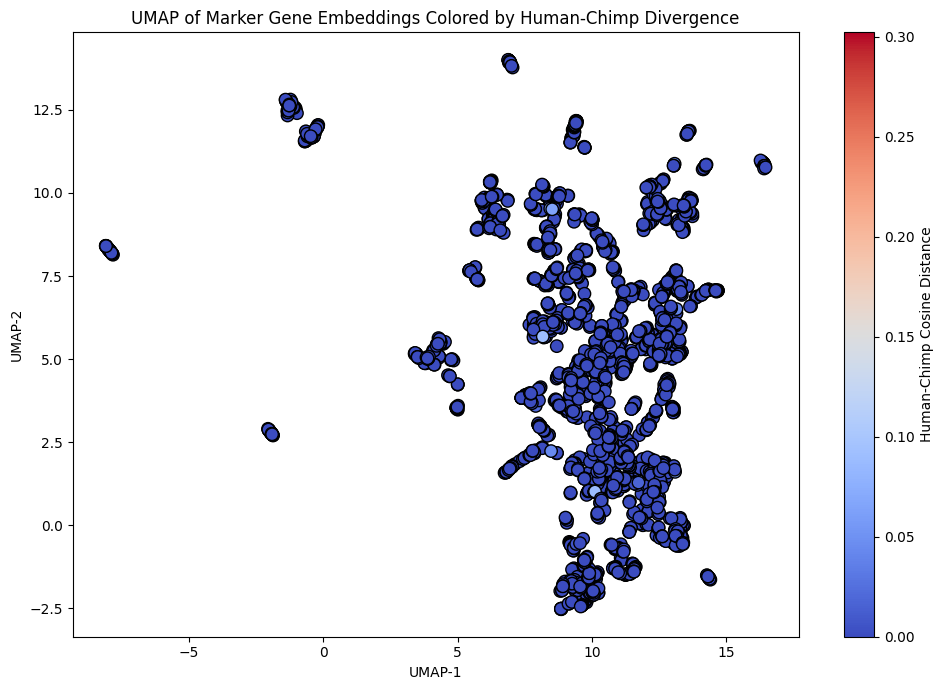

In [ ]:

# === 5. UMAP Visualization for all embeddings with divergence shading ===
combined_embeddings = []
combined_labels = []
#cell_type_labels = []
combined_divergence = []

for gene, emb_dict in all_embeddings.items():
    for sp, emb in emb_dict.items():
        combined_embeddings.append(emb)
        combined_labels.append(f"{gene}_{sp}")
        # Assign divergence score only for human embeddings using Human-Chimp as default
        if sp == "human":
            score = df_diff.loc[df_diff["Gene"] == gene, "Human-Chimp"].values[0] if gene in df_diff["Gene"].values else None
        else:
            score = None
        #cell_type_labels.append(marker_label_dict[gene])
        combined_divergence.append(score)

embedding_2d = umap.UMAP().fit_transform(np.stack(combined_embeddings))

plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    embedding_2d[:, 0], embedding_2d[:, 1],
    c=[v if v is not None else 0 for v in combined_divergence],
    cmap="coolwarm", s=80, edgecolor='k')
plt.colorbar(scatter, label="Human-Chimp Cosine Distance")
# for label, (x, y) in zip(combined_labels, embedding_2d):
#     plt.text(x+0.1, y, label, fontsize=8)
plt.title("UMAP of Marker Gene Embeddings Colored by Human-Chimp Divergence")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()



In [ ]:
new_gene_list = [x for x in genes if x != 'P2RY12']


In [ ]:

all_considered_new_gene_list = new_gene_list[0:6] + new_gene_list[6:15] + new_gene_list[15:27] + new_gene_list[27:34] + new_gene_list[35:41] + new_gene_list[41:]
all_cell_types = ["Astro" for i in range(len(new_gene_list[0:6]))] + ["Inhibit" for i in range(len(new_gene_list[6:15]))] + ["Excite" for i in range(len(new_gene_list[15:27]))] + ["Micro" for i in range(len(new_gene_list[27:34]))] + ["Oligo" for i in range(len(new_gene_list[35:41]))] + ["OPC" for i in range(len(new_gene_list[41:]))]
all_symbols = ["o" for i in range(len(new_gene_list[0:6]))] + ["x" for i in range(len(new_gene_list[6:15]))] + ["*" for i in range(len(new_gene_list[15:27]))] + ["D" for i in range(len(new_gene_list[27:34]))] + ["+" for i in range(len(new_gene_list[35:41]))] + ["P" for i in range(len(new_gene_list[41:]))]


In [ ]:
heatmap_df.shape

(3, 838)

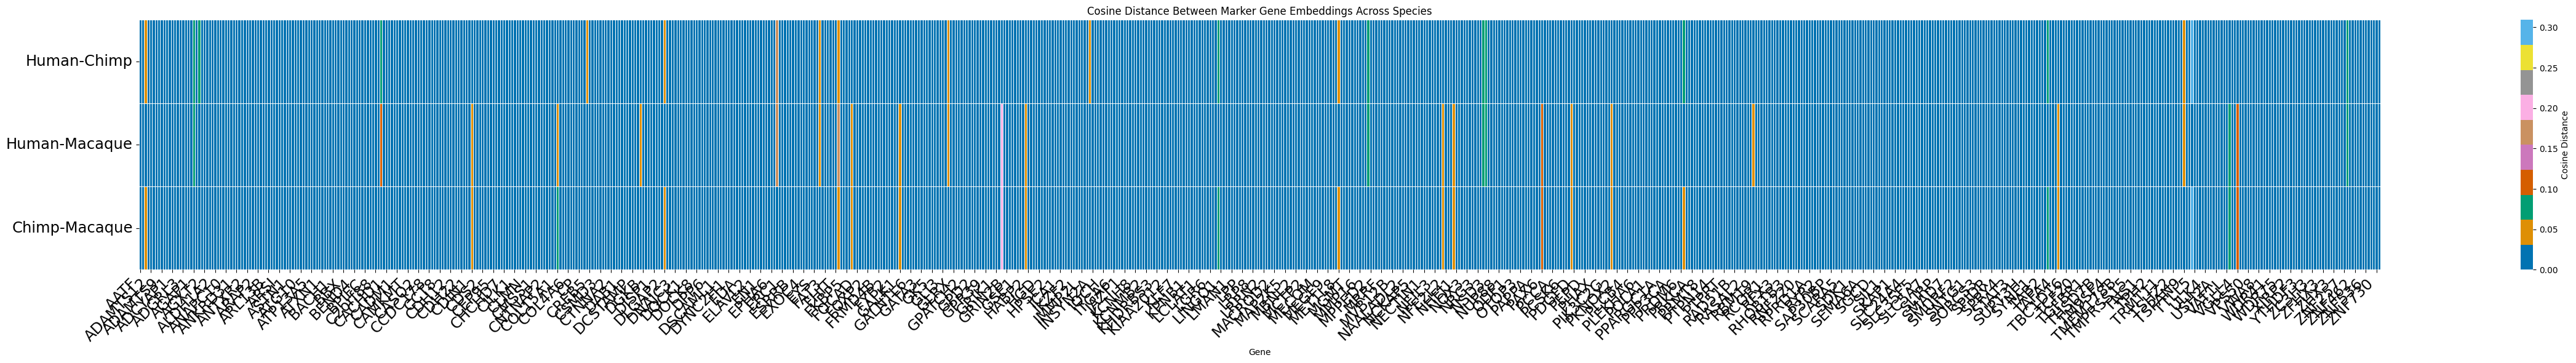

In [ ]:

heatmap_df = df_diff.set_index("Gene").dropna().T
plt.figure(figsize=(48, 6))  # Adjust cell height

p = sns.heatmap(heatmap_df,
            annot=False,
            cmap=sns.color_palette("colorblind"),
            linewidths=0.5,

            cbar_kws={'label': 'Cosine Distance'},
            fmt=".3f",
            annot_kws={'color': 'black',
                       'size': 15})

p.set_xticklabels(p.get_xticklabels(), fontsize=17.5) # Adjust fontsize as needed
p.set_yticklabels(p.get_yticklabels(), fontsize=17.5) # Adjust fontsize as needed

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.title("Cosine Distance Between Marker Gene Embeddings Across Species")
plt.tight_layout()
plt.show()

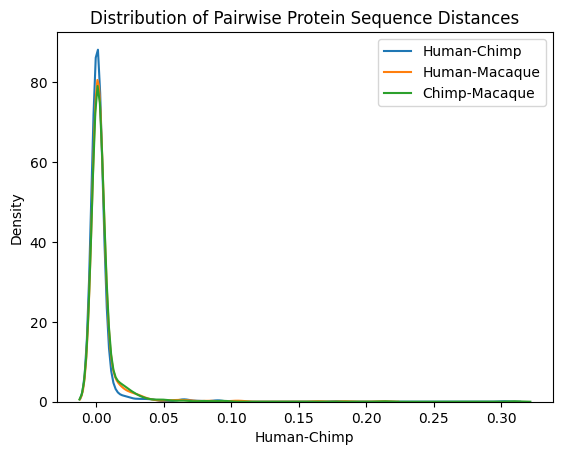

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in ['Human-Chimp', 'Human-Macaque', 'Chimp-Macaque']:
    sns.kdeplot(df_diff[col], label=col)

plt.legend()
plt.title("Distribution of Pairwise Protein Sequence Distances")
plt.show()


In [ ]:
from scipy.stats import zscore

# Step 1: Z-score normalization
df_z = df_diff.copy()
for col in ['Human-Chimp', 'Human-Macaque', 'Chimp-Macaque']:
    df_z[col + '_z'] = zscore(df_z[col])

# Step 2: Composite human-specificity score
df_z['human_specificity_score'] = (
    df_z['Human-Chimp_z'] + df_z['Human-Macaque_z'] - df_z['Chimp-Macaque_z']
)

df_z['chimp_specificity_score'] = (
    df_z['Human-Chimp_z'] + df_z['Chimp-Macaque_z'] - df_z['Human-Macaque_z']
)


In [ ]:

top_human_specific = df_z[df_z['human_specificity_score'] > 3]  # 3 SDs above mean


In [ ]:

top_human_specific


,Gene,Human-Chimp,Human-Macaque,Chimp-Macaque,Human-Chimp_z,Human-Macaque_z,Chimp-Macaque_z,human_specificity_score,chimp_specificity_score
20,AGAP1,0.073412,0.069472,0.001380,4.566220,4.088041,-0.197599,8.851860,0.280580
22,AGBL4,0.065185,0.030610,0.013572,4.031077,1.629617,0.557510,5.103185,2.958969
54,ASIC2,0.025924,0.025043,0.000121,1.477225,1.277435,-0.275609,3.030269,-0.075819
90,C5orf63,0.090852,0.107656,0.016609,5.700686,6.503541,0.745627,11.458601,-0.057229
165,CPA3,0.030160,0.026887,0.002350,1.752739,1.394100,-0.137512,3.284351,0.221127
238,EPM2A,0.177619,0.183191,0.000819,11.344778,11.281815,-0.232371,22.858965,-0.169408
254,FAM107B,0.043769,0.032684,0.002171,2.637967,1.760855,-0.148583,4.547405,0.728528
261,FHL2,0.055984,0.164505,0.038116,3.432592,10.099802,2.077753,11.454640,-4.589457
302,GLIS3,0.035370,0.034257,0.000468,2.091614,1.860342,-0.254101,4.206058,-0.022829
459,MPP7,0.077526,0.077467,0.000144,4.833840,4.593795,-0.274140,9.701776,-0.034094


In [ ]:

top_chimp_specific = df_z[df_z['chimp_specificity_score'] > 3]  # 3 SDs above mean


In [ ]:
top_chimp_specific

,Gene,Human-Chimp,Human-Macaque,Chimp-Macaque,Human-Chimp_z,Human-Macaque_z,Chimp-Macaque_z,human_specificity_score,chimp_specificity_score
2,ACACB,0.033594,0.001938,0.038695,1.976093,-0.184169,2.113596,-0.321672,4.273858
196,DLGAP2,0.037230,0.000341,0.036539,2.212606,-0.285186,1.980032,-0.052612,4.477825
301,GLIS1,0.030786,0.000874,0.028952,1.793488,-0.251447,1.510146,0.031896,3.555081
355,INPP5A,0.040988,0.007573,0.028010,2.457107,0.172331,1.451801,1.177637,3.736576
403,LIN52,0.065422,0.000000,0.065422,4.046485,-0.306750,3.768992,-0.029256,8.122226
448,METTL8,0.042537,0.009395,0.046860,2.557821,0.287582,2.619334,0.226069,4.889573
577,PRDM8,0.088439,0.018501,0.043339,5.543717,0.863612,2.401221,4.006108,7.081327
713,TACC2,0.063017,0.005933,0.077419,3.890040,0.068550,4.512039,-0.553450,8.333529
767,TTC6,0.302137,0.001670,0.309157,19.444498,-0.201098,18.865334,0.378067,38.510929


In [ ]:
genes_to_plot = top_human_specific['Gene'].to_list() + top_chimp_specific['Gene'].to_list()

In [ ]:

genes_to_plot

['AGAP1',
 'AGBL4',
 'ASIC2',
 'C5orf63',
 'CPA3',
 'EPM2A',
 'FAM107B',
 'FHL2',
 'GLIS3',
 'MPP7',
 'NRXN1',
 'NRXN3',
 'PRDM8',
 'TSPAN9',
 'ZNF365',
 'ACACB',
 'DLGAP2',
 'GLIS1',
 'INPP5A',
 'LIN52',
 'METTL8',
 'PRDM8',
 'TACC2',
 'TTC6']

In [ ]:
genes_to_plot[0]

'AGAP1'

In [ ]:
len(all_seqs[genes_to_plot[0]]['chimp'])

1151

In [ ]:
heatmap_df

Gene,ACACB,AGAP1,AGBL4,ASIC2,C5orf63,CPA3,DLGAP2,EPM2A,FAM107B,FHL2,...,LIN52,METTL8,MPP7,NRXN1,NRXN3,PRDM8,TACC2,TSPAN9,TTC6,ZNF365
Human-Chimp,0.033594,0.073412,0.065185,0.025924,0.090852,0.030160,0.037230,0.177619,0.043769,0.055984,...,0.065422,0.042537,0.077526,0.066174,0.064102,0.088439,0.063017,0.040323,0.302137,0.090101
Human-Macaque,0.001938,0.069472,0.030610,0.025043,0.107656,0.026887,0.000341,0.183191,0.032684,0.164505,...,0.000000,0.009395,0.077467,0.067716,0.065410,0.018501,0.005933,0.039914,0.001670,0.087013
Chimp-Macaque,0.038695,0.001380,0.013572,0.000121,0.016609,0.002350,0.036539,0.000819,0.002171,0.038116,...,0.065422,0.046860,0.000144,0.000258,0.000652,0.043339,0.077419,0.000024,0.309157,0.000296


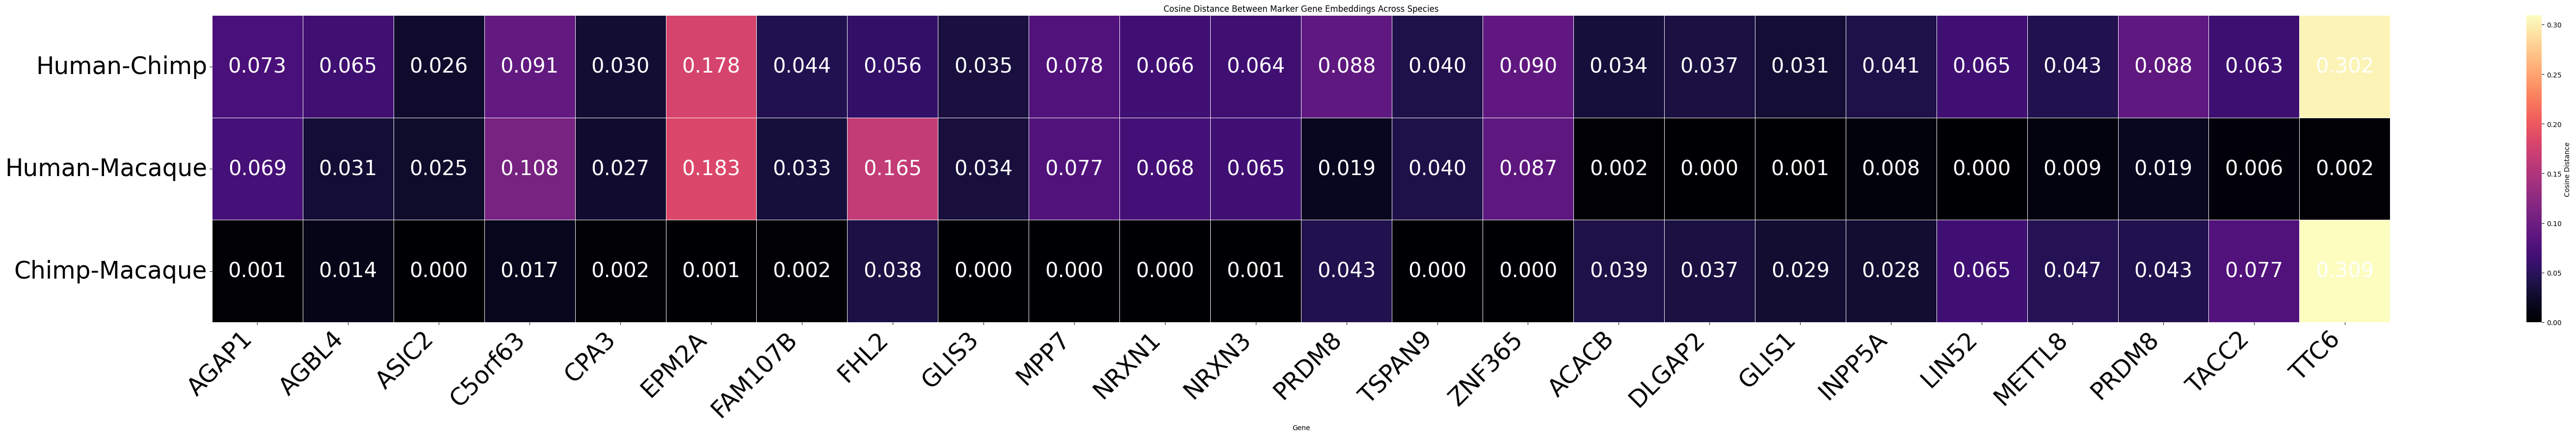

In [ ]:

# Filter and set index
heatmap_df = df_diff[df_diff['Gene'].isin(genes_to_plot)].set_index("Gene")

# Reorder according to genes_to_plot
heatmap_df = heatmap_df.reindex(genes_to_plot)

# Drop NAs (optional: do this after reindexing to avoid accidentally removing rows)
heatmap_df = heatmap_df.dropna()

heatmap_df = heatmap_df.T

plt.figure(figsize=(60, 9))  # Adjust cell height

p = sns.heatmap(heatmap_df,
            annot=True,
            cmap="magma",
            linewidths=0.5,
            cbar_kws={'label': 'Cosine Distance'},
            fmt=".3f",
            annot_kws={'color': 'white',
                       'size': 30})

p.set_xticklabels(p.get_xticklabels(), fontsize=35) # Adjust fontsize as needed
p.set_yticklabels(p.get_yticklabels(), fontsize=35) # Adjust fontsize as needed

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.title("Cosine Distance Between Marker Gene Embeddings Across Species")
plt.tight_layout()
plt.show()

In [ ]:
genes_to_plot

['AGAP1',
 'AGBL4',
 'ASIC2',
 'C5orf63',
 'CPA3',
 'EPM2A',
 'FAM107B',
 'FHL2',
 'GLIS3',
 'MPP7',
 'NRXN1',
 'NRXN3',
 'PRDM8',
 'TSPAN9',
 'ZNF365',
 'ACACB',
 'DLGAP2',
 'GLIS1',
 'INPP5A',
 'LIN52',
 'METTL8',
 'PRDM8',
 'TACC2',
 'TTC6']